In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
data['called_strike'] = np.where(data['description'] == 'called_strike', 1, 0)
testing_data['called_strike'] = np.where(testing_data['description'] == 'called_strike', 1, 0)

In [6]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & strike == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [35]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [36]:
testing_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement', 'called_strike'],
      dtype='object')

In [37]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement', 'called_strike'],
      dtype='object')

In [38]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [39]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [40]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [41]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [42]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [43]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6521918090142005
Log Loss: 0.6173116623218831


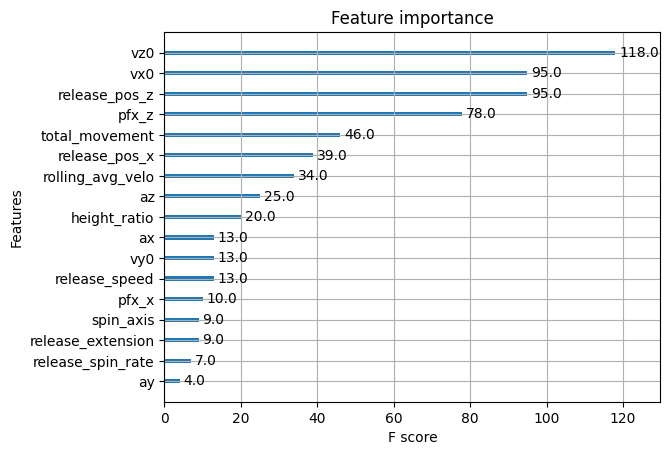

In [44]:
xgb.plot_importance(model)
plt.show()

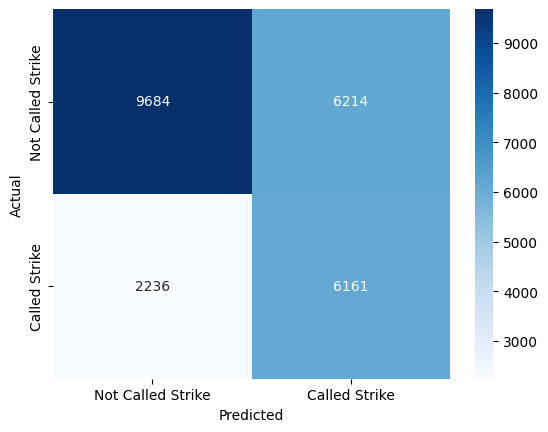

In [45]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [46]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [47]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 17:39:51,486] A new study created in memory with name: no-name-f35382fd-56f0-4823-93ce-f20033cf9ea6


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.63704
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62734
[6]	eval-logloss:0.62339
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61842
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61282
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60598
[15]	eval-logloss:0.60477
[16]	eval-logloss:0.60355
[17]	eval-logloss:0.60148
[18]	eval-logloss:0.60043
[19]	eval-logloss:0.59977
[20]	eval-logloss:0.59885
[21]	eval-logloss:0.59802
[22]	eval-logloss:0.59659
[23]	eval-logloss:0.59554
[24]	eval-logloss:0.59454
[25]	eval-logloss:0.59385
[26]	eval-logloss:0.59342
[27]	eval-logloss:0.59322
[28]	eval-logloss:0.59220
[29]	eval-logloss:0.59131
[30]	eval-logloss:0.59055
[31]	eval-logloss:0.59008
[32]	eval-logloss:0.58967
[33]	eval-logloss:0.58938
[34]	eval-logloss:0.58879
[35]	eval-logloss:0.58862
[36]	eval-logloss:0.58797
[37]	eval-logloss:0.58723
[38]	eval-logloss:0.58

[I 2023-11-14 17:39:52,646] Trial 0 finished with value: 0.5755819493571703 and parameters: {'max_depth': 4, 'eta': 0.2371749364518692, 'subsample': 0.7531631120892586, 'colsample_bytree': 0.9635781803805578}. Best is trial 0 with value: 0.5755819493571703.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.63611
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62359
[6]	eval-logloss:0.61811
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.61107
[9]	eval-logloss:0.60798
[10]	eval-logloss:0.60438
[11]	eval-logloss:0.60245
[12]	eval-logloss:0.60069
[13]	eval-logloss:0.59903
[14]	eval-logloss:0.59709
[15]	eval-logloss:0.59595
[16]	eval-logloss:0.59478
[17]	eval-logloss:0.59362
[18]	eval-logloss:0.59249
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.59122
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58877
[23]	eval-logloss:0.58812
[24]	eval-logloss:0.58653
[25]	eval-logloss:0.58592
[26]	eval-logloss:0.58559
[27]	eval-logloss:0.58520
[28]	eval-logloss:0.58457
[29]	eval-logloss:0.58404
[30]	eval-logloss:0.58327
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58256
[33]	eval-logloss:0.58197
[34]	eval-logloss:0.58131
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.58042
[37]	eval-logloss:0.57999
[38]	eval-logloss:0.57

[I 2023-11-14 17:39:54,023] Trial 1 finished with value: 0.5674879729433617 and parameters: {'max_depth': 5, 'eta': 0.19445706951719713, 'subsample': 0.7657185983380994, 'colsample_bytree': 0.8889674090668158}. Best is trial 1 with value: 0.5674879729433617.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67674
[5]	eval-logloss:0.67406
[6]	eval-logloss:0.67171
[7]	eval-logloss:0.67024
[8]	eval-logloss:0.66789
[9]	eval-logloss:0.66570
[10]	eval-logloss:0.66362
[11]	eval-logloss:0.66235
[12]	eval-logloss:0.66051
[13]	eval-logloss:0.65886
[14]	eval-logloss:0.65729
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65441
[17]	eval-logloss:0.65285
[18]	eval-logloss:0.65149
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.64897
[21]	eval-logloss:0.64793
[22]	eval-logloss:0.64693
[23]	eval-logloss:0.64599
[24]	eval-logloss:0.64491
[25]	eval-logloss:0.64464
[26]	eval-logloss:0.64442
[27]	eval-logloss:0.64374
[28]	eval-logloss:0.64279
[29]	eval-logloss:0.64193
[30]	eval-logloss:0.64113
[31]	eval-logloss:0.64044
[32]	eval-logloss:0.63967
[33]	eval-logloss:0.63897
[34]	eval-logloss:0.63824
[35]	eval-logloss:0.63755
[36]	eval-logloss:0.63696
[37]	eval-logloss:0.63620
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:55,154] Trial 2 finished with value: 0.6149359934796018 and parameters: {'max_depth': 3, 'eta': 0.04189727534418628, 'subsample': 0.7856284172435939, 'colsample_bytree': 0.6666922068932559}. Best is trial 1 with value: 0.5674879729433617.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.63998
[4]	eval-logloss:0.63274
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62224
[7]	eval-logloss:0.61864
[8]	eval-logloss:0.61516
[9]	eval-logloss:0.61222
[10]	eval-logloss:0.60933
[11]	eval-logloss:0.60719
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.60294
[14]	eval-logloss:0.60140
[15]	eval-logloss:0.60051
[16]	eval-logloss:0.59885
[17]	eval-logloss:0.59740
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59479
[20]	eval-logloss:0.59393
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59190
[23]	eval-logloss:0.59106
[24]	eval-logloss:0.58997
[25]	eval-logloss:0.58902
[26]	eval-logloss:0.58868
[27]	eval-logloss:0.58806
[28]	eval-logloss:0.58757
[29]	eval-logloss:0.58723
[30]	eval-logloss:0.58624
[31]	eval-logloss:0.58562
[32]	eval-logloss:0.58515
[33]	eval-logloss:0.58478
[34]	eval-logloss:0.58433
[35]	eval-logloss:0.58356
[36]	eval-logloss:0.58308
[37]	eval-logloss:0.58275
[38]	eval-logloss:0.58

[I 2023-11-14 17:39:56,315] Trial 3 finished with value: 0.5692201191986317 and parameters: {'max_depth': 5, 'eta': 0.17196488221759343, 'subsample': 0.6407300203087196, 'colsample_bytree': 0.9091760664801138}. Best is trial 1 with value: 0.5674879729433617.


[0]	eval-logloss:0.65528
[1]	eval-logloss:0.63483
[2]	eval-logloss:0.62077
[3]	eval-logloss:0.61096
[4]	eval-logloss:0.60361
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59542
[7]	eval-logloss:0.59197
[8]	eval-logloss:0.58967
[9]	eval-logloss:0.58756
[10]	eval-logloss:0.58463
[11]	eval-logloss:0.58448
[12]	eval-logloss:0.58295
[13]	eval-logloss:0.58066
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57925
[16]	eval-logloss:0.57772
[17]	eval-logloss:0.57619
[18]	eval-logloss:0.57600
[19]	eval-logloss:0.57533
[20]	eval-logloss:0.57522
[21]	eval-logloss:0.57503
[22]	eval-logloss:0.57366
[23]	eval-logloss:0.57317
[24]	eval-logloss:0.57242
[25]	eval-logloss:0.57192
[26]	eval-logloss:0.57216
[27]	eval-logloss:0.57247
[28]	eval-logloss:0.57259
[29]	eval-logloss:0.57280
[30]	eval-logloss:0.57231
[31]	eval-logloss:0.57269
[32]	eval-logloss:0.57251
[33]	eval-logloss:0.57273
[34]	eval-logloss:0.57263
[35]	eval-logloss:0.57168
[36]	eval-logloss:0.57179
[37]	eval-logloss:0.57172
[38]	eval-logloss:0.57

[I 2023-11-14 17:39:57,870] Trial 4 finished with value: 0.5748213007509686 and parameters: {'max_depth': 7, 'eta': 0.29186204290035855, 'subsample': 0.6498060800940845, 'colsample_bytree': 0.7087851250133137}. Best is trial 1 with value: 0.5674879729433617.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68523
[6]	eval-logloss:0.68399
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.67873
[12]	eval-logloss:0.67755
[13]	eval-logloss:0.67653
[14]	eval-logloss:0.67544
[15]	eval-logloss:0.67435
[16]	eval-logloss:0.67329
[17]	eval-logloss:0.67218
[18]	eval-logloss:0.67117
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66910
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66720
[23]	eval-logloss:0.66625
[24]	eval-logloss:0.66532
[25]	eval-logloss:0.66441
[26]	eval-logloss:0.66420
[27]	eval-logloss:0.66333
[28]	eval-logloss:0.66245
[29]	eval-logloss:0.66159
[30]	eval-logloss:0.66073
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.65946
[33]	eval-logloss:0.65865
[34]	eval-logloss:0.65779
[35]	eval-logloss:0.65701
[36]	eval-logloss:0.65627
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65

[I 2023-11-14 17:39:59,367] Trial 5 finished with value: 0.6235944269281447 and parameters: {'max_depth': 6, 'eta': 0.010000421453157418, 'subsample': 0.7782196464234623, 'colsample_bytree': 0.8835872526173462}. Best is trial 1 with value: 0.5674879729433617.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.63663
[4]	eval-logloss:0.62862
[5]	eval-logloss:0.62305
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60780
[9]	eval-logloss:0.60657
[10]	eval-logloss:0.60266
[11]	eval-logloss:0.60121
[12]	eval-logloss:0.59921
[13]	eval-logloss:0.59606
[14]	eval-logloss:0.59369
[15]	eval-logloss:0.59251
[16]	eval-logloss:0.59133
[17]	eval-logloss:0.58914
[18]	eval-logloss:0.58786
[19]	eval-logloss:0.58651
[20]	eval-logloss:0.58589
[21]	eval-logloss:0.58568
[22]	eval-logloss:0.58485
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58327
[28]	eval-logloss:0.58248
[29]	eval-logloss:0.58194
[30]	eval-logloss:0.58135
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.58091
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.58034
[35]	eval-logloss:0.57962
[36]	eval-logloss:0.57966
[37]	eval-logloss:0.57910
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:00,605] Trial 6 finished with value: 0.5706450402165412 and parameters: {'max_depth': 6, 'eta': 0.20126165450245898, 'subsample': 0.732704052925816, 'colsample_bytree': 0.5358095074621332}. Best is trial 1 with value: 0.5674879729433617.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.63499
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.61987
[6]	eval-logloss:0.61333
[7]	eval-logloss:0.60846
[8]	eval-logloss:0.60380
[9]	eval-logloss:0.59977
[10]	eval-logloss:0.59594
[11]	eval-logloss:0.59430
[12]	eval-logloss:0.59186
[13]	eval-logloss:0.58911
[14]	eval-logloss:0.58641
[15]	eval-logloss:0.58407
[16]	eval-logloss:0.58202
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57864
[19]	eval-logloss:0.57735
[20]	eval-logloss:0.57647
[21]	eval-logloss:0.57555
[22]	eval-logloss:0.57412
[23]	eval-logloss:0.57367
[24]	eval-logloss:0.57273
[25]	eval-logloss:0.57152
[26]	eval-logloss:0.57128
[27]	eval-logloss:0.57087
[28]	eval-logloss:0.56991
[29]	eval-logloss:0.56914
[30]	eval-logloss:0.56830
[31]	eval-logloss:0.56807
[32]	eval-logloss:0.56776
[33]	eval-logloss:0.56737
[34]	eval-logloss:0.56697
[35]	eval-logloss:0.56633
[36]	eval-logloss:0.56599
[37]	eval-logloss:0.56530
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:02,523] Trial 7 finished with value: 0.5582440607251108 and parameters: {'max_depth': 9, 'eta': 0.12138691903118602, 'subsample': 0.7804074910758724, 'colsample_bytree': 0.7480496041052369}. Best is trial 7 with value: 0.5582440607251108.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.67948
[3]	eval-logloss:0.67593
[4]	eval-logloss:0.67245
[5]	eval-logloss:0.66921
[6]	eval-logloss:0.66626
[7]	eval-logloss:0.66437
[8]	eval-logloss:0.66174
[9]	eval-logloss:0.65929
[10]	eval-logloss:0.65699
[11]	eval-logloss:0.65559
[12]	eval-logloss:0.65360
[13]	eval-logloss:0.65183
[14]	eval-logloss:0.65011
[15]	eval-logloss:0.64865
[16]	eval-logloss:0.64701
[17]	eval-logloss:0.64552
[18]	eval-logloss:0.64417
[19]	eval-logloss:0.64306
[20]	eval-logloss:0.64179
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.64046
[23]	eval-logloss:0.63951
[24]	eval-logloss:0.63928
[25]	eval-logloss:0.63900
[26]	eval-logloss:0.63877
[27]	eval-logloss:0.63854
[28]	eval-logloss:0.63759
[29]	eval-logloss:0.63680
[30]	eval-logloss:0.63589
[31]	eval-logloss:0.63510
[32]	eval-logloss:0.63435
[33]	eval-logloss:0.63416
[34]	eval-logloss:0.63342
[35]	eval-logloss:0.63256
[36]	eval-logloss:0.63240
[37]	eval-logloss:0.63162
[38]	eval-logloss:0.63

[I 2023-11-14 17:40:03,435] Trial 8 finished with value: 0.6104861153357692 and parameters: {'max_depth': 3, 'eta': 0.0560419898469944, 'subsample': 0.8663272613330797, 'colsample_bytree': 0.6386358898438617}. Best is trial 7 with value: 0.5582440607251108.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61720
[5]	eval-logloss:0.61322
[6]	eval-logloss:0.60896
[7]	eval-logloss:0.60642
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.60159
[10]	eval-logloss:0.59848
[11]	eval-logloss:0.59787
[12]	eval-logloss:0.59694
[13]	eval-logloss:0.59426
[14]	eval-logloss:0.59240
[15]	eval-logloss:0.59140
[16]	eval-logloss:0.58925
[17]	eval-logloss:0.58820
[18]	eval-logloss:0.58743
[19]	eval-logloss:0.58628
[20]	eval-logloss:0.58593
[21]	eval-logloss:0.58518
[22]	eval-logloss:0.58427
[23]	eval-logloss:0.58327
[24]	eval-logloss:0.58286
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.58204
[27]	eval-logloss:0.58182
[28]	eval-logloss:0.58089
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.58029
[31]	eval-logloss:0.58025
[32]	eval-logloss:0.57981
[33]	eval-logloss:0.57912
[34]	eval-logloss:0.57889
[35]	eval-logloss:0.57855
[36]	eval-logloss:0.57846
[37]	eval-logloss:0.57823
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:04,792] Trial 9 finished with value: 0.5692313125234154 and parameters: {'max_depth': 5, 'eta': 0.2940990542243917, 'subsample': 0.79704438024564, 'colsample_bytree': 0.7482535049676776}. Best is trial 7 with value: 0.5582440607251108.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63664
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.62092
[6]	eval-logloss:0.61428
[7]	eval-logloss:0.60933
[8]	eval-logloss:0.60464
[9]	eval-logloss:0.60016
[10]	eval-logloss:0.59642
[11]	eval-logloss:0.59441
[12]	eval-logloss:0.59184
[13]	eval-logloss:0.58925
[14]	eval-logloss:0.58677
[15]	eval-logloss:0.58431
[16]	eval-logloss:0.58201
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57849
[19]	eval-logloss:0.57714
[20]	eval-logloss:0.57608
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.57401
[23]	eval-logloss:0.57326
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.57140
[26]	eval-logloss:0.57103
[27]	eval-logloss:0.57060
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.56924
[30]	eval-logloss:0.56856
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56785
[33]	eval-logloss:0.56722
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56605
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56533
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:07,190] Trial 10 finished with value: 0.5554109754718968 and parameters: {'max_depth': 9, 'eta': 0.11691650224449776, 'subsample': 0.89725455681338, 'colsample_bytree': 0.7926307896325538}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.62794
[5]	eval-logloss:0.62099
[6]	eval-logloss:0.61480
[7]	eval-logloss:0.61004
[8]	eval-logloss:0.60523
[9]	eval-logloss:0.60055
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59502
[12]	eval-logloss:0.59235
[13]	eval-logloss:0.58950
[14]	eval-logloss:0.58699
[15]	eval-logloss:0.58436
[16]	eval-logloss:0.58210
[17]	eval-logloss:0.58012
[18]	eval-logloss:0.57865
[19]	eval-logloss:0.57745
[20]	eval-logloss:0.57633
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57398
[23]	eval-logloss:0.57293
[24]	eval-logloss:0.57160
[25]	eval-logloss:0.57047
[26]	eval-logloss:0.56998
[27]	eval-logloss:0.56956
[28]	eval-logloss:0.56890
[29]	eval-logloss:0.56850
[30]	eval-logloss:0.56769
[31]	eval-logloss:0.56730
[32]	eval-logloss:0.56692
[33]	eval-logloss:0.56621
[34]	eval-logloss:0.56608
[35]	eval-logloss:0.56559
[36]	eval-logloss:0.56534
[37]	eval-logloss:0.56470
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:10,396] Trial 11 finished with value: 0.5561834025099142 and parameters: {'max_depth': 9, 'eta': 0.11341859097769544, 'subsample': 0.8907576582898628, 'colsample_bytree': 0.8130823189237224}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63612
[4]	eval-logloss:0.62783
[5]	eval-logloss:0.62110
[6]	eval-logloss:0.61421
[7]	eval-logloss:0.60930
[8]	eval-logloss:0.60440
[9]	eval-logloss:0.60003
[10]	eval-logloss:0.59645
[11]	eval-logloss:0.59446
[12]	eval-logloss:0.59183
[13]	eval-logloss:0.58929
[14]	eval-logloss:0.58656
[15]	eval-logloss:0.58419
[16]	eval-logloss:0.58208
[17]	eval-logloss:0.58010
[18]	eval-logloss:0.57843
[19]	eval-logloss:0.57699
[20]	eval-logloss:0.57605
[21]	eval-logloss:0.57507
[22]	eval-logloss:0.57390
[23]	eval-logloss:0.57316
[24]	eval-logloss:0.57223
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.57064
[27]	eval-logloss:0.57008
[28]	eval-logloss:0.56896
[29]	eval-logloss:0.56837
[30]	eval-logloss:0.56785
[31]	eval-logloss:0.56758
[32]	eval-logloss:0.56740
[33]	eval-logloss:0.56671
[34]	eval-logloss:0.56657
[35]	eval-logloss:0.56609
[36]	eval-logloss:0.56567
[37]	eval-logloss:0.56517
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:12,613] Trial 12 finished with value: 0.5564628407618185 and parameters: {'max_depth': 9, 'eta': 0.11473251752533291, 'subsample': 0.889860822131734, 'colsample_bytree': 0.8219304662590676}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.64789
[3]	eval-logloss:0.63812
[4]	eval-logloss:0.62995
[5]	eval-logloss:0.62361
[6]	eval-logloss:0.61759
[7]	eval-logloss:0.61242
[8]	eval-logloss:0.60770
[9]	eval-logloss:0.60317
[10]	eval-logloss:0.59987
[11]	eval-logloss:0.59796
[12]	eval-logloss:0.59530
[13]	eval-logloss:0.59263
[14]	eval-logloss:0.59012
[15]	eval-logloss:0.58793
[16]	eval-logloss:0.58588
[17]	eval-logloss:0.58383
[18]	eval-logloss:0.58216
[19]	eval-logloss:0.58101
[20]	eval-logloss:0.58020
[21]	eval-logloss:0.57941
[22]	eval-logloss:0.57800
[23]	eval-logloss:0.57731
[24]	eval-logloss:0.57593
[25]	eval-logloss:0.57518
[26]	eval-logloss:0.57460
[27]	eval-logloss:0.57408
[28]	eval-logloss:0.57305
[29]	eval-logloss:0.57226
[30]	eval-logloss:0.57162
[31]	eval-logloss:0.57126
[32]	eval-logloss:0.57102
[33]	eval-logloss:0.57041
[34]	eval-logloss:0.57017
[35]	eval-logloss:0.56978
[36]	eval-logloss:0.56957
[37]	eval-logloss:0.56901
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:14,578] Trial 13 finished with value: 0.5580144059126055 and parameters: {'max_depth': 8, 'eta': 0.12003394051149936, 'subsample': 0.895630385649967, 'colsample_bytree': 0.8107707845549018}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65659
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63384
[6]	eval-logloss:0.62812
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.61861
[9]	eval-logloss:0.61387
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60795
[12]	eval-logloss:0.60517
[13]	eval-logloss:0.60237
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59682
[16]	eval-logloss:0.59421
[17]	eval-logloss:0.59193
[18]	eval-logloss:0.58985
[19]	eval-logloss:0.58801
[20]	eval-logloss:0.58685
[21]	eval-logloss:0.58559
[22]	eval-logloss:0.58439
[23]	eval-logloss:0.58323
[24]	eval-logloss:0.58164
[25]	eval-logloss:0.58036
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57815
[29]	eval-logloss:0.57754
[30]	eval-logloss:0.57669
[31]	eval-logloss:0.57636
[32]	eval-logloss:0.57575
[33]	eval-logloss:0.57519
[34]	eval-logloss:0.57477
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57362
[37]	eval-logloss:0.57310
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:16,863] Trial 14 finished with value: 0.5589383545002976 and parameters: {'max_depth': 8, 'eta': 0.09322594275452396, 'subsample': 0.8500648288247412, 'colsample_bytree': 0.8097298326590276}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65578
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.62283
[5]	eval-logloss:0.61585
[6]	eval-logloss:0.61012
[7]	eval-logloss:0.60554
[8]	eval-logloss:0.60176
[9]	eval-logloss:0.59754
[10]	eval-logloss:0.59360
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58890
[13]	eval-logloss:0.58652
[14]	eval-logloss:0.58443
[15]	eval-logloss:0.58261
[16]	eval-logloss:0.58060
[17]	eval-logloss:0.57889
[18]	eval-logloss:0.57786
[19]	eval-logloss:0.57610
[20]	eval-logloss:0.57520
[21]	eval-logloss:0.57417
[22]	eval-logloss:0.57321
[23]	eval-logloss:0.57252
[24]	eval-logloss:0.57175
[25]	eval-logloss:0.57092
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.57001
[28]	eval-logloss:0.56950
[29]	eval-logloss:0.56913
[30]	eval-logloss:0.56853
[31]	eval-logloss:0.56822
[32]	eval-logloss:0.56768
[33]	eval-logloss:0.56749
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56657
[36]	eval-logloss:0.56618
[37]	eval-logloss:0.56593
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:18,914] Trial 15 finished with value: 0.5576180860944715 and parameters: {'max_depth': 8, 'eta': 0.14213531795154077, 'subsample': 0.8337760847581321, 'colsample_bytree': 0.9765940271533218}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.63026
[6]	eval-logloss:0.62397
[7]	eval-logloss:0.61896
[8]	eval-logloss:0.61400
[9]	eval-logloss:0.60944
[10]	eval-logloss:0.60556
[11]	eval-logloss:0.60212
[12]	eval-logloss:0.59901
[13]	eval-logloss:0.59612
[14]	eval-logloss:0.59334
[15]	eval-logloss:0.59055
[16]	eval-logloss:0.58806
[17]	eval-logloss:0.58594
[18]	eval-logloss:0.58413
[19]	eval-logloss:0.58246
[20]	eval-logloss:0.58119
[21]	eval-logloss:0.57984
[22]	eval-logloss:0.57855
[23]	eval-logloss:0.57745
[24]	eval-logloss:0.57642
[25]	eval-logloss:0.57514
[26]	eval-logloss:0.57483
[27]	eval-logloss:0.57404
[28]	eval-logloss:0.57289
[29]	eval-logloss:0.57212
[30]	eval-logloss:0.57127
[31]	eval-logloss:0.57092
[32]	eval-logloss:0.57045
[33]	eval-logloss:0.56962
[34]	eval-logloss:0.56913
[35]	eval-logloss:0.56837
[36]	eval-logloss:0.56792
[37]	eval-logloss:0.56746
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:21,233] Trial 16 finished with value: 0.5561395798450949 and parameters: {'max_depth': 9, 'eta': 0.0903330249247912, 'subsample': 0.8979950284397403, 'colsample_bytree': 0.8335397574131763}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65724
[4]	eval-logloss:0.65058
[5]	eval-logloss:0.64500
[6]	eval-logloss:0.63975
[7]	eval-logloss:0.63542
[8]	eval-logloss:0.63084
[9]	eval-logloss:0.62646
[10]	eval-logloss:0.62283
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61372
[14]	eval-logloss:0.61106
[15]	eval-logloss:0.60834
[16]	eval-logloss:0.60604
[17]	eval-logloss:0.60376
[18]	eval-logloss:0.60164
[19]	eval-logloss:0.59994
[20]	eval-logloss:0.59854
[21]	eval-logloss:0.59696
[22]	eval-logloss:0.59535
[23]	eval-logloss:0.59412
[24]	eval-logloss:0.59295
[25]	eval-logloss:0.59170
[26]	eval-logloss:0.59132
[27]	eval-logloss:0.59030
[28]	eval-logloss:0.58901
[29]	eval-logloss:0.58784
[30]	eval-logloss:0.58705
[31]	eval-logloss:0.58659
[32]	eval-logloss:0.58596
[33]	eval-logloss:0.58520
[34]	eval-logloss:0.58408
[35]	eval-logloss:0.58336
[36]	eval-logloss:0.58283
[37]	eval-logloss:0.58206
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:22,850] Trial 17 finished with value: 0.5645572654719258 and parameters: {'max_depth': 7, 'eta': 0.07568755401815971, 'subsample': 0.8274516362119916, 'colsample_bytree': 0.8555344524257107}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66497
[3]	eval-logloss:0.65778
[4]	eval-logloss:0.65148
[5]	eval-logloss:0.64581
[6]	eval-logloss:0.64075
[7]	eval-logloss:0.63601
[8]	eval-logloss:0.63165
[9]	eval-logloss:0.62738
[10]	eval-logloss:0.62375
[11]	eval-logloss:0.62031
[12]	eval-logloss:0.61722
[13]	eval-logloss:0.61472
[14]	eval-logloss:0.61203
[15]	eval-logloss:0.60945
[16]	eval-logloss:0.60736
[17]	eval-logloss:0.60501
[18]	eval-logloss:0.60290
[19]	eval-logloss:0.60132
[20]	eval-logloss:0.59984
[21]	eval-logloss:0.59859
[22]	eval-logloss:0.59709
[23]	eval-logloss:0.59591
[24]	eval-logloss:0.59445
[25]	eval-logloss:0.59295
[26]	eval-logloss:0.59249
[27]	eval-logloss:0.59152
[28]	eval-logloss:0.59022
[29]	eval-logloss:0.58922
[30]	eval-logloss:0.58804
[31]	eval-logloss:0.58687
[32]	eval-logloss:0.58590
[33]	eval-logloss:0.58500
[34]	eval-logloss:0.58418
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58281
[37]	eval-logloss:0.58207
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:24,737] Trial 18 finished with value: 0.5655551060101919 and parameters: {'max_depth': 7, 'eta': 0.07260907478434553, 'subsample': 0.8620324569987695, 'colsample_bytree': 0.940428078354875}. Best is trial 10 with value: 0.5554109754718968.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66430
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64279
[4]	eval-logloss:0.63475
[5]	eval-logloss:0.62745
[6]	eval-logloss:0.62081
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.61069
[9]	eval-logloss:0.60588
[10]	eval-logloss:0.60207
[11]	eval-logloss:0.59834
[12]	eval-logloss:0.59530
[13]	eval-logloss:0.59222
[14]	eval-logloss:0.58985
[15]	eval-logloss:0.58704
[16]	eval-logloss:0.58506
[17]	eval-logloss:0.58312
[18]	eval-logloss:0.58145
[19]	eval-logloss:0.57976
[20]	eval-logloss:0.57841
[21]	eval-logloss:0.57707
[22]	eval-logloss:0.57567
[23]	eval-logloss:0.57475
[24]	eval-logloss:0.57375
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57164
[27]	eval-logloss:0.57103
[28]	eval-logloss:0.57027
[29]	eval-logloss:0.56924
[30]	eval-logloss:0.56860
[31]	eval-logloss:0.56784
[32]	eval-logloss:0.56728
[33]	eval-logloss:0.56622
[34]	eval-logloss:0.56555
[35]	eval-logloss:0.56517
[36]	eval-logloss:0.56464
[37]	eval-logloss:0.56439
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:26,582] Trial 19 finished with value: 0.5546518701062991 and parameters: {'max_depth': 9, 'eta': 0.09645039506153774, 'subsample': 0.8083967813393165, 'colsample_bytree': 0.9904847064175335}. Best is trial 19 with value: 0.5546518701062991.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.62979
[4]	eval-logloss:0.62125
[5]	eval-logloss:0.61417
[6]	eval-logloss:0.60832
[7]	eval-logloss:0.60351
[8]	eval-logloss:0.59987
[9]	eval-logloss:0.59620
[10]	eval-logloss:0.59277
[11]	eval-logloss:0.58994
[12]	eval-logloss:0.58795
[13]	eval-logloss:0.58618
[14]	eval-logloss:0.58435
[15]	eval-logloss:0.58193
[16]	eval-logloss:0.57984
[17]	eval-logloss:0.57824
[18]	eval-logloss:0.57708
[19]	eval-logloss:0.57594
[20]	eval-logloss:0.57479
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57344
[23]	eval-logloss:0.57270
[24]	eval-logloss:0.57193
[25]	eval-logloss:0.57089
[26]	eval-logloss:0.57049
[27]	eval-logloss:0.56983
[28]	eval-logloss:0.56913
[29]	eval-logloss:0.56849
[30]	eval-logloss:0.56800
[31]	eval-logloss:0.56775
[32]	eval-logloss:0.56728
[33]	eval-logloss:0.56696
[34]	eval-logloss:0.56648
[35]	eval-logloss:0.56626
[36]	eval-logloss:0.56588
[37]	eval-logloss:0.56560
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:28,209] Trial 20 finished with value: 0.5569474641505404 and parameters: {'max_depth': 8, 'eta': 0.14967241293629843, 'subsample': 0.8263458877746098, 'colsample_bytree': 0.9998127012123096}. Best is trial 19 with value: 0.5546518701062991.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65497
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.63793
[5]	eval-logloss:0.63062
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.61885
[8]	eval-logloss:0.61409
[9]	eval-logloss:0.60943
[10]	eval-logloss:0.60563
[11]	eval-logloss:0.60184
[12]	eval-logloss:0.59866
[13]	eval-logloss:0.59578
[14]	eval-logloss:0.59305
[15]	eval-logloss:0.59017
[16]	eval-logloss:0.58783
[17]	eval-logloss:0.58557
[18]	eval-logloss:0.58365
[19]	eval-logloss:0.58213
[20]	eval-logloss:0.58075
[21]	eval-logloss:0.57964
[22]	eval-logloss:0.57810
[23]	eval-logloss:0.57730
[24]	eval-logloss:0.57596
[25]	eval-logloss:0.57488
[26]	eval-logloss:0.57443
[27]	eval-logloss:0.57369
[28]	eval-logloss:0.57239
[29]	eval-logloss:0.57142
[30]	eval-logloss:0.57060
[31]	eval-logloss:0.56975
[32]	eval-logloss:0.56909
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56767
[35]	eval-logloss:0.56708
[36]	eval-logloss:0.56653
[37]	eval-logloss:0.56602
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:30,216] Trial 21 finished with value: 0.5542910981304269 and parameters: {'max_depth': 9, 'eta': 0.0899756918861159, 'subsample': 0.8700601716171287, 'colsample_bytree': 0.9410570690062665}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65544
[5]	eval-logloss:0.64971
[6]	eval-logloss:0.64428
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63504
[9]	eval-logloss:0.63060
[10]	eval-logloss:0.62676
[11]	eval-logloss:0.62303
[12]	eval-logloss:0.61988
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61419
[15]	eval-logloss:0.61122
[16]	eval-logloss:0.60859
[17]	eval-logloss:0.60604
[18]	eval-logloss:0.60368
[19]	eval-logloss:0.60164
[20]	eval-logloss:0.59984
[21]	eval-logloss:0.59822
[22]	eval-logloss:0.59628
[23]	eval-logloss:0.59474
[24]	eval-logloss:0.59309
[25]	eval-logloss:0.59134
[26]	eval-logloss:0.59080
[27]	eval-logloss:0.58953
[28]	eval-logloss:0.58798
[29]	eval-logloss:0.58677
[30]	eval-logloss:0.58558
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58307
[33]	eval-logloss:0.58206
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.58026
[36]	eval-logloss:0.57954
[37]	eval-logloss:0.57874
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:32,952] Trial 22 finished with value: 0.5585691328886162 and parameters: {'max_depth': 9, 'eta': 0.053165174352647476, 'subsample': 0.8676186218930106, 'colsample_bytree': 0.9343569311555008}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65481
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63725
[5]	eval-logloss:0.63064
[6]	eval-logloss:0.62479
[7]	eval-logloss:0.61921
[8]	eval-logloss:0.61469
[9]	eval-logloss:0.61007
[10]	eval-logloss:0.60637
[11]	eval-logloss:0.60281
[12]	eval-logloss:0.59984
[13]	eval-logloss:0.59722
[14]	eval-logloss:0.59481
[15]	eval-logloss:0.59231
[16]	eval-logloss:0.59028
[17]	eval-logloss:0.58814
[18]	eval-logloss:0.58650
[19]	eval-logloss:0.58504
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.58216
[22]	eval-logloss:0.58110
[23]	eval-logloss:0.57996
[24]	eval-logloss:0.57890
[25]	eval-logloss:0.57770
[26]	eval-logloss:0.57655
[27]	eval-logloss:0.57595
[28]	eval-logloss:0.57488
[29]	eval-logloss:0.57438
[30]	eval-logloss:0.57367
[31]	eval-logloss:0.57294
[32]	eval-logloss:0.57234
[33]	eval-logloss:0.57182
[34]	eval-logloss:0.57098
[35]	eval-logloss:0.57058
[36]	eval-logloss:0.56999
[37]	eval-logloss:0.56968
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:34,584] Trial 23 finished with value: 0.5574383669739278 and parameters: {'max_depth': 8, 'eta': 0.09848126931091206, 'subsample': 0.8454897400175475, 'colsample_bytree': 0.9974096507987869}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.64189
[3]	eval-logloss:0.63065
[4]	eval-logloss:0.62199
[5]	eval-logloss:0.61385
[6]	eval-logloss:0.60756
[7]	eval-logloss:0.60257
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.59056
[11]	eval-logloss:0.58751
[12]	eval-logloss:0.58502
[13]	eval-logloss:0.58275
[14]	eval-logloss:0.58073
[15]	eval-logloss:0.57881
[16]	eval-logloss:0.57709
[17]	eval-logloss:0.57535
[18]	eval-logloss:0.57419
[19]	eval-logloss:0.57268
[20]	eval-logloss:0.57175
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.56973
[23]	eval-logloss:0.56922
[24]	eval-logloss:0.56811
[25]	eval-logloss:0.56725
[26]	eval-logloss:0.56698
[27]	eval-logloss:0.56662
[28]	eval-logloss:0.56580
[29]	eval-logloss:0.56514
[30]	eval-logloss:0.56431
[31]	eval-logloss:0.56408
[32]	eval-logloss:0.56390
[33]	eval-logloss:0.56359
[34]	eval-logloss:0.56305
[35]	eval-logloss:0.56262
[36]	eval-logloss:0.56249
[37]	eval-logloss:0.56223
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:36,958] Trial 24 finished with value: 0.5553239195831576 and parameters: {'max_depth': 9, 'eta': 0.13142292457212218, 'subsample': 0.8100877478896468, 'colsample_bytree': 0.9377521710514483}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65817
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.62780
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61582
[7]	eval-logloss:0.61130
[8]	eval-logloss:0.60765
[9]	eval-logloss:0.60318
[10]	eval-logloss:0.59921
[11]	eval-logloss:0.59604
[12]	eval-logloss:0.59391
[13]	eval-logloss:0.59197
[14]	eval-logloss:0.58996
[15]	eval-logloss:0.58837
[16]	eval-logloss:0.58653
[17]	eval-logloss:0.58494
[18]	eval-logloss:0.58359
[19]	eval-logloss:0.58227
[20]	eval-logloss:0.58145
[21]	eval-logloss:0.58037
[22]	eval-logloss:0.57907
[23]	eval-logloss:0.57866
[24]	eval-logloss:0.57789
[25]	eval-logloss:0.57679
[26]	eval-logloss:0.57661
[27]	eval-logloss:0.57624
[28]	eval-logloss:0.57558
[29]	eval-logloss:0.57489
[30]	eval-logloss:0.57431
[31]	eval-logloss:0.57382
[32]	eval-logloss:0.57319
[33]	eval-logloss:0.57277
[34]	eval-logloss:0.57244
[35]	eval-logloss:0.57198
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:38,337] Trial 25 finished with value: 0.5601199856849234 and parameters: {'max_depth': 7, 'eta': 0.14313227321977662, 'subsample': 0.8034345098167874, 'colsample_bytree': 0.9214554282283196}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65333
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.64019
[6]	eval-logloss:0.63433
[7]	eval-logloss:0.62917
[8]	eval-logloss:0.62484
[9]	eval-logloss:0.62032
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61292
[12]	eval-logloss:0.60962
[13]	eval-logloss:0.60665
[14]	eval-logloss:0.60411
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59459
[19]	eval-logloss:0.59302
[20]	eval-logloss:0.59128
[21]	eval-logloss:0.58966
[22]	eval-logloss:0.58815
[23]	eval-logloss:0.58675
[24]	eval-logloss:0.58548
[25]	eval-logloss:0.58421
[26]	eval-logloss:0.58283
[27]	eval-logloss:0.58206
[28]	eval-logloss:0.58104
[29]	eval-logloss:0.58016
[30]	eval-logloss:0.57945
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57779
[33]	eval-logloss:0.57701
[34]	eval-logloss:0.57637
[35]	eval-logloss:0.57566
[36]	eval-logloss:0.57511
[37]	eval-logloss:0.57462
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:40,115] Trial 26 finished with value: 0.5592665167131022 and parameters: {'max_depth': 8, 'eta': 0.07703278654110327, 'subsample': 0.8123028192746358, 'colsample_bytree': 0.9636915764759624}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.62449
[4]	eval-logloss:0.61555
[5]	eval-logloss:0.60817
[6]	eval-logloss:0.60137
[7]	eval-logloss:0.59640
[8]	eval-logloss:0.59226
[9]	eval-logloss:0.58833
[10]	eval-logloss:0.58502
[11]	eval-logloss:0.58203
[12]	eval-logloss:0.57973
[13]	eval-logloss:0.57780
[14]	eval-logloss:0.57587
[15]	eval-logloss:0.57467
[16]	eval-logloss:0.57347
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.57088
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56840
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56683
[24]	eval-logloss:0.56643
[25]	eval-logloss:0.56540
[26]	eval-logloss:0.56503
[27]	eval-logloss:0.56480
[28]	eval-logloss:0.56403
[29]	eval-logloss:0.56347
[30]	eval-logloss:0.56306
[31]	eval-logloss:0.56297
[32]	eval-logloss:0.56281
[33]	eval-logloss:0.56223
[34]	eval-logloss:0.56165
[35]	eval-logloss:0.56149
[36]	eval-logloss:0.56125
[37]	eval-logloss:0.56105
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:42,053] Trial 27 finished with value: 0.557316322885771 and parameters: {'max_depth': 9, 'eta': 0.15598439017396984, 'subsample': 0.8154786261573551, 'colsample_bytree': 0.8703953848507812}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65827
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63509
[4]	eval-logloss:0.62641
[5]	eval-logloss:0.61922
[6]	eval-logloss:0.61330
[7]	eval-logloss:0.60855
[8]	eval-logloss:0.60412
[9]	eval-logloss:0.59965
[10]	eval-logloss:0.59582
[11]	eval-logloss:0.59242
[12]	eval-logloss:0.58972
[13]	eval-logloss:0.58740
[14]	eval-logloss:0.58534
[15]	eval-logloss:0.58371
[16]	eval-logloss:0.58190
[17]	eval-logloss:0.58021
[18]	eval-logloss:0.57889
[19]	eval-logloss:0.57763
[20]	eval-logloss:0.57647
[21]	eval-logloss:0.57545
[22]	eval-logloss:0.57400
[23]	eval-logloss:0.57364
[24]	eval-logloss:0.57248
[25]	eval-logloss:0.57135
[26]	eval-logloss:0.57093
[27]	eval-logloss:0.57027
[28]	eval-logloss:0.56927
[29]	eval-logloss:0.56853
[30]	eval-logloss:0.56814
[31]	eval-logloss:0.56765
[32]	eval-logloss:0.56701
[33]	eval-logloss:0.56674
[34]	eval-logloss:0.56608
[35]	eval-logloss:0.56554
[36]	eval-logloss:0.56506
[37]	eval-logloss:0.56465
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:43,791] Trial 28 finished with value: 0.5560651898673631 and parameters: {'max_depth': 8, 'eta': 0.13258862318735395, 'subsample': 0.8466739222062769, 'colsample_bytree': 0.9156418536568698}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64777
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.62018
[4]	eval-logloss:0.61130
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59756
[7]	eval-logloss:0.59233
[8]	eval-logloss:0.58860
[9]	eval-logloss:0.58508
[10]	eval-logloss:0.58173
[11]	eval-logloss:0.57990
[12]	eval-logloss:0.57874
[13]	eval-logloss:0.57699
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57279
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.57009
[19]	eval-logloss:0.56935
[20]	eval-logloss:0.56873
[21]	eval-logloss:0.56817
[22]	eval-logloss:0.56708
[23]	eval-logloss:0.56641
[24]	eval-logloss:0.56571
[25]	eval-logloss:0.56515
[26]	eval-logloss:0.56475
[27]	eval-logloss:0.56458
[28]	eval-logloss:0.56422
[29]	eval-logloss:0.56358
[30]	eval-logloss:0.56334
[31]	eval-logloss:0.56296
[32]	eval-logloss:0.56287
[33]	eval-logloss:0.56251
[34]	eval-logloss:0.56218
[35]	eval-logloss:0.56209
[36]	eval-logloss:0.56193
[37]	eval-logloss:0.56158
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:45,707] Trial 29 finished with value: 0.5591086945519829 and parameters: {'max_depth': 9, 'eta': 0.16764856984572454, 'subsample': 0.7472988332689968, 'colsample_bytree': 0.9570428493928524}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67510
[2]	eval-logloss:0.66822
[3]	eval-logloss:0.66203
[4]	eval-logloss:0.65641
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64786
[7]	eval-logloss:0.64408
[8]	eval-logloss:0.64122
[9]	eval-logloss:0.63818
[10]	eval-logloss:0.63556
[11]	eval-logloss:0.63315
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62725
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62435
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62156
[19]	eval-logloss:0.62045
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61786
[22]	eval-logloss:0.61690
[23]	eval-logloss:0.61567
[24]	eval-logloss:0.61480
[25]	eval-logloss:0.61388
[26]	eval-logloss:0.61282
[27]	eval-logloss:0.61197
[28]	eval-logloss:0.61122
[29]	eval-logloss:0.61053
[30]	eval-logloss:0.60981
[31]	eval-logloss:0.60904
[32]	eval-logloss:0.60798
[33]	eval-logloss:0.60739
[34]	eval-logloss:0.60689
[35]	eval-logloss:0.60642
[36]	eval-logloss:0.60598
[37]	eval-logloss:0.60535
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:46,629] Trial 30 finished with value: 0.5864368642094888 and parameters: {'max_depth': 4, 'eta': 0.09315279054007619, 'subsample': 0.8110206529878108, 'colsample_bytree': 0.9599135814148892}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63099
[5]	eval-logloss:0.62343
[6]	eval-logloss:0.61700
[7]	eval-logloss:0.61132
[8]	eval-logloss:0.60689
[9]	eval-logloss:0.60254
[10]	eval-logloss:0.59897
[11]	eval-logloss:0.59524
[12]	eval-logloss:0.59227
[13]	eval-logloss:0.58992
[14]	eval-logloss:0.58735
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58343
[17]	eval-logloss:0.58152
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57848
[20]	eval-logloss:0.57738
[21]	eval-logloss:0.57627
[22]	eval-logloss:0.57481
[23]	eval-logloss:0.57405
[24]	eval-logloss:0.57307
[25]	eval-logloss:0.57219
[26]	eval-logloss:0.57182
[27]	eval-logloss:0.57124
[28]	eval-logloss:0.57008
[29]	eval-logloss:0.56923
[30]	eval-logloss:0.56857
[31]	eval-logloss:0.56812
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56674
[34]	eval-logloss:0.56629
[35]	eval-logloss:0.56591
[36]	eval-logloss:0.56579
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:48,504] Trial 31 finished with value: 0.5547266469736396 and parameters: {'max_depth': 9, 'eta': 0.10748677218573235, 'subsample': 0.8735532546055733, 'colsample_bytree': 0.9087794847969316}. Best is trial 21 with value: 0.5542910981304269.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64104
[4]	eval-logloss:0.63257
[5]	eval-logloss:0.62514
[6]	eval-logloss:0.61866
[7]	eval-logloss:0.61304
[8]	eval-logloss:0.60836
[9]	eval-logloss:0.60363
[10]	eval-logloss:0.59973
[11]	eval-logloss:0.59563
[12]	eval-logloss:0.59280
[13]	eval-logloss:0.58995
[14]	eval-logloss:0.58744
[15]	eval-logloss:0.58488
[16]	eval-logloss:0.58293
[17]	eval-logloss:0.58106
[18]	eval-logloss:0.57930
[19]	eval-logloss:0.57761
[20]	eval-logloss:0.57640
[21]	eval-logloss:0.57522
[22]	eval-logloss:0.57394
[23]	eval-logloss:0.57335
[24]	eval-logloss:0.57212
[25]	eval-logloss:0.57094
[26]	eval-logloss:0.57036
[27]	eval-logloss:0.56980
[28]	eval-logloss:0.56864
[29]	eval-logloss:0.56778
[30]	eval-logloss:0.56712
[31]	eval-logloss:0.56632
[32]	eval-logloss:0.56577
[33]	eval-logloss:0.56519
[34]	eval-logloss:0.56486
[35]	eval-logloss:0.56438
[36]	eval-logloss:0.56412
[37]	eval-logloss:0.56368
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:50,364] Trial 32 finished with value: 0.5538238466584143 and parameters: {'max_depth': 9, 'eta': 0.10249690657231197, 'subsample': 0.8730883676012472, 'colsample_bytree': 0.9042570538945076}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.64720
[4]	eval-logloss:0.63962
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62147
[8]	eval-logloss:0.61682
[9]	eval-logloss:0.61220
[10]	eval-logloss:0.60886
[11]	eval-logloss:0.60499
[12]	eval-logloss:0.60182
[13]	eval-logloss:0.59909
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59418
[16]	eval-logloss:0.59217
[17]	eval-logloss:0.58984
[18]	eval-logloss:0.58790
[19]	eval-logloss:0.58640
[20]	eval-logloss:0.58536
[21]	eval-logloss:0.58423
[22]	eval-logloss:0.58263
[23]	eval-logloss:0.58181
[24]	eval-logloss:0.58034
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.57843
[27]	eval-logloss:0.57765
[28]	eval-logloss:0.57634
[29]	eval-logloss:0.57542
[30]	eval-logloss:0.57439
[31]	eval-logloss:0.57344
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.57213
[34]	eval-logloss:0.57179
[35]	eval-logloss:0.57129
[36]	eval-logloss:0.57104
[37]	eval-logloss:0.57042
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:51,864] Trial 33 finished with value: 0.5587231233240157 and parameters: {'max_depth': 8, 'eta': 0.09320232066441064, 'subsample': 0.870581638460761, 'colsample_bytree': 0.8968487676376306}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.64904
[3]	eval-logloss:0.63854
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62245
[6]	eval-logloss:0.61612
[7]	eval-logloss:0.61074
[8]	eval-logloss:0.60605
[9]	eval-logloss:0.60159
[10]	eval-logloss:0.59749
[11]	eval-logloss:0.59376
[12]	eval-logloss:0.59067
[13]	eval-logloss:0.58803
[14]	eval-logloss:0.58540
[15]	eval-logloss:0.58315
[16]	eval-logloss:0.58131
[17]	eval-logloss:0.57953
[18]	eval-logloss:0.57815
[19]	eval-logloss:0.57676
[20]	eval-logloss:0.57582
[21]	eval-logloss:0.57486
[22]	eval-logloss:0.57335
[23]	eval-logloss:0.57269
[24]	eval-logloss:0.57135
[25]	eval-logloss:0.57037
[26]	eval-logloss:0.56996
[27]	eval-logloss:0.56931
[28]	eval-logloss:0.56862
[29]	eval-logloss:0.56789
[30]	eval-logloss:0.56677
[31]	eval-logloss:0.56629
[32]	eval-logloss:0.56580
[33]	eval-logloss:0.56513
[34]	eval-logloss:0.56469
[35]	eval-logloss:0.56437
[36]	eval-logloss:0.56414
[37]	eval-logloss:0.56377
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:53,707] Trial 34 finished with value: 0.5548875515469657 and parameters: {'max_depth': 9, 'eta': 0.10842962353973618, 'subsample': 0.8742761780917039, 'colsample_bytree': 0.8966391674324675}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67428
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.65934
[4]	eval-logloss:0.65303
[5]	eval-logloss:0.64783
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.63846
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62587
[11]	eval-logloss:0.62266
[12]	eval-logloss:0.61963
[13]	eval-logloss:0.61702
[14]	eval-logloss:0.61448
[15]	eval-logloss:0.61160
[16]	eval-logloss:0.60923
[17]	eval-logloss:0.60679
[18]	eval-logloss:0.60479
[19]	eval-logloss:0.60318
[20]	eval-logloss:0.60162
[21]	eval-logloss:0.60012
[22]	eval-logloss:0.59859
[23]	eval-logloss:0.59737
[24]	eval-logloss:0.59594
[25]	eval-logloss:0.59459
[26]	eval-logloss:0.59424
[27]	eval-logloss:0.59323
[28]	eval-logloss:0.59195
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.58959
[31]	eval-logloss:0.58897
[32]	eval-logloss:0.58820
[33]	eval-logloss:0.58738
[34]	eval-logloss:0.58646
[35]	eval-logloss:0.58562
[36]	eval-logloss:0.58508
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:54,989] Trial 35 finished with value: 0.566011386505692 and parameters: {'max_depth': 7, 'eta': 0.06996138062753504, 'subsample': 0.8498338115936489, 'colsample_bytree': 0.8686463923934292}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.67863
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67022
[5]	eval-logloss:0.66640
[6]	eval-logloss:0.66263
[7]	eval-logloss:0.65901
[8]	eval-logloss:0.65575
[9]	eval-logloss:0.65238
[10]	eval-logloss:0.64936
[11]	eval-logloss:0.64637
[12]	eval-logloss:0.64365
[13]	eval-logloss:0.64104
[14]	eval-logloss:0.63850
[15]	eval-logloss:0.63601
[16]	eval-logloss:0.63359
[17]	eval-logloss:0.63140
[18]	eval-logloss:0.62919
[19]	eval-logloss:0.62721
[20]	eval-logloss:0.62531
[21]	eval-logloss:0.62338
[22]	eval-logloss:0.62162
[23]	eval-logloss:0.61979
[24]	eval-logloss:0.61799
[25]	eval-logloss:0.61625
[26]	eval-logloss:0.61468
[27]	eval-logloss:0.61327
[28]	eval-logloss:0.61195
[29]	eval-logloss:0.61062
[30]	eval-logloss:0.60907
[31]	eval-logloss:0.60791
[32]	eval-logloss:0.60675
[33]	eval-logloss:0.60556
[34]	eval-logloss:0.60433
[35]	eval-logloss:0.60331
[36]	eval-logloss:0.60235
[37]	eval-logloss:0.60143
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:56,754] Trial 36 finished with value: 0.5705388725188695 and parameters: {'max_depth': 8, 'eta': 0.03169186714023044, 'subsample': 0.8793854179680144, 'colsample_bytree': 0.9796241396061562}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67384
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.65783
[4]	eval-logloss:0.65105
[5]	eval-logloss:0.64478
[6]	eval-logloss:0.63929
[7]	eval-logloss:0.63420
[8]	eval-logloss:0.62971
[9]	eval-logloss:0.62498
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61717
[12]	eval-logloss:0.61373
[13]	eval-logloss:0.61067
[14]	eval-logloss:0.60783
[15]	eval-logloss:0.60502
[16]	eval-logloss:0.60252
[17]	eval-logloss:0.59997
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59597
[20]	eval-logloss:0.59411
[21]	eval-logloss:0.59262
[22]	eval-logloss:0.59112
[23]	eval-logloss:0.58968
[24]	eval-logloss:0.58830
[25]	eval-logloss:0.58679
[26]	eval-logloss:0.58619
[27]	eval-logloss:0.58513
[28]	eval-logloss:0.58382
[29]	eval-logloss:0.58244
[30]	eval-logloss:0.58131
[31]	eval-logloss:0.58004
[32]	eval-logloss:0.57898
[33]	eval-logloss:0.57798
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57622
[36]	eval-logloss:0.57573
[37]	eval-logloss:0.57503
[38]	eval-logloss:0.57

[I 2023-11-14 17:40:58,754] Trial 37 finished with value: 0.5574095938574095 and parameters: {'max_depth': 9, 'eta': 0.0619371182518754, 'subsample': 0.8556971379383908, 'colsample_bytree': 0.9164723661669574}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67133
[4]	eval-logloss:0.66680
[5]	eval-logloss:0.66270
[6]	eval-logloss:0.65882
[7]	eval-logloss:0.65522
[8]	eval-logloss:0.65194
[9]	eval-logloss:0.64860
[10]	eval-logloss:0.64563
[11]	eval-logloss:0.64284
[12]	eval-logloss:0.64022
[13]	eval-logloss:0.63777
[14]	eval-logloss:0.63541
[15]	eval-logloss:0.63329
[16]	eval-logloss:0.63113
[17]	eval-logloss:0.62894
[18]	eval-logloss:0.62694
[19]	eval-logloss:0.62514
[20]	eval-logloss:0.62344
[21]	eval-logloss:0.62193
[22]	eval-logloss:0.62031
[23]	eval-logloss:0.61886
[24]	eval-logloss:0.61739
[25]	eval-logloss:0.61593
[26]	eval-logloss:0.61549
[27]	eval-logloss:0.61426
[28]	eval-logloss:0.61294
[29]	eval-logloss:0.61186
[30]	eval-logloss:0.61067
[31]	eval-logloss:0.60931
[32]	eval-logloss:0.60823
[33]	eval-logloss:0.60733
[34]	eval-logloss:0.60619
[35]	eval-logloss:0.60526
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60369
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:59,864] Trial 38 finished with value: 0.5784336536664807 and parameters: {'max_depth': 6, 'eta': 0.04544279319958274, 'subsample': 0.8359894979294689, 'colsample_bytree': 0.8989623588578554}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66198
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.63924
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62310
[6]	eval-logloss:0.61676
[7]	eval-logloss:0.61123
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.60243
[10]	eval-logloss:0.59879
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.59262
[13]	eval-logloss:0.58986
[14]	eval-logloss:0.58746
[15]	eval-logloss:0.58500
[16]	eval-logloss:0.58296
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.57926
[19]	eval-logloss:0.57769
[20]	eval-logloss:0.57644
[21]	eval-logloss:0.57548
[22]	eval-logloss:0.57403
[23]	eval-logloss:0.57333
[24]	eval-logloss:0.57218
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.56992
[28]	eval-logloss:0.56931
[29]	eval-logloss:0.56853
[30]	eval-logloss:0.56784
[31]	eval-logloss:0.56711
[32]	eval-logloss:0.56646
[33]	eval-logloss:0.56583
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56467
[36]	eval-logloss:0.56421
[37]	eval-logloss:0.56371
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:01,770] Trial 39 finished with value: 0.5547127557053303 and parameters: {'max_depth': 9, 'eta': 0.10543975794501467, 'subsample': 0.8819927803280502, 'colsample_bytree': 0.9428739076904283}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66095
[3]	eval-logloss:0.65314
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63473
[7]	eval-logloss:0.62979
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62123
[10]	eval-logloss:0.61774
[11]	eval-logloss:0.61446
[12]	eval-logloss:0.61133
[13]	eval-logloss:0.60832
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.60121
[17]	eval-logloss:0.59897
[18]	eval-logloss:0.59703
[19]	eval-logloss:0.59523
[20]	eval-logloss:0.59384
[21]	eval-logloss:0.59258
[22]	eval-logloss:0.59095
[23]	eval-logloss:0.58966
[24]	eval-logloss:0.58844
[25]	eval-logloss:0.58746
[26]	eval-logloss:0.58619
[27]	eval-logloss:0.58531
[28]	eval-logloss:0.58458
[29]	eval-logloss:0.58364
[30]	eval-logloss:0.58265
[31]	eval-logloss:0.58190
[32]	eval-logloss:0.58109
[33]	eval-logloss:0.58019
[34]	eval-logloss:0.57964
[35]	eval-logloss:0.57900
[36]	eval-logloss:0.57836
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:03,207] Trial 40 finished with value: 0.563720193728636 and parameters: {'max_depth': 7, 'eta': 0.08485009602744133, 'subsample': 0.88204260463761, 'colsample_bytree': 0.9500198638212225}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65073
[3]	eval-logloss:0.64060
[4]	eval-logloss:0.63204
[5]	eval-logloss:0.62474
[6]	eval-logloss:0.61817
[7]	eval-logloss:0.61289
[8]	eval-logloss:0.60845
[9]	eval-logloss:0.60386
[10]	eval-logloss:0.59997
[11]	eval-logloss:0.59640
[12]	eval-logloss:0.59335
[13]	eval-logloss:0.59050
[14]	eval-logloss:0.58821
[15]	eval-logloss:0.58592
[16]	eval-logloss:0.58371
[17]	eval-logloss:0.58161
[18]	eval-logloss:0.58011
[19]	eval-logloss:0.57863
[20]	eval-logloss:0.57736
[21]	eval-logloss:0.57603
[22]	eval-logloss:0.57492
[23]	eval-logloss:0.57403
[24]	eval-logloss:0.57307
[25]	eval-logloss:0.57234
[26]	eval-logloss:0.57131
[27]	eval-logloss:0.57072
[28]	eval-logloss:0.57029
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.56910
[31]	eval-logloss:0.56850
[32]	eval-logloss:0.56789
[33]	eval-logloss:0.56728
[34]	eval-logloss:0.56677
[35]	eval-logloss:0.56641
[36]	eval-logloss:0.56602
[37]	eval-logloss:0.56557
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:05,098] Trial 41 finished with value: 0.5553179116096502 and parameters: {'max_depth': 9, 'eta': 0.10355400863662162, 'subsample': 0.8778060859771158, 'colsample_bytree': 0.9818008550440904}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66310
[2]	eval-logloss:0.65070
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.63198
[5]	eval-logloss:0.62465
[6]	eval-logloss:0.61837
[7]	eval-logloss:0.61295
[8]	eval-logloss:0.60822
[9]	eval-logloss:0.60349
[10]	eval-logloss:0.59974
[11]	eval-logloss:0.59595
[12]	eval-logloss:0.59289
[13]	eval-logloss:0.59052
[14]	eval-logloss:0.58807
[15]	eval-logloss:0.58566
[16]	eval-logloss:0.58370
[17]	eval-logloss:0.58183
[18]	eval-logloss:0.58031
[19]	eval-logloss:0.57874
[20]	eval-logloss:0.57741
[21]	eval-logloss:0.57617
[22]	eval-logloss:0.57473
[23]	eval-logloss:0.57396
[24]	eval-logloss:0.57257
[25]	eval-logloss:0.57157
[26]	eval-logloss:0.57119
[27]	eval-logloss:0.57058
[28]	eval-logloss:0.56936
[29]	eval-logloss:0.56855
[30]	eval-logloss:0.56798
[31]	eval-logloss:0.56732
[32]	eval-logloss:0.56683
[33]	eval-logloss:0.56627
[34]	eval-logloss:0.56583
[35]	eval-logloss:0.56527
[36]	eval-logloss:0.56490
[37]	eval-logloss:0.56442
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:07,020] Trial 42 finished with value: 0.554219877069333 and parameters: {'max_depth': 9, 'eta': 0.10290466528016419, 'subsample': 0.8579457243995022, 'colsample_bytree': 0.9353523079111133}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62179
[5]	eval-logloss:0.61431
[6]	eval-logloss:0.60811
[7]	eval-logloss:0.60256
[8]	eval-logloss:0.59826
[9]	eval-logloss:0.59349
[10]	eval-logloss:0.59016
[11]	eval-logloss:0.58676
[12]	eval-logloss:0.58423
[13]	eval-logloss:0.58226
[14]	eval-logloss:0.57996
[15]	eval-logloss:0.57802
[16]	eval-logloss:0.57643
[17]	eval-logloss:0.57483
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.57196
[21]	eval-logloss:0.57085
[22]	eval-logloss:0.56930
[23]	eval-logloss:0.56866
[24]	eval-logloss:0.56778
[25]	eval-logloss:0.56670
[26]	eval-logloss:0.56638
[27]	eval-logloss:0.56596
[28]	eval-logloss:0.56545
[29]	eval-logloss:0.56496
[30]	eval-logloss:0.56448
[31]	eval-logloss:0.56420
[32]	eval-logloss:0.56400
[33]	eval-logloss:0.56343
[34]	eval-logloss:0.56321
[35]	eval-logloss:0.56287
[36]	eval-logloss:0.56252
[37]	eval-logloss:0.56191
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:08,817] Trial 43 finished with value: 0.5552289479361417 and parameters: {'max_depth': 9, 'eta': 0.13168481588112788, 'subsample': 0.8607066502431845, 'colsample_bytree': 0.9282102862761312}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66023
[3]	eval-logloss:0.65209
[4]	eval-logloss:0.64471
[5]	eval-logloss:0.63836
[6]	eval-logloss:0.63259
[7]	eval-logloss:0.62716
[8]	eval-logloss:0.62248
[9]	eval-logloss:0.61798
[10]	eval-logloss:0.61418
[11]	eval-logloss:0.61032
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60473
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.59944
[16]	eval-logloss:0.59720
[17]	eval-logloss:0.59485
[18]	eval-logloss:0.59303
[19]	eval-logloss:0.59129
[20]	eval-logloss:0.58966
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58699
[23]	eval-logloss:0.58569
[24]	eval-logloss:0.58428
[25]	eval-logloss:0.58306
[26]	eval-logloss:0.58175
[27]	eval-logloss:0.58089
[28]	eval-logloss:0.57992
[29]	eval-logloss:0.57921
[30]	eval-logloss:0.57827
[31]	eval-logloss:0.57761
[32]	eval-logloss:0.57672
[33]	eval-logloss:0.57593
[34]	eval-logloss:0.57513
[35]	eval-logloss:0.57427
[36]	eval-logloss:0.57363
[37]	eval-logloss:0.57305
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:10,348] Trial 44 finished with value: 0.5590280428716803 and parameters: {'max_depth': 8, 'eta': 0.08274275452816846, 'subsample': 0.8415508326271132, 'colsample_bytree': 0.9603401465811718}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.66228
[2]	eval-logloss:0.65006
[3]	eval-logloss:0.64004
[4]	eval-logloss:0.63181
[5]	eval-logloss:0.62469
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61347
[8]	eval-logloss:0.60864
[9]	eval-logloss:0.60381
[10]	eval-logloss:0.60008
[11]	eval-logloss:0.59665
[12]	eval-logloss:0.59365
[13]	eval-logloss:0.59111
[14]	eval-logloss:0.58863
[15]	eval-logloss:0.58598
[16]	eval-logloss:0.58371
[17]	eval-logloss:0.58126
[18]	eval-logloss:0.57973
[19]	eval-logloss:0.57835
[20]	eval-logloss:0.57708
[21]	eval-logloss:0.57574
[22]	eval-logloss:0.57433
[23]	eval-logloss:0.57355
[24]	eval-logloss:0.57229
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.57081
[27]	eval-logloss:0.56997
[28]	eval-logloss:0.56903
[29]	eval-logloss:0.56812
[30]	eval-logloss:0.56739
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56646
[33]	eval-logloss:0.56601
[34]	eval-logloss:0.56540
[35]	eval-logloss:0.56478
[36]	eval-logloss:0.56453
[37]	eval-logloss:0.56404
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:12,223] Trial 45 finished with value: 0.5546989366615981 and parameters: {'max_depth': 9, 'eta': 0.10585407249630793, 'subsample': 0.858508908944197, 'colsample_bytree': 0.8778045712807617}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.66360
[3]	eval-logloss:0.65564
[4]	eval-logloss:0.64860
[5]	eval-logloss:0.64272
[6]	eval-logloss:0.63691
[7]	eval-logloss:0.63263
[8]	eval-logloss:0.62777
[9]	eval-logloss:0.62293
[10]	eval-logloss:0.61886
[11]	eval-logloss:0.61541
[12]	eval-logloss:0.61203
[13]	eval-logloss:0.60883
[14]	eval-logloss:0.60590
[15]	eval-logloss:0.60278
[16]	eval-logloss:0.60013
[17]	eval-logloss:0.59734
[18]	eval-logloss:0.59510
[19]	eval-logloss:0.59308
[20]	eval-logloss:0.59138
[21]	eval-logloss:0.58976
[22]	eval-logloss:0.58811
[23]	eval-logloss:0.58672
[24]	eval-logloss:0.58530
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58331
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58085
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57855
[31]	eval-logloss:0.57789
[32]	eval-logloss:0.57709
[33]	eval-logloss:0.57620
[34]	eval-logloss:0.57527
[35]	eval-logloss:0.57439
[36]	eval-logloss:0.57382
[37]	eval-logloss:0.57302
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:14,161] Trial 46 finished with value: 0.5557825038975126 and parameters: {'max_depth': 9, 'eta': 0.06601329265781292, 'subsample': 0.7863356212047731, 'colsample_bytree': 0.8856597326593033}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66259
[3]	eval-logloss:0.65611
[4]	eval-logloss:0.65011
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.63784
[8]	eval-logloss:0.63448
[9]	eval-logloss:0.63119
[10]	eval-logloss:0.62861
[11]	eval-logloss:0.62597
[12]	eval-logloss:0.62379
[13]	eval-logloss:0.62229
[14]	eval-logloss:0.62072
[15]	eval-logloss:0.61912
[16]	eval-logloss:0.61752
[17]	eval-logloss:0.61580
[18]	eval-logloss:0.61468
[19]	eval-logloss:0.61343
[20]	eval-logloss:0.61246
[21]	eval-logloss:0.61155
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.60965
[24]	eval-logloss:0.60848
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60730
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60558
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60384
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60283
[33]	eval-logloss:0.60235
[34]	eval-logloss:0.60147
[35]	eval-logloss:0.60118
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.59998
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:15,067] Trial 47 finished with value: 0.5830946098090467 and parameters: {'max_depth': 4, 'eta': 0.11900724646696702, 'subsample': 0.8591781498177328, 'colsample_bytree': 0.8606490029991584}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66093
[3]	eval-logloss:0.65261
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.63955
[6]	eval-logloss:0.63382
[7]	eval-logloss:0.62916
[8]	eval-logloss:0.62428
[9]	eval-logloss:0.61950
[10]	eval-logloss:0.61563
[11]	eval-logloss:0.61225
[12]	eval-logloss:0.60913
[13]	eval-logloss:0.60630
[14]	eval-logloss:0.60364
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59826
[17]	eval-logloss:0.59552
[18]	eval-logloss:0.59352
[19]	eval-logloss:0.59176
[20]	eval-logloss:0.59023
[21]	eval-logloss:0.58878
[22]	eval-logloss:0.58729
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58484
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58320
[27]	eval-logloss:0.58223
[28]	eval-logloss:0.58091
[29]	eval-logloss:0.57993
[30]	eval-logloss:0.57905
[31]	eval-logloss:0.57856
[32]	eval-logloss:0.57795
[33]	eval-logloss:0.57703
[34]	eval-logloss:0.57604
[35]	eval-logloss:0.57500
[36]	eval-logloss:0.57455
[37]	eval-logloss:0.57393
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:16,676] Trial 48 finished with value: 0.5595663087465809 and parameters: {'max_depth': 8, 'eta': 0.07955218235474892, 'subsample': 0.8263018008744692, 'colsample_bytree': 0.8470112756674049}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.63197
[4]	eval-logloss:0.62502
[5]	eval-logloss:0.61955
[6]	eval-logloss:0.61392
[7]	eval-logloss:0.60876
[8]	eval-logloss:0.60504
[9]	eval-logloss:0.60172
[10]	eval-logloss:0.59864
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59444
[13]	eval-logloss:0.59248
[14]	eval-logloss:0.59064
[15]	eval-logloss:0.58920
[16]	eval-logloss:0.58797
[17]	eval-logloss:0.58642
[18]	eval-logloss:0.58489
[19]	eval-logloss:0.58367
[20]	eval-logloss:0.58272
[21]	eval-logloss:0.58176
[22]	eval-logloss:0.58098
[23]	eval-logloss:0.58070
[24]	eval-logloss:0.57993
[25]	eval-logloss:0.57928
[26]	eval-logloss:0.57904
[27]	eval-logloss:0.57851
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57730
[30]	eval-logloss:0.57704
[31]	eval-logloss:0.57676
[32]	eval-logloss:0.57619
[33]	eval-logloss:0.57559
[34]	eval-logloss:0.57540
[35]	eval-logloss:0.57495
[36]	eval-logloss:0.57438
[37]	eval-logloss:0.57383
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:17,759] Trial 49 finished with value: 0.5638530416250669 and parameters: {'max_depth': 6, 'eta': 0.18548845198556724, 'subsample': 0.8395878910978157, 'colsample_bytree': 0.8801392679499772}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.64382
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.61745
[6]	eval-logloss:0.61042
[7]	eval-logloss:0.60547
[8]	eval-logloss:0.60069
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59280
[11]	eval-logloss:0.59104
[12]	eval-logloss:0.58870
[13]	eval-logloss:0.58618
[14]	eval-logloss:0.58379
[15]	eval-logloss:0.58171
[16]	eval-logloss:0.57953
[17]	eval-logloss:0.57741
[18]	eval-logloss:0.57579
[19]	eval-logloss:0.57434
[20]	eval-logloss:0.57330
[21]	eval-logloss:0.57218
[22]	eval-logloss:0.57109
[23]	eval-logloss:0.57047
[24]	eval-logloss:0.56988
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56849
[27]	eval-logloss:0.56823
[28]	eval-logloss:0.56750
[29]	eval-logloss:0.56683
[30]	eval-logloss:0.56604
[31]	eval-logloss:0.56585
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56526
[34]	eval-logloss:0.56509
[35]	eval-logloss:0.56431
[36]	eval-logloss:0.56400
[37]	eval-logloss:0.56380
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:19,639] Trial 50 finished with value: 0.5551413774959366 and parameters: {'max_depth': 9, 'eta': 0.12610337383250864, 'subsample': 0.8897591335341768, 'colsample_bytree': 0.7884157080908204}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.64969
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61175
[8]	eval-logloss:0.60712
[9]	eval-logloss:0.60234
[10]	eval-logloss:0.59854
[11]	eval-logloss:0.59498
[12]	eval-logloss:0.59208
[13]	eval-logloss:0.58968
[14]	eval-logloss:0.58735
[15]	eval-logloss:0.58486
[16]	eval-logloss:0.58282
[17]	eval-logloss:0.58110
[18]	eval-logloss:0.57943
[19]	eval-logloss:0.57762
[20]	eval-logloss:0.57634
[21]	eval-logloss:0.57543
[22]	eval-logloss:0.57405
[23]	eval-logloss:0.57340
[24]	eval-logloss:0.57232
[25]	eval-logloss:0.57150
[26]	eval-logloss:0.57105
[27]	eval-logloss:0.57033
[28]	eval-logloss:0.56925
[29]	eval-logloss:0.56857
[30]	eval-logloss:0.56768
[31]	eval-logloss:0.56700
[32]	eval-logloss:0.56660
[33]	eval-logloss:0.56588
[34]	eval-logloss:0.56557
[35]	eval-logloss:0.56518
[36]	eval-logloss:0.56484
[37]	eval-logloss:0.56459
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:21,521] Trial 51 finished with value: 0.5548427086026992 and parameters: {'max_depth': 9, 'eta': 0.10553296036340523, 'subsample': 0.8837472796856033, 'colsample_bytree': 0.9409566334555832}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66414
[2]	eval-logloss:0.65236
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62705
[6]	eval-logloss:0.62071
[7]	eval-logloss:0.61524
[8]	eval-logloss:0.61063
[9]	eval-logloss:0.60623
[10]	eval-logloss:0.60243
[11]	eval-logloss:0.59891
[12]	eval-logloss:0.59564
[13]	eval-logloss:0.59291
[14]	eval-logloss:0.59001
[15]	eval-logloss:0.58766
[16]	eval-logloss:0.58562
[17]	eval-logloss:0.58353
[18]	eval-logloss:0.58186
[19]	eval-logloss:0.58058
[20]	eval-logloss:0.57938
[21]	eval-logloss:0.57816
[22]	eval-logloss:0.57688
[23]	eval-logloss:0.57618
[24]	eval-logloss:0.57478
[25]	eval-logloss:0.57341
[26]	eval-logloss:0.57302
[27]	eval-logloss:0.57259
[28]	eval-logloss:0.57165
[29]	eval-logloss:0.57110
[30]	eval-logloss:0.57001
[31]	eval-logloss:0.56924
[32]	eval-logloss:0.56870
[33]	eval-logloss:0.56834
[34]	eval-logloss:0.56762
[35]	eval-logloss:0.56713
[36]	eval-logloss:0.56690
[37]	eval-logloss:0.56653
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:23,870] Trial 52 finished with value: 0.5565348113983551 and parameters: {'max_depth': 9, 'eta': 0.09844128002664781, 'subsample': 0.8586177557701214, 'colsample_bytree': 0.923786548584641}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62660
[5]	eval-logloss:0.61912
[6]	eval-logloss:0.61253
[7]	eval-logloss:0.60740
[8]	eval-logloss:0.60300
[9]	eval-logloss:0.59853
[10]	eval-logloss:0.59471
[11]	eval-logloss:0.59139
[12]	eval-logloss:0.58866
[13]	eval-logloss:0.58601
[14]	eval-logloss:0.58434
[15]	eval-logloss:0.58260
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57880
[18]	eval-logloss:0.57727
[19]	eval-logloss:0.57588
[20]	eval-logloss:0.57489
[21]	eval-logloss:0.57412
[22]	eval-logloss:0.57294
[23]	eval-logloss:0.57222
[24]	eval-logloss:0.57138
[25]	eval-logloss:0.57044
[26]	eval-logloss:0.56906
[27]	eval-logloss:0.56827
[28]	eval-logloss:0.56749
[29]	eval-logloss:0.56699
[30]	eval-logloss:0.56650
[31]	eval-logloss:0.56589
[32]	eval-logloss:0.56541
[33]	eval-logloss:0.56481
[34]	eval-logloss:0.56442
[35]	eval-logloss:0.56381
[36]	eval-logloss:0.56370
[37]	eval-logloss:0.56336
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:25,886] Trial 53 finished with value: 0.5555718360489013 and parameters: {'max_depth': 9, 'eta': 0.11754411775458026, 'subsample': 0.8937296088050859, 'colsample_bytree': 0.945467043174874}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67359
[3]	eval-logloss:0.66864
[4]	eval-logloss:0.66444
[5]	eval-logloss:0.66068
[6]	eval-logloss:0.65746
[7]	eval-logloss:0.65431
[8]	eval-logloss:0.65134
[9]	eval-logloss:0.64891
[10]	eval-logloss:0.64668
[11]	eval-logloss:0.64474
[12]	eval-logloss:0.64308
[13]	eval-logloss:0.64132
[14]	eval-logloss:0.63982
[15]	eval-logloss:0.63852
[16]	eval-logloss:0.63714
[17]	eval-logloss:0.63591
[18]	eval-logloss:0.63474
[19]	eval-logloss:0.63329
[20]	eval-logloss:0.63239
[21]	eval-logloss:0.63133
[22]	eval-logloss:0.63024
[23]	eval-logloss:0.62927
[24]	eval-logloss:0.62842
[25]	eval-logloss:0.62760
[26]	eval-logloss:0.62704
[27]	eval-logloss:0.62623
[28]	eval-logloss:0.62559
[29]	eval-logloss:0.62494
[30]	eval-logloss:0.62433
[31]	eval-logloss:0.62364
[32]	eval-logloss:0.62298
[33]	eval-logloss:0.62233
[34]	eval-logloss:0.62190
[35]	eval-logloss:0.62134
[36]	eval-logloss:0.62092
[37]	eval-logloss:0.62021
[38]	eval-logloss:0.61

[I 2023-11-14 17:41:27,005] Trial 54 finished with value: 0.6006798199999093 and parameters: {'max_depth': 3, 'eta': 0.08437864317035716, 'subsample': 0.8633823840662412, 'colsample_bytree': 0.9976988143978838}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.65231
[3]	eval-logloss:0.64273
[4]	eval-logloss:0.63507
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62222
[7]	eval-logloss:0.61669
[8]	eval-logloss:0.61246
[9]	eval-logloss:0.60761
[10]	eval-logloss:0.60386
[11]	eval-logloss:0.60054
[12]	eval-logloss:0.59788
[13]	eval-logloss:0.59517
[14]	eval-logloss:0.59262
[15]	eval-logloss:0.59034
[16]	eval-logloss:0.58838
[17]	eval-logloss:0.58646
[18]	eval-logloss:0.58470
[19]	eval-logloss:0.58299
[20]	eval-logloss:0.58177
[21]	eval-logloss:0.58057
[22]	eval-logloss:0.57943
[23]	eval-logloss:0.57820
[24]	eval-logloss:0.57745
[25]	eval-logloss:0.57645
[26]	eval-logloss:0.57534
[27]	eval-logloss:0.57455
[28]	eval-logloss:0.57383
[29]	eval-logloss:0.57337
[30]	eval-logloss:0.57263
[31]	eval-logloss:0.57227
[32]	eval-logloss:0.57156
[33]	eval-logloss:0.57109
[34]	eval-logloss:0.57059
[35]	eval-logloss:0.57029
[36]	eval-logloss:0.56974
[37]	eval-logloss:0.56932
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:28,867] Trial 55 finished with value: 0.558414349042456 and parameters: {'max_depth': 8, 'eta': 0.10614556109774605, 'subsample': 0.8512568358857371, 'colsample_bytree': 0.9708568598630213}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67353
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65750
[4]	eval-logloss:0.65060
[5]	eval-logloss:0.64426
[6]	eval-logloss:0.63852
[7]	eval-logloss:0.63341
[8]	eval-logloss:0.62885
[9]	eval-logloss:0.62425
[10]	eval-logloss:0.62032
[11]	eval-logloss:0.61651
[12]	eval-logloss:0.61294
[13]	eval-logloss:0.60964
[14]	eval-logloss:0.60673
[15]	eval-logloss:0.60391
[16]	eval-logloss:0.60143
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59692
[19]	eval-logloss:0.59509
[20]	eval-logloss:0.59343
[21]	eval-logloss:0.59177
[22]	eval-logloss:0.59017
[23]	eval-logloss:0.58897
[24]	eval-logloss:0.58751
[25]	eval-logloss:0.58591
[26]	eval-logloss:0.58531
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58306
[29]	eval-logloss:0.58202
[30]	eval-logloss:0.58086
[31]	eval-logloss:0.57962
[32]	eval-logloss:0.57871
[33]	eval-logloss:0.57759
[34]	eval-logloss:0.57687
[35]	eval-logloss:0.57613
[36]	eval-logloss:0.57548
[37]	eval-logloss:0.57474
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:31,364] Trial 56 finished with value: 0.5573794439258661 and parameters: {'max_depth': 9, 'eta': 0.06340826614054351, 'subsample': 0.8999511508214963, 'colsample_bytree': 0.9104369862068513}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64811
[6]	eval-logloss:0.64359
[7]	eval-logloss:0.63977
[8]	eval-logloss:0.63609
[9]	eval-logloss:0.63239
[10]	eval-logloss:0.62936
[11]	eval-logloss:0.62659
[12]	eval-logloss:0.62405
[13]	eval-logloss:0.62192
[14]	eval-logloss:0.61972
[15]	eval-logloss:0.61764
[16]	eval-logloss:0.61566
[17]	eval-logloss:0.61394
[18]	eval-logloss:0.61226
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60937
[21]	eval-logloss:0.60822
[22]	eval-logloss:0.60655
[23]	eval-logloss:0.60552
[24]	eval-logloss:0.60459
[25]	eval-logloss:0.60353
[26]	eval-logloss:0.60315
[27]	eval-logloss:0.60220
[28]	eval-logloss:0.60101
[29]	eval-logloss:0.60013
[30]	eval-logloss:0.59932
[31]	eval-logloss:0.59885
[32]	eval-logloss:0.59812
[33]	eval-logloss:0.59720
[34]	eval-logloss:0.59665
[35]	eval-logloss:0.59609
[36]	eval-logloss:0.59548
[37]	eval-logloss:0.59484
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:32,549] Trial 57 finished with value: 0.5774405520739452 and parameters: {'max_depth': 5, 'eta': 0.08892522635477425, 'subsample': 0.8848437294258142, 'colsample_bytree': 0.8810117810948208}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66239
[2]	eval-logloss:0.65006
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63193
[5]	eval-logloss:0.62476
[6]	eval-logloss:0.61912
[7]	eval-logloss:0.61359
[8]	eval-logloss:0.60925
[9]	eval-logloss:0.60503
[10]	eval-logloss:0.60174
[11]	eval-logloss:0.59819
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.59316
[14]	eval-logloss:0.59083
[15]	eval-logloss:0.58860
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58469
[18]	eval-logloss:0.58326
[19]	eval-logloss:0.58183
[20]	eval-logloss:0.58061
[21]	eval-logloss:0.57936
[22]	eval-logloss:0.57802
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57607
[25]	eval-logloss:0.57513
[26]	eval-logloss:0.57428
[27]	eval-logloss:0.57374
[28]	eval-logloss:0.57316
[29]	eval-logloss:0.57265
[30]	eval-logloss:0.57211
[31]	eval-logloss:0.57170
[32]	eval-logloss:0.57140
[33]	eval-logloss:0.57055
[34]	eval-logloss:0.57026
[35]	eval-logloss:0.56961
[36]	eval-logloss:0.56927
[37]	eval-logloss:0.56887
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:34,779] Trial 58 finished with value: 0.5580651715052557 and parameters: {'max_depth': 8, 'eta': 0.11358367409500096, 'subsample': 0.8700892158221357, 'colsample_bytree': 0.975769625106285}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.64319
[3]	eval-logloss:0.63262
[4]	eval-logloss:0.62384
[5]	eval-logloss:0.61665
[6]	eval-logloss:0.61073
[7]	eval-logloss:0.60525
[8]	eval-logloss:0.60094
[9]	eval-logloss:0.59611
[10]	eval-logloss:0.59238
[11]	eval-logloss:0.58877
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58379
[14]	eval-logloss:0.58178
[15]	eval-logloss:0.57959
[16]	eval-logloss:0.57787
[17]	eval-logloss:0.57607
[18]	eval-logloss:0.57457
[19]	eval-logloss:0.57332
[20]	eval-logloss:0.57209
[21]	eval-logloss:0.57117
[22]	eval-logloss:0.57016
[23]	eval-logloss:0.56966
[24]	eval-logloss:0.56854
[25]	eval-logloss:0.56773
[26]	eval-logloss:0.56732
[27]	eval-logloss:0.56680
[28]	eval-logloss:0.56614
[29]	eval-logloss:0.56559
[30]	eval-logloss:0.56515
[31]	eval-logloss:0.56457
[32]	eval-logloss:0.56442
[33]	eval-logloss:0.56415
[34]	eval-logloss:0.56379
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56297
[37]	eval-logloss:0.56268
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:37,148] Trial 59 finished with value: 0.556106353344626 and parameters: {'max_depth': 9, 'eta': 0.12625639843905148, 'subsample': 0.8293595419872644, 'colsample_bytree': 0.9307114453559702}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.65390
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.63710
[5]	eval-logloss:0.63044
[6]	eval-logloss:0.62440
[7]	eval-logloss:0.61938
[8]	eval-logloss:0.61501
[9]	eval-logloss:0.61029
[10]	eval-logloss:0.60676
[11]	eval-logloss:0.60279
[12]	eval-logloss:0.60012
[13]	eval-logloss:0.59776
[14]	eval-logloss:0.59542
[15]	eval-logloss:0.59294
[16]	eval-logloss:0.59092
[17]	eval-logloss:0.58901
[18]	eval-logloss:0.58727
[19]	eval-logloss:0.58555
[20]	eval-logloss:0.58400
[21]	eval-logloss:0.58276
[22]	eval-logloss:0.58155
[23]	eval-logloss:0.58018
[24]	eval-logloss:0.57892
[25]	eval-logloss:0.57783
[26]	eval-logloss:0.57664
[27]	eval-logloss:0.57593
[28]	eval-logloss:0.57492
[29]	eval-logloss:0.57448
[30]	eval-logloss:0.57356
[31]	eval-logloss:0.57304
[32]	eval-logloss:0.57224
[33]	eval-logloss:0.57179
[34]	eval-logloss:0.57111
[35]	eval-logloss:0.57068
[36]	eval-logloss:0.57033
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:39,602] Trial 60 finished with value: 0.557929021034586 and parameters: {'max_depth': 8, 'eta': 0.0999481816692519, 'subsample': 0.8209477745992053, 'colsample_bytree': 0.9491245846426426}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62173
[6]	eval-logloss:0.61515
[7]	eval-logloss:0.60964
[8]	eval-logloss:0.60510
[9]	eval-logloss:0.60059
[10]	eval-logloss:0.59682
[11]	eval-logloss:0.59341
[12]	eval-logloss:0.59072
[13]	eval-logloss:0.58832
[14]	eval-logloss:0.58579
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.58155
[17]	eval-logloss:0.57981
[18]	eval-logloss:0.57805
[19]	eval-logloss:0.57669
[20]	eval-logloss:0.57561
[21]	eval-logloss:0.57446
[22]	eval-logloss:0.57296
[23]	eval-logloss:0.57239
[24]	eval-logloss:0.57124
[25]	eval-logloss:0.57062
[26]	eval-logloss:0.57006
[27]	eval-logloss:0.56934
[28]	eval-logloss:0.56841
[29]	eval-logloss:0.56771
[30]	eval-logloss:0.56698
[31]	eval-logloss:0.56643
[32]	eval-logloss:0.56600
[33]	eval-logloss:0.56564
[34]	eval-logloss:0.56513
[35]	eval-logloss:0.56451
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56397
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:41,794] Trial 61 finished with value: 0.5548913073429703 and parameters: {'max_depth': 9, 'eta': 0.1113754783595311, 'subsample': 0.872187364472295, 'colsample_bytree': 0.9025309354480751}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66014
[3]	eval-logloss:0.65157
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63064
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61598
[10]	eval-logloss:0.61194
[11]	eval-logloss:0.60805
[12]	eval-logloss:0.60478
[13]	eval-logloss:0.60185
[14]	eval-logloss:0.59908
[15]	eval-logloss:0.59619
[16]	eval-logloss:0.59388
[17]	eval-logloss:0.59146
[18]	eval-logloss:0.58961
[19]	eval-logloss:0.58775
[20]	eval-logloss:0.58628
[21]	eval-logloss:0.58473
[22]	eval-logloss:0.58301
[23]	eval-logloss:0.58187
[24]	eval-logloss:0.58062
[25]	eval-logloss:0.57933
[26]	eval-logloss:0.57887
[27]	eval-logloss:0.57804
[28]	eval-logloss:0.57672
[29]	eval-logloss:0.57572
[30]	eval-logloss:0.57454
[31]	eval-logloss:0.57341
[32]	eval-logloss:0.57250
[33]	eval-logloss:0.57172
[34]	eval-logloss:0.57116
[35]	eval-logloss:0.57046
[36]	eval-logloss:0.57007
[37]	eval-logloss:0.56953
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:44,474] Trial 62 finished with value: 0.555429616431943 and parameters: {'max_depth': 9, 'eta': 0.07645672469622143, 'subsample': 0.8471562124478274, 'colsample_bytree': 0.9147655659746307}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62770
[6]	eval-logloss:0.62116
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.61119
[9]	eval-logloss:0.60656
[10]	eval-logloss:0.60277
[11]	eval-logloss:0.59929
[12]	eval-logloss:0.59624
[13]	eval-logloss:0.59356
[14]	eval-logloss:0.59090
[15]	eval-logloss:0.58821
[16]	eval-logloss:0.58595
[17]	eval-logloss:0.58340
[18]	eval-logloss:0.58168
[19]	eval-logloss:0.57999
[20]	eval-logloss:0.57864
[21]	eval-logloss:0.57727
[22]	eval-logloss:0.57612
[23]	eval-logloss:0.57499
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57274
[26]	eval-logloss:0.57223
[27]	eval-logloss:0.57151
[28]	eval-logloss:0.57055
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.56919
[31]	eval-logloss:0.56876
[32]	eval-logloss:0.56822
[33]	eval-logloss:0.56719
[34]	eval-logloss:0.56668
[35]	eval-logloss:0.56625
[36]	eval-logloss:0.56586
[37]	eval-logloss:0.56548
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:46,511] Trial 63 finished with value: 0.5549527577161534 and parameters: {'max_depth': 9, 'eta': 0.0966237525650239, 'subsample': 0.8861964835133821, 'colsample_bytree': 0.8511395667193322}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.62864
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.61234
[6]	eval-logloss:0.60654
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59658
[9]	eval-logloss:0.59215
[10]	eval-logloss:0.58888
[11]	eval-logloss:0.58578
[12]	eval-logloss:0.58312
[13]	eval-logloss:0.58094
[14]	eval-logloss:0.57870
[15]	eval-logloss:0.57691
[16]	eval-logloss:0.57516
[17]	eval-logloss:0.57336
[18]	eval-logloss:0.57175
[19]	eval-logloss:0.57078
[20]	eval-logloss:0.57003
[21]	eval-logloss:0.56894
[22]	eval-logloss:0.56803
[23]	eval-logloss:0.56749
[24]	eval-logloss:0.56658
[25]	eval-logloss:0.56595
[26]	eval-logloss:0.56581
[27]	eval-logloss:0.56552
[28]	eval-logloss:0.56455
[29]	eval-logloss:0.56441
[30]	eval-logloss:0.56396
[31]	eval-logloss:0.56337
[32]	eval-logloss:0.56305
[33]	eval-logloss:0.56279
[34]	eval-logloss:0.56231
[35]	eval-logloss:0.56213
[36]	eval-logloss:0.56185
[37]	eval-logloss:0.56134
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:48,580] Trial 64 finished with value: 0.55544461811427 and parameters: {'max_depth': 9, 'eta': 0.1394411867295764, 'subsample': 0.8701172138736447, 'colsample_bytree': 0.9396503035999334}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65914
[2]	eval-logloss:0.64630
[3]	eval-logloss:0.63558
[4]	eval-logloss:0.62699
[5]	eval-logloss:0.61951
[6]	eval-logloss:0.61338
[7]	eval-logloss:0.60821
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.59879
[10]	eval-logloss:0.59526
[11]	eval-logloss:0.59209
[12]	eval-logloss:0.58926
[13]	eval-logloss:0.58682
[14]	eval-logloss:0.58474
[15]	eval-logloss:0.58260
[16]	eval-logloss:0.58055
[17]	eval-logloss:0.57881
[18]	eval-logloss:0.57727
[19]	eval-logloss:0.57590
[20]	eval-logloss:0.57476
[21]	eval-logloss:0.57352
[22]	eval-logloss:0.57267
[23]	eval-logloss:0.57156
[24]	eval-logloss:0.57088
[25]	eval-logloss:0.57001
[26]	eval-logloss:0.56933
[27]	eval-logloss:0.56876
[28]	eval-logloss:0.56820
[29]	eval-logloss:0.56756
[30]	eval-logloss:0.56696
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56609
[33]	eval-logloss:0.56542
[34]	eval-logloss:0.56517
[35]	eval-logloss:0.56486
[36]	eval-logloss:0.56451
[37]	eval-logloss:0.56415
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:50,786] Trial 65 finished with value: 0.554990512819919 and parameters: {'max_depth': 9, 'eta': 0.11867619327810917, 'subsample': 0.8375978066845376, 'colsample_bytree': 0.9843240909430531}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.64927
[3]	eval-logloss:0.63878
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61681
[7]	eval-logloss:0.61163
[8]	eval-logloss:0.60662
[9]	eval-logloss:0.60178
[10]	eval-logloss:0.59810
[11]	eval-logloss:0.59426
[12]	eval-logloss:0.59139
[13]	eval-logloss:0.58874
[14]	eval-logloss:0.58624
[15]	eval-logloss:0.58387
[16]	eval-logloss:0.58205
[17]	eval-logloss:0.58040
[18]	eval-logloss:0.57876
[19]	eval-logloss:0.57719
[20]	eval-logloss:0.57582
[21]	eval-logloss:0.57460
[22]	eval-logloss:0.57329
[23]	eval-logloss:0.57233
[24]	eval-logloss:0.57138
[25]	eval-logloss:0.57050
[26]	eval-logloss:0.56951
[27]	eval-logloss:0.56886
[28]	eval-logloss:0.56842
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56703
[31]	eval-logloss:0.56650
[32]	eval-logloss:0.56622
[33]	eval-logloss:0.56583
[34]	eval-logloss:0.56521
[35]	eval-logloss:0.56484
[36]	eval-logloss:0.56458
[37]	eval-logloss:0.56418
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:52,894] Trial 66 finished with value: 0.5551921679184129 and parameters: {'max_depth': 9, 'eta': 0.10717426290914447, 'subsample': 0.8757742497265322, 'colsample_bytree': 0.9615443904614618}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65819
[3]	eval-logloss:0.64938
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.63526
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62421
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61537
[10]	eval-logloss:0.61151
[11]	eval-logloss:0.60794
[12]	eval-logloss:0.60505
[13]	eval-logloss:0.60207
[14]	eval-logloss:0.59928
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59461
[17]	eval-logloss:0.59252
[18]	eval-logloss:0.59058
[19]	eval-logloss:0.58883
[20]	eval-logloss:0.58747
[21]	eval-logloss:0.58619
[22]	eval-logloss:0.58484
[23]	eval-logloss:0.58378
[24]	eval-logloss:0.58237
[25]	eval-logloss:0.58107
[26]	eval-logloss:0.58048
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57825
[29]	eval-logloss:0.57755
[30]	eval-logloss:0.57670
[31]	eval-logloss:0.57584
[32]	eval-logloss:0.57531
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57369
[35]	eval-logloss:0.57307
[36]	eval-logloss:0.57259
[37]	eval-logloss:0.57207
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:54,592] Trial 67 finished with value: 0.5589622969600088 and parameters: {'max_depth': 8, 'eta': 0.0882052453879894, 'subsample': 0.8626458391667766, 'colsample_bytree': 0.9065996201046173}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.66096
[3]	eval-logloss:0.65263
[4]	eval-logloss:0.64542
[5]	eval-logloss:0.63861
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.62734
[8]	eval-logloss:0.62283
[9]	eval-logloss:0.61800
[10]	eval-logloss:0.61376
[11]	eval-logloss:0.60977
[12]	eval-logloss:0.60641
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.60107
[15]	eval-logloss:0.59821
[16]	eval-logloss:0.59585
[17]	eval-logloss:0.59341
[18]	eval-logloss:0.59119
[19]	eval-logloss:0.58957
[20]	eval-logloss:0.58817
[21]	eval-logloss:0.58655
[22]	eval-logloss:0.58519
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58265
[25]	eval-logloss:0.58127
[26]	eval-logloss:0.58074
[27]	eval-logloss:0.57988
[28]	eval-logloss:0.57848
[29]	eval-logloss:0.57727
[30]	eval-logloss:0.57618
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57418
[33]	eval-logloss:0.57319
[34]	eval-logloss:0.57232
[35]	eval-logloss:0.57162
[36]	eval-logloss:0.57119
[37]	eval-logloss:0.57080
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:56,865] Trial 68 finished with value: 0.5568983566210254 and parameters: {'max_depth': 9, 'eta': 0.07355674060656615, 'subsample': 0.8569260052985463, 'colsample_bytree': 0.9230803795191751}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65558
[3]	eval-logloss:0.64656
[4]	eval-logloss:0.63892
[5]	eval-logloss:0.63259
[6]	eval-logloss:0.62674
[7]	eval-logloss:0.62159
[8]	eval-logloss:0.61683
[9]	eval-logloss:0.61234
[10]	eval-logloss:0.60851
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60221
[13]	eval-logloss:0.59954
[14]	eval-logloss:0.59697
[15]	eval-logloss:0.59412
[16]	eval-logloss:0.59187
[17]	eval-logloss:0.58949
[18]	eval-logloss:0.58780
[19]	eval-logloss:0.58615
[20]	eval-logloss:0.58494
[21]	eval-logloss:0.58376
[22]	eval-logloss:0.58249
[23]	eval-logloss:0.58151
[24]	eval-logloss:0.58025
[25]	eval-logloss:0.57888
[26]	eval-logloss:0.57857
[27]	eval-logloss:0.57757
[28]	eval-logloss:0.57647
[29]	eval-logloss:0.57558
[30]	eval-logloss:0.57471
[31]	eval-logloss:0.57437
[32]	eval-logloss:0.57388
[33]	eval-logloss:0.57289
[34]	eval-logloss:0.57234
[35]	eval-logloss:0.57168
[36]	eval-logloss:0.57131
[37]	eval-logloss:0.57089
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:58,731] Trial 69 finished with value: 0.5589022804296858 and parameters: {'max_depth': 8, 'eta': 0.09390476228161726, 'subsample': 0.8974638672330224, 'colsample_bytree': 0.882847901280546}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.62952
[4]	eval-logloss:0.62079
[5]	eval-logloss:0.61288
[6]	eval-logloss:0.60702
[7]	eval-logloss:0.60195
[8]	eval-logloss:0.59790
[9]	eval-logloss:0.59341
[10]	eval-logloss:0.58996
[11]	eval-logloss:0.58690
[12]	eval-logloss:0.58471
[13]	eval-logloss:0.58236
[14]	eval-logloss:0.58053
[15]	eval-logloss:0.57882
[16]	eval-logloss:0.57720
[17]	eval-logloss:0.57573
[18]	eval-logloss:0.57445
[19]	eval-logloss:0.57350
[20]	eval-logloss:0.57294
[21]	eval-logloss:0.57164
[22]	eval-logloss:0.57061
[23]	eval-logloss:0.57001
[24]	eval-logloss:0.56920
[25]	eval-logloss:0.56849
[26]	eval-logloss:0.56765
[27]	eval-logloss:0.56725
[28]	eval-logloss:0.56685
[29]	eval-logloss:0.56640
[30]	eval-logloss:0.56554
[31]	eval-logloss:0.56517
[32]	eval-logloss:0.56490
[33]	eval-logloss:0.56444
[34]	eval-logloss:0.56406
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56333
[37]	eval-logloss:0.56310
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:00,877] Trial 70 finished with value: 0.5564013147837112 and parameters: {'max_depth': 9, 'eta': 0.13714285661202932, 'subsample': 0.8533280867468231, 'colsample_bytree': 0.9511916210265883}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.63991
[4]	eval-logloss:0.63174
[5]	eval-logloss:0.62449
[6]	eval-logloss:0.61802
[7]	eval-logloss:0.61269
[8]	eval-logloss:0.60828
[9]	eval-logloss:0.60383
[10]	eval-logloss:0.59985
[11]	eval-logloss:0.59617
[12]	eval-logloss:0.59289
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.58778
[15]	eval-logloss:0.58545
[16]	eval-logloss:0.58359
[17]	eval-logloss:0.58142
[18]	eval-logloss:0.57976
[19]	eval-logloss:0.57807
[20]	eval-logloss:0.57692
[21]	eval-logloss:0.57581
[22]	eval-logloss:0.57457
[23]	eval-logloss:0.57403
[24]	eval-logloss:0.57331
[25]	eval-logloss:0.57247
[26]	eval-logloss:0.57197
[27]	eval-logloss:0.57127
[28]	eval-logloss:0.57007
[29]	eval-logloss:0.56930
[30]	eval-logloss:0.56853
[31]	eval-logloss:0.56776
[32]	eval-logloss:0.56703
[33]	eval-logloss:0.56625
[34]	eval-logloss:0.56567
[35]	eval-logloss:0.56528
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56469
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:03,067] Trial 71 finished with value: 0.5553588629632346 and parameters: {'max_depth': 9, 'eta': 0.10421259600593805, 'subsample': 0.8839955656841079, 'colsample_bytree': 0.9371338388956147}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.63141
[4]	eval-logloss:0.62222
[5]	eval-logloss:0.61486
[6]	eval-logloss:0.60872
[7]	eval-logloss:0.60336
[8]	eval-logloss:0.59910
[9]	eval-logloss:0.59454
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58736
[12]	eval-logloss:0.58476
[13]	eval-logloss:0.58245
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57857
[16]	eval-logloss:0.57693
[17]	eval-logloss:0.57547
[18]	eval-logloss:0.57397
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.57202
[21]	eval-logloss:0.57116
[22]	eval-logloss:0.57001
[23]	eval-logloss:0.56936
[24]	eval-logloss:0.56830
[25]	eval-logloss:0.56738
[26]	eval-logloss:0.56701
[27]	eval-logloss:0.56656
[28]	eval-logloss:0.56597
[29]	eval-logloss:0.56515
[30]	eval-logloss:0.56448
[31]	eval-logloss:0.56410
[32]	eval-logloss:0.56361
[33]	eval-logloss:0.56300
[34]	eval-logloss:0.56287
[35]	eval-logloss:0.56244
[36]	eval-logloss:0.56212
[37]	eval-logloss:0.56169
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:05,114] Trial 72 finished with value: 0.5545637797529706 and parameters: {'max_depth': 9, 'eta': 0.1287144733487489, 'subsample': 0.8837050584155345, 'colsample_bytree': 0.9352779527705268}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64311
[3]	eval-logloss:0.63194
[4]	eval-logloss:0.62298
[5]	eval-logloss:0.61529
[6]	eval-logloss:0.60877
[7]	eval-logloss:0.60378
[8]	eval-logloss:0.59940
[9]	eval-logloss:0.59543
[10]	eval-logloss:0.59164
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58542
[13]	eval-logloss:0.58335
[14]	eval-logloss:0.58128
[15]	eval-logloss:0.57940
[16]	eval-logloss:0.57768
[17]	eval-logloss:0.57613
[18]	eval-logloss:0.57484
[19]	eval-logloss:0.57337
[20]	eval-logloss:0.57254
[21]	eval-logloss:0.57170
[22]	eval-logloss:0.57033
[23]	eval-logloss:0.56982
[24]	eval-logloss:0.56940
[25]	eval-logloss:0.56844
[26]	eval-logloss:0.56811
[27]	eval-logloss:0.56777
[28]	eval-logloss:0.56705
[29]	eval-logloss:0.56642
[30]	eval-logloss:0.56586
[31]	eval-logloss:0.56557
[32]	eval-logloss:0.56535
[33]	eval-logloss:0.56480
[34]	eval-logloss:0.56455
[35]	eval-logloss:0.56434
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56391
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:07,215] Trial 73 finished with value: 0.556071286536762 and parameters: {'max_depth': 9, 'eta': 0.1276553621716376, 'subsample': 0.8767500585270627, 'colsample_bytree': 0.8945371507007528}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62563
[5]	eval-logloss:0.61790
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.60149
[9]	eval-logloss:0.59710
[10]	eval-logloss:0.59347
[11]	eval-logloss:0.58999
[12]	eval-logloss:0.58738
[13]	eval-logloss:0.58477
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.58040
[16]	eval-logloss:0.57863
[17]	eval-logloss:0.57688
[18]	eval-logloss:0.57550
[19]	eval-logloss:0.57427
[20]	eval-logloss:0.57291
[21]	eval-logloss:0.57195
[22]	eval-logloss:0.57104
[23]	eval-logloss:0.57026
[24]	eval-logloss:0.56977
[25]	eval-logloss:0.56922
[26]	eval-logloss:0.56861
[27]	eval-logloss:0.56814
[28]	eval-logloss:0.56766
[29]	eval-logloss:0.56721
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56612
[32]	eval-logloss:0.56576
[33]	eval-logloss:0.56538
[34]	eval-logloss:0.56497
[35]	eval-logloss:0.56473
[36]	eval-logloss:0.56454
[37]	eval-logloss:0.56437
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:09,319] Trial 74 finished with value: 0.5564280267795493 and parameters: {'max_depth': 9, 'eta': 0.12307511508590548, 'subsample': 0.868552823735922, 'colsample_bytree': 0.9698502635445542}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.66062
[2]	eval-logloss:0.64794
[3]	eval-logloss:0.63731
[4]	eval-logloss:0.62877
[5]	eval-logloss:0.62130
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.61000
[8]	eval-logloss:0.60534
[9]	eval-logloss:0.60061
[10]	eval-logloss:0.59692
[11]	eval-logloss:0.59366
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58774
[14]	eval-logloss:0.58535
[15]	eval-logloss:0.58301
[16]	eval-logloss:0.58143
[17]	eval-logloss:0.57976
[18]	eval-logloss:0.57801
[19]	eval-logloss:0.57634
[20]	eval-logloss:0.57528
[21]	eval-logloss:0.57417
[22]	eval-logloss:0.57261
[23]	eval-logloss:0.57194
[24]	eval-logloss:0.57128
[25]	eval-logloss:0.57053
[26]	eval-logloss:0.56986
[27]	eval-logloss:0.56928
[28]	eval-logloss:0.56805
[29]	eval-logloss:0.56724
[30]	eval-logloss:0.56664
[31]	eval-logloss:0.56610
[32]	eval-logloss:0.56556
[33]	eval-logloss:0.56481
[34]	eval-logloss:0.56434
[35]	eval-logloss:0.56384
[36]	eval-logloss:0.56361
[37]	eval-logloss:0.56324
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:11,578] Trial 75 finished with value: 0.5546187574804355 and parameters: {'max_depth': 9, 'eta': 0.11286788597694533, 'subsample': 0.8478202976039254, 'colsample_bytree': 0.9087762319967858}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.65480
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.62950
[4]	eval-logloss:0.62119
[5]	eval-logloss:0.61372
[6]	eval-logloss:0.60790
[7]	eval-logloss:0.60355
[8]	eval-logloss:0.59969
[9]	eval-logloss:0.59542
[10]	eval-logloss:0.59118
[11]	eval-logloss:0.58849
[12]	eval-logloss:0.58596
[13]	eval-logloss:0.58379
[14]	eval-logloss:0.58200
[15]	eval-logloss:0.58055
[16]	eval-logloss:0.57923
[17]	eval-logloss:0.57773
[18]	eval-logloss:0.57662
[19]	eval-logloss:0.57554
[20]	eval-logloss:0.57449
[21]	eval-logloss:0.57369
[22]	eval-logloss:0.57332
[23]	eval-logloss:0.57271
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.57169
[26]	eval-logloss:0.57100
[27]	eval-logloss:0.57022
[28]	eval-logloss:0.56961
[29]	eval-logloss:0.56943
[30]	eval-logloss:0.56883
[31]	eval-logloss:0.56858
[32]	eval-logloss:0.56813
[33]	eval-logloss:0.56781
[34]	eval-logloss:0.56715
[35]	eval-logloss:0.56684
[36]	eval-logloss:0.56672
[37]	eval-logloss:0.56631
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:13,620] Trial 76 finished with value: 0.5583007399660406 and parameters: {'max_depth': 8, 'eta': 0.14847086651242047, 'subsample': 0.8414870581951038, 'colsample_bytree': 0.991504830959134}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64721
[3]	eval-logloss:0.63657
[4]	eval-logloss:0.62826
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.61463
[7]	eval-logloss:0.60925
[8]	eval-logloss:0.60497
[9]	eval-logloss:0.60034
[10]	eval-logloss:0.59665
[11]	eval-logloss:0.59317
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58810
[14]	eval-logloss:0.58609
[15]	eval-logloss:0.58388
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.58022
[18]	eval-logloss:0.57872
[19]	eval-logloss:0.57700
[20]	eval-logloss:0.57564
[21]	eval-logloss:0.57446
[22]	eval-logloss:0.57337
[23]	eval-logloss:0.57230
[24]	eval-logloss:0.57164
[25]	eval-logloss:0.57101
[26]	eval-logloss:0.57007
[27]	eval-logloss:0.56952
[28]	eval-logloss:0.56881
[29]	eval-logloss:0.56803
[30]	eval-logloss:0.56749
[31]	eval-logloss:0.56709
[32]	eval-logloss:0.56663
[33]	eval-logloss:0.56643
[34]	eval-logloss:0.56593
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56524
[37]	eval-logloss:0.56503
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:15,921] Trial 77 finished with value: 0.5558337406565123 and parameters: {'max_depth': 9, 'eta': 0.11283592136892152, 'subsample': 0.8325793796228582, 'colsample_bytree': 0.9550915685152972}. Best is trial 32 with value: 0.5538238466584143.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66388
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64193
[4]	eval-logloss:0.63387
[5]	eval-logloss:0.62681
[6]	eval-logloss:0.61990
[7]	eval-logloss:0.61438
[8]	eval-logloss:0.60979
[9]	eval-logloss:0.60508
[10]	eval-logloss:0.60135
[11]	eval-logloss:0.59783
[12]	eval-logloss:0.59492
[13]	eval-logloss:0.59226
[14]	eval-logloss:0.58973
[15]	eval-logloss:0.58722
[16]	eval-logloss:0.58541
[17]	eval-logloss:0.58324
[18]	eval-logloss:0.58154
[19]	eval-logloss:0.57982
[20]	eval-logloss:0.57863
[21]	eval-logloss:0.57760
[22]	eval-logloss:0.57639
[23]	eval-logloss:0.57548
[24]	eval-logloss:0.57419
[25]	eval-logloss:0.57308
[26]	eval-logloss:0.57254
[27]	eval-logloss:0.57192
[28]	eval-logloss:0.57056
[29]	eval-logloss:0.56971
[30]	eval-logloss:0.56886
[31]	eval-logloss:0.56825
[32]	eval-logloss:0.56750
[33]	eval-logloss:0.56659
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56564
[36]	eval-logloss:0.56543
[37]	eval-logloss:0.56495
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:18,053] Trial 78 finished with value: 0.5536353589439991 and parameters: {'max_depth': 9, 'eta': 0.09803610232298032, 'subsample': 0.8900938396629652, 'colsample_bytree': 0.9297319108040857}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66727
[2]	eval-logloss:0.65669
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.64024
[5]	eval-logloss:0.63365
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62255
[8]	eval-logloss:0.61805
[9]	eval-logloss:0.61356
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.60030
[14]	eval-logloss:0.59759
[15]	eval-logloss:0.59497
[16]	eval-logloss:0.59288
[17]	eval-logloss:0.59070
[18]	eval-logloss:0.58891
[19]	eval-logloss:0.58712
[20]	eval-logloss:0.58607
[21]	eval-logloss:0.58487
[22]	eval-logloss:0.58335
[23]	eval-logloss:0.58236
[24]	eval-logloss:0.58108
[25]	eval-logloss:0.58008
[26]	eval-logloss:0.57961
[27]	eval-logloss:0.57885
[28]	eval-logloss:0.57795
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57531
[32]	eval-logloss:0.57475
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57341
[35]	eval-logloss:0.57270
[36]	eval-logloss:0.57228
[37]	eval-logloss:0.57180
[38]	eval-logloss:0.57

[I 2023-11-14 17:42:19,770] Trial 79 finished with value: 0.5589530044744205 and parameters: {'max_depth': 8, 'eta': 0.09024268308520592, 'subsample': 0.8925342468520164, 'colsample_bytree': 0.9198803698723736}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.64131
[3]	eval-logloss:0.63026
[4]	eval-logloss:0.62171
[5]	eval-logloss:0.61481
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60274
[8]	eval-logloss:0.59812
[9]	eval-logloss:0.59383
[10]	eval-logloss:0.59098
[11]	eval-logloss:0.58788
[12]	eval-logloss:0.58541
[13]	eval-logloss:0.58306
[14]	eval-logloss:0.58111
[15]	eval-logloss:0.57889
[16]	eval-logloss:0.57706
[17]	eval-logloss:0.57537
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57291
[20]	eval-logloss:0.57202
[21]	eval-logloss:0.57107
[22]	eval-logloss:0.57008
[23]	eval-logloss:0.56972
[24]	eval-logloss:0.56850
[25]	eval-logloss:0.56796
[26]	eval-logloss:0.56757
[27]	eval-logloss:0.56703
[28]	eval-logloss:0.56629
[29]	eval-logloss:0.56568
[30]	eval-logloss:0.56534
[31]	eval-logloss:0.56517
[32]	eval-logloss:0.56494
[33]	eval-logloss:0.56437
[34]	eval-logloss:0.56362
[35]	eval-logloss:0.56326
[36]	eval-logloss:0.56300
[37]	eval-logloss:0.56245
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:21,696] Trial 80 finished with value: 0.5557721388263888 and parameters: {'max_depth': 9, 'eta': 0.1343761845414598, 'subsample': 0.8485684609845269, 'colsample_bytree': 0.870514435870702}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65144
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.63303
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.61914
[7]	eval-logloss:0.61354
[8]	eval-logloss:0.60895
[9]	eval-logloss:0.60430
[10]	eval-logloss:0.60042
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59346
[13]	eval-logloss:0.59082
[14]	eval-logloss:0.58824
[15]	eval-logloss:0.58596
[16]	eval-logloss:0.58399
[17]	eval-logloss:0.58205
[18]	eval-logloss:0.58032
[19]	eval-logloss:0.57891
[20]	eval-logloss:0.57797
[21]	eval-logloss:0.57656
[22]	eval-logloss:0.57527
[23]	eval-logloss:0.57425
[24]	eval-logloss:0.57288
[25]	eval-logloss:0.57202
[26]	eval-logloss:0.57133
[27]	eval-logloss:0.57059
[28]	eval-logloss:0.56939
[29]	eval-logloss:0.56886
[30]	eval-logloss:0.56830
[31]	eval-logloss:0.56778
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56649
[34]	eval-logloss:0.56602
[35]	eval-logloss:0.56559
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56451
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:23,825] Trial 81 finished with value: 0.5540709120284648 and parameters: {'max_depth': 9, 'eta': 0.09945939139829368, 'subsample': 0.8639623700998236, 'colsample_bytree': 0.9380706091455953}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.65719
[3]	eval-logloss:0.64802
[4]	eval-logloss:0.64037
[5]	eval-logloss:0.63331
[6]	eval-logloss:0.62710
[7]	eval-logloss:0.62149
[8]	eval-logloss:0.61684
[9]	eval-logloss:0.61219
[10]	eval-logloss:0.60817
[11]	eval-logloss:0.60414
[12]	eval-logloss:0.60081
[13]	eval-logloss:0.59798
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59255
[16]	eval-logloss:0.59031
[17]	eval-logloss:0.58805
[18]	eval-logloss:0.58601
[19]	eval-logloss:0.58426
[20]	eval-logloss:0.58285
[21]	eval-logloss:0.58141
[22]	eval-logloss:0.58002
[23]	eval-logloss:0.57896
[24]	eval-logloss:0.57779
[25]	eval-logloss:0.57657
[26]	eval-logloss:0.57615
[27]	eval-logloss:0.57531
[28]	eval-logloss:0.57405
[29]	eval-logloss:0.57308
[30]	eval-logloss:0.57218
[31]	eval-logloss:0.57113
[32]	eval-logloss:0.57044
[33]	eval-logloss:0.56970
[34]	eval-logloss:0.56892
[35]	eval-logloss:0.56826
[36]	eval-logloss:0.56785
[37]	eval-logloss:0.56743
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:25,903] Trial 82 finished with value: 0.5543779246584017 and parameters: {'max_depth': 9, 'eta': 0.08316469930082397, 'subsample': 0.8638334626674743, 'colsample_bytree': 0.9312283514799307}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65750
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.63372
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62211
[8]	eval-logloss:0.61753
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.60885
[11]	eval-logloss:0.60487
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59857
[14]	eval-logloss:0.59580
[15]	eval-logloss:0.59325
[16]	eval-logloss:0.59092
[17]	eval-logloss:0.58875
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58490
[20]	eval-logloss:0.58358
[21]	eval-logloss:0.58232
[22]	eval-logloss:0.58099
[23]	eval-logloss:0.57985
[24]	eval-logloss:0.57846
[25]	eval-logloss:0.57723
[26]	eval-logloss:0.57667
[27]	eval-logloss:0.57587
[28]	eval-logloss:0.57468
[29]	eval-logloss:0.57375
[30]	eval-logloss:0.57312
[31]	eval-logloss:0.57212
[32]	eval-logloss:0.57135
[33]	eval-logloss:0.57042
[34]	eval-logloss:0.56973
[35]	eval-logloss:0.56900
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56795
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:27,921] Trial 83 finished with value: 0.5558359010025065 and parameters: {'max_depth': 9, 'eta': 0.08218323718038552, 'subsample': 0.8648396029543329, 'colsample_bytree': 0.9294670344192175}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.63446
[5]	eval-logloss:0.62718
[6]	eval-logloss:0.62060
[7]	eval-logloss:0.61505
[8]	eval-logloss:0.61035
[9]	eval-logloss:0.60557
[10]	eval-logloss:0.60191
[11]	eval-logloss:0.59835
[12]	eval-logloss:0.59570
[13]	eval-logloss:0.59284
[14]	eval-logloss:0.59022
[15]	eval-logloss:0.58776
[16]	eval-logloss:0.58563
[17]	eval-logloss:0.58356
[18]	eval-logloss:0.58165
[19]	eval-logloss:0.58012
[20]	eval-logloss:0.57883
[21]	eval-logloss:0.57768
[22]	eval-logloss:0.57676
[23]	eval-logloss:0.57555
[24]	eval-logloss:0.57433
[25]	eval-logloss:0.57346
[26]	eval-logloss:0.57234
[27]	eval-logloss:0.57152
[28]	eval-logloss:0.57095
[29]	eval-logloss:0.57042
[30]	eval-logloss:0.56970
[31]	eval-logloss:0.56924
[32]	eval-logloss:0.56864
[33]	eval-logloss:0.56763
[34]	eval-logloss:0.56727
[35]	eval-logloss:0.56692
[36]	eval-logloss:0.56666
[37]	eval-logloss:0.56619
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:29,971] Trial 84 finished with value: 0.5560195383348395 and parameters: {'max_depth': 9, 'eta': 0.09727464061067811, 'subsample': 0.8787156401772868, 'colsample_bytree': 0.9689191782889819}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66133
[3]	eval-logloss:0.65293
[4]	eval-logloss:0.64575
[5]	eval-logloss:0.63901
[6]	eval-logloss:0.63266
[7]	eval-logloss:0.62748
[8]	eval-logloss:0.62298
[9]	eval-logloss:0.61828
[10]	eval-logloss:0.61441
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60729
[13]	eval-logloss:0.60427
[14]	eval-logloss:0.60118
[15]	eval-logloss:0.59828
[16]	eval-logloss:0.59569
[17]	eval-logloss:0.59331
[18]	eval-logloss:0.59132
[19]	eval-logloss:0.58941
[20]	eval-logloss:0.58759
[21]	eval-logloss:0.58577
[22]	eval-logloss:0.58448
[23]	eval-logloss:0.58309
[24]	eval-logloss:0.58195
[25]	eval-logloss:0.58065
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.57842
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57632
[30]	eval-logloss:0.57542
[31]	eval-logloss:0.57453
[32]	eval-logloss:0.57374
[33]	eval-logloss:0.57293
[34]	eval-logloss:0.57225
[35]	eval-logloss:0.57177
[36]	eval-logloss:0.57111
[37]	eval-logloss:0.57054
[38]	eval-logloss:0.57

[I 2023-11-14 17:42:32,126] Trial 85 finished with value: 0.5556123078608052 and parameters: {'max_depth': 9, 'eta': 0.07193477089200262, 'subsample': 0.8915991591253769, 'colsample_bytree': 0.9870236635878572}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66852
[2]	eval-logloss:0.65808
[3]	eval-logloss:0.64885
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63437
[6]	eval-logloss:0.62809
[7]	eval-logloss:0.62282
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60934
[11]	eval-logloss:0.60539
[12]	eval-logloss:0.60201
[13]	eval-logloss:0.59934
[14]	eval-logloss:0.59670
[15]	eval-logloss:0.59401
[16]	eval-logloss:0.59162
[17]	eval-logloss:0.58929
[18]	eval-logloss:0.58735
[19]	eval-logloss:0.58562
[20]	eval-logloss:0.58423
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.58147
[23]	eval-logloss:0.58025
[24]	eval-logloss:0.57888
[25]	eval-logloss:0.57751
[26]	eval-logloss:0.57701
[27]	eval-logloss:0.57622
[28]	eval-logloss:0.57488
[29]	eval-logloss:0.57405
[30]	eval-logloss:0.57308
[31]	eval-logloss:0.57207
[32]	eval-logloss:0.57125
[33]	eval-logloss:0.57057
[34]	eval-logloss:0.56974
[35]	eval-logloss:0.56894
[36]	eval-logloss:0.56849
[37]	eval-logloss:0.56810
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:34,143] Trial 86 finished with value: 0.5550911206407995 and parameters: {'max_depth': 9, 'eta': 0.08051922244486433, 'subsample': 0.8660840063699923, 'colsample_bytree': 0.9024989313812033}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.64812
[3]	eval-logloss:0.63801
[4]	eval-logloss:0.62983
[5]	eval-logloss:0.62282
[6]	eval-logloss:0.61697
[7]	eval-logloss:0.61157
[8]	eval-logloss:0.60735
[9]	eval-logloss:0.60302
[10]	eval-logloss:0.59930
[11]	eval-logloss:0.59599
[12]	eval-logloss:0.59322
[13]	eval-logloss:0.59065
[14]	eval-logloss:0.58863
[15]	eval-logloss:0.58659
[16]	eval-logloss:0.58473
[17]	eval-logloss:0.58287
[18]	eval-logloss:0.58150
[19]	eval-logloss:0.58010
[20]	eval-logloss:0.57884
[21]	eval-logloss:0.57800
[22]	eval-logloss:0.57679
[23]	eval-logloss:0.57577
[24]	eval-logloss:0.57519
[25]	eval-logloss:0.57409
[26]	eval-logloss:0.57342
[27]	eval-logloss:0.57284
[28]	eval-logloss:0.57219
[29]	eval-logloss:0.57192
[30]	eval-logloss:0.57130
[31]	eval-logloss:0.57069
[32]	eval-logloss:0.57022
[33]	eval-logloss:0.56981
[34]	eval-logloss:0.56945
[35]	eval-logloss:0.56930
[36]	eval-logloss:0.56903
[37]	eval-logloss:0.56856
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:35,792] Trial 87 finished with value: 0.5583911400050866 and parameters: {'max_depth': 8, 'eta': 0.11980006779096308, 'subsample': 0.854231000320693, 'colsample_bytree': 0.9596052136920611}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64302
[4]	eval-logloss:0.63468
[5]	eval-logloss:0.62734
[6]	eval-logloss:0.62109
[7]	eval-logloss:0.61601
[8]	eval-logloss:0.61121
[9]	eval-logloss:0.60634
[10]	eval-logloss:0.60247
[11]	eval-logloss:0.59863
[12]	eval-logloss:0.59558
[13]	eval-logloss:0.59315
[14]	eval-logloss:0.59092
[15]	eval-logloss:0.58843
[16]	eval-logloss:0.58639
[17]	eval-logloss:0.58409
[18]	eval-logloss:0.58251
[19]	eval-logloss:0.58089
[20]	eval-logloss:0.57985
[21]	eval-logloss:0.57865
[22]	eval-logloss:0.57733
[23]	eval-logloss:0.57641
[24]	eval-logloss:0.57515
[25]	eval-logloss:0.57412
[26]	eval-logloss:0.57350
[27]	eval-logloss:0.57288
[28]	eval-logloss:0.57151
[29]	eval-logloss:0.57110
[30]	eval-logloss:0.57013
[31]	eval-logloss:0.56942
[32]	eval-logloss:0.56863
[33]	eval-logloss:0.56804
[34]	eval-logloss:0.56737
[35]	eval-logloss:0.56684
[36]	eval-logloss:0.56640
[37]	eval-logloss:0.56615
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:37,876] Trial 88 finished with value: 0.554923542748544 and parameters: {'max_depth': 9, 'eta': 0.0966398399232071, 'subsample': 0.8450200722192183, 'colsample_bytree': 0.9274972922750838}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64591
[4]	eval-logloss:0.63821
[5]	eval-logloss:0.63131
[6]	eval-logloss:0.62476
[7]	eval-logloss:0.61944
[8]	eval-logloss:0.61479
[9]	eval-logloss:0.61020
[10]	eval-logloss:0.60659
[11]	eval-logloss:0.60277
[12]	eval-logloss:0.59978
[13]	eval-logloss:0.59671
[14]	eval-logloss:0.59380
[15]	eval-logloss:0.59096
[16]	eval-logloss:0.58877
[17]	eval-logloss:0.58631
[18]	eval-logloss:0.58454
[19]	eval-logloss:0.58270
[20]	eval-logloss:0.58136
[21]	eval-logloss:0.58006
[22]	eval-logloss:0.57866
[23]	eval-logloss:0.57768
[24]	eval-logloss:0.57629
[25]	eval-logloss:0.57521
[26]	eval-logloss:0.57458
[27]	eval-logloss:0.57383
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57206
[30]	eval-logloss:0.57121
[31]	eval-logloss:0.57029
[32]	eval-logloss:0.56974
[33]	eval-logloss:0.56891
[34]	eval-logloss:0.56820
[35]	eval-logloss:0.56749
[36]	eval-logloss:0.56713
[37]	eval-logloss:0.56642
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:39,977] Trial 89 finished with value: 0.5549112219736113 and parameters: {'max_depth': 9, 'eta': 0.0878202603138833, 'subsample': 0.8853707514168248, 'colsample_bytree': 0.889784860313117}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.65169
[3]	eval-logloss:0.64149
[4]	eval-logloss:0.63318
[5]	eval-logloss:0.62614
[6]	eval-logloss:0.61984
[7]	eval-logloss:0.61444
[8]	eval-logloss:0.60984
[9]	eval-logloss:0.60493
[10]	eval-logloss:0.60134
[11]	eval-logloss:0.59774
[12]	eval-logloss:0.59467
[13]	eval-logloss:0.59198
[14]	eval-logloss:0.58935
[15]	eval-logloss:0.58707
[16]	eval-logloss:0.58501
[17]	eval-logloss:0.58316
[18]	eval-logloss:0.58148
[19]	eval-logloss:0.58025
[20]	eval-logloss:0.57878
[21]	eval-logloss:0.57739
[22]	eval-logloss:0.57614
[23]	eval-logloss:0.57510
[24]	eval-logloss:0.57402
[25]	eval-logloss:0.57321
[26]	eval-logloss:0.57187
[27]	eval-logloss:0.57126
[28]	eval-logloss:0.57082
[29]	eval-logloss:0.57014
[30]	eval-logloss:0.56949
[31]	eval-logloss:0.56909
[32]	eval-logloss:0.56840
[33]	eval-logloss:0.56772
[34]	eval-logloss:0.56711
[35]	eval-logloss:0.56660
[36]	eval-logloss:0.56626
[37]	eval-logloss:0.56591
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:42,041] Trial 90 finished with value: 0.5556288336012727 and parameters: {'max_depth': 9, 'eta': 0.10002046912125286, 'subsample': 0.8747518502548187, 'colsample_bytree': 0.9447494503708652}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63752
[4]	eval-logloss:0.62899
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61564
[7]	eval-logloss:0.60991
[8]	eval-logloss:0.60533
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59695
[11]	eval-logloss:0.59360
[12]	eval-logloss:0.59073
[13]	eval-logloss:0.58861
[14]	eval-logloss:0.58630
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.58230
[17]	eval-logloss:0.58067
[18]	eval-logloss:0.57899
[19]	eval-logloss:0.57732
[20]	eval-logloss:0.57652
[21]	eval-logloss:0.57546
[22]	eval-logloss:0.57422
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57266
[25]	eval-logloss:0.57143
[26]	eval-logloss:0.57104
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56912
[29]	eval-logloss:0.56827
[30]	eval-logloss:0.56767
[31]	eval-logloss:0.56707
[32]	eval-logloss:0.56648
[33]	eval-logloss:0.56588
[34]	eval-logloss:0.56551
[35]	eval-logloss:0.56501
[36]	eval-logloss:0.56471
[37]	eval-logloss:0.56432
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:44,036] Trial 91 finished with value: 0.5552029809402045 and parameters: {'max_depth': 9, 'eta': 0.11134053594656769, 'subsample': 0.8609031017202305, 'colsample_bytree': 0.9097626649072138}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63652
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62064
[6]	eval-logloss:0.61458
[7]	eval-logloss:0.60885
[8]	eval-logloss:0.60436
[9]	eval-logloss:0.59938
[10]	eval-logloss:0.59548
[11]	eval-logloss:0.59189
[12]	eval-logloss:0.58910
[13]	eval-logloss:0.58662
[14]	eval-logloss:0.58427
[15]	eval-logloss:0.58211
[16]	eval-logloss:0.58030
[17]	eval-logloss:0.57873
[18]	eval-logloss:0.57724
[19]	eval-logloss:0.57616
[20]	eval-logloss:0.57534
[21]	eval-logloss:0.57437
[22]	eval-logloss:0.57281
[23]	eval-logloss:0.57202
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56979
[26]	eval-logloss:0.56922
[27]	eval-logloss:0.56871
[28]	eval-logloss:0.56734
[29]	eval-logloss:0.56660
[30]	eval-logloss:0.56596
[31]	eval-logloss:0.56561
[32]	eval-logloss:0.56516
[33]	eval-logloss:0.56492
[34]	eval-logloss:0.56440
[35]	eval-logloss:0.56400
[36]	eval-logloss:0.56366
[37]	eval-logloss:0.56327
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:46,107] Trial 92 finished with value: 0.5538629394020813 and parameters: {'max_depth': 9, 'eta': 0.11485348188328365, 'subsample': 0.8561170909673698, 'colsample_bytree': 0.9292955756819503}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.63183
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60902
[7]	eval-logloss:0.60413
[8]	eval-logloss:0.59951
[9]	eval-logloss:0.59477
[10]	eval-logloss:0.59105
[11]	eval-logloss:0.58767
[12]	eval-logloss:0.58514
[13]	eval-logloss:0.58292
[14]	eval-logloss:0.58113
[15]	eval-logloss:0.57946
[16]	eval-logloss:0.57774
[17]	eval-logloss:0.57604
[18]	eval-logloss:0.57451
[19]	eval-logloss:0.57336
[20]	eval-logloss:0.57226
[21]	eval-logloss:0.57129
[22]	eval-logloss:0.57041
[23]	eval-logloss:0.56978
[24]	eval-logloss:0.56917
[25]	eval-logloss:0.56847
[26]	eval-logloss:0.56779
[27]	eval-logloss:0.56740
[28]	eval-logloss:0.56692
[29]	eval-logloss:0.56665
[30]	eval-logloss:0.56592
[31]	eval-logloss:0.56543
[32]	eval-logloss:0.56498
[33]	eval-logloss:0.56461
[34]	eval-logloss:0.56437
[35]	eval-logloss:0.56391
[36]	eval-logloss:0.56374
[37]	eval-logloss:0.56349
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:48,115] Trial 93 finished with value: 0.556209912142013 and parameters: {'max_depth': 9, 'eta': 0.1302165281282982, 'subsample': 0.8394828312652176, 'colsample_bytree': 0.9766149565356066}. Best is trial 78 with value: 0.5536353589439991.


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.65988
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.63578
[4]	eval-logloss:0.62753
[5]	eval-logloss:0.61997
[6]	eval-logloss:0.61345
[7]	eval-logloss:0.60769
[8]	eval-logloss:0.60305
[9]	eval-logloss:0.59817
[10]	eval-logloss:0.59455
[11]	eval-logloss:0.59073
[12]	eval-logloss:0.58802
[13]	eval-logloss:0.58533
[14]	eval-logloss:0.58338
[15]	eval-logloss:0.58120
[16]	eval-logloss:0.57941
[17]	eval-logloss:0.57770
[18]	eval-logloss:0.57611
[19]	eval-logloss:0.57447
[20]	eval-logloss:0.57345
[21]	eval-logloss:0.57230
[22]	eval-logloss:0.57099
[23]	eval-logloss:0.57021
[24]	eval-logloss:0.56933
[25]	eval-logloss:0.56862
[26]	eval-logloss:0.56826
[27]	eval-logloss:0.56756
[28]	eval-logloss:0.56663
[29]	eval-logloss:0.56599
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56473
[32]	eval-logloss:0.56447
[33]	eval-logloss:0.56416
[34]	eval-logloss:0.56360
[35]	eval-logloss:0.56306
[36]	eval-logloss:0.56274
[37]	eval-logloss:0.56241
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:50,159] Trial 94 finished with value: 0.5530467013187754 and parameters: {'max_depth': 9, 'eta': 0.11681048082956262, 'subsample': 0.8687322859864454, 'colsample_bytree': 0.9224292375978557}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64474
[3]	eval-logloss:0.63379
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61768
[6]	eval-logloss:0.61060
[7]	eval-logloss:0.60528
[8]	eval-logloss:0.60049
[9]	eval-logloss:0.59626
[10]	eval-logloss:0.59264
[11]	eval-logloss:0.58955
[12]	eval-logloss:0.58676
[13]	eval-logloss:0.58451
[14]	eval-logloss:0.58269
[15]	eval-logloss:0.58089
[16]	eval-logloss:0.57935
[17]	eval-logloss:0.57769
[18]	eval-logloss:0.57619
[19]	eval-logloss:0.57466
[20]	eval-logloss:0.57370
[21]	eval-logloss:0.57250
[22]	eval-logloss:0.57109
[23]	eval-logloss:0.57042
[24]	eval-logloss:0.56950
[25]	eval-logloss:0.56874
[26]	eval-logloss:0.56829
[27]	eval-logloss:0.56778
[28]	eval-logloss:0.56664
[29]	eval-logloss:0.56610
[30]	eval-logloss:0.56551
[31]	eval-logloss:0.56499
[32]	eval-logloss:0.56454
[33]	eval-logloss:0.56410
[34]	eval-logloss:0.56383
[35]	eval-logloss:0.56351
[36]	eval-logloss:0.56333
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:52,236] Trial 95 finished with value: 0.5545745974314634 and parameters: {'max_depth': 9, 'eta': 0.12076488563378292, 'subsample': 0.8912488002633439, 'colsample_bytree': 0.9187971335983304}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.66013
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.62941
[5]	eval-logloss:0.62261
[6]	eval-logloss:0.61629
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.60249
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59573
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.59068
[14]	eval-logloss:0.58890
[15]	eval-logloss:0.58692
[16]	eval-logloss:0.58497
[17]	eval-logloss:0.58305
[18]	eval-logloss:0.58137
[19]	eval-logloss:0.57988
[20]	eval-logloss:0.57878
[21]	eval-logloss:0.57779
[22]	eval-logloss:0.57623
[23]	eval-logloss:0.57575
[24]	eval-logloss:0.57464
[25]	eval-logloss:0.57377
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.57278
[28]	eval-logloss:0.57211
[29]	eval-logloss:0.57149
[30]	eval-logloss:0.57084
[31]	eval-logloss:0.57032
[32]	eval-logloss:0.56982
[33]	eval-logloss:0.56936
[34]	eval-logloss:0.56892
[35]	eval-logloss:0.56846
[36]	eval-logloss:0.56824
[37]	eval-logloss:0.56769
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:53,952] Trial 96 finished with value: 0.5567891761444441 and parameters: {'max_depth': 8, 'eta': 0.11973009784560587, 'subsample': 0.887337333100085, 'colsample_bytree': 0.9361618773362844}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65714
[2]	eval-logloss:0.64362
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62398
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60937
[7]	eval-logloss:0.60403
[8]	eval-logloss:0.59985
[9]	eval-logloss:0.59539
[10]	eval-logloss:0.59206
[11]	eval-logloss:0.58870
[12]	eval-logloss:0.58614
[13]	eval-logloss:0.58379
[14]	eval-logloss:0.58161
[15]	eval-logloss:0.57980
[16]	eval-logloss:0.57801
[17]	eval-logloss:0.57636
[18]	eval-logloss:0.57498
[19]	eval-logloss:0.57378
[20]	eval-logloss:0.57289
[21]	eval-logloss:0.57221
[22]	eval-logloss:0.57089
[23]	eval-logloss:0.57020
[24]	eval-logloss:0.56889
[25]	eval-logloss:0.56829
[26]	eval-logloss:0.56782
[27]	eval-logloss:0.56746
[28]	eval-logloss:0.56654
[29]	eval-logloss:0.56605
[30]	eval-logloss:0.56569
[31]	eval-logloss:0.56521
[32]	eval-logloss:0.56489
[33]	eval-logloss:0.56453
[34]	eval-logloss:0.56427
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56359
[37]	eval-logloss:0.56329
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:55,881] Trial 97 finished with value: 0.5558387591043774 and parameters: {'max_depth': 9, 'eta': 0.12647714019928963, 'subsample': 0.895645897212346, 'colsample_bytree': 0.9205857876696374}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66280
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62484
[6]	eval-logloss:0.61844
[7]	eval-logloss:0.61289
[8]	eval-logloss:0.60804
[9]	eval-logloss:0.60326
[10]	eval-logloss:0.59929
[11]	eval-logloss:0.59566
[12]	eval-logloss:0.59273
[13]	eval-logloss:0.59013
[14]	eval-logloss:0.58746
[15]	eval-logloss:0.58509
[16]	eval-logloss:0.58305
[17]	eval-logloss:0.58119
[18]	eval-logloss:0.57959
[19]	eval-logloss:0.57786
[20]	eval-logloss:0.57637
[21]	eval-logloss:0.57546
[22]	eval-logloss:0.57422
[23]	eval-logloss:0.57305
[24]	eval-logloss:0.57228
[25]	eval-logloss:0.57148
[26]	eval-logloss:0.57038
[27]	eval-logloss:0.56968
[28]	eval-logloss:0.56900
[29]	eval-logloss:0.56819
[30]	eval-logloss:0.56760
[31]	eval-logloss:0.56710
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56585
[34]	eval-logloss:0.56530
[35]	eval-logloss:0.56508
[36]	eval-logloss:0.56485
[37]	eval-logloss:0.56433
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:58,011] Trial 98 finished with value: 0.5549610712222814 and parameters: {'max_depth': 9, 'eta': 0.10289105584637984, 'subsample': 0.8805148706429298, 'colsample_bytree': 0.9524222154314048}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.65695
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64041
[5]	eval-logloss:0.63369
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62239
[8]	eval-logloss:0.61782
[9]	eval-logloss:0.61347
[10]	eval-logloss:0.60966
[11]	eval-logloss:0.60588
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.60027
[14]	eval-logloss:0.59773
[15]	eval-logloss:0.59506
[16]	eval-logloss:0.59279
[17]	eval-logloss:0.59085
[18]	eval-logloss:0.58900
[19]	eval-logloss:0.58746
[20]	eval-logloss:0.58629
[21]	eval-logloss:0.58516
[22]	eval-logloss:0.58377
[23]	eval-logloss:0.58288
[24]	eval-logloss:0.58142
[25]	eval-logloss:0.58041
[26]	eval-logloss:0.57970
[27]	eval-logloss:0.57895
[28]	eval-logloss:0.57785
[29]	eval-logloss:0.57655
[30]	eval-logloss:0.57579
[31]	eval-logloss:0.57501
[32]	eval-logloss:0.57450
[33]	eval-logloss:0.57355
[34]	eval-logloss:0.57314
[35]	eval-logloss:0.57236
[36]	eval-logloss:0.57201
[37]	eval-logloss:0.57147
[38]	eval-logloss:0.57

[I 2023-11-14 17:42:59,851] Trial 99 finished with value: 0.5581904174979898 and parameters: {'max_depth': 8, 'eta': 0.09141072288179529, 'subsample': 0.8713523085366623, 'colsample_bytree': 0.9347246941637446}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65379
[3]	eval-logloss:0.64533
[4]	eval-logloss:0.63835
[5]	eval-logloss:0.63298
[6]	eval-logloss:0.62698
[7]	eval-logloss:0.62227
[8]	eval-logloss:0.61833
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61157
[11]	eval-logloss:0.60859
[12]	eval-logloss:0.60585
[13]	eval-logloss:0.60391
[14]	eval-logloss:0.60154
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59802
[17]	eval-logloss:0.59636
[18]	eval-logloss:0.59497
[19]	eval-logloss:0.59299
[20]	eval-logloss:0.59189
[21]	eval-logloss:0.59101
[22]	eval-logloss:0.58953
[23]	eval-logloss:0.58889
[24]	eval-logloss:0.58793
[25]	eval-logloss:0.58708
[26]	eval-logloss:0.58661
[27]	eval-logloss:0.58586
[28]	eval-logloss:0.58488
[29]	eval-logloss:0.58411
[30]	eval-logloss:0.58309
[31]	eval-logloss:0.58266
[32]	eval-logloss:0.58219
[33]	eval-logloss:0.58170
[34]	eval-logloss:0.58135
[35]	eval-logloss:0.58096
[36]	eval-logloss:0.58063
[37]	eval-logloss:0.57992
[38]	eval-logloss:0.57

[I 2023-11-14 17:43:01,039] Trial 100 finished with value: 0.565677560534045 and parameters: {'max_depth': 6, 'eta': 0.12333315972008355, 'subsample': 0.8901253393185162, 'colsample_bytree': 0.890723640755547}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.63852
[4]	eval-logloss:0.63018
[5]	eval-logloss:0.62252
[6]	eval-logloss:0.61634
[7]	eval-logloss:0.61089
[8]	eval-logloss:0.60635
[9]	eval-logloss:0.60144
[10]	eval-logloss:0.59773
[11]	eval-logloss:0.59399
[12]	eval-logloss:0.59114
[13]	eval-logloss:0.58879
[14]	eval-logloss:0.58668
[15]	eval-logloss:0.58422
[16]	eval-logloss:0.58218
[17]	eval-logloss:0.58028
[18]	eval-logloss:0.57858
[19]	eval-logloss:0.57731
[20]	eval-logloss:0.57622
[21]	eval-logloss:0.57526
[22]	eval-logloss:0.57405
[23]	eval-logloss:0.57316
[24]	eval-logloss:0.57196
[25]	eval-logloss:0.57095
[26]	eval-logloss:0.57052
[27]	eval-logloss:0.57001
[28]	eval-logloss:0.56913
[29]	eval-logloss:0.56853
[30]	eval-logloss:0.56782
[31]	eval-logloss:0.56737
[32]	eval-logloss:0.56706
[33]	eval-logloss:0.56666
[34]	eval-logloss:0.56603
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56536
[37]	eval-logloss:0.56472
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:03,111] Trial 101 finished with value: 0.5556794045896382 and parameters: {'max_depth': 9, 'eta': 0.10881924469853896, 'subsample': 0.8538617676170945, 'colsample_bytree': 0.9122976354958692}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.63591
[4]	eval-logloss:0.62749
[5]	eval-logloss:0.61993
[6]	eval-logloss:0.61363
[7]	eval-logloss:0.60779
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59898
[10]	eval-logloss:0.59521
[11]	eval-logloss:0.59155
[12]	eval-logloss:0.58870
[13]	eval-logloss:0.58645
[14]	eval-logloss:0.58423
[15]	eval-logloss:0.58187
[16]	eval-logloss:0.57984
[17]	eval-logloss:0.57810
[18]	eval-logloss:0.57681
[19]	eval-logloss:0.57550
[20]	eval-logloss:0.57464
[21]	eval-logloss:0.57389
[22]	eval-logloss:0.57274
[23]	eval-logloss:0.57227
[24]	eval-logloss:0.57143
[25]	eval-logloss:0.57068
[26]	eval-logloss:0.57033
[27]	eval-logloss:0.56958
[28]	eval-logloss:0.56871
[29]	eval-logloss:0.56798
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56687
[32]	eval-logloss:0.56655
[33]	eval-logloss:0.56626
[34]	eval-logloss:0.56561
[35]	eval-logloss:0.56516
[36]	eval-logloss:0.56482
[37]	eval-logloss:0.56424
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:05,334] Trial 102 finished with value: 0.5553624296393993 and parameters: {'max_depth': 9, 'eta': 0.1145335529164429, 'subsample': 0.8663623949236455, 'colsample_bytree': 0.9000183676949153}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.63048
[4]	eval-logloss:0.62207
[5]	eval-logloss:0.61397
[6]	eval-logloss:0.60773
[7]	eval-logloss:0.60228
[8]	eval-logloss:0.59819
[9]	eval-logloss:0.59356
[10]	eval-logloss:0.59004
[11]	eval-logloss:0.58662
[12]	eval-logloss:0.58402
[13]	eval-logloss:0.58193
[14]	eval-logloss:0.58006
[15]	eval-logloss:0.57845
[16]	eval-logloss:0.57677
[17]	eval-logloss:0.57487
[18]	eval-logloss:0.57360
[19]	eval-logloss:0.57244
[20]	eval-logloss:0.57182
[21]	eval-logloss:0.57090
[22]	eval-logloss:0.56971
[23]	eval-logloss:0.56908
[24]	eval-logloss:0.56804
[25]	eval-logloss:0.56727
[26]	eval-logloss:0.56671
[27]	eval-logloss:0.56639
[28]	eval-logloss:0.56581
[29]	eval-logloss:0.56523
[30]	eval-logloss:0.56472
[31]	eval-logloss:0.56431
[32]	eval-logloss:0.56401
[33]	eval-logloss:0.56364
[34]	eval-logloss:0.56328
[35]	eval-logloss:0.56275
[36]	eval-logloss:0.56230
[37]	eval-logloss:0.56182
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:07,227] Trial 103 finished with value: 0.5541336888134447 and parameters: {'max_depth': 9, 'eta': 0.13438466574050284, 'subsample': 0.8803851258548824, 'colsample_bytree': 0.9238732028559316}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.62170
[5]	eval-logloss:0.61436
[6]	eval-logloss:0.60712
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59785
[9]	eval-logloss:0.59352
[10]	eval-logloss:0.59012
[11]	eval-logloss:0.58703
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58236
[14]	eval-logloss:0.58050
[15]	eval-logloss:0.57867
[16]	eval-logloss:0.57737
[17]	eval-logloss:0.57550
[18]	eval-logloss:0.57427
[19]	eval-logloss:0.57327
[20]	eval-logloss:0.57245
[21]	eval-logloss:0.57143
[22]	eval-logloss:0.57026
[23]	eval-logloss:0.56956
[24]	eval-logloss:0.56878
[25]	eval-logloss:0.56812
[26]	eval-logloss:0.56760
[27]	eval-logloss:0.56715
[28]	eval-logloss:0.56632
[29]	eval-logloss:0.56580
[30]	eval-logloss:0.56525
[31]	eval-logloss:0.56495
[32]	eval-logloss:0.56483
[33]	eval-logloss:0.56428
[34]	eval-logloss:0.56358
[35]	eval-logloss:0.56316
[36]	eval-logloss:0.56283
[37]	eval-logloss:0.56231
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:09,216] Trial 104 finished with value: 0.5556486947673603 and parameters: {'max_depth': 9, 'eta': 0.13598430926994354, 'subsample': 0.8997711388702064, 'colsample_bytree': 0.9257296182867116}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63963
[3]	eval-logloss:0.62808
[4]	eval-logloss:0.61946
[5]	eval-logloss:0.61153
[6]	eval-logloss:0.60537
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.59589
[9]	eval-logloss:0.59184
[10]	eval-logloss:0.58834
[11]	eval-logloss:0.58570
[12]	eval-logloss:0.58326
[13]	eval-logloss:0.58108
[14]	eval-logloss:0.57866
[15]	eval-logloss:0.57660
[16]	eval-logloss:0.57495
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57252
[19]	eval-logloss:0.57149
[20]	eval-logloss:0.57045
[21]	eval-logloss:0.56952
[22]	eval-logloss:0.56862
[23]	eval-logloss:0.56812
[24]	eval-logloss:0.56747
[25]	eval-logloss:0.56660
[26]	eval-logloss:0.56611
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56461
[29]	eval-logloss:0.56421
[30]	eval-logloss:0.56339
[31]	eval-logloss:0.56315
[32]	eval-logloss:0.56279
[33]	eval-logloss:0.56232
[34]	eval-logloss:0.56202
[35]	eval-logloss:0.56189
[36]	eval-logloss:0.56181
[37]	eval-logloss:0.56106
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:11,273] Trial 105 finished with value: 0.5549715450335471 and parameters: {'max_depth': 9, 'eta': 0.14051098735281592, 'subsample': 0.8784783293653567, 'colsample_bytree': 0.9470157717990618}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.64481
[3]	eval-logloss:0.63403
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.61147
[7]	eval-logloss:0.60634
[8]	eval-logloss:0.60214
[9]	eval-logloss:0.59791
[10]	eval-logloss:0.59431
[11]	eval-logloss:0.59056
[12]	eval-logloss:0.58805
[13]	eval-logloss:0.58549
[14]	eval-logloss:0.58297
[15]	eval-logloss:0.58082
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57735
[18]	eval-logloss:0.57621
[19]	eval-logloss:0.57482
[20]	eval-logloss:0.57363
[21]	eval-logloss:0.57262
[22]	eval-logloss:0.57133
[23]	eval-logloss:0.57032
[24]	eval-logloss:0.56963
[25]	eval-logloss:0.56889
[26]	eval-logloss:0.56798
[27]	eval-logloss:0.56757
[28]	eval-logloss:0.56735
[29]	eval-logloss:0.56681
[30]	eval-logloss:0.56609
[31]	eval-logloss:0.56571
[32]	eval-logloss:0.56523
[33]	eval-logloss:0.56498
[34]	eval-logloss:0.56472
[35]	eval-logloss:0.56440
[36]	eval-logloss:0.56421
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:13,283] Trial 106 finished with value: 0.5554595932475282 and parameters: {'max_depth': 9, 'eta': 0.12213408684164137, 'subsample': 0.8737287077302649, 'colsample_bytree': 0.9629669606450268}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.63272
[5]	eval-logloss:0.62532
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61331
[8]	eval-logloss:0.60851
[9]	eval-logloss:0.60404
[10]	eval-logloss:0.60048
[11]	eval-logloss:0.59672
[12]	eval-logloss:0.59366
[13]	eval-logloss:0.59069
[14]	eval-logloss:0.58807
[15]	eval-logloss:0.58572
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58147
[18]	eval-logloss:0.57970
[19]	eval-logloss:0.57786
[20]	eval-logloss:0.57665
[21]	eval-logloss:0.57578
[22]	eval-logloss:0.57456
[23]	eval-logloss:0.57376
[24]	eval-logloss:0.57250
[25]	eval-logloss:0.57164
[26]	eval-logloss:0.57116
[27]	eval-logloss:0.57031
[28]	eval-logloss:0.56917
[29]	eval-logloss:0.56828
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56695
[32]	eval-logloss:0.56634
[33]	eval-logloss:0.56545
[34]	eval-logloss:0.56492
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56413
[37]	eval-logloss:0.56364
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:15,271] Trial 107 finished with value: 0.55348942555392 and parameters: {'max_depth': 9, 'eta': 0.10114572580108934, 'subsample': 0.8877955003583339, 'colsample_bytree': 0.9167121919046318}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.64764
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63292
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.62146
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60398
[12]	eval-logloss:0.60082
[13]	eval-logloss:0.59772
[14]	eval-logloss:0.59474
[15]	eval-logloss:0.59217
[16]	eval-logloss:0.58968
[17]	eval-logloss:0.58749
[18]	eval-logloss:0.58568
[19]	eval-logloss:0.58396
[20]	eval-logloss:0.58272
[21]	eval-logloss:0.58144
[22]	eval-logloss:0.57995
[23]	eval-logloss:0.57905
[24]	eval-logloss:0.57777
[25]	eval-logloss:0.57655
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57523
[28]	eval-logloss:0.57381
[29]	eval-logloss:0.57293
[30]	eval-logloss:0.57210
[31]	eval-logloss:0.57111
[32]	eval-logloss:0.57021
[33]	eval-logloss:0.56917
[34]	eval-logloss:0.56858
[35]	eval-logloss:0.56794
[36]	eval-logloss:0.56756
[37]	eval-logloss:0.56726
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:17,395] Trial 108 finished with value: 0.5545559292803941 and parameters: {'max_depth': 9, 'eta': 0.08404729880451131, 'subsample': 0.8648937214297603, 'colsample_bytree': 0.9339106261413057}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63261
[6]	eval-logloss:0.62639
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61587
[9]	eval-logloss:0.61122
[10]	eval-logloss:0.60732
[11]	eval-logloss:0.60320
[12]	eval-logloss:0.59985
[13]	eval-logloss:0.59667
[14]	eval-logloss:0.59370
[15]	eval-logloss:0.59095
[16]	eval-logloss:0.58885
[17]	eval-logloss:0.58675
[18]	eval-logloss:0.58484
[19]	eval-logloss:0.58310
[20]	eval-logloss:0.58164
[21]	eval-logloss:0.58011
[22]	eval-logloss:0.57888
[23]	eval-logloss:0.57782
[24]	eval-logloss:0.57699
[25]	eval-logloss:0.57585
[26]	eval-logloss:0.57458
[27]	eval-logloss:0.57392
[28]	eval-logloss:0.57314
[29]	eval-logloss:0.57253
[30]	eval-logloss:0.57158
[31]	eval-logloss:0.57093
[32]	eval-logloss:0.57026
[33]	eval-logloss:0.56955
[34]	eval-logloss:0.56886
[35]	eval-logloss:0.56806
[36]	eval-logloss:0.56776
[37]	eval-logloss:0.56719
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:19,528] Trial 109 finished with value: 0.5551607452560798 and parameters: {'max_depth': 9, 'eta': 0.08529765053956452, 'subsample': 0.8614020378179481, 'colsample_bytree': 0.9446479790728483}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65193
[3]	eval-logloss:0.64157
[4]	eval-logloss:0.63312
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.61959
[7]	eval-logloss:0.61416
[8]	eval-logloss:0.60958
[9]	eval-logloss:0.60461
[10]	eval-logloss:0.60075
[11]	eval-logloss:0.59702
[12]	eval-logloss:0.59421
[13]	eval-logloss:0.59146
[14]	eval-logloss:0.58884
[15]	eval-logloss:0.58635
[16]	eval-logloss:0.58403
[17]	eval-logloss:0.58210
[18]	eval-logloss:0.58037
[19]	eval-logloss:0.57876
[20]	eval-logloss:0.57775
[21]	eval-logloss:0.57666
[22]	eval-logloss:0.57520
[23]	eval-logloss:0.57446
[24]	eval-logloss:0.57341
[25]	eval-logloss:0.57247
[26]	eval-logloss:0.57201
[27]	eval-logloss:0.57122
[28]	eval-logloss:0.57004
[29]	eval-logloss:0.56893
[30]	eval-logloss:0.56808
[31]	eval-logloss:0.56741
[32]	eval-logloss:0.56691
[33]	eval-logloss:0.56606
[34]	eval-logloss:0.56562
[35]	eval-logloss:0.56495
[36]	eval-logloss:0.56471
[37]	eval-logloss:0.56418
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:21,446] Trial 110 finished with value: 0.5553612201266943 and parameters: {'max_depth': 9, 'eta': 0.10023163576183919, 'subsample': 0.8672655348286588, 'colsample_bytree': 0.9285883488266291}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65351
[3]	eval-logloss:0.64380
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.62887
[6]	eval-logloss:0.62228
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.61223
[9]	eval-logloss:0.60772
[10]	eval-logloss:0.60415
[11]	eval-logloss:0.60036
[12]	eval-logloss:0.59758
[13]	eval-logloss:0.59467
[14]	eval-logloss:0.59181
[15]	eval-logloss:0.58911
[16]	eval-logloss:0.58693
[17]	eval-logloss:0.58482
[18]	eval-logloss:0.58302
[19]	eval-logloss:0.58124
[20]	eval-logloss:0.58003
[21]	eval-logloss:0.57884
[22]	eval-logloss:0.57752
[23]	eval-logloss:0.57683
[24]	eval-logloss:0.57542
[25]	eval-logloss:0.57436
[26]	eval-logloss:0.57386
[27]	eval-logloss:0.57303
[28]	eval-logloss:0.57207
[29]	eval-logloss:0.57096
[30]	eval-logloss:0.57020
[31]	eval-logloss:0.56933
[32]	eval-logloss:0.56847
[33]	eval-logloss:0.56768
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56639
[36]	eval-logloss:0.56601
[37]	eval-logloss:0.56555
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:23,514] Trial 111 finished with value: 0.5548450434929367 and parameters: {'max_depth': 9, 'eta': 0.09302024896361416, 'subsample': 0.8855156319776597, 'colsample_bytree': 0.9357377115332141}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64766
[5]	eval-logloss:0.64118
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.62990
[8]	eval-logloss:0.62521
[9]	eval-logloss:0.62058
[10]	eval-logloss:0.61660
[11]	eval-logloss:0.61256
[12]	eval-logloss:0.60960
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.59819
[17]	eval-logloss:0.59571
[18]	eval-logloss:0.59403
[19]	eval-logloss:0.59214
[20]	eval-logloss:0.59059
[21]	eval-logloss:0.58896
[22]	eval-logloss:0.58737
[23]	eval-logloss:0.58613
[24]	eval-logloss:0.58475
[25]	eval-logloss:0.58318
[26]	eval-logloss:0.58267
[27]	eval-logloss:0.58163
[28]	eval-logloss:0.58033
[29]	eval-logloss:0.57940
[30]	eval-logloss:0.57837
[31]	eval-logloss:0.57718
[32]	eval-logloss:0.57625
[33]	eval-logloss:0.57514
[34]	eval-logloss:0.57448
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57232
[38]	eval-logloss:0.57

[I 2023-11-14 17:43:25,697] Trial 112 finished with value: 0.5563930553292845 and parameters: {'max_depth': 9, 'eta': 0.06816958791303288, 'subsample': 0.8796858233022736, 'colsample_bytree': 0.9159284121824527}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65929
[3]	eval-logloss:0.65061
[4]	eval-logloss:0.64312
[5]	eval-logloss:0.63621
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.61995
[9]	eval-logloss:0.61512
[10]	eval-logloss:0.61112
[11]	eval-logloss:0.60717
[12]	eval-logloss:0.60397
[13]	eval-logloss:0.60104
[14]	eval-logloss:0.59812
[15]	eval-logloss:0.59521
[16]	eval-logloss:0.59278
[17]	eval-logloss:0.59044
[18]	eval-logloss:0.58870
[19]	eval-logloss:0.58694
[20]	eval-logloss:0.58519
[21]	eval-logloss:0.58356
[22]	eval-logloss:0.58230
[23]	eval-logloss:0.58093
[24]	eval-logloss:0.57960
[25]	eval-logloss:0.57840
[26]	eval-logloss:0.57713
[27]	eval-logloss:0.57643
[28]	eval-logloss:0.57547
[29]	eval-logloss:0.57482
[30]	eval-logloss:0.57358
[31]	eval-logloss:0.57287
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57134
[34]	eval-logloss:0.57089
[35]	eval-logloss:0.57034
[36]	eval-logloss:0.56986
[37]	eval-logloss:0.56925
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:27,878] Trial 113 finished with value: 0.5559635691014652 and parameters: {'max_depth': 9, 'eta': 0.07767981574697094, 'subsample': 0.8579571397550243, 'colsample_bytree': 0.9542611366716076}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65152
[3]	eval-logloss:0.64177
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.62626
[6]	eval-logloss:0.61991
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.60934
[9]	eval-logloss:0.60428
[10]	eval-logloss:0.60072
[11]	eval-logloss:0.59682
[12]	eval-logloss:0.59392
[13]	eval-logloss:0.59110
[14]	eval-logloss:0.58860
[15]	eval-logloss:0.58641
[16]	eval-logloss:0.58429
[17]	eval-logloss:0.58249
[18]	eval-logloss:0.58078
[19]	eval-logloss:0.57935
[20]	eval-logloss:0.57809
[21]	eval-logloss:0.57701
[22]	eval-logloss:0.57580
[23]	eval-logloss:0.57490
[24]	eval-logloss:0.57356
[25]	eval-logloss:0.57245
[26]	eval-logloss:0.57192
[27]	eval-logloss:0.57120
[28]	eval-logloss:0.56996
[29]	eval-logloss:0.56899
[30]	eval-logloss:0.56831
[31]	eval-logloss:0.56773
[32]	eval-logloss:0.56723
[33]	eval-logloss:0.56636
[34]	eval-logloss:0.56575
[35]	eval-logloss:0.56498
[36]	eval-logloss:0.56479
[37]	eval-logloss:0.56439
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:29,851] Trial 114 finished with value: 0.553644951290717 and parameters: {'max_depth': 9, 'eta': 0.10057161611769358, 'subsample': 0.8719573211255807, 'colsample_bytree': 0.9037770369061023}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67130
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65569
[4]	eval-logloss:0.64951
[5]	eval-logloss:0.64412
[6]	eval-logloss:0.63962
[7]	eval-logloss:0.63571
[8]	eval-logloss:0.63202
[9]	eval-logloss:0.62854
[10]	eval-logloss:0.62538
[11]	eval-logloss:0.62268
[12]	eval-logloss:0.62020
[13]	eval-logloss:0.61799
[14]	eval-logloss:0.61592
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61202
[17]	eval-logloss:0.61029
[18]	eval-logloss:0.60901
[19]	eval-logloss:0.60684
[20]	eval-logloss:0.60568
[21]	eval-logloss:0.60452
[22]	eval-logloss:0.60305
[23]	eval-logloss:0.60195
[24]	eval-logloss:0.60061
[25]	eval-logloss:0.59958
[26]	eval-logloss:0.59916
[27]	eval-logloss:0.59831
[28]	eval-logloss:0.59701
[29]	eval-logloss:0.59614
[30]	eval-logloss:0.59522
[31]	eval-logloss:0.59457
[32]	eval-logloss:0.59372
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59265
[35]	eval-logloss:0.59226
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.59111
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:30,952] Trial 115 finished with value: 0.5752088796162561 and parameters: {'max_depth': 5, 'eta': 0.10177337995103916, 'subsample': 0.8679472230455967, 'colsample_bytree': 0.8945384786638391}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.63953
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62059
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.61135
[10]	eval-logloss:0.60715
[11]	eval-logloss:0.60339
[12]	eval-logloss:0.59993
[13]	eval-logloss:0.59738
[14]	eval-logloss:0.59488
[15]	eval-logloss:0.59219
[16]	eval-logloss:0.58983
[17]	eval-logloss:0.58748
[18]	eval-logloss:0.58567
[19]	eval-logloss:0.58401
[20]	eval-logloss:0.58273
[21]	eval-logloss:0.58138
[22]	eval-logloss:0.58002
[23]	eval-logloss:0.57904
[24]	eval-logloss:0.57768
[25]	eval-logloss:0.57632
[26]	eval-logloss:0.57582
[27]	eval-logloss:0.57514
[28]	eval-logloss:0.57387
[29]	eval-logloss:0.57295
[30]	eval-logloss:0.57190
[31]	eval-logloss:0.57102
[32]	eval-logloss:0.57038
[33]	eval-logloss:0.56979
[34]	eval-logloss:0.56905
[35]	eval-logloss:0.56825
[36]	eval-logloss:0.56784
[37]	eval-logloss:0.56747
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:33,154] Trial 116 finished with value: 0.5554598846548293 and parameters: {'max_depth': 9, 'eta': 0.0855250284596938, 'subsample': 0.8525233066552002, 'colsample_bytree': 0.9037656597686845}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66190
[2]	eval-logloss:0.64922
[3]	eval-logloss:0.63870
[4]	eval-logloss:0.63045
[5]	eval-logloss:0.62343
[6]	eval-logloss:0.61706
[7]	eval-logloss:0.61176
[8]	eval-logloss:0.60699
[9]	eval-logloss:0.60204
[10]	eval-logloss:0.59844
[11]	eval-logloss:0.59485
[12]	eval-logloss:0.59212
[13]	eval-logloss:0.58953
[14]	eval-logloss:0.58707
[15]	eval-logloss:0.58496
[16]	eval-logloss:0.58276
[17]	eval-logloss:0.58061
[18]	eval-logloss:0.57890
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57652
[21]	eval-logloss:0.57532
[22]	eval-logloss:0.57425
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57246
[25]	eval-logloss:0.57143
[26]	eval-logloss:0.57101
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56935
[29]	eval-logloss:0.56876
[30]	eval-logloss:0.56780
[31]	eval-logloss:0.56754
[32]	eval-logloss:0.56700
[33]	eval-logloss:0.56647
[34]	eval-logloss:0.56609
[35]	eval-logloss:0.56580
[36]	eval-logloss:0.56541
[37]	eval-logloss:0.56495
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:35,071] Trial 117 finished with value: 0.5553446110788475 and parameters: {'max_depth': 9, 'eta': 0.10851558114557723, 'subsample': 0.8749688373712738, 'colsample_bytree': 0.8723666625597798}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66485
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64346
[4]	eval-logloss:0.63541
[5]	eval-logloss:0.62842
[6]	eval-logloss:0.62202
[7]	eval-logloss:0.61704
[8]	eval-logloss:0.61196
[9]	eval-logloss:0.60731
[10]	eval-logloss:0.60347
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59681
[13]	eval-logloss:0.59399
[14]	eval-logloss:0.59145
[15]	eval-logloss:0.58857
[16]	eval-logloss:0.58629
[17]	eval-logloss:0.58412
[18]	eval-logloss:0.58216
[19]	eval-logloss:0.58049
[20]	eval-logloss:0.57931
[21]	eval-logloss:0.57796
[22]	eval-logloss:0.57687
[23]	eval-logloss:0.57590
[24]	eval-logloss:0.57493
[25]	eval-logloss:0.57385
[26]	eval-logloss:0.57328
[27]	eval-logloss:0.57265
[28]	eval-logloss:0.57153
[29]	eval-logloss:0.57096
[30]	eval-logloss:0.57010
[31]	eval-logloss:0.56975
[32]	eval-logloss:0.56941
[33]	eval-logloss:0.56871
[34]	eval-logloss:0.56803
[35]	eval-logloss:0.56697
[36]	eval-logloss:0.56661
[37]	eval-logloss:0.56603
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:37,207] Trial 118 finished with value: 0.5547813169712494 and parameters: {'max_depth': 9, 'eta': 0.0944414678356464, 'subsample': 0.8634658820716221, 'colsample_bytree': 0.8867826098634308}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.67138
[3]	eval-logloss:0.66570
[4]	eval-logloss:0.66093
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65285
[7]	eval-logloss:0.64956
[8]	eval-logloss:0.64651
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64095
[11]	eval-logloss:0.63846
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63414
[14]	eval-logloss:0.63228
[15]	eval-logloss:0.63052
[16]	eval-logloss:0.62888
[17]	eval-logloss:0.62752
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62480
[20]	eval-logloss:0.62350
[21]	eval-logloss:0.62213
[22]	eval-logloss:0.62113
[23]	eval-logloss:0.62017
[24]	eval-logloss:0.61926
[25]	eval-logloss:0.61831
[26]	eval-logloss:0.61696
[27]	eval-logloss:0.61597
[28]	eval-logloss:0.61519
[29]	eval-logloss:0.61430
[30]	eval-logloss:0.61369
[31]	eval-logloss:0.61267
[32]	eval-logloss:0.61182
[33]	eval-logloss:0.61114
[34]	eval-logloss:0.61043
[35]	eval-logloss:0.60991
[36]	eval-logloss:0.60942
[37]	eval-logloss:0.60890
[38]	eval-logloss:0.60

[I 2023-11-14 17:43:38,314] Trial 119 finished with value: 0.5892041441845627 and parameters: {'max_depth': 4, 'eta': 0.07864731956918758, 'subsample': 0.8725957810924317, 'colsample_bytree': 0.9656687303086708}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64057
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62508
[6]	eval-logloss:0.61897
[7]	eval-logloss:0.61411
[8]	eval-logloss:0.60957
[9]	eval-logloss:0.60501
[10]	eval-logloss:0.60106
[11]	eval-logloss:0.59741
[12]	eval-logloss:0.59476
[13]	eval-logloss:0.59225
[14]	eval-logloss:0.58998
[15]	eval-logloss:0.58770
[16]	eval-logloss:0.58586
[17]	eval-logloss:0.58399
[18]	eval-logloss:0.58264
[19]	eval-logloss:0.58125
[20]	eval-logloss:0.58008
[21]	eval-logloss:0.57907
[22]	eval-logloss:0.57769
[23]	eval-logloss:0.57724
[24]	eval-logloss:0.57602
[25]	eval-logloss:0.57492
[26]	eval-logloss:0.57459
[27]	eval-logloss:0.57417
[28]	eval-logloss:0.57340
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.57202
[31]	eval-logloss:0.57138
[32]	eval-logloss:0.57085
[33]	eval-logloss:0.57018
[34]	eval-logloss:0.56968
[35]	eval-logloss:0.56902
[36]	eval-logloss:0.56874
[37]	eval-logloss:0.56833
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:39,983] Trial 120 finished with value: 0.5583974019929233 and parameters: {'max_depth': 8, 'eta': 0.11635982506443511, 'subsample': 0.8444663860981547, 'colsample_bytree': 0.9197192404305079}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65014
[3]	eval-logloss:0.64007
[4]	eval-logloss:0.63157
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61745
[7]	eval-logloss:0.61135
[8]	eval-logloss:0.60677
[9]	eval-logloss:0.60244
[10]	eval-logloss:0.59859
[11]	eval-logloss:0.59536
[12]	eval-logloss:0.59262
[13]	eval-logloss:0.59016
[14]	eval-logloss:0.58761
[15]	eval-logloss:0.58529
[16]	eval-logloss:0.58331
[17]	eval-logloss:0.58154
[18]	eval-logloss:0.58024
[19]	eval-logloss:0.57834
[20]	eval-logloss:0.57708
[21]	eval-logloss:0.57589
[22]	eval-logloss:0.57460
[23]	eval-logloss:0.57385
[24]	eval-logloss:0.57241
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.57026
[28]	eval-logloss:0.56959
[29]	eval-logloss:0.56883
[30]	eval-logloss:0.56817
[31]	eval-logloss:0.56756
[32]	eval-logloss:0.56693
[33]	eval-logloss:0.56630
[34]	eval-logloss:0.56576
[35]	eval-logloss:0.56517
[36]	eval-logloss:0.56462
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:42,000] Trial 121 finished with value: 0.553744579509785 and parameters: {'max_depth': 9, 'eta': 0.10333250964191328, 'subsample': 0.881932011371775, 'colsample_bytree': 0.9348154872699636}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.64991
[3]	eval-logloss:0.63973
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.62362
[6]	eval-logloss:0.61724
[7]	eval-logloss:0.61163
[8]	eval-logloss:0.60712
[9]	eval-logloss:0.60309
[10]	eval-logloss:0.59943
[11]	eval-logloss:0.59606
[12]	eval-logloss:0.59285
[13]	eval-logloss:0.59024
[14]	eval-logloss:0.58759
[15]	eval-logloss:0.58527
[16]	eval-logloss:0.58322
[17]	eval-logloss:0.58127
[18]	eval-logloss:0.57989
[19]	eval-logloss:0.57829
[20]	eval-logloss:0.57742
[21]	eval-logloss:0.57633
[22]	eval-logloss:0.57501
[23]	eval-logloss:0.57429
[24]	eval-logloss:0.57318
[25]	eval-logloss:0.57226
[26]	eval-logloss:0.57162
[27]	eval-logloss:0.57109
[28]	eval-logloss:0.57004
[29]	eval-logloss:0.56931
[30]	eval-logloss:0.56861
[31]	eval-logloss:0.56806
[32]	eval-logloss:0.56763
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56649
[35]	eval-logloss:0.56590
[36]	eval-logloss:0.56542
[37]	eval-logloss:0.56476
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:44,074] Trial 122 finished with value: 0.5540291563197625 and parameters: {'max_depth': 9, 'eta': 0.10416370586074417, 'subsample': 0.8817666268112052, 'colsample_bytree': 0.9308281375073685}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.63054
[5]	eval-logloss:0.62312
[6]	eval-logloss:0.61635
[7]	eval-logloss:0.61098
[8]	eval-logloss:0.60653
[9]	eval-logloss:0.60224
[10]	eval-logloss:0.59797
[11]	eval-logloss:0.59458
[12]	eval-logloss:0.59131
[13]	eval-logloss:0.58836
[14]	eval-logloss:0.58657
[15]	eval-logloss:0.58418
[16]	eval-logloss:0.58233
[17]	eval-logloss:0.58055
[18]	eval-logloss:0.57879
[19]	eval-logloss:0.57739
[20]	eval-logloss:0.57618
[21]	eval-logloss:0.57505
[22]	eval-logloss:0.57398
[23]	eval-logloss:0.57313
[24]	eval-logloss:0.57223
[25]	eval-logloss:0.57119
[26]	eval-logloss:0.57049
[27]	eval-logloss:0.56987
[28]	eval-logloss:0.56912
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56743
[31]	eval-logloss:0.56678
[32]	eval-logloss:0.56637
[33]	eval-logloss:0.56574
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56508
[36]	eval-logloss:0.56465
[37]	eval-logloss:0.56413
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:46,019] Trial 123 finished with value: 0.5538708239528505 and parameters: {'max_depth': 9, 'eta': 0.1061836706882544, 'subsample': 0.894465863854729, 'colsample_bytree': 0.9106283852270918}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.67026
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.66009
[5]	eval-logloss:0.65646
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64957
[8]	eval-logloss:0.64672
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.63865
[13]	eval-logloss:0.63694
[14]	eval-logloss:0.63545
[15]	eval-logloss:0.63407
[16]	eval-logloss:0.63265
[17]	eval-logloss:0.63139
[18]	eval-logloss:0.63024
[19]	eval-logloss:0.62942
[20]	eval-logloss:0.62830
[21]	eval-logloss:0.62715
[22]	eval-logloss:0.62615
[23]	eval-logloss:0.62554
[24]	eval-logloss:0.62457
[25]	eval-logloss:0.62398
[26]	eval-logloss:0.62367
[27]	eval-logloss:0.62309
[28]	eval-logloss:0.62226
[29]	eval-logloss:0.62154
[30]	eval-logloss:0.62094
[31]	eval-logloss:0.62003
[32]	eval-logloss:0.61951
[33]	eval-logloss:0.61865
[34]	eval-logloss:0.61831
[35]	eval-logloss:0.61782
[36]	eval-logloss:0.61731
[37]	eval-logloss:0.61674
[38]	eval-logloss:0.61

[I 2023-11-14 17:43:47,135] Trial 124 finished with value: 0.5970811645525169 and parameters: {'max_depth': 3, 'eta': 0.10350808126031483, 'subsample': 0.8945497552312572, 'colsample_bytree': 0.9044688974204717}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66096
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.63752
[4]	eval-logloss:0.62917
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61511
[7]	eval-logloss:0.60972
[8]	eval-logloss:0.60530
[9]	eval-logloss:0.60081
[10]	eval-logloss:0.59689
[11]	eval-logloss:0.59308
[12]	eval-logloss:0.59033
[13]	eval-logloss:0.58769
[14]	eval-logloss:0.58548
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.58143
[17]	eval-logloss:0.57944
[18]	eval-logloss:0.57767
[19]	eval-logloss:0.57602
[20]	eval-logloss:0.57489
[21]	eval-logloss:0.57404
[22]	eval-logloss:0.57276
[23]	eval-logloss:0.57195
[24]	eval-logloss:0.57098
[25]	eval-logloss:0.57007
[26]	eval-logloss:0.56966
[27]	eval-logloss:0.56908
[28]	eval-logloss:0.56848
[29]	eval-logloss:0.56773
[30]	eval-logloss:0.56662
[31]	eval-logloss:0.56605
[32]	eval-logloss:0.56534
[33]	eval-logloss:0.56449
[34]	eval-logloss:0.56391
[35]	eval-logloss:0.56342
[36]	eval-logloss:0.56331
[37]	eval-logloss:0.56290
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:49,328] Trial 125 finished with value: 0.5537961167642199 and parameters: {'max_depth': 9, 'eta': 0.1096858476188915, 'subsample': 0.8904605398769647, 'colsample_bytree': 0.9132480488358148}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.66068
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63738
[4]	eval-logloss:0.62904
[5]	eval-logloss:0.62211
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.61035
[8]	eval-logloss:0.60537
[9]	eval-logloss:0.60061
[10]	eval-logloss:0.59685
[11]	eval-logloss:0.59369
[12]	eval-logloss:0.59103
[13]	eval-logloss:0.58869
[14]	eval-logloss:0.58603
[15]	eval-logloss:0.58363
[16]	eval-logloss:0.58183
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57845
[19]	eval-logloss:0.57675
[20]	eval-logloss:0.57556
[21]	eval-logloss:0.57436
[22]	eval-logloss:0.57349
[23]	eval-logloss:0.57277
[24]	eval-logloss:0.57190
[25]	eval-logloss:0.57080
[26]	eval-logloss:0.57036
[27]	eval-logloss:0.56988
[28]	eval-logloss:0.56880
[29]	eval-logloss:0.56802
[30]	eval-logloss:0.56746
[31]	eval-logloss:0.56720
[32]	eval-logloss:0.56681
[33]	eval-logloss:0.56619
[34]	eval-logloss:0.56565
[35]	eval-logloss:0.56473
[36]	eval-logloss:0.56467
[37]	eval-logloss:0.56438
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:51,924] Trial 126 finished with value: 0.5554350433977346 and parameters: {'max_depth': 9, 'eta': 0.1110515244830719, 'subsample': 0.8885480025500068, 'colsample_bytree': 0.8612264899431079}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66215
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.63951
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62397
[6]	eval-logloss:0.61764
[7]	eval-logloss:0.61228
[8]	eval-logloss:0.60775
[9]	eval-logloss:0.60314
[10]	eval-logloss:0.59949
[11]	eval-logloss:0.59599
[12]	eval-logloss:0.59312
[13]	eval-logloss:0.59051
[14]	eval-logloss:0.58823
[15]	eval-logloss:0.58583
[16]	eval-logloss:0.58357
[17]	eval-logloss:0.58175
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57834
[20]	eval-logloss:0.57714
[21]	eval-logloss:0.57623
[22]	eval-logloss:0.57516
[23]	eval-logloss:0.57444
[24]	eval-logloss:0.57332
[25]	eval-logloss:0.57226
[26]	eval-logloss:0.57178
[27]	eval-logloss:0.57118
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.56912
[30]	eval-logloss:0.56853
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56740
[33]	eval-logloss:0.56655
[34]	eval-logloss:0.56613
[35]	eval-logloss:0.56541
[36]	eval-logloss:0.56515
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:54,427] Trial 127 finished with value: 0.5553997989228043 and parameters: {'max_depth': 9, 'eta': 0.10657164586056594, 'subsample': 0.8973389386263875, 'colsample_bytree': 0.8953024973236003}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63652
[4]	eval-logloss:0.62798
[5]	eval-logloss:0.62044
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.60854
[8]	eval-logloss:0.60406
[9]	eval-logloss:0.59971
[10]	eval-logloss:0.59629
[11]	eval-logloss:0.59272
[12]	eval-logloss:0.59001
[13]	eval-logloss:0.58759
[14]	eval-logloss:0.58494
[15]	eval-logloss:0.58295
[16]	eval-logloss:0.58117
[17]	eval-logloss:0.57920
[18]	eval-logloss:0.57795
[19]	eval-logloss:0.57616
[20]	eval-logloss:0.57523
[21]	eval-logloss:0.57434
[22]	eval-logloss:0.57265
[23]	eval-logloss:0.57190
[24]	eval-logloss:0.57106
[25]	eval-logloss:0.57003
[26]	eval-logloss:0.56936
[27]	eval-logloss:0.56881
[28]	eval-logloss:0.56761
[29]	eval-logloss:0.56671
[30]	eval-logloss:0.56568
[31]	eval-logloss:0.56512
[32]	eval-logloss:0.56454
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56374
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56299
[37]	eval-logloss:0.56244
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:56,789] Trial 128 finished with value: 0.5544686633152509 and parameters: {'max_depth': 9, 'eta': 0.11324347075072519, 'subsample': 0.8816489537870645, 'colsample_bytree': 0.9124331642673178}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66353
[2]	eval-logloss:0.65138
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63364
[5]	eval-logloss:0.62688
[6]	eval-logloss:0.62004
[7]	eval-logloss:0.61514
[8]	eval-logloss:0.61011
[9]	eval-logloss:0.60540
[10]	eval-logloss:0.60132
[11]	eval-logloss:0.59805
[12]	eval-logloss:0.59507
[13]	eval-logloss:0.59251
[14]	eval-logloss:0.58994
[15]	eval-logloss:0.58746
[16]	eval-logloss:0.58529
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.58118
[19]	eval-logloss:0.57949
[20]	eval-logloss:0.57820
[21]	eval-logloss:0.57694
[22]	eval-logloss:0.57584
[23]	eval-logloss:0.57492
[24]	eval-logloss:0.57371
[25]	eval-logloss:0.57277
[26]	eval-logloss:0.57225
[27]	eval-logloss:0.57157
[28]	eval-logloss:0.57062
[29]	eval-logloss:0.56991
[30]	eval-logloss:0.56912
[31]	eval-logloss:0.56888
[32]	eval-logloss:0.56858
[33]	eval-logloss:0.56811
[34]	eval-logloss:0.56761
[35]	eval-logloss:0.56707
[36]	eval-logloss:0.56679
[37]	eval-logloss:0.56625
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:59,038] Trial 129 finished with value: 0.5558527570761264 and parameters: {'max_depth': 9, 'eta': 0.09934102462710351, 'subsample': 0.8900527268220023, 'colsample_bytree': 0.8785259764543052}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.63607
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.61967
[6]	eval-logloss:0.61315
[7]	eval-logloss:0.60770
[8]	eval-logloss:0.60322
[9]	eval-logloss:0.59898
[10]	eval-logloss:0.59531
[11]	eval-logloss:0.59157
[12]	eval-logloss:0.58849
[13]	eval-logloss:0.58587
[14]	eval-logloss:0.58348
[15]	eval-logloss:0.58125
[16]	eval-logloss:0.57988
[17]	eval-logloss:0.57794
[18]	eval-logloss:0.57648
[19]	eval-logloss:0.57507
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57327
[22]	eval-logloss:0.57188
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.56975
[26]	eval-logloss:0.56913
[27]	eval-logloss:0.56852
[28]	eval-logloss:0.56762
[29]	eval-logloss:0.56676
[30]	eval-logloss:0.56625
[31]	eval-logloss:0.56557
[32]	eval-logloss:0.56500
[33]	eval-logloss:0.56439
[34]	eval-logloss:0.56403
[35]	eval-logloss:0.56368
[36]	eval-logloss:0.56363
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:01,454] Trial 130 finished with value: 0.5544206679870164 and parameters: {'max_depth': 9, 'eta': 0.11612668393492068, 'subsample': 0.8791535093699179, 'colsample_bytree': 0.9230929886959097}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.62934
[6]	eval-logloss:0.62271
[7]	eval-logloss:0.61741
[8]	eval-logloss:0.61257
[9]	eval-logloss:0.60790
[10]	eval-logloss:0.60400
[11]	eval-logloss:0.60014
[12]	eval-logloss:0.59697
[13]	eval-logloss:0.59415
[14]	eval-logloss:0.59187
[15]	eval-logloss:0.58935
[16]	eval-logloss:0.58725
[17]	eval-logloss:0.58497
[18]	eval-logloss:0.58328
[19]	eval-logloss:0.58186
[20]	eval-logloss:0.58053
[21]	eval-logloss:0.57938
[22]	eval-logloss:0.57769
[23]	eval-logloss:0.57672
[24]	eval-logloss:0.57535
[25]	eval-logloss:0.57415
[26]	eval-logloss:0.57361
[27]	eval-logloss:0.57291
[28]	eval-logloss:0.57169
[29]	eval-logloss:0.57065
[30]	eval-logloss:0.56987
[31]	eval-logloss:0.56903
[32]	eval-logloss:0.56811
[33]	eval-logloss:0.56730
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56628
[36]	eval-logloss:0.56577
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:03,806] Trial 131 finished with value: 0.5547761625779007 and parameters: {'max_depth': 9, 'eta': 0.0925129487710286, 'subsample': 0.8990926933835817, 'colsample_bytree': 0.9435235163345558}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66262
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.64019
[4]	eval-logloss:0.63223
[5]	eval-logloss:0.62487
[6]	eval-logloss:0.61810
[7]	eval-logloss:0.61222
[8]	eval-logloss:0.60762
[9]	eval-logloss:0.60289
[10]	eval-logloss:0.59905
[11]	eval-logloss:0.59575
[12]	eval-logloss:0.59257
[13]	eval-logloss:0.59015
[14]	eval-logloss:0.58798
[15]	eval-logloss:0.58554
[16]	eval-logloss:0.58375
[17]	eval-logloss:0.58161
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57731
[21]	eval-logloss:0.57621
[22]	eval-logloss:0.57502
[23]	eval-logloss:0.57422
[24]	eval-logloss:0.57305
[25]	eval-logloss:0.57197
[26]	eval-logloss:0.57148
[27]	eval-logloss:0.57077
[28]	eval-logloss:0.56987
[29]	eval-logloss:0.56906
[30]	eval-logloss:0.56838
[31]	eval-logloss:0.56772
[32]	eval-logloss:0.56701
[33]	eval-logloss:0.56634
[34]	eval-logloss:0.56586
[35]	eval-logloss:0.56541
[36]	eval-logloss:0.56508
[37]	eval-logloss:0.56474
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:05,922] Trial 132 finished with value: 0.5546601122776388 and parameters: {'max_depth': 9, 'eta': 0.10280298151445996, 'subsample': 0.8862018862085534, 'colsample_bytree': 0.9087358314431035}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.63934
[4]	eval-logloss:0.63075
[5]	eval-logloss:0.62328
[6]	eval-logloss:0.61674
[7]	eval-logloss:0.61127
[8]	eval-logloss:0.60657
[9]	eval-logloss:0.60225
[10]	eval-logloss:0.59834
[11]	eval-logloss:0.59434
[12]	eval-logloss:0.59125
[13]	eval-logloss:0.58878
[14]	eval-logloss:0.58637
[15]	eval-logloss:0.58415
[16]	eval-logloss:0.58214
[17]	eval-logloss:0.58019
[18]	eval-logloss:0.57860
[19]	eval-logloss:0.57727
[20]	eval-logloss:0.57619
[21]	eval-logloss:0.57488
[22]	eval-logloss:0.57366
[23]	eval-logloss:0.57268
[24]	eval-logloss:0.57181
[25]	eval-logloss:0.57095
[26]	eval-logloss:0.56989
[27]	eval-logloss:0.56939
[28]	eval-logloss:0.56897
[29]	eval-logloss:0.56836
[30]	eval-logloss:0.56768
[31]	eval-logloss:0.56718
[32]	eval-logloss:0.56656
[33]	eval-logloss:0.56612
[34]	eval-logloss:0.56565
[35]	eval-logloss:0.56501
[36]	eval-logloss:0.56473
[37]	eval-logloss:0.56428
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:08,088] Trial 133 finished with value: 0.555860439908593 and parameters: {'max_depth': 9, 'eta': 0.1077601448921479, 'subsample': 0.8734336688019644, 'colsample_bytree': 0.9534571079842391}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.64306
[4]	eval-logloss:0.63492
[5]	eval-logloss:0.62752
[6]	eval-logloss:0.62110
[7]	eval-logloss:0.61553
[8]	eval-logloss:0.61074
[9]	eval-logloss:0.60600
[10]	eval-logloss:0.60200
[11]	eval-logloss:0.59807
[12]	eval-logloss:0.59507
[13]	eval-logloss:0.59236
[14]	eval-logloss:0.58982
[15]	eval-logloss:0.58719
[16]	eval-logloss:0.58507
[17]	eval-logloss:0.58311
[18]	eval-logloss:0.58139
[19]	eval-logloss:0.57977
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57755
[22]	eval-logloss:0.57608
[23]	eval-logloss:0.57538
[24]	eval-logloss:0.57413
[25]	eval-logloss:0.57300
[26]	eval-logloss:0.57248
[27]	eval-logloss:0.57170
[28]	eval-logloss:0.57051
[29]	eval-logloss:0.56954
[30]	eval-logloss:0.56867
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56741
[33]	eval-logloss:0.56667
[34]	eval-logloss:0.56616
[35]	eval-logloss:0.56552
[36]	eval-logloss:0.56520
[37]	eval-logloss:0.56468
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:10,157] Trial 134 finished with value: 0.5533382578968147 and parameters: {'max_depth': 9, 'eta': 0.09650154553461145, 'subsample': 0.8810163834010535, 'colsample_bytree': 0.9272076184050667}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66395
[2]	eval-logloss:0.65194
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63377
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.61995
[7]	eval-logloss:0.61460
[8]	eval-logloss:0.60964
[9]	eval-logloss:0.60528
[10]	eval-logloss:0.60168
[11]	eval-logloss:0.59804
[12]	eval-logloss:0.59492
[13]	eval-logloss:0.59215
[14]	eval-logloss:0.58994
[15]	eval-logloss:0.58717
[16]	eval-logloss:0.58466
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58100
[19]	eval-logloss:0.57957
[20]	eval-logloss:0.57852
[21]	eval-logloss:0.57768
[22]	eval-logloss:0.57642
[23]	eval-logloss:0.57551
[24]	eval-logloss:0.57420
[25]	eval-logloss:0.57302
[26]	eval-logloss:0.57250
[27]	eval-logloss:0.57181
[28]	eval-logloss:0.57066
[29]	eval-logloss:0.56980
[30]	eval-logloss:0.56908
[31]	eval-logloss:0.56842
[32]	eval-logloss:0.56755
[33]	eval-logloss:0.56651
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56537
[36]	eval-logloss:0.56515
[37]	eval-logloss:0.56492
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:12,203] Trial 135 finished with value: 0.5542057368104275 and parameters: {'max_depth': 9, 'eta': 0.09786313209430514, 'subsample': 0.8932889175381578, 'colsample_bytree': 0.9262744284778486}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66426
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.62700
[6]	eval-logloss:0.62039
[7]	eval-logloss:0.61500
[8]	eval-logloss:0.61041
[9]	eval-logloss:0.60587
[10]	eval-logloss:0.60183
[11]	eval-logloss:0.59811
[12]	eval-logloss:0.59488
[13]	eval-logloss:0.59211
[14]	eval-logloss:0.58949
[15]	eval-logloss:0.58698
[16]	eval-logloss:0.58474
[17]	eval-logloss:0.58258
[18]	eval-logloss:0.58092
[19]	eval-logloss:0.57929
[20]	eval-logloss:0.57808
[21]	eval-logloss:0.57693
[22]	eval-logloss:0.57569
[23]	eval-logloss:0.57477
[24]	eval-logloss:0.57342
[25]	eval-logloss:0.57248
[26]	eval-logloss:0.57185
[27]	eval-logloss:0.57126
[28]	eval-logloss:0.57039
[29]	eval-logloss:0.56965
[30]	eval-logloss:0.56906
[31]	eval-logloss:0.56839
[32]	eval-logloss:0.56772
[33]	eval-logloss:0.56690
[34]	eval-logloss:0.56650
[35]	eval-logloss:0.56561
[36]	eval-logloss:0.56536
[37]	eval-logloss:0.56460
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:14,170] Trial 136 finished with value: 0.5542232825199285 and parameters: {'max_depth': 9, 'eta': 0.09669181275695858, 'subsample': 0.8934451694373232, 'colsample_bytree': 0.9178615875094849}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.63528
[4]	eval-logloss:0.62685
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.61339
[7]	eval-logloss:0.60734
[8]	eval-logloss:0.60272
[9]	eval-logloss:0.59833
[10]	eval-logloss:0.59465
[11]	eval-logloss:0.59133
[12]	eval-logloss:0.58857
[13]	eval-logloss:0.58612
[14]	eval-logloss:0.58405
[15]	eval-logloss:0.58201
[16]	eval-logloss:0.58022
[17]	eval-logloss:0.57842
[18]	eval-logloss:0.57668
[19]	eval-logloss:0.57512
[20]	eval-logloss:0.57406
[21]	eval-logloss:0.57307
[22]	eval-logloss:0.57154
[23]	eval-logloss:0.57091
[24]	eval-logloss:0.57014
[25]	eval-logloss:0.56943
[26]	eval-logloss:0.56891
[27]	eval-logloss:0.56829
[28]	eval-logloss:0.56746
[29]	eval-logloss:0.56682
[30]	eval-logloss:0.56616
[31]	eval-logloss:0.56567
[32]	eval-logloss:0.56505
[33]	eval-logloss:0.56447
[34]	eval-logloss:0.56409
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56323
[37]	eval-logloss:0.56294
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:16,211] Trial 137 finished with value: 0.555353204244788 and parameters: {'max_depth': 9, 'eta': 0.11640431165446172, 'subsample': 0.8825606581842573, 'colsample_bytree': 0.8989864402676447}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64398
[4]	eval-logloss:0.63597
[5]	eval-logloss:0.62876
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61671
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60748
[10]	eval-logloss:0.60392
[11]	eval-logloss:0.60031
[12]	eval-logloss:0.59704
[13]	eval-logloss:0.59418
[14]	eval-logloss:0.59144
[15]	eval-logloss:0.58897
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58477
[18]	eval-logloss:0.58285
[19]	eval-logloss:0.58140
[20]	eval-logloss:0.58036
[21]	eval-logloss:0.57903
[22]	eval-logloss:0.57762
[23]	eval-logloss:0.57668
[24]	eval-logloss:0.57531
[25]	eval-logloss:0.57420
[26]	eval-logloss:0.57371
[27]	eval-logloss:0.57290
[28]	eval-logloss:0.57153
[29]	eval-logloss:0.57062
[30]	eval-logloss:0.56992
[31]	eval-logloss:0.56922
[32]	eval-logloss:0.56855
[33]	eval-logloss:0.56776
[34]	eval-logloss:0.56721
[35]	eval-logloss:0.56673
[36]	eval-logloss:0.56647
[37]	eval-logloss:0.56620
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:18,675] Trial 138 finished with value: 0.5551426178812352 and parameters: {'max_depth': 9, 'eta': 0.09294520317395996, 'subsample': 0.888730544176141, 'colsample_bytree': 0.9272796988744066}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62403
[5]	eval-logloss:0.61698
[6]	eval-logloss:0.61001
[7]	eval-logloss:0.60455
[8]	eval-logloss:0.59994
[9]	eval-logloss:0.59553
[10]	eval-logloss:0.59208
[11]	eval-logloss:0.58908
[12]	eval-logloss:0.58653
[13]	eval-logloss:0.58430
[14]	eval-logloss:0.58212
[15]	eval-logloss:0.58015
[16]	eval-logloss:0.57834
[17]	eval-logloss:0.57659
[18]	eval-logloss:0.57506
[19]	eval-logloss:0.57379
[20]	eval-logloss:0.57259
[21]	eval-logloss:0.57156
[22]	eval-logloss:0.57053
[23]	eval-logloss:0.56994
[24]	eval-logloss:0.56902
[25]	eval-logloss:0.56819
[26]	eval-logloss:0.56774
[27]	eval-logloss:0.56732
[28]	eval-logloss:0.56669
[29]	eval-logloss:0.56610
[30]	eval-logloss:0.56545
[31]	eval-logloss:0.56539
[32]	eval-logloss:0.56498
[33]	eval-logloss:0.56419
[34]	eval-logloss:0.56396
[35]	eval-logloss:0.56351
[36]	eval-logloss:0.56331
[37]	eval-logloss:0.56281
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:20,699] Trial 139 finished with value: 0.5549049375963149 and parameters: {'max_depth': 9, 'eta': 0.12687435845717776, 'subsample': 0.8938732486128015, 'colsample_bytree': 0.8854174373648275}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.62994
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61590
[7]	eval-logloss:0.61066
[8]	eval-logloss:0.60593
[9]	eval-logloss:0.60169
[10]	eval-logloss:0.59823
[11]	eval-logloss:0.59453
[12]	eval-logloss:0.59138
[13]	eval-logloss:0.58860
[14]	eval-logloss:0.58640
[15]	eval-logloss:0.58409
[16]	eval-logloss:0.58231
[17]	eval-logloss:0.58024
[18]	eval-logloss:0.57898
[19]	eval-logloss:0.57734
[20]	eval-logloss:0.57625
[21]	eval-logloss:0.57535
[22]	eval-logloss:0.57353
[23]	eval-logloss:0.57266
[24]	eval-logloss:0.57144
[25]	eval-logloss:0.57061
[26]	eval-logloss:0.57006
[27]	eval-logloss:0.56945
[28]	eval-logloss:0.56832
[29]	eval-logloss:0.56769
[30]	eval-logloss:0.56707
[31]	eval-logloss:0.56634
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56529
[34]	eval-logloss:0.56473
[35]	eval-logloss:0.56423
[36]	eval-logloss:0.56379
[37]	eval-logloss:0.56338
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:23,095] Trial 140 finished with value: 0.5547533721077077 and parameters: {'max_depth': 9, 'eta': 0.10932469438161156, 'subsample': 0.877763058697237, 'colsample_bytree': 0.9433621958344142}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66334
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64153
[4]	eval-logloss:0.63325
[5]	eval-logloss:0.62580
[6]	eval-logloss:0.61957
[7]	eval-logloss:0.61348
[8]	eval-logloss:0.60887
[9]	eval-logloss:0.60374
[10]	eval-logloss:0.60020
[11]	eval-logloss:0.59657
[12]	eval-logloss:0.59350
[13]	eval-logloss:0.59060
[14]	eval-logloss:0.58808
[15]	eval-logloss:0.58555
[16]	eval-logloss:0.58355
[17]	eval-logloss:0.58147
[18]	eval-logloss:0.57962
[19]	eval-logloss:0.57813
[20]	eval-logloss:0.57697
[21]	eval-logloss:0.57583
[22]	eval-logloss:0.57448
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.57253
[25]	eval-logloss:0.57120
[26]	eval-logloss:0.57078
[27]	eval-logloss:0.57022
[28]	eval-logloss:0.56897
[29]	eval-logloss:0.56819
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56618
[33]	eval-logloss:0.56557
[34]	eval-logloss:0.56507
[35]	eval-logloss:0.56469
[36]	eval-logloss:0.56429
[37]	eval-logloss:0.56397
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:25,498] Trial 141 finished with value: 0.554416764320412 and parameters: {'max_depth': 9, 'eta': 0.10166805884186338, 'subsample': 0.871520975789761, 'colsample_bytree': 0.9094183032550022}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65206
[3]	eval-logloss:0.64226
[4]	eval-logloss:0.63386
[5]	eval-logloss:0.62635
[6]	eval-logloss:0.62000
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.60992
[9]	eval-logloss:0.60532
[10]	eval-logloss:0.60121
[11]	eval-logloss:0.59757
[12]	eval-logloss:0.59467
[13]	eval-logloss:0.59182
[14]	eval-logloss:0.58931
[15]	eval-logloss:0.58695
[16]	eval-logloss:0.58491
[17]	eval-logloss:0.58298
[18]	eval-logloss:0.58108
[19]	eval-logloss:0.57920
[20]	eval-logloss:0.57803
[21]	eval-logloss:0.57684
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57498
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.57259
[26]	eval-logloss:0.57208
[27]	eval-logloss:0.57131
[28]	eval-logloss:0.57022
[29]	eval-logloss:0.56942
[30]	eval-logloss:0.56873
[31]	eval-logloss:0.56808
[32]	eval-logloss:0.56748
[33]	eval-logloss:0.56666
[34]	eval-logloss:0.56624
[35]	eval-logloss:0.56563
[36]	eval-logloss:0.56527
[37]	eval-logloss:0.56477
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:27,946] Trial 142 finished with value: 0.5539491127274843 and parameters: {'max_depth': 9, 'eta': 0.09854436588190746, 'subsample': 0.8836441184705113, 'colsample_bytree': 0.9239671315947773}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63113
[6]	eval-logloss:0.62464
[7]	eval-logloss:0.61931
[8]	eval-logloss:0.61458
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60604
[11]	eval-logloss:0.60250
[12]	eval-logloss:0.59930
[13]	eval-logloss:0.59649
[14]	eval-logloss:0.59391
[15]	eval-logloss:0.59103
[16]	eval-logloss:0.58880
[17]	eval-logloss:0.58651
[18]	eval-logloss:0.58493
[19]	eval-logloss:0.58300
[20]	eval-logloss:0.58175
[21]	eval-logloss:0.58066
[22]	eval-logloss:0.57918
[23]	eval-logloss:0.57810
[24]	eval-logloss:0.57678
[25]	eval-logloss:0.57556
[26]	eval-logloss:0.57497
[27]	eval-logloss:0.57402
[28]	eval-logloss:0.57261
[29]	eval-logloss:0.57166
[30]	eval-logloss:0.57089
[31]	eval-logloss:0.57009
[32]	eval-logloss:0.56925
[33]	eval-logloss:0.56850
[34]	eval-logloss:0.56784
[35]	eval-logloss:0.56730
[36]	eval-logloss:0.56681
[37]	eval-logloss:0.56618
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:30,323] Trial 143 finished with value: 0.5543469374577245 and parameters: {'max_depth': 9, 'eta': 0.08826890873010394, 'subsample': 0.8993274259666417, 'colsample_bytree': 0.922790115250267}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64228
[4]	eval-logloss:0.63392
[5]	eval-logloss:0.62640
[6]	eval-logloss:0.62000
[7]	eval-logloss:0.61451
[8]	eval-logloss:0.60983
[9]	eval-logloss:0.60510
[10]	eval-logloss:0.60118
[11]	eval-logloss:0.59741
[12]	eval-logloss:0.59443
[13]	eval-logloss:0.59159
[14]	eval-logloss:0.58898
[15]	eval-logloss:0.58652
[16]	eval-logloss:0.58450
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.58090
[19]	eval-logloss:0.57914
[20]	eval-logloss:0.57806
[21]	eval-logloss:0.57719
[22]	eval-logloss:0.57568
[23]	eval-logloss:0.57482
[24]	eval-logloss:0.57345
[25]	eval-logloss:0.57266
[26]	eval-logloss:0.57223
[27]	eval-logloss:0.57160
[28]	eval-logloss:0.57047
[29]	eval-logloss:0.56969
[30]	eval-logloss:0.56914
[31]	eval-logloss:0.56847
[32]	eval-logloss:0.56794
[33]	eval-logloss:0.56708
[34]	eval-logloss:0.56658
[35]	eval-logloss:0.56599
[36]	eval-logloss:0.56556
[37]	eval-logloss:0.56530
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:32,429] Trial 144 finished with value: 0.5549511670434147 and parameters: {'max_depth': 9, 'eta': 0.09849775481157996, 'subsample': 0.8836829079076626, 'colsample_bytree': 0.9305491198811326}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.63866
[4]	eval-logloss:0.63041
[5]	eval-logloss:0.62300
[6]	eval-logloss:0.61623
[7]	eval-logloss:0.61067
[8]	eval-logloss:0.60593
[9]	eval-logloss:0.60103
[10]	eval-logloss:0.59730
[11]	eval-logloss:0.59375
[12]	eval-logloss:0.59090
[13]	eval-logloss:0.58844
[14]	eval-logloss:0.58605
[15]	eval-logloss:0.58350
[16]	eval-logloss:0.58167
[17]	eval-logloss:0.57973
[18]	eval-logloss:0.57821
[19]	eval-logloss:0.57671
[20]	eval-logloss:0.57576
[21]	eval-logloss:0.57476
[22]	eval-logloss:0.57340
[23]	eval-logloss:0.57272
[24]	eval-logloss:0.57186
[25]	eval-logloss:0.57074
[26]	eval-logloss:0.57026
[27]	eval-logloss:0.56974
[28]	eval-logloss:0.56865
[29]	eval-logloss:0.56799
[30]	eval-logloss:0.56721
[31]	eval-logloss:0.56675
[32]	eval-logloss:0.56624
[33]	eval-logloss:0.56602
[34]	eval-logloss:0.56569
[35]	eval-logloss:0.56502
[36]	eval-logloss:0.56486
[37]	eval-logloss:0.56433
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:34,451] Trial 145 finished with value: 0.5548328092671451 and parameters: {'max_depth': 9, 'eta': 0.1074167723297872, 'subsample': 0.8896810468968477, 'colsample_bytree': 0.9146205897503927}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67303
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62578
[5]	eval-logloss:0.61778
[6]	eval-logloss:0.61129
[7]	eval-logloss:0.60595
[8]	eval-logloss:0.60143
[9]	eval-logloss:0.59704
[10]	eval-logloss:0.59339
[11]	eval-logloss:0.58988
[12]	eval-logloss:0.58721
[13]	eval-logloss:0.58473
[14]	eval-logloss:0.58279
[15]	eval-logloss:0.58057
[16]	eval-logloss:0.57877
[17]	eval-logloss:0.57685
[18]	eval-logloss:0.57540
[19]	eval-logloss:0.57390
[20]	eval-logloss:0.57321
[21]	eval-logloss:0.57219
[22]	eval-logloss:0.57087
[23]	eval-logloss:0.57045
[24]	eval-logloss:0.56969
[25]	eval-logloss:0.56893
[26]	eval-logloss:0.56841
[27]	eval-logloss:0.56804
[28]	eval-logloss:0.56718
[29]	eval-logloss:0.56650
[30]	eval-logloss:0.56574
[31]	eval-logloss:0.56532
[32]	eval-logloss:0.56503
[33]	eval-logloss:0.56435
[34]	eval-logloss:0.56402
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56330
[37]	eval-logloss:0.56281
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:36,556] Trial 146 finished with value: 0.5538265754439508 and parameters: {'max_depth': 9, 'eta': 0.12068776595517858, 'subsample': 0.8785557292647269, 'colsample_bytree': 0.8932575808311416}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64195
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.62214
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60771
[7]	eval-logloss:0.60255
[8]	eval-logloss:0.59794
[9]	eval-logloss:0.59376
[10]	eval-logloss:0.59003
[11]	eval-logloss:0.58664
[12]	eval-logloss:0.58398
[13]	eval-logloss:0.58149
[14]	eval-logloss:0.57937
[15]	eval-logloss:0.57775
[16]	eval-logloss:0.57636
[17]	eval-logloss:0.57444
[18]	eval-logloss:0.57327
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.57158
[21]	eval-logloss:0.57078
[22]	eval-logloss:0.56945
[23]	eval-logloss:0.56867
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56709
[26]	eval-logloss:0.56659
[27]	eval-logloss:0.56618
[28]	eval-logloss:0.56554
[29]	eval-logloss:0.56502
[30]	eval-logloss:0.56451
[31]	eval-logloss:0.56434
[32]	eval-logloss:0.56398
[33]	eval-logloss:0.56347
[34]	eval-logloss:0.56318
[35]	eval-logloss:0.56279
[36]	eval-logloss:0.56268
[37]	eval-logloss:0.56212
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:38,623] Trial 147 finished with value: 0.5537131841376076 and parameters: {'max_depth': 9, 'eta': 0.1327051034635854, 'subsample': 0.8776733208328578, 'colsample_bytree': 0.8922690938569481}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.61885
[6]	eval-logloss:0.61226
[7]	eval-logloss:0.60697
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59784
[10]	eval-logloss:0.59421
[11]	eval-logloss:0.59090
[12]	eval-logloss:0.58824
[13]	eval-logloss:0.58559
[14]	eval-logloss:0.58346
[15]	eval-logloss:0.58131
[16]	eval-logloss:0.57950
[17]	eval-logloss:0.57788
[18]	eval-logloss:0.57636
[19]	eval-logloss:0.57524
[20]	eval-logloss:0.57420
[21]	eval-logloss:0.57320
[22]	eval-logloss:0.57200
[23]	eval-logloss:0.57135
[24]	eval-logloss:0.57063
[25]	eval-logloss:0.56966
[26]	eval-logloss:0.56916
[27]	eval-logloss:0.56862
[28]	eval-logloss:0.56758
[29]	eval-logloss:0.56687
[30]	eval-logloss:0.56628
[31]	eval-logloss:0.56607
[32]	eval-logloss:0.56583
[33]	eval-logloss:0.56532
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56452
[36]	eval-logloss:0.56421
[37]	eval-logloss:0.56387
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:40,660] Trial 148 finished with value: 0.5548778552165305 and parameters: {'max_depth': 9, 'eta': 0.12233672796494932, 'subsample': 0.8760751810759125, 'colsample_bytree': 0.8886059992745367}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.62799
[5]	eval-logloss:0.62035
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.60861
[8]	eval-logloss:0.60394
[9]	eval-logloss:0.59935
[10]	eval-logloss:0.59575
[11]	eval-logloss:0.59233
[12]	eval-logloss:0.58944
[13]	eval-logloss:0.58701
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58243
[16]	eval-logloss:0.58047
[17]	eval-logloss:0.57874
[18]	eval-logloss:0.57701
[19]	eval-logloss:0.57553
[20]	eval-logloss:0.57453
[21]	eval-logloss:0.57367
[22]	eval-logloss:0.57261
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.57102
[25]	eval-logloss:0.56989
[26]	eval-logloss:0.56940
[27]	eval-logloss:0.56887
[28]	eval-logloss:0.56794
[29]	eval-logloss:0.56705
[30]	eval-logloss:0.56623
[31]	eval-logloss:0.56583
[32]	eval-logloss:0.56536
[33]	eval-logloss:0.56499
[34]	eval-logloss:0.56447
[35]	eval-logloss:0.56402
[36]	eval-logloss:0.56385
[37]	eval-logloss:0.56350
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:42,661] Trial 149 finished with value: 0.5543245129348647 and parameters: {'max_depth': 9, 'eta': 0.11631678357735387, 'subsample': 0.8714082006456516, 'colsample_bytree': 0.8965488212972839}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.64029
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62561
[6]	eval-logloss:0.61927
[7]	eval-logloss:0.61399
[8]	eval-logloss:0.60933
[9]	eval-logloss:0.60495
[10]	eval-logloss:0.60156
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59556
[13]	eval-logloss:0.59327
[14]	eval-logloss:0.59065
[15]	eval-logloss:0.58824
[16]	eval-logloss:0.58625
[17]	eval-logloss:0.58458
[18]	eval-logloss:0.58305
[19]	eval-logloss:0.58156
[20]	eval-logloss:0.58050
[21]	eval-logloss:0.57958
[22]	eval-logloss:0.57826
[23]	eval-logloss:0.57748
[24]	eval-logloss:0.57668
[25]	eval-logloss:0.57551
[26]	eval-logloss:0.57508
[27]	eval-logloss:0.57446
[28]	eval-logloss:0.57362
[29]	eval-logloss:0.57270
[30]	eval-logloss:0.57210
[31]	eval-logloss:0.57174
[32]	eval-logloss:0.57119
[33]	eval-logloss:0.57046
[34]	eval-logloss:0.57004
[35]	eval-logloss:0.56960
[36]	eval-logloss:0.56938
[37]	eval-logloss:0.56904
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:44,374] Trial 150 finished with value: 0.5591717434266338 and parameters: {'max_depth': 8, 'eta': 0.11192880891553686, 'subsample': 0.8841941464508155, 'colsample_bytree': 0.8763940732256613}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.63022
[4]	eval-logloss:0.62162
[5]	eval-logloss:0.61354
[6]	eval-logloss:0.60733
[7]	eval-logloss:0.60194
[8]	eval-logloss:0.59775
[9]	eval-logloss:0.59382
[10]	eval-logloss:0.59018
[11]	eval-logloss:0.58654
[12]	eval-logloss:0.58365
[13]	eval-logloss:0.58182
[14]	eval-logloss:0.57947
[15]	eval-logloss:0.57784
[16]	eval-logloss:0.57646
[17]	eval-logloss:0.57473
[18]	eval-logloss:0.57340
[19]	eval-logloss:0.57233
[20]	eval-logloss:0.57139
[21]	eval-logloss:0.57069
[22]	eval-logloss:0.56960
[23]	eval-logloss:0.56889
[24]	eval-logloss:0.56830
[25]	eval-logloss:0.56723
[26]	eval-logloss:0.56683
[27]	eval-logloss:0.56634
[28]	eval-logloss:0.56567
[29]	eval-logloss:0.56535
[30]	eval-logloss:0.56462
[31]	eval-logloss:0.56431
[32]	eval-logloss:0.56393
[33]	eval-logloss:0.56341
[34]	eval-logloss:0.56278
[35]	eval-logloss:0.56241
[36]	eval-logloss:0.56213
[37]	eval-logloss:0.56186
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:46,433] Trial 151 finished with value: 0.5546342576868005 and parameters: {'max_depth': 9, 'eta': 0.13549374514745358, 'subsample': 0.8797329698842978, 'colsample_bytree': 0.9021962943366983}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.66938
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.63866
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61844
[5]	eval-logloss:0.61033
[6]	eval-logloss:0.60398
[7]	eval-logloss:0.59920
[8]	eval-logloss:0.59515
[9]	eval-logloss:0.59129
[10]	eval-logloss:0.58780
[11]	eval-logloss:0.58468
[12]	eval-logloss:0.58220
[13]	eval-logloss:0.58034
[14]	eval-logloss:0.57858
[15]	eval-logloss:0.57658
[16]	eval-logloss:0.57513
[17]	eval-logloss:0.57378
[18]	eval-logloss:0.57282
[19]	eval-logloss:0.57165
[20]	eval-logloss:0.57075
[21]	eval-logloss:0.56996
[22]	eval-logloss:0.56886
[23]	eval-logloss:0.56850
[24]	eval-logloss:0.56772
[25]	eval-logloss:0.56696
[26]	eval-logloss:0.56645
[27]	eval-logloss:0.56599
[28]	eval-logloss:0.56535
[29]	eval-logloss:0.56504
[30]	eval-logloss:0.56462
[31]	eval-logloss:0.56428
[32]	eval-logloss:0.56393
[33]	eval-logloss:0.56343
[34]	eval-logloss:0.56308
[35]	eval-logloss:0.56267
[36]	eval-logloss:0.56240
[37]	eval-logloss:0.56194
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:48,492] Trial 152 finished with value: 0.555529409434079 and parameters: {'max_depth': 9, 'eta': 0.1448917240982927, 'subsample': 0.8774441669452169, 'colsample_bytree': 0.9413025212607858}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.64257
[3]	eval-logloss:0.63163
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61555
[6]	eval-logloss:0.60936
[7]	eval-logloss:0.60383
[8]	eval-logloss:0.59920
[9]	eval-logloss:0.59478
[10]	eval-logloss:0.59155
[11]	eval-logloss:0.58844
[12]	eval-logloss:0.58608
[13]	eval-logloss:0.58385
[14]	eval-logloss:0.58152
[15]	eval-logloss:0.57935
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57558
[18]	eval-logloss:0.57432
[19]	eval-logloss:0.57355
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.57197
[22]	eval-logloss:0.57077
[23]	eval-logloss:0.57018
[24]	eval-logloss:0.56935
[25]	eval-logloss:0.56856
[26]	eval-logloss:0.56820
[27]	eval-logloss:0.56775
[28]	eval-logloss:0.56708
[29]	eval-logloss:0.56658
[30]	eval-logloss:0.56592
[31]	eval-logloss:0.56574
[32]	eval-logloss:0.56525
[33]	eval-logloss:0.56460
[34]	eval-logloss:0.56405
[35]	eval-logloss:0.56379
[36]	eval-logloss:0.56371
[37]	eval-logloss:0.56342
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:50,461] Trial 153 finished with value: 0.5550013239429785 and parameters: {'max_depth': 9, 'eta': 0.1323444689376164, 'subsample': 0.8688098104111129, 'colsample_bytree': 0.8399283080262521}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.62382
[5]	eval-logloss:0.61613
[6]	eval-logloss:0.60968
[7]	eval-logloss:0.60436
[8]	eval-logloss:0.60013
[9]	eval-logloss:0.59598
[10]	eval-logloss:0.59206
[11]	eval-logloss:0.58863
[12]	eval-logloss:0.58568
[13]	eval-logloss:0.58332
[14]	eval-logloss:0.58134
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57762
[17]	eval-logloss:0.57579
[18]	eval-logloss:0.57436
[19]	eval-logloss:0.57304
[20]	eval-logloss:0.57219
[21]	eval-logloss:0.57135
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56980
[24]	eval-logloss:0.56908
[25]	eval-logloss:0.56856
[26]	eval-logloss:0.56808
[27]	eval-logloss:0.56772
[28]	eval-logloss:0.56722
[29]	eval-logloss:0.56667
[30]	eval-logloss:0.56628
[31]	eval-logloss:0.56580
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56505
[34]	eval-logloss:0.56460
[35]	eval-logloss:0.56420
[36]	eval-logloss:0.56417
[37]	eval-logloss:0.56363
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:52,554] Trial 154 finished with value: 0.5549162633404667 and parameters: {'max_depth': 9, 'eta': 0.12562712846694857, 'subsample': 0.8866239722308242, 'colsample_bytree': 0.9107661074165804}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63583
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61564
[5]	eval-logloss:0.60871
[6]	eval-logloss:0.60282
[7]	eval-logloss:0.59783
[8]	eval-logloss:0.59401
[9]	eval-logloss:0.58965
[10]	eval-logloss:0.58688
[11]	eval-logloss:0.58395
[12]	eval-logloss:0.58159
[13]	eval-logloss:0.57943
[14]	eval-logloss:0.57752
[15]	eval-logloss:0.57620
[16]	eval-logloss:0.57493
[17]	eval-logloss:0.57352
[18]	eval-logloss:0.57259
[19]	eval-logloss:0.57150
[20]	eval-logloss:0.57025
[21]	eval-logloss:0.56967
[22]	eval-logloss:0.56880
[23]	eval-logloss:0.56799
[24]	eval-logloss:0.56737
[25]	eval-logloss:0.56675
[26]	eval-logloss:0.56619
[27]	eval-logloss:0.56565
[28]	eval-logloss:0.56508
[29]	eval-logloss:0.56488
[30]	eval-logloss:0.56442
[31]	eval-logloss:0.56418
[32]	eval-logloss:0.56405
[33]	eval-logloss:0.56387
[34]	eval-logloss:0.56368
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56354
[37]	eval-logloss:0.56344
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:54,612] Trial 155 finished with value: 0.5571305318907707 and parameters: {'max_depth': 9, 'eta': 0.15501651272664577, 'subsample': 0.8597432817956786, 'colsample_bytree': 0.9518173115094495}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64505
[3]	eval-logloss:0.63432
[4]	eval-logloss:0.62579
[5]	eval-logloss:0.61893
[6]	eval-logloss:0.61243
[7]	eval-logloss:0.60705
[8]	eval-logloss:0.60243
[9]	eval-logloss:0.59781
[10]	eval-logloss:0.59392
[11]	eval-logloss:0.59069
[12]	eval-logloss:0.58798
[13]	eval-logloss:0.58557
[14]	eval-logloss:0.58307
[15]	eval-logloss:0.58059
[16]	eval-logloss:0.57865
[17]	eval-logloss:0.57705
[18]	eval-logloss:0.57572
[19]	eval-logloss:0.57456
[20]	eval-logloss:0.57344
[21]	eval-logloss:0.57242
[22]	eval-logloss:0.57167
[23]	eval-logloss:0.57090
[24]	eval-logloss:0.56995
[25]	eval-logloss:0.56923
[26]	eval-logloss:0.56870
[27]	eval-logloss:0.56832
[28]	eval-logloss:0.56763
[29]	eval-logloss:0.56711
[30]	eval-logloss:0.56645
[31]	eval-logloss:0.56615
[32]	eval-logloss:0.56589
[33]	eval-logloss:0.56537
[34]	eval-logloss:0.56470
[35]	eval-logloss:0.56407
[36]	eval-logloss:0.56383
[37]	eval-logloss:0.56330
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:56,653] Trial 156 finished with value: 0.5545829086261101 and parameters: {'max_depth': 9, 'eta': 0.11964587038023351, 'subsample': 0.881509791202842, 'colsample_bytree': 0.8880793207915545}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.63923
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62736
[7]	eval-logloss:0.62209
[8]	eval-logloss:0.61782
[9]	eval-logloss:0.61354
[10]	eval-logloss:0.61036
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60404
[13]	eval-logloss:0.60149
[14]	eval-logloss:0.59913
[15]	eval-logloss:0.59699
[16]	eval-logloss:0.59461
[17]	eval-logloss:0.59318
[18]	eval-logloss:0.59137
[19]	eval-logloss:0.58969
[20]	eval-logloss:0.58842
[21]	eval-logloss:0.58734
[22]	eval-logloss:0.58572
[23]	eval-logloss:0.58509
[24]	eval-logloss:0.58383
[25]	eval-logloss:0.58290
[26]	eval-logloss:0.58257
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58111
[29]	eval-logloss:0.58007
[30]	eval-logloss:0.57914
[31]	eval-logloss:0.57858
[32]	eval-logloss:0.57783
[33]	eval-logloss:0.57706
[34]	eval-logloss:0.57689
[35]	eval-logloss:0.57606
[36]	eval-logloss:0.57567
[37]	eval-logloss:0.57497
[38]	eval-logloss:0.57

[I 2023-11-14 17:44:58,125] Trial 157 finished with value: 0.5621453808057326 and parameters: {'max_depth': 7, 'eta': 0.10443840633064731, 'subsample': 0.8904020990622518, 'colsample_bytree': 0.9017895462032106}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64445
[4]	eval-logloss:0.63622
[5]	eval-logloss:0.62885
[6]	eval-logloss:0.62249
[7]	eval-logloss:0.61721
[8]	eval-logloss:0.61264
[9]	eval-logloss:0.60799
[10]	eval-logloss:0.60406
[11]	eval-logloss:0.60007
[12]	eval-logloss:0.59694
[13]	eval-logloss:0.59406
[14]	eval-logloss:0.59139
[15]	eval-logloss:0.58885
[16]	eval-logloss:0.58680
[17]	eval-logloss:0.58475
[18]	eval-logloss:0.58296
[19]	eval-logloss:0.58145
[20]	eval-logloss:0.58024
[21]	eval-logloss:0.57914
[22]	eval-logloss:0.57771
[23]	eval-logloss:0.57684
[24]	eval-logloss:0.57550
[25]	eval-logloss:0.57463
[26]	eval-logloss:0.57397
[27]	eval-logloss:0.57327
[28]	eval-logloss:0.57196
[29]	eval-logloss:0.57133
[30]	eval-logloss:0.57033
[31]	eval-logloss:0.56957
[32]	eval-logloss:0.56909
[33]	eval-logloss:0.56824
[34]	eval-logloss:0.56764
[35]	eval-logloss:0.56697
[36]	eval-logloss:0.56659
[37]	eval-logloss:0.56619
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:00,283] Trial 158 finished with value: 0.5545986170716876 and parameters: {'max_depth': 9, 'eta': 0.09218881692770567, 'subsample': 0.8678210328168706, 'colsample_bytree': 0.9195814123731981}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67128
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63143
[4]	eval-logloss:0.62267
[5]	eval-logloss:0.61540
[6]	eval-logloss:0.60869
[7]	eval-logloss:0.60350
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59440
[10]	eval-logloss:0.59093
[11]	eval-logloss:0.58773
[12]	eval-logloss:0.58523
[13]	eval-logloss:0.58296
[14]	eval-logloss:0.58087
[15]	eval-logloss:0.57877
[16]	eval-logloss:0.57684
[17]	eval-logloss:0.57519
[18]	eval-logloss:0.57396
[19]	eval-logloss:0.57258
[20]	eval-logloss:0.57153
[21]	eval-logloss:0.57070
[22]	eval-logloss:0.56963
[23]	eval-logloss:0.56927
[24]	eval-logloss:0.56844
[25]	eval-logloss:0.56764
[26]	eval-logloss:0.56761
[27]	eval-logloss:0.56723
[28]	eval-logloss:0.56653
[29]	eval-logloss:0.56602
[30]	eval-logloss:0.56558
[31]	eval-logloss:0.56550
[32]	eval-logloss:0.56520
[33]	eval-logloss:0.56467
[34]	eval-logloss:0.56419
[35]	eval-logloss:0.56387
[36]	eval-logloss:0.56369
[37]	eval-logloss:0.56328
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:02,345] Trial 159 finished with value: 0.5583749446978016 and parameters: {'max_depth': 9, 'eta': 0.13129754014921063, 'subsample': 0.7965284546765379, 'colsample_bytree': 0.8576413096288751}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63712
[4]	eval-logloss:0.62841
[5]	eval-logloss:0.62043
[6]	eval-logloss:0.61357
[7]	eval-logloss:0.60829
[8]	eval-logloss:0.60387
[9]	eval-logloss:0.59916
[10]	eval-logloss:0.59527
[11]	eval-logloss:0.59152
[12]	eval-logloss:0.58894
[13]	eval-logloss:0.58674
[14]	eval-logloss:0.58459
[15]	eval-logloss:0.58269
[16]	eval-logloss:0.58057
[17]	eval-logloss:0.57865
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57584
[20]	eval-logloss:0.57485
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.57234
[24]	eval-logloss:0.57109
[25]	eval-logloss:0.56994
[26]	eval-logloss:0.56957
[27]	eval-logloss:0.56919
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56767
[30]	eval-logloss:0.56692
[31]	eval-logloss:0.56639
[32]	eval-logloss:0.56594
[33]	eval-logloss:0.56561
[34]	eval-logloss:0.56519
[35]	eval-logloss:0.56457
[36]	eval-logloss:0.56410
[37]	eval-logloss:0.56362
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:04,486] Trial 160 finished with value: 0.5542092873056932 and parameters: {'max_depth': 9, 'eta': 0.11276038319102209, 'subsample': 0.7718889660804084, 'colsample_bytree': 0.9346946179130401}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66402
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.64207
[4]	eval-logloss:0.63391
[5]	eval-logloss:0.62659
[6]	eval-logloss:0.61998
[7]	eval-logloss:0.61461
[8]	eval-logloss:0.61009
[9]	eval-logloss:0.60543
[10]	eval-logloss:0.60154
[11]	eval-logloss:0.59811
[12]	eval-logloss:0.59463
[13]	eval-logloss:0.59181
[14]	eval-logloss:0.58934
[15]	eval-logloss:0.58691
[16]	eval-logloss:0.58498
[17]	eval-logloss:0.58303
[18]	eval-logloss:0.58136
[19]	eval-logloss:0.57989
[20]	eval-logloss:0.57866
[21]	eval-logloss:0.57755
[22]	eval-logloss:0.57630
[23]	eval-logloss:0.57549
[24]	eval-logloss:0.57406
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57260
[27]	eval-logloss:0.57188
[28]	eval-logloss:0.57057
[29]	eval-logloss:0.56967
[30]	eval-logloss:0.56882
[31]	eval-logloss:0.56824
[32]	eval-logloss:0.56788
[33]	eval-logloss:0.56705
[34]	eval-logloss:0.56651
[35]	eval-logloss:0.56592
[36]	eval-logloss:0.56549
[37]	eval-logloss:0.56512
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:06,516] Trial 161 finished with value: 0.5549877789467986 and parameters: {'max_depth': 9, 'eta': 0.09845333635523484, 'subsample': 0.8925811797549116, 'colsample_bytree': 0.926476637758386}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66280
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64020
[4]	eval-logloss:0.63180
[5]	eval-logloss:0.62444
[6]	eval-logloss:0.61825
[7]	eval-logloss:0.61271
[8]	eval-logloss:0.60824
[9]	eval-logloss:0.60353
[10]	eval-logloss:0.59943
[11]	eval-logloss:0.59578
[12]	eval-logloss:0.59304
[13]	eval-logloss:0.59039
[14]	eval-logloss:0.58779
[15]	eval-logloss:0.58527
[16]	eval-logloss:0.58329
[17]	eval-logloss:0.58125
[18]	eval-logloss:0.57965
[19]	eval-logloss:0.57787
[20]	eval-logloss:0.57679
[21]	eval-logloss:0.57562
[22]	eval-logloss:0.57451
[23]	eval-logloss:0.57372
[24]	eval-logloss:0.57252
[25]	eval-logloss:0.57180
[26]	eval-logloss:0.57112
[27]	eval-logloss:0.57047
[28]	eval-logloss:0.56954
[29]	eval-logloss:0.56874
[30]	eval-logloss:0.56807
[31]	eval-logloss:0.56738
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56601
[34]	eval-logloss:0.56550
[35]	eval-logloss:0.56492
[36]	eval-logloss:0.56474
[37]	eval-logloss:0.56422
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:08,785] Trial 162 finished with value: 0.554958402524049 and parameters: {'max_depth': 9, 'eta': 0.10406079290307944, 'subsample': 0.8996878223900616, 'colsample_bytree': 0.9154396387153876}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62808
[6]	eval-logloss:0.62163
[7]	eval-logloss:0.61629
[8]	eval-logloss:0.61144
[9]	eval-logloss:0.60653
[10]	eval-logloss:0.60298
[11]	eval-logloss:0.59923
[12]	eval-logloss:0.59591
[13]	eval-logloss:0.59332
[14]	eval-logloss:0.59060
[15]	eval-logloss:0.58778
[16]	eval-logloss:0.58570
[17]	eval-logloss:0.58353
[18]	eval-logloss:0.58190
[19]	eval-logloss:0.58041
[20]	eval-logloss:0.57919
[21]	eval-logloss:0.57818
[22]	eval-logloss:0.57705
[23]	eval-logloss:0.57613
[24]	eval-logloss:0.57468
[25]	eval-logloss:0.57355
[26]	eval-logloss:0.57306
[27]	eval-logloss:0.57239
[28]	eval-logloss:0.57113
[29]	eval-logloss:0.57030
[30]	eval-logloss:0.56950
[31]	eval-logloss:0.56876
[32]	eval-logloss:0.56799
[33]	eval-logloss:0.56735
[34]	eval-logloss:0.56688
[35]	eval-logloss:0.56614
[36]	eval-logloss:0.56595
[37]	eval-logloss:0.56544
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:10,739] Trial 163 finished with value: 0.5542767605483727 and parameters: {'max_depth': 9, 'eta': 0.09399399955323563, 'subsample': 0.8769004890911583, 'colsample_bytree': 0.9352913886497329}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63783
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61524
[7]	eval-logloss:0.61024
[8]	eval-logloss:0.60569
[9]	eval-logloss:0.60118
[10]	eval-logloss:0.59721
[11]	eval-logloss:0.59339
[12]	eval-logloss:0.59055
[13]	eval-logloss:0.58786
[14]	eval-logloss:0.58565
[15]	eval-logloss:0.58355
[16]	eval-logloss:0.58167
[17]	eval-logloss:0.58003
[18]	eval-logloss:0.57862
[19]	eval-logloss:0.57698
[20]	eval-logloss:0.57613
[21]	eval-logloss:0.57527
[22]	eval-logloss:0.57424
[23]	eval-logloss:0.57361
[24]	eval-logloss:0.57287
[25]	eval-logloss:0.57180
[26]	eval-logloss:0.57120
[27]	eval-logloss:0.57078
[28]	eval-logloss:0.56949
[29]	eval-logloss:0.56870
[30]	eval-logloss:0.56802
[31]	eval-logloss:0.56744
[32]	eval-logloss:0.56703
[33]	eval-logloss:0.56635
[34]	eval-logloss:0.56609
[35]	eval-logloss:0.56531
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56451
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:12,950] Trial 164 finished with value: 0.5555784219366747 and parameters: {'max_depth': 9, 'eta': 0.1088237601107984, 'subsample': 0.8857566769662977, 'colsample_bytree': 0.9263090073284023}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.63859
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62493
[7]	eval-logloss:0.61973
[8]	eval-logloss:0.61496
[9]	eval-logloss:0.61021
[10]	eval-logloss:0.60650
[11]	eval-logloss:0.60285
[12]	eval-logloss:0.59975
[13]	eval-logloss:0.59667
[14]	eval-logloss:0.59363
[15]	eval-logloss:0.59092
[16]	eval-logloss:0.58866
[17]	eval-logloss:0.58644
[18]	eval-logloss:0.58444
[19]	eval-logloss:0.58309
[20]	eval-logloss:0.58177
[21]	eval-logloss:0.58047
[22]	eval-logloss:0.57934
[23]	eval-logloss:0.57850
[24]	eval-logloss:0.57705
[25]	eval-logloss:0.57585
[26]	eval-logloss:0.57529
[27]	eval-logloss:0.57440
[28]	eval-logloss:0.57330
[29]	eval-logloss:0.57250
[30]	eval-logloss:0.57163
[31]	eval-logloss:0.57076
[32]	eval-logloss:0.57004
[33]	eval-logloss:0.56957
[34]	eval-logloss:0.56899
[35]	eval-logloss:0.56844
[36]	eval-logloss:0.56794
[37]	eval-logloss:0.56712
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:15,208] Trial 165 finished with value: 0.5539615889029837 and parameters: {'max_depth': 9, 'eta': 0.08734031332302508, 'subsample': 0.8917481123957748, 'colsample_bytree': 0.9079129867737569}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65559
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63834
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62477
[7]	eval-logloss:0.61932
[8]	eval-logloss:0.61460
[9]	eval-logloss:0.60965
[10]	eval-logloss:0.60608
[11]	eval-logloss:0.60215
[12]	eval-logloss:0.59888
[13]	eval-logloss:0.59598
[14]	eval-logloss:0.59300
[15]	eval-logloss:0.59046
[16]	eval-logloss:0.58832
[17]	eval-logloss:0.58618
[18]	eval-logloss:0.58427
[19]	eval-logloss:0.58273
[20]	eval-logloss:0.58171
[21]	eval-logloss:0.58046
[22]	eval-logloss:0.57919
[23]	eval-logloss:0.57811
[24]	eval-logloss:0.57661
[25]	eval-logloss:0.57561
[26]	eval-logloss:0.57516
[27]	eval-logloss:0.57434
[28]	eval-logloss:0.57297
[29]	eval-logloss:0.57218
[30]	eval-logloss:0.57143
[31]	eval-logloss:0.57042
[32]	eval-logloss:0.56973
[33]	eval-logloss:0.56890
[34]	eval-logloss:0.56810
[35]	eval-logloss:0.56753
[36]	eval-logloss:0.56715
[37]	eval-logloss:0.56663
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:17,176] Trial 166 finished with value: 0.5547740758021769 and parameters: {'max_depth': 9, 'eta': 0.08800080710830963, 'subsample': 0.8736708061659042, 'colsample_bytree': 0.9036068211129127}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64490
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62521
[5]	eval-logloss:0.61788
[6]	eval-logloss:0.61107
[7]	eval-logloss:0.60576
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59681
[10]	eval-logloss:0.59335
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58746
[13]	eval-logloss:0.58522
[14]	eval-logloss:0.58302
[15]	eval-logloss:0.58085
[16]	eval-logloss:0.57890
[17]	eval-logloss:0.57670
[18]	eval-logloss:0.57528
[19]	eval-logloss:0.57373
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.57070
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.56913
[25]	eval-logloss:0.56837
[26]	eval-logloss:0.56792
[27]	eval-logloss:0.56738
[28]	eval-logloss:0.56662
[29]	eval-logloss:0.56612
[30]	eval-logloss:0.56545
[31]	eval-logloss:0.56521
[32]	eval-logloss:0.56495
[33]	eval-logloss:0.56425
[34]	eval-logloss:0.56392
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56350
[37]	eval-logloss:0.56311
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:19,020] Trial 167 finished with value: 0.5541932551188626 and parameters: {'max_depth': 9, 'eta': 0.12188914802772814, 'subsample': 0.8836197959129204, 'colsample_bytree': 0.8678912321604026}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62800
[5]	eval-logloss:0.62002
[6]	eval-logloss:0.61379
[7]	eval-logloss:0.60870
[8]	eval-logloss:0.60459
[9]	eval-logloss:0.59981
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59245
[12]	eval-logloss:0.58948
[13]	eval-logloss:0.58714
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58252
[16]	eval-logloss:0.58045
[17]	eval-logloss:0.57888
[18]	eval-logloss:0.57740
[19]	eval-logloss:0.57610
[20]	eval-logloss:0.57487
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.57172
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56983
[26]	eval-logloss:0.56925
[27]	eval-logloss:0.56854
[28]	eval-logloss:0.56744
[29]	eval-logloss:0.56687
[30]	eval-logloss:0.56613
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56532
[33]	eval-logloss:0.56497
[34]	eval-logloss:0.56444
[35]	eval-logloss:0.56416
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56371
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:20,942] Trial 168 finished with value: 0.5552175335368652 and parameters: {'max_depth': 9, 'eta': 0.11526734934174337, 'subsample': 0.8571228071447936, 'colsample_bytree': 0.8958736233540012}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65049
[3]	eval-logloss:0.63998
[4]	eval-logloss:0.63196
[5]	eval-logloss:0.62444
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61245
[8]	eval-logloss:0.60803
[9]	eval-logloss:0.60323
[10]	eval-logloss:0.59935
[11]	eval-logloss:0.59570
[12]	eval-logloss:0.59282
[13]	eval-logloss:0.59036
[14]	eval-logloss:0.58803
[15]	eval-logloss:0.58590
[16]	eval-logloss:0.58395
[17]	eval-logloss:0.58203
[18]	eval-logloss:0.58059
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57804
[21]	eval-logloss:0.57685
[22]	eval-logloss:0.57561
[23]	eval-logloss:0.57480
[24]	eval-logloss:0.57361
[25]	eval-logloss:0.57269
[26]	eval-logloss:0.57215
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.57040
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56864
[31]	eval-logloss:0.56797
[32]	eval-logloss:0.56752
[33]	eval-logloss:0.56701
[34]	eval-logloss:0.56633
[35]	eval-logloss:0.56568
[36]	eval-logloss:0.56525
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:22,864] Trial 169 finished with value: 0.5543915692561637 and parameters: {'max_depth': 9, 'eta': 0.10289911819233968, 'subsample': 0.8656747169867216, 'colsample_bytree': 0.9109593775603619}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.63961
[3]	eval-logloss:0.62867
[4]	eval-logloss:0.62007
[5]	eval-logloss:0.61261
[6]	eval-logloss:0.60624
[7]	eval-logloss:0.60088
[8]	eval-logloss:0.59681
[9]	eval-logloss:0.59280
[10]	eval-logloss:0.58956
[11]	eval-logloss:0.58682
[12]	eval-logloss:0.58431
[13]	eval-logloss:0.58246
[14]	eval-logloss:0.58049
[15]	eval-logloss:0.57863
[16]	eval-logloss:0.57693
[17]	eval-logloss:0.57519
[18]	eval-logloss:0.57382
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.57102
[22]	eval-logloss:0.56986
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56889
[25]	eval-logloss:0.56765
[26]	eval-logloss:0.56741
[27]	eval-logloss:0.56693
[28]	eval-logloss:0.56633
[29]	eval-logloss:0.56578
[30]	eval-logloss:0.56527
[31]	eval-logloss:0.56489
[32]	eval-logloss:0.56467
[33]	eval-logloss:0.56441
[34]	eval-logloss:0.56413
[35]	eval-logloss:0.56393
[36]	eval-logloss:0.56378
[37]	eval-logloss:0.56333
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:24,661] Trial 170 finished with value: 0.5567518478868301 and parameters: {'max_depth': 9, 'eta': 0.13920063889995216, 'subsample': 0.8936741912416473, 'colsample_bytree': 0.9430593653564084}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.62408
[5]	eval-logloss:0.61708
[6]	eval-logloss:0.61069
[7]	eval-logloss:0.60540
[8]	eval-logloss:0.60090
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59318
[11]	eval-logloss:0.58979
[12]	eval-logloss:0.58699
[13]	eval-logloss:0.58451
[14]	eval-logloss:0.58214
[15]	eval-logloss:0.57962
[16]	eval-logloss:0.57791
[17]	eval-logloss:0.57614
[18]	eval-logloss:0.57476
[19]	eval-logloss:0.57351
[20]	eval-logloss:0.57264
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.57101
[23]	eval-logloss:0.57030
[24]	eval-logloss:0.56953
[25]	eval-logloss:0.56896
[26]	eval-logloss:0.56855
[27]	eval-logloss:0.56817
[28]	eval-logloss:0.56723
[29]	eval-logloss:0.56655
[30]	eval-logloss:0.56601
[31]	eval-logloss:0.56599
[32]	eval-logloss:0.56591
[33]	eval-logloss:0.56531
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56438
[36]	eval-logloss:0.56416
[37]	eval-logloss:0.56383
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:26,536] Trial 171 finished with value: 0.555066139611424 and parameters: {'max_depth': 9, 'eta': 0.12472813527820292, 'subsample': 0.8819378440856235, 'colsample_bytree': 0.8816130458632044}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65849
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62620
[5]	eval-logloss:0.61897
[6]	eval-logloss:0.61186
[7]	eval-logloss:0.60680
[8]	eval-logloss:0.60214
[9]	eval-logloss:0.59781
[10]	eval-logloss:0.59414
[11]	eval-logloss:0.59112
[12]	eval-logloss:0.58857
[13]	eval-logloss:0.58600
[14]	eval-logloss:0.58346
[15]	eval-logloss:0.58143
[16]	eval-logloss:0.57953
[17]	eval-logloss:0.57751
[18]	eval-logloss:0.57611
[19]	eval-logloss:0.57496
[20]	eval-logloss:0.57407
[21]	eval-logloss:0.57322
[22]	eval-logloss:0.57193
[23]	eval-logloss:0.57129
[24]	eval-logloss:0.57036
[25]	eval-logloss:0.56947
[26]	eval-logloss:0.56905
[27]	eval-logloss:0.56851
[28]	eval-logloss:0.56791
[29]	eval-logloss:0.56712
[30]	eval-logloss:0.56645
[31]	eval-logloss:0.56624
[32]	eval-logloss:0.56587
[33]	eval-logloss:0.56524
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56445
[36]	eval-logloss:0.56412
[37]	eval-logloss:0.56377
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:28,442] Trial 172 finished with value: 0.5550748581739189 and parameters: {'max_depth': 9, 'eta': 0.12031829035387859, 'subsample': 0.8871182252801526, 'colsample_bytree': 0.8632972851061828}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63815
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62318
[6]	eval-logloss:0.61668
[7]	eval-logloss:0.61146
[8]	eval-logloss:0.60659
[9]	eval-logloss:0.60170
[10]	eval-logloss:0.59763
[11]	eval-logloss:0.59437
[12]	eval-logloss:0.59133
[13]	eval-logloss:0.58853
[14]	eval-logloss:0.58628
[15]	eval-logloss:0.58400
[16]	eval-logloss:0.58189
[17]	eval-logloss:0.58008
[18]	eval-logloss:0.57858
[19]	eval-logloss:0.57696
[20]	eval-logloss:0.57608
[21]	eval-logloss:0.57498
[22]	eval-logloss:0.57416
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.57205
[25]	eval-logloss:0.57094
[26]	eval-logloss:0.57054
[27]	eval-logloss:0.56993
[28]	eval-logloss:0.56886
[29]	eval-logloss:0.56815
[30]	eval-logloss:0.56729
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56676
[33]	eval-logloss:0.56601
[34]	eval-logloss:0.56544
[35]	eval-logloss:0.56499
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56446
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:30,286] Trial 173 finished with value: 0.5550214438980048 and parameters: {'max_depth': 9, 'eta': 0.10948917431746458, 'subsample': 0.8774548491744119, 'colsample_bytree': 0.8695048691557893}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62358
[5]	eval-logloss:0.61606
[6]	eval-logloss:0.60983
[7]	eval-logloss:0.60472
[8]	eval-logloss:0.60039
[9]	eval-logloss:0.59597
[10]	eval-logloss:0.59195
[11]	eval-logloss:0.58823
[12]	eval-logloss:0.58553
[13]	eval-logloss:0.58323
[14]	eval-logloss:0.58107
[15]	eval-logloss:0.57903
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57422
[19]	eval-logloss:0.57293
[20]	eval-logloss:0.57233
[21]	eval-logloss:0.57165
[22]	eval-logloss:0.57066
[23]	eval-logloss:0.57009
[24]	eval-logloss:0.56911
[25]	eval-logloss:0.56792
[26]	eval-logloss:0.56743
[27]	eval-logloss:0.56704
[28]	eval-logloss:0.56622
[29]	eval-logloss:0.56583
[30]	eval-logloss:0.56499
[31]	eval-logloss:0.56458
[32]	eval-logloss:0.56421
[33]	eval-logloss:0.56345
[34]	eval-logloss:0.56314
[35]	eval-logloss:0.56280
[36]	eval-logloss:0.56277
[37]	eval-logloss:0.56219
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:32,129] Trial 174 finished with value: 0.554723031783476 and parameters: {'max_depth': 9, 'eta': 0.12925126171578424, 'subsample': 0.8717069819615398, 'colsample_bytree': 0.8924935578949651}. Best is trial 94 with value: 0.5530467013187754.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64641
[3]	eval-logloss:0.63565
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.61282
[7]	eval-logloss:0.60740
[8]	eval-logloss:0.60300
[9]	eval-logloss:0.59844
[10]	eval-logloss:0.59436
[11]	eval-logloss:0.59088
[12]	eval-logloss:0.58788
[13]	eval-logloss:0.58545
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.58112
[16]	eval-logloss:0.57933
[17]	eval-logloss:0.57737
[18]	eval-logloss:0.57581
[19]	eval-logloss:0.57428
[20]	eval-logloss:0.57330
[21]	eval-logloss:0.57241
[22]	eval-logloss:0.57088
[23]	eval-logloss:0.57024
[24]	eval-logloss:0.56920
[25]	eval-logloss:0.56827
[26]	eval-logloss:0.56764
[27]	eval-logloss:0.56705
[28]	eval-logloss:0.56653
[29]	eval-logloss:0.56598
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56481
[32]	eval-logloss:0.56433
[33]	eval-logloss:0.56400
[34]	eval-logloss:0.56345
[35]	eval-logloss:0.56285
[36]	eval-logloss:0.56271
[37]	eval-logloss:0.56215
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:34,020] Trial 175 finished with value: 0.5529124902182436 and parameters: {'max_depth': 9, 'eta': 0.11667646612322925, 'subsample': 0.8837946604020044, 'colsample_bytree': 0.9175228347968957}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65518
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63716
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62339
[7]	eval-logloss:0.61812
[8]	eval-logloss:0.61345
[9]	eval-logloss:0.60866
[10]	eval-logloss:0.60446
[11]	eval-logloss:0.60067
[12]	eval-logloss:0.59758
[13]	eval-logloss:0.59493
[14]	eval-logloss:0.59243
[15]	eval-logloss:0.58991
[16]	eval-logloss:0.58771
[17]	eval-logloss:0.58545
[18]	eval-logloss:0.58374
[19]	eval-logloss:0.58194
[20]	eval-logloss:0.58081
[21]	eval-logloss:0.57963
[22]	eval-logloss:0.57829
[23]	eval-logloss:0.57743
[24]	eval-logloss:0.57610
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57478
[27]	eval-logloss:0.57423
[28]	eval-logloss:0.57292
[29]	eval-logloss:0.57201
[30]	eval-logloss:0.57125
[31]	eval-logloss:0.57041
[32]	eval-logloss:0.56944
[33]	eval-logloss:0.56878
[34]	eval-logloss:0.56805
[35]	eval-logloss:0.56748
[36]	eval-logloss:0.56721
[37]	eval-logloss:0.56673
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:35,942] Trial 176 finished with value: 0.5536303139347121 and parameters: {'max_depth': 9, 'eta': 0.08901742082428296, 'subsample': 0.7505180623657243, 'colsample_bytree': 0.920516082335876}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66812
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.64867
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.63403
[6]	eval-logloss:0.62788
[7]	eval-logloss:0.62220
[8]	eval-logloss:0.61782
[9]	eval-logloss:0.61316
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60496
[12]	eval-logloss:0.60174
[13]	eval-logloss:0.59883
[14]	eval-logloss:0.59612
[15]	eval-logloss:0.59346
[16]	eval-logloss:0.59104
[17]	eval-logloss:0.58862
[18]	eval-logloss:0.58672
[19]	eval-logloss:0.58493
[20]	eval-logloss:0.58359
[21]	eval-logloss:0.58227
[22]	eval-logloss:0.58089
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57807
[25]	eval-logloss:0.57660
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57548
[28]	eval-logloss:0.57412
[29]	eval-logloss:0.57331
[30]	eval-logloss:0.57223
[31]	eval-logloss:0.57135
[32]	eval-logloss:0.57041
[33]	eval-logloss:0.56986
[34]	eval-logloss:0.56900
[35]	eval-logloss:0.56825
[36]	eval-logloss:0.56773
[37]	eval-logloss:0.56726
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:37,911] Trial 177 finished with value: 0.5539675376170656 and parameters: {'max_depth': 9, 'eta': 0.08175010385954437, 'subsample': 0.7919816795465627, 'colsample_bytree': 0.9147547742005566}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66896
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.64999
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.63543
[6]	eval-logloss:0.62899
[7]	eval-logloss:0.62321
[8]	eval-logloss:0.61859
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.61035
[11]	eval-logloss:0.60623
[12]	eval-logloss:0.60292
[13]	eval-logloss:0.59985
[14]	eval-logloss:0.59728
[15]	eval-logloss:0.59470
[16]	eval-logloss:0.59226
[17]	eval-logloss:0.58994
[18]	eval-logloss:0.58821
[19]	eval-logloss:0.58634
[20]	eval-logloss:0.58501
[21]	eval-logloss:0.58364
[22]	eval-logloss:0.58221
[23]	eval-logloss:0.58095
[24]	eval-logloss:0.57997
[25]	eval-logloss:0.57870
[26]	eval-logloss:0.57816
[27]	eval-logloss:0.57749
[28]	eval-logloss:0.57616
[29]	eval-logloss:0.57520
[30]	eval-logloss:0.57422
[31]	eval-logloss:0.57339
[32]	eval-logloss:0.57246
[33]	eval-logloss:0.57182
[34]	eval-logloss:0.57114
[35]	eval-logloss:0.57057
[36]	eval-logloss:0.57000
[37]	eval-logloss:0.56938
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:39,911] Trial 178 finished with value: 0.5542990726114133 and parameters: {'max_depth': 9, 'eta': 0.07881689101401156, 'subsample': 0.8016114197081687, 'colsample_bytree': 0.9137802924332707}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65610
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62578
[7]	eval-logloss:0.62035
[8]	eval-logloss:0.61561
[9]	eval-logloss:0.61124
[10]	eval-logloss:0.60718
[11]	eval-logloss:0.60318
[12]	eval-logloss:0.60011
[13]	eval-logloss:0.59722
[14]	eval-logloss:0.59465
[15]	eval-logloss:0.59208
[16]	eval-logloss:0.58986
[17]	eval-logloss:0.58764
[18]	eval-logloss:0.58576
[19]	eval-logloss:0.58417
[20]	eval-logloss:0.58288
[21]	eval-logloss:0.58141
[22]	eval-logloss:0.58016
[23]	eval-logloss:0.57923
[24]	eval-logloss:0.57800
[25]	eval-logloss:0.57685
[26]	eval-logloss:0.57638
[27]	eval-logloss:0.57568
[28]	eval-logloss:0.57429
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57276
[31]	eval-logloss:0.57185
[32]	eval-logloss:0.57104
[33]	eval-logloss:0.57059
[34]	eval-logloss:0.56966
[35]	eval-logloss:0.56904
[36]	eval-logloss:0.56859
[37]	eval-logloss:0.56837
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:41,926] Trial 179 finished with value: 0.5558626480366796 and parameters: {'max_depth': 9, 'eta': 0.08613209195908196, 'subsample': 0.8235549078029831, 'colsample_bytree': 0.9038617927558028}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66799
[3]	eval-logloss:0.66139
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.64996
[6]	eval-logloss:0.64520
[7]	eval-logloss:0.64057
[8]	eval-logloss:0.63692
[9]	eval-logloss:0.63306
[10]	eval-logloss:0.62985
[11]	eval-logloss:0.62693
[12]	eval-logloss:0.62440
[13]	eval-logloss:0.62184
[14]	eval-logloss:0.61975
[15]	eval-logloss:0.61756
[16]	eval-logloss:0.61526
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.60951
[20]	eval-logloss:0.60813
[21]	eval-logloss:0.60686
[22]	eval-logloss:0.60506
[23]	eval-logloss:0.60411
[24]	eval-logloss:0.60256
[25]	eval-logloss:0.60142
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.60005
[28]	eval-logloss:0.59888
[29]	eval-logloss:0.59777
[30]	eval-logloss:0.59679
[31]	eval-logloss:0.59574
[32]	eval-logloss:0.59473
[33]	eval-logloss:0.59392
[34]	eval-logloss:0.59292
[35]	eval-logloss:0.59209
[36]	eval-logloss:0.59144
[37]	eval-logloss:0.59060
[38]	eval-logloss:0.58

[I 2023-11-14 17:45:43,051] Trial 180 finished with value: 0.5721834683401394 and parameters: {'max_depth': 6, 'eta': 0.07111601356755222, 'subsample': 0.7807967596313912, 'colsample_bytree': 0.9159107862129884}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64299
[4]	eval-logloss:0.63466
[5]	eval-logloss:0.62772
[6]	eval-logloss:0.62131
[7]	eval-logloss:0.61573
[8]	eval-logloss:0.61088
[9]	eval-logloss:0.60597
[10]	eval-logloss:0.60175
[11]	eval-logloss:0.59807
[12]	eval-logloss:0.59506
[13]	eval-logloss:0.59217
[14]	eval-logloss:0.58978
[15]	eval-logloss:0.58746
[16]	eval-logloss:0.58565
[17]	eval-logloss:0.58352
[18]	eval-logloss:0.58191
[19]	eval-logloss:0.58026
[20]	eval-logloss:0.57918
[21]	eval-logloss:0.57809
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57555
[24]	eval-logloss:0.57409
[25]	eval-logloss:0.57308
[26]	eval-logloss:0.57264
[27]	eval-logloss:0.57211
[28]	eval-logloss:0.57106
[29]	eval-logloss:0.56998
[30]	eval-logloss:0.56936
[31]	eval-logloss:0.56881
[32]	eval-logloss:0.56810
[33]	eval-logloss:0.56752
[34]	eval-logloss:0.56686
[35]	eval-logloss:0.56631
[36]	eval-logloss:0.56580
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:45,082] Trial 181 finished with value: 0.5549172259891207 and parameters: {'max_depth': 9, 'eta': 0.09584538192062966, 'subsample': 0.7565878695824056, 'colsample_bytree': 0.9329745905292135}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64533
[4]	eval-logloss:0.63724
[5]	eval-logloss:0.63121
[6]	eval-logloss:0.62508
[7]	eval-logloss:0.62030
[8]	eval-logloss:0.61526
[9]	eval-logloss:0.61089
[10]	eval-logloss:0.60642
[11]	eval-logloss:0.60455
[12]	eval-logloss:0.60148
[13]	eval-logloss:0.59844
[14]	eval-logloss:0.59545
[15]	eval-logloss:0.59255
[16]	eval-logloss:0.59038
[17]	eval-logloss:0.58788
[18]	eval-logloss:0.58591
[19]	eval-logloss:0.58404
[20]	eval-logloss:0.58262
[21]	eval-logloss:0.58119
[22]	eval-logloss:0.57990
[23]	eval-logloss:0.57871
[24]	eval-logloss:0.57750
[25]	eval-logloss:0.57602
[26]	eval-logloss:0.57572
[27]	eval-logloss:0.57541
[28]	eval-logloss:0.57410
[29]	eval-logloss:0.57328
[30]	eval-logloss:0.57265
[31]	eval-logloss:0.57229
[32]	eval-logloss:0.57174
[33]	eval-logloss:0.57100
[34]	eval-logloss:0.57042
[35]	eval-logloss:0.56940
[36]	eval-logloss:0.56892
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:47,020] Trial 182 finished with value: 0.5561711892672956 and parameters: {'max_depth': 9, 'eta': 0.09064063390985098, 'subsample': 0.7391246873586067, 'colsample_bytree': 0.7396227834600788}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65163
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.63344
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.61935
[7]	eval-logloss:0.61397
[8]	eval-logloss:0.60946
[9]	eval-logloss:0.60448
[10]	eval-logloss:0.60054
[11]	eval-logloss:0.59730
[12]	eval-logloss:0.59429
[13]	eval-logloss:0.59158
[14]	eval-logloss:0.58943
[15]	eval-logloss:0.58704
[16]	eval-logloss:0.58502
[17]	eval-logloss:0.58287
[18]	eval-logloss:0.58118
[19]	eval-logloss:0.57991
[20]	eval-logloss:0.57839
[21]	eval-logloss:0.57700
[22]	eval-logloss:0.57597
[23]	eval-logloss:0.57492
[24]	eval-logloss:0.57369
[25]	eval-logloss:0.57274
[26]	eval-logloss:0.57181
[27]	eval-logloss:0.57130
[28]	eval-logloss:0.57031
[29]	eval-logloss:0.56945
[30]	eval-logloss:0.56878
[31]	eval-logloss:0.56807
[32]	eval-logloss:0.56741
[33]	eval-logloss:0.56692
[34]	eval-logloss:0.56600
[35]	eval-logloss:0.56542
[36]	eval-logloss:0.56526
[37]	eval-logloss:0.56486
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:48,989] Trial 183 finished with value: 0.5549181020797127 and parameters: {'max_depth': 9, 'eta': 0.09930441250421188, 'subsample': 0.7239594702218208, 'colsample_bytree': 0.9544504155764499}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66789
[2]	eval-logloss:0.65709
[3]	eval-logloss:0.64796
[4]	eval-logloss:0.64054
[5]	eval-logloss:0.63372
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62203
[8]	eval-logloss:0.61715
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60860
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60179
[13]	eval-logloss:0.59868
[14]	eval-logloss:0.59575
[15]	eval-logloss:0.59310
[16]	eval-logloss:0.59063
[17]	eval-logloss:0.58840
[18]	eval-logloss:0.58671
[19]	eval-logloss:0.58518
[20]	eval-logloss:0.58378
[21]	eval-logloss:0.58253
[22]	eval-logloss:0.58090
[23]	eval-logloss:0.57994
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57707
[26]	eval-logloss:0.57657
[27]	eval-logloss:0.57556
[28]	eval-logloss:0.57439
[29]	eval-logloss:0.57326
[30]	eval-logloss:0.57230
[31]	eval-logloss:0.57124
[32]	eval-logloss:0.57070
[33]	eval-logloss:0.56969
[34]	eval-logloss:0.56898
[35]	eval-logloss:0.56853
[36]	eval-logloss:0.56812
[37]	eval-logloss:0.56730
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:50,926] Trial 184 finished with value: 0.5549805824051349 and parameters: {'max_depth': 9, 'eta': 0.08256386003681626, 'subsample': 0.889862205129983, 'colsample_bytree': 0.9204618893326774}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.65013
[3]	eval-logloss:0.63972
[4]	eval-logloss:0.63144
[5]	eval-logloss:0.62420
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61252
[8]	eval-logloss:0.60785
[9]	eval-logloss:0.60326
[10]	eval-logloss:0.59937
[11]	eval-logloss:0.59585
[12]	eval-logloss:0.59270
[13]	eval-logloss:0.59023
[14]	eval-logloss:0.58780
[15]	eval-logloss:0.58565
[16]	eval-logloss:0.58395
[17]	eval-logloss:0.58178
[18]	eval-logloss:0.58040
[19]	eval-logloss:0.57881
[20]	eval-logloss:0.57795
[21]	eval-logloss:0.57677
[22]	eval-logloss:0.57521
[23]	eval-logloss:0.57429
[24]	eval-logloss:0.57356
[25]	eval-logloss:0.57277
[26]	eval-logloss:0.57222
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.57052
[29]	eval-logloss:0.56948
[30]	eval-logloss:0.56867
[31]	eval-logloss:0.56794
[32]	eval-logloss:0.56737
[33]	eval-logloss:0.56677
[34]	eval-logloss:0.56634
[35]	eval-logloss:0.56585
[36]	eval-logloss:0.56560
[37]	eval-logloss:0.56519
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:52,895] Trial 185 finished with value: 0.5560540699197457 and parameters: {'max_depth': 9, 'eta': 0.10524698049572133, 'subsample': 0.8955425228579927, 'colsample_bytree': 0.906169375435889}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65528
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.63800
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62436
[7]	eval-logloss:0.61912
[8]	eval-logloss:0.61456
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60607
[11]	eval-logloss:0.60245
[12]	eval-logloss:0.59916
[13]	eval-logloss:0.59605
[14]	eval-logloss:0.59360
[15]	eval-logloss:0.59109
[16]	eval-logloss:0.58897
[17]	eval-logloss:0.58679
[18]	eval-logloss:0.58496
[19]	eval-logloss:0.58313
[20]	eval-logloss:0.58187
[21]	eval-logloss:0.58039
[22]	eval-logloss:0.57889
[23]	eval-logloss:0.57773
[24]	eval-logloss:0.57626
[25]	eval-logloss:0.57485
[26]	eval-logloss:0.57429
[27]	eval-logloss:0.57360
[28]	eval-logloss:0.57227
[29]	eval-logloss:0.57150
[30]	eval-logloss:0.57069
[31]	eval-logloss:0.56976
[32]	eval-logloss:0.56906
[33]	eval-logloss:0.56848
[34]	eval-logloss:0.56761
[35]	eval-logloss:0.56702
[36]	eval-logloss:0.56658
[37]	eval-logloss:0.56626
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:54,911] Trial 186 finished with value: 0.5543069713861788 and parameters: {'max_depth': 9, 'eta': 0.088382523648375, 'subsample': 0.8142148126776098, 'colsample_bytree': 0.9406976120274416}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66109
[3]	eval-logloss:0.65226
[4]	eval-logloss:0.64480
[5]	eval-logloss:0.63864
[6]	eval-logloss:0.63246
[7]	eval-logloss:0.62794
[8]	eval-logloss:0.62296
[9]	eval-logloss:0.61804
[10]	eval-logloss:0.61393
[11]	eval-logloss:0.61199
[12]	eval-logloss:0.60875
[13]	eval-logloss:0.60550
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59684
[17]	eval-logloss:0.59419
[18]	eval-logloss:0.59188
[19]	eval-logloss:0.59005
[20]	eval-logloss:0.58844
[21]	eval-logloss:0.58699
[22]	eval-logloss:0.58533
[23]	eval-logloss:0.58407
[24]	eval-logloss:0.58264
[25]	eval-logloss:0.58119
[26]	eval-logloss:0.58072
[27]	eval-logloss:0.58021
[28]	eval-logloss:0.57906
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.57726
[31]	eval-logloss:0.57672
[32]	eval-logloss:0.57597
[33]	eval-logloss:0.57511
[34]	eval-logloss:0.57449
[35]	eval-logloss:0.57369
[36]	eval-logloss:0.57303
[37]	eval-logloss:0.57244
[38]	eval-logloss:0.57

[I 2023-11-14 17:45:56,911] Trial 187 finished with value: 0.5562043514959131 and parameters: {'max_depth': 9, 'eta': 0.07480278426003614, 'subsample': 0.8326168765169801, 'colsample_bytree': 0.8266763634087991}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.66006
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.61997
[6]	eval-logloss:0.61346
[7]	eval-logloss:0.60807
[8]	eval-logloss:0.60356
[9]	eval-logloss:0.59851
[10]	eval-logloss:0.59509
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58871
[13]	eval-logloss:0.58617
[14]	eval-logloss:0.58396
[15]	eval-logloss:0.58171
[16]	eval-logloss:0.57974
[17]	eval-logloss:0.57808
[18]	eval-logloss:0.57685
[19]	eval-logloss:0.57565
[20]	eval-logloss:0.57474
[21]	eval-logloss:0.57395
[22]	eval-logloss:0.57296
[23]	eval-logloss:0.57231
[24]	eval-logloss:0.57142
[25]	eval-logloss:0.57063
[26]	eval-logloss:0.57014
[27]	eval-logloss:0.56970
[28]	eval-logloss:0.56849
[29]	eval-logloss:0.56806
[30]	eval-logloss:0.56726
[31]	eval-logloss:0.56674
[32]	eval-logloss:0.56625
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56487
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:58,801] Trial 188 finished with value: 0.5556344993925829 and parameters: {'max_depth': 9, 'eta': 0.11439308629285161, 'subsample': 0.8757689005538062, 'colsample_bytree': 0.891981764589143}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66487
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64327
[4]	eval-logloss:0.63517
[5]	eval-logloss:0.62780
[6]	eval-logloss:0.62156
[7]	eval-logloss:0.61625
[8]	eval-logloss:0.61190
[9]	eval-logloss:0.60693
[10]	eval-logloss:0.60301
[11]	eval-logloss:0.59941
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59382
[14]	eval-logloss:0.59111
[15]	eval-logloss:0.58858
[16]	eval-logloss:0.58619
[17]	eval-logloss:0.58405
[18]	eval-logloss:0.58221
[19]	eval-logloss:0.58055
[20]	eval-logloss:0.57949
[21]	eval-logloss:0.57831
[22]	eval-logloss:0.57687
[23]	eval-logloss:0.57599
[24]	eval-logloss:0.57466
[25]	eval-logloss:0.57340
[26]	eval-logloss:0.57292
[27]	eval-logloss:0.57219
[28]	eval-logloss:0.57091
[29]	eval-logloss:0.57027
[30]	eval-logloss:0.56949
[31]	eval-logloss:0.56881
[32]	eval-logloss:0.56824
[33]	eval-logloss:0.56745
[34]	eval-logloss:0.56685
[35]	eval-logloss:0.56627
[36]	eval-logloss:0.56589
[37]	eval-logloss:0.56547
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:00,754] Trial 189 finished with value: 0.5542915253004207 and parameters: {'max_depth': 9, 'eta': 0.09561377746652248, 'subsample': 0.8628500729233238, 'colsample_bytree': 0.927401583977258}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66345
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64169
[4]	eval-logloss:0.63339
[5]	eval-logloss:0.62578
[6]	eval-logloss:0.61937
[7]	eval-logloss:0.61395
[8]	eval-logloss:0.60948
[9]	eval-logloss:0.60469
[10]	eval-logloss:0.60069
[11]	eval-logloss:0.59702
[12]	eval-logloss:0.59372
[13]	eval-logloss:0.59124
[14]	eval-logloss:0.58881
[15]	eval-logloss:0.58614
[16]	eval-logloss:0.58397
[17]	eval-logloss:0.58185
[18]	eval-logloss:0.58019
[19]	eval-logloss:0.57848
[20]	eval-logloss:0.57725
[21]	eval-logloss:0.57588
[22]	eval-logloss:0.57469
[23]	eval-logloss:0.57387
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57250
[26]	eval-logloss:0.57142
[27]	eval-logloss:0.57090
[28]	eval-logloss:0.57023
[29]	eval-logloss:0.56959
[30]	eval-logloss:0.56894
[31]	eval-logloss:0.56837
[32]	eval-logloss:0.56743
[33]	eval-logloss:0.56671
[34]	eval-logloss:0.56610
[35]	eval-logloss:0.56562
[36]	eval-logloss:0.56535
[37]	eval-logloss:0.56488
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:02,801] Trial 190 finished with value: 0.5545723648146138 and parameters: {'max_depth': 9, 'eta': 0.10057311443505934, 'subsample': 0.8519008372965989, 'colsample_bytree': 0.9473385369832326}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.64742
[3]	eval-logloss:0.63714
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62126
[6]	eval-logloss:0.61504
[7]	eval-logloss:0.60945
[8]	eval-logloss:0.60509
[9]	eval-logloss:0.60024
[10]	eval-logloss:0.59658
[11]	eval-logloss:0.59281
[12]	eval-logloss:0.59032
[13]	eval-logloss:0.58762
[14]	eval-logloss:0.58526
[15]	eval-logloss:0.58273
[16]	eval-logloss:0.58083
[17]	eval-logloss:0.57897
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57517
[21]	eval-logloss:0.57427
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.57168
[24]	eval-logloss:0.57047
[25]	eval-logloss:0.56937
[26]	eval-logloss:0.56893
[27]	eval-logloss:0.56827
[28]	eval-logloss:0.56722
[29]	eval-logloss:0.56671
[30]	eval-logloss:0.56606
[31]	eval-logloss:0.56531
[32]	eval-logloss:0.56479
[33]	eval-logloss:0.56419
[34]	eval-logloss:0.56378
[35]	eval-logloss:0.56330
[36]	eval-logloss:0.56329
[37]	eval-logloss:0.56318
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:04,723] Trial 191 finished with value: 0.5541432715240299 and parameters: {'max_depth': 9, 'eta': 0.11102598234418817, 'subsample': 0.8827771217627123, 'colsample_bytree': 0.9202277428877983}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66220
[2]	eval-logloss:0.64988
[3]	eval-logloss:0.63988
[4]	eval-logloss:0.63165
[5]	eval-logloss:0.62407
[6]	eval-logloss:0.61792
[7]	eval-logloss:0.61192
[8]	eval-logloss:0.60709
[9]	eval-logloss:0.60280
[10]	eval-logloss:0.59907
[11]	eval-logloss:0.59554
[12]	eval-logloss:0.59254
[13]	eval-logloss:0.58988
[14]	eval-logloss:0.58750
[15]	eval-logloss:0.58536
[16]	eval-logloss:0.58351
[17]	eval-logloss:0.58141
[18]	eval-logloss:0.57981
[19]	eval-logloss:0.57839
[20]	eval-logloss:0.57744
[21]	eval-logloss:0.57625
[22]	eval-logloss:0.57487
[23]	eval-logloss:0.57396
[24]	eval-logloss:0.57281
[25]	eval-logloss:0.57187
[26]	eval-logloss:0.57152
[27]	eval-logloss:0.57102
[28]	eval-logloss:0.56983
[29]	eval-logloss:0.56889
[30]	eval-logloss:0.56823
[31]	eval-logloss:0.56756
[32]	eval-logloss:0.56712
[33]	eval-logloss:0.56660
[34]	eval-logloss:0.56626
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56519
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:06,629] Trial 192 finished with value: 0.5554151054327764 and parameters: {'max_depth': 9, 'eta': 0.10580075121823423, 'subsample': 0.8704620443334117, 'colsample_bytree': 0.907781107913371}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65447
[3]	eval-logloss:0.64503
[4]	eval-logloss:0.63696
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62315
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61313
[9]	eval-logloss:0.60868
[10]	eval-logloss:0.60488
[11]	eval-logloss:0.60079
[12]	eval-logloss:0.59768
[13]	eval-logloss:0.59482
[14]	eval-logloss:0.59197
[15]	eval-logloss:0.58935
[16]	eval-logloss:0.58736
[17]	eval-logloss:0.58518
[18]	eval-logloss:0.58354
[19]	eval-logloss:0.58195
[20]	eval-logloss:0.58071
[21]	eval-logloss:0.57964
[22]	eval-logloss:0.57853
[23]	eval-logloss:0.57752
[24]	eval-logloss:0.57605
[25]	eval-logloss:0.57491
[26]	eval-logloss:0.57433
[27]	eval-logloss:0.57366
[28]	eval-logloss:0.57225
[29]	eval-logloss:0.57155
[30]	eval-logloss:0.57058
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56886
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56757
[35]	eval-logloss:0.56698
[36]	eval-logloss:0.56666
[37]	eval-logloss:0.56608
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:08,582] Trial 193 finished with value: 0.5542985345850312 and parameters: {'max_depth': 9, 'eta': 0.09115647479424979, 'subsample': 0.8792890240459845, 'colsample_bytree': 0.9321079923440841}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63619
[4]	eval-logloss:0.62743
[5]	eval-logloss:0.61976
[6]	eval-logloss:0.61289
[7]	eval-logloss:0.60759
[8]	eval-logloss:0.60282
[9]	eval-logloss:0.59832
[10]	eval-logloss:0.59478
[11]	eval-logloss:0.59136
[12]	eval-logloss:0.58854
[13]	eval-logloss:0.58607
[14]	eval-logloss:0.58420
[15]	eval-logloss:0.58201
[16]	eval-logloss:0.58023
[17]	eval-logloss:0.57836
[18]	eval-logloss:0.57693
[19]	eval-logloss:0.57531
[20]	eval-logloss:0.57415
[21]	eval-logloss:0.57331
[22]	eval-logloss:0.57213
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.57112
[25]	eval-logloss:0.57002
[26]	eval-logloss:0.56958
[27]	eval-logloss:0.56884
[28]	eval-logloss:0.56834
[29]	eval-logloss:0.56772
[30]	eval-logloss:0.56717
[31]	eval-logloss:0.56657
[32]	eval-logloss:0.56595
[33]	eval-logloss:0.56510
[34]	eval-logloss:0.56469
[35]	eval-logloss:0.56418
[36]	eval-logloss:0.56406
[37]	eval-logloss:0.56353
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:10,473] Trial 194 finished with value: 0.5544086285990674 and parameters: {'max_depth': 9, 'eta': 0.11584667142372455, 'subsample': 0.8884723804382034, 'colsample_bytree': 0.9194342457803529}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65135
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63355
[5]	eval-logloss:0.62597
[6]	eval-logloss:0.61960
[7]	eval-logloss:0.61353
[8]	eval-logloss:0.60891
[9]	eval-logloss:0.60436
[10]	eval-logloss:0.60083
[11]	eval-logloss:0.59719
[12]	eval-logloss:0.59445
[13]	eval-logloss:0.59158
[14]	eval-logloss:0.58916
[15]	eval-logloss:0.58654
[16]	eval-logloss:0.58434
[17]	eval-logloss:0.58253
[18]	eval-logloss:0.58098
[19]	eval-logloss:0.57947
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57738
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57544
[24]	eval-logloss:0.57439
[25]	eval-logloss:0.57340
[26]	eval-logloss:0.57292
[27]	eval-logloss:0.57232
[28]	eval-logloss:0.57115
[29]	eval-logloss:0.57042
[30]	eval-logloss:0.56970
[31]	eval-logloss:0.56912
[32]	eval-logloss:0.56877
[33]	eval-logloss:0.56788
[34]	eval-logloss:0.56739
[35]	eval-logloss:0.56692
[36]	eval-logloss:0.56660
[37]	eval-logloss:0.56615
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:12,395] Trial 195 finished with value: 0.5560079031501156 and parameters: {'max_depth': 9, 'eta': 0.10017517970888329, 'subsample': 0.8809421321560894, 'colsample_bytree': 0.8995059021857017}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62656
[4]	eval-logloss:0.61815
[5]	eval-logloss:0.61074
[6]	eval-logloss:0.60386
[7]	eval-logloss:0.59900
[8]	eval-logloss:0.59492
[9]	eval-logloss:0.59062
[10]	eval-logloss:0.58728
[11]	eval-logloss:0.58430
[12]	eval-logloss:0.58179
[13]	eval-logloss:0.57957
[14]	eval-logloss:0.57806
[15]	eval-logloss:0.57609
[16]	eval-logloss:0.57484
[17]	eval-logloss:0.57342
[18]	eval-logloss:0.57221
[19]	eval-logloss:0.57078
[20]	eval-logloss:0.57019
[21]	eval-logloss:0.56952
[22]	eval-logloss:0.56833
[23]	eval-logloss:0.56780
[24]	eval-logloss:0.56670
[25]	eval-logloss:0.56586
[26]	eval-logloss:0.56561
[27]	eval-logloss:0.56542
[28]	eval-logloss:0.56464
[29]	eval-logloss:0.56445
[30]	eval-logloss:0.56397
[31]	eval-logloss:0.56358
[32]	eval-logloss:0.56338
[33]	eval-logloss:0.56301
[34]	eval-logloss:0.56292
[35]	eval-logloss:0.56246
[36]	eval-logloss:0.56211
[37]	eval-logloss:0.56185
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:14,223] Trial 196 finished with value: 0.5558290667670266 and parameters: {'max_depth': 9, 'eta': 0.14552650232199213, 'subsample': 0.8999475144482304, 'colsample_bytree': 0.9282789278408069}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66830
[2]	eval-logloss:0.65760
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62819
[7]	eval-logloss:0.62361
[8]	eval-logloss:0.61848
[9]	eval-logloss:0.61366
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60758
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60142
[14]	eval-logloss:0.59850
[15]	eval-logloss:0.59534
[16]	eval-logloss:0.59289
[17]	eval-logloss:0.59038
[18]	eval-logloss:0.58851
[19]	eval-logloss:0.58676
[20]	eval-logloss:0.58518
[21]	eval-logloss:0.58391
[22]	eval-logloss:0.58258
[23]	eval-logloss:0.58137
[24]	eval-logloss:0.57999
[25]	eval-logloss:0.57838
[26]	eval-logloss:0.57791
[27]	eval-logloss:0.57735
[28]	eval-logloss:0.57621
[29]	eval-logloss:0.57515
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57362
[32]	eval-logloss:0.57289
[33]	eval-logloss:0.57178
[34]	eval-logloss:0.57124
[35]	eval-logloss:0.57041
[36]	eval-logloss:0.57000
[37]	eval-logloss:0.56926
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:16,192] Trial 197 finished with value: 0.5554174922186549 and parameters: {'max_depth': 9, 'eta': 0.08186536407219747, 'subsample': 0.8878360724289167, 'colsample_bytree': 0.7991703304924345}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66194
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.63923
[4]	eval-logloss:0.63067
[5]	eval-logloss:0.62321
[6]	eval-logloss:0.61707
[7]	eval-logloss:0.61148
[8]	eval-logloss:0.60698
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.59858
[11]	eval-logloss:0.59514
[12]	eval-logloss:0.59224
[13]	eval-logloss:0.58992
[14]	eval-logloss:0.58760
[15]	eval-logloss:0.58531
[16]	eval-logloss:0.58341
[17]	eval-logloss:0.58177
[18]	eval-logloss:0.58001
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57703
[21]	eval-logloss:0.57558
[22]	eval-logloss:0.57437
[23]	eval-logloss:0.57329
[24]	eval-logloss:0.57235
[25]	eval-logloss:0.57159
[26]	eval-logloss:0.57071
[27]	eval-logloss:0.57007
[28]	eval-logloss:0.56945
[29]	eval-logloss:0.56866
[30]	eval-logloss:0.56810
[31]	eval-logloss:0.56764
[32]	eval-logloss:0.56705
[33]	eval-logloss:0.56616
[34]	eval-logloss:0.56562
[35]	eval-logloss:0.56527
[36]	eval-logloss:0.56488
[37]	eval-logloss:0.56458
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:18,176] Trial 198 finished with value: 0.5547488342821337 and parameters: {'max_depth': 9, 'eta': 0.10745310881460512, 'subsample': 0.8738795958714716, 'colsample_bytree': 0.9640476590973295}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64352
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.62109
[7]	eval-logloss:0.61554
[8]	eval-logloss:0.61112
[9]	eval-logloss:0.60633
[10]	eval-logloss:0.60272
[11]	eval-logloss:0.59849
[12]	eval-logloss:0.59567
[13]	eval-logloss:0.59260
[14]	eval-logloss:0.59023
[15]	eval-logloss:0.58771
[16]	eval-logloss:0.58536
[17]	eval-logloss:0.58336
[18]	eval-logloss:0.58164
[19]	eval-logloss:0.57999
[20]	eval-logloss:0.57885
[21]	eval-logloss:0.57772
[22]	eval-logloss:0.57631
[23]	eval-logloss:0.57528
[24]	eval-logloss:0.57394
[25]	eval-logloss:0.57306
[26]	eval-logloss:0.57257
[27]	eval-logloss:0.57189
[28]	eval-logloss:0.57077
[29]	eval-logloss:0.57007
[30]	eval-logloss:0.56932
[31]	eval-logloss:0.56866
[32]	eval-logloss:0.56802
[33]	eval-logloss:0.56717
[34]	eval-logloss:0.56659
[35]	eval-logloss:0.56604
[36]	eval-logloss:0.56579
[37]	eval-logloss:0.56531
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:20,114] Trial 199 finished with value: 0.5540672701394197 and parameters: {'max_depth': 9, 'eta': 0.09461590329033272, 'subsample': 0.7883560501987474, 'colsample_bytree': 0.9404960676052978}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65372
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63586
[5]	eval-logloss:0.62814
[6]	eval-logloss:0.62169
[7]	eval-logloss:0.61608
[8]	eval-logloss:0.61146
[9]	eval-logloss:0.60678
[10]	eval-logloss:0.60252
[11]	eval-logloss:0.59921
[12]	eval-logloss:0.59611
[13]	eval-logloss:0.59344
[14]	eval-logloss:0.59117
[15]	eval-logloss:0.58869
[16]	eval-logloss:0.58658
[17]	eval-logloss:0.58434
[18]	eval-logloss:0.58263
[19]	eval-logloss:0.58119
[20]	eval-logloss:0.57997
[21]	eval-logloss:0.57903
[22]	eval-logloss:0.57758
[23]	eval-logloss:0.57664
[24]	eval-logloss:0.57527
[25]	eval-logloss:0.57409
[26]	eval-logloss:0.57378
[27]	eval-logloss:0.57308
[28]	eval-logloss:0.57208
[29]	eval-logloss:0.57131
[30]	eval-logloss:0.57053
[31]	eval-logloss:0.56983
[32]	eval-logloss:0.56896
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56746
[35]	eval-logloss:0.56703
[36]	eval-logloss:0.56673
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:22,004] Trial 200 finished with value: 0.5542848584023575 and parameters: {'max_depth': 9, 'eta': 0.0932396624195949, 'subsample': 0.714977385941822, 'colsample_bytree': 0.9412540086190077}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64286
[4]	eval-logloss:0.63494
[5]	eval-logloss:0.62760
[6]	eval-logloss:0.62135
[7]	eval-logloss:0.61596
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60662
[10]	eval-logloss:0.60312
[11]	eval-logloss:0.59935
[12]	eval-logloss:0.59646
[13]	eval-logloss:0.59365
[14]	eval-logloss:0.59126
[15]	eval-logloss:0.58866
[16]	eval-logloss:0.58665
[17]	eval-logloss:0.58427
[18]	eval-logloss:0.58249
[19]	eval-logloss:0.58073
[20]	eval-logloss:0.57945
[21]	eval-logloss:0.57821
[22]	eval-logloss:0.57669
[23]	eval-logloss:0.57579
[24]	eval-logloss:0.57442
[25]	eval-logloss:0.57345
[26]	eval-logloss:0.57284
[27]	eval-logloss:0.57209
[28]	eval-logloss:0.57080
[29]	eval-logloss:0.56981
[30]	eval-logloss:0.56896
[31]	eval-logloss:0.56818
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56635
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56541
[37]	eval-logloss:0.56517
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:23,973] Trial 201 finished with value: 0.5542494608588546 and parameters: {'max_depth': 9, 'eta': 0.09590844645365527, 'subsample': 0.8153747979821426, 'colsample_bytree': 0.9182618819081327}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64037
[4]	eval-logloss:0.63218
[5]	eval-logloss:0.62437
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.60822
[9]	eval-logloss:0.60359
[10]	eval-logloss:0.59967
[11]	eval-logloss:0.59587
[12]	eval-logloss:0.59314
[13]	eval-logloss:0.59052
[14]	eval-logloss:0.58821
[15]	eval-logloss:0.58610
[16]	eval-logloss:0.58402
[17]	eval-logloss:0.58190
[18]	eval-logloss:0.58053
[19]	eval-logloss:0.57905
[20]	eval-logloss:0.57806
[21]	eval-logloss:0.57717
[22]	eval-logloss:0.57590
[23]	eval-logloss:0.57491
[24]	eval-logloss:0.57404
[25]	eval-logloss:0.57316
[26]	eval-logloss:0.57276
[27]	eval-logloss:0.57210
[28]	eval-logloss:0.57102
[29]	eval-logloss:0.56999
[30]	eval-logloss:0.56935
[31]	eval-logloss:0.56880
[32]	eval-logloss:0.56799
[33]	eval-logloss:0.56741
[34]	eval-logloss:0.56677
[35]	eval-logloss:0.56635
[36]	eval-logloss:0.56597
[37]	eval-logloss:0.56541
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:25,911] Trial 202 finished with value: 0.5563276383619007 and parameters: {'max_depth': 9, 'eta': 0.10338977827229229, 'subsample': 0.7610862016304953, 'colsample_bytree': 0.9370526741474945}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66654
[2]	eval-logloss:0.65577
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63042
[6]	eval-logloss:0.62406
[7]	eval-logloss:0.61850
[8]	eval-logloss:0.61387
[9]	eval-logloss:0.60913
[10]	eval-logloss:0.60506
[11]	eval-logloss:0.60122
[12]	eval-logloss:0.59800
[13]	eval-logloss:0.59506
[14]	eval-logloss:0.59252
[15]	eval-logloss:0.59032
[16]	eval-logloss:0.58811
[17]	eval-logloss:0.58581
[18]	eval-logloss:0.58397
[19]	eval-logloss:0.58242
[20]	eval-logloss:0.58129
[21]	eval-logloss:0.58021
[22]	eval-logloss:0.57871
[23]	eval-logloss:0.57769
[24]	eval-logloss:0.57642
[25]	eval-logloss:0.57532
[26]	eval-logloss:0.57514
[27]	eval-logloss:0.57445
[28]	eval-logloss:0.57328
[29]	eval-logloss:0.57223
[30]	eval-logloss:0.57148
[31]	eval-logloss:0.57061
[32]	eval-logloss:0.56961
[33]	eval-logloss:0.56912
[34]	eval-logloss:0.56833
[35]	eval-logloss:0.56737
[36]	eval-logloss:0.56686
[37]	eval-logloss:0.56626
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:27,864] Trial 203 finished with value: 0.5542192121708547 and parameters: {'max_depth': 9, 'eta': 0.08815205230089758, 'subsample': 0.7702800667437509, 'colsample_bytree': 0.9108177979743568}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64798
[3]	eval-logloss:0.63766
[4]	eval-logloss:0.62878
[5]	eval-logloss:0.62109
[6]	eval-logloss:0.61491
[7]	eval-logloss:0.60944
[8]	eval-logloss:0.60494
[9]	eval-logloss:0.60010
[10]	eval-logloss:0.59630
[11]	eval-logloss:0.59271
[12]	eval-logloss:0.58983
[13]	eval-logloss:0.58713
[14]	eval-logloss:0.58536
[15]	eval-logloss:0.58329
[16]	eval-logloss:0.58159
[17]	eval-logloss:0.57997
[18]	eval-logloss:0.57842
[19]	eval-logloss:0.57675
[20]	eval-logloss:0.57587
[21]	eval-logloss:0.57489
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57253
[24]	eval-logloss:0.57159
[25]	eval-logloss:0.57045
[26]	eval-logloss:0.57015
[27]	eval-logloss:0.56954
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56753
[30]	eval-logloss:0.56685
[31]	eval-logloss:0.56618
[32]	eval-logloss:0.56596
[33]	eval-logloss:0.56551
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56425
[37]	eval-logloss:0.56403
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:29,739] Trial 204 finished with value: 0.5553084429948246 and parameters: {'max_depth': 9, 'eta': 0.11169845855832526, 'subsample': 0.7939459530942156, 'colsample_bytree': 0.9254738992333429}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65192
[3]	eval-logloss:0.64352
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.63129
[6]	eval-logloss:0.62631
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61930
[9]	eval-logloss:0.61588
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.61039
[12]	eval-logloss:0.60821
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.60047
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59801
[19]	eval-logloss:0.59635
[20]	eval-logloss:0.59505
[21]	eval-logloss:0.59407
[22]	eval-logloss:0.59306
[23]	eval-logloss:0.59238
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.59051
[26]	eval-logloss:0.58986
[27]	eval-logloss:0.58921
[28]	eval-logloss:0.58862
[29]	eval-logloss:0.58808
[30]	eval-logloss:0.58744
[31]	eval-logloss:0.58684
[32]	eval-logloss:0.58604
[33]	eval-logloss:0.58545
[34]	eval-logloss:0.58519
[35]	eval-logloss:0.58465
[36]	eval-logloss:0.58405
[37]	eval-logloss:0.58339
[38]	eval-logloss:0.58

[I 2023-11-14 17:46:30,770] Trial 205 finished with value: 0.5713584093660173 and parameters: {'max_depth': 5, 'eta': 0.151152684226839, 'subsample': 0.8195636902310672, 'colsample_bytree': 0.951709584840739}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65141
[1]	eval-logloss:0.62900
[2]	eval-logloss:0.61081
[3]	eval-logloss:0.59925
[4]	eval-logloss:0.59243
[5]	eval-logloss:0.58756
[6]	eval-logloss:0.58190
[7]	eval-logloss:0.57871
[8]	eval-logloss:0.57615
[9]	eval-logloss:0.57411
[10]	eval-logloss:0.57231
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.57069
[13]	eval-logloss:0.57001
[14]	eval-logloss:0.56882
[15]	eval-logloss:0.56794
[16]	eval-logloss:0.56745
[17]	eval-logloss:0.56761
[18]	eval-logloss:0.56736
[19]	eval-logloss:0.56664
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56652
[23]	eval-logloss:0.56652
[24]	eval-logloss:0.56661
[25]	eval-logloss:0.56630
[26]	eval-logloss:0.56615
[27]	eval-logloss:0.56636
[28]	eval-logloss:0.56622
[29]	eval-logloss:0.56640
[30]	eval-logloss:0.56631
[31]	eval-logloss:0.56628
[32]	eval-logloss:0.56620
[33]	eval-logloss:0.56594
[34]	eval-logloss:0.56598
[35]	eval-logloss:0.56619
[36]	eval-logloss:0.56604
[37]	eval-logloss:0.56591
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:32,442] Trial 206 finished with value: 0.5711480301156153 and parameters: {'max_depth': 9, 'eta': 0.28153608561794197, 'subsample': 0.8655375681426104, 'colsample_bytree': 0.8806415105578967}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62750
[5]	eval-logloss:0.61927
[6]	eval-logloss:0.61295
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60338
[9]	eval-logloss:0.59888
[10]	eval-logloss:0.59550
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.58924
[13]	eval-logloss:0.58659
[14]	eval-logloss:0.58434
[15]	eval-logloss:0.58195
[16]	eval-logloss:0.58031
[17]	eval-logloss:0.57835
[18]	eval-logloss:0.57685
[19]	eval-logloss:0.57506
[20]	eval-logloss:0.57394
[21]	eval-logloss:0.57302
[22]	eval-logloss:0.57169
[23]	eval-logloss:0.57098
[24]	eval-logloss:0.56976
[25]	eval-logloss:0.56893
[26]	eval-logloss:0.56868
[27]	eval-logloss:0.56818
[28]	eval-logloss:0.56731
[29]	eval-logloss:0.56676
[30]	eval-logloss:0.56607
[31]	eval-logloss:0.56579
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56470
[34]	eval-logloss:0.56415
[35]	eval-logloss:0.56365
[36]	eval-logloss:0.56340
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:34,364] Trial 207 finished with value: 0.5558087828895222 and parameters: {'max_depth': 9, 'eta': 0.11814494084291952, 'subsample': 0.8340307513048899, 'colsample_bytree': 0.9067893613768461}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66435
[2]	eval-logloss:0.65265
[3]	eval-logloss:0.64389
[4]	eval-logloss:0.63568
[5]	eval-logloss:0.62959
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.61773
[8]	eval-logloss:0.61272
[9]	eval-logloss:0.60844
[10]	eval-logloss:0.60421
[11]	eval-logloss:0.60235
[12]	eval-logloss:0.59961
[13]	eval-logloss:0.59632
[14]	eval-logloss:0.59341
[15]	eval-logloss:0.59110
[16]	eval-logloss:0.58880
[17]	eval-logloss:0.58698
[18]	eval-logloss:0.58504
[19]	eval-logloss:0.58354
[20]	eval-logloss:0.58219
[21]	eval-logloss:0.58112
[22]	eval-logloss:0.58050
[23]	eval-logloss:0.57965
[24]	eval-logloss:0.57901
[25]	eval-logloss:0.57862
[26]	eval-logloss:0.57826
[27]	eval-logloss:0.57804
[28]	eval-logloss:0.57605
[29]	eval-logloss:0.57512
[30]	eval-logloss:0.57449
[31]	eval-logloss:0.57395
[32]	eval-logloss:0.57343
[33]	eval-logloss:0.57316
[34]	eval-logloss:0.57259
[35]	eval-logloss:0.57149
[36]	eval-logloss:0.57119
[37]	eval-logloss:0.57064
[38]	eval-logloss:0.57

[I 2023-11-14 17:46:36,239] Trial 208 finished with value: 0.5564846108789957 and parameters: {'max_depth': 9, 'eta': 0.09890167399512702, 'subsample': 0.8927069786258072, 'colsample_bytree': 0.636678645629908}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.64885
[3]	eval-logloss:0.63853
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62225
[6]	eval-logloss:0.61558
[7]	eval-logloss:0.60977
[8]	eval-logloss:0.60524
[9]	eval-logloss:0.60038
[10]	eval-logloss:0.59669
[11]	eval-logloss:0.59356
[12]	eval-logloss:0.59086
[13]	eval-logloss:0.58807
[14]	eval-logloss:0.58612
[15]	eval-logloss:0.58378
[16]	eval-logloss:0.58205
[17]	eval-logloss:0.58039
[18]	eval-logloss:0.57879
[19]	eval-logloss:0.57709
[20]	eval-logloss:0.57602
[21]	eval-logloss:0.57495
[22]	eval-logloss:0.57374
[23]	eval-logloss:0.57305
[24]	eval-logloss:0.57211
[25]	eval-logloss:0.57113
[26]	eval-logloss:0.57080
[27]	eval-logloss:0.57015
[28]	eval-logloss:0.56913
[29]	eval-logloss:0.56816
[30]	eval-logloss:0.56753
[31]	eval-logloss:0.56711
[32]	eval-logloss:0.56671
[33]	eval-logloss:0.56590
[34]	eval-logloss:0.56523
[35]	eval-logloss:0.56484
[36]	eval-logloss:0.56448
[37]	eval-logloss:0.56414
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:38,176] Trial 209 finished with value: 0.5544818014406673 and parameters: {'max_depth': 9, 'eta': 0.108289338095255, 'subsample': 0.7956680468491698, 'colsample_bytree': 0.929831598957885}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63271
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60993
[7]	eval-logloss:0.60427
[8]	eval-logloss:0.60004
[9]	eval-logloss:0.59554
[10]	eval-logloss:0.59198
[11]	eval-logloss:0.58852
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58373
[14]	eval-logloss:0.58180
[15]	eval-logloss:0.58013
[16]	eval-logloss:0.57871
[17]	eval-logloss:0.57720
[18]	eval-logloss:0.57573
[19]	eval-logloss:0.57438
[20]	eval-logloss:0.57301
[21]	eval-logloss:0.57220
[22]	eval-logloss:0.57103
[23]	eval-logloss:0.57060
[24]	eval-logloss:0.56931
[25]	eval-logloss:0.56859
[26]	eval-logloss:0.56807
[27]	eval-logloss:0.56765
[28]	eval-logloss:0.56666
[29]	eval-logloss:0.56622
[30]	eval-logloss:0.56557
[31]	eval-logloss:0.56534
[32]	eval-logloss:0.56476
[33]	eval-logloss:0.56461
[34]	eval-logloss:0.56410
[35]	eval-logloss:0.56379
[36]	eval-logloss:0.56361
[37]	eval-logloss:0.56336
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:40,051] Trial 210 finished with value: 0.5559587974115445 and parameters: {'max_depth': 9, 'eta': 0.1251603691101136, 'subsample': 0.8109311690737474, 'colsample_bytree': 0.895661796480472}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.64809
[3]	eval-logloss:0.63788
[4]	eval-logloss:0.62929
[5]	eval-logloss:0.62105
[6]	eval-logloss:0.61493
[7]	eval-logloss:0.60970
[8]	eval-logloss:0.60506
[9]	eval-logloss:0.60023
[10]	eval-logloss:0.59641
[11]	eval-logloss:0.59290
[12]	eval-logloss:0.59020
[13]	eval-logloss:0.58782
[14]	eval-logloss:0.58557
[15]	eval-logloss:0.58375
[16]	eval-logloss:0.58172
[17]	eval-logloss:0.58006
[18]	eval-logloss:0.57864
[19]	eval-logloss:0.57732
[20]	eval-logloss:0.57640
[21]	eval-logloss:0.57539
[22]	eval-logloss:0.57395
[23]	eval-logloss:0.57322
[24]	eval-logloss:0.57219
[25]	eval-logloss:0.57098
[26]	eval-logloss:0.57080
[27]	eval-logloss:0.57029
[28]	eval-logloss:0.56941
[29]	eval-logloss:0.56864
[30]	eval-logloss:0.56803
[31]	eval-logloss:0.56766
[32]	eval-logloss:0.56710
[33]	eval-logloss:0.56671
[34]	eval-logloss:0.56627
[35]	eval-logloss:0.56592
[36]	eval-logloss:0.56570
[37]	eval-logloss:0.56534
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:41,957] Trial 211 finished with value: 0.5552397410786591 and parameters: {'max_depth': 9, 'eta': 0.11073156414114063, 'subsample': 0.7883912729297579, 'colsample_bytree': 0.9200273121735959}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65061
[3]	eval-logloss:0.64013
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62481
[6]	eval-logloss:0.61872
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60348
[10]	eval-logloss:0.59948
[11]	eval-logloss:0.59578
[12]	eval-logloss:0.59296
[13]	eval-logloss:0.59024
[14]	eval-logloss:0.58775
[15]	eval-logloss:0.58539
[16]	eval-logloss:0.58352
[17]	eval-logloss:0.58158
[18]	eval-logloss:0.57993
[19]	eval-logloss:0.57827
[20]	eval-logloss:0.57709
[21]	eval-logloss:0.57592
[22]	eval-logloss:0.57466
[23]	eval-logloss:0.57402
[24]	eval-logloss:0.57295
[25]	eval-logloss:0.57188
[26]	eval-logloss:0.57148
[27]	eval-logloss:0.57089
[28]	eval-logloss:0.56974
[29]	eval-logloss:0.56912
[30]	eval-logloss:0.56824
[31]	eval-logloss:0.56767
[32]	eval-logloss:0.56693
[33]	eval-logloss:0.56664
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56545
[36]	eval-logloss:0.56508
[37]	eval-logloss:0.56482
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:43,926] Trial 212 finished with value: 0.5544215269603335 and parameters: {'max_depth': 9, 'eta': 0.10244190752363708, 'subsample': 0.8832313883062194, 'colsample_bytree': 0.916041506876477}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61218
[7]	eval-logloss:0.60694
[8]	eval-logloss:0.60259
[9]	eval-logloss:0.59810
[10]	eval-logloss:0.59449
[11]	eval-logloss:0.59096
[12]	eval-logloss:0.58795
[13]	eval-logloss:0.58537
[14]	eval-logloss:0.58330
[15]	eval-logloss:0.58109
[16]	eval-logloss:0.57948
[17]	eval-logloss:0.57772
[18]	eval-logloss:0.57604
[19]	eval-logloss:0.57446
[20]	eval-logloss:0.57332
[21]	eval-logloss:0.57248
[22]	eval-logloss:0.57098
[23]	eval-logloss:0.57015
[24]	eval-logloss:0.56917
[25]	eval-logloss:0.56849
[26]	eval-logloss:0.56808
[27]	eval-logloss:0.56761
[28]	eval-logloss:0.56654
[29]	eval-logloss:0.56574
[30]	eval-logloss:0.56501
[31]	eval-logloss:0.56452
[32]	eval-logloss:0.56407
[33]	eval-logloss:0.56327
[34]	eval-logloss:0.56303
[35]	eval-logloss:0.56265
[36]	eval-logloss:0.56255
[37]	eval-logloss:0.56202
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:45,848] Trial 213 finished with value: 0.5545670635623687 and parameters: {'max_depth': 9, 'eta': 0.11744647167651029, 'subsample': 0.8829641830967339, 'colsample_bytree': 0.9352152260980219}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64801
[3]	eval-logloss:0.63762
[4]	eval-logloss:0.62890
[5]	eval-logloss:0.62094
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.60910
[8]	eval-logloss:0.60475
[9]	eval-logloss:0.60004
[10]	eval-logloss:0.59636
[11]	eval-logloss:0.59245
[12]	eval-logloss:0.58979
[13]	eval-logloss:0.58722
[14]	eval-logloss:0.58525
[15]	eval-logloss:0.58332
[16]	eval-logloss:0.58161
[17]	eval-logloss:0.57987
[18]	eval-logloss:0.57850
[19]	eval-logloss:0.57725
[20]	eval-logloss:0.57623
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57383
[23]	eval-logloss:0.57286
[24]	eval-logloss:0.57193
[25]	eval-logloss:0.57076
[26]	eval-logloss:0.57026
[27]	eval-logloss:0.56984
[28]	eval-logloss:0.56890
[29]	eval-logloss:0.56807
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56669
[32]	eval-logloss:0.56615
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56502
[35]	eval-logloss:0.56456
[36]	eval-logloss:0.56415
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:47,739] Trial 214 finished with value: 0.5544698121114648 and parameters: {'max_depth': 9, 'eta': 0.11124910817871422, 'subsample': 0.7818425425675976, 'colsample_bytree': 0.9222676108489287}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67683
[1]	eval-logloss:0.66477
[2]	eval-logloss:0.65314
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63464
[5]	eval-logloss:0.62757
[6]	eval-logloss:0.62107
[7]	eval-logloss:0.61579
[8]	eval-logloss:0.61123
[9]	eval-logloss:0.60657
[10]	eval-logloss:0.60310
[11]	eval-logloss:0.59951
[12]	eval-logloss:0.59670
[13]	eval-logloss:0.59394
[14]	eval-logloss:0.59132
[15]	eval-logloss:0.58839
[16]	eval-logloss:0.58629
[17]	eval-logloss:0.58413
[18]	eval-logloss:0.58237
[19]	eval-logloss:0.58061
[20]	eval-logloss:0.57914
[21]	eval-logloss:0.57782
[22]	eval-logloss:0.57659
[23]	eval-logloss:0.57555
[24]	eval-logloss:0.57461
[25]	eval-logloss:0.57354
[26]	eval-logloss:0.57243
[27]	eval-logloss:0.57181
[28]	eval-logloss:0.57123
[29]	eval-logloss:0.57055
[30]	eval-logloss:0.56980
[31]	eval-logloss:0.56925
[32]	eval-logloss:0.56872
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56767
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56673
[37]	eval-logloss:0.56606
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:49,661] Trial 215 finished with value: 0.554561386980918 and parameters: {'max_depth': 9, 'eta': 0.09574711056627293, 'subsample': 0.8776261631372638, 'colsample_bytree': 0.9456486567607753}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.65655
[3]	eval-logloss:0.64727
[4]	eval-logloss:0.63931
[5]	eval-logloss:0.63172
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.62006
[8]	eval-logloss:0.61562
[9]	eval-logloss:0.61087
[10]	eval-logloss:0.60681
[11]	eval-logloss:0.60305
[12]	eval-logloss:0.59980
[13]	eval-logloss:0.59710
[14]	eval-logloss:0.59453
[15]	eval-logloss:0.59212
[16]	eval-logloss:0.58997
[17]	eval-logloss:0.58778
[18]	eval-logloss:0.58596
[19]	eval-logloss:0.58436
[20]	eval-logloss:0.58299
[21]	eval-logloss:0.58184
[22]	eval-logloss:0.58047
[23]	eval-logloss:0.57933
[24]	eval-logloss:0.57824
[25]	eval-logloss:0.57705
[26]	eval-logloss:0.57660
[27]	eval-logloss:0.57603
[28]	eval-logloss:0.57476
[29]	eval-logloss:0.57375
[30]	eval-logloss:0.57287
[31]	eval-logloss:0.57215
[32]	eval-logloss:0.57142
[33]	eval-logloss:0.57073
[34]	eval-logloss:0.56986
[35]	eval-logloss:0.56902
[36]	eval-logloss:0.56849
[37]	eval-logloss:0.56797
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:51,676] Trial 216 finished with value: 0.554706550306958 and parameters: {'max_depth': 9, 'eta': 0.0852468582993229, 'subsample': 0.7533056796700313, 'colsample_bytree': 0.908931797584087}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.62130
[5]	eval-logloss:0.61358
[6]	eval-logloss:0.60714
[7]	eval-logloss:0.60128
[8]	eval-logloss:0.59717
[9]	eval-logloss:0.59242
[10]	eval-logloss:0.58888
[11]	eval-logloss:0.58610
[12]	eval-logloss:0.58390
[13]	eval-logloss:0.58113
[14]	eval-logloss:0.57900
[15]	eval-logloss:0.57748
[16]	eval-logloss:0.57569
[17]	eval-logloss:0.57441
[18]	eval-logloss:0.57336
[19]	eval-logloss:0.57258
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.57036
[22]	eval-logloss:0.56947
[23]	eval-logloss:0.56872
[24]	eval-logloss:0.56787
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56691
[27]	eval-logloss:0.56631
[28]	eval-logloss:0.56603
[29]	eval-logloss:0.56562
[30]	eval-logloss:0.56529
[31]	eval-logloss:0.56492
[32]	eval-logloss:0.56454
[33]	eval-logloss:0.56420
[34]	eval-logloss:0.56377
[35]	eval-logloss:0.56351
[36]	eval-logloss:0.56345
[37]	eval-logloss:0.56301
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:53,661] Trial 217 finished with value: 0.555534811092054 and parameters: {'max_depth': 9, 'eta': 0.13458273916034852, 'subsample': 0.7734212188852463, 'colsample_bytree': 0.9719182783390892}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66146
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.63874
[4]	eval-logloss:0.63036
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61659
[7]	eval-logloss:0.61135
[8]	eval-logloss:0.60690
[9]	eval-logloss:0.60187
[10]	eval-logloss:0.59846
[11]	eval-logloss:0.59492
[12]	eval-logloss:0.59219
[13]	eval-logloss:0.58928
[14]	eval-logloss:0.58692
[15]	eval-logloss:0.58498
[16]	eval-logloss:0.58333
[17]	eval-logloss:0.58143
[18]	eval-logloss:0.57988
[19]	eval-logloss:0.57818
[20]	eval-logloss:0.57716
[21]	eval-logloss:0.57612
[22]	eval-logloss:0.57488
[23]	eval-logloss:0.57412
[24]	eval-logloss:0.57306
[25]	eval-logloss:0.57190
[26]	eval-logloss:0.57160
[27]	eval-logloss:0.57113
[28]	eval-logloss:0.56993
[29]	eval-logloss:0.56919
[30]	eval-logloss:0.56855
[31]	eval-logloss:0.56818
[32]	eval-logloss:0.56774
[33]	eval-logloss:0.56696
[34]	eval-logloss:0.56650
[35]	eval-logloss:0.56594
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56511
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:55,932] Trial 218 finished with value: 0.5549227856572923 and parameters: {'max_depth': 9, 'eta': 0.10840137571489082, 'subsample': 0.8064046089182617, 'colsample_bytree': 0.9232544698439232}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65163
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62500
[6]	eval-logloss:0.61884
[7]	eval-logloss:0.61333
[8]	eval-logloss:0.60906
[9]	eval-logloss:0.60412
[10]	eval-logloss:0.60061
[11]	eval-logloss:0.59663
[12]	eval-logloss:0.59380
[13]	eval-logloss:0.59113
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58615
[16]	eval-logloss:0.58403
[17]	eval-logloss:0.58235
[18]	eval-logloss:0.58051
[19]	eval-logloss:0.57898
[20]	eval-logloss:0.57780
[21]	eval-logloss:0.57662
[22]	eval-logloss:0.57517
[23]	eval-logloss:0.57424
[24]	eval-logloss:0.57310
[25]	eval-logloss:0.57214
[26]	eval-logloss:0.57186
[27]	eval-logloss:0.57130
[28]	eval-logloss:0.57031
[29]	eval-logloss:0.56931
[30]	eval-logloss:0.56861
[31]	eval-logloss:0.56812
[32]	eval-logloss:0.56757
[33]	eval-logloss:0.56708
[34]	eval-logloss:0.56653
[35]	eval-logloss:0.56586
[36]	eval-logloss:0.56553
[37]	eval-logloss:0.56495
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:58,395] Trial 219 finished with value: 0.5540987109401203 and parameters: {'max_depth': 9, 'eta': 0.10121543993856541, 'subsample': 0.7868125746150758, 'colsample_bytree': 0.8999860895559769}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64146
[4]	eval-logloss:0.63315
[5]	eval-logloss:0.62602
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61429
[8]	eval-logloss:0.60947
[9]	eval-logloss:0.60483
[10]	eval-logloss:0.60105
[11]	eval-logloss:0.59764
[12]	eval-logloss:0.59457
[13]	eval-logloss:0.59193
[14]	eval-logloss:0.58940
[15]	eval-logloss:0.58667
[16]	eval-logloss:0.58457
[17]	eval-logloss:0.58239
[18]	eval-logloss:0.58061
[19]	eval-logloss:0.57914
[20]	eval-logloss:0.57788
[21]	eval-logloss:0.57665
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57434
[24]	eval-logloss:0.57353
[25]	eval-logloss:0.57243
[26]	eval-logloss:0.57193
[27]	eval-logloss:0.57119
[28]	eval-logloss:0.57025
[29]	eval-logloss:0.56939
[30]	eval-logloss:0.56866
[31]	eval-logloss:0.56831
[32]	eval-logloss:0.56786
[33]	eval-logloss:0.56681
[34]	eval-logloss:0.56628
[35]	eval-logloss:0.56588
[36]	eval-logloss:0.56541
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:00,750] Trial 220 finished with value: 0.5540063083039627 and parameters: {'max_depth': 9, 'eta': 0.10160949406177525, 'subsample': 0.8694741688801451, 'colsample_bytree': 0.8884991249518532}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64096
[4]	eval-logloss:0.63234
[5]	eval-logloss:0.62494
[6]	eval-logloss:0.61878
[7]	eval-logloss:0.61286
[8]	eval-logloss:0.60835
[9]	eval-logloss:0.60356
[10]	eval-logloss:0.59993
[11]	eval-logloss:0.59625
[12]	eval-logloss:0.59331
[13]	eval-logloss:0.59045
[14]	eval-logloss:0.58800
[15]	eval-logloss:0.58582
[16]	eval-logloss:0.58394
[17]	eval-logloss:0.58208
[18]	eval-logloss:0.58026
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57760
[21]	eval-logloss:0.57627
[22]	eval-logloss:0.57490
[23]	eval-logloss:0.57392
[24]	eval-logloss:0.57278
[25]	eval-logloss:0.57187
[26]	eval-logloss:0.57162
[27]	eval-logloss:0.57113
[28]	eval-logloss:0.57026
[29]	eval-logloss:0.56919
[30]	eval-logloss:0.56845
[31]	eval-logloss:0.56784
[32]	eval-logloss:0.56722
[33]	eval-logloss:0.56659
[34]	eval-logloss:0.56598
[35]	eval-logloss:0.56552
[36]	eval-logloss:0.56523
[37]	eval-logloss:0.56473
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:03,119] Trial 221 finished with value: 0.553889037587541 and parameters: {'max_depth': 9, 'eta': 0.10141736522745227, 'subsample': 0.7881186990918314, 'colsample_bytree': 0.8920827312097686}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66276
[2]	eval-logloss:0.65089
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63224
[5]	eval-logloss:0.62567
[6]	eval-logloss:0.61929
[7]	eval-logloss:0.61425
[8]	eval-logloss:0.60958
[9]	eval-logloss:0.60481
[10]	eval-logloss:0.60081
[11]	eval-logloss:0.59716
[12]	eval-logloss:0.59431
[13]	eval-logloss:0.59167
[14]	eval-logloss:0.58926
[15]	eval-logloss:0.58671
[16]	eval-logloss:0.58458
[17]	eval-logloss:0.58263
[18]	eval-logloss:0.58076
[19]	eval-logloss:0.57927
[20]	eval-logloss:0.57816
[21]	eval-logloss:0.57686
[22]	eval-logloss:0.57520
[23]	eval-logloss:0.57438
[24]	eval-logloss:0.57301
[25]	eval-logloss:0.57189
[26]	eval-logloss:0.57162
[27]	eval-logloss:0.57122
[28]	eval-logloss:0.57031
[29]	eval-logloss:0.56933
[30]	eval-logloss:0.56858
[31]	eval-logloss:0.56820
[32]	eval-logloss:0.56799
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56651
[35]	eval-logloss:0.56595
[36]	eval-logloss:0.56574
[37]	eval-logloss:0.56542
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:05,410] Trial 222 finished with value: 0.5551179790059724 and parameters: {'max_depth': 9, 'eta': 0.10241284517513938, 'subsample': 0.7888550936549166, 'colsample_bytree': 0.8870079710447559}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64475
[4]	eval-logloss:0.63692
[5]	eval-logloss:0.62983
[6]	eval-logloss:0.62332
[7]	eval-logloss:0.61822
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.60873
[10]	eval-logloss:0.60487
[11]	eval-logloss:0.60086
[12]	eval-logloss:0.59803
[13]	eval-logloss:0.59525
[14]	eval-logloss:0.59284
[15]	eval-logloss:0.59028
[16]	eval-logloss:0.58811
[17]	eval-logloss:0.58603
[18]	eval-logloss:0.58432
[19]	eval-logloss:0.58258
[20]	eval-logloss:0.58128
[21]	eval-logloss:0.58022
[22]	eval-logloss:0.57882
[23]	eval-logloss:0.57772
[24]	eval-logloss:0.57651
[25]	eval-logloss:0.57537
[26]	eval-logloss:0.57483
[27]	eval-logloss:0.57379
[28]	eval-logloss:0.57224
[29]	eval-logloss:0.57153
[30]	eval-logloss:0.57064
[31]	eval-logloss:0.56975
[32]	eval-logloss:0.56910
[33]	eval-logloss:0.56841
[34]	eval-logloss:0.56759
[35]	eval-logloss:0.56708
[36]	eval-logloss:0.56670
[37]	eval-logloss:0.56628
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:07,745] Trial 223 finished with value: 0.553130617474415 and parameters: {'max_depth': 9, 'eta': 0.09128914855906334, 'subsample': 0.8011237395946421, 'colsample_bytree': 0.8960404897616672}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65389
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63613
[5]	eval-logloss:0.62939
[6]	eval-logloss:0.62271
[7]	eval-logloss:0.61775
[8]	eval-logloss:0.61283
[9]	eval-logloss:0.60809
[10]	eval-logloss:0.60431
[11]	eval-logloss:0.60096
[12]	eval-logloss:0.59794
[13]	eval-logloss:0.59521
[14]	eval-logloss:0.59250
[15]	eval-logloss:0.58975
[16]	eval-logloss:0.58747
[17]	eval-logloss:0.58505
[18]	eval-logloss:0.58327
[19]	eval-logloss:0.58164
[20]	eval-logloss:0.58055
[21]	eval-logloss:0.57938
[22]	eval-logloss:0.57787
[23]	eval-logloss:0.57689
[24]	eval-logloss:0.57584
[25]	eval-logloss:0.57464
[26]	eval-logloss:0.57423
[27]	eval-logloss:0.57346
[28]	eval-logloss:0.57226
[29]	eval-logloss:0.57146
[30]	eval-logloss:0.57085
[31]	eval-logloss:0.57043
[32]	eval-logloss:0.56995
[33]	eval-logloss:0.56947
[34]	eval-logloss:0.56861
[35]	eval-logloss:0.56780
[36]	eval-logloss:0.56741
[37]	eval-logloss:0.56692
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:10,207] Trial 224 finished with value: 0.5554546071066337 and parameters: {'max_depth': 9, 'eta': 0.09337701761501874, 'subsample': 0.803974466113011, 'colsample_bytree': 0.8807959501843571}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64483
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.62959
[6]	eval-logloss:0.62336
[7]	eval-logloss:0.61791
[8]	eval-logloss:0.61349
[9]	eval-logloss:0.60870
[10]	eval-logloss:0.60441
[11]	eval-logloss:0.60042
[12]	eval-logloss:0.59755
[13]	eval-logloss:0.59468
[14]	eval-logloss:0.59221
[15]	eval-logloss:0.58968
[16]	eval-logloss:0.58730
[17]	eval-logloss:0.58515
[18]	eval-logloss:0.58348
[19]	eval-logloss:0.58164
[20]	eval-logloss:0.58048
[21]	eval-logloss:0.57935
[22]	eval-logloss:0.57787
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57548
[25]	eval-logloss:0.57436
[26]	eval-logloss:0.57379
[27]	eval-logloss:0.57315
[28]	eval-logloss:0.57211
[29]	eval-logloss:0.57149
[30]	eval-logloss:0.57097
[31]	eval-logloss:0.57012
[32]	eval-logloss:0.56930
[33]	eval-logloss:0.56857
[34]	eval-logloss:0.56784
[35]	eval-logloss:0.56724
[36]	eval-logloss:0.56683
[37]	eval-logloss:0.56620
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:12,577] Trial 225 finished with value: 0.5541327425452943 and parameters: {'max_depth': 9, 'eta': 0.09158083974051137, 'subsample': 0.7901083655469061, 'colsample_bytree': 0.8922724946574169}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.63804
[5]	eval-logloss:0.63137
[6]	eval-logloss:0.62499
[7]	eval-logloss:0.62019
[8]	eval-logloss:0.61512
[9]	eval-logloss:0.61026
[10]	eval-logloss:0.60614
[11]	eval-logloss:0.60269
[12]	eval-logloss:0.59955
[13]	eval-logloss:0.59667
[14]	eval-logloss:0.59396
[15]	eval-logloss:0.59080
[16]	eval-logloss:0.58858
[17]	eval-logloss:0.58619
[18]	eval-logloss:0.58426
[19]	eval-logloss:0.58236
[20]	eval-logloss:0.58104
[21]	eval-logloss:0.57959
[22]	eval-logloss:0.57806
[23]	eval-logloss:0.57697
[24]	eval-logloss:0.57582
[25]	eval-logloss:0.57461
[26]	eval-logloss:0.57412
[27]	eval-logloss:0.57349
[28]	eval-logloss:0.57252
[29]	eval-logloss:0.57153
[30]	eval-logloss:0.57077
[31]	eval-logloss:0.57043
[32]	eval-logloss:0.56998
[33]	eval-logloss:0.56932
[34]	eval-logloss:0.56845
[35]	eval-logloss:0.56792
[36]	eval-logloss:0.56754
[37]	eval-logloss:0.56713
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:14,912] Trial 226 finished with value: 0.5543078286807468 and parameters: {'max_depth': 9, 'eta': 0.08833694016265467, 'subsample': 0.8051774459734237, 'colsample_bytree': 0.8739469478454454}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65373
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.63590
[5]	eval-logloss:0.62857
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61687
[8]	eval-logloss:0.61232
[9]	eval-logloss:0.60743
[10]	eval-logloss:0.60328
[11]	eval-logloss:0.59936
[12]	eval-logloss:0.59656
[13]	eval-logloss:0.59364
[14]	eval-logloss:0.59117
[15]	eval-logloss:0.58855
[16]	eval-logloss:0.58637
[17]	eval-logloss:0.58444
[18]	eval-logloss:0.58280
[19]	eval-logloss:0.58104
[20]	eval-logloss:0.57987
[21]	eval-logloss:0.57865
[22]	eval-logloss:0.57718
[23]	eval-logloss:0.57636
[24]	eval-logloss:0.57471
[25]	eval-logloss:0.57396
[26]	eval-logloss:0.57348
[27]	eval-logloss:0.57271
[28]	eval-logloss:0.57163
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.56981
[31]	eval-logloss:0.56928
[32]	eval-logloss:0.56875
[33]	eval-logloss:0.56796
[34]	eval-logloss:0.56725
[35]	eval-logloss:0.56674
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56589
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:17,293] Trial 227 finished with value: 0.554178610292892 and parameters: {'max_depth': 9, 'eta': 0.09402111680632055, 'subsample': 0.7759819368868457, 'colsample_bytree': 0.9020193645560688}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.65978
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64388
[5]	eval-logloss:0.63739
[6]	eval-logloss:0.63098
[7]	eval-logloss:0.62652
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61667
[10]	eval-logloss:0.61248
[11]	eval-logloss:0.60907
[12]	eval-logloss:0.60594
[13]	eval-logloss:0.60287
[14]	eval-logloss:0.59987
[15]	eval-logloss:0.59686
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59183
[18]	eval-logloss:0.58968
[19]	eval-logloss:0.58769
[20]	eval-logloss:0.58596
[21]	eval-logloss:0.58442
[22]	eval-logloss:0.58287
[23]	eval-logloss:0.58168
[24]	eval-logloss:0.58040
[25]	eval-logloss:0.57894
[26]	eval-logloss:0.57849
[27]	eval-logloss:0.57762
[28]	eval-logloss:0.57649
[29]	eval-logloss:0.57546
[30]	eval-logloss:0.57463
[31]	eval-logloss:0.57429
[32]	eval-logloss:0.57364
[33]	eval-logloss:0.57297
[34]	eval-logloss:0.57223
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.57107
[37]	eval-logloss:0.57060
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:19,646] Trial 228 finished with value: 0.5550617361552634 and parameters: {'max_depth': 9, 'eta': 0.0766429268858395, 'subsample': 0.7992097998414791, 'colsample_bytree': 0.8877713253259638}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66402
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64245
[4]	eval-logloss:0.63396
[5]	eval-logloss:0.62696
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.61049
[9]	eval-logloss:0.60586
[10]	eval-logloss:0.60195
[11]	eval-logloss:0.59827
[12]	eval-logloss:0.59539
[13]	eval-logloss:0.59270
[14]	eval-logloss:0.59034
[15]	eval-logloss:0.58784
[16]	eval-logloss:0.58567
[17]	eval-logloss:0.58360
[18]	eval-logloss:0.58193
[19]	eval-logloss:0.58013
[20]	eval-logloss:0.57881
[21]	eval-logloss:0.57749
[22]	eval-logloss:0.57583
[23]	eval-logloss:0.57475
[24]	eval-logloss:0.57336
[25]	eval-logloss:0.57222
[26]	eval-logloss:0.57168
[27]	eval-logloss:0.57117
[28]	eval-logloss:0.57016
[29]	eval-logloss:0.56958
[30]	eval-logloss:0.56889
[31]	eval-logloss:0.56817
[32]	eval-logloss:0.56755
[33]	eval-logloss:0.56663
[34]	eval-logloss:0.56585
[35]	eval-logloss:0.56543
[36]	eval-logloss:0.56517
[37]	eval-logloss:0.56464
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:22,013] Trial 229 finished with value: 0.554344639340446 and parameters: {'max_depth': 9, 'eta': 0.09816909650116666, 'subsample': 0.7933029446560281, 'colsample_bytree': 0.9096981549600314}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.65034
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63150
[5]	eval-logloss:0.62422
[6]	eval-logloss:0.61766
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60800
[9]	eval-logloss:0.60307
[10]	eval-logloss:0.59896
[11]	eval-logloss:0.59538
[12]	eval-logloss:0.59259
[13]	eval-logloss:0.59005
[14]	eval-logloss:0.58737
[15]	eval-logloss:0.58513
[16]	eval-logloss:0.58291
[17]	eval-logloss:0.58055
[18]	eval-logloss:0.57894
[19]	eval-logloss:0.57734
[20]	eval-logloss:0.57612
[21]	eval-logloss:0.57501
[22]	eval-logloss:0.57383
[23]	eval-logloss:0.57285
[24]	eval-logloss:0.57127
[25]	eval-logloss:0.57029
[26]	eval-logloss:0.56981
[27]	eval-logloss:0.56947
[28]	eval-logloss:0.56854
[29]	eval-logloss:0.56792
[30]	eval-logloss:0.56727
[31]	eval-logloss:0.56698
[32]	eval-logloss:0.56661
[33]	eval-logloss:0.56629
[34]	eval-logloss:0.56563
[35]	eval-logloss:0.56512
[36]	eval-logloss:0.56479
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:24,262] Trial 230 finished with value: 0.5546605084738192 and parameters: {'max_depth': 9, 'eta': 0.10462218705279308, 'subsample': 0.7791128873921823, 'colsample_bytree': 0.8453304077313145}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64119
[4]	eval-logloss:0.63257
[5]	eval-logloss:0.62448
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61240
[8]	eval-logloss:0.60791
[9]	eval-logloss:0.60298
[10]	eval-logloss:0.59900
[11]	eval-logloss:0.59508
[12]	eval-logloss:0.59221
[13]	eval-logloss:0.58942
[14]	eval-logloss:0.58732
[15]	eval-logloss:0.58496
[16]	eval-logloss:0.58304
[17]	eval-logloss:0.58125
[18]	eval-logloss:0.57952
[19]	eval-logloss:0.57784
[20]	eval-logloss:0.57661
[21]	eval-logloss:0.57550
[22]	eval-logloss:0.57436
[23]	eval-logloss:0.57336
[24]	eval-logloss:0.57199
[25]	eval-logloss:0.57112
[26]	eval-logloss:0.57063
[27]	eval-logloss:0.57006
[28]	eval-logloss:0.56911
[29]	eval-logloss:0.56847
[30]	eval-logloss:0.56772
[31]	eval-logloss:0.56702
[32]	eval-logloss:0.56671
[33]	eval-logloss:0.56604
[34]	eval-logloss:0.56514
[35]	eval-logloss:0.56477
[36]	eval-logloss:0.56453
[37]	eval-logloss:0.56404
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:26,903] Trial 231 finished with value: 0.5534431807968395 and parameters: {'max_depth': 9, 'eta': 0.1017824662208897, 'subsample': 0.7851213421073562, 'colsample_bytree': 0.8958891563803999}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65728
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.62622
[7]	eval-logloss:0.62050
[8]	eval-logloss:0.61589
[9]	eval-logloss:0.61137
[10]	eval-logloss:0.60776
[11]	eval-logloss:0.60371
[12]	eval-logloss:0.60076
[13]	eval-logloss:0.59788
[14]	eval-logloss:0.59539
[15]	eval-logloss:0.59283
[16]	eval-logloss:0.59054
[17]	eval-logloss:0.58827
[18]	eval-logloss:0.58646
[19]	eval-logloss:0.58471
[20]	eval-logloss:0.58329
[21]	eval-logloss:0.58197
[22]	eval-logloss:0.58040
[23]	eval-logloss:0.57917
[24]	eval-logloss:0.57797
[25]	eval-logloss:0.57689
[26]	eval-logloss:0.57640
[27]	eval-logloss:0.57582
[28]	eval-logloss:0.57443
[29]	eval-logloss:0.57349
[30]	eval-logloss:0.57247
[31]	eval-logloss:0.57162
[32]	eval-logloss:0.57078
[33]	eval-logloss:0.57003
[34]	eval-logloss:0.56923
[35]	eval-logloss:0.56840
[36]	eval-logloss:0.56800
[37]	eval-logloss:0.56748
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:29,307] Trial 232 finished with value: 0.5552252232038681 and parameters: {'max_depth': 9, 'eta': 0.08335319321432759, 'subsample': 0.7851398513194406, 'colsample_bytree': 0.8969924406870757}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66215
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.63967
[4]	eval-logloss:0.63112
[5]	eval-logloss:0.62340
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.61166
[8]	eval-logloss:0.60704
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.59835
[11]	eval-logloss:0.59480
[12]	eval-logloss:0.59228
[13]	eval-logloss:0.58955
[14]	eval-logloss:0.58762
[15]	eval-logloss:0.58565
[16]	eval-logloss:0.58382
[17]	eval-logloss:0.58197
[18]	eval-logloss:0.58017
[19]	eval-logloss:0.57861
[20]	eval-logloss:0.57744
[21]	eval-logloss:0.57652
[22]	eval-logloss:0.57521
[23]	eval-logloss:0.57448
[24]	eval-logloss:0.57315
[25]	eval-logloss:0.57194
[26]	eval-logloss:0.57173
[27]	eval-logloss:0.57119
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56910
[30]	eval-logloss:0.56837
[31]	eval-logloss:0.56756
[32]	eval-logloss:0.56713
[33]	eval-logloss:0.56675
[34]	eval-logloss:0.56599
[35]	eval-logloss:0.56538
[36]	eval-logloss:0.56505
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:31,588] Trial 233 finished with value: 0.5555399104093033 and parameters: {'max_depth': 9, 'eta': 0.10444477489948104, 'subsample': 0.7449090837964343, 'colsample_bytree': 0.9082348081612738}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66408
[2]	eval-logloss:0.65269
[3]	eval-logloss:0.64262
[4]	eval-logloss:0.63452
[5]	eval-logloss:0.62702
[6]	eval-logloss:0.62063
[7]	eval-logloss:0.61488
[8]	eval-logloss:0.61030
[9]	eval-logloss:0.60589
[10]	eval-logloss:0.60203
[11]	eval-logloss:0.59833
[12]	eval-logloss:0.59546
[13]	eval-logloss:0.59280
[14]	eval-logloss:0.59060
[15]	eval-logloss:0.58824
[16]	eval-logloss:0.58598
[17]	eval-logloss:0.58403
[18]	eval-logloss:0.58239
[19]	eval-logloss:0.58086
[20]	eval-logloss:0.57952
[21]	eval-logloss:0.57835
[22]	eval-logloss:0.57714
[23]	eval-logloss:0.57618
[24]	eval-logloss:0.57459
[25]	eval-logloss:0.57339
[26]	eval-logloss:0.57284
[27]	eval-logloss:0.57233
[28]	eval-logloss:0.57115
[29]	eval-logloss:0.57051
[30]	eval-logloss:0.56973
[31]	eval-logloss:0.56916
[32]	eval-logloss:0.56862
[33]	eval-logloss:0.56806
[34]	eval-logloss:0.56730
[35]	eval-logloss:0.56649
[36]	eval-logloss:0.56629
[37]	eval-logloss:0.56594
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:33,945] Trial 234 finished with value: 0.5548173280993224 and parameters: {'max_depth': 9, 'eta': 0.09781775394182211, 'subsample': 0.7789569885763655, 'colsample_bytree': 0.889324872971948}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.62080
[4]	eval-logloss:0.61222
[5]	eval-logloss:0.60471
[6]	eval-logloss:0.59840
[7]	eval-logloss:0.59347
[8]	eval-logloss:0.59031
[9]	eval-logloss:0.58686
[10]	eval-logloss:0.58356
[11]	eval-logloss:0.58095
[12]	eval-logloss:0.57905
[13]	eval-logloss:0.57714
[14]	eval-logloss:0.57534
[15]	eval-logloss:0.57349
[16]	eval-logloss:0.57201
[17]	eval-logloss:0.57080
[18]	eval-logloss:0.57009
[19]	eval-logloss:0.56954
[20]	eval-logloss:0.56881
[21]	eval-logloss:0.56833
[22]	eval-logloss:0.56753
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56608
[26]	eval-logloss:0.56572
[27]	eval-logloss:0.56567
[28]	eval-logloss:0.56488
[29]	eval-logloss:0.56462
[30]	eval-logloss:0.56415
[31]	eval-logloss:0.56395
[32]	eval-logloss:0.56386
[33]	eval-logloss:0.56356
[34]	eval-logloss:0.56334
[35]	eval-logloss:0.56317
[36]	eval-logloss:0.56302
[37]	eval-logloss:0.56268
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:36,188] Trial 235 finished with value: 0.5603726818689735 and parameters: {'max_depth': 9, 'eta': 0.16708457352349787, 'subsample': 0.7989529363985299, 'colsample_bytree': 0.8997953794681246}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65542
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62457
[7]	eval-logloss:0.61914
[8]	eval-logloss:0.61470
[9]	eval-logloss:0.60986
[10]	eval-logloss:0.60555
[11]	eval-logloss:0.60166
[12]	eval-logloss:0.59879
[13]	eval-logloss:0.59584
[14]	eval-logloss:0.59309
[15]	eval-logloss:0.59037
[16]	eval-logloss:0.58812
[17]	eval-logloss:0.58578
[18]	eval-logloss:0.58393
[19]	eval-logloss:0.58244
[20]	eval-logloss:0.58130
[21]	eval-logloss:0.57997
[22]	eval-logloss:0.57841
[23]	eval-logloss:0.57737
[24]	eval-logloss:0.57610
[25]	eval-logloss:0.57485
[26]	eval-logloss:0.57421
[27]	eval-logloss:0.57357
[28]	eval-logloss:0.57237
[29]	eval-logloss:0.57129
[30]	eval-logloss:0.57062
[31]	eval-logloss:0.56984
[32]	eval-logloss:0.56911
[33]	eval-logloss:0.56865
[34]	eval-logloss:0.56783
[35]	eval-logloss:0.56741
[36]	eval-logloss:0.56700
[37]	eval-logloss:0.56640
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:38,637] Trial 236 finished with value: 0.5546141061506132 and parameters: {'max_depth': 9, 'eta': 0.0886384669223634, 'subsample': 0.7614796879203886, 'colsample_bytree': 0.9135951890642912}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65257
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.62669
[6]	eval-logloss:0.62012
[7]	eval-logloss:0.61468
[8]	eval-logloss:0.61022
[9]	eval-logloss:0.60570
[10]	eval-logloss:0.60162
[11]	eval-logloss:0.59786
[12]	eval-logloss:0.59491
[13]	eval-logloss:0.59220
[14]	eval-logloss:0.58991
[15]	eval-logloss:0.58738
[16]	eval-logloss:0.58518
[17]	eval-logloss:0.58323
[18]	eval-logloss:0.58164
[19]	eval-logloss:0.57995
[20]	eval-logloss:0.57900
[21]	eval-logloss:0.57795
[22]	eval-logloss:0.57647
[23]	eval-logloss:0.57538
[24]	eval-logloss:0.57402
[25]	eval-logloss:0.57303
[26]	eval-logloss:0.57266
[27]	eval-logloss:0.57202
[28]	eval-logloss:0.57087
[29]	eval-logloss:0.56966
[30]	eval-logloss:0.56898
[31]	eval-logloss:0.56831
[32]	eval-logloss:0.56753
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56654
[35]	eval-logloss:0.56624
[36]	eval-logloss:0.56602
[37]	eval-logloss:0.56564
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:40,994] Trial 237 finished with value: 0.5533619113220462 and parameters: {'max_depth': 9, 'eta': 0.09735261218144403, 'subsample': 0.7688136620464914, 'colsample_bytree': 0.935011005316316}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.64969
[3]	eval-logloss:0.63942
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.62245
[6]	eval-logloss:0.61618
[7]	eval-logloss:0.61080
[8]	eval-logloss:0.60623
[9]	eval-logloss:0.60141
[10]	eval-logloss:0.59752
[11]	eval-logloss:0.59416
[12]	eval-logloss:0.59139
[13]	eval-logloss:0.58894
[14]	eval-logloss:0.58675
[15]	eval-logloss:0.58457
[16]	eval-logloss:0.58254
[17]	eval-logloss:0.58073
[18]	eval-logloss:0.57917
[19]	eval-logloss:0.57753
[20]	eval-logloss:0.57641
[21]	eval-logloss:0.57549
[22]	eval-logloss:0.57406
[23]	eval-logloss:0.57320
[24]	eval-logloss:0.57194
[25]	eval-logloss:0.57103
[26]	eval-logloss:0.57065
[27]	eval-logloss:0.57023
[28]	eval-logloss:0.56924
[29]	eval-logloss:0.56846
[30]	eval-logloss:0.56777
[31]	eval-logloss:0.56709
[32]	eval-logloss:0.56658
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56514
[35]	eval-logloss:0.56479
[36]	eval-logloss:0.56444
[37]	eval-logloss:0.56405
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:43,332] Trial 238 finished with value: 0.5537064440063012 and parameters: {'max_depth': 9, 'eta': 0.10678045068093814, 'subsample': 0.7923780291867233, 'colsample_bytree': 0.936085396697738}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.66047
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.63703
[4]	eval-logloss:0.62868
[5]	eval-logloss:0.62199
[6]	eval-logloss:0.61508
[7]	eval-logloss:0.60998
[8]	eval-logloss:0.60510
[9]	eval-logloss:0.60044
[10]	eval-logloss:0.59660
[11]	eval-logloss:0.59302
[12]	eval-logloss:0.59027
[13]	eval-logloss:0.58791
[14]	eval-logloss:0.58553
[15]	eval-logloss:0.58320
[16]	eval-logloss:0.58125
[17]	eval-logloss:0.57937
[18]	eval-logloss:0.57756
[19]	eval-logloss:0.57596
[20]	eval-logloss:0.57474
[21]	eval-logloss:0.57365
[22]	eval-logloss:0.57231
[23]	eval-logloss:0.57131
[24]	eval-logloss:0.57035
[25]	eval-logloss:0.56928
[26]	eval-logloss:0.56888
[27]	eval-logloss:0.56831
[28]	eval-logloss:0.56715
[29]	eval-logloss:0.56643
[30]	eval-logloss:0.56573
[31]	eval-logloss:0.56538
[32]	eval-logloss:0.56508
[33]	eval-logloss:0.56468
[34]	eval-logloss:0.56417
[35]	eval-logloss:0.56379
[36]	eval-logloss:0.56329
[37]	eval-logloss:0.56292
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:45,636] Trial 239 finished with value: 0.5540928304072364 and parameters: {'max_depth': 9, 'eta': 0.11351439278224776, 'subsample': 0.825716014743696, 'colsample_bytree': 0.8740769824828251}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.66167
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.63908
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62289
[6]	eval-logloss:0.61641
[7]	eval-logloss:0.61120
[8]	eval-logloss:0.60670
[9]	eval-logloss:0.60192
[10]	eval-logloss:0.59809
[11]	eval-logloss:0.59411
[12]	eval-logloss:0.59138
[13]	eval-logloss:0.58875
[14]	eval-logloss:0.58652
[15]	eval-logloss:0.58434
[16]	eval-logloss:0.58248
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.57933
[19]	eval-logloss:0.57769
[20]	eval-logloss:0.57667
[21]	eval-logloss:0.57563
[22]	eval-logloss:0.57422
[23]	eval-logloss:0.57333
[24]	eval-logloss:0.57257
[25]	eval-logloss:0.57162
[26]	eval-logloss:0.57104
[27]	eval-logloss:0.57054
[28]	eval-logloss:0.56955
[29]	eval-logloss:0.56855
[30]	eval-logloss:0.56775
[31]	eval-logloss:0.56724
[32]	eval-logloss:0.56644
[33]	eval-logloss:0.56586
[34]	eval-logloss:0.56524
[35]	eval-logloss:0.56482
[36]	eval-logloss:0.56454
[37]	eval-logloss:0.56408
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:47,999] Trial 240 finished with value: 0.5548232263350056 and parameters: {'max_depth': 9, 'eta': 0.1069057410258909, 'subsample': 0.7715004902225315, 'colsample_bytree': 0.9314441899663096}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63392
[5]	eval-logloss:0.62679
[6]	eval-logloss:0.62049
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.61030
[9]	eval-logloss:0.60548
[10]	eval-logloss:0.60123
[11]	eval-logloss:0.59742
[12]	eval-logloss:0.59475
[13]	eval-logloss:0.59192
[14]	eval-logloss:0.58952
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.58298
[18]	eval-logloss:0.58132
[19]	eval-logloss:0.57972
[20]	eval-logloss:0.57843
[21]	eval-logloss:0.57722
[22]	eval-logloss:0.57587
[23]	eval-logloss:0.57494
[24]	eval-logloss:0.57382
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57261
[27]	eval-logloss:0.57195
[28]	eval-logloss:0.57081
[29]	eval-logloss:0.56970
[30]	eval-logloss:0.56891
[31]	eval-logloss:0.56831
[32]	eval-logloss:0.56769
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56608
[36]	eval-logloss:0.56581
[37]	eval-logloss:0.56534
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:50,365] Trial 241 finished with value: 0.5547022908721982 and parameters: {'max_depth': 9, 'eta': 0.0982415748737744, 'subsample': 0.7958556353000583, 'colsample_bytree': 0.9156357709077801}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.65033
[3]	eval-logloss:0.64013
[4]	eval-logloss:0.63162
[5]	eval-logloss:0.62439
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61204
[8]	eval-logloss:0.60759
[9]	eval-logloss:0.60298
[10]	eval-logloss:0.59925
[11]	eval-logloss:0.59575
[12]	eval-logloss:0.59299
[13]	eval-logloss:0.59039
[14]	eval-logloss:0.58777
[15]	eval-logloss:0.58562
[16]	eval-logloss:0.58362
[17]	eval-logloss:0.58177
[18]	eval-logloss:0.58004
[19]	eval-logloss:0.57859
[20]	eval-logloss:0.57740
[21]	eval-logloss:0.57638
[22]	eval-logloss:0.57479
[23]	eval-logloss:0.57398
[24]	eval-logloss:0.57263
[25]	eval-logloss:0.57194
[26]	eval-logloss:0.57149
[27]	eval-logloss:0.57102
[28]	eval-logloss:0.56984
[29]	eval-logloss:0.56885
[30]	eval-logloss:0.56825
[31]	eval-logloss:0.56762
[32]	eval-logloss:0.56707
[33]	eval-logloss:0.56640
[34]	eval-logloss:0.56569
[35]	eval-logloss:0.56533
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56468
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:52,732] Trial 242 finished with value: 0.5548714817624956 and parameters: {'max_depth': 9, 'eta': 0.1042492002828496, 'subsample': 0.790964819773218, 'colsample_bytree': 0.9372701088636107}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66568
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64503
[4]	eval-logloss:0.63697
[5]	eval-logloss:0.62974
[6]	eval-logloss:0.62356
[7]	eval-logloss:0.61814
[8]	eval-logloss:0.61376
[9]	eval-logloss:0.60873
[10]	eval-logloss:0.60450
[11]	eval-logloss:0.60066
[12]	eval-logloss:0.59777
[13]	eval-logloss:0.59480
[14]	eval-logloss:0.59240
[15]	eval-logloss:0.58997
[16]	eval-logloss:0.58746
[17]	eval-logloss:0.58549
[18]	eval-logloss:0.58373
[19]	eval-logloss:0.58215
[20]	eval-logloss:0.58106
[21]	eval-logloss:0.57951
[22]	eval-logloss:0.57791
[23]	eval-logloss:0.57703
[24]	eval-logloss:0.57559
[25]	eval-logloss:0.57451
[26]	eval-logloss:0.57390
[27]	eval-logloss:0.57329
[28]	eval-logloss:0.57225
[29]	eval-logloss:0.57133
[30]	eval-logloss:0.57052
[31]	eval-logloss:0.56985
[32]	eval-logloss:0.56911
[33]	eval-logloss:0.56866
[34]	eval-logloss:0.56776
[35]	eval-logloss:0.56725
[36]	eval-logloss:0.56666
[37]	eval-logloss:0.56604
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:55,103] Trial 243 finished with value: 0.5542019463804652 and parameters: {'max_depth': 9, 'eta': 0.09168297490042715, 'subsample': 0.778985298151015, 'colsample_bytree': 0.9033637845730463}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64619
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62646
[5]	eval-logloss:0.61853
[6]	eval-logloss:0.61174
[7]	eval-logloss:0.60652
[8]	eval-logloss:0.60225
[9]	eval-logloss:0.59776
[10]	eval-logloss:0.59388
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58757
[13]	eval-logloss:0.58531
[14]	eval-logloss:0.58298
[15]	eval-logloss:0.58107
[16]	eval-logloss:0.57933
[17]	eval-logloss:0.57763
[18]	eval-logloss:0.57635
[19]	eval-logloss:0.57492
[20]	eval-logloss:0.57372
[21]	eval-logloss:0.57280
[22]	eval-logloss:0.57188
[23]	eval-logloss:0.57115
[24]	eval-logloss:0.57027
[25]	eval-logloss:0.56956
[26]	eval-logloss:0.56899
[27]	eval-logloss:0.56864
[28]	eval-logloss:0.56775
[29]	eval-logloss:0.56700
[30]	eval-logloss:0.56648
[31]	eval-logloss:0.56600
[32]	eval-logloss:0.56545
[33]	eval-logloss:0.56512
[34]	eval-logloss:0.56467
[35]	eval-logloss:0.56437
[36]	eval-logloss:0.56400
[37]	eval-logloss:0.56366
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:57,478] Trial 244 finished with value: 0.5555600278985507 and parameters: {'max_depth': 9, 'eta': 0.11795513321871517, 'subsample': 0.7899176149477728, 'colsample_bytree': 0.9570663803708707}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63424
[5]	eval-logloss:0.62619
[6]	eval-logloss:0.61987
[7]	eval-logloss:0.61406
[8]	eval-logloss:0.60940
[9]	eval-logloss:0.60464
[10]	eval-logloss:0.60108
[11]	eval-logloss:0.59741
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.59214
[14]	eval-logloss:0.58942
[15]	eval-logloss:0.58704
[16]	eval-logloss:0.58478
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58116
[19]	eval-logloss:0.57956
[20]	eval-logloss:0.57842
[21]	eval-logloss:0.57733
[22]	eval-logloss:0.57587
[23]	eval-logloss:0.57486
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57272
[26]	eval-logloss:0.57211
[27]	eval-logloss:0.57142
[28]	eval-logloss:0.57027
[29]	eval-logloss:0.56923
[30]	eval-logloss:0.56834
[31]	eval-logloss:0.56770
[32]	eval-logloss:0.56717
[33]	eval-logloss:0.56644
[34]	eval-logloss:0.56584
[35]	eval-logloss:0.56548
[36]	eval-logloss:0.56513
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:59,747] Trial 245 finished with value: 0.5545734763128514 and parameters: {'max_depth': 9, 'eta': 0.097146406124775, 'subsample': 0.7840020505400268, 'colsample_bytree': 0.9265334455962964}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63835
[4]	eval-logloss:0.62968
[5]	eval-logloss:0.62159
[6]	eval-logloss:0.61488
[7]	eval-logloss:0.60963
[8]	eval-logloss:0.60515
[9]	eval-logloss:0.60029
[10]	eval-logloss:0.59676
[11]	eval-logloss:0.59311
[12]	eval-logloss:0.59036
[13]	eval-logloss:0.58777
[14]	eval-logloss:0.58546
[15]	eval-logloss:0.58328
[16]	eval-logloss:0.58140
[17]	eval-logloss:0.57963
[18]	eval-logloss:0.57818
[19]	eval-logloss:0.57674
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57511
[22]	eval-logloss:0.57349
[23]	eval-logloss:0.57260
[24]	eval-logloss:0.57123
[25]	eval-logloss:0.57045
[26]	eval-logloss:0.57013
[27]	eval-logloss:0.56964
[28]	eval-logloss:0.56875
[29]	eval-logloss:0.56810
[30]	eval-logloss:0.56765
[31]	eval-logloss:0.56678
[32]	eval-logloss:0.56633
[33]	eval-logloss:0.56569
[34]	eval-logloss:0.56496
[35]	eval-logloss:0.56475
[36]	eval-logloss:0.56460
[37]	eval-logloss:0.56426
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:02,114] Trial 246 finished with value: 0.5548341697163349 and parameters: {'max_depth': 9, 'eta': 0.10851146639278163, 'subsample': 0.7842167829767034, 'colsample_bytree': 0.9440837163442133}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.64031
[4]	eval-logloss:0.63190
[5]	eval-logloss:0.62438
[6]	eval-logloss:0.61773
[7]	eval-logloss:0.61201
[8]	eval-logloss:0.60754
[9]	eval-logloss:0.60264
[10]	eval-logloss:0.59881
[11]	eval-logloss:0.59507
[12]	eval-logloss:0.59246
[13]	eval-logloss:0.58997
[14]	eval-logloss:0.58768
[15]	eval-logloss:0.58552
[16]	eval-logloss:0.58330
[17]	eval-logloss:0.58128
[18]	eval-logloss:0.57963
[19]	eval-logloss:0.57822
[20]	eval-logloss:0.57705
[21]	eval-logloss:0.57600
[22]	eval-logloss:0.57443
[23]	eval-logloss:0.57354
[24]	eval-logloss:0.57247
[25]	eval-logloss:0.57165
[26]	eval-logloss:0.57133
[27]	eval-logloss:0.57083
[28]	eval-logloss:0.56973
[29]	eval-logloss:0.56889
[30]	eval-logloss:0.56820
[31]	eval-logloss:0.56779
[32]	eval-logloss:0.56724
[33]	eval-logloss:0.56689
[34]	eval-logloss:0.56610
[35]	eval-logloss:0.56570
[36]	eval-logloss:0.56542
[37]	eval-logloss:0.56490
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:04,488] Trial 247 finished with value: 0.5542124912350695 and parameters: {'max_depth': 9, 'eta': 0.10319680083451745, 'subsample': 0.7634018635297951, 'colsample_bytree': 0.9154046819680212}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.65335
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.62865
[6]	eval-logloss:0.62208
[7]	eval-logloss:0.61666
[8]	eval-logloss:0.61192
[9]	eval-logloss:0.60719
[10]	eval-logloss:0.60355
[11]	eval-logloss:0.59997
[12]	eval-logloss:0.59703
[13]	eval-logloss:0.59418
[14]	eval-logloss:0.59151
[15]	eval-logloss:0.58903
[16]	eval-logloss:0.58699
[17]	eval-logloss:0.58499
[18]	eval-logloss:0.58334
[19]	eval-logloss:0.58141
[20]	eval-logloss:0.58011
[21]	eval-logloss:0.57890
[22]	eval-logloss:0.57739
[23]	eval-logloss:0.57633
[24]	eval-logloss:0.57497
[25]	eval-logloss:0.57376
[26]	eval-logloss:0.57319
[27]	eval-logloss:0.57251
[28]	eval-logloss:0.57152
[29]	eval-logloss:0.57060
[30]	eval-logloss:0.56966
[31]	eval-logloss:0.56877
[32]	eval-logloss:0.56818
[33]	eval-logloss:0.56722
[34]	eval-logloss:0.56665
[35]	eval-logloss:0.56609
[36]	eval-logloss:0.56564
[37]	eval-logloss:0.56531
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:06,935] Trial 248 finished with value: 0.5535609470400322 and parameters: {'max_depth': 9, 'eta': 0.09338240798608657, 'subsample': 0.8900967404547229, 'colsample_bytree': 0.8952068152783477}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64768
[3]	eval-logloss:0.63705
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62137
[6]	eval-logloss:0.61465
[7]	eval-logloss:0.60941
[8]	eval-logloss:0.60479
[9]	eval-logloss:0.60017
[10]	eval-logloss:0.59662
[11]	eval-logloss:0.59351
[12]	eval-logloss:0.59062
[13]	eval-logloss:0.58778
[14]	eval-logloss:0.58528
[15]	eval-logloss:0.58275
[16]	eval-logloss:0.58074
[17]	eval-logloss:0.57877
[18]	eval-logloss:0.57712
[19]	eval-logloss:0.57579
[20]	eval-logloss:0.57490
[21]	eval-logloss:0.57365
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.57187
[24]	eval-logloss:0.57108
[25]	eval-logloss:0.57012
[26]	eval-logloss:0.56966
[27]	eval-logloss:0.56911
[28]	eval-logloss:0.56831
[29]	eval-logloss:0.56765
[30]	eval-logloss:0.56725
[31]	eval-logloss:0.56687
[32]	eval-logloss:0.56667
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56558
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56493
[37]	eval-logloss:0.56472
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:09,271] Trial 249 finished with value: 0.5552851184946335 and parameters: {'max_depth': 9, 'eta': 0.11326063228793826, 'subsample': 0.8915497287471876, 'colsample_bytree': 0.8834950890313654}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64752
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63346
[6]	eval-logloss:0.62702
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61268
[10]	eval-logloss:0.60894
[11]	eval-logloss:0.60541
[12]	eval-logloss:0.60217
[13]	eval-logloss:0.59916
[14]	eval-logloss:0.59601
[15]	eval-logloss:0.59315
[16]	eval-logloss:0.59066
[17]	eval-logloss:0.58825
[18]	eval-logloss:0.58644
[19]	eval-logloss:0.58494
[20]	eval-logloss:0.58368
[21]	eval-logloss:0.58228
[22]	eval-logloss:0.58091
[23]	eval-logloss:0.57992
[24]	eval-logloss:0.57875
[25]	eval-logloss:0.57734
[26]	eval-logloss:0.57695
[27]	eval-logloss:0.57615
[28]	eval-logloss:0.57487
[29]	eval-logloss:0.57398
[30]	eval-logloss:0.57323
[31]	eval-logloss:0.57280
[32]	eval-logloss:0.57218
[33]	eval-logloss:0.57147
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.57002
[36]	eval-logloss:0.56956
[37]	eval-logloss:0.56892
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:11,214] Trial 250 finished with value: 0.5557853372126764 and parameters: {'max_depth': 9, 'eta': 0.08425531041555559, 'subsample': 0.890335357648854, 'colsample_bytree': 0.8525366232028931}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.64477
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61753
[6]	eval-logloss:0.61123
[7]	eval-logloss:0.60587
[8]	eval-logloss:0.60160
[9]	eval-logloss:0.59721
[10]	eval-logloss:0.59361
[11]	eval-logloss:0.59006
[12]	eval-logloss:0.58746
[13]	eval-logloss:0.58512
[14]	eval-logloss:0.58321
[15]	eval-logloss:0.58140
[16]	eval-logloss:0.57942
[17]	eval-logloss:0.57729
[18]	eval-logloss:0.57621
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57420
[21]	eval-logloss:0.57349
[22]	eval-logloss:0.57181
[23]	eval-logloss:0.57140
[24]	eval-logloss:0.57027
[25]	eval-logloss:0.56920
[26]	eval-logloss:0.56899
[27]	eval-logloss:0.56865
[28]	eval-logloss:0.56794
[29]	eval-logloss:0.56733
[30]	eval-logloss:0.56678
[31]	eval-logloss:0.56631
[32]	eval-logloss:0.56589
[33]	eval-logloss:0.56556
[34]	eval-logloss:0.56513
[35]	eval-logloss:0.56472
[36]	eval-logloss:0.56452
[37]	eval-logloss:0.56392
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:12,986] Trial 251 finished with value: 0.5562190493590757 and parameters: {'max_depth': 9, 'eta': 0.12230872380709545, 'subsample': 0.768478973341761, 'colsample_bytree': 0.8942411297872619}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.65115
[3]	eval-logloss:0.64074
[4]	eval-logloss:0.63255
[5]	eval-logloss:0.62502
[6]	eval-logloss:0.61860
[7]	eval-logloss:0.61320
[8]	eval-logloss:0.60849
[9]	eval-logloss:0.60387
[10]	eval-logloss:0.60019
[11]	eval-logloss:0.59671
[12]	eval-logloss:0.59386
[13]	eval-logloss:0.59114
[14]	eval-logloss:0.58870
[15]	eval-logloss:0.58590
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58226
[18]	eval-logloss:0.58055
[19]	eval-logloss:0.57913
[20]	eval-logloss:0.57800
[21]	eval-logloss:0.57678
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57460
[24]	eval-logloss:0.57336
[25]	eval-logloss:0.57244
[26]	eval-logloss:0.57184
[27]	eval-logloss:0.57124
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.56919
[30]	eval-logloss:0.56864
[31]	eval-logloss:0.56801
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56673
[34]	eval-logloss:0.56624
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56534
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:14,886] Trial 252 finished with value: 0.5547918615722245 and parameters: {'max_depth': 9, 'eta': 0.10146534197897329, 'subsample': 0.8713214264100244, 'colsample_bytree': 0.9015501553936719}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.63717
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62384
[7]	eval-logloss:0.61855
[8]	eval-logloss:0.61403
[9]	eval-logloss:0.60944
[10]	eval-logloss:0.60550
[11]	eval-logloss:0.60196
[12]	eval-logloss:0.59851
[13]	eval-logloss:0.59552
[14]	eval-logloss:0.59281
[15]	eval-logloss:0.59029
[16]	eval-logloss:0.58829
[17]	eval-logloss:0.58621
[18]	eval-logloss:0.58437
[19]	eval-logloss:0.58247
[20]	eval-logloss:0.58131
[21]	eval-logloss:0.58010
[22]	eval-logloss:0.57855
[23]	eval-logloss:0.57769
[24]	eval-logloss:0.57660
[25]	eval-logloss:0.57541
[26]	eval-logloss:0.57501
[27]	eval-logloss:0.57422
[28]	eval-logloss:0.57313
[29]	eval-logloss:0.57208
[30]	eval-logloss:0.57127
[31]	eval-logloss:0.57049
[32]	eval-logloss:0.57010
[33]	eval-logloss:0.56939
[34]	eval-logloss:0.56876
[35]	eval-logloss:0.56800
[36]	eval-logloss:0.56755
[37]	eval-logloss:0.56720
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:16,802] Trial 253 finished with value: 0.5560920894452709 and parameters: {'max_depth': 9, 'eta': 0.08959797215798457, 'subsample': 0.8867072919036549, 'colsample_bytree': 0.9095911251382768}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66153
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.63851
[4]	eval-logloss:0.63028
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61123
[8]	eval-logloss:0.60624
[9]	eval-logloss:0.60154
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59455
[12]	eval-logloss:0.59198
[13]	eval-logloss:0.58940
[14]	eval-logloss:0.58711
[15]	eval-logloss:0.58491
[16]	eval-logloss:0.58285
[17]	eval-logloss:0.58073
[18]	eval-logloss:0.57905
[19]	eval-logloss:0.57776
[20]	eval-logloss:0.57655
[21]	eval-logloss:0.57541
[22]	eval-logloss:0.57435
[23]	eval-logloss:0.57351
[24]	eval-logloss:0.57230
[25]	eval-logloss:0.57122
[26]	eval-logloss:0.57088
[27]	eval-logloss:0.57030
[28]	eval-logloss:0.56928
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56789
[31]	eval-logloss:0.56752
[32]	eval-logloss:0.56718
[33]	eval-logloss:0.56647
[34]	eval-logloss:0.56613
[35]	eval-logloss:0.56535
[36]	eval-logloss:0.56525
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:18,705] Trial 254 finished with value: 0.5556910811304384 and parameters: {'max_depth': 9, 'eta': 0.11002640644642532, 'subsample': 0.8764599374699064, 'colsample_bytree': 0.8807754857019349}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65741
[4]	eval-logloss:0.65064
[5]	eval-logloss:0.64518
[6]	eval-logloss:0.63953
[7]	eval-logloss:0.63540
[8]	eval-logloss:0.63063
[9]	eval-logloss:0.62645
[10]	eval-logloss:0.62228
[11]	eval-logloss:0.62032
[12]	eval-logloss:0.61709
[13]	eval-logloss:0.61393
[14]	eval-logloss:0.61075
[15]	eval-logloss:0.60745
[16]	eval-logloss:0.60455
[17]	eval-logloss:0.60175
[18]	eval-logloss:0.59915
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59525
[21]	eval-logloss:0.59356
[22]	eval-logloss:0.59172
[23]	eval-logloss:0.59031
[24]	eval-logloss:0.58879
[25]	eval-logloss:0.58703
[26]	eval-logloss:0.58653
[27]	eval-logloss:0.58574
[28]	eval-logloss:0.58432
[29]	eval-logloss:0.58314
[30]	eval-logloss:0.58222
[31]	eval-logloss:0.58162
[32]	eval-logloss:0.58083
[33]	eval-logloss:0.57988
[34]	eval-logloss:0.57927
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57734
[37]	eval-logloss:0.57635
[38]	eval-logloss:0.57

[I 2023-11-14 17:48:20,675] Trial 255 finished with value: 0.5569919654099177 and parameters: {'max_depth': 9, 'eta': 0.06295935365979032, 'subsample': 0.894641620114579, 'colsample_bytree': 0.7711169211434201}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.66904
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.64979
[4]	eval-logloss:0.64218
[5]	eval-logloss:0.63512
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62347
[8]	eval-logloss:0.61892
[9]	eval-logloss:0.61417
[10]	eval-logloss:0.61034
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.60085
[14]	eval-logloss:0.59811
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59296
[17]	eval-logloss:0.59043
[18]	eval-logloss:0.58850
[19]	eval-logloss:0.58673
[20]	eval-logloss:0.58533
[21]	eval-logloss:0.58393
[22]	eval-logloss:0.58244
[23]	eval-logloss:0.58137
[24]	eval-logloss:0.57998
[25]	eval-logloss:0.57860
[26]	eval-logloss:0.57812
[27]	eval-logloss:0.57720
[28]	eval-logloss:0.57590
[29]	eval-logloss:0.57514
[30]	eval-logloss:0.57420
[31]	eval-logloss:0.57317
[32]	eval-logloss:0.57242
[33]	eval-logloss:0.57151
[34]	eval-logloss:0.57084
[35]	eval-logloss:0.56996
[36]	eval-logloss:0.56949
[37]	eval-logloss:0.56889
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:22,643] Trial 256 finished with value: 0.5552293711733738 and parameters: {'max_depth': 9, 'eta': 0.07867113644763132, 'subsample': 0.8844192740471721, 'colsample_bytree': 0.9268305402615998}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65315
[3]	eval-logloss:0.64367
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.62889
[6]	eval-logloss:0.62274
[7]	eval-logloss:0.61779
[8]	eval-logloss:0.61276
[9]	eval-logloss:0.60787
[10]	eval-logloss:0.60378
[11]	eval-logloss:0.60172
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59572
[14]	eval-logloss:0.59299
[15]	eval-logloss:0.59013
[16]	eval-logloss:0.58765
[17]	eval-logloss:0.58514
[18]	eval-logloss:0.58315
[19]	eval-logloss:0.58131
[20]	eval-logloss:0.58016
[21]	eval-logloss:0.57892
[22]	eval-logloss:0.57753
[23]	eval-logloss:0.57646
[24]	eval-logloss:0.57525
[25]	eval-logloss:0.57397
[26]	eval-logloss:0.57344
[27]	eval-logloss:0.57288
[28]	eval-logloss:0.57187
[29]	eval-logloss:0.57116
[30]	eval-logloss:0.57044
[31]	eval-logloss:0.57014
[32]	eval-logloss:0.56980
[33]	eval-logloss:0.56885
[34]	eval-logloss:0.56847
[35]	eval-logloss:0.56784
[36]	eval-logloss:0.56741
[37]	eval-logloss:0.56669
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:24,461] Trial 257 finished with value: 0.5554125430019579 and parameters: {'max_depth': 9, 'eta': 0.09667987102699571, 'subsample': 0.8715256917920972, 'colsample_bytree': 0.8088771670749142}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65508
[3]	eval-logloss:0.64641
[4]	eval-logloss:0.63894
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62709
[7]	eval-logloss:0.62207
[8]	eval-logloss:0.61779
[9]	eval-logloss:0.61344
[10]	eval-logloss:0.61003
[11]	eval-logloss:0.60666
[12]	eval-logloss:0.60363
[13]	eval-logloss:0.60114
[14]	eval-logloss:0.59912
[15]	eval-logloss:0.59695
[16]	eval-logloss:0.59471
[17]	eval-logloss:0.59314
[18]	eval-logloss:0.59160
[19]	eval-logloss:0.58989
[20]	eval-logloss:0.58885
[21]	eval-logloss:0.58773
[22]	eval-logloss:0.58596
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58388
[25]	eval-logloss:0.58264
[26]	eval-logloss:0.58200
[27]	eval-logloss:0.58139
[28]	eval-logloss:0.58021
[29]	eval-logloss:0.57920
[30]	eval-logloss:0.57815
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57687
[33]	eval-logloss:0.57643
[34]	eval-logloss:0.57596
[35]	eval-logloss:0.57539
[36]	eval-logloss:0.57500
[37]	eval-logloss:0.57436
[38]	eval-logloss:0.57

[I 2023-11-14 17:48:25,802] Trial 258 finished with value: 0.561803521527225 and parameters: {'max_depth': 7, 'eta': 0.10517474131458748, 'subsample': 0.8798698119380175, 'colsample_bytree': 0.8917394782778547}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64640
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62751
[5]	eval-logloss:0.61987
[6]	eval-logloss:0.61336
[7]	eval-logloss:0.60820
[8]	eval-logloss:0.60382
[9]	eval-logloss:0.59947
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.59288
[12]	eval-logloss:0.58990
[13]	eval-logloss:0.58741
[14]	eval-logloss:0.58546
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.58137
[17]	eval-logloss:0.57956
[18]	eval-logloss:0.57806
[19]	eval-logloss:0.57672
[20]	eval-logloss:0.57575
[21]	eval-logloss:0.57458
[22]	eval-logloss:0.57357
[23]	eval-logloss:0.57246
[24]	eval-logloss:0.57190
[25]	eval-logloss:0.57132
[26]	eval-logloss:0.57025
[27]	eval-logloss:0.56993
[28]	eval-logloss:0.56923
[29]	eval-logloss:0.56857
[30]	eval-logloss:0.56796
[31]	eval-logloss:0.56745
[32]	eval-logloss:0.56704
[33]	eval-logloss:0.56628
[34]	eval-logloss:0.56564
[35]	eval-logloss:0.56533
[36]	eval-logloss:0.56490
[37]	eval-logloss:0.56448
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:27,709] Trial 259 finished with value: 0.5553188077789568 and parameters: {'max_depth': 9, 'eta': 0.11540915112710272, 'subsample': 0.895586297228513, 'colsample_bytree': 0.9836424249069112}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65445
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.63723
[5]	eval-logloss:0.63080
[6]	eval-logloss:0.62430
[7]	eval-logloss:0.61935
[8]	eval-logloss:0.61442
[9]	eval-logloss:0.60961
[10]	eval-logloss:0.60589
[11]	eval-logloss:0.60248
[12]	eval-logloss:0.59938
[13]	eval-logloss:0.59649
[14]	eval-logloss:0.59353
[15]	eval-logloss:0.59066
[16]	eval-logloss:0.58853
[17]	eval-logloss:0.58604
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58214
[20]	eval-logloss:0.58082
[21]	eval-logloss:0.57964
[22]	eval-logloss:0.57827
[23]	eval-logloss:0.57716
[24]	eval-logloss:0.57584
[25]	eval-logloss:0.57452
[26]	eval-logloss:0.57412
[27]	eval-logloss:0.57346
[28]	eval-logloss:0.57220
[29]	eval-logloss:0.57138
[30]	eval-logloss:0.57065
[31]	eval-logloss:0.57003
[32]	eval-logloss:0.56957
[33]	eval-logloss:0.56857
[34]	eval-logloss:0.56810
[35]	eval-logloss:0.56769
[36]	eval-logloss:0.56740
[37]	eval-logloss:0.56709
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:29,645] Trial 260 finished with value: 0.5558465026905557 and parameters: {'max_depth': 9, 'eta': 0.09064182611746216, 'subsample': 0.887237933525514, 'colsample_bytree': 0.8669381821968092}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64110
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.61896
[7]	eval-logloss:0.61359
[8]	eval-logloss:0.60898
[9]	eval-logloss:0.60464
[10]	eval-logloss:0.60094
[11]	eval-logloss:0.59668
[12]	eval-logloss:0.59409
[13]	eval-logloss:0.59127
[14]	eval-logloss:0.58886
[15]	eval-logloss:0.58649
[16]	eval-logloss:0.58419
[17]	eval-logloss:0.58218
[18]	eval-logloss:0.58065
[19]	eval-logloss:0.57911
[20]	eval-logloss:0.57807
[21]	eval-logloss:0.57700
[22]	eval-logloss:0.57590
[23]	eval-logloss:0.57507
[24]	eval-logloss:0.57400
[25]	eval-logloss:0.57316
[26]	eval-logloss:0.57256
[27]	eval-logloss:0.57207
[28]	eval-logloss:0.57084
[29]	eval-logloss:0.56976
[30]	eval-logloss:0.56914
[31]	eval-logloss:0.56872
[32]	eval-logloss:0.56822
[33]	eval-logloss:0.56754
[34]	eval-logloss:0.56702
[35]	eval-logloss:0.56663
[36]	eval-logloss:0.56634
[37]	eval-logloss:0.56589
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:31,537] Trial 261 finished with value: 0.5553524611812419 and parameters: {'max_depth': 9, 'eta': 0.10157168023365734, 'subsample': 0.8098845641424507, 'colsample_bytree': 0.9131708019416748}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63394
[6]	eval-logloss:0.62757
[7]	eval-logloss:0.62209
[8]	eval-logloss:0.61740
[9]	eval-logloss:0.61266
[10]	eval-logloss:0.60874
[11]	eval-logloss:0.60459
[12]	eval-logloss:0.60157
[13]	eval-logloss:0.59866
[14]	eval-logloss:0.59622
[15]	eval-logloss:0.59341
[16]	eval-logloss:0.59096
[17]	eval-logloss:0.58842
[18]	eval-logloss:0.58635
[19]	eval-logloss:0.58457
[20]	eval-logloss:0.58321
[21]	eval-logloss:0.58184
[22]	eval-logloss:0.58023
[23]	eval-logloss:0.57924
[24]	eval-logloss:0.57795
[25]	eval-logloss:0.57683
[26]	eval-logloss:0.57632
[27]	eval-logloss:0.57547
[28]	eval-logloss:0.57435
[29]	eval-logloss:0.57327
[30]	eval-logloss:0.57233
[31]	eval-logloss:0.57134
[32]	eval-logloss:0.57040
[33]	eval-logloss:0.56976
[34]	eval-logloss:0.56919
[35]	eval-logloss:0.56855
[36]	eval-logloss:0.56817
[37]	eval-logloss:0.56762
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:33,718] Trial 262 finished with value: 0.5556381913620037 and parameters: {'max_depth': 9, 'eta': 0.08321096947840773, 'subsample': 0.8435844260742198, 'colsample_bytree': 0.90029481142244}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67132
[3]	eval-logloss:0.66506
[4]	eval-logloss:0.65932
[5]	eval-logloss:0.65391
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63593
[10]	eval-logloss:0.63215
[11]	eval-logloss:0.62852
[12]	eval-logloss:0.62513
[13]	eval-logloss:0.62214
[14]	eval-logloss:0.61925
[15]	eval-logloss:0.61635
[16]	eval-logloss:0.61379
[17]	eval-logloss:0.61117
[18]	eval-logloss:0.60893
[19]	eval-logloss:0.60685
[20]	eval-logloss:0.60486
[21]	eval-logloss:0.60321
[22]	eval-logloss:0.60140
[23]	eval-logloss:0.59995
[24]	eval-logloss:0.59830
[25]	eval-logloss:0.59667
[26]	eval-logloss:0.59607
[27]	eval-logloss:0.59479
[28]	eval-logloss:0.59331
[29]	eval-logloss:0.59183
[30]	eval-logloss:0.59055
[31]	eval-logloss:0.58923
[32]	eval-logloss:0.58795
[33]	eval-logloss:0.58683
[34]	eval-logloss:0.58560
[35]	eval-logloss:0.58457
[36]	eval-logloss:0.58375
[37]	eval-logloss:0.58281
[38]	eval-logloss:0.58

[I 2023-11-14 17:48:36,008] Trial 263 finished with value: 0.5596528466947872 and parameters: {'max_depth': 9, 'eta': 0.04681816080320726, 'subsample': 0.8014313231646665, 'colsample_bytree': 0.9306389406985631}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66180
[2]	eval-logloss:0.64932
[3]	eval-logloss:0.63865
[4]	eval-logloss:0.63031
[5]	eval-logloss:0.62315
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.61144
[8]	eval-logloss:0.60704
[9]	eval-logloss:0.60227
[10]	eval-logloss:0.59852
[11]	eval-logloss:0.59484
[12]	eval-logloss:0.59216
[13]	eval-logloss:0.58965
[14]	eval-logloss:0.58710
[15]	eval-logloss:0.58464
[16]	eval-logloss:0.58255
[17]	eval-logloss:0.58078
[18]	eval-logloss:0.57918
[19]	eval-logloss:0.57773
[20]	eval-logloss:0.57687
[21]	eval-logloss:0.57572
[22]	eval-logloss:0.57457
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57293
[25]	eval-logloss:0.57162
[26]	eval-logloss:0.57114
[27]	eval-logloss:0.57045
[28]	eval-logloss:0.56942
[29]	eval-logloss:0.56860
[30]	eval-logloss:0.56794
[31]	eval-logloss:0.56717
[32]	eval-logloss:0.56676
[33]	eval-logloss:0.56617
[34]	eval-logloss:0.56561
[35]	eval-logloss:0.56511
[36]	eval-logloss:0.56482
[37]	eval-logloss:0.56425
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:38,131] Trial 264 finished with value: 0.5550233844270396 and parameters: {'max_depth': 9, 'eta': 0.10851675399949615, 'subsample': 0.8591436996198081, 'colsample_bytree': 0.9194903461875438}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67561
[6]	eval-logloss:0.67290
[7]	eval-logloss:0.67108
[8]	eval-logloss:0.66861
[9]	eval-logloss:0.66602
[10]	eval-logloss:0.66357
[11]	eval-logloss:0.66186
[12]	eval-logloss:0.65960
[13]	eval-logloss:0.65757
[14]	eval-logloss:0.65537
[15]	eval-logloss:0.65316
[16]	eval-logloss:0.65113
[17]	eval-logloss:0.64920
[18]	eval-logloss:0.64728
[19]	eval-logloss:0.64542
[20]	eval-logloss:0.64366
[21]	eval-logloss:0.64206
[22]	eval-logloss:0.64034
[23]	eval-logloss:0.63878
[24]	eval-logloss:0.63716
[25]	eval-logloss:0.63548
[26]	eval-logloss:0.63506
[27]	eval-logloss:0.63359
[28]	eval-logloss:0.63209
[29]	eval-logloss:0.63066
[30]	eval-logloss:0.62921
[31]	eval-logloss:0.62849
[32]	eval-logloss:0.62722
[33]	eval-logloss:0.62588
[34]	eval-logloss:0.62455
[35]	eval-logloss:0.62323
[36]	eval-logloss:0.62215
[37]	eval-logloss:0.62091
[38]	eval-logloss:0.61

[I 2023-11-14 17:48:40,587] Trial 265 finished with value: 0.5819914179937277 and parameters: {'max_depth': 9, 'eta': 0.01858221400190882, 'subsample': 0.8673898074578631, 'colsample_bytree': 0.8875231583126294}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64485
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62484
[5]	eval-logloss:0.61792
[6]	eval-logloss:0.61127
[7]	eval-logloss:0.60624
[8]	eval-logloss:0.60168
[9]	eval-logloss:0.59687
[10]	eval-logloss:0.59312
[11]	eval-logloss:0.58966
[12]	eval-logloss:0.58727
[13]	eval-logloss:0.58465
[14]	eval-logloss:0.58250
[15]	eval-logloss:0.58055
[16]	eval-logloss:0.57842
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57515
[19]	eval-logloss:0.57399
[20]	eval-logloss:0.57317
[21]	eval-logloss:0.57227
[22]	eval-logloss:0.57103
[23]	eval-logloss:0.57058
[24]	eval-logloss:0.56996
[25]	eval-logloss:0.56892
[26]	eval-logloss:0.56859
[27]	eval-logloss:0.56839
[28]	eval-logloss:0.56774
[29]	eval-logloss:0.56674
[30]	eval-logloss:0.56654
[31]	eval-logloss:0.56630
[32]	eval-logloss:0.56593
[33]	eval-logloss:0.56560
[34]	eval-logloss:0.56499
[35]	eval-logloss:0.56443
[36]	eval-logloss:0.56413
[37]	eval-logloss:0.56371
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:42,450] Trial 266 finished with value: 0.5567924270467426 and parameters: {'max_depth': 9, 'eta': 0.1225107606080694, 'subsample': 0.7531840447021034, 'colsample_bytree': 0.8391507044999371}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.63446
[5]	eval-logloss:0.62700
[6]	eval-logloss:0.62065
[7]	eval-logloss:0.61500
[8]	eval-logloss:0.61037
[9]	eval-logloss:0.60595
[10]	eval-logloss:0.60195
[11]	eval-logloss:0.59823
[12]	eval-logloss:0.59558
[13]	eval-logloss:0.59280
[14]	eval-logloss:0.59021
[15]	eval-logloss:0.58776
[16]	eval-logloss:0.58583
[17]	eval-logloss:0.58379
[18]	eval-logloss:0.58223
[19]	eval-logloss:0.58062
[20]	eval-logloss:0.57947
[21]	eval-logloss:0.57841
[22]	eval-logloss:0.57704
[23]	eval-logloss:0.57607
[24]	eval-logloss:0.57471
[25]	eval-logloss:0.57347
[26]	eval-logloss:0.57290
[27]	eval-logloss:0.57225
[28]	eval-logloss:0.57116
[29]	eval-logloss:0.57041
[30]	eval-logloss:0.56970
[31]	eval-logloss:0.56895
[32]	eval-logloss:0.56839
[33]	eval-logloss:0.56771
[34]	eval-logloss:0.56708
[35]	eval-logloss:0.56659
[36]	eval-logloss:0.56623
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:44,323] Trial 267 finished with value: 0.5560865782632418 and parameters: {'max_depth': 9, 'eta': 0.0974683643414478, 'subsample': 0.8785825789971285, 'colsample_bytree': 0.907288320329134}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66529
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.63594
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62174
[7]	eval-logloss:0.61644
[8]	eval-logloss:0.61161
[9]	eval-logloss:0.60701
[10]	eval-logloss:0.60326
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59645
[13]	eval-logloss:0.59369
[14]	eval-logloss:0.59135
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58669
[17]	eval-logloss:0.58445
[18]	eval-logloss:0.58259
[19]	eval-logloss:0.58103
[20]	eval-logloss:0.57976
[21]	eval-logloss:0.57850
[22]	eval-logloss:0.57697
[23]	eval-logloss:0.57619
[24]	eval-logloss:0.57485
[25]	eval-logloss:0.57361
[26]	eval-logloss:0.57312
[27]	eval-logloss:0.57249
[28]	eval-logloss:0.57119
[29]	eval-logloss:0.57012
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56872
[32]	eval-logloss:0.56829
[33]	eval-logloss:0.56750
[34]	eval-logloss:0.56688
[35]	eval-logloss:0.56635
[36]	eval-logloss:0.56601
[37]	eval-logloss:0.56548
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:46,277] Trial 268 finished with value: 0.5540725380932683 and parameters: {'max_depth': 9, 'eta': 0.09428867659366513, 'subsample': 0.8991828880651389, 'colsample_bytree': 0.9219671378057744}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66124
[3]	eval-logloss:0.65281
[4]	eval-logloss:0.64565
[5]	eval-logloss:0.63905
[6]	eval-logloss:0.63276
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.62299
[9]	eval-logloss:0.61842
[10]	eval-logloss:0.61449
[11]	eval-logloss:0.61091
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.60153
[15]	eval-logloss:0.59852
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.59135
[19]	eval-logloss:0.58981
[20]	eval-logloss:0.58832
[21]	eval-logloss:0.58680
[22]	eval-logloss:0.58528
[23]	eval-logloss:0.58413
[24]	eval-logloss:0.58252
[25]	eval-logloss:0.58125
[26]	eval-logloss:0.58074
[27]	eval-logloss:0.57968
[28]	eval-logloss:0.57858
[29]	eval-logloss:0.57756
[30]	eval-logloss:0.57654
[31]	eval-logloss:0.57529
[32]	eval-logloss:0.57440
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57225
[36]	eval-logloss:0.57168
[37]	eval-logloss:0.57090
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:48,191] Trial 269 finished with value: 0.5542729361035184 and parameters: {'max_depth': 9, 'eta': 0.07131712911499159, 'subsample': 0.8898629730107697, 'colsample_bytree': 0.8975145822108033}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.63590
[4]	eval-logloss:0.62736
[5]	eval-logloss:0.62032
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.60856
[8]	eval-logloss:0.60381
[9]	eval-logloss:0.59944
[10]	eval-logloss:0.59542
[11]	eval-logloss:0.59201
[12]	eval-logloss:0.58936
[13]	eval-logloss:0.58675
[14]	eval-logloss:0.58436
[15]	eval-logloss:0.58221
[16]	eval-logloss:0.58017
[17]	eval-logloss:0.57831
[18]	eval-logloss:0.57692
[19]	eval-logloss:0.57557
[20]	eval-logloss:0.57476
[21]	eval-logloss:0.57359
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.57163
[24]	eval-logloss:0.57038
[25]	eval-logloss:0.56954
[26]	eval-logloss:0.56913
[27]	eval-logloss:0.56870
[28]	eval-logloss:0.56763
[29]	eval-logloss:0.56678
[30]	eval-logloss:0.56611
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56442
[34]	eval-logloss:0.56403
[35]	eval-logloss:0.56344
[36]	eval-logloss:0.56314
[37]	eval-logloss:0.56252
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:50,121] Trial 270 finished with value: 0.5543092023531595 and parameters: {'max_depth': 9, 'eta': 0.11596789580624009, 'subsample': 0.8179176381502299, 'colsample_bytree': 0.8755499357617615}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65703
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.63334
[6]	eval-logloss:0.62713
[7]	eval-logloss:0.62256
[8]	eval-logloss:0.61761
[9]	eval-logloss:0.61252
[10]	eval-logloss:0.60850
[11]	eval-logloss:0.60636
[12]	eval-logloss:0.60336
[13]	eval-logloss:0.60045
[14]	eval-logloss:0.59740
[15]	eval-logloss:0.59440
[16]	eval-logloss:0.59193
[17]	eval-logloss:0.58939
[18]	eval-logloss:0.58734
[19]	eval-logloss:0.58556
[20]	eval-logloss:0.58411
[21]	eval-logloss:0.58275
[22]	eval-logloss:0.58137
[23]	eval-logloss:0.58010
[24]	eval-logloss:0.57884
[25]	eval-logloss:0.57738
[26]	eval-logloss:0.57702
[27]	eval-logloss:0.57645
[28]	eval-logloss:0.57538
[29]	eval-logloss:0.57453
[30]	eval-logloss:0.57371
[31]	eval-logloss:0.57331
[32]	eval-logloss:0.57273
[33]	eval-logloss:0.57199
[34]	eval-logloss:0.57145
[35]	eval-logloss:0.57058
[36]	eval-logloss:0.57014
[37]	eval-logloss:0.56971
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:52,051] Trial 271 finished with value: 0.5568627494325025 and parameters: {'max_depth': 9, 'eta': 0.08633093802167957, 'subsample': 0.8281455572421522, 'colsample_bytree': 0.821028769781038}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.63072
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.61723
[7]	eval-logloss:0.61201
[8]	eval-logloss:0.60726
[9]	eval-logloss:0.60284
[10]	eval-logloss:0.59918
[11]	eval-logloss:0.59565
[12]	eval-logloss:0.59257
[13]	eval-logloss:0.59006
[14]	eval-logloss:0.58768
[15]	eval-logloss:0.58524
[16]	eval-logloss:0.58330
[17]	eval-logloss:0.58157
[18]	eval-logloss:0.57996
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57723
[21]	eval-logloss:0.57600
[22]	eval-logloss:0.57448
[23]	eval-logloss:0.57360
[24]	eval-logloss:0.57242
[25]	eval-logloss:0.57140
[26]	eval-logloss:0.57090
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56932
[29]	eval-logloss:0.56852
[30]	eval-logloss:0.56738
[31]	eval-logloss:0.56677
[32]	eval-logloss:0.56626
[33]	eval-logloss:0.56540
[34]	eval-logloss:0.56492
[35]	eval-logloss:0.56453
[36]	eval-logloss:0.56432
[37]	eval-logloss:0.56382
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:54,002] Trial 272 finished with value: 0.5545286353409293 and parameters: {'max_depth': 9, 'eta': 0.10613835460302558, 'subsample': 0.8754091155139101, 'colsample_bytree': 0.9102285817793742}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66333
[2]	eval-logloss:0.65112
[3]	eval-logloss:0.64098
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62565
[6]	eval-logloss:0.61953
[7]	eval-logloss:0.61442
[8]	eval-logloss:0.60969
[9]	eval-logloss:0.60495
[10]	eval-logloss:0.60085
[11]	eval-logloss:0.59700
[12]	eval-logloss:0.59417
[13]	eval-logloss:0.59125
[14]	eval-logloss:0.58869
[15]	eval-logloss:0.58627
[16]	eval-logloss:0.58399
[17]	eval-logloss:0.58189
[18]	eval-logloss:0.58023
[19]	eval-logloss:0.57865
[20]	eval-logloss:0.57744
[21]	eval-logloss:0.57638
[22]	eval-logloss:0.57515
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.57303
[25]	eval-logloss:0.57210
[26]	eval-logloss:0.57164
[27]	eval-logloss:0.57097
[28]	eval-logloss:0.57013
[29]	eval-logloss:0.56921
[30]	eval-logloss:0.56853
[31]	eval-logloss:0.56783
[32]	eval-logloss:0.56723
[33]	eval-logloss:0.56632
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56519
[36]	eval-logloss:0.56485
[37]	eval-logloss:0.56438
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:55,907] Trial 273 finished with value: 0.5542691909173456 and parameters: {'max_depth': 9, 'eta': 0.09998912160118503, 'subsample': 0.8858732409429342, 'colsample_bytree': 0.9357906390558896}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65843
[1]	eval-logloss:0.63832
[2]	eval-logloss:0.62148
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.60195
[5]	eval-logloss:0.59523
[6]	eval-logloss:0.58899
[7]	eval-logloss:0.58535
[8]	eval-logloss:0.58243
[9]	eval-logloss:0.58023
[10]	eval-logloss:0.57744
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57404
[13]	eval-logloss:0.57274
[14]	eval-logloss:0.57217
[15]	eval-logloss:0.57048
[16]	eval-logloss:0.56915
[17]	eval-logloss:0.56798
[18]	eval-logloss:0.56698
[19]	eval-logloss:0.56635
[20]	eval-logloss:0.56588
[21]	eval-logloss:0.56570
[22]	eval-logloss:0.56522
[23]	eval-logloss:0.56504
[24]	eval-logloss:0.56471
[25]	eval-logloss:0.56427
[26]	eval-logloss:0.56406
[27]	eval-logloss:0.56419
[28]	eval-logloss:0.56425
[29]	eval-logloss:0.56407
[30]	eval-logloss:0.56392
[31]	eval-logloss:0.56360
[32]	eval-logloss:0.56362
[33]	eval-logloss:0.56341
[34]	eval-logloss:0.56307
[35]	eval-logloss:0.56272
[36]	eval-logloss:0.56263
[37]	eval-logloss:0.56250
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:57,796] Trial 274 finished with value: 0.5663770800248804 and parameters: {'max_depth': 9, 'eta': 0.21900502404536137, 'subsample': 0.7467245150881975, 'colsample_bytree': 0.9495584242250117}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.64195
[3]	eval-logloss:0.63092
[4]	eval-logloss:0.62214
[5]	eval-logloss:0.61411
[6]	eval-logloss:0.60740
[7]	eval-logloss:0.60250
[8]	eval-logloss:0.59808
[9]	eval-logloss:0.59375
[10]	eval-logloss:0.59018
[11]	eval-logloss:0.58669
[12]	eval-logloss:0.58438
[13]	eval-logloss:0.58207
[14]	eval-logloss:0.58035
[15]	eval-logloss:0.57824
[16]	eval-logloss:0.57665
[17]	eval-logloss:0.57493
[18]	eval-logloss:0.57355
[19]	eval-logloss:0.57231
[20]	eval-logloss:0.57160
[21]	eval-logloss:0.57103
[22]	eval-logloss:0.56992
[23]	eval-logloss:0.56913
[24]	eval-logloss:0.56854
[25]	eval-logloss:0.56743
[26]	eval-logloss:0.56698
[27]	eval-logloss:0.56633
[28]	eval-logloss:0.56585
[29]	eval-logloss:0.56533
[30]	eval-logloss:0.56464
[31]	eval-logloss:0.56428
[32]	eval-logloss:0.56364
[33]	eval-logloss:0.56345
[34]	eval-logloss:0.56326
[35]	eval-logloss:0.56304
[36]	eval-logloss:0.56273
[37]	eval-logloss:0.56216
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:59,641] Trial 275 finished with value: 0.5561020891822819 and parameters: {'max_depth': 9, 'eta': 0.12997455157604185, 'subsample': 0.8817810715453431, 'colsample_bytree': 0.9206293411441855}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.64854
[3]	eval-logloss:0.63787
[4]	eval-logloss:0.62931
[5]	eval-logloss:0.62186
[6]	eval-logloss:0.61498
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.60479
[9]	eval-logloss:0.60028
[10]	eval-logloss:0.59636
[11]	eval-logloss:0.59292
[12]	eval-logloss:0.59017
[13]	eval-logloss:0.58762
[14]	eval-logloss:0.58535
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.58129
[17]	eval-logloss:0.57978
[18]	eval-logloss:0.57847
[19]	eval-logloss:0.57709
[20]	eval-logloss:0.57619
[21]	eval-logloss:0.57514
[22]	eval-logloss:0.57399
[23]	eval-logloss:0.57315
[24]	eval-logloss:0.57190
[25]	eval-logloss:0.57076
[26]	eval-logloss:0.57063
[27]	eval-logloss:0.57011
[28]	eval-logloss:0.56922
[29]	eval-logloss:0.56841
[30]	eval-logloss:0.56764
[31]	eval-logloss:0.56743
[32]	eval-logloss:0.56680
[33]	eval-logloss:0.56627
[34]	eval-logloss:0.56584
[35]	eval-logloss:0.56532
[36]	eval-logloss:0.56488
[37]	eval-logloss:0.56462
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:01,539] Trial 276 finished with value: 0.5556890332683372 and parameters: {'max_depth': 9, 'eta': 0.11059844890521697, 'subsample': 0.774152386450241, 'colsample_bytree': 0.8922421353685797}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66690
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65528
[7]	eval-logloss:0.65220
[8]	eval-logloss:0.64915
[9]	eval-logloss:0.64654
[10]	eval-logloss:0.64416
[11]	eval-logloss:0.64224
[12]	eval-logloss:0.64059
[13]	eval-logloss:0.63903
[14]	eval-logloss:0.63752
[15]	eval-logloss:0.63591
[16]	eval-logloss:0.63447
[17]	eval-logloss:0.63327
[18]	eval-logloss:0.63216
[19]	eval-logloss:0.63079
[20]	eval-logloss:0.62991
[21]	eval-logloss:0.62897
[22]	eval-logloss:0.62807
[23]	eval-logloss:0.62727
[24]	eval-logloss:0.62639
[25]	eval-logloss:0.62535
[26]	eval-logloss:0.62501
[27]	eval-logloss:0.62441
[28]	eval-logloss:0.62341
[29]	eval-logloss:0.62266
[30]	eval-logloss:0.62203
[31]	eval-logloss:0.62107
[32]	eval-logloss:0.62046
[33]	eval-logloss:0.61997
[34]	eval-logloss:0.61945
[35]	eval-logloss:0.61878
[36]	eval-logloss:0.61815
[37]	eval-logloss:0.61760
[38]	eval-logloss:0.61

[I 2023-11-14 17:49:02,403] Trial 277 finished with value: 0.5984439790865662 and parameters: {'max_depth': 3, 'eta': 0.09253837378429526, 'subsample': 0.7570597988933928, 'colsample_bytree': 0.929049553639409}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62699
[5]	eval-logloss:0.61902
[6]	eval-logloss:0.61255
[7]	eval-logloss:0.60703
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.59754
[10]	eval-logloss:0.59398
[11]	eval-logloss:0.59027
[12]	eval-logloss:0.58755
[13]	eval-logloss:0.58505
[14]	eval-logloss:0.58306
[15]	eval-logloss:0.58104
[16]	eval-logloss:0.57944
[17]	eval-logloss:0.57767
[18]	eval-logloss:0.57629
[19]	eval-logloss:0.57504
[20]	eval-logloss:0.57409
[21]	eval-logloss:0.57343
[22]	eval-logloss:0.57215
[23]	eval-logloss:0.57116
[24]	eval-logloss:0.57016
[25]	eval-logloss:0.56908
[26]	eval-logloss:0.56877
[27]	eval-logloss:0.56812
[28]	eval-logloss:0.56749
[29]	eval-logloss:0.56694
[30]	eval-logloss:0.56625
[31]	eval-logloss:0.56596
[32]	eval-logloss:0.56571
[33]	eval-logloss:0.56538
[34]	eval-logloss:0.56512
[35]	eval-logloss:0.56469
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56403
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:04,376] Trial 278 finished with value: 0.5557814950723399 and parameters: {'max_depth': 9, 'eta': 0.1195057512441284, 'subsample': 0.8703573787434087, 'colsample_bytree': 0.9038846077799062}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66276
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.63196
[5]	eval-logloss:0.62438
[6]	eval-logloss:0.61768
[7]	eval-logloss:0.61248
[8]	eval-logloss:0.60822
[9]	eval-logloss:0.60365
[10]	eval-logloss:0.59973
[11]	eval-logloss:0.59592
[12]	eval-logloss:0.59344
[13]	eval-logloss:0.59092
[14]	eval-logloss:0.58883
[15]	eval-logloss:0.58643
[16]	eval-logloss:0.58415
[17]	eval-logloss:0.58202
[18]	eval-logloss:0.58060
[19]	eval-logloss:0.57918
[20]	eval-logloss:0.57835
[21]	eval-logloss:0.57745
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57521
[24]	eval-logloss:0.57376
[25]	eval-logloss:0.57271
[26]	eval-logloss:0.57230
[27]	eval-logloss:0.57182
[28]	eval-logloss:0.57079
[29]	eval-logloss:0.56984
[30]	eval-logloss:0.56922
[31]	eval-logloss:0.56858
[32]	eval-logloss:0.56819
[33]	eval-logloss:0.56787
[34]	eval-logloss:0.56722
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56650
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:06,294] Trial 279 finished with value: 0.5565233195939195 and parameters: {'max_depth': 9, 'eta': 0.1028294716576256, 'subsample': 0.7683375307362157, 'colsample_bytree': 0.9139743951488193}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.64750
[3]	eval-logloss:0.63705
[4]	eval-logloss:0.62859
[5]	eval-logloss:0.62155
[6]	eval-logloss:0.61541
[7]	eval-logloss:0.61029
[8]	eval-logloss:0.60522
[9]	eval-logloss:0.60053
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.59050
[13]	eval-logloss:0.58791
[14]	eval-logloss:0.58585
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.58113
[17]	eval-logloss:0.57916
[18]	eval-logloss:0.57757
[19]	eval-logloss:0.57623
[20]	eval-logloss:0.57521
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57272
[23]	eval-logloss:0.57175
[24]	eval-logloss:0.57085
[25]	eval-logloss:0.57019
[26]	eval-logloss:0.56970
[27]	eval-logloss:0.56920
[28]	eval-logloss:0.56818
[29]	eval-logloss:0.56765
[30]	eval-logloss:0.56702
[31]	eval-logloss:0.56670
[32]	eval-logloss:0.56628
[33]	eval-logloss:0.56550
[34]	eval-logloss:0.56476
[35]	eval-logloss:0.56436
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56320
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:08,302] Trial 280 finished with value: 0.554424643268082 and parameters: {'max_depth': 9, 'eta': 0.11283014954480691, 'subsample': 0.8531942794540868, 'colsample_bytree': 0.8653760306273283}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66980
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65106
[4]	eval-logloss:0.64361
[5]	eval-logloss:0.63718
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.62121
[9]	eval-logloss:0.61626
[10]	eval-logloss:0.61234
[11]	eval-logloss:0.60884
[12]	eval-logloss:0.60566
[13]	eval-logloss:0.60284
[14]	eval-logloss:0.59987
[15]	eval-logloss:0.59700
[16]	eval-logloss:0.59449
[17]	eval-logloss:0.59199
[18]	eval-logloss:0.58991
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58642
[21]	eval-logloss:0.58490
[22]	eval-logloss:0.58357
[23]	eval-logloss:0.58224
[24]	eval-logloss:0.58085
[25]	eval-logloss:0.57961
[26]	eval-logloss:0.57922
[27]	eval-logloss:0.57837
[28]	eval-logloss:0.57708
[29]	eval-logloss:0.57609
[30]	eval-logloss:0.57503
[31]	eval-logloss:0.57449
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57327
[34]	eval-logloss:0.57249
[35]	eval-logloss:0.57168
[36]	eval-logloss:0.57118
[37]	eval-logloss:0.57057
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:10,342] Trial 281 finished with value: 0.5566125716683303 and parameters: {'max_depth': 9, 'eta': 0.07754433153812061, 'subsample': 0.8362682946146177, 'colsample_bytree': 0.8828872597744325}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64596
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63120
[6]	eval-logloss:0.62472
[7]	eval-logloss:0.61932
[8]	eval-logloss:0.61473
[9]	eval-logloss:0.61004
[10]	eval-logloss:0.60628
[11]	eval-logloss:0.60260
[12]	eval-logloss:0.59939
[13]	eval-logloss:0.59643
[14]	eval-logloss:0.59360
[15]	eval-logloss:0.59082
[16]	eval-logloss:0.58874
[17]	eval-logloss:0.58645
[18]	eval-logloss:0.58467
[19]	eval-logloss:0.58307
[20]	eval-logloss:0.58192
[21]	eval-logloss:0.58074
[22]	eval-logloss:0.57943
[23]	eval-logloss:0.57832
[24]	eval-logloss:0.57687
[25]	eval-logloss:0.57577
[26]	eval-logloss:0.57527
[27]	eval-logloss:0.57468
[28]	eval-logloss:0.57354
[29]	eval-logloss:0.57272
[30]	eval-logloss:0.57170
[31]	eval-logloss:0.57087
[32]	eval-logloss:0.57043
[33]	eval-logloss:0.56983
[34]	eval-logloss:0.56920
[35]	eval-logloss:0.56864
[36]	eval-logloss:0.56810
[37]	eval-logloss:0.56769
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:12,236] Trial 282 finished with value: 0.5562001250981838 and parameters: {'max_depth': 9, 'eta': 0.08736637284946284, 'subsample': 0.8932353977813472, 'colsample_bytree': 0.9398402742013501}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66642
[2]	eval-logloss:0.65482
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64167
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.62996
[7]	eval-logloss:0.62518
[8]	eval-logloss:0.61859
[9]	eval-logloss:0.61729
[10]	eval-logloss:0.61218
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60635
[13]	eval-logloss:0.60315
[14]	eval-logloss:0.60033
[15]	eval-logloss:0.59741
[16]	eval-logloss:0.59454
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.58909
[19]	eval-logloss:0.58691
[20]	eval-logloss:0.58498
[21]	eval-logloss:0.58429
[22]	eval-logloss:0.58388
[23]	eval-logloss:0.58264
[24]	eval-logloss:0.58225
[25]	eval-logloss:0.58181
[26]	eval-logloss:0.58157
[27]	eval-logloss:0.58133
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.57941
[30]	eval-logloss:0.57830
[31]	eval-logloss:0.57772
[32]	eval-logloss:0.57759
[33]	eval-logloss:0.57710
[34]	eval-logloss:0.57571
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57444
[37]	eval-logloss:0.57370
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:14,050] Trial 283 finished with value: 0.5567082773714104 and parameters: {'max_depth': 9, 'eta': 0.09773009490343824, 'subsample': 0.8627892576991563, 'colsample_bytree': 0.5075652581224182}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66174
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.63882
[4]	eval-logloss:0.63020
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61602
[7]	eval-logloss:0.61015
[8]	eval-logloss:0.60564
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59719
[11]	eval-logloss:0.59368
[12]	eval-logloss:0.59089
[13]	eval-logloss:0.58818
[14]	eval-logloss:0.58599
[15]	eval-logloss:0.58370
[16]	eval-logloss:0.58160
[17]	eval-logloss:0.57976
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57714
[20]	eval-logloss:0.57584
[21]	eval-logloss:0.57458
[22]	eval-logloss:0.57339
[23]	eval-logloss:0.57256
[24]	eval-logloss:0.57143
[25]	eval-logloss:0.57059
[26]	eval-logloss:0.56972
[27]	eval-logloss:0.56935
[28]	eval-logloss:0.56867
[29]	eval-logloss:0.56784
[30]	eval-logloss:0.56700
[31]	eval-logloss:0.56624
[32]	eval-logloss:0.56595
[33]	eval-logloss:0.56531
[34]	eval-logloss:0.56476
[35]	eval-logloss:0.56442
[36]	eval-logloss:0.56414
[37]	eval-logloss:0.56376
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:15,994] Trial 284 finished with value: 0.554299091066465 and parameters: {'max_depth': 9, 'eta': 0.10697304319702303, 'subsample': 0.7954682329540452, 'colsample_bytree': 0.9989117589714451}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.64287
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62349
[5]	eval-logloss:0.61670
[6]	eval-logloss:0.61031
[7]	eval-logloss:0.60499
[8]	eval-logloss:0.60041
[9]	eval-logloss:0.59564
[10]	eval-logloss:0.59235
[11]	eval-logloss:0.58917
[12]	eval-logloss:0.58684
[13]	eval-logloss:0.58456
[14]	eval-logloss:0.58241
[15]	eval-logloss:0.58028
[16]	eval-logloss:0.57810
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57506
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57283
[21]	eval-logloss:0.57212
[22]	eval-logloss:0.57096
[23]	eval-logloss:0.57036
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.56897
[26]	eval-logloss:0.56865
[27]	eval-logloss:0.56809
[28]	eval-logloss:0.56749
[29]	eval-logloss:0.56691
[30]	eval-logloss:0.56643
[31]	eval-logloss:0.56621
[32]	eval-logloss:0.56592
[33]	eval-logloss:0.56556
[34]	eval-logloss:0.56494
[35]	eval-logloss:0.56464
[36]	eval-logloss:0.56453
[37]	eval-logloss:0.56392
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:17,833] Trial 285 finished with value: 0.5554378170682412 and parameters: {'max_depth': 9, 'eta': 0.12722110839145043, 'subsample': 0.8855168022222444, 'colsample_bytree': 0.8537892222393404}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65408
[3]	eval-logloss:0.64418
[4]	eval-logloss:0.63610
[5]	eval-logloss:0.62901
[6]	eval-logloss:0.62263
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61273
[9]	eval-logloss:0.60794
[10]	eval-logloss:0.60413
[11]	eval-logloss:0.60017
[12]	eval-logloss:0.59697
[13]	eval-logloss:0.59414
[14]	eval-logloss:0.59156
[15]	eval-logloss:0.58951
[16]	eval-logloss:0.58735
[17]	eval-logloss:0.58526
[18]	eval-logloss:0.58323
[19]	eval-logloss:0.58176
[20]	eval-logloss:0.58049
[21]	eval-logloss:0.57896
[22]	eval-logloss:0.57773
[23]	eval-logloss:0.57654
[24]	eval-logloss:0.57538
[25]	eval-logloss:0.57432
[26]	eval-logloss:0.57314
[27]	eval-logloss:0.57252
[28]	eval-logloss:0.57146
[29]	eval-logloss:0.57078
[30]	eval-logloss:0.57001
[31]	eval-logloss:0.56947
[32]	eval-logloss:0.56893
[33]	eval-logloss:0.56847
[34]	eval-logloss:0.56764
[35]	eval-logloss:0.56691
[36]	eval-logloss:0.56654
[37]	eval-logloss:0.56604
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:19,801] Trial 286 finished with value: 0.5549404809020119 and parameters: {'max_depth': 9, 'eta': 0.0929393909048413, 'subsample': 0.8753470989214194, 'colsample_bytree': 0.9632523638190726}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.65093
[3]	eval-logloss:0.64117
[4]	eval-logloss:0.63297
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.61912
[7]	eval-logloss:0.61376
[8]	eval-logloss:0.60910
[9]	eval-logloss:0.60442
[10]	eval-logloss:0.60053
[11]	eval-logloss:0.59660
[12]	eval-logloss:0.59393
[13]	eval-logloss:0.59126
[14]	eval-logloss:0.58900
[15]	eval-logloss:0.58657
[16]	eval-logloss:0.58457
[17]	eval-logloss:0.58264
[18]	eval-logloss:0.58130
[19]	eval-logloss:0.57976
[20]	eval-logloss:0.57868
[21]	eval-logloss:0.57763
[22]	eval-logloss:0.57624
[23]	eval-logloss:0.57538
[24]	eval-logloss:0.57414
[25]	eval-logloss:0.57322
[26]	eval-logloss:0.57275
[27]	eval-logloss:0.57214
[28]	eval-logloss:0.57101
[29]	eval-logloss:0.57005
[30]	eval-logloss:0.56947
[31]	eval-logloss:0.56868
[32]	eval-logloss:0.56811
[33]	eval-logloss:0.56752
[34]	eval-logloss:0.56671
[35]	eval-logloss:0.56608
[36]	eval-logloss:0.56582
[37]	eval-logloss:0.56541
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:21,692] Trial 287 finished with value: 0.5552681983834107 and parameters: {'max_depth': 9, 'eta': 0.10102890286208396, 'subsample': 0.8022866262698526, 'colsample_bytree': 0.9243090369273408}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66811
[2]	eval-logloss:0.65781
[3]	eval-logloss:0.64856
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63382
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62186
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61266
[10]	eval-logloss:0.60836
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.60104
[13]	eval-logloss:0.59800
[14]	eval-logloss:0.59544
[15]	eval-logloss:0.59292
[16]	eval-logloss:0.59056
[17]	eval-logloss:0.58838
[18]	eval-logloss:0.58643
[19]	eval-logloss:0.58447
[20]	eval-logloss:0.58307
[21]	eval-logloss:0.58178
[22]	eval-logloss:0.58031
[23]	eval-logloss:0.57909
[24]	eval-logloss:0.57786
[25]	eval-logloss:0.57656
[26]	eval-logloss:0.57618
[27]	eval-logloss:0.57556
[28]	eval-logloss:0.57431
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57247
[31]	eval-logloss:0.57162
[32]	eval-logloss:0.57081
[33]	eval-logloss:0.57017
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56854
[36]	eval-logloss:0.56823
[37]	eval-logloss:0.56765
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:23,624] Trial 288 finished with value: 0.5545440943577127 and parameters: {'max_depth': 9, 'eta': 0.0815986378420388, 'subsample': 0.7838951419410407, 'colsample_bytree': 0.9033799714759236}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64576
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62647
[5]	eval-logloss:0.61858
[6]	eval-logloss:0.61212
[7]	eval-logloss:0.60669
[8]	eval-logloss:0.60221
[9]	eval-logloss:0.59743
[10]	eval-logloss:0.59410
[11]	eval-logloss:0.59043
[12]	eval-logloss:0.58755
[13]	eval-logloss:0.58509
[14]	eval-logloss:0.58312
[15]	eval-logloss:0.58133
[16]	eval-logloss:0.57953
[17]	eval-logloss:0.57783
[18]	eval-logloss:0.57595
[19]	eval-logloss:0.57460
[20]	eval-logloss:0.57390
[21]	eval-logloss:0.57317
[22]	eval-logloss:0.57183
[23]	eval-logloss:0.57129
[24]	eval-logloss:0.57058
[25]	eval-logloss:0.56966
[26]	eval-logloss:0.56942
[27]	eval-logloss:0.56885
[28]	eval-logloss:0.56836
[29]	eval-logloss:0.56779
[30]	eval-logloss:0.56703
[31]	eval-logloss:0.56648
[32]	eval-logloss:0.56616
[33]	eval-logloss:0.56577
[34]	eval-logloss:0.56526
[35]	eval-logloss:0.56494
[36]	eval-logloss:0.56468
[37]	eval-logloss:0.56395
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:25,451] Trial 289 finished with value: 0.5555879062300078 and parameters: {'max_depth': 9, 'eta': 0.11781726495603012, 'subsample': 0.8814180709115692, 'colsample_bytree': 0.9326410412885711}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66145
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.63856
[4]	eval-logloss:0.62976
[5]	eval-logloss:0.62244
[6]	eval-logloss:0.61597
[7]	eval-logloss:0.60987
[8]	eval-logloss:0.60530
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59630
[11]	eval-logloss:0.59273
[12]	eval-logloss:0.58996
[13]	eval-logloss:0.58737
[14]	eval-logloss:0.58539
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.58134
[17]	eval-logloss:0.57954
[18]	eval-logloss:0.57793
[19]	eval-logloss:0.57660
[20]	eval-logloss:0.57555
[21]	eval-logloss:0.57470
[22]	eval-logloss:0.57355
[23]	eval-logloss:0.57272
[24]	eval-logloss:0.57120
[25]	eval-logloss:0.57041
[26]	eval-logloss:0.57005
[27]	eval-logloss:0.56961
[28]	eval-logloss:0.56856
[29]	eval-logloss:0.56767
[30]	eval-logloss:0.56702
[31]	eval-logloss:0.56654
[32]	eval-logloss:0.56608
[33]	eval-logloss:0.56567
[34]	eval-logloss:0.56511
[35]	eval-logloss:0.56441
[36]	eval-logloss:0.56415
[37]	eval-logloss:0.56369
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:27,344] Trial 290 finished with value: 0.5552580578466155 and parameters: {'max_depth': 9, 'eta': 0.10824765462618516, 'subsample': 0.7396708735721229, 'colsample_bytree': 0.8942596056257203}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67385
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65328
[5]	eval-logloss:0.64825
[6]	eval-logloss:0.64369
[7]	eval-logloss:0.63989
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63250
[10]	eval-logloss:0.62959
[11]	eval-logloss:0.62662
[12]	eval-logloss:0.62403
[13]	eval-logloss:0.62170
[14]	eval-logloss:0.61969
[15]	eval-logloss:0.61771
[16]	eval-logloss:0.61557
[17]	eval-logloss:0.61382
[18]	eval-logloss:0.61226
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60845
[22]	eval-logloss:0.60664
[23]	eval-logloss:0.60562
[24]	eval-logloss:0.60403
[25]	eval-logloss:0.60320
[26]	eval-logloss:0.60278
[27]	eval-logloss:0.60193
[28]	eval-logloss:0.60073
[29]	eval-logloss:0.59967
[30]	eval-logloss:0.59866
[31]	eval-logloss:0.59774
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59635
[34]	eval-logloss:0.59589
[35]	eval-logloss:0.59534
[36]	eval-logloss:0.59475
[37]	eval-logloss:0.59404
[38]	eval-logloss:0.59

[I 2023-11-14 17:49:28,326] Trial 291 finished with value: 0.5770159320757513 and parameters: {'max_depth': 5, 'eta': 0.08830615110471941, 'subsample': 0.8689689827836126, 'colsample_bytree': 0.9167227646398565}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65563
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63316
[6]	eval-logloss:0.62670
[7]	eval-logloss:0.62219
[8]	eval-logloss:0.61713
[9]	eval-logloss:0.61297
[10]	eval-logloss:0.60913
[11]	eval-logloss:0.60745
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60203
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59608
[16]	eval-logloss:0.59402
[17]	eval-logloss:0.59170
[18]	eval-logloss:0.58967
[19]	eval-logloss:0.58816
[20]	eval-logloss:0.58664
[21]	eval-logloss:0.58532
[22]	eval-logloss:0.58373
[23]	eval-logloss:0.58294
[24]	eval-logloss:0.58206
[25]	eval-logloss:0.58167
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.58065
[28]	eval-logloss:0.57938
[29]	eval-logloss:0.57881
[30]	eval-logloss:0.57821
[31]	eval-logloss:0.57769
[32]	eval-logloss:0.57711
[33]	eval-logloss:0.57640
[34]	eval-logloss:0.57590
[35]	eval-logloss:0.57477
[36]	eval-logloss:0.57430
[37]	eval-logloss:0.57336
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:29,890] Trial 292 finished with value: 0.5606610039116701 and parameters: {'max_depth': 8, 'eta': 0.09589867809434517, 'subsample': 0.8903392957128973, 'colsample_bytree': 0.7003916355403224}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.64820
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.62873
[5]	eval-logloss:0.62080
[6]	eval-logloss:0.61390
[7]	eval-logloss:0.60801
[8]	eval-logloss:0.60341
[9]	eval-logloss:0.59917
[10]	eval-logloss:0.59517
[11]	eval-logloss:0.59235
[12]	eval-logloss:0.58938
[13]	eval-logloss:0.58712
[14]	eval-logloss:0.58511
[15]	eval-logloss:0.58274
[16]	eval-logloss:0.58076
[17]	eval-logloss:0.57893
[18]	eval-logloss:0.57790
[19]	eval-logloss:0.57659
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57505
[22]	eval-logloss:0.57353
[23]	eval-logloss:0.57303
[24]	eval-logloss:0.57202
[25]	eval-logloss:0.57134
[26]	eval-logloss:0.57108
[27]	eval-logloss:0.57053
[28]	eval-logloss:0.56977
[29]	eval-logloss:0.56902
[30]	eval-logloss:0.56825
[31]	eval-logloss:0.56766
[32]	eval-logloss:0.56705
[33]	eval-logloss:0.56677
[34]	eval-logloss:0.56646
[35]	eval-logloss:0.56586
[36]	eval-logloss:0.56566
[37]	eval-logloss:0.56533
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:31,816] Trial 293 finished with value: 0.5575952850584663 and parameters: {'max_depth': 9, 'eta': 0.11309220240195236, 'subsample': 0.6113143885617062, 'colsample_bytree': 0.944158607645397}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62428
[6]	eval-logloss:0.61785
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60824
[9]	eval-logloss:0.60346
[10]	eval-logloss:0.59968
[11]	eval-logloss:0.59595
[12]	eval-logloss:0.59313
[13]	eval-logloss:0.59042
[14]	eval-logloss:0.58818
[15]	eval-logloss:0.58597
[16]	eval-logloss:0.58395
[17]	eval-logloss:0.58219
[18]	eval-logloss:0.58064
[19]	eval-logloss:0.57902
[20]	eval-logloss:0.57793
[21]	eval-logloss:0.57677
[22]	eval-logloss:0.57552
[23]	eval-logloss:0.57474
[24]	eval-logloss:0.57328
[25]	eval-logloss:0.57253
[26]	eval-logloss:0.57218
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.57039
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56848
[31]	eval-logloss:0.56788
[32]	eval-logloss:0.56737
[33]	eval-logloss:0.56675
[34]	eval-logloss:0.56604
[35]	eval-logloss:0.56564
[36]	eval-logloss:0.56527
[37]	eval-logloss:0.56480
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:33,844] Trial 294 finished with value: 0.5553313331667344 and parameters: {'max_depth': 9, 'eta': 0.10415373367536189, 'subsample': 0.8086446346966998, 'colsample_bytree': 0.906134452794621}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66191
[3]	eval-logloss:0.65539
[4]	eval-logloss:0.64972
[5]	eval-logloss:0.64514
[6]	eval-logloss:0.64121
[7]	eval-logloss:0.63741
[8]	eval-logloss:0.63374
[9]	eval-logloss:0.63063
[10]	eval-logloss:0.62806
[11]	eval-logloss:0.62557
[12]	eval-logloss:0.62353
[13]	eval-logloss:0.62180
[14]	eval-logloss:0.62044
[15]	eval-logloss:0.61890
[16]	eval-logloss:0.61747
[17]	eval-logloss:0.61597
[18]	eval-logloss:0.61446
[19]	eval-logloss:0.61285
[20]	eval-logloss:0.61210
[21]	eval-logloss:0.61125
[22]	eval-logloss:0.61030
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60848
[25]	eval-logloss:0.60778
[26]	eval-logloss:0.60739
[27]	eval-logloss:0.60672
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60507
[30]	eval-logloss:0.60469
[31]	eval-logloss:0.60433
[32]	eval-logloss:0.60371
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60185
[36]	eval-logloss:0.60112
[37]	eval-logloss:0.60054
[38]	eval-logloss:0.60

[I 2023-11-14 17:49:34,738] Trial 295 finished with value: 0.5820149052763082 and parameters: {'max_depth': 4, 'eta': 0.12194535029354078, 'subsample': 0.895813380432607, 'colsample_bytree': 0.8832204074083315}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63174
[3]	eval-logloss:0.61965
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60276
[6]	eval-logloss:0.59680
[7]	eval-logloss:0.59179
[8]	eval-logloss:0.58846
[9]	eval-logloss:0.58478
[10]	eval-logloss:0.58208
[11]	eval-logloss:0.57962
[12]	eval-logloss:0.57747
[13]	eval-logloss:0.57566
[14]	eval-logloss:0.57435
[15]	eval-logloss:0.57303
[16]	eval-logloss:0.57195
[17]	eval-logloss:0.57087
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56923
[20]	eval-logloss:0.56894
[21]	eval-logloss:0.56804
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56662
[24]	eval-logloss:0.56611
[25]	eval-logloss:0.56539
[26]	eval-logloss:0.56502
[27]	eval-logloss:0.56503
[28]	eval-logloss:0.56449
[29]	eval-logloss:0.56414
[30]	eval-logloss:0.56387
[31]	eval-logloss:0.56333
[32]	eval-logloss:0.56284
[33]	eval-logloss:0.56279
[34]	eval-logloss:0.56248
[35]	eval-logloss:0.56212
[36]	eval-logloss:0.56188
[37]	eval-logloss:0.56166
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:36,584] Trial 296 finished with value: 0.5592254447428526 and parameters: {'max_depth': 9, 'eta': 0.1728398411274431, 'subsample': 0.7758922249793777, 'colsample_bytree': 0.9187227150910835}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65144
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63283
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61334
[8]	eval-logloss:0.60894
[9]	eval-logloss:0.60432
[10]	eval-logloss:0.60038
[11]	eval-logloss:0.59709
[12]	eval-logloss:0.59435
[13]	eval-logloss:0.59163
[14]	eval-logloss:0.58945
[15]	eval-logloss:0.58713
[16]	eval-logloss:0.58491
[17]	eval-logloss:0.58276
[18]	eval-logloss:0.58123
[19]	eval-logloss:0.57977
[20]	eval-logloss:0.57830
[21]	eval-logloss:0.57692
[22]	eval-logloss:0.57563
[23]	eval-logloss:0.57469
[24]	eval-logloss:0.57359
[25]	eval-logloss:0.57271
[26]	eval-logloss:0.57193
[27]	eval-logloss:0.57147
[28]	eval-logloss:0.57064
[29]	eval-logloss:0.56991
[30]	eval-logloss:0.56933
[31]	eval-logloss:0.56894
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56781
[34]	eval-logloss:0.56727
[35]	eval-logloss:0.56668
[36]	eval-logloss:0.56640
[37]	eval-logloss:0.56604
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:38,560] Trial 297 finished with value: 0.55602151998254 and parameters: {'max_depth': 9, 'eta': 0.10004595977280169, 'subsample': 0.7649576654401096, 'colsample_bytree': 0.9518909973040875}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64437
[4]	eval-logloss:0.63630
[5]	eval-logloss:0.62904
[6]	eval-logloss:0.62288
[7]	eval-logloss:0.61770
[8]	eval-logloss:0.61284
[9]	eval-logloss:0.60807
[10]	eval-logloss:0.60435
[11]	eval-logloss:0.60031
[12]	eval-logloss:0.59755
[13]	eval-logloss:0.59472
[14]	eval-logloss:0.59194
[15]	eval-logloss:0.58938
[16]	eval-logloss:0.58727
[17]	eval-logloss:0.58520
[18]	eval-logloss:0.58337
[19]	eval-logloss:0.58175
[20]	eval-logloss:0.58047
[21]	eval-logloss:0.57915
[22]	eval-logloss:0.57763
[23]	eval-logloss:0.57666
[24]	eval-logloss:0.57532
[25]	eval-logloss:0.57432
[26]	eval-logloss:0.57388
[27]	eval-logloss:0.57320
[28]	eval-logloss:0.57209
[29]	eval-logloss:0.57111
[30]	eval-logloss:0.57043
[31]	eval-logloss:0.56980
[32]	eval-logloss:0.56890
[33]	eval-logloss:0.56813
[34]	eval-logloss:0.56765
[35]	eval-logloss:0.56692
[36]	eval-logloss:0.56651
[37]	eval-logloss:0.56616
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:40,548] Trial 298 finished with value: 0.5551847064052059 and parameters: {'max_depth': 9, 'eta': 0.09193150068930199, 'subsample': 0.8758861319298342, 'colsample_bytree': 0.9304002674768856}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65568
[4]	eval-logloss:0.64866
[5]	eval-logloss:0.64238
[6]	eval-logloss:0.63637
[7]	eval-logloss:0.63122
[8]	eval-logloss:0.62666
[9]	eval-logloss:0.62221
[10]	eval-logloss:0.61832
[11]	eval-logloss:0.61440
[12]	eval-logloss:0.61131
[13]	eval-logloss:0.60822
[14]	eval-logloss:0.60553
[15]	eval-logloss:0.60250
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59759
[18]	eval-logloss:0.59549
[19]	eval-logloss:0.59365
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.59045
[22]	eval-logloss:0.58886
[23]	eval-logloss:0.58762
[24]	eval-logloss:0.58602
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58410
[27]	eval-logloss:0.58306
[28]	eval-logloss:0.58188
[29]	eval-logloss:0.58058
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57809
[32]	eval-logloss:0.57731
[33]	eval-logloss:0.57629
[34]	eval-logloss:0.57550
[35]	eval-logloss:0.57460
[36]	eval-logloss:0.57399
[37]	eval-logloss:0.57336
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:42,637] Trial 299 finished with value: 0.5573402817061348 and parameters: {'max_depth': 9, 'eta': 0.06540207061885914, 'subsample': 0.8853586665358886, 'colsample_bytree': 0.8982402906935206}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67454
[2]	eval-logloss:0.66645
[3]	eval-logloss:0.65878
[4]	eval-logloss:0.65223
[5]	eval-logloss:0.64608
[6]	eval-logloss:0.64056
[7]	eval-logloss:0.63551
[8]	eval-logloss:0.63115
[9]	eval-logloss:0.62660
[10]	eval-logloss:0.62268
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61561
[13]	eval-logloss:0.61271
[14]	eval-logloss:0.60972
[15]	eval-logloss:0.60674
[16]	eval-logloss:0.60398
[17]	eval-logloss:0.60133
[18]	eval-logloss:0.59917
[19]	eval-logloss:0.59732
[20]	eval-logloss:0.59554
[21]	eval-logloss:0.59404
[22]	eval-logloss:0.59240
[23]	eval-logloss:0.59096
[24]	eval-logloss:0.58925
[25]	eval-logloss:0.58766
[26]	eval-logloss:0.58704
[27]	eval-logloss:0.58603
[28]	eval-logloss:0.58466
[29]	eval-logloss:0.58341
[30]	eval-logloss:0.58224
[31]	eval-logloss:0.58098
[32]	eval-logloss:0.57988
[33]	eval-logloss:0.57887
[34]	eval-logloss:0.57798
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57568
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:44,677] Trial 300 finished with value: 0.557148464241229 and parameters: {'max_depth': 9, 'eta': 0.058985102904621306, 'subsample': 0.8227645390560498, 'colsample_bytree': 0.9112944418716761}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.66124
[2]	eval-logloss:0.64878
[3]	eval-logloss:0.63866
[4]	eval-logloss:0.63013
[5]	eval-logloss:0.62303
[6]	eval-logloss:0.61648
[7]	eval-logloss:0.61111
[8]	eval-logloss:0.60644
[9]	eval-logloss:0.60172
[10]	eval-logloss:0.59796
[11]	eval-logloss:0.59459
[12]	eval-logloss:0.59175
[13]	eval-logloss:0.58912
[14]	eval-logloss:0.58679
[15]	eval-logloss:0.58422
[16]	eval-logloss:0.58210
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57682
[20]	eval-logloss:0.57563
[21]	eval-logloss:0.57455
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57251
[24]	eval-logloss:0.57167
[25]	eval-logloss:0.57066
[26]	eval-logloss:0.57033
[27]	eval-logloss:0.56973
[28]	eval-logloss:0.56869
[29]	eval-logloss:0.56808
[30]	eval-logloss:0.56731
[31]	eval-logloss:0.56690
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56598
[34]	eval-logloss:0.56536
[35]	eval-logloss:0.56469
[36]	eval-logloss:0.56440
[37]	eval-logloss:0.56397
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:46,577] Trial 301 finished with value: 0.5537675186483937 and parameters: {'max_depth': 9, 'eta': 0.11082591323430295, 'subsample': 0.8458388919544098, 'colsample_bytree': 0.8729566167853466}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64835
[3]	eval-logloss:0.63800
[4]	eval-logloss:0.62954
[5]	eval-logloss:0.62208
[6]	eval-logloss:0.61580
[7]	eval-logloss:0.61068
[8]	eval-logloss:0.60563
[9]	eval-logloss:0.60104
[10]	eval-logloss:0.59717
[11]	eval-logloss:0.59368
[12]	eval-logloss:0.59090
[13]	eval-logloss:0.58835
[14]	eval-logloss:0.58602
[15]	eval-logloss:0.58343
[16]	eval-logloss:0.58132
[17]	eval-logloss:0.57952
[18]	eval-logloss:0.57789
[19]	eval-logloss:0.57659
[20]	eval-logloss:0.57556
[21]	eval-logloss:0.57429
[22]	eval-logloss:0.57287
[23]	eval-logloss:0.57209
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56989
[26]	eval-logloss:0.56951
[27]	eval-logloss:0.56888
[28]	eval-logloss:0.56767
[29]	eval-logloss:0.56707
[30]	eval-logloss:0.56651
[31]	eval-logloss:0.56617
[32]	eval-logloss:0.56592
[33]	eval-logloss:0.56524
[34]	eval-logloss:0.56455
[35]	eval-logloss:0.56406
[36]	eval-logloss:0.56399
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:48,417] Trial 302 finished with value: 0.5550216902156156 and parameters: {'max_depth': 9, 'eta': 0.11225636495154087, 'subsample': 0.8494856174916596, 'colsample_bytree': 0.8770607718765102}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67341
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64592
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.61973
[6]	eval-logloss:0.61330
[7]	eval-logloss:0.60809
[8]	eval-logloss:0.60333
[9]	eval-logloss:0.59902
[10]	eval-logloss:0.59494
[11]	eval-logloss:0.59182
[12]	eval-logloss:0.58917
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58455
[15]	eval-logloss:0.58242
[16]	eval-logloss:0.58019
[17]	eval-logloss:0.57818
[18]	eval-logloss:0.57694
[19]	eval-logloss:0.57576
[20]	eval-logloss:0.57473
[21]	eval-logloss:0.57346
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.57166
[24]	eval-logloss:0.57087
[25]	eval-logloss:0.56983
[26]	eval-logloss:0.56914
[27]	eval-logloss:0.56863
[28]	eval-logloss:0.56746
[29]	eval-logloss:0.56680
[30]	eval-logloss:0.56615
[31]	eval-logloss:0.56589
[32]	eval-logloss:0.56541
[33]	eval-logloss:0.56474
[34]	eval-logloss:0.56421
[35]	eval-logloss:0.56360
[36]	eval-logloss:0.56340
[37]	eval-logloss:0.56306
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:50,316] Trial 303 finished with value: 0.5555838149725908 and parameters: {'max_depth': 9, 'eta': 0.11806535765958372, 'subsample': 0.8576259101198505, 'colsample_bytree': 0.8877834481113496}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62052
[5]	eval-logloss:0.61395
[6]	eval-logloss:0.60784
[7]	eval-logloss:0.60243
[8]	eval-logloss:0.59793
[9]	eval-logloss:0.59344
[10]	eval-logloss:0.58994
[11]	eval-logloss:0.58698
[12]	eval-logloss:0.58441
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.58037
[15]	eval-logloss:0.57848
[16]	eval-logloss:0.57693
[17]	eval-logloss:0.57521
[18]	eval-logloss:0.57419
[19]	eval-logloss:0.57322
[20]	eval-logloss:0.57232
[21]	eval-logloss:0.57175
[22]	eval-logloss:0.57056
[23]	eval-logloss:0.57011
[24]	eval-logloss:0.56940
[25]	eval-logloss:0.56832
[26]	eval-logloss:0.56815
[27]	eval-logloss:0.56769
[28]	eval-logloss:0.56677
[29]	eval-logloss:0.56656
[30]	eval-logloss:0.56597
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56521
[33]	eval-logloss:0.56480
[34]	eval-logloss:0.56443
[35]	eval-logloss:0.56372
[36]	eval-logloss:0.56348
[37]	eval-logloss:0.56303
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:52,156] Trial 304 finished with value: 0.5576101487092184 and parameters: {'max_depth': 9, 'eta': 0.13848631301529796, 'subsample': 0.8429587047524573, 'colsample_bytree': 0.8661283076604953}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65120
[4]	eval-logloss:0.64389
[5]	eval-logloss:0.63740
[6]	eval-logloss:0.63163
[7]	eval-logloss:0.62636
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.61317
[11]	eval-logloss:0.60940
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60064
[15]	eval-logloss:0.59793
[16]	eval-logloss:0.59582
[17]	eval-logloss:0.59328
[18]	eval-logloss:0.59130
[19]	eval-logloss:0.58977
[20]	eval-logloss:0.58858
[21]	eval-logloss:0.58725
[22]	eval-logloss:0.58567
[23]	eval-logloss:0.58478
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58226
[26]	eval-logloss:0.58181
[27]	eval-logloss:0.58101
[28]	eval-logloss:0.57988
[29]	eval-logloss:0.57896
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57724
[32]	eval-logloss:0.57619
[33]	eval-logloss:0.57521
[34]	eval-logloss:0.57467
[35]	eval-logloss:0.57387
[36]	eval-logloss:0.57343
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:53,749] Trial 305 finished with value: 0.5587846065329897 and parameters: {'max_depth': 8, 'eta': 0.08321296661178135, 'subsample': 0.8630206644448726, 'colsample_bytree': 0.8929941435114238}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62332
[5]	eval-logloss:0.61667
[6]	eval-logloss:0.61027
[7]	eval-logloss:0.60519
[8]	eval-logloss:0.60071
[9]	eval-logloss:0.59625
[10]	eval-logloss:0.59204
[11]	eval-logloss:0.58878
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58395
[14]	eval-logloss:0.58189
[15]	eval-logloss:0.58015
[16]	eval-logloss:0.57834
[17]	eval-logloss:0.57671
[18]	eval-logloss:0.57551
[19]	eval-logloss:0.57425
[20]	eval-logloss:0.57340
[21]	eval-logloss:0.57245
[22]	eval-logloss:0.57142
[23]	eval-logloss:0.57042
[24]	eval-logloss:0.56953
[25]	eval-logloss:0.56873
[26]	eval-logloss:0.56857
[27]	eval-logloss:0.56826
[28]	eval-logloss:0.56758
[29]	eval-logloss:0.56693
[30]	eval-logloss:0.56624
[31]	eval-logloss:0.56601
[32]	eval-logloss:0.56576
[33]	eval-logloss:0.56527
[34]	eval-logloss:0.56479
[35]	eval-logloss:0.56451
[36]	eval-logloss:0.56432
[37]	eval-logloss:0.56405
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:55,571] Trial 306 finished with value: 0.5574058139323417 and parameters: {'max_depth': 9, 'eta': 0.12813368661835256, 'subsample': 0.7917508079499902, 'colsample_bytree': 0.8745373434925091}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63024
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.61539
[7]	eval-logloss:0.60937
[8]	eval-logloss:0.60473
[9]	eval-logloss:0.59992
[10]	eval-logloss:0.59633
[11]	eval-logloss:0.59272
[12]	eval-logloss:0.59021
[13]	eval-logloss:0.58782
[14]	eval-logloss:0.58564
[15]	eval-logloss:0.58358
[16]	eval-logloss:0.58141
[17]	eval-logloss:0.57938
[18]	eval-logloss:0.57799
[19]	eval-logloss:0.57663
[20]	eval-logloss:0.57553
[21]	eval-logloss:0.57450
[22]	eval-logloss:0.57328
[23]	eval-logloss:0.57249
[24]	eval-logloss:0.57138
[25]	eval-logloss:0.57063
[26]	eval-logloss:0.57036
[27]	eval-logloss:0.56987
[28]	eval-logloss:0.56911
[29]	eval-logloss:0.56815
[30]	eval-logloss:0.56744
[31]	eval-logloss:0.56691
[32]	eval-logloss:0.56634
[33]	eval-logloss:0.56586
[34]	eval-logloss:0.56514
[35]	eval-logloss:0.56456
[36]	eval-logloss:0.56436
[37]	eval-logloss:0.56394
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:57,485] Trial 307 finished with value: 0.5545345889774025 and parameters: {'max_depth': 9, 'eta': 0.10714222090524786, 'subsample': 0.7822054909068575, 'colsample_bytree': 0.9016531322393186}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61848
[5]	eval-logloss:0.61025
[6]	eval-logloss:0.60349
[7]	eval-logloss:0.59847
[8]	eval-logloss:0.59439
[9]	eval-logloss:0.59045
[10]	eval-logloss:0.58750
[11]	eval-logloss:0.58443
[12]	eval-logloss:0.58148
[13]	eval-logloss:0.57935
[14]	eval-logloss:0.57761
[15]	eval-logloss:0.57624
[16]	eval-logloss:0.57483
[17]	eval-logloss:0.57357
[18]	eval-logloss:0.57216
[19]	eval-logloss:0.57108
[20]	eval-logloss:0.57058
[21]	eval-logloss:0.56984
[22]	eval-logloss:0.56877
[23]	eval-logloss:0.56812
[24]	eval-logloss:0.56727
[25]	eval-logloss:0.56669
[26]	eval-logloss:0.56668
[27]	eval-logloss:0.56617
[28]	eval-logloss:0.56561
[29]	eval-logloss:0.56511
[30]	eval-logloss:0.56451
[31]	eval-logloss:0.56414
[32]	eval-logloss:0.56374
[33]	eval-logloss:0.56338
[34]	eval-logloss:0.56299
[35]	eval-logloss:0.56262
[36]	eval-logloss:0.56254
[37]	eval-logloss:0.56200
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:59,428] Trial 308 finished with value: 0.5570246098160644 and parameters: {'max_depth': 9, 'eta': 0.14718369764145983, 'subsample': 0.8547701666061123, 'colsample_bytree': 0.9112429122725092}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66458
[2]	eval-logloss:0.65276
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63416
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.62039
[7]	eval-logloss:0.61506
[8]	eval-logloss:0.61043
[9]	eval-logloss:0.60599
[10]	eval-logloss:0.60206
[11]	eval-logloss:0.59827
[12]	eval-logloss:0.59511
[13]	eval-logloss:0.59248
[14]	eval-logloss:0.58990
[15]	eval-logloss:0.58746
[16]	eval-logloss:0.58514
[17]	eval-logloss:0.58308
[18]	eval-logloss:0.58131
[19]	eval-logloss:0.57981
[20]	eval-logloss:0.57879
[21]	eval-logloss:0.57745
[22]	eval-logloss:0.57595
[23]	eval-logloss:0.57513
[24]	eval-logloss:0.57371
[25]	eval-logloss:0.57263
[26]	eval-logloss:0.57235
[27]	eval-logloss:0.57140
[28]	eval-logloss:0.57047
[29]	eval-logloss:0.56969
[30]	eval-logloss:0.56889
[31]	eval-logloss:0.56835
[32]	eval-logloss:0.56757
[33]	eval-logloss:0.56703
[34]	eval-logloss:0.56646
[35]	eval-logloss:0.56584
[36]	eval-logloss:0.56557
[37]	eval-logloss:0.56520
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:01,343] Trial 309 finished with value: 0.5541488544371114 and parameters: {'max_depth': 9, 'eta': 0.09729932639223136, 'subsample': 0.8670981946095752, 'colsample_bytree': 0.8990188430923207}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.66062
[2]	eval-logloss:0.64766
[3]	eval-logloss:0.63712
[4]	eval-logloss:0.62874
[5]	eval-logloss:0.62153
[6]	eval-logloss:0.61492
[7]	eval-logloss:0.60980
[8]	eval-logloss:0.60491
[9]	eval-logloss:0.60038
[10]	eval-logloss:0.59691
[11]	eval-logloss:0.59371
[12]	eval-logloss:0.59063
[13]	eval-logloss:0.58812
[14]	eval-logloss:0.58546
[15]	eval-logloss:0.58311
[16]	eval-logloss:0.58141
[17]	eval-logloss:0.57932
[18]	eval-logloss:0.57783
[19]	eval-logloss:0.57641
[20]	eval-logloss:0.57541
[21]	eval-logloss:0.57444
[22]	eval-logloss:0.57335
[23]	eval-logloss:0.57276
[24]	eval-logloss:0.57200
[25]	eval-logloss:0.57075
[26]	eval-logloss:0.57039
[27]	eval-logloss:0.56987
[28]	eval-logloss:0.56879
[29]	eval-logloss:0.56829
[30]	eval-logloss:0.56768
[31]	eval-logloss:0.56733
[32]	eval-logloss:0.56692
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56547
[35]	eval-logloss:0.56500
[36]	eval-logloss:0.56475
[37]	eval-logloss:0.56437
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:03,262] Trial 310 finished with value: 0.5550213380314377 and parameters: {'max_depth': 9, 'eta': 0.11328074149627748, 'subsample': 0.8742943361247335, 'colsample_bytree': 0.8570365654327579}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66200
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64777
[5]	eval-logloss:0.64282
[6]	eval-logloss:0.63772
[7]	eval-logloss:0.63336
[8]	eval-logloss:0.62779
[9]	eval-logloss:0.62668
[10]	eval-logloss:0.62202
[11]	eval-logloss:0.62007
[12]	eval-logloss:0.61647
[13]	eval-logloss:0.61282
[14]	eval-logloss:0.60925
[15]	eval-logloss:0.60608
[16]	eval-logloss:0.60348
[17]	eval-logloss:0.60086
[18]	eval-logloss:0.59822
[19]	eval-logloss:0.59615
[20]	eval-logloss:0.59420
[21]	eval-logloss:0.59242
[22]	eval-logloss:0.59188
[23]	eval-logloss:0.59064
[24]	eval-logloss:0.59006
[25]	eval-logloss:0.58953
[26]	eval-logloss:0.58930
[27]	eval-logloss:0.58909
[28]	eval-logloss:0.58727
[29]	eval-logloss:0.58652
[30]	eval-logloss:0.58559
[31]	eval-logloss:0.58497
[32]	eval-logloss:0.58388
[33]	eval-logloss:0.58331
[34]	eval-logloss:0.58233
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.58066
[37]	eval-logloss:0.57987
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:05,180] Trial 311 finished with value: 0.5589271972218693 and parameters: {'max_depth': 9, 'eta': 0.072824516411272, 'subsample': 0.7983603414231748, 'colsample_bytree': 0.5911234271006149}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66308
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62540
[6]	eval-logloss:0.61895
[7]	eval-logloss:0.61355
[8]	eval-logloss:0.60877
[9]	eval-logloss:0.60389
[10]	eval-logloss:0.60018
[11]	eval-logloss:0.59654
[12]	eval-logloss:0.59345
[13]	eval-logloss:0.59077
[14]	eval-logloss:0.58817
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58341
[17]	eval-logloss:0.58108
[18]	eval-logloss:0.57945
[19]	eval-logloss:0.57785
[20]	eval-logloss:0.57669
[21]	eval-logloss:0.57558
[22]	eval-logloss:0.57432
[23]	eval-logloss:0.57355
[24]	eval-logloss:0.57239
[25]	eval-logloss:0.57127
[26]	eval-logloss:0.57081
[27]	eval-logloss:0.57010
[28]	eval-logloss:0.56880
[29]	eval-logloss:0.56815
[30]	eval-logloss:0.56747
[31]	eval-logloss:0.56715
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56596
[34]	eval-logloss:0.56545
[35]	eval-logloss:0.56483
[36]	eval-logloss:0.56453
[37]	eval-logloss:0.56424
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:07,099] Trial 312 finished with value: 0.5546026853279761 and parameters: {'max_depth': 9, 'eta': 0.10258428235436268, 'subsample': 0.8999889984017277, 'colsample_bytree': 0.8834711797474124}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63322
[4]	eval-logloss:0.62471
[5]	eval-logloss:0.61698
[6]	eval-logloss:0.61062
[7]	eval-logloss:0.60532
[8]	eval-logloss:0.60103
[9]	eval-logloss:0.59669
[10]	eval-logloss:0.59320
[11]	eval-logloss:0.58971
[12]	eval-logloss:0.58694
[13]	eval-logloss:0.58453
[14]	eval-logloss:0.58235
[15]	eval-logloss:0.58015
[16]	eval-logloss:0.57851
[17]	eval-logloss:0.57655
[18]	eval-logloss:0.57510
[19]	eval-logloss:0.57416
[20]	eval-logloss:0.57343
[21]	eval-logloss:0.57277
[22]	eval-logloss:0.57122
[23]	eval-logloss:0.57050
[24]	eval-logloss:0.56946
[25]	eval-logloss:0.56817
[26]	eval-logloss:0.56794
[27]	eval-logloss:0.56776
[28]	eval-logloss:0.56659
[29]	eval-logloss:0.56606
[30]	eval-logloss:0.56548
[31]	eval-logloss:0.56490
[32]	eval-logloss:0.56445
[33]	eval-logloss:0.56385
[34]	eval-logloss:0.56323
[35]	eval-logloss:0.56295
[36]	eval-logloss:0.56264
[37]	eval-logloss:0.56216
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:08,978] Trial 313 finished with value: 0.5543554532436694 and parameters: {'max_depth': 9, 'eta': 0.12277796107009663, 'subsample': 0.7596934664886084, 'colsample_bytree': 0.9194773932219088}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66206
[1]	eval-logloss:0.64299
[2]	eval-logloss:0.62665
[3]	eval-logloss:0.61480
[4]	eval-logloss:0.60639
[5]	eval-logloss:0.59953
[6]	eval-logloss:0.59337
[7]	eval-logloss:0.58842
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.58237
[10]	eval-logloss:0.58009
[11]	eval-logloss:0.57749
[12]	eval-logloss:0.57566
[13]	eval-logloss:0.57406
[14]	eval-logloss:0.57268
[15]	eval-logloss:0.57116
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56897
[18]	eval-logloss:0.56794
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56669
[21]	eval-logloss:0.56603
[22]	eval-logloss:0.56563
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56485
[25]	eval-logloss:0.56436
[26]	eval-logloss:0.56419
[27]	eval-logloss:0.56405
[28]	eval-logloss:0.56382
[29]	eval-logloss:0.56350
[30]	eval-logloss:0.56327
[31]	eval-logloss:0.56317
[32]	eval-logloss:0.56296
[33]	eval-logloss:0.56259
[34]	eval-logloss:0.56219
[35]	eval-logloss:0.56221
[36]	eval-logloss:0.56225
[37]	eval-logloss:0.56210
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:10,765] Trial 314 finished with value: 0.5609311754526141 and parameters: {'max_depth': 9, 'eta': 0.19504947385970725, 'subsample': 0.8906490784053152, 'colsample_bytree': 0.9098219483775807}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63757
[5]	eval-logloss:0.63104
[6]	eval-logloss:0.62464
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.60984
[10]	eval-logloss:0.60594
[11]	eval-logloss:0.60231
[12]	eval-logloss:0.59928
[13]	eval-logloss:0.59648
[14]	eval-logloss:0.59377
[15]	eval-logloss:0.59077
[16]	eval-logloss:0.58845
[17]	eval-logloss:0.58599
[18]	eval-logloss:0.58426
[19]	eval-logloss:0.58236
[20]	eval-logloss:0.58102
[21]	eval-logloss:0.57949
[22]	eval-logloss:0.57831
[23]	eval-logloss:0.57731
[24]	eval-logloss:0.57626
[25]	eval-logloss:0.57502
[26]	eval-logloss:0.57447
[27]	eval-logloss:0.57374
[28]	eval-logloss:0.57257
[29]	eval-logloss:0.57185
[30]	eval-logloss:0.57111
[31]	eval-logloss:0.57077
[32]	eval-logloss:0.57023
[33]	eval-logloss:0.56947
[34]	eval-logloss:0.56885
[35]	eval-logloss:0.56835
[36]	eval-logloss:0.56798
[37]	eval-logloss:0.56731
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:12,603] Trial 315 finished with value: 0.5558366759865236 and parameters: {'max_depth': 9, 'eta': 0.09013207047384164, 'subsample': 0.880074423040679, 'colsample_bytree': 0.8459251203296314}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65380
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63608
[5]	eval-logloss:0.62925
[6]	eval-logloss:0.62277
[7]	eval-logloss:0.61800
[8]	eval-logloss:0.61296
[9]	eval-logloss:0.60773
[10]	eval-logloss:0.60366
[11]	eval-logloss:0.60162
[12]	eval-logloss:0.59851
[13]	eval-logloss:0.59563
[14]	eval-logloss:0.59303
[15]	eval-logloss:0.59020
[16]	eval-logloss:0.58786
[17]	eval-logloss:0.58561
[18]	eval-logloss:0.58348
[19]	eval-logloss:0.58168
[20]	eval-logloss:0.58073
[21]	eval-logloss:0.57944
[22]	eval-logloss:0.57817
[23]	eval-logloss:0.57709
[24]	eval-logloss:0.57564
[25]	eval-logloss:0.57429
[26]	eval-logloss:0.57363
[27]	eval-logloss:0.57314
[28]	eval-logloss:0.57226
[29]	eval-logloss:0.57166
[30]	eval-logloss:0.57075
[31]	eval-logloss:0.57034
[32]	eval-logloss:0.56984
[33]	eval-logloss:0.56913
[34]	eval-logloss:0.56869
[35]	eval-logloss:0.56807
[36]	eval-logloss:0.56774
[37]	eval-logloss:0.56700
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:14,566] Trial 316 finished with value: 0.5552410290392227 and parameters: {'max_depth': 9, 'eta': 0.09496010829026605, 'subsample': 0.8468501681910603, 'colsample_bytree': 0.8326889076210113}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63874
[4]	eval-logloss:0.63068
[5]	eval-logloss:0.62326
[6]	eval-logloss:0.61637
[7]	eval-logloss:0.61094
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60152
[10]	eval-logloss:0.59797
[11]	eval-logloss:0.59429
[12]	eval-logloss:0.59162
[13]	eval-logloss:0.58907
[14]	eval-logloss:0.58682
[15]	eval-logloss:0.58452
[16]	eval-logloss:0.58259
[17]	eval-logloss:0.58066
[18]	eval-logloss:0.57911
[19]	eval-logloss:0.57775
[20]	eval-logloss:0.57667
[21]	eval-logloss:0.57583
[22]	eval-logloss:0.57453
[23]	eval-logloss:0.57352
[24]	eval-logloss:0.57208
[25]	eval-logloss:0.57092
[26]	eval-logloss:0.57061
[27]	eval-logloss:0.56998
[28]	eval-logloss:0.56883
[29]	eval-logloss:0.56804
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56668
[32]	eval-logloss:0.56624
[33]	eval-logloss:0.56574
[34]	eval-logloss:0.56518
[35]	eval-logloss:0.56463
[36]	eval-logloss:0.56437
[37]	eval-logloss:0.56404
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:16,446] Trial 317 finished with value: 0.5541769614800671 and parameters: {'max_depth': 9, 'eta': 0.1075355122247772, 'subsample': 0.8134426089781691, 'colsample_bytree': 0.8898582280132985}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68722
[1]	eval-logloss:0.68226
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67228
[4]	eval-logloss:0.66778
[5]	eval-logloss:0.66347
[6]	eval-logloss:0.65933
[7]	eval-logloss:0.65532
[8]	eval-logloss:0.65161
[9]	eval-logloss:0.64799
[10]	eval-logloss:0.64462
[11]	eval-logloss:0.64135
[12]	eval-logloss:0.63856
[13]	eval-logloss:0.63580
[14]	eval-logloss:0.63320
[15]	eval-logloss:0.63053
[16]	eval-logloss:0.62809
[17]	eval-logloss:0.62557
[18]	eval-logloss:0.62331
[19]	eval-logloss:0.62118
[20]	eval-logloss:0.61917
[21]	eval-logloss:0.61748
[22]	eval-logloss:0.61558
[23]	eval-logloss:0.61398
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61044
[26]	eval-logloss:0.60994
[27]	eval-logloss:0.60863
[28]	eval-logloss:0.60690
[29]	eval-logloss:0.60535
[30]	eval-logloss:0.60374
[31]	eval-logloss:0.60234
[32]	eval-logloss:0.60104
[33]	eval-logloss:0.59975
[34]	eval-logloss:0.59858
[35]	eval-logloss:0.59748
[36]	eval-logloss:0.59657
[37]	eval-logloss:0.59537
[38]	eval-logloss:0.59

[I 2023-11-14 17:50:18,660] Trial 318 finished with value: 0.5647751843956698 and parameters: {'max_depth': 9, 'eta': 0.03293245448752663, 'subsample': 0.7520960172416029, 'colsample_bytree': 0.9236896168134244}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.62837
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.61230
[6]	eval-logloss:0.60603
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59672
[9]	eval-logloss:0.59234
[10]	eval-logloss:0.58921
[11]	eval-logloss:0.58764
[12]	eval-logloss:0.58539
[13]	eval-logloss:0.58256
[14]	eval-logloss:0.58048
[15]	eval-logloss:0.57869
[16]	eval-logloss:0.57706
[17]	eval-logloss:0.57544
[18]	eval-logloss:0.57417
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57216
[21]	eval-logloss:0.57157
[22]	eval-logloss:0.57020
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.56868
[25]	eval-logloss:0.56779
[26]	eval-logloss:0.56761
[27]	eval-logloss:0.56740
[28]	eval-logloss:0.56660
[29]	eval-logloss:0.56568
[30]	eval-logloss:0.56547
[31]	eval-logloss:0.56528
[32]	eval-logloss:0.56497
[33]	eval-logloss:0.56462
[34]	eval-logloss:0.56426
[35]	eval-logloss:0.56412
[36]	eval-logloss:0.56392
[37]	eval-logloss:0.56368
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:20,486] Trial 319 finished with value: 0.5576628764977258 and parameters: {'max_depth': 9, 'eta': 0.14062446258608688, 'subsample': 0.7779581106475212, 'colsample_bytree': 0.8152348935916349}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66950
[2]	eval-logloss:0.65959
[3]	eval-logloss:0.65059
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63731
[6]	eval-logloss:0.63138
[7]	eval-logloss:0.62704
[8]	eval-logloss:0.62206
[9]	eval-logloss:0.61774
[10]	eval-logloss:0.61350
[11]	eval-logloss:0.61166
[12]	eval-logloss:0.60852
[13]	eval-logloss:0.60510
[14]	eval-logloss:0.60210
[15]	eval-logloss:0.59884
[16]	eval-logloss:0.59636
[17]	eval-logloss:0.59363
[18]	eval-logloss:0.59136
[19]	eval-logloss:0.58907
[20]	eval-logloss:0.58750
[21]	eval-logloss:0.58602
[22]	eval-logloss:0.58437
[23]	eval-logloss:0.58322
[24]	eval-logloss:0.58197
[25]	eval-logloss:0.58037
[26]	eval-logloss:0.58000
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57829
[29]	eval-logloss:0.57723
[30]	eval-logloss:0.57653
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57543
[33]	eval-logloss:0.57459
[34]	eval-logloss:0.57389
[35]	eval-logloss:0.57300
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57167
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:22,342] Trial 320 finished with value: 0.5571245118134522 and parameters: {'max_depth': 9, 'eta': 0.07820587443306647, 'subsample': 0.7872667753023653, 'colsample_bytree': 0.7588914008626853}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.64664
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62764
[5]	eval-logloss:0.62013
[6]	eval-logloss:0.61399
[7]	eval-logloss:0.60849
[8]	eval-logloss:0.60423
[9]	eval-logloss:0.59985
[10]	eval-logloss:0.59635
[11]	eval-logloss:0.59269
[12]	eval-logloss:0.59005
[13]	eval-logloss:0.58754
[14]	eval-logloss:0.58534
[15]	eval-logloss:0.58330
[16]	eval-logloss:0.58157
[17]	eval-logloss:0.57985
[18]	eval-logloss:0.57856
[19]	eval-logloss:0.57708
[20]	eval-logloss:0.57612
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.57383
[23]	eval-logloss:0.57308
[24]	eval-logloss:0.57227
[25]	eval-logloss:0.57097
[26]	eval-logloss:0.57052
[27]	eval-logloss:0.56999
[28]	eval-logloss:0.56915
[29]	eval-logloss:0.56854
[30]	eval-logloss:0.56798
[31]	eval-logloss:0.56762
[32]	eval-logloss:0.56724
[33]	eval-logloss:0.56677
[34]	eval-logloss:0.56623
[35]	eval-logloss:0.56579
[36]	eval-logloss:0.56543
[37]	eval-logloss:0.56491
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:24,230] Trial 321 finished with value: 0.5565470167953389 and parameters: {'max_depth': 9, 'eta': 0.1149486238425686, 'subsample': 0.862325049968099, 'colsample_bytree': 0.9389065699740489}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66722
[2]	eval-logloss:0.65647
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63893
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.62008
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60611
[11]	eval-logloss:0.60264
[12]	eval-logloss:0.59947
[13]	eval-logloss:0.59678
[14]	eval-logloss:0.59437
[15]	eval-logloss:0.59147
[16]	eval-logloss:0.58913
[17]	eval-logloss:0.58683
[18]	eval-logloss:0.58511
[19]	eval-logloss:0.58334
[20]	eval-logloss:0.58225
[21]	eval-logloss:0.58114
[22]	eval-logloss:0.57948
[23]	eval-logloss:0.57842
[24]	eval-logloss:0.57696
[25]	eval-logloss:0.57600
[26]	eval-logloss:0.57554
[27]	eval-logloss:0.57486
[28]	eval-logloss:0.57361
[29]	eval-logloss:0.57238
[30]	eval-logloss:0.57171
[31]	eval-logloss:0.57079
[32]	eval-logloss:0.57002
[33]	eval-logloss:0.56941
[34]	eval-logloss:0.56853
[35]	eval-logloss:0.56784
[36]	eval-logloss:0.56754
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:26,200] Trial 322 finished with value: 0.5555235843063716 and parameters: {'max_depth': 9, 'eta': 0.0856498964791302, 'subsample': 0.7271614556621464, 'colsample_bytree': 0.9052578203626807}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66905
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.65203
[4]	eval-logloss:0.64563
[5]	eval-logloss:0.63967
[6]	eval-logloss:0.63399
[7]	eval-logloss:0.62956
[8]	eval-logloss:0.62563
[9]	eval-logloss:0.62171
[10]	eval-logloss:0.61854
[11]	eval-logloss:0.61564
[12]	eval-logloss:0.61289
[13]	eval-logloss:0.61040
[14]	eval-logloss:0.60830
[15]	eval-logloss:0.60618
[16]	eval-logloss:0.60387
[17]	eval-logloss:0.60176
[18]	eval-logloss:0.60016
[19]	eval-logloss:0.59853
[20]	eval-logloss:0.59736
[21]	eval-logloss:0.59642
[22]	eval-logloss:0.59499
[23]	eval-logloss:0.59425
[24]	eval-logloss:0.59260
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59119
[27]	eval-logloss:0.59023
[28]	eval-logloss:0.58929
[29]	eval-logloss:0.58811
[30]	eval-logloss:0.58696
[31]	eval-logloss:0.58622
[32]	eval-logloss:0.58561
[33]	eval-logloss:0.58501
[34]	eval-logloss:0.58458
[35]	eval-logloss:0.58401
[36]	eval-logloss:0.58347
[37]	eval-logloss:0.58299
[38]	eval-logloss:0.58

[I 2023-11-14 17:50:27,311] Trial 323 finished with value: 0.5677189404605192 and parameters: {'max_depth': 6, 'eta': 0.09997988019026315, 'subsample': 0.8865450886960308, 'colsample_bytree': 0.9266628834413982}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.63871
[4]	eval-logloss:0.63018
[5]	eval-logloss:0.62269
[6]	eval-logloss:0.61638
[7]	eval-logloss:0.61120
[8]	eval-logloss:0.60667
[9]	eval-logloss:0.60171
[10]	eval-logloss:0.59802
[11]	eval-logloss:0.59487
[12]	eval-logloss:0.59205
[13]	eval-logloss:0.58934
[14]	eval-logloss:0.58685
[15]	eval-logloss:0.58442
[16]	eval-logloss:0.58249
[17]	eval-logloss:0.58070
[18]	eval-logloss:0.57897
[19]	eval-logloss:0.57758
[20]	eval-logloss:0.57616
[21]	eval-logloss:0.57461
[22]	eval-logloss:0.57355
[23]	eval-logloss:0.57248
[24]	eval-logloss:0.57185
[25]	eval-logloss:0.57107
[26]	eval-logloss:0.57005
[27]	eval-logloss:0.56953
[28]	eval-logloss:0.56896
[29]	eval-logloss:0.56854
[30]	eval-logloss:0.56784
[31]	eval-logloss:0.56724
[32]	eval-logloss:0.56665
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56545
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56481
[37]	eval-logloss:0.56464
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:29,248] Trial 324 finished with value: 0.5547804023824875 and parameters: {'max_depth': 9, 'eta': 0.10876888826375684, 'subsample': 0.836550869891488, 'colsample_bytree': 0.9898387658271939}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64447
[7]	eval-logloss:0.63960
[8]	eval-logloss:0.63524
[9]	eval-logloss:0.63073
[10]	eval-logloss:0.62690
[11]	eval-logloss:0.62303
[12]	eval-logloss:0.61950
[13]	eval-logloss:0.61653
[14]	eval-logloss:0.61349
[15]	eval-logloss:0.61058
[16]	eval-logloss:0.60808
[17]	eval-logloss:0.60547
[18]	eval-logloss:0.60313
[19]	eval-logloss:0.60112
[20]	eval-logloss:0.59910
[21]	eval-logloss:0.59718
[22]	eval-logloss:0.59553
[23]	eval-logloss:0.59396
[24]	eval-logloss:0.59235
[25]	eval-logloss:0.59066
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58802
[28]	eval-logloss:0.58680
[29]	eval-logloss:0.58550
[30]	eval-logloss:0.58450
[31]	eval-logloss:0.58340
[32]	eval-logloss:0.58237
[33]	eval-logloss:0.58123
[34]	eval-logloss:0.58036
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57884
[37]	eval-logloss:0.57805
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:31,352] Trial 325 finished with value: 0.5581412222833726 and parameters: {'max_depth': 9, 'eta': 0.0533954332913754, 'subsample': 0.8700828174870631, 'colsample_bytree': 0.9585970251459567}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64359
[4]	eval-logloss:0.63552
[5]	eval-logloss:0.62810
[6]	eval-logloss:0.62166
[7]	eval-logloss:0.61639
[8]	eval-logloss:0.61198
[9]	eval-logloss:0.60724
[10]	eval-logloss:0.60321
[11]	eval-logloss:0.59934
[12]	eval-logloss:0.59613
[13]	eval-logloss:0.59358
[14]	eval-logloss:0.59106
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58657
[17]	eval-logloss:0.58452
[18]	eval-logloss:0.58273
[19]	eval-logloss:0.58099
[20]	eval-logloss:0.57948
[21]	eval-logloss:0.57790
[22]	eval-logloss:0.57654
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57353
[26]	eval-logloss:0.57245
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57062
[29]	eval-logloss:0.56989
[30]	eval-logloss:0.56931
[31]	eval-logloss:0.56865
[32]	eval-logloss:0.56804
[33]	eval-logloss:0.56756
[34]	eval-logloss:0.56683
[35]	eval-logloss:0.56643
[36]	eval-logloss:0.56593
[37]	eval-logloss:0.56561
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:33,325] Trial 326 finished with value: 0.5546512982702004 and parameters: {'max_depth': 9, 'eta': 0.09384657172890634, 'subsample': 0.7658432617240621, 'colsample_bytree': 0.9759970023051763}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65104
[3]	eval-logloss:0.64078
[4]	eval-logloss:0.63249
[5]	eval-logloss:0.62571
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61442
[8]	eval-logloss:0.60951
[9]	eval-logloss:0.60473
[10]	eval-logloss:0.60096
[11]	eval-logloss:0.59892
[12]	eval-logloss:0.59608
[13]	eval-logloss:0.59323
[14]	eval-logloss:0.59047
[15]	eval-logloss:0.58780
[16]	eval-logloss:0.58555
[17]	eval-logloss:0.58327
[18]	eval-logloss:0.58144
[19]	eval-logloss:0.57980
[20]	eval-logloss:0.57863
[21]	eval-logloss:0.57731
[22]	eval-logloss:0.57598
[23]	eval-logloss:0.57519
[24]	eval-logloss:0.57391
[25]	eval-logloss:0.57276
[26]	eval-logloss:0.57226
[27]	eval-logloss:0.57197
[28]	eval-logloss:0.57116
[29]	eval-logloss:0.57066
[30]	eval-logloss:0.56992
[31]	eval-logloss:0.56962
[32]	eval-logloss:0.56934
[33]	eval-logloss:0.56881
[34]	eval-logloss:0.56857
[35]	eval-logloss:0.56802
[36]	eval-logloss:0.56759
[37]	eval-logloss:0.56685
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:35,206] Trial 327 finished with value: 0.5551900751994366 and parameters: {'max_depth': 9, 'eta': 0.1025065155699184, 'subsample': 0.8805232259373655, 'colsample_bytree': 0.8300266400522919}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61908
[6]	eval-logloss:0.61287
[7]	eval-logloss:0.60757
[8]	eval-logloss:0.60303
[9]	eval-logloss:0.59846
[10]	eval-logloss:0.59489
[11]	eval-logloss:0.59144
[12]	eval-logloss:0.58881
[13]	eval-logloss:0.58612
[14]	eval-logloss:0.58401
[15]	eval-logloss:0.58191
[16]	eval-logloss:0.57989
[17]	eval-logloss:0.57816
[18]	eval-logloss:0.57675
[19]	eval-logloss:0.57533
[20]	eval-logloss:0.57408
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.57191
[23]	eval-logloss:0.57125
[24]	eval-logloss:0.57018
[25]	eval-logloss:0.56921
[26]	eval-logloss:0.56876
[27]	eval-logloss:0.56845
[28]	eval-logloss:0.56769
[29]	eval-logloss:0.56682
[30]	eval-logloss:0.56630
[31]	eval-logloss:0.56593
[32]	eval-logloss:0.56552
[33]	eval-logloss:0.56519
[34]	eval-logloss:0.56472
[35]	eval-logloss:0.56433
[36]	eval-logloss:0.56403
[37]	eval-logloss:0.56361
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:37,102] Trial 328 finished with value: 0.5556949167262064 and parameters: {'max_depth': 9, 'eta': 0.11955821832646919, 'subsample': 0.8311872997331927, 'colsample_bytree': 0.8955975665606581}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65562
[1]	eval-logloss:0.63485
[2]	eval-logloss:0.61758
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.59915
[5]	eval-logloss:0.59363
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.58465
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57807
[10]	eval-logloss:0.57609
[11]	eval-logloss:0.57551
[12]	eval-logloss:0.57466
[13]	eval-logloss:0.57358
[14]	eval-logloss:0.57254
[15]	eval-logloss:0.57145
[16]	eval-logloss:0.57044
[17]	eval-logloss:0.56999
[18]	eval-logloss:0.56966
[19]	eval-logloss:0.56823
[20]	eval-logloss:0.56755
[21]	eval-logloss:0.56748
[22]	eval-logloss:0.56715
[23]	eval-logloss:0.56696
[24]	eval-logloss:0.56671
[25]	eval-logloss:0.56627
[26]	eval-logloss:0.56588
[27]	eval-logloss:0.56564
[28]	eval-logloss:0.56551
[29]	eval-logloss:0.56514
[30]	eval-logloss:0.56489
[31]	eval-logloss:0.56473
[32]	eval-logloss:0.56467
[33]	eval-logloss:0.56458
[34]	eval-logloss:0.56471
[35]	eval-logloss:0.56457
[36]	eval-logloss:0.56499
[37]	eval-logloss:0.56461
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:38,910] Trial 329 finished with value: 0.5679094192807647 and parameters: {'max_depth': 9, 'eta': 0.2461046754039375, 'subsample': 0.8934449627764118, 'colsample_bytree': 0.7972628543878381}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.63434
[3]	eval-logloss:0.62299
[4]	eval-logloss:0.61426
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59493
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58751
[10]	eval-logloss:0.58416
[11]	eval-logloss:0.58142
[12]	eval-logloss:0.57959
[13]	eval-logloss:0.57780
[14]	eval-logloss:0.57587
[15]	eval-logloss:0.57421
[16]	eval-logloss:0.57289
[17]	eval-logloss:0.57147
[18]	eval-logloss:0.57030
[19]	eval-logloss:0.56951
[20]	eval-logloss:0.56876
[21]	eval-logloss:0.56816
[22]	eval-logloss:0.56702
[23]	eval-logloss:0.56662
[24]	eval-logloss:0.56560
[25]	eval-logloss:0.56481
[26]	eval-logloss:0.56458
[27]	eval-logloss:0.56446
[28]	eval-logloss:0.56379
[29]	eval-logloss:0.56343
[30]	eval-logloss:0.56286
[31]	eval-logloss:0.56270
[32]	eval-logloss:0.56254
[33]	eval-logloss:0.56217
[34]	eval-logloss:0.56191
[35]	eval-logloss:0.56175
[36]	eval-logloss:0.56138
[37]	eval-logloss:0.56133
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:40,754] Trial 330 finished with value: 0.5574973644684466 and parameters: {'max_depth': 9, 'eta': 0.16163736501235676, 'subsample': 0.8047513016643607, 'colsample_bytree': 0.874835902099418}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64408
[3]	eval-logloss:0.63303
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61745
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60607
[8]	eval-logloss:0.60138
[9]	eval-logloss:0.59659
[10]	eval-logloss:0.59317
[11]	eval-logloss:0.59141
[12]	eval-logloss:0.58881
[13]	eval-logloss:0.58627
[14]	eval-logloss:0.58400
[15]	eval-logloss:0.58182
[16]	eval-logloss:0.57985
[17]	eval-logloss:0.57813
[18]	eval-logloss:0.57658
[19]	eval-logloss:0.57531
[20]	eval-logloss:0.57429
[21]	eval-logloss:0.57336
[22]	eval-logloss:0.57198
[23]	eval-logloss:0.57121
[24]	eval-logloss:0.57039
[25]	eval-logloss:0.56911
[26]	eval-logloss:0.56863
[27]	eval-logloss:0.56830
[28]	eval-logloss:0.56760
[29]	eval-logloss:0.56671
[30]	eval-logloss:0.56608
[31]	eval-logloss:0.56607
[32]	eval-logloss:0.56547
[33]	eval-logloss:0.56475
[34]	eval-logloss:0.56422
[35]	eval-logloss:0.56378
[36]	eval-logloss:0.56336
[37]	eval-logloss:0.56265
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:42,593] Trial 331 finished with value: 0.5540143856752805 and parameters: {'max_depth': 9, 'eta': 0.1261741303881845, 'subsample': 0.7917307727879019, 'colsample_bytree': 0.791858286898746}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63071
[4]	eval-logloss:0.62213
[5]	eval-logloss:0.61454
[6]	eval-logloss:0.60824
[7]	eval-logloss:0.60259
[8]	eval-logloss:0.59834
[9]	eval-logloss:0.59428
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58474
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.58044
[15]	eval-logloss:0.57856
[16]	eval-logloss:0.57671
[17]	eval-logloss:0.57495
[18]	eval-logloss:0.57350
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.57140
[21]	eval-logloss:0.57069
[22]	eval-logloss:0.56950
[23]	eval-logloss:0.56884
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56663
[26]	eval-logloss:0.56622
[27]	eval-logloss:0.56602
[28]	eval-logloss:0.56523
[29]	eval-logloss:0.56465
[30]	eval-logloss:0.56408
[31]	eval-logloss:0.56383
[32]	eval-logloss:0.56351
[33]	eval-logloss:0.56299
[34]	eval-logloss:0.56243
[35]	eval-logloss:0.56201
[36]	eval-logloss:0.56183
[37]	eval-logloss:0.56145
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:44,516] Trial 332 finished with value: 0.5534977394670617 and parameters: {'max_depth': 9, 'eta': 0.13166458150428434, 'subsample': 0.8726845278730835, 'colsample_bytree': 0.9152120476950446}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.63491
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61501
[7]	eval-logloss:0.61018
[8]	eval-logloss:0.60646
[9]	eval-logloss:0.60296
[10]	eval-logloss:0.59894
[11]	eval-logloss:0.59619
[12]	eval-logloss:0.59407
[13]	eval-logloss:0.59219
[14]	eval-logloss:0.59047
[15]	eval-logloss:0.58804
[16]	eval-logloss:0.58647
[17]	eval-logloss:0.58480
[18]	eval-logloss:0.58369
[19]	eval-logloss:0.58239
[20]	eval-logloss:0.58140
[21]	eval-logloss:0.58051
[22]	eval-logloss:0.57932
[23]	eval-logloss:0.57864
[24]	eval-logloss:0.57749
[25]	eval-logloss:0.57675
[26]	eval-logloss:0.57638
[27]	eval-logloss:0.57606
[28]	eval-logloss:0.57548
[29]	eval-logloss:0.57474
[30]	eval-logloss:0.57411
[31]	eval-logloss:0.57384
[32]	eval-logloss:0.57354
[33]	eval-logloss:0.57297
[34]	eval-logloss:0.57267
[35]	eval-logloss:0.57250
[36]	eval-logloss:0.57231
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:45,842] Trial 333 finished with value: 0.5611503164248699 and parameters: {'max_depth': 7, 'eta': 0.144046084430872, 'subsample': 0.8746319452739251, 'colsample_bytree': 0.9155324841060802}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63049
[4]	eval-logloss:0.62170
[5]	eval-logloss:0.61406
[6]	eval-logloss:0.60730
[7]	eval-logloss:0.60227
[8]	eval-logloss:0.59793
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.59072
[11]	eval-logloss:0.58762
[12]	eval-logloss:0.58544
[13]	eval-logloss:0.58323
[14]	eval-logloss:0.58131
[15]	eval-logloss:0.57937
[16]	eval-logloss:0.57751
[17]	eval-logloss:0.57549
[18]	eval-logloss:0.57408
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57208
[21]	eval-logloss:0.57128
[22]	eval-logloss:0.56992
[23]	eval-logloss:0.56907
[24]	eval-logloss:0.56827
[25]	eval-logloss:0.56743
[26]	eval-logloss:0.56719
[27]	eval-logloss:0.56650
[28]	eval-logloss:0.56573
[29]	eval-logloss:0.56524
[30]	eval-logloss:0.56461
[31]	eval-logloss:0.56420
[32]	eval-logloss:0.56397
[33]	eval-logloss:0.56369
[34]	eval-logloss:0.56349
[35]	eval-logloss:0.56323
[36]	eval-logloss:0.56306
[37]	eval-logloss:0.56290
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:47,701] Trial 334 finished with value: 0.5545024150317599 and parameters: {'max_depth': 9, 'eta': 0.13271410272277223, 'subsample': 0.8872808683365845, 'colsample_bytree': 0.9339747421904631}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64306
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62369
[5]	eval-logloss:0.61593
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60417
[8]	eval-logloss:0.59971
[9]	eval-logloss:0.59557
[10]	eval-logloss:0.59211
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58602
[13]	eval-logloss:0.58381
[14]	eval-logloss:0.58149
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57769
[17]	eval-logloss:0.57625
[18]	eval-logloss:0.57491
[19]	eval-logloss:0.57377
[20]	eval-logloss:0.57256
[21]	eval-logloss:0.57162
[22]	eval-logloss:0.57041
[23]	eval-logloss:0.56971
[24]	eval-logloss:0.56873
[25]	eval-logloss:0.56806
[26]	eval-logloss:0.56741
[27]	eval-logloss:0.56680
[28]	eval-logloss:0.56636
[29]	eval-logloss:0.56582
[30]	eval-logloss:0.56527
[31]	eval-logloss:0.56487
[32]	eval-logloss:0.56446
[33]	eval-logloss:0.56430
[34]	eval-logloss:0.56406
[35]	eval-logloss:0.56368
[36]	eval-logloss:0.56353
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:49,597] Trial 335 finished with value: 0.5548463724509295 and parameters: {'max_depth': 9, 'eta': 0.12797147644496515, 'subsample': 0.8791678039696919, 'colsample_bytree': 0.9481257484440488}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64670
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62758
[5]	eval-logloss:0.62127
[6]	eval-logloss:0.61499
[7]	eval-logloss:0.60987
[8]	eval-logloss:0.60504
[9]	eval-logloss:0.60112
[10]	eval-logloss:0.59730
[11]	eval-logloss:0.59522
[12]	eval-logloss:0.59246
[13]	eval-logloss:0.58936
[14]	eval-logloss:0.58683
[15]	eval-logloss:0.58431
[16]	eval-logloss:0.58200
[17]	eval-logloss:0.57999
[18]	eval-logloss:0.57817
[19]	eval-logloss:0.57667
[20]	eval-logloss:0.57560
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.57291
[23]	eval-logloss:0.57221
[24]	eval-logloss:0.57118
[25]	eval-logloss:0.56989
[26]	eval-logloss:0.56928
[27]	eval-logloss:0.56885
[28]	eval-logloss:0.56818
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56719
[31]	eval-logloss:0.56688
[32]	eval-logloss:0.56661
[33]	eval-logloss:0.56639
[34]	eval-logloss:0.56593
[35]	eval-logloss:0.56535
[36]	eval-logloss:0.56509
[37]	eval-logloss:0.56442
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:51,432] Trial 336 finished with value: 0.5549908398818195 and parameters: {'max_depth': 9, 'eta': 0.11789170380770658, 'subsample': 0.8579498982573208, 'colsample_bytree': 0.7773740142752027}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.64747
[3]	eval-logloss:0.63681
[4]	eval-logloss:0.62838
[5]	eval-logloss:0.62070
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.60870
[8]	eval-logloss:0.60427
[9]	eval-logloss:0.59959
[10]	eval-logloss:0.59606
[11]	eval-logloss:0.59261
[12]	eval-logloss:0.58986
[13]	eval-logloss:0.58723
[14]	eval-logloss:0.58529
[15]	eval-logloss:0.58318
[16]	eval-logloss:0.58125
[17]	eval-logloss:0.57970
[18]	eval-logloss:0.57798
[19]	eval-logloss:0.57651
[20]	eval-logloss:0.57566
[21]	eval-logloss:0.57464
[22]	eval-logloss:0.57328
[23]	eval-logloss:0.57253
[24]	eval-logloss:0.57112
[25]	eval-logloss:0.57018
[26]	eval-logloss:0.56980
[27]	eval-logloss:0.56934
[28]	eval-logloss:0.56852
[29]	eval-logloss:0.56767
[30]	eval-logloss:0.56697
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56590
[33]	eval-logloss:0.56544
[34]	eval-logloss:0.56464
[35]	eval-logloss:0.56412
[36]	eval-logloss:0.56380
[37]	eval-logloss:0.56351
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:53,337] Trial 337 finished with value: 0.5539532658528189 and parameters: {'max_depth': 9, 'eta': 0.1129728993425315, 'subsample': 0.7956866612679316, 'colsample_bytree': 0.9186816229287044}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62212
[5]	eval-logloss:0.61445
[6]	eval-logloss:0.60765
[7]	eval-logloss:0.60249
[8]	eval-logloss:0.59828
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.58990
[11]	eval-logloss:0.58677
[12]	eval-logloss:0.58434
[13]	eval-logloss:0.58206
[14]	eval-logloss:0.57999
[15]	eval-logloss:0.57840
[16]	eval-logloss:0.57669
[17]	eval-logloss:0.57530
[18]	eval-logloss:0.57414
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57216
[21]	eval-logloss:0.57112
[22]	eval-logloss:0.56996
[23]	eval-logloss:0.56957
[24]	eval-logloss:0.56844
[25]	eval-logloss:0.56782
[26]	eval-logloss:0.56738
[27]	eval-logloss:0.56688
[28]	eval-logloss:0.56606
[29]	eval-logloss:0.56527
[30]	eval-logloss:0.56474
[31]	eval-logloss:0.56437
[32]	eval-logloss:0.56402
[33]	eval-logloss:0.56349
[34]	eval-logloss:0.56300
[35]	eval-logloss:0.56278
[36]	eval-logloss:0.56273
[37]	eval-logloss:0.56256
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:55,190] Trial 338 finished with value: 0.5561233293230742 and parameters: {'max_depth': 9, 'eta': 0.1319910926453909, 'subsample': 0.7997284298693006, 'colsample_bytree': 0.9266360629189644}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62508
[5]	eval-logloss:0.61715
[6]	eval-logloss:0.61042
[7]	eval-logloss:0.60514
[8]	eval-logloss:0.60070
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59291
[11]	eval-logloss:0.58988
[12]	eval-logloss:0.58732
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58291
[15]	eval-logloss:0.58117
[16]	eval-logloss:0.57917
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57580
[19]	eval-logloss:0.57479
[20]	eval-logloss:0.57376
[21]	eval-logloss:0.57287
[22]	eval-logloss:0.57141
[23]	eval-logloss:0.57092
[24]	eval-logloss:0.56983
[25]	eval-logloss:0.56914
[26]	eval-logloss:0.56862
[27]	eval-logloss:0.56819
[28]	eval-logloss:0.56782
[29]	eval-logloss:0.56719
[30]	eval-logloss:0.56660
[31]	eval-logloss:0.56616
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56526
[34]	eval-logloss:0.56506
[35]	eval-logloss:0.56481
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56422
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:56,982] Trial 339 finished with value: 0.5550721074723097 and parameters: {'max_depth': 9, 'eta': 0.12257006512966101, 'subsample': 0.8953880405152757, 'colsample_bytree': 0.9076672350711106}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66292
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64182
[4]	eval-logloss:0.63376
[5]	eval-logloss:0.62679
[6]	eval-logloss:0.62067
[7]	eval-logloss:0.61544
[8]	eval-logloss:0.61087
[9]	eval-logloss:0.60624
[10]	eval-logloss:0.60278
[11]	eval-logloss:0.59915
[12]	eval-logloss:0.59667
[13]	eval-logloss:0.59379
[14]	eval-logloss:0.59162
[15]	eval-logloss:0.58936
[16]	eval-logloss:0.58717
[17]	eval-logloss:0.58529
[18]	eval-logloss:0.58380
[19]	eval-logloss:0.58262
[20]	eval-logloss:0.58163
[21]	eval-logloss:0.58074
[22]	eval-logloss:0.57922
[23]	eval-logloss:0.57849
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57581
[26]	eval-logloss:0.57537
[27]	eval-logloss:0.57482
[28]	eval-logloss:0.57401
[29]	eval-logloss:0.57305
[30]	eval-logloss:0.57210
[31]	eval-logloss:0.57180
[32]	eval-logloss:0.57129
[33]	eval-logloss:0.57105
[34]	eval-logloss:0.57056
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56993
[37]	eval-logloss:0.56935
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:58,618] Trial 340 finished with value: 0.558791932398971 and parameters: {'max_depth': 8, 'eta': 0.10926437021808179, 'subsample': 0.7717577724724088, 'colsample_bytree': 0.9202833150389664}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64613
[3]	eval-logloss:0.63549
[4]	eval-logloss:0.62723
[5]	eval-logloss:0.61942
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60749
[8]	eval-logloss:0.60324
[9]	eval-logloss:0.59875
[10]	eval-logloss:0.59495
[11]	eval-logloss:0.59145
[12]	eval-logloss:0.58888
[13]	eval-logloss:0.58638
[14]	eval-logloss:0.58459
[15]	eval-logloss:0.58253
[16]	eval-logloss:0.58046
[17]	eval-logloss:0.57865
[18]	eval-logloss:0.57724
[19]	eval-logloss:0.57571
[20]	eval-logloss:0.57459
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.57256
[23]	eval-logloss:0.57179
[24]	eval-logloss:0.57090
[25]	eval-logloss:0.56965
[26]	eval-logloss:0.56916
[27]	eval-logloss:0.56864
[28]	eval-logloss:0.56747
[29]	eval-logloss:0.56675
[30]	eval-logloss:0.56627
[31]	eval-logloss:0.56579
[32]	eval-logloss:0.56545
[33]	eval-logloss:0.56494
[34]	eval-logloss:0.56438
[35]	eval-logloss:0.56411
[36]	eval-logloss:0.56374
[37]	eval-logloss:0.56351
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:00,564] Trial 341 finished with value: 0.5536673395996797 and parameters: {'max_depth': 9, 'eta': 0.11565145915360013, 'subsample': 0.8160712603788007, 'colsample_bytree': 0.9370718287109608}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63670
[4]	eval-logloss:0.62805
[5]	eval-logloss:0.62001
[6]	eval-logloss:0.61327
[7]	eval-logloss:0.60823
[8]	eval-logloss:0.60387
[9]	eval-logloss:0.59935
[10]	eval-logloss:0.59591
[11]	eval-logloss:0.59238
[12]	eval-logloss:0.58961
[13]	eval-logloss:0.58698
[14]	eval-logloss:0.58485
[15]	eval-logloss:0.58246
[16]	eval-logloss:0.58047
[17]	eval-logloss:0.57881
[18]	eval-logloss:0.57740
[19]	eval-logloss:0.57612
[20]	eval-logloss:0.57496
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.57303
[23]	eval-logloss:0.57251
[24]	eval-logloss:0.57153
[25]	eval-logloss:0.57018
[26]	eval-logloss:0.56980
[27]	eval-logloss:0.56949
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56737
[30]	eval-logloss:0.56702
[31]	eval-logloss:0.56651
[32]	eval-logloss:0.56580
[33]	eval-logloss:0.56490
[34]	eval-logloss:0.56440
[35]	eval-logloss:0.56413
[36]	eval-logloss:0.56396
[37]	eval-logloss:0.56371
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:02,439] Trial 342 finished with value: 0.5548987730167622 and parameters: {'max_depth': 9, 'eta': 0.11508396778547127, 'subsample': 0.8049134789414624, 'colsample_bytree': 0.9436215154743909}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67033
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.64001
[3]	eval-logloss:0.62921
[4]	eval-logloss:0.62062
[5]	eval-logloss:0.61301
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.60147
[8]	eval-logloss:0.59758
[9]	eval-logloss:0.59354
[10]	eval-logloss:0.59012
[11]	eval-logloss:0.58698
[12]	eval-logloss:0.58460
[13]	eval-logloss:0.58259
[14]	eval-logloss:0.58054
[15]	eval-logloss:0.57876
[16]	eval-logloss:0.57736
[17]	eval-logloss:0.57571
[18]	eval-logloss:0.57428
[19]	eval-logloss:0.57316
[20]	eval-logloss:0.57203
[21]	eval-logloss:0.57134
[22]	eval-logloss:0.57024
[23]	eval-logloss:0.56991
[24]	eval-logloss:0.56878
[25]	eval-logloss:0.56799
[26]	eval-logloss:0.56771
[27]	eval-logloss:0.56752
[28]	eval-logloss:0.56672
[29]	eval-logloss:0.56615
[30]	eval-logloss:0.56561
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56458
[33]	eval-logloss:0.56412
[34]	eval-logloss:0.56362
[35]	eval-logloss:0.56355
[36]	eval-logloss:0.56310
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:04,320] Trial 343 finished with value: 0.556941215615194 and parameters: {'max_depth': 9, 'eta': 0.13665775204865843, 'subsample': 0.8171729703994719, 'colsample_bytree': 0.9371319835455341}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65823
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63415
[4]	eval-logloss:0.62584
[5]	eval-logloss:0.61822
[6]	eval-logloss:0.61187
[7]	eval-logloss:0.60650
[8]	eval-logloss:0.60261
[9]	eval-logloss:0.59796
[10]	eval-logloss:0.59464
[11]	eval-logloss:0.59096
[12]	eval-logloss:0.58826
[13]	eval-logloss:0.58577
[14]	eval-logloss:0.58359
[15]	eval-logloss:0.58156
[16]	eval-logloss:0.57972
[17]	eval-logloss:0.57823
[18]	eval-logloss:0.57687
[19]	eval-logloss:0.57558
[20]	eval-logloss:0.57443
[21]	eval-logloss:0.57370
[22]	eval-logloss:0.57251
[23]	eval-logloss:0.57205
[24]	eval-logloss:0.57056
[25]	eval-logloss:0.56947
[26]	eval-logloss:0.56890
[27]	eval-logloss:0.56834
[28]	eval-logloss:0.56733
[29]	eval-logloss:0.56666
[30]	eval-logloss:0.56618
[31]	eval-logloss:0.56564
[32]	eval-logloss:0.56526
[33]	eval-logloss:0.56486
[34]	eval-logloss:0.56443
[35]	eval-logloss:0.56419
[36]	eval-logloss:0.56381
[37]	eval-logloss:0.56348
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:06,187] Trial 344 finished with value: 0.5545386633682933 and parameters: {'max_depth': 9, 'eta': 0.12138055152908057, 'subsample': 0.8074878019467483, 'colsample_bytree': 0.9341988565271826}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.63654
[4]	eval-logloss:0.62775
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61380
[7]	eval-logloss:0.60840
[8]	eval-logloss:0.60420
[9]	eval-logloss:0.59952
[10]	eval-logloss:0.59547
[11]	eval-logloss:0.59209
[12]	eval-logloss:0.58925
[13]	eval-logloss:0.58659
[14]	eval-logloss:0.58425
[15]	eval-logloss:0.58233
[16]	eval-logloss:0.58056
[17]	eval-logloss:0.57860
[18]	eval-logloss:0.57713
[19]	eval-logloss:0.57562
[20]	eval-logloss:0.57390
[21]	eval-logloss:0.57270
[22]	eval-logloss:0.57144
[23]	eval-logloss:0.57067
[24]	eval-logloss:0.56974
[25]	eval-logloss:0.56905
[26]	eval-logloss:0.56820
[27]	eval-logloss:0.56752
[28]	eval-logloss:0.56690
[29]	eval-logloss:0.56622
[30]	eval-logloss:0.56547
[31]	eval-logloss:0.56495
[32]	eval-logloss:0.56475
[33]	eval-logloss:0.56407
[34]	eval-logloss:0.56371
[35]	eval-logloss:0.56352
[36]	eval-logloss:0.56311
[37]	eval-logloss:0.56274
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:08,046] Trial 345 finished with value: 0.5549545020723985 and parameters: {'max_depth': 9, 'eta': 0.11351867261161647, 'subsample': 0.7971479395624318, 'colsample_bytree': 0.9562321869702326}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.64876
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62270
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.61086
[8]	eval-logloss:0.60612
[9]	eval-logloss:0.60169
[10]	eval-logloss:0.59789
[11]	eval-logloss:0.59419
[12]	eval-logloss:0.59120
[13]	eval-logloss:0.58873
[14]	eval-logloss:0.58664
[15]	eval-logloss:0.58433
[16]	eval-logloss:0.58236
[17]	eval-logloss:0.58041
[18]	eval-logloss:0.57895
[19]	eval-logloss:0.57731
[20]	eval-logloss:0.57636
[21]	eval-logloss:0.57554
[22]	eval-logloss:0.57418
[23]	eval-logloss:0.57340
[24]	eval-logloss:0.57229
[25]	eval-logloss:0.57124
[26]	eval-logloss:0.57073
[27]	eval-logloss:0.57012
[28]	eval-logloss:0.56898
[29]	eval-logloss:0.56840
[30]	eval-logloss:0.56763
[31]	eval-logloss:0.56701
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56616
[34]	eval-logloss:0.56541
[35]	eval-logloss:0.56478
[36]	eval-logloss:0.56430
[37]	eval-logloss:0.56395
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:10,005] Trial 346 finished with value: 0.554175726416878 and parameters: {'max_depth': 9, 'eta': 0.11039509858926014, 'subsample': 0.8493089032338207, 'colsample_bytree': 0.9256269516033274}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.64340
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62401
[5]	eval-logloss:0.61623
[6]	eval-logloss:0.60936
[7]	eval-logloss:0.60370
[8]	eval-logloss:0.59910
[9]	eval-logloss:0.59509
[10]	eval-logloss:0.59156
[11]	eval-logloss:0.58823
[12]	eval-logloss:0.58592
[13]	eval-logloss:0.58384
[14]	eval-logloss:0.58209
[15]	eval-logloss:0.58027
[16]	eval-logloss:0.57838
[17]	eval-logloss:0.57655
[18]	eval-logloss:0.57542
[19]	eval-logloss:0.57418
[20]	eval-logloss:0.57310
[21]	eval-logloss:0.57245
[22]	eval-logloss:0.57140
[23]	eval-logloss:0.57087
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56910
[26]	eval-logloss:0.56866
[27]	eval-logloss:0.56823
[28]	eval-logloss:0.56763
[29]	eval-logloss:0.56685
[30]	eval-logloss:0.56630
[31]	eval-logloss:0.56613
[32]	eval-logloss:0.56577
[33]	eval-logloss:0.56507
[34]	eval-logloss:0.56476
[35]	eval-logloss:0.56426
[36]	eval-logloss:0.56401
[37]	eval-logloss:0.56372
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:11,859] Trial 347 finished with value: 0.5578446790574274 and parameters: {'max_depth': 9, 'eta': 0.1260994931636073, 'subsample': 0.6777992867718796, 'colsample_bytree': 0.9495969095577904}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.62378
[4]	eval-logloss:0.61575
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.60250
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59359
[9]	eval-logloss:0.58970
[10]	eval-logloss:0.58651
[11]	eval-logloss:0.58318
[12]	eval-logloss:0.58097
[13]	eval-logloss:0.57880
[14]	eval-logloss:0.57687
[15]	eval-logloss:0.57532
[16]	eval-logloss:0.57362
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.57037
[20]	eval-logloss:0.56924
[21]	eval-logloss:0.56871
[22]	eval-logloss:0.56796
[23]	eval-logloss:0.56769
[24]	eval-logloss:0.56683
[25]	eval-logloss:0.56581
[26]	eval-logloss:0.56567
[27]	eval-logloss:0.56535
[28]	eval-logloss:0.56499
[29]	eval-logloss:0.56484
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56401
[32]	eval-logloss:0.56370
[33]	eval-logloss:0.56342
[34]	eval-logloss:0.56284
[35]	eval-logloss:0.56274
[36]	eval-logloss:0.56263
[37]	eval-logloss:0.56218
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:13,718] Trial 348 finished with value: 0.557237628933491 and parameters: {'max_depth': 9, 'eta': 0.15561224572539223, 'subsample': 0.863135977515222, 'colsample_bytree': 0.9167835014331988}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.63591
[4]	eval-logloss:0.62747
[5]	eval-logloss:0.61922
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60767
[8]	eval-logloss:0.60308
[9]	eval-logloss:0.59836
[10]	eval-logloss:0.59523
[11]	eval-logloss:0.59192
[12]	eval-logloss:0.58914
[13]	eval-logloss:0.58642
[14]	eval-logloss:0.58440
[15]	eval-logloss:0.58250
[16]	eval-logloss:0.58073
[17]	eval-logloss:0.57902
[18]	eval-logloss:0.57737
[19]	eval-logloss:0.57594
[20]	eval-logloss:0.57491
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.57194
[24]	eval-logloss:0.57099
[25]	eval-logloss:0.56989
[26]	eval-logloss:0.56953
[27]	eval-logloss:0.56893
[28]	eval-logloss:0.56824
[29]	eval-logloss:0.56772
[30]	eval-logloss:0.56683
[31]	eval-logloss:0.56622
[32]	eval-logloss:0.56554
[33]	eval-logloss:0.56521
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56442
[36]	eval-logloss:0.56409
[37]	eval-logloss:0.56369
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:15,918] Trial 349 finished with value: 0.5561408881600751 and parameters: {'max_depth': 9, 'eta': 0.11858632696155083, 'subsample': 0.8392282768513111, 'colsample_bytree': 0.935558010204094}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.63918
[4]	eval-logloss:0.63106
[5]	eval-logloss:0.62403
[6]	eval-logloss:0.61791
[7]	eval-logloss:0.61254
[8]	eval-logloss:0.60815
[9]	eval-logloss:0.60347
[10]	eval-logloss:0.59974
[11]	eval-logloss:0.59595
[12]	eval-logloss:0.59326
[13]	eval-logloss:0.59070
[14]	eval-logloss:0.58820
[15]	eval-logloss:0.58577
[16]	eval-logloss:0.58396
[17]	eval-logloss:0.58208
[18]	eval-logloss:0.58056
[19]	eval-logloss:0.57899
[20]	eval-logloss:0.57782
[21]	eval-logloss:0.57627
[22]	eval-logloss:0.57512
[23]	eval-logloss:0.57427
[24]	eval-logloss:0.57310
[25]	eval-logloss:0.57223
[26]	eval-logloss:0.57128
[27]	eval-logloss:0.57075
[28]	eval-logloss:0.56972
[29]	eval-logloss:0.56889
[30]	eval-logloss:0.56832
[31]	eval-logloss:0.56778
[32]	eval-logloss:0.56732
[33]	eval-logloss:0.56657
[34]	eval-logloss:0.56611
[35]	eval-logloss:0.56591
[36]	eval-logloss:0.56575
[37]	eval-logloss:0.56541
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:18,075] Trial 350 finished with value: 0.555191261065327 and parameters: {'max_depth': 9, 'eta': 0.10598668174948672, 'subsample': 0.8269028160887895, 'colsample_bytree': 0.9712976934011742}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.63767
[4]	eval-logloss:0.62904
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61601
[7]	eval-logloss:0.61081
[8]	eval-logloss:0.60595
[9]	eval-logloss:0.60116
[10]	eval-logloss:0.59739
[11]	eval-logloss:0.59536
[12]	eval-logloss:0.59274
[13]	eval-logloss:0.58959
[14]	eval-logloss:0.58727
[15]	eval-logloss:0.58519
[16]	eval-logloss:0.58313
[17]	eval-logloss:0.58073
[18]	eval-logloss:0.57884
[19]	eval-logloss:0.57720
[20]	eval-logloss:0.57611
[21]	eval-logloss:0.57510
[22]	eval-logloss:0.57407
[23]	eval-logloss:0.57327
[24]	eval-logloss:0.57212
[25]	eval-logloss:0.57090
[26]	eval-logloss:0.57048
[27]	eval-logloss:0.57016
[28]	eval-logloss:0.56927
[29]	eval-logloss:0.56875
[30]	eval-logloss:0.56804
[31]	eval-logloss:0.56779
[32]	eval-logloss:0.56751
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56663
[35]	eval-logloss:0.56601
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56503
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:20,068] Trial 351 finished with value: 0.5551398515822462 and parameters: {'max_depth': 9, 'eta': 0.1118901010533998, 'subsample': 0.8735238473775616, 'colsample_bytree': 0.8112852131367736}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63137
[5]	eval-logloss:0.62395
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61183
[8]	eval-logloss:0.60705
[9]	eval-logloss:0.60231
[10]	eval-logloss:0.59844
[11]	eval-logloss:0.59491
[12]	eval-logloss:0.59210
[13]	eval-logloss:0.58931
[14]	eval-logloss:0.58683
[15]	eval-logloss:0.58448
[16]	eval-logloss:0.58248
[17]	eval-logloss:0.58036
[18]	eval-logloss:0.57888
[19]	eval-logloss:0.57705
[20]	eval-logloss:0.57602
[21]	eval-logloss:0.57476
[22]	eval-logloss:0.57323
[23]	eval-logloss:0.57243
[24]	eval-logloss:0.57126
[25]	eval-logloss:0.57049
[26]	eval-logloss:0.57003
[27]	eval-logloss:0.56959
[28]	eval-logloss:0.56873
[29]	eval-logloss:0.56781
[30]	eval-logloss:0.56721
[31]	eval-logloss:0.56682
[32]	eval-logloss:0.56628
[33]	eval-logloss:0.56561
[34]	eval-logloss:0.56495
[35]	eval-logloss:0.56452
[36]	eval-logloss:0.56413
[37]	eval-logloss:0.56355
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:22,021] Trial 352 finished with value: 0.5544306655835833 and parameters: {'max_depth': 9, 'eta': 0.10560074120494256, 'subsample': 0.8136762769118471, 'colsample_bytree': 0.8970950254886775}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63653
[3]	eval-logloss:0.62495
[4]	eval-logloss:0.61553
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.60195
[7]	eval-logloss:0.59670
[8]	eval-logloss:0.59292
[9]	eval-logloss:0.58873
[10]	eval-logloss:0.58542
[11]	eval-logloss:0.58277
[12]	eval-logloss:0.58077
[13]	eval-logloss:0.57870
[14]	eval-logloss:0.57697
[15]	eval-logloss:0.57549
[16]	eval-logloss:0.57400
[17]	eval-logloss:0.57284
[18]	eval-logloss:0.57177
[19]	eval-logloss:0.57089
[20]	eval-logloss:0.57031
[21]	eval-logloss:0.56972
[22]	eval-logloss:0.56844
[23]	eval-logloss:0.56809
[24]	eval-logloss:0.56716
[25]	eval-logloss:0.56650
[26]	eval-logloss:0.56661
[27]	eval-logloss:0.56646
[28]	eval-logloss:0.56611
[29]	eval-logloss:0.56575
[30]	eval-logloss:0.56539
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56451
[33]	eval-logloss:0.56421
[34]	eval-logloss:0.56360
[35]	eval-logloss:0.56317
[36]	eval-logloss:0.56304
[37]	eval-logloss:0.56283
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:23,826] Trial 353 finished with value: 0.5578919775526424 and parameters: {'max_depth': 9, 'eta': 0.15159950363716843, 'subsample': 0.7828225097081546, 'colsample_bytree': 0.9260722366499325}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63342
[4]	eval-logloss:0.62431
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.61005
[7]	eval-logloss:0.60492
[8]	eval-logloss:0.60098
[9]	eval-logloss:0.59662
[10]	eval-logloss:0.59327
[11]	eval-logloss:0.58965
[12]	eval-logloss:0.58696
[13]	eval-logloss:0.58466
[14]	eval-logloss:0.58225
[15]	eval-logloss:0.58009
[16]	eval-logloss:0.57805
[17]	eval-logloss:0.57665
[18]	eval-logloss:0.57529
[19]	eval-logloss:0.57389
[20]	eval-logloss:0.57275
[21]	eval-logloss:0.57191
[22]	eval-logloss:0.57040
[23]	eval-logloss:0.56963
[24]	eval-logloss:0.56869
[25]	eval-logloss:0.56758
[26]	eval-logloss:0.56710
[27]	eval-logloss:0.56663
[28]	eval-logloss:0.56578
[29]	eval-logloss:0.56508
[30]	eval-logloss:0.56449
[31]	eval-logloss:0.56389
[32]	eval-logloss:0.56342
[33]	eval-logloss:0.56302
[34]	eval-logloss:0.56266
[35]	eval-logloss:0.56243
[36]	eval-logloss:0.56217
[37]	eval-logloss:0.56179
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:25,695] Trial 354 finished with value: 0.5540139685030108 and parameters: {'max_depth': 9, 'eta': 0.12406754497960643, 'subsample': 0.7947206027552991, 'colsample_bytree': 0.9059818913613996}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.61579
[6]	eval-logloss:0.60981
[7]	eval-logloss:0.60447
[8]	eval-logloss:0.59964
[9]	eval-logloss:0.59574
[10]	eval-logloss:0.59219
[11]	eval-logloss:0.59058
[12]	eval-logloss:0.58834
[13]	eval-logloss:0.58530
[14]	eval-logloss:0.58294
[15]	eval-logloss:0.58063
[16]	eval-logloss:0.57867
[17]	eval-logloss:0.57682
[18]	eval-logloss:0.57526
[19]	eval-logloss:0.57401
[20]	eval-logloss:0.57315
[21]	eval-logloss:0.57249
[22]	eval-logloss:0.57125
[23]	eval-logloss:0.57065
[24]	eval-logloss:0.57001
[25]	eval-logloss:0.56930
[26]	eval-logloss:0.56897
[27]	eval-logloss:0.56854
[28]	eval-logloss:0.56758
[29]	eval-logloss:0.56697
[30]	eval-logloss:0.56633
[31]	eval-logloss:0.56607
[32]	eval-logloss:0.56588
[33]	eval-logloss:0.56554
[34]	eval-logloss:0.56540
[35]	eval-logloss:0.56519
[36]	eval-logloss:0.56496
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:27,496] Trial 355 finished with value: 0.5570364173311882 and parameters: {'max_depth': 9, 'eta': 0.13309150568290842, 'subsample': 0.8841846861624569, 'colsample_bytree': 0.7288847913568268}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64618
[3]	eval-logloss:0.63561
[4]	eval-logloss:0.62707
[5]	eval-logloss:0.61962
[6]	eval-logloss:0.61249
[7]	eval-logloss:0.60711
[8]	eval-logloss:0.60262
[9]	eval-logloss:0.59849
[10]	eval-logloss:0.59496
[11]	eval-logloss:0.59138
[12]	eval-logloss:0.58868
[13]	eval-logloss:0.58648
[14]	eval-logloss:0.58411
[15]	eval-logloss:0.58195
[16]	eval-logloss:0.57996
[17]	eval-logloss:0.57818
[18]	eval-logloss:0.57675
[19]	eval-logloss:0.57551
[20]	eval-logloss:0.57442
[21]	eval-logloss:0.57353
[22]	eval-logloss:0.57241
[23]	eval-logloss:0.57158
[24]	eval-logloss:0.57020
[25]	eval-logloss:0.56916
[26]	eval-logloss:0.56885
[27]	eval-logloss:0.56831
[28]	eval-logloss:0.56729
[29]	eval-logloss:0.56634
[30]	eval-logloss:0.56574
[31]	eval-logloss:0.56546
[32]	eval-logloss:0.56501
[33]	eval-logloss:0.56473
[34]	eval-logloss:0.56410
[35]	eval-logloss:0.56380
[36]	eval-logloss:0.56363
[37]	eval-logloss:0.56330
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:29,346] Trial 356 finished with value: 0.5552245740122079 and parameters: {'max_depth': 9, 'eta': 0.11636782546842571, 'subsample': 0.8203977235847109, 'colsample_bytree': 0.9418013750537778}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66384
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63356
[5]	eval-logloss:0.62607
[6]	eval-logloss:0.61971
[7]	eval-logloss:0.61410
[8]	eval-logloss:0.60954
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.60134
[11]	eval-logloss:0.59757
[12]	eval-logloss:0.59446
[13]	eval-logloss:0.59172
[14]	eval-logloss:0.58920
[15]	eval-logloss:0.58673
[16]	eval-logloss:0.58458
[17]	eval-logloss:0.58257
[18]	eval-logloss:0.58099
[19]	eval-logloss:0.57963
[20]	eval-logloss:0.57836
[21]	eval-logloss:0.57738
[22]	eval-logloss:0.57591
[23]	eval-logloss:0.57511
[24]	eval-logloss:0.57374
[25]	eval-logloss:0.57272
[26]	eval-logloss:0.57215
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.57037
[29]	eval-logloss:0.56961
[30]	eval-logloss:0.56894
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56757
[33]	eval-logloss:0.56683
[34]	eval-logloss:0.56627
[35]	eval-logloss:0.56576
[36]	eval-logloss:0.56557
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:31,186] Trial 357 finished with value: 0.5549487706240156 and parameters: {'max_depth': 9, 'eta': 0.09968297090556963, 'subsample': 0.8786270552351401, 'colsample_bytree': 0.9164990791032748}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.63782
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.62195
[6]	eval-logloss:0.61574
[7]	eval-logloss:0.60996
[8]	eval-logloss:0.60547
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59698
[11]	eval-logloss:0.59351
[12]	eval-logloss:0.59048
[13]	eval-logloss:0.58785
[14]	eval-logloss:0.58550
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.58105
[17]	eval-logloss:0.57921
[18]	eval-logloss:0.57761
[19]	eval-logloss:0.57621
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.57426
[22]	eval-logloss:0.57284
[23]	eval-logloss:0.57213
[24]	eval-logloss:0.57085
[25]	eval-logloss:0.57008
[26]	eval-logloss:0.56976
[27]	eval-logloss:0.56919
[28]	eval-logloss:0.56820
[29]	eval-logloss:0.56732
[30]	eval-logloss:0.56662
[31]	eval-logloss:0.56573
[32]	eval-logloss:0.56523
[33]	eval-logloss:0.56467
[34]	eval-logloss:0.56405
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56338
[37]	eval-logloss:0.56307
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:33,032] Trial 358 finished with value: 0.5540962563503835 and parameters: {'max_depth': 9, 'eta': 0.11036005587070467, 'subsample': 0.8669183446608845, 'colsample_bytree': 0.9287167583724868}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66413
[2]	eval-logloss:0.65287
[3]	eval-logloss:0.64316
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.62837
[6]	eval-logloss:0.62211
[7]	eval-logloss:0.61704
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.60759
[10]	eval-logloss:0.60380
[11]	eval-logloss:0.60045
[12]	eval-logloss:0.59780
[13]	eval-logloss:0.59522
[14]	eval-logloss:0.59237
[15]	eval-logloss:0.58980
[16]	eval-logloss:0.58772
[17]	eval-logloss:0.58572
[18]	eval-logloss:0.58393
[19]	eval-logloss:0.58242
[20]	eval-logloss:0.58114
[21]	eval-logloss:0.57984
[22]	eval-logloss:0.57831
[23]	eval-logloss:0.57734
[24]	eval-logloss:0.57626
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57471
[27]	eval-logloss:0.57425
[28]	eval-logloss:0.57346
[29]	eval-logloss:0.57261
[30]	eval-logloss:0.57190
[31]	eval-logloss:0.57155
[32]	eval-logloss:0.57117
[33]	eval-logloss:0.57019
[34]	eval-logloss:0.56963
[35]	eval-logloss:0.56916
[36]	eval-logloss:0.56884
[37]	eval-logloss:0.56822
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:34,627] Trial 359 finished with value: 0.5564824157173757 and parameters: {'max_depth': 8, 'eta': 0.10428096484042036, 'subsample': 0.7883405429025092, 'colsample_bytree': 0.8604896801393147}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.62887
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.61239
[6]	eval-logloss:0.60594
[7]	eval-logloss:0.60073
[8]	eval-logloss:0.59668
[9]	eval-logloss:0.59275
[10]	eval-logloss:0.58899
[11]	eval-logloss:0.58564
[12]	eval-logloss:0.58330
[13]	eval-logloss:0.58112
[14]	eval-logloss:0.57912
[15]	eval-logloss:0.57747
[16]	eval-logloss:0.57601
[17]	eval-logloss:0.57429
[18]	eval-logloss:0.57318
[19]	eval-logloss:0.57213
[20]	eval-logloss:0.57106
[21]	eval-logloss:0.56983
[22]	eval-logloss:0.56902
[23]	eval-logloss:0.56848
[24]	eval-logloss:0.56777
[25]	eval-logloss:0.56710
[26]	eval-logloss:0.56663
[27]	eval-logloss:0.56633
[28]	eval-logloss:0.56589
[29]	eval-logloss:0.56545
[30]	eval-logloss:0.56488
[31]	eval-logloss:0.56430
[32]	eval-logloss:0.56404
[33]	eval-logloss:0.56335
[34]	eval-logloss:0.56283
[35]	eval-logloss:0.56273
[36]	eval-logloss:0.56249
[37]	eval-logloss:0.56235
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:36,530] Trial 360 finished with value: 0.5556730076632648 and parameters: {'max_depth': 9, 'eta': 0.14037342872299435, 'subsample': 0.8011541226568284, 'colsample_bytree': 0.9610109224211321}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68616
[4]	eval-logloss:0.68450
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68125
[7]	eval-logloss:0.67966
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67653
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67346
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66912
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66505
[18]	eval-logloss:0.66370
[19]	eval-logloss:0.66240
[20]	eval-logloss:0.66116
[21]	eval-logloss:0.65999
[22]	eval-logloss:0.65875
[23]	eval-logloss:0.65763
[24]	eval-logloss:0.65644
[25]	eval-logloss:0.65524
[26]	eval-logloss:0.65493
[27]	eval-logloss:0.65383
[28]	eval-logloss:0.65273
[29]	eval-logloss:0.65161
[30]	eval-logloss:0.65048
[31]	eval-logloss:0.64961
[32]	eval-logloss:0.64855
[33]	eval-logloss:0.64749
[34]	eval-logloss:0.64639
[35]	eval-logloss:0.64529
[36]	eval-logloss:0.64439
[37]	eval-logloss:0.64338
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:38,874] Trial 361 finished with value: 0.603471647458031 and parameters: {'max_depth': 9, 'eta': 0.010377935023552554, 'subsample': 0.8543652299443822, 'colsample_bytree': 0.9019118410123742}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65306
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63618
[5]	eval-logloss:0.63033
[6]	eval-logloss:0.62358
[7]	eval-logloss:0.61849
[8]	eval-logloss:0.61352
[9]	eval-logloss:0.60938
[10]	eval-logloss:0.60515
[11]	eval-logloss:0.60323
[12]	eval-logloss:0.60059
[13]	eval-logloss:0.59753
[14]	eval-logloss:0.59437
[15]	eval-logloss:0.59189
[16]	eval-logloss:0.58974
[17]	eval-logloss:0.58767
[18]	eval-logloss:0.58556
[19]	eval-logloss:0.58408
[20]	eval-logloss:0.58250
[21]	eval-logloss:0.58112
[22]	eval-logloss:0.58040
[23]	eval-logloss:0.57959
[24]	eval-logloss:0.57904
[25]	eval-logloss:0.57861
[26]	eval-logloss:0.57820
[27]	eval-logloss:0.57806
[28]	eval-logloss:0.57648
[29]	eval-logloss:0.57572
[30]	eval-logloss:0.57523
[31]	eval-logloss:0.57458
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.57354
[34]	eval-logloss:0.57284
[35]	eval-logloss:0.57164
[36]	eval-logloss:0.57142
[37]	eval-logloss:0.57072
[38]	eval-logloss:0.57

[I 2023-11-14 17:51:40,814] Trial 362 finished with value: 0.5566830136692572 and parameters: {'max_depth': 9, 'eta': 0.0961739699546114, 'subsample': 0.8082618895052636, 'colsample_bytree': 0.6655663368153909}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64615
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.61781
[4]	eval-logloss:0.60922
[5]	eval-logloss:0.60197
[6]	eval-logloss:0.59554
[7]	eval-logloss:0.59121
[8]	eval-logloss:0.58804
[9]	eval-logloss:0.58473
[10]	eval-logloss:0.58202
[11]	eval-logloss:0.57926
[12]	eval-logloss:0.57734
[13]	eval-logloss:0.57581
[14]	eval-logloss:0.57419
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.57115
[17]	eval-logloss:0.56969
[18]	eval-logloss:0.56882
[19]	eval-logloss:0.56803
[20]	eval-logloss:0.56725
[21]	eval-logloss:0.56656
[22]	eval-logloss:0.56560
[23]	eval-logloss:0.56564
[24]	eval-logloss:0.56510
[25]	eval-logloss:0.56472
[26]	eval-logloss:0.56475
[27]	eval-logloss:0.56457
[28]	eval-logloss:0.56422
[29]	eval-logloss:0.56406
[30]	eval-logloss:0.56372
[31]	eval-logloss:0.56358
[32]	eval-logloss:0.56318
[33]	eval-logloss:0.56302
[34]	eval-logloss:0.56271
[35]	eval-logloss:0.56251
[36]	eval-logloss:0.56237
[37]	eval-logloss:0.56215
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:42,913] Trial 363 finished with value: 0.5583125773425279 and parameters: {'max_depth': 9, 'eta': 0.18008645395721332, 'subsample': 0.8725872469571659, 'colsample_bytree': 0.915075474575374}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64618
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.61995
[6]	eval-logloss:0.61280
[7]	eval-logloss:0.60767
[8]	eval-logloss:0.60291
[9]	eval-logloss:0.59851
[10]	eval-logloss:0.59471
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58925
[13]	eval-logloss:0.58693
[14]	eval-logloss:0.58454
[15]	eval-logloss:0.58231
[16]	eval-logloss:0.58029
[17]	eval-logloss:0.57855
[18]	eval-logloss:0.57684
[19]	eval-logloss:0.57568
[20]	eval-logloss:0.57454
[21]	eval-logloss:0.57337
[22]	eval-logloss:0.57239
[23]	eval-logloss:0.57174
[24]	eval-logloss:0.57111
[25]	eval-logloss:0.57016
[26]	eval-logloss:0.56965
[27]	eval-logloss:0.56895
[28]	eval-logloss:0.56836
[29]	eval-logloss:0.56777
[30]	eval-logloss:0.56716
[31]	eval-logloss:0.56686
[32]	eval-logloss:0.56648
[33]	eval-logloss:0.56579
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56503
[36]	eval-logloss:0.56489
[37]	eval-logloss:0.56447
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:45,013] Trial 364 finished with value: 0.5548853616027588 and parameters: {'max_depth': 9, 'eta': 0.11765656938627025, 'subsample': 0.8877662991758722, 'colsample_bytree': 0.8875711754395058}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66310
[2]	eval-logloss:0.65124
[3]	eval-logloss:0.64132
[4]	eval-logloss:0.63297
[5]	eval-logloss:0.62466
[6]	eval-logloss:0.61814
[7]	eval-logloss:0.61277
[8]	eval-logloss:0.60825
[9]	eval-logloss:0.60392
[10]	eval-logloss:0.60018
[11]	eval-logloss:0.59669
[12]	eval-logloss:0.59379
[13]	eval-logloss:0.59096
[14]	eval-logloss:0.58862
[15]	eval-logloss:0.58635
[16]	eval-logloss:0.58426
[17]	eval-logloss:0.58244
[18]	eval-logloss:0.58081
[19]	eval-logloss:0.57926
[20]	eval-logloss:0.57796
[21]	eval-logloss:0.57663
[22]	eval-logloss:0.57541
[23]	eval-logloss:0.57451
[24]	eval-logloss:0.57343
[25]	eval-logloss:0.57275
[26]	eval-logloss:0.57196
[27]	eval-logloss:0.57143
[28]	eval-logloss:0.57071
[29]	eval-logloss:0.57002
[30]	eval-logloss:0.56951
[31]	eval-logloss:0.56901
[32]	eval-logloss:0.56825
[33]	eval-logloss:0.56753
[34]	eval-logloss:0.56696
[35]	eval-logloss:0.56663
[36]	eval-logloss:0.56637
[37]	eval-logloss:0.56604
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:47,063] Trial 365 finished with value: 0.5544849979558775 and parameters: {'max_depth': 9, 'eta': 0.10047297899736066, 'subsample': 0.7756829780018669, 'colsample_bytree': 0.9456572452104928}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.62961
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61710
[7]	eval-logloss:0.61215
[8]	eval-logloss:0.60716
[9]	eval-logloss:0.60233
[10]	eval-logloss:0.59846
[11]	eval-logloss:0.59656
[12]	eval-logloss:0.59400
[13]	eval-logloss:0.59131
[14]	eval-logloss:0.58870
[15]	eval-logloss:0.58613
[16]	eval-logloss:0.58385
[17]	eval-logloss:0.58187
[18]	eval-logloss:0.58037
[19]	eval-logloss:0.57907
[20]	eval-logloss:0.57792
[21]	eval-logloss:0.57688
[22]	eval-logloss:0.57553
[23]	eval-logloss:0.57486
[24]	eval-logloss:0.57359
[25]	eval-logloss:0.57241
[26]	eval-logloss:0.57171
[27]	eval-logloss:0.57135
[28]	eval-logloss:0.57040
[29]	eval-logloss:0.56960
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56825
[32]	eval-logloss:0.56795
[33]	eval-logloss:0.56725
[34]	eval-logloss:0.56690
[35]	eval-logloss:0.56598
[36]	eval-logloss:0.56559
[37]	eval-logloss:0.56507
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:48,987] Trial 366 finished with value: 0.5564615318299627 and parameters: {'max_depth': 9, 'eta': 0.11158636626734787, 'subsample': 0.8828130856388986, 'colsample_bytree': 0.7781810227496426}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.62273
[5]	eval-logloss:0.61515
[6]	eval-logloss:0.60872
[7]	eval-logloss:0.60365
[8]	eval-logloss:0.59921
[9]	eval-logloss:0.59478
[10]	eval-logloss:0.59104
[11]	eval-logloss:0.58766
[12]	eval-logloss:0.58535
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.58103
[15]	eval-logloss:0.57922
[16]	eval-logloss:0.57763
[17]	eval-logloss:0.57574
[18]	eval-logloss:0.57458
[19]	eval-logloss:0.57379
[20]	eval-logloss:0.57293
[21]	eval-logloss:0.57212
[22]	eval-logloss:0.57120
[23]	eval-logloss:0.57043
[24]	eval-logloss:0.56931
[25]	eval-logloss:0.56810
[26]	eval-logloss:0.56795
[27]	eval-logloss:0.56790
[28]	eval-logloss:0.56719
[29]	eval-logloss:0.56642
[30]	eval-logloss:0.56595
[31]	eval-logloss:0.56580
[32]	eval-logloss:0.56537
[33]	eval-logloss:0.56511
[34]	eval-logloss:0.56462
[35]	eval-logloss:0.56410
[36]	eval-logloss:0.56400
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:50,825] Trial 367 finished with value: 0.5557483599806268 and parameters: {'max_depth': 9, 'eta': 0.12816867934125398, 'subsample': 0.7456892717072408, 'colsample_bytree': 0.8791335939285061}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64048
[4]	eval-logloss:0.63211
[5]	eval-logloss:0.62449
[6]	eval-logloss:0.61803
[7]	eval-logloss:0.61251
[8]	eval-logloss:0.60791
[9]	eval-logloss:0.60305
[10]	eval-logloss:0.59913
[11]	eval-logloss:0.59553
[12]	eval-logloss:0.59265
[13]	eval-logloss:0.59010
[14]	eval-logloss:0.58776
[15]	eval-logloss:0.58541
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.58135
[18]	eval-logloss:0.57938
[19]	eval-logloss:0.57785
[20]	eval-logloss:0.57682
[21]	eval-logloss:0.57589
[22]	eval-logloss:0.57456
[23]	eval-logloss:0.57373
[24]	eval-logloss:0.57261
[25]	eval-logloss:0.57178
[26]	eval-logloss:0.57121
[27]	eval-logloss:0.57059
[28]	eval-logloss:0.56927
[29]	eval-logloss:0.56832
[30]	eval-logloss:0.56773
[31]	eval-logloss:0.56702
[32]	eval-logloss:0.56632
[33]	eval-logloss:0.56584
[34]	eval-logloss:0.56538
[35]	eval-logloss:0.56488
[36]	eval-logloss:0.56472
[37]	eval-logloss:0.56443
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:52,750] Trial 368 finished with value: 0.5550354765132725 and parameters: {'max_depth': 9, 'eta': 0.10444689305856057, 'subsample': 0.8412600256829331, 'colsample_bytree': 0.9225912953612923}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62461
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61045
[10]	eval-logloss:0.60622
[11]	eval-logloss:0.60432
[12]	eval-logloss:0.60136
[13]	eval-logloss:0.59836
[14]	eval-logloss:0.59550
[15]	eval-logloss:0.59234
[16]	eval-logloss:0.58974
[17]	eval-logloss:0.58706
[18]	eval-logloss:0.58479
[19]	eval-logloss:0.58277
[20]	eval-logloss:0.58153
[21]	eval-logloss:0.58024
[22]	eval-logloss:0.57884
[23]	eval-logloss:0.57798
[24]	eval-logloss:0.57681
[25]	eval-logloss:0.57548
[26]	eval-logloss:0.57493
[27]	eval-logloss:0.57433
[28]	eval-logloss:0.57313
[29]	eval-logloss:0.57231
[30]	eval-logloss:0.57154
[31]	eval-logloss:0.57119
[32]	eval-logloss:0.57058
[33]	eval-logloss:0.56998
[34]	eval-logloss:0.56929
[35]	eval-logloss:0.56855
[36]	eval-logloss:0.56793
[37]	eval-logloss:0.56732
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:54,813] Trial 369 finished with value: 0.5546483200712041 and parameters: {'max_depth': 9, 'eta': 0.09259035964576892, 'subsample': 0.8240184493694058, 'colsample_bytree': 0.7571615437763513}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63385
[4]	eval-logloss:0.62570
[5]	eval-logloss:0.61767
[6]	eval-logloss:0.61166
[7]	eval-logloss:0.60615
[8]	eval-logloss:0.60178
[9]	eval-logloss:0.59678
[10]	eval-logloss:0.59319
[11]	eval-logloss:0.58985
[12]	eval-logloss:0.58684
[13]	eval-logloss:0.58433
[14]	eval-logloss:0.58205
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57824
[17]	eval-logloss:0.57641
[18]	eval-logloss:0.57511
[19]	eval-logloss:0.57405
[20]	eval-logloss:0.57321
[21]	eval-logloss:0.57213
[22]	eval-logloss:0.57078
[23]	eval-logloss:0.57022
[24]	eval-logloss:0.56943
[25]	eval-logloss:0.56816
[26]	eval-logloss:0.56763
[27]	eval-logloss:0.56713
[28]	eval-logloss:0.56627
[29]	eval-logloss:0.56572
[30]	eval-logloss:0.56508
[31]	eval-logloss:0.56478
[32]	eval-logloss:0.56456
[33]	eval-logloss:0.56421
[34]	eval-logloss:0.56336
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56301
[37]	eval-logloss:0.56257
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:56,697] Trial 370 finished with value: 0.5544840583941243 and parameters: {'max_depth': 9, 'eta': 0.12161477521647752, 'subsample': 0.8676306626824933, 'colsample_bytree': 0.9085748558526421}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64314
[4]	eval-logloss:0.63494
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62080
[7]	eval-logloss:0.61549
[8]	eval-logloss:0.61108
[9]	eval-logloss:0.60620
[10]	eval-logloss:0.60219
[11]	eval-logloss:0.59824
[12]	eval-logloss:0.59539
[13]	eval-logloss:0.59269
[14]	eval-logloss:0.59005
[15]	eval-logloss:0.58778
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58354
[18]	eval-logloss:0.58185
[19]	eval-logloss:0.58021
[20]	eval-logloss:0.57898
[21]	eval-logloss:0.57797
[22]	eval-logloss:0.57644
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57359
[26]	eval-logloss:0.57305
[27]	eval-logloss:0.57252
[28]	eval-logloss:0.57144
[29]	eval-logloss:0.57076
[30]	eval-logloss:0.57006
[31]	eval-logloss:0.56923
[32]	eval-logloss:0.56865
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56755
[35]	eval-logloss:0.56693
[36]	eval-logloss:0.56651
[37]	eval-logloss:0.56585
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:58,670] Trial 371 finished with value: 0.5559544661654299 and parameters: {'max_depth': 9, 'eta': 0.09608775710434184, 'subsample': 0.7663403186167004, 'colsample_bytree': 0.9349132122718603}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64878
[3]	eval-logloss:0.63824
[4]	eval-logloss:0.62934
[5]	eval-logloss:0.62195
[6]	eval-logloss:0.61568
[7]	eval-logloss:0.61012
[8]	eval-logloss:0.60577
[9]	eval-logloss:0.60083
[10]	eval-logloss:0.59711
[11]	eval-logloss:0.59376
[12]	eval-logloss:0.59105
[13]	eval-logloss:0.58829
[14]	eval-logloss:0.58620
[15]	eval-logloss:0.58380
[16]	eval-logloss:0.58183
[17]	eval-logloss:0.57980
[18]	eval-logloss:0.57835
[19]	eval-logloss:0.57671
[20]	eval-logloss:0.57571
[21]	eval-logloss:0.57478
[22]	eval-logloss:0.57354
[23]	eval-logloss:0.57255
[24]	eval-logloss:0.57146
[25]	eval-logloss:0.57030
[26]	eval-logloss:0.57001
[27]	eval-logloss:0.56954
[28]	eval-logloss:0.56860
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56731
[31]	eval-logloss:0.56678
[32]	eval-logloss:0.56631
[33]	eval-logloss:0.56567
[34]	eval-logloss:0.56512
[35]	eval-logloss:0.56482
[36]	eval-logloss:0.56449
[37]	eval-logloss:0.56418
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:00,568] Trial 372 finished with value: 0.5538497293268216 and parameters: {'max_depth': 9, 'eta': 0.10967523851251412, 'subsample': 0.7933669225525131, 'colsample_bytree': 0.8947777578152674}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.66155
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63878
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61520
[7]	eval-logloss:0.60999
[8]	eval-logloss:0.60547
[9]	eval-logloss:0.60103
[10]	eval-logloss:0.59714
[11]	eval-logloss:0.59373
[12]	eval-logloss:0.59088
[13]	eval-logloss:0.58838
[14]	eval-logloss:0.58603
[15]	eval-logloss:0.58403
[16]	eval-logloss:0.58197
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57851
[19]	eval-logloss:0.57703
[20]	eval-logloss:0.57624
[21]	eval-logloss:0.57513
[22]	eval-logloss:0.57361
[23]	eval-logloss:0.57259
[24]	eval-logloss:0.57150
[25]	eval-logloss:0.57085
[26]	eval-logloss:0.57085
[27]	eval-logloss:0.57031
[28]	eval-logloss:0.56927
[29]	eval-logloss:0.56842
[30]	eval-logloss:0.56762
[31]	eval-logloss:0.56720
[32]	eval-logloss:0.56660
[33]	eval-logloss:0.56621
[34]	eval-logloss:0.56557
[35]	eval-logloss:0.56530
[36]	eval-logloss:0.56508
[37]	eval-logloss:0.56454
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:02,479] Trial 373 finished with value: 0.5541594835870701 and parameters: {'max_depth': 9, 'eta': 0.10754976677309974, 'subsample': 0.7838127586083222, 'colsample_bytree': 0.8939420222179899}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.65174
[3]	eval-logloss:0.64197
[4]	eval-logloss:0.63381
[5]	eval-logloss:0.62688
[6]	eval-logloss:0.62022
[7]	eval-logloss:0.61506
[8]	eval-logloss:0.61005
[9]	eval-logloss:0.60555
[10]	eval-logloss:0.60172
[11]	eval-logloss:0.59819
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.59263
[14]	eval-logloss:0.59011
[15]	eval-logloss:0.58733
[16]	eval-logloss:0.58503
[17]	eval-logloss:0.58280
[18]	eval-logloss:0.58102
[19]	eval-logloss:0.57922
[20]	eval-logloss:0.57816
[21]	eval-logloss:0.57691
[22]	eval-logloss:0.57555
[23]	eval-logloss:0.57460
[24]	eval-logloss:0.57371
[25]	eval-logloss:0.57279
[26]	eval-logloss:0.57243
[27]	eval-logloss:0.57191
[28]	eval-logloss:0.57097
[29]	eval-logloss:0.57024
[30]	eval-logloss:0.56959
[31]	eval-logloss:0.56921
[32]	eval-logloss:0.56882
[33]	eval-logloss:0.56799
[34]	eval-logloss:0.56736
[35]	eval-logloss:0.56673
[36]	eval-logloss:0.56650
[37]	eval-logloss:0.56605
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:04,319] Trial 374 finished with value: 0.5562875892373751 and parameters: {'max_depth': 9, 'eta': 0.10000617992201956, 'subsample': 0.8739115339895047, 'colsample_bytree': 0.871694847810813}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65507
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.63801
[5]	eval-logloss:0.63133
[6]	eval-logloss:0.62466
[7]	eval-logloss:0.61989
[8]	eval-logloss:0.61493
[9]	eval-logloss:0.61009
[10]	eval-logloss:0.60613
[11]	eval-logloss:0.60262
[12]	eval-logloss:0.59943
[13]	eval-logloss:0.59655
[14]	eval-logloss:0.59375
[15]	eval-logloss:0.59097
[16]	eval-logloss:0.58844
[17]	eval-logloss:0.58596
[18]	eval-logloss:0.58418
[19]	eval-logloss:0.58269
[20]	eval-logloss:0.58141
[21]	eval-logloss:0.58001
[22]	eval-logloss:0.57862
[23]	eval-logloss:0.57750
[24]	eval-logloss:0.57633
[25]	eval-logloss:0.57508
[26]	eval-logloss:0.57473
[27]	eval-logloss:0.57394
[28]	eval-logloss:0.57277
[29]	eval-logloss:0.57183
[30]	eval-logloss:0.57089
[31]	eval-logloss:0.57036
[32]	eval-logloss:0.56972
[33]	eval-logloss:0.56899
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56782
[36]	eval-logloss:0.56744
[37]	eval-logloss:0.56687
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:06,249] Trial 375 finished with value: 0.5542944991457422 and parameters: {'max_depth': 9, 'eta': 0.08846103090472535, 'subsample': 0.8898903193353488, 'colsample_bytree': 0.8836202902444288}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64524
[3]	eval-logloss:0.63522
[4]	eval-logloss:0.62754
[5]	eval-logloss:0.62154
[6]	eval-logloss:0.61567
[7]	eval-logloss:0.61067
[8]	eval-logloss:0.60644
[9]	eval-logloss:0.60223
[10]	eval-logloss:0.59862
[11]	eval-logloss:0.59594
[12]	eval-logloss:0.59341
[13]	eval-logloss:0.59139
[14]	eval-logloss:0.58948
[15]	eval-logloss:0.58751
[16]	eval-logloss:0.58587
[17]	eval-logloss:0.58403
[18]	eval-logloss:0.58288
[19]	eval-logloss:0.58152
[20]	eval-logloss:0.58069
[21]	eval-logloss:0.57977
[22]	eval-logloss:0.57874
[23]	eval-logloss:0.57799
[24]	eval-logloss:0.57690
[25]	eval-logloss:0.57583
[26]	eval-logloss:0.57571
[27]	eval-logloss:0.57528
[28]	eval-logloss:0.57449
[29]	eval-logloss:0.57365
[30]	eval-logloss:0.57306
[31]	eval-logloss:0.57289
[32]	eval-logloss:0.57242
[33]	eval-logloss:0.57209
[34]	eval-logloss:0.57134
[35]	eval-logloss:0.57111
[36]	eval-logloss:0.57078
[37]	eval-logloss:0.57014
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:07,654] Trial 376 finished with value: 0.5609310080855211 and parameters: {'max_depth': 7, 'eta': 0.14630931046176265, 'subsample': 0.8601503948888602, 'colsample_bytree': 0.8391446532771762}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.61086
[8]	eval-logloss:0.60620
[9]	eval-logloss:0.60124
[10]	eval-logloss:0.59767
[11]	eval-logloss:0.59413
[12]	eval-logloss:0.59121
[13]	eval-logloss:0.58864
[14]	eval-logloss:0.58620
[15]	eval-logloss:0.58379
[16]	eval-logloss:0.58210
[17]	eval-logloss:0.58024
[18]	eval-logloss:0.57866
[19]	eval-logloss:0.57708
[20]	eval-logloss:0.57592
[21]	eval-logloss:0.57486
[22]	eval-logloss:0.57361
[23]	eval-logloss:0.57286
[24]	eval-logloss:0.57208
[25]	eval-logloss:0.57109
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.56992
[28]	eval-logloss:0.56893
[29]	eval-logloss:0.56813
[30]	eval-logloss:0.56748
[31]	eval-logloss:0.56691
[32]	eval-logloss:0.56619
[33]	eval-logloss:0.56568
[34]	eval-logloss:0.56517
[35]	eval-logloss:0.56471
[36]	eval-logloss:0.56435
[37]	eval-logloss:0.56389
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:09,588] Trial 377 finished with value: 0.5540017734060401 and parameters: {'max_depth': 9, 'eta': 0.1071280073553729, 'subsample': 0.8799596535800446, 'colsample_bytree': 0.8990110159128754}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66420
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63452
[5]	eval-logloss:0.62726
[6]	eval-logloss:0.62077
[7]	eval-logloss:0.61501
[8]	eval-logloss:0.61043
[9]	eval-logloss:0.60556
[10]	eval-logloss:0.60145
[11]	eval-logloss:0.59774
[12]	eval-logloss:0.59455
[13]	eval-logloss:0.59183
[14]	eval-logloss:0.58955
[15]	eval-logloss:0.58713
[16]	eval-logloss:0.58511
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.58160
[19]	eval-logloss:0.58043
[20]	eval-logloss:0.57934
[21]	eval-logloss:0.57832
[22]	eval-logloss:0.57681
[23]	eval-logloss:0.57594
[24]	eval-logloss:0.57480
[25]	eval-logloss:0.57374
[26]	eval-logloss:0.57345
[27]	eval-logloss:0.57290
[28]	eval-logloss:0.57162
[29]	eval-logloss:0.57066
[30]	eval-logloss:0.56992
[31]	eval-logloss:0.56926
[32]	eval-logloss:0.56855
[33]	eval-logloss:0.56800
[34]	eval-logloss:0.56731
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56647
[37]	eval-logloss:0.56608
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:11,443] Trial 378 finished with value: 0.5547988533209228 and parameters: {'max_depth': 9, 'eta': 0.09713392799633103, 'subsample': 0.7541878699581975, 'colsample_bytree': 0.8946851410472425}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66003
[2]	eval-logloss:0.64680
[3]	eval-logloss:0.63625
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.62021
[6]	eval-logloss:0.61404
[7]	eval-logloss:0.60894
[8]	eval-logloss:0.60440
[9]	eval-logloss:0.59978
[10]	eval-logloss:0.59587
[11]	eval-logloss:0.59250
[12]	eval-logloss:0.58953
[13]	eval-logloss:0.58692
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58266
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57901
[18]	eval-logloss:0.57729
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.57499
[21]	eval-logloss:0.57420
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57110
[25]	eval-logloss:0.57019
[26]	eval-logloss:0.56966
[27]	eval-logloss:0.56899
[28]	eval-logloss:0.56788
[29]	eval-logloss:0.56720
[30]	eval-logloss:0.56667
[31]	eval-logloss:0.56624
[32]	eval-logloss:0.56559
[33]	eval-logloss:0.56506
[34]	eval-logloss:0.56457
[35]	eval-logloss:0.56420
[36]	eval-logloss:0.56401
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:13,327] Trial 379 finished with value: 0.5552993123354997 and parameters: {'max_depth': 9, 'eta': 0.11574452285708348, 'subsample': 0.8995387659095992, 'colsample_bytree': 0.9059127188083286}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.62971
[4]	eval-logloss:0.62086
[5]	eval-logloss:0.61371
[6]	eval-logloss:0.60772
[7]	eval-logloss:0.60235
[8]	eval-logloss:0.59775
[9]	eval-logloss:0.59344
[10]	eval-logloss:0.58995
[11]	eval-logloss:0.58688
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58189
[14]	eval-logloss:0.57989
[15]	eval-logloss:0.57771
[16]	eval-logloss:0.57595
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57284
[19]	eval-logloss:0.57186
[20]	eval-logloss:0.57088
[21]	eval-logloss:0.57021
[22]	eval-logloss:0.56910
[23]	eval-logloss:0.56887
[24]	eval-logloss:0.56781
[25]	eval-logloss:0.56718
[26]	eval-logloss:0.56697
[27]	eval-logloss:0.56666
[28]	eval-logloss:0.56593
[29]	eval-logloss:0.56547
[30]	eval-logloss:0.56512
[31]	eval-logloss:0.56497
[32]	eval-logloss:0.56470
[33]	eval-logloss:0.56431
[34]	eval-logloss:0.56394
[35]	eval-logloss:0.56366
[36]	eval-logloss:0.56348
[37]	eval-logloss:0.56313
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:15,100] Trial 380 finished with value: 0.5563718433680364 and parameters: {'max_depth': 9, 'eta': 0.13669683725916384, 'subsample': 0.8327333367055367, 'colsample_bytree': 0.8877505932246922}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66283
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64068
[4]	eval-logloss:0.63200
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.61763
[7]	eval-logloss:0.61224
[8]	eval-logloss:0.60777
[9]	eval-logloss:0.60329
[10]	eval-logloss:0.59941
[11]	eval-logloss:0.59560
[12]	eval-logloss:0.59281
[13]	eval-logloss:0.59007
[14]	eval-logloss:0.58782
[15]	eval-logloss:0.58574
[16]	eval-logloss:0.58353
[17]	eval-logloss:0.58174
[18]	eval-logloss:0.58004
[19]	eval-logloss:0.57847
[20]	eval-logloss:0.57713
[21]	eval-logloss:0.57580
[22]	eval-logloss:0.57431
[23]	eval-logloss:0.57340
[24]	eval-logloss:0.57230
[25]	eval-logloss:0.57154
[26]	eval-logloss:0.57063
[27]	eval-logloss:0.57011
[28]	eval-logloss:0.56930
[29]	eval-logloss:0.56874
[30]	eval-logloss:0.56801
[31]	eval-logloss:0.56737
[32]	eval-logloss:0.56667
[33]	eval-logloss:0.56614
[34]	eval-logloss:0.56567
[35]	eval-logloss:0.56539
[36]	eval-logloss:0.56512
[37]	eval-logloss:0.56477
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:16,991] Trial 381 finished with value: 0.5542004077152951 and parameters: {'max_depth': 9, 'eta': 0.1022725177824868, 'subsample': 0.791749760144708, 'colsample_bytree': 0.9489691850977082}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64477
[3]	eval-logloss:0.63439
[4]	eval-logloss:0.62597
[5]	eval-logloss:0.61871
[6]	eval-logloss:0.61248
[7]	eval-logloss:0.60719
[8]	eval-logloss:0.60234
[9]	eval-logloss:0.59771
[10]	eval-logloss:0.59416
[11]	eval-logloss:0.59109
[12]	eval-logloss:0.58834
[13]	eval-logloss:0.58584
[14]	eval-logloss:0.58318
[15]	eval-logloss:0.58133
[16]	eval-logloss:0.57935
[17]	eval-logloss:0.57721
[18]	eval-logloss:0.57570
[19]	eval-logloss:0.57437
[20]	eval-logloss:0.57325
[21]	eval-logloss:0.57238
[22]	eval-logloss:0.57153
[23]	eval-logloss:0.57068
[24]	eval-logloss:0.56981
[25]	eval-logloss:0.56905
[26]	eval-logloss:0.56844
[27]	eval-logloss:0.56781
[28]	eval-logloss:0.56663
[29]	eval-logloss:0.56615
[30]	eval-logloss:0.56552
[31]	eval-logloss:0.56514
[32]	eval-logloss:0.56476
[33]	eval-logloss:0.56422
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56295
[36]	eval-logloss:0.56284
[37]	eval-logloss:0.56238
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:18,807] Trial 382 finished with value: 0.5542372573828653 and parameters: {'max_depth': 9, 'eta': 0.12166184818118966, 'subsample': 0.8766073465959797, 'colsample_bytree': 0.8700850261398347}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66632
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63741
[5]	eval-logloss:0.63030
[6]	eval-logloss:0.62401
[7]	eval-logloss:0.61871
[8]	eval-logloss:0.61423
[9]	eval-logloss:0.60936
[10]	eval-logloss:0.60521
[11]	eval-logloss:0.60104
[12]	eval-logloss:0.59803
[13]	eval-logloss:0.59512
[14]	eval-logloss:0.59261
[15]	eval-logloss:0.58988
[16]	eval-logloss:0.58773
[17]	eval-logloss:0.58554
[18]	eval-logloss:0.58399
[19]	eval-logloss:0.58244
[20]	eval-logloss:0.58120
[21]	eval-logloss:0.57994
[22]	eval-logloss:0.57861
[23]	eval-logloss:0.57757
[24]	eval-logloss:0.57634
[25]	eval-logloss:0.57501
[26]	eval-logloss:0.57445
[27]	eval-logloss:0.57387
[28]	eval-logloss:0.57274
[29]	eval-logloss:0.57183
[30]	eval-logloss:0.57092
[31]	eval-logloss:0.56995
[32]	eval-logloss:0.56932
[33]	eval-logloss:0.56886
[34]	eval-logloss:0.56806
[35]	eval-logloss:0.56724
[36]	eval-logloss:0.56677
[37]	eval-logloss:0.56634
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:20,683] Trial 383 finished with value: 0.5543285629076787 and parameters: {'max_depth': 9, 'eta': 0.09063511444599719, 'subsample': 0.8451441192066563, 'colsample_bytree': 0.9304906158461462}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65114
[1]	eval-logloss:0.62967
[2]	eval-logloss:0.61284
[3]	eval-logloss:0.60164
[4]	eval-logloss:0.59411
[5]	eval-logloss:0.59051
[6]	eval-logloss:0.58504
[7]	eval-logloss:0.58201
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57756
[10]	eval-logloss:0.57587
[11]	eval-logloss:0.57543
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57302
[14]	eval-logloss:0.57201
[15]	eval-logloss:0.57119
[16]	eval-logloss:0.57080
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.57031
[19]	eval-logloss:0.57010
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.57023
[22]	eval-logloss:0.57030
[23]	eval-logloss:0.57038
[24]	eval-logloss:0.57049
[25]	eval-logloss:0.57049
[26]	eval-logloss:0.57050
[27]	eval-logloss:0.57132
[28]	eval-logloss:0.57140
[29]	eval-logloss:0.57181
[30]	eval-logloss:0.57169
[31]	eval-logloss:0.57145
[32]	eval-logloss:0.57173
[33]	eval-logloss:0.57142
[34]	eval-logloss:0.57141
[35]	eval-logloss:0.57103
[36]	eval-logloss:0.57128
[37]	eval-logloss:0.57118
[38]	eval-logloss:0.57

[I 2023-11-14 17:52:21,982] Trial 384 finished with value: 0.5746524053316326 and parameters: {'max_depth': 9, 'eta': 0.2892919359051458, 'subsample': 0.7798383517657509, 'colsample_bytree': 0.7109230108554754}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64265
[3]	eval-logloss:0.63185
[4]	eval-logloss:0.62316
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60909
[7]	eval-logloss:0.60443
[8]	eval-logloss:0.59983
[9]	eval-logloss:0.59544
[10]	eval-logloss:0.59206
[11]	eval-logloss:0.59046
[12]	eval-logloss:0.58821
[13]	eval-logloss:0.58565
[14]	eval-logloss:0.58310
[15]	eval-logloss:0.58087
[16]	eval-logloss:0.57913
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57598
[19]	eval-logloss:0.57464
[20]	eval-logloss:0.57372
[21]	eval-logloss:0.57311
[22]	eval-logloss:0.57177
[23]	eval-logloss:0.57096
[24]	eval-logloss:0.57012
[25]	eval-logloss:0.56920
[26]	eval-logloss:0.56886
[27]	eval-logloss:0.56874
[28]	eval-logloss:0.56767
[29]	eval-logloss:0.56715
[30]	eval-logloss:0.56652
[31]	eval-logloss:0.56632
[32]	eval-logloss:0.56611
[33]	eval-logloss:0.56576
[34]	eval-logloss:0.56545
[35]	eval-logloss:0.56524
[36]	eval-logloss:0.56523
[37]	eval-logloss:0.56489
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:24,123] Trial 385 finished with value: 0.5591681219753121 and parameters: {'max_depth': 9, 'eta': 0.13069458745252613, 'subsample': 0.8119055442154872, 'colsample_bytree': 0.8071651478580459}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.64844
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.62995
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61642
[7]	eval-logloss:0.61119
[8]	eval-logloss:0.60644
[9]	eval-logloss:0.60184
[10]	eval-logloss:0.59821
[11]	eval-logloss:0.59484
[12]	eval-logloss:0.59211
[13]	eval-logloss:0.58964
[14]	eval-logloss:0.58694
[15]	eval-logloss:0.58441
[16]	eval-logloss:0.58236
[17]	eval-logloss:0.58043
[18]	eval-logloss:0.57863
[19]	eval-logloss:0.57710
[20]	eval-logloss:0.57593
[21]	eval-logloss:0.57474
[22]	eval-logloss:0.57386
[23]	eval-logloss:0.57300
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57088
[26]	eval-logloss:0.57034
[27]	eval-logloss:0.56965
[28]	eval-logloss:0.56858
[29]	eval-logloss:0.56787
[30]	eval-logloss:0.56739
[31]	eval-logloss:0.56703
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56573
[34]	eval-logloss:0.56525
[35]	eval-logloss:0.56489
[36]	eval-logloss:0.56468
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:25,988] Trial 386 finished with value: 0.5541181749256389 and parameters: {'max_depth': 9, 'eta': 0.10844301315590585, 'subsample': 0.8843580752572231, 'colsample_bytree': 0.8493501529061195}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.61950
[6]	eval-logloss:0.61257
[7]	eval-logloss:0.60675
[8]	eval-logloss:0.60232
[9]	eval-logloss:0.59766
[10]	eval-logloss:0.59436
[11]	eval-logloss:0.59116
[12]	eval-logloss:0.58838
[13]	eval-logloss:0.58616
[14]	eval-logloss:0.58412
[15]	eval-logloss:0.58205
[16]	eval-logloss:0.58038
[17]	eval-logloss:0.57853
[18]	eval-logloss:0.57703
[19]	eval-logloss:0.57578
[20]	eval-logloss:0.57458
[21]	eval-logloss:0.57366
[22]	eval-logloss:0.57248
[23]	eval-logloss:0.57151
[24]	eval-logloss:0.57046
[25]	eval-logloss:0.56977
[26]	eval-logloss:0.56908
[27]	eval-logloss:0.56872
[28]	eval-logloss:0.56809
[29]	eval-logloss:0.56726
[30]	eval-logloss:0.56690
[31]	eval-logloss:0.56642
[32]	eval-logloss:0.56598
[33]	eval-logloss:0.56535
[34]	eval-logloss:0.56475
[35]	eval-logloss:0.56445
[36]	eval-logloss:0.56428
[37]	eval-logloss:0.56390
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:27,943] Trial 387 finished with value: 0.5557043201391124 and parameters: {'max_depth': 9, 'eta': 0.11567775702444855, 'subsample': 0.736360310315785, 'colsample_bytree': 0.9863903405697175}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65500
[3]	eval-logloss:0.64585
[4]	eval-logloss:0.63814
[5]	eval-logloss:0.63148
[6]	eval-logloss:0.62554
[7]	eval-logloss:0.62027
[8]	eval-logloss:0.61570
[9]	eval-logloss:0.61145
[10]	eval-logloss:0.60765
[11]	eval-logloss:0.60379
[12]	eval-logloss:0.60109
[13]	eval-logloss:0.59842
[14]	eval-logloss:0.59585
[15]	eval-logloss:0.59351
[16]	eval-logloss:0.59149
[17]	eval-logloss:0.58941
[18]	eval-logloss:0.58733
[19]	eval-logloss:0.58580
[20]	eval-logloss:0.58465
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.58224
[23]	eval-logloss:0.58145
[24]	eval-logloss:0.58001
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57851
[27]	eval-logloss:0.57781
[28]	eval-logloss:0.57681
[29]	eval-logloss:0.57589
[30]	eval-logloss:0.57489
[31]	eval-logloss:0.57433
[32]	eval-logloss:0.57370
[33]	eval-logloss:0.57301
[34]	eval-logloss:0.57256
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57117
[38]	eval-logloss:0.57

[I 2023-11-14 17:52:29,552] Trial 388 finished with value: 0.5590557176690695 and parameters: {'max_depth': 8, 'eta': 0.09589423829841233, 'subsample': 0.8924556674596102, 'colsample_bytree': 0.9102523638179352}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.63130
[5]	eval-logloss:0.62388
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.61219
[8]	eval-logloss:0.60752
[9]	eval-logloss:0.60282
[10]	eval-logloss:0.59881
[11]	eval-logloss:0.59501
[12]	eval-logloss:0.59225
[13]	eval-logloss:0.58937
[14]	eval-logloss:0.58712
[15]	eval-logloss:0.58497
[16]	eval-logloss:0.58289
[17]	eval-logloss:0.58082
[18]	eval-logloss:0.57929
[19]	eval-logloss:0.57780
[20]	eval-logloss:0.57642
[21]	eval-logloss:0.57537
[22]	eval-logloss:0.57430
[23]	eval-logloss:0.57339
[24]	eval-logloss:0.57237
[25]	eval-logloss:0.57160
[26]	eval-logloss:0.57117
[27]	eval-logloss:0.57030
[28]	eval-logloss:0.56919
[29]	eval-logloss:0.56824
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56680
[32]	eval-logloss:0.56612
[33]	eval-logloss:0.56574
[34]	eval-logloss:0.56522
[35]	eval-logloss:0.56479
[36]	eval-logloss:0.56456
[37]	eval-logloss:0.56409
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:31,391] Trial 389 finished with value: 0.5550628964925548 and parameters: {'max_depth': 9, 'eta': 0.10394397420738949, 'subsample': 0.8665271923586036, 'colsample_bytree': 0.8980391989305385}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.63833
[4]	eval-logloss:0.63001
[5]	eval-logloss:0.62269
[6]	eval-logloss:0.61666
[7]	eval-logloss:0.61124
[8]	eval-logloss:0.60664
[9]	eval-logloss:0.60176
[10]	eval-logloss:0.59781
[11]	eval-logloss:0.59420
[12]	eval-logloss:0.59124
[13]	eval-logloss:0.58883
[14]	eval-logloss:0.58662
[15]	eval-logloss:0.58445
[16]	eval-logloss:0.58251
[17]	eval-logloss:0.58028
[18]	eval-logloss:0.57844
[19]	eval-logloss:0.57702
[20]	eval-logloss:0.57580
[21]	eval-logloss:0.57487
[22]	eval-logloss:0.57356
[23]	eval-logloss:0.57268
[24]	eval-logloss:0.57179
[25]	eval-logloss:0.57063
[26]	eval-logloss:0.57024
[27]	eval-logloss:0.56951
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56765
[30]	eval-logloss:0.56714
[31]	eval-logloss:0.56658
[32]	eval-logloss:0.56595
[33]	eval-logloss:0.56536
[34]	eval-logloss:0.56475
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56408
[37]	eval-logloss:0.56352
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:33,262] Trial 390 finished with value: 0.5542117521603117 and parameters: {'max_depth': 9, 'eta': 0.10999346595423613, 'subsample': 0.8539789807762376, 'colsample_bytree': 0.9399308285282649}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65509
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63114
[6]	eval-logloss:0.62512
[7]	eval-logloss:0.62039
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60659
[11]	eval-logloss:0.60452
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59850
[14]	eval-logloss:0.59537
[15]	eval-logloss:0.59258
[16]	eval-logloss:0.59029
[17]	eval-logloss:0.58767
[18]	eval-logloss:0.58568
[19]	eval-logloss:0.58385
[20]	eval-logloss:0.58237
[21]	eval-logloss:0.58076
[22]	eval-logloss:0.57933
[23]	eval-logloss:0.57824
[24]	eval-logloss:0.57701
[25]	eval-logloss:0.57541
[26]	eval-logloss:0.57497
[27]	eval-logloss:0.57454
[28]	eval-logloss:0.57331
[29]	eval-logloss:0.57249
[30]	eval-logloss:0.57181
[31]	eval-logloss:0.57132
[32]	eval-logloss:0.57070
[33]	eval-logloss:0.56998
[34]	eval-logloss:0.56955
[35]	eval-logloss:0.56869
[36]	eval-logloss:0.56810
[37]	eval-logloss:0.56757
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:35,114] Trial 391 finished with value: 0.5553832658015707 and parameters: {'max_depth': 9, 'eta': 0.09028009750423904, 'subsample': 0.8003767205725225, 'colsample_bytree': 0.7868259884258326}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.64343
[3]	eval-logloss:0.63226
[4]	eval-logloss:0.62323
[5]	eval-logloss:0.61672
[6]	eval-logloss:0.61026
[7]	eval-logloss:0.60544
[8]	eval-logloss:0.60073
[9]	eval-logloss:0.59585
[10]	eval-logloss:0.59189
[11]	eval-logloss:0.59041
[12]	eval-logloss:0.58801
[13]	eval-logloss:0.58549
[14]	eval-logloss:0.58313
[15]	eval-logloss:0.58125
[16]	eval-logloss:0.57950
[17]	eval-logloss:0.57802
[18]	eval-logloss:0.57663
[19]	eval-logloss:0.57527
[20]	eval-logloss:0.57441
[21]	eval-logloss:0.57332
[22]	eval-logloss:0.57206
[23]	eval-logloss:0.57143
[24]	eval-logloss:0.57005
[25]	eval-logloss:0.56912
[26]	eval-logloss:0.56890
[27]	eval-logloss:0.56880
[28]	eval-logloss:0.56822
[29]	eval-logloss:0.56776
[30]	eval-logloss:0.56712
[31]	eval-logloss:0.56704
[32]	eval-logloss:0.56668
[33]	eval-logloss:0.56610
[34]	eval-logloss:0.56562
[35]	eval-logloss:0.56528
[36]	eval-logloss:0.56521
[37]	eval-logloss:0.56465
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:36,916] Trial 392 finished with value: 0.5571887174900412 and parameters: {'max_depth': 9, 'eta': 0.12745435884644185, 'subsample': 0.7882144756841134, 'colsample_bytree': 0.826413806426205}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65389
[5]	eval-logloss:0.64941
[6]	eval-logloss:0.64500
[7]	eval-logloss:0.64131
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63526
[10]	eval-logloss:0.63260
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62851
[13]	eval-logloss:0.62656
[14]	eval-logloss:0.62482
[15]	eval-logloss:0.62316
[16]	eval-logloss:0.62179
[17]	eval-logloss:0.62033
[18]	eval-logloss:0.61910
[19]	eval-logloss:0.61768
[20]	eval-logloss:0.61683
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61485
[23]	eval-logloss:0.61408
[24]	eval-logloss:0.61306
[25]	eval-logloss:0.61207
[26]	eval-logloss:0.61168
[27]	eval-logloss:0.61095
[28]	eval-logloss:0.60973
[29]	eval-logloss:0.60890
[30]	eval-logloss:0.60811
[31]	eval-logloss:0.60730
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60618
[34]	eval-logloss:0.60558
[35]	eval-logloss:0.60488
[36]	eval-logloss:0.60434
[37]	eval-logloss:0.60370
[38]	eval-logloss:0.60

[I 2023-11-14 17:52:37,796] Trial 393 finished with value: 0.5845604077093088 and parameters: {'max_depth': 4, 'eta': 0.10167568417616332, 'subsample': 0.7582666737988034, 'colsample_bytree': 0.9192843813457553}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.63385
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61777
[6]	eval-logloss:0.61140
[7]	eval-logloss:0.60606
[8]	eval-logloss:0.60174
[9]	eval-logloss:0.59700
[10]	eval-logloss:0.59319
[11]	eval-logloss:0.58988
[12]	eval-logloss:0.58739
[13]	eval-logloss:0.58487
[14]	eval-logloss:0.58275
[15]	eval-logloss:0.58076
[16]	eval-logloss:0.57905
[17]	eval-logloss:0.57731
[18]	eval-logloss:0.57614
[19]	eval-logloss:0.57472
[20]	eval-logloss:0.57336
[21]	eval-logloss:0.57250
[22]	eval-logloss:0.57135
[23]	eval-logloss:0.57064
[24]	eval-logloss:0.57010
[25]	eval-logloss:0.56942
[26]	eval-logloss:0.56827
[27]	eval-logloss:0.56789
[28]	eval-logloss:0.56729
[29]	eval-logloss:0.56682
[30]	eval-logloss:0.56628
[31]	eval-logloss:0.56580
[32]	eval-logloss:0.56554
[33]	eval-logloss:0.56498
[34]	eval-logloss:0.56479
[35]	eval-logloss:0.56409
[36]	eval-logloss:0.56382
[37]	eval-logloss:0.56333
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:39,662] Trial 394 finished with value: 0.5549299772497224 and parameters: {'max_depth': 9, 'eta': 0.1204298069504816, 'subsample': 0.8864991159026235, 'colsample_bytree': 0.9567854380155782}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.64781
[3]	eval-logloss:0.63739
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.61014
[8]	eval-logloss:0.60530
[9]	eval-logloss:0.60068
[10]	eval-logloss:0.59712
[11]	eval-logloss:0.59382
[12]	eval-logloss:0.59115
[13]	eval-logloss:0.58884
[14]	eval-logloss:0.58667
[15]	eval-logloss:0.58434
[16]	eval-logloss:0.58238
[17]	eval-logloss:0.58059
[18]	eval-logloss:0.57877
[19]	eval-logloss:0.57737
[20]	eval-logloss:0.57626
[21]	eval-logloss:0.57486
[22]	eval-logloss:0.57369
[23]	eval-logloss:0.57287
[24]	eval-logloss:0.57185
[25]	eval-logloss:0.57092
[26]	eval-logloss:0.57066
[27]	eval-logloss:0.57000
[28]	eval-logloss:0.56888
[29]	eval-logloss:0.56815
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56701
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56636
[34]	eval-logloss:0.56587
[35]	eval-logloss:0.56539
[36]	eval-logloss:0.56496
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:41,626] Trial 395 finished with value: 0.5553975497974512 and parameters: {'max_depth': 9, 'eta': 0.11262797586338234, 'subsample': 0.8718286829637669, 'colsample_bytree': 0.8803118790666324}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.66487
[2]	eval-logloss:0.65363
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.62780
[6]	eval-logloss:0.62123
[7]	eval-logloss:0.61611
[8]	eval-logloss:0.61164
[9]	eval-logloss:0.60674
[10]	eval-logloss:0.60266
[11]	eval-logloss:0.59879
[12]	eval-logloss:0.59580
[13]	eval-logloss:0.59272
[14]	eval-logloss:0.59014
[15]	eval-logloss:0.58785
[16]	eval-logloss:0.58575
[17]	eval-logloss:0.58348
[18]	eval-logloss:0.58172
[19]	eval-logloss:0.58023
[20]	eval-logloss:0.57920
[21]	eval-logloss:0.57798
[22]	eval-logloss:0.57663
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.57459
[25]	eval-logloss:0.57338
[26]	eval-logloss:0.57298
[27]	eval-logloss:0.57246
[28]	eval-logloss:0.57133
[29]	eval-logloss:0.57021
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56873
[32]	eval-logloss:0.56808
[33]	eval-logloss:0.56753
[34]	eval-logloss:0.56678
[35]	eval-logloss:0.56629
[36]	eval-logloss:0.56592
[37]	eval-logloss:0.56558
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:44,289] Trial 396 finished with value: 0.5553637437806151 and parameters: {'max_depth': 9, 'eta': 0.09440073329652764, 'subsample': 0.7728504490487592, 'colsample_bytree': 0.9086283087087651}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66763
[2]	eval-logloss:0.65666
[3]	eval-logloss:0.64738
[4]	eval-logloss:0.63957
[5]	eval-logloss:0.63248
[6]	eval-logloss:0.62615
[7]	eval-logloss:0.62078
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61149
[10]	eval-logloss:0.60754
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.60044
[13]	eval-logloss:0.59751
[14]	eval-logloss:0.59475
[15]	eval-logloss:0.59210
[16]	eval-logloss:0.58967
[17]	eval-logloss:0.58747
[18]	eval-logloss:0.58579
[19]	eval-logloss:0.58412
[20]	eval-logloss:0.58268
[21]	eval-logloss:0.58134
[22]	eval-logloss:0.57990
[23]	eval-logloss:0.57873
[24]	eval-logloss:0.57769
[25]	eval-logloss:0.57645
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57521
[28]	eval-logloss:0.57381
[29]	eval-logloss:0.57302
[30]	eval-logloss:0.57225
[31]	eval-logloss:0.57124
[32]	eval-logloss:0.57057
[33]	eval-logloss:0.56993
[34]	eval-logloss:0.56914
[35]	eval-logloss:0.56856
[36]	eval-logloss:0.56819
[37]	eval-logloss:0.56779
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:47,096] Trial 397 finished with value: 0.555320947870415 and parameters: {'max_depth': 9, 'eta': 0.0850838866207532, 'subsample': 0.8796406632109267, 'colsample_bytree': 0.9267813537981094}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67954
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.66833
[4]	eval-logloss:0.66343
[5]	eval-logloss:0.65899
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.65107
[8]	eval-logloss:0.64761
[9]	eval-logloss:0.64405
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63786
[12]	eval-logloss:0.63513
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.63025
[15]	eval-logloss:0.62792
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62355
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61654
[22]	eval-logloss:0.61485
[23]	eval-logloss:0.61342
[24]	eval-logloss:0.61213
[25]	eval-logloss:0.61077
[26]	eval-logloss:0.60911
[27]	eval-logloss:0.60805
[28]	eval-logloss:0.60685
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60201
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.60016
[36]	eval-logloss:0.59947
[37]	eval-logloss:0.59866
[38]	eval-logloss:0.59

[I 2023-11-14 17:52:49,012] Trial 398 finished with value: 0.5759033130604607 and parameters: {'max_depth': 6, 'eta': 0.05255064506431428, 'subsample': 0.8190493448155739, 'colsample_bytree': 0.9700414598728847}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.66216
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.63959
[4]	eval-logloss:0.63096
[5]	eval-logloss:0.62309
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.61112
[8]	eval-logloss:0.60658
[9]	eval-logloss:0.60185
[10]	eval-logloss:0.59826
[11]	eval-logloss:0.59513
[12]	eval-logloss:0.59216
[13]	eval-logloss:0.58968
[14]	eval-logloss:0.58745
[15]	eval-logloss:0.58570
[16]	eval-logloss:0.58399
[17]	eval-logloss:0.58182
[18]	eval-logloss:0.58020
[19]	eval-logloss:0.57888
[20]	eval-logloss:0.57793
[21]	eval-logloss:0.57724
[22]	eval-logloss:0.57586
[23]	eval-logloss:0.57503
[24]	eval-logloss:0.57383
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57268
[27]	eval-logloss:0.57214
[28]	eval-logloss:0.57129
[29]	eval-logloss:0.57038
[30]	eval-logloss:0.56949
[31]	eval-logloss:0.56897
[32]	eval-logloss:0.56824
[33]	eval-logloss:0.56776
[34]	eval-logloss:0.56705
[35]	eval-logloss:0.56645
[36]	eval-logloss:0.56628
[37]	eval-logloss:0.56602
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:51,018] Trial 399 finished with value: 0.5559279782432953 and parameters: {'max_depth': 9, 'eta': 0.1055723715119584, 'subsample': 0.7116970774703962, 'colsample_bytree': 0.890645654499193}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66271
[3]	eval-logloss:0.65448
[4]	eval-logloss:0.64719
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63482
[7]	eval-logloss:0.62932
[8]	eval-logloss:0.62467
[9]	eval-logloss:0.61974
[10]	eval-logloss:0.61555
[11]	eval-logloss:0.61172
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60291
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59775
[17]	eval-logloss:0.59530
[18]	eval-logloss:0.59315
[19]	eval-logloss:0.59142
[20]	eval-logloss:0.59000
[21]	eval-logloss:0.58865
[22]	eval-logloss:0.58698
[23]	eval-logloss:0.58565
[24]	eval-logloss:0.58418
[25]	eval-logloss:0.58281
[26]	eval-logloss:0.58242
[27]	eval-logloss:0.58171
[28]	eval-logloss:0.58034
[29]	eval-logloss:0.57928
[30]	eval-logloss:0.57826
[31]	eval-logloss:0.57712
[32]	eval-logloss:0.57622
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57454
[35]	eval-logloss:0.57384
[36]	eval-logloss:0.57329
[37]	eval-logloss:0.57267
[38]	eval-logloss:0.57

[I 2023-11-14 17:52:53,125] Trial 400 finished with value: 0.5578018162331703 and parameters: {'max_depth': 9, 'eta': 0.0686795759893492, 'subsample': 0.7494663947444958, 'colsample_bytree': 0.9024477916221318}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65471
[1]	eval-logloss:0.63376
[2]	eval-logloss:0.61625
[3]	eval-logloss:0.60442
[4]	eval-logloss:0.59712
[5]	eval-logloss:0.59069
[6]	eval-logloss:0.58563
[7]	eval-logloss:0.58166
[8]	eval-logloss:0.57884
[9]	eval-logloss:0.57561
[10]	eval-logloss:0.57349
[11]	eval-logloss:0.57218
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.57001
[14]	eval-logloss:0.56931
[15]	eval-logloss:0.56842
[16]	eval-logloss:0.56748
[17]	eval-logloss:0.56682
[18]	eval-logloss:0.56626
[19]	eval-logloss:0.56560
[20]	eval-logloss:0.56525
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56500
[24]	eval-logloss:0.56487
[25]	eval-logloss:0.56443
[26]	eval-logloss:0.56468
[27]	eval-logloss:0.56460
[28]	eval-logloss:0.56490
[29]	eval-logloss:0.56485
[30]	eval-logloss:0.56477
[31]	eval-logloss:0.56499
[32]	eval-logloss:0.56492
[33]	eval-logloss:0.56479
[34]	eval-logloss:0.56487
[35]	eval-logloss:0.56517
[36]	eval-logloss:0.56543
[37]	eval-logloss:0.56516
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:55,261] Trial 401 finished with value: 0.5679724834037074 and parameters: {'max_depth': 9, 'eta': 0.2506326621915171, 'subsample': 0.8942996407514492, 'colsample_bytree': 0.8615372593440065}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65823
[1]	eval-logloss:0.63796
[2]	eval-logloss:0.62116
[3]	eval-logloss:0.60966
[4]	eval-logloss:0.60202
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58995
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.58277
[9]	eval-logloss:0.58001
[10]	eval-logloss:0.57786
[11]	eval-logloss:0.57630
[12]	eval-logloss:0.57475
[13]	eval-logloss:0.57351
[14]	eval-logloss:0.57255
[15]	eval-logloss:0.57132
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.56963
[18]	eval-logloss:0.56920
[19]	eval-logloss:0.56797
[20]	eval-logloss:0.56754
[21]	eval-logloss:0.56683
[22]	eval-logloss:0.56624
[23]	eval-logloss:0.56628
[24]	eval-logloss:0.56592
[25]	eval-logloss:0.56518
[26]	eval-logloss:0.56508
[27]	eval-logloss:0.56502
[28]	eval-logloss:0.56489
[29]	eval-logloss:0.56457
[30]	eval-logloss:0.56388
[31]	eval-logloss:0.56378
[32]	eval-logloss:0.56392
[33]	eval-logloss:0.56373
[34]	eval-logloss:0.56385
[35]	eval-logloss:0.56365
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56309
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:57,383] Trial 402 finished with value: 0.5613221297275651 and parameters: {'max_depth': 9, 'eta': 0.2203365856123886, 'subsample': 0.8829312941672361, 'colsample_bytree': 0.9365421386820856}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.63496
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.61460
[5]	eval-logloss:0.60735
[6]	eval-logloss:0.60118
[7]	eval-logloss:0.59637
[8]	eval-logloss:0.59283
[9]	eval-logloss:0.58874
[10]	eval-logloss:0.58556
[11]	eval-logloss:0.58273
[12]	eval-logloss:0.58100
[13]	eval-logloss:0.57925
[14]	eval-logloss:0.57699
[15]	eval-logloss:0.57535
[16]	eval-logloss:0.57367
[17]	eval-logloss:0.57233
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.57059
[20]	eval-logloss:0.56985
[21]	eval-logloss:0.56924
[22]	eval-logloss:0.56845
[23]	eval-logloss:0.56797
[24]	eval-logloss:0.56742
[25]	eval-logloss:0.56654
[26]	eval-logloss:0.56607
[27]	eval-logloss:0.56569
[28]	eval-logloss:0.56490
[29]	eval-logloss:0.56477
[30]	eval-logloss:0.56425
[31]	eval-logloss:0.56385
[32]	eval-logloss:0.56337
[33]	eval-logloss:0.56289
[34]	eval-logloss:0.56228
[35]	eval-logloss:0.56186
[36]	eval-logloss:0.56171
[37]	eval-logloss:0.56143
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:59,548] Trial 403 finished with value: 0.5560932340753747 and parameters: {'max_depth': 9, 'eta': 0.15935699046041465, 'subsample': 0.858695111085832, 'colsample_bytree': 0.9152322874409419}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66378
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64154
[4]	eval-logloss:0.63332
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.61956
[7]	eval-logloss:0.61427
[8]	eval-logloss:0.60952
[9]	eval-logloss:0.60499
[10]	eval-logloss:0.60107
[11]	eval-logloss:0.59732
[12]	eval-logloss:0.59424
[13]	eval-logloss:0.59171
[14]	eval-logloss:0.58924
[15]	eval-logloss:0.58676
[16]	eval-logloss:0.58476
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58136
[19]	eval-logloss:0.57990
[20]	eval-logloss:0.57897
[21]	eval-logloss:0.57780
[22]	eval-logloss:0.57636
[23]	eval-logloss:0.57544
[24]	eval-logloss:0.57410
[25]	eval-logloss:0.57304
[26]	eval-logloss:0.57248
[27]	eval-logloss:0.57171
[28]	eval-logloss:0.57082
[29]	eval-logloss:0.56999
[30]	eval-logloss:0.56933
[31]	eval-logloss:0.56869
[32]	eval-logloss:0.56801
[33]	eval-logloss:0.56726
[34]	eval-logloss:0.56686
[35]	eval-logloss:0.56646
[36]	eval-logloss:0.56610
[37]	eval-logloss:0.56556
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:01,899] Trial 404 finished with value: 0.5555989534918359 and parameters: {'max_depth': 9, 'eta': 0.099359842233857, 'subsample': 0.875783529493748, 'colsample_bytree': 0.924791163347103}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.65258
[4]	eval-logloss:0.64537
[5]	eval-logloss:0.64031
[6]	eval-logloss:0.63572
[7]	eval-logloss:0.63178
[8]	eval-logloss:0.62788
[9]	eval-logloss:0.62421
[10]	eval-logloss:0.62114
[11]	eval-logloss:0.61955
[12]	eval-logloss:0.61743
[13]	eval-logloss:0.61517
[14]	eval-logloss:0.61280
[15]	eval-logloss:0.61092
[16]	eval-logloss:0.60921
[17]	eval-logloss:0.60783
[18]	eval-logloss:0.60613
[19]	eval-logloss:0.60510
[20]	eval-logloss:0.60404
[21]	eval-logloss:0.60296
[22]	eval-logloss:0.60234
[23]	eval-logloss:0.60164
[24]	eval-logloss:0.60118
[25]	eval-logloss:0.60063
[26]	eval-logloss:0.60029
[27]	eval-logloss:0.60012
[28]	eval-logloss:0.59855
[29]	eval-logloss:0.59771
[30]	eval-logloss:0.59685
[31]	eval-logloss:0.59630
[32]	eval-logloss:0.59563
[33]	eval-logloss:0.59505
[34]	eval-logloss:0.59447
[35]	eval-logloss:0.59374
[36]	eval-logloss:0.59347
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.59

[I 2023-11-14 17:53:02,989] Trial 405 finished with value: 0.5761503635045976 and parameters: {'max_depth': 5, 'eta': 0.11764142667810883, 'subsample': 0.7845441496769715, 'colsample_bytree': 0.6225359981938188}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.64761
[3]	eval-logloss:0.63788
[4]	eval-logloss:0.62944
[5]	eval-logloss:0.62201
[6]	eval-logloss:0.61580
[7]	eval-logloss:0.61036
[8]	eval-logloss:0.60626
[9]	eval-logloss:0.60166
[10]	eval-logloss:0.59747
[11]	eval-logloss:0.59429
[12]	eval-logloss:0.59187
[13]	eval-logloss:0.58956
[14]	eval-logloss:0.58760
[15]	eval-logloss:0.58563
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58205
[18]	eval-logloss:0.58064
[19]	eval-logloss:0.57923
[20]	eval-logloss:0.57839
[21]	eval-logloss:0.57744
[22]	eval-logloss:0.57598
[23]	eval-logloss:0.57545
[24]	eval-logloss:0.57407
[25]	eval-logloss:0.57286
[26]	eval-logloss:0.57249
[27]	eval-logloss:0.57201
[28]	eval-logloss:0.57119
[29]	eval-logloss:0.57065
[30]	eval-logloss:0.57017
[31]	eval-logloss:0.56970
[32]	eval-logloss:0.56930
[33]	eval-logloss:0.56896
[34]	eval-logloss:0.56849
[35]	eval-logloss:0.56797
[36]	eval-logloss:0.56756
[37]	eval-logloss:0.56729
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:04,806] Trial 406 finished with value: 0.5577100860359968 and parameters: {'max_depth': 8, 'eta': 0.12364436571708726, 'subsample': 0.8293752409116737, 'colsample_bytree': 0.9122781351238173}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.63728
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61517
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60495
[9]	eval-logloss:0.60036
[10]	eval-logloss:0.59677
[11]	eval-logloss:0.59321
[12]	eval-logloss:0.59061
[13]	eval-logloss:0.58809
[14]	eval-logloss:0.58585
[15]	eval-logloss:0.58356
[16]	eval-logloss:0.58174
[17]	eval-logloss:0.58029
[18]	eval-logloss:0.57874
[19]	eval-logloss:0.57726
[20]	eval-logloss:0.57623
[21]	eval-logloss:0.57520
[22]	eval-logloss:0.57403
[23]	eval-logloss:0.57328
[24]	eval-logloss:0.57232
[25]	eval-logloss:0.57163
[26]	eval-logloss:0.57064
[27]	eval-logloss:0.56983
[28]	eval-logloss:0.56887
[29]	eval-logloss:0.56839
[30]	eval-logloss:0.56763
[31]	eval-logloss:0.56725
[32]	eval-logloss:0.56684
[33]	eval-logloss:0.56608
[34]	eval-logloss:0.56558
[35]	eval-logloss:0.56529
[36]	eval-logloss:0.56489
[37]	eval-logloss:0.56443
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:07,113] Trial 407 finished with value: 0.5554843245825899 and parameters: {'max_depth': 9, 'eta': 0.11036091734453052, 'subsample': 0.8644412713960578, 'colsample_bytree': 0.944562239603961}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65184
[3]	eval-logloss:0.64175
[4]	eval-logloss:0.63344
[5]	eval-logloss:0.62578
[6]	eval-logloss:0.61943
[7]	eval-logloss:0.61390
[8]	eval-logloss:0.60943
[9]	eval-logloss:0.60491
[10]	eval-logloss:0.60069
[11]	eval-logloss:0.59690
[12]	eval-logloss:0.59391
[13]	eval-logloss:0.59111
[14]	eval-logloss:0.58890
[15]	eval-logloss:0.58655
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58214
[18]	eval-logloss:0.58059
[19]	eval-logloss:0.57896
[20]	eval-logloss:0.57818
[21]	eval-logloss:0.57710
[22]	eval-logloss:0.57571
[23]	eval-logloss:0.57482
[24]	eval-logloss:0.57347
[25]	eval-logloss:0.57258
[26]	eval-logloss:0.57220
[27]	eval-logloss:0.57167
[28]	eval-logloss:0.57069
[29]	eval-logloss:0.56957
[30]	eval-logloss:0.56871
[31]	eval-logloss:0.56815
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56726
[34]	eval-logloss:0.56648
[35]	eval-logloss:0.56595
[36]	eval-logloss:0.56557
[37]	eval-logloss:0.56510
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:09,408] Trial 408 finished with value: 0.5544476065902516 and parameters: {'max_depth': 9, 'eta': 0.09840384263152464, 'subsample': 0.7619735791755633, 'colsample_bytree': 0.8994471726137623}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61674
[5]	eval-logloss:0.60953
[6]	eval-logloss:0.60270
[7]	eval-logloss:0.59805
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.59005
[10]	eval-logloss:0.58705
[11]	eval-logloss:0.58437
[12]	eval-logloss:0.58229
[13]	eval-logloss:0.58022
[14]	eval-logloss:0.57822
[15]	eval-logloss:0.57656
[16]	eval-logloss:0.57493
[17]	eval-logloss:0.57345
[18]	eval-logloss:0.57194
[19]	eval-logloss:0.57094
[20]	eval-logloss:0.57008
[21]	eval-logloss:0.56899
[22]	eval-logloss:0.56805
[23]	eval-logloss:0.56767
[24]	eval-logloss:0.56703
[25]	eval-logloss:0.56628
[26]	eval-logloss:0.56623
[27]	eval-logloss:0.56574
[28]	eval-logloss:0.56523
[29]	eval-logloss:0.56469
[30]	eval-logloss:0.56435
[31]	eval-logloss:0.56434
[32]	eval-logloss:0.56393
[33]	eval-logloss:0.56349
[34]	eval-logloss:0.56327
[35]	eval-logloss:0.56320
[36]	eval-logloss:0.56308
[37]	eval-logloss:0.56290
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:11,533] Trial 409 finished with value: 0.5571005226428853 and parameters: {'max_depth': 9, 'eta': 0.148254314169059, 'subsample': 0.8883834757498648, 'colsample_bytree': 0.8834528295956531}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64767
[2]	eval-logloss:0.63177
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.61199
[5]	eval-logloss:0.60470
[6]	eval-logloss:0.59843
[7]	eval-logloss:0.59384
[8]	eval-logloss:0.59017
[9]	eval-logloss:0.58654
[10]	eval-logloss:0.58368
[11]	eval-logloss:0.58097
[12]	eval-logloss:0.57923
[13]	eval-logloss:0.57726
[14]	eval-logloss:0.57601
[15]	eval-logloss:0.57451
[16]	eval-logloss:0.57355
[17]	eval-logloss:0.57265
[18]	eval-logloss:0.57219
[19]	eval-logloss:0.57178
[20]	eval-logloss:0.57106
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56891
[23]	eval-logloss:0.56857
[24]	eval-logloss:0.56807
[25]	eval-logloss:0.56722
[26]	eval-logloss:0.56704
[27]	eval-logloss:0.56690
[28]	eval-logloss:0.56665
[29]	eval-logloss:0.56585
[30]	eval-logloss:0.56539
[31]	eval-logloss:0.56526
[32]	eval-logloss:0.56517
[33]	eval-logloss:0.56487
[34]	eval-logloss:0.56466
[35]	eval-logloss:0.56470
[36]	eval-logloss:0.56462
[37]	eval-logloss:0.56429
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:13,737] Trial 410 finished with value: 0.55964273093905 and parameters: {'max_depth': 9, 'eta': 0.1702041355860512, 'subsample': 0.8038260245184176, 'colsample_bytree': 0.9331295634116293}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.65052
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63228
[5]	eval-logloss:0.62523
[6]	eval-logloss:0.61880
[7]	eval-logloss:0.61396
[8]	eval-logloss:0.60908
[9]	eval-logloss:0.60469
[10]	eval-logloss:0.60088
[11]	eval-logloss:0.59883
[12]	eval-logloss:0.59620
[13]	eval-logloss:0.59329
[14]	eval-logloss:0.59044
[15]	eval-logloss:0.58766
[16]	eval-logloss:0.58541
[17]	eval-logloss:0.58306
[18]	eval-logloss:0.58112
[19]	eval-logloss:0.57924
[20]	eval-logloss:0.57805
[21]	eval-logloss:0.57695
[22]	eval-logloss:0.57549
[23]	eval-logloss:0.57445
[24]	eval-logloss:0.57321
[25]	eval-logloss:0.57178
[26]	eval-logloss:0.57148
[27]	eval-logloss:0.57121
[28]	eval-logloss:0.57017
[29]	eval-logloss:0.56943
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56822
[32]	eval-logloss:0.56792
[33]	eval-logloss:0.56737
[34]	eval-logloss:0.56702
[35]	eval-logloss:0.56636
[36]	eval-logloss:0.56612
[37]	eval-logloss:0.56551
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:15,873] Trial 411 finished with value: 0.5540214781532287 and parameters: {'max_depth': 9, 'eta': 0.10417294063458529, 'subsample': 0.7975462028447017, 'colsample_bytree': 0.8164472420998898}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.64950
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.63461
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62336
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61378
[10]	eval-logloss:0.60977
[11]	eval-logloss:0.60618
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.60031
[14]	eval-logloss:0.59774
[15]	eval-logloss:0.59487
[16]	eval-logloss:0.59279
[17]	eval-logloss:0.59024
[18]	eval-logloss:0.58806
[19]	eval-logloss:0.58625
[20]	eval-logloss:0.58483
[21]	eval-logloss:0.58349
[22]	eval-logloss:0.58164
[23]	eval-logloss:0.58064
[24]	eval-logloss:0.57925
[25]	eval-logloss:0.57800
[26]	eval-logloss:0.57742
[27]	eval-logloss:0.57678
[28]	eval-logloss:0.57576
[29]	eval-logloss:0.57498
[30]	eval-logloss:0.57406
[31]	eval-logloss:0.57305
[32]	eval-logloss:0.57221
[33]	eval-logloss:0.57150
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.57004
[36]	eval-logloss:0.56958
[37]	eval-logloss:0.56910
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:18,162] Trial 412 finished with value: 0.555790694749635 and parameters: {'max_depth': 9, 'eta': 0.08081530681512798, 'subsample': 0.8473233983857884, 'colsample_bytree': 0.9171763529831496}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.62224
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60622
[6]	eval-logloss:0.60042
[7]	eval-logloss:0.59591
[8]	eval-logloss:0.59223
[9]	eval-logloss:0.58862
[10]	eval-logloss:0.58527
[11]	eval-logloss:0.58226
[12]	eval-logloss:0.57992
[13]	eval-logloss:0.57826
[14]	eval-logloss:0.57655
[15]	eval-logloss:0.57494
[16]	eval-logloss:0.57389
[17]	eval-logloss:0.57204
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56876
[21]	eval-logloss:0.56813
[22]	eval-logloss:0.56733
[23]	eval-logloss:0.56696
[24]	eval-logloss:0.56633
[25]	eval-logloss:0.56565
[26]	eval-logloss:0.56546
[27]	eval-logloss:0.56507
[28]	eval-logloss:0.56449
[29]	eval-logloss:0.56394
[30]	eval-logloss:0.56360
[31]	eval-logloss:0.56322
[32]	eval-logloss:0.56319
[33]	eval-logloss:0.56285
[34]	eval-logloss:0.56238
[35]	eval-logloss:0.56208
[36]	eval-logloss:0.56181
[37]	eval-logloss:0.56143
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:20,277] Trial 413 finished with value: 0.5572651438893261 and parameters: {'max_depth': 9, 'eta': 0.16170305530911186, 'subsample': 0.8700312527406702, 'colsample_bytree': 0.8927889586592654}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.63586
[5]	eval-logloss:0.62875
[6]	eval-logloss:0.62217
[7]	eval-logloss:0.61660
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60712
[10]	eval-logloss:0.60321
[11]	eval-logloss:0.59969
[12]	eval-logloss:0.59637
[13]	eval-logloss:0.59348
[14]	eval-logloss:0.59093
[15]	eval-logloss:0.58849
[16]	eval-logloss:0.58614
[17]	eval-logloss:0.58410
[18]	eval-logloss:0.58234
[19]	eval-logloss:0.58083
[20]	eval-logloss:0.57961
[21]	eval-logloss:0.57863
[22]	eval-logloss:0.57707
[23]	eval-logloss:0.57611
[24]	eval-logloss:0.57491
[25]	eval-logloss:0.57384
[26]	eval-logloss:0.57339
[27]	eval-logloss:0.57259
[28]	eval-logloss:0.57139
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.56982
[31]	eval-logloss:0.56913
[32]	eval-logloss:0.56863
[33]	eval-logloss:0.56764
[34]	eval-logloss:0.56714
[35]	eval-logloss:0.56662
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56566
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:22,533] Trial 414 finished with value: 0.5551410208457473 and parameters: {'max_depth': 9, 'eta': 0.09299863383985615, 'subsample': 0.8950938978905376, 'colsample_bytree': 0.9045913796473634}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.63048
[4]	eval-logloss:0.62161
[5]	eval-logloss:0.61523
[6]	eval-logloss:0.60876
[7]	eval-logloss:0.60381
[8]	eval-logloss:0.59928
[9]	eval-logloss:0.59531
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.59018
[12]	eval-logloss:0.58804
[13]	eval-logloss:0.58498
[14]	eval-logloss:0.58261
[15]	eval-logloss:0.58066
[16]	eval-logloss:0.57860
[17]	eval-logloss:0.57671
[18]	eval-logloss:0.57526
[19]	eval-logloss:0.57407
[20]	eval-logloss:0.57332
[21]	eval-logloss:0.57238
[22]	eval-logloss:0.57091
[23]	eval-logloss:0.57055
[24]	eval-logloss:0.56956
[25]	eval-logloss:0.56848
[26]	eval-logloss:0.56825
[27]	eval-logloss:0.56805
[28]	eval-logloss:0.56739
[29]	eval-logloss:0.56688
[30]	eval-logloss:0.56645
[31]	eval-logloss:0.56632
[32]	eval-logloss:0.56618
[33]	eval-logloss:0.56567
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56487
[36]	eval-logloss:0.56461
[37]	eval-logloss:0.56418
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:24,651] Trial 415 finished with value: 0.5579180492141161 and parameters: {'max_depth': 9, 'eta': 0.13574563089116903, 'subsample': 0.7797607812152128, 'colsample_bytree': 0.7632398505323168}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.63641
[4]	eval-logloss:0.62773
[5]	eval-logloss:0.61966
[6]	eval-logloss:0.61306
[7]	eval-logloss:0.60766
[8]	eval-logloss:0.60313
[9]	eval-logloss:0.59895
[10]	eval-logloss:0.59541
[11]	eval-logloss:0.59198
[12]	eval-logloss:0.58903
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58469
[15]	eval-logloss:0.58269
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57843
[18]	eval-logloss:0.57687
[19]	eval-logloss:0.57531
[20]	eval-logloss:0.57446
[21]	eval-logloss:0.57368
[22]	eval-logloss:0.57229
[23]	eval-logloss:0.57168
[24]	eval-logloss:0.57055
[25]	eval-logloss:0.56978
[26]	eval-logloss:0.56928
[27]	eval-logloss:0.56863
[28]	eval-logloss:0.56780
[29]	eval-logloss:0.56712
[30]	eval-logloss:0.56639
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56566
[33]	eval-logloss:0.56536
[34]	eval-logloss:0.56475
[35]	eval-logloss:0.56446
[36]	eval-logloss:0.56415
[37]	eval-logloss:0.56376
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:26,819] Trial 416 finished with value: 0.5557539923988448 and parameters: {'max_depth': 9, 'eta': 0.11487547586586166, 'subsample': 0.8788500681286507, 'colsample_bytree': 0.923533997393294}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.63910
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62374
[6]	eval-logloss:0.61704
[7]	eval-logloss:0.61203
[8]	eval-logloss:0.60719
[9]	eval-logloss:0.60247
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59519
[12]	eval-logloss:0.59226
[13]	eval-logloss:0.58962
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58455
[16]	eval-logloss:0.58267
[17]	eval-logloss:0.58086
[18]	eval-logloss:0.57924
[19]	eval-logloss:0.57776
[20]	eval-logloss:0.57663
[21]	eval-logloss:0.57537
[22]	eval-logloss:0.57418
[23]	eval-logloss:0.57343
[24]	eval-logloss:0.57236
[25]	eval-logloss:0.57134
[26]	eval-logloss:0.57103
[27]	eval-logloss:0.57054
[28]	eval-logloss:0.56947
[29]	eval-logloss:0.56868
[30]	eval-logloss:0.56808
[31]	eval-logloss:0.56764
[32]	eval-logloss:0.56716
[33]	eval-logloss:0.56616
[34]	eval-logloss:0.56571
[35]	eval-logloss:0.56532
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56458
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:28,962] Trial 417 finished with value: 0.5546355015860425 and parameters: {'max_depth': 9, 'eta': 0.10783962338508868, 'subsample': 0.7904999517238435, 'colsample_bytree': 0.8726310427168837}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.62981
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.60927
[5]	eval-logloss:0.60180
[6]	eval-logloss:0.59554
[7]	eval-logloss:0.59120
[8]	eval-logloss:0.58786
[9]	eval-logloss:0.58475
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57925
[12]	eval-logloss:0.57730
[13]	eval-logloss:0.57584
[14]	eval-logloss:0.57401
[15]	eval-logloss:0.57204
[16]	eval-logloss:0.57104
[17]	eval-logloss:0.56990
[18]	eval-logloss:0.56876
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56745
[21]	eval-logloss:0.56654
[22]	eval-logloss:0.56564
[23]	eval-logloss:0.56511
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56395
[26]	eval-logloss:0.56366
[27]	eval-logloss:0.56337
[28]	eval-logloss:0.56256
[29]	eval-logloss:0.56220
[30]	eval-logloss:0.56205
[31]	eval-logloss:0.56177
[32]	eval-logloss:0.56161
[33]	eval-logloss:0.56133
[34]	eval-logloss:0.56110
[35]	eval-logloss:0.56092
[36]	eval-logloss:0.56081
[37]	eval-logloss:0.56064
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:31,122] Trial 418 finished with value: 0.555353026748147 and parameters: {'max_depth': 9, 'eta': 0.17819181860047018, 'subsample': 0.8865972781201665, 'colsample_bytree': 0.9622815404740745}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66821
[2]	eval-logloss:0.65783
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.64202
[5]	eval-logloss:0.63689
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62044
[9]	eval-logloss:0.61934
[10]	eval-logloss:0.61461
[11]	eval-logloss:0.61269
[12]	eval-logloss:0.60889
[13]	eval-logloss:0.60536
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.59861
[16]	eval-logloss:0.59574
[17]	eval-logloss:0.59322
[18]	eval-logloss:0.59081
[19]	eval-logloss:0.58909
[20]	eval-logloss:0.58733
[21]	eval-logloss:0.58563
[22]	eval-logloss:0.58511
[23]	eval-logloss:0.58409
[24]	eval-logloss:0.58350
[25]	eval-logloss:0.58295
[26]	eval-logloss:0.58259
[27]	eval-logloss:0.58244
[28]	eval-logloss:0.58061
[29]	eval-logloss:0.58003
[30]	eval-logloss:0.57915
[31]	eval-logloss:0.57873
[32]	eval-logloss:0.57796
[33]	eval-logloss:0.57752
[34]	eval-logloss:0.57665
[35]	eval-logloss:0.57539
[36]	eval-logloss:0.57526
[37]	eval-logloss:0.57471
[38]	eval-logloss:0.57

[I 2023-11-14 17:53:33,334] Trial 419 finished with value: 0.5570614155864232 and parameters: {'max_depth': 9, 'eta': 0.08573689639718216, 'subsample': 0.8721298649842787, 'colsample_bytree': 0.5870738043753586}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.64442
[3]	eval-logloss:0.63369
[4]	eval-logloss:0.62499
[5]	eval-logloss:0.61884
[6]	eval-logloss:0.61230
[7]	eval-logloss:0.60722
[8]	eval-logloss:0.60254
[9]	eval-logloss:0.59835
[10]	eval-logloss:0.59505
[11]	eval-logloss:0.59345
[12]	eval-logloss:0.59115
[13]	eval-logloss:0.58848
[14]	eval-logloss:0.58606
[15]	eval-logloss:0.58350
[16]	eval-logloss:0.58132
[17]	eval-logloss:0.57909
[18]	eval-logloss:0.57783
[19]	eval-logloss:0.57648
[20]	eval-logloss:0.57574
[21]	eval-logloss:0.57489
[22]	eval-logloss:0.57362
[23]	eval-logloss:0.57277
[24]	eval-logloss:0.57200
[25]	eval-logloss:0.57069
[26]	eval-logloss:0.57040
[27]	eval-logloss:0.57019
[28]	eval-logloss:0.56917
[29]	eval-logloss:0.56840
[30]	eval-logloss:0.56805
[31]	eval-logloss:0.56778
[32]	eval-logloss:0.56744
[33]	eval-logloss:0.56683
[34]	eval-logloss:0.56635
[35]	eval-logloss:0.56564
[36]	eval-logloss:0.56529
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:35,375] Trial 420 finished with value: 0.5574052109769517 and parameters: {'max_depth': 9, 'eta': 0.12481064778258089, 'subsample': 0.7679423161017654, 'colsample_bytree': 0.74699502625253}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65361
[2]	eval-logloss:0.63903
[3]	eval-logloss:0.62730
[4]	eval-logloss:0.61890
[5]	eval-logloss:0.61201
[6]	eval-logloss:0.60577
[7]	eval-logloss:0.60008
[8]	eval-logloss:0.59581
[9]	eval-logloss:0.59159
[10]	eval-logloss:0.58819
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.58273
[13]	eval-logloss:0.58053
[14]	eval-logloss:0.57813
[15]	eval-logloss:0.57626
[16]	eval-logloss:0.57462
[17]	eval-logloss:0.57291
[18]	eval-logloss:0.57137
[19]	eval-logloss:0.57031
[20]	eval-logloss:0.56957
[21]	eval-logloss:0.56873
[22]	eval-logloss:0.56762
[23]	eval-logloss:0.56700
[24]	eval-logloss:0.56625
[25]	eval-logloss:0.56561
[26]	eval-logloss:0.56529
[27]	eval-logloss:0.56490
[28]	eval-logloss:0.56430
[29]	eval-logloss:0.56398
[30]	eval-logloss:0.56362
[31]	eval-logloss:0.56342
[32]	eval-logloss:0.56325
[33]	eval-logloss:0.56312
[34]	eval-logloss:0.56270
[35]	eval-logloss:0.56210
[36]	eval-logloss:0.56171
[37]	eval-logloss:0.56130
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:37,555] Trial 421 finished with value: 0.5552990706108998 and parameters: {'max_depth': 9, 'eta': 0.14212450408856098, 'subsample': 0.8613163297185227, 'colsample_bytree': 0.8347180412934753}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.65112
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63338
[5]	eval-logloss:0.62607
[6]	eval-logloss:0.62012
[7]	eval-logloss:0.61476
[8]	eval-logloss:0.61023
[9]	eval-logloss:0.60533
[10]	eval-logloss:0.60163
[11]	eval-logloss:0.59787
[12]	eval-logloss:0.59466
[13]	eval-logloss:0.59199
[14]	eval-logloss:0.58949
[15]	eval-logloss:0.58707
[16]	eval-logloss:0.58480
[17]	eval-logloss:0.58257
[18]	eval-logloss:0.58079
[19]	eval-logloss:0.57928
[20]	eval-logloss:0.57787
[21]	eval-logloss:0.57631
[22]	eval-logloss:0.57486
[23]	eval-logloss:0.57383
[24]	eval-logloss:0.57315
[25]	eval-logloss:0.57225
[26]	eval-logloss:0.57141
[27]	eval-logloss:0.57078
[28]	eval-logloss:0.56986
[29]	eval-logloss:0.56939
[30]	eval-logloss:0.56858
[31]	eval-logloss:0.56791
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56674
[34]	eval-logloss:0.56628
[35]	eval-logloss:0.56580
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56516
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:39,867] Trial 422 finished with value: 0.5541823057042817 and parameters: {'max_depth': 9, 'eta': 0.10062318041022439, 'subsample': 0.8121185740461894, 'colsample_bytree': 0.9494442164649473}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.61498
[6]	eval-logloss:0.60902
[7]	eval-logloss:0.60405
[8]	eval-logloss:0.59965
[9]	eval-logloss:0.59570
[10]	eval-logloss:0.59191
[11]	eval-logloss:0.58888
[12]	eval-logloss:0.58639
[13]	eval-logloss:0.58403
[14]	eval-logloss:0.58190
[15]	eval-logloss:0.58047
[16]	eval-logloss:0.57884
[17]	eval-logloss:0.57715
[18]	eval-logloss:0.57620
[19]	eval-logloss:0.57517
[20]	eval-logloss:0.57443
[21]	eval-logloss:0.57376
[22]	eval-logloss:0.57247
[23]	eval-logloss:0.57180
[24]	eval-logloss:0.57036
[25]	eval-logloss:0.56964
[26]	eval-logloss:0.56931
[27]	eval-logloss:0.56883
[28]	eval-logloss:0.56807
[29]	eval-logloss:0.56763
[30]	eval-logloss:0.56712
[31]	eval-logloss:0.56654
[32]	eval-logloss:0.56584
[33]	eval-logloss:0.56552
[34]	eval-logloss:0.56516
[35]	eval-logloss:0.56475
[36]	eval-logloss:0.56460
[37]	eval-logloss:0.56389
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:42,063] Trial 423 finished with value: 0.5572755106285157 and parameters: {'max_depth': 9, 'eta': 0.1311623145832319, 'subsample': 0.8512391022216053, 'colsample_bytree': 0.930936143522935}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63729
[4]	eval-logloss:0.62874
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61485
[7]	eval-logloss:0.60931
[8]	eval-logloss:0.60493
[9]	eval-logloss:0.60010
[10]	eval-logloss:0.59661
[11]	eval-logloss:0.59344
[12]	eval-logloss:0.59066
[13]	eval-logloss:0.58811
[14]	eval-logloss:0.58604
[15]	eval-logloss:0.58348
[16]	eval-logloss:0.58157
[17]	eval-logloss:0.57968
[18]	eval-logloss:0.57804
[19]	eval-logloss:0.57672
[20]	eval-logloss:0.57565
[21]	eval-logloss:0.57469
[22]	eval-logloss:0.57346
[23]	eval-logloss:0.57273
[24]	eval-logloss:0.57156
[25]	eval-logloss:0.57022
[26]	eval-logloss:0.56968
[27]	eval-logloss:0.56907
[28]	eval-logloss:0.56841
[29]	eval-logloss:0.56753
[30]	eval-logloss:0.56662
[31]	eval-logloss:0.56607
[32]	eval-logloss:0.56568
[33]	eval-logloss:0.56512
[34]	eval-logloss:0.56443
[35]	eval-logloss:0.56379
[36]	eval-logloss:0.56351
[37]	eval-logloss:0.56317
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:44,243] Trial 424 finished with value: 0.5550004328502633 and parameters: {'max_depth': 9, 'eta': 0.11369106555832473, 'subsample': 0.8377940252829195, 'colsample_bytree': 0.9100961139662097}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66570
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.63667
[5]	eval-logloss:0.63041
[6]	eval-logloss:0.62437
[7]	eval-logloss:0.61925
[8]	eval-logloss:0.61432
[9]	eval-logloss:0.61011
[10]	eval-logloss:0.60622
[11]	eval-logloss:0.60412
[12]	eval-logloss:0.60104
[13]	eval-logloss:0.59802
[14]	eval-logloss:0.59499
[15]	eval-logloss:0.59187
[16]	eval-logloss:0.58926
[17]	eval-logloss:0.58667
[18]	eval-logloss:0.58460
[19]	eval-logloss:0.58308
[20]	eval-logloss:0.58170
[21]	eval-logloss:0.58037
[22]	eval-logloss:0.57884
[23]	eval-logloss:0.57780
[24]	eval-logloss:0.57666
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57460
[27]	eval-logloss:0.57419
[28]	eval-logloss:0.57283
[29]	eval-logloss:0.57225
[30]	eval-logloss:0.57161
[31]	eval-logloss:0.57129
[32]	eval-logloss:0.57072
[33]	eval-logloss:0.57014
[34]	eval-logloss:0.56953
[35]	eval-logloss:0.56854
[36]	eval-logloss:0.56823
[37]	eval-logloss:0.56723
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:46,483] Trial 425 finished with value: 0.5560593963695173 and parameters: {'max_depth': 9, 'eta': 0.09327273793875161, 'subsample': 0.8999567608183063, 'colsample_bytree': 0.7320936548899724}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.66964
[3]	eval-logloss:0.66406
[4]	eval-logloss:0.65932
[5]	eval-logloss:0.65574
[6]	eval-logloss:0.65177
[7]	eval-logloss:0.64877
[8]	eval-logloss:0.64607
[9]	eval-logloss:0.64358
[10]	eval-logloss:0.64160
[11]	eval-logloss:0.63962
[12]	eval-logloss:0.63777
[13]	eval-logloss:0.63608
[14]	eval-logloss:0.63456
[15]	eval-logloss:0.63312
[16]	eval-logloss:0.63172
[17]	eval-logloss:0.63019
[18]	eval-logloss:0.62906
[19]	eval-logloss:0.62827
[20]	eval-logloss:0.62685
[21]	eval-logloss:0.62579
[22]	eval-logloss:0.62477
[23]	eval-logloss:0.62378
[24]	eval-logloss:0.62322
[25]	eval-logloss:0.62249
[26]	eval-logloss:0.62166
[27]	eval-logloss:0.62079
[28]	eval-logloss:0.62022
[29]	eval-logloss:0.61956
[30]	eval-logloss:0.61870
[31]	eval-logloss:0.61808
[32]	eval-logloss:0.61741
[33]	eval-logloss:0.61692
[34]	eval-logloss:0.61663
[35]	eval-logloss:0.61626
[36]	eval-logloss:0.61573
[37]	eval-logloss:0.61508
[38]	eval-logloss:0.61

[I 2023-11-14 17:53:47,536] Trial 426 finished with value: 0.5956251729275652 and parameters: {'max_depth': 3, 'eta': 0.10726370084249993, 'subsample': 0.8902609473244016, 'colsample_bytree': 0.9775678169458806}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63550
[4]	eval-logloss:0.62697
[5]	eval-logloss:0.61965
[6]	eval-logloss:0.61332
[7]	eval-logloss:0.60810
[8]	eval-logloss:0.60350
[9]	eval-logloss:0.59909
[10]	eval-logloss:0.59534
[11]	eval-logloss:0.59210
[12]	eval-logloss:0.58921
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58455
[15]	eval-logloss:0.58233
[16]	eval-logloss:0.58042
[17]	eval-logloss:0.57828
[18]	eval-logloss:0.57676
[19]	eval-logloss:0.57537
[20]	eval-logloss:0.57436
[21]	eval-logloss:0.57334
[22]	eval-logloss:0.57227
[23]	eval-logloss:0.57176
[24]	eval-logloss:0.57097
[25]	eval-logloss:0.57012
[26]	eval-logloss:0.56955
[27]	eval-logloss:0.56907
[28]	eval-logloss:0.56821
[29]	eval-logloss:0.56737
[30]	eval-logloss:0.56665
[31]	eval-logloss:0.56651
[32]	eval-logloss:0.56623
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56494
[35]	eval-logloss:0.56461
[36]	eval-logloss:0.56433
[37]	eval-logloss:0.56387
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:49,797] Trial 427 finished with value: 0.5552123397238542 and parameters: {'max_depth': 9, 'eta': 0.11828212445161039, 'subsample': 0.8785211893096123, 'colsample_bytree': 0.8876766719685077}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66393
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64230
[4]	eval-logloss:0.63390
[5]	eval-logloss:0.62643
[6]	eval-logloss:0.62033
[7]	eval-logloss:0.61416
[8]	eval-logloss:0.60975
[9]	eval-logloss:0.60532
[10]	eval-logloss:0.60156
[11]	eval-logloss:0.59753
[12]	eval-logloss:0.59457
[13]	eval-logloss:0.59169
[14]	eval-logloss:0.58928
[15]	eval-logloss:0.58694
[16]	eval-logloss:0.58501
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.58149
[19]	eval-logloss:0.57982
[20]	eval-logloss:0.57865
[21]	eval-logloss:0.57757
[22]	eval-logloss:0.57611
[23]	eval-logloss:0.57526
[24]	eval-logloss:0.57407
[25]	eval-logloss:0.57311
[26]	eval-logloss:0.57274
[27]	eval-logloss:0.57212
[28]	eval-logloss:0.57081
[29]	eval-logloss:0.57017
[30]	eval-logloss:0.56933
[31]	eval-logloss:0.56858
[32]	eval-logloss:0.56782
[33]	eval-logloss:0.56699
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56571
[36]	eval-logloss:0.56534
[37]	eval-logloss:0.56495
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:52,039] Trial 428 finished with value: 0.554876476598068 and parameters: {'max_depth': 9, 'eta': 0.09803804512731691, 'subsample': 0.7954276108228435, 'colsample_bytree': 0.9001973961946043}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.65964
[3]	eval-logloss:0.65094
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63662
[6]	eval-logloss:0.63047
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61562
[10]	eval-logloss:0.61155
[11]	eval-logloss:0.60762
[12]	eval-logloss:0.60428
[13]	eval-logloss:0.60129
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59586
[16]	eval-logloss:0.59335
[17]	eval-logloss:0.59106
[18]	eval-logloss:0.58911
[19]	eval-logloss:0.58731
[20]	eval-logloss:0.58584
[21]	eval-logloss:0.58449
[22]	eval-logloss:0.58294
[23]	eval-logloss:0.58177
[24]	eval-logloss:0.58031
[25]	eval-logloss:0.57920
[26]	eval-logloss:0.57867
[27]	eval-logloss:0.57799
[28]	eval-logloss:0.57652
[29]	eval-logloss:0.57543
[30]	eval-logloss:0.57457
[31]	eval-logloss:0.57358
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57204
[34]	eval-logloss:0.57150
[35]	eval-logloss:0.57070
[36]	eval-logloss:0.57019
[37]	eval-logloss:0.56970
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:54,353] Trial 429 finished with value: 0.5550586063744879 and parameters: {'max_depth': 9, 'eta': 0.07686773093440756, 'subsample': 0.7761394135579225, 'colsample_bytree': 0.9376287391757564}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65494
[3]	eval-logloss:0.64545
[4]	eval-logloss:0.63730
[5]	eval-logloss:0.63009
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.61843
[8]	eval-logloss:0.61387
[9]	eval-logloss:0.60890
[10]	eval-logloss:0.60493
[11]	eval-logloss:0.60123
[12]	eval-logloss:0.59786
[13]	eval-logloss:0.59493
[14]	eval-logloss:0.59250
[15]	eval-logloss:0.58990
[16]	eval-logloss:0.58787
[17]	eval-logloss:0.58588
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58272
[20]	eval-logloss:0.58155
[21]	eval-logloss:0.58034
[22]	eval-logloss:0.57901
[23]	eval-logloss:0.57803
[24]	eval-logloss:0.57680
[25]	eval-logloss:0.57591
[26]	eval-logloss:0.57553
[27]	eval-logloss:0.57483
[28]	eval-logloss:0.57362
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.57200
[31]	eval-logloss:0.57106
[32]	eval-logloss:0.57031
[33]	eval-logloss:0.56957
[34]	eval-logloss:0.56871
[35]	eval-logloss:0.56801
[36]	eval-logloss:0.56766
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:56,670] Trial 430 finished with value: 0.5544679369797397 and parameters: {'max_depth': 9, 'eta': 0.08904023474320638, 'subsample': 0.7445701863340808, 'colsample_bytree': 0.9224933154370956}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65332
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62424
[7]	eval-logloss:0.61908
[8]	eval-logloss:0.61410
[9]	eval-logloss:0.60997
[10]	eval-logloss:0.60627
[11]	eval-logloss:0.60439
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.59893
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59311
[16]	eval-logloss:0.59084
[17]	eval-logloss:0.58848
[18]	eval-logloss:0.58678
[19]	eval-logloss:0.58533
[20]	eval-logloss:0.58412
[21]	eval-logloss:0.58311
[22]	eval-logloss:0.58161
[23]	eval-logloss:0.58093
[24]	eval-logloss:0.57982
[25]	eval-logloss:0.57834
[26]	eval-logloss:0.57793
[27]	eval-logloss:0.57746
[28]	eval-logloss:0.57646
[29]	eval-logloss:0.57550
[30]	eval-logloss:0.57485
[31]	eval-logloss:0.57442
[32]	eval-logloss:0.57408
[33]	eval-logloss:0.57351
[34]	eval-logloss:0.57300
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57158
[37]	eval-logloss:0.57097
[38]	eval-logloss:0.57

[I 2023-11-14 17:53:58,660] Trial 431 finished with value: 0.5588661150777992 and parameters: {'max_depth': 8, 'eta': 0.10431996851102981, 'subsample': 0.8840048189737225, 'colsample_bytree': 0.770912351559862}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.63680
[4]	eval-logloss:0.62847
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61492
[7]	eval-logloss:0.60995
[8]	eval-logloss:0.60518
[9]	eval-logloss:0.60026
[10]	eval-logloss:0.59674
[11]	eval-logloss:0.59334
[12]	eval-logloss:0.59068
[13]	eval-logloss:0.58811
[14]	eval-logloss:0.58564
[15]	eval-logloss:0.58328
[16]	eval-logloss:0.58131
[17]	eval-logloss:0.57962
[18]	eval-logloss:0.57802
[19]	eval-logloss:0.57657
[20]	eval-logloss:0.57558
[21]	eval-logloss:0.57463
[22]	eval-logloss:0.57344
[23]	eval-logloss:0.57243
[24]	eval-logloss:0.57139
[25]	eval-logloss:0.57047
[26]	eval-logloss:0.57021
[27]	eval-logloss:0.56937
[28]	eval-logloss:0.56834
[29]	eval-logloss:0.56743
[30]	eval-logloss:0.56716
[31]	eval-logloss:0.56693
[32]	eval-logloss:0.56672
[33]	eval-logloss:0.56619
[34]	eval-logloss:0.56557
[35]	eval-logloss:0.56508
[36]	eval-logloss:0.56487
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:00,965] Trial 432 finished with value: 0.5550264645027546 and parameters: {'max_depth': 9, 'eta': 0.11251668019955695, 'subsample': 0.8084023814568784, 'colsample_bytree': 0.8624191322942806}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65134
[2]	eval-logloss:0.63637
[3]	eval-logloss:0.62535
[4]	eval-logloss:0.61643
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59840
[8]	eval-logloss:0.59437
[9]	eval-logloss:0.59048
[10]	eval-logloss:0.58705
[11]	eval-logloss:0.58420
[12]	eval-logloss:0.58186
[13]	eval-logloss:0.57962
[14]	eval-logloss:0.57814
[15]	eval-logloss:0.57665
[16]	eval-logloss:0.57479
[17]	eval-logloss:0.57350
[18]	eval-logloss:0.57231
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.57023
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56831
[23]	eval-logloss:0.56777
[24]	eval-logloss:0.56701
[25]	eval-logloss:0.56628
[26]	eval-logloss:0.56595
[27]	eval-logloss:0.56567
[28]	eval-logloss:0.56529
[29]	eval-logloss:0.56471
[30]	eval-logloss:0.56420
[31]	eval-logloss:0.56380
[32]	eval-logloss:0.56341
[33]	eval-logloss:0.56315
[34]	eval-logloss:0.56285
[35]	eval-logloss:0.56264
[36]	eval-logloss:0.56230
[37]	eval-logloss:0.56217
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:03,154] Trial 433 finished with value: 0.5559943073589145 and parameters: {'max_depth': 9, 'eta': 0.15319133201169047, 'subsample': 0.8238905497891744, 'colsample_bytree': 0.84536001822711}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.64285
[2]	eval-logloss:0.62608
[3]	eval-logloss:0.61333
[4]	eval-logloss:0.60502
[5]	eval-logloss:0.59792
[6]	eval-logloss:0.59214
[7]	eval-logloss:0.58719
[8]	eval-logloss:0.58349
[9]	eval-logloss:0.58091
[10]	eval-logloss:0.57857
[11]	eval-logloss:0.57614
[12]	eval-logloss:0.57444
[13]	eval-logloss:0.57289
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56915
[17]	eval-logloss:0.56812
[18]	eval-logloss:0.56746
[19]	eval-logloss:0.56689
[20]	eval-logloss:0.56650
[21]	eval-logloss:0.56544
[22]	eval-logloss:0.56476
[23]	eval-logloss:0.56441
[24]	eval-logloss:0.56397
[25]	eval-logloss:0.56352
[26]	eval-logloss:0.56341
[27]	eval-logloss:0.56312
[28]	eval-logloss:0.56291
[29]	eval-logloss:0.56270
[30]	eval-logloss:0.56241
[31]	eval-logloss:0.56210
[32]	eval-logloss:0.56197
[33]	eval-logloss:0.56166
[34]	eval-logloss:0.56137
[35]	eval-logloss:0.56132
[36]	eval-logloss:0.56140
[37]	eval-logloss:0.56118
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:05,295] Trial 434 finished with value: 0.5599025804454121 and parameters: {'max_depth': 9, 'eta': 0.1962116413548748, 'subsample': 0.8722161050187549, 'colsample_bytree': 0.8787435462743841}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65287
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.62756
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.61551
[8]	eval-logloss:0.61090
[9]	eval-logloss:0.60631
[10]	eval-logloss:0.60228
[11]	eval-logloss:0.59866
[12]	eval-logloss:0.59527
[13]	eval-logloss:0.59238
[14]	eval-logloss:0.59010
[15]	eval-logloss:0.58762
[16]	eval-logloss:0.58540
[17]	eval-logloss:0.58347
[18]	eval-logloss:0.58155
[19]	eval-logloss:0.57983
[20]	eval-logloss:0.57869
[21]	eval-logloss:0.57740
[22]	eval-logloss:0.57611
[23]	eval-logloss:0.57521
[24]	eval-logloss:0.57376
[25]	eval-logloss:0.57288
[26]	eval-logloss:0.57238
[27]	eval-logloss:0.57173
[28]	eval-logloss:0.57070
[29]	eval-logloss:0.56967
[30]	eval-logloss:0.56900
[31]	eval-logloss:0.56828
[32]	eval-logloss:0.56753
[33]	eval-logloss:0.56683
[34]	eval-logloss:0.56649
[35]	eval-logloss:0.56563
[36]	eval-logloss:0.56544
[37]	eval-logloss:0.56481
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:07,543] Trial 435 finished with value: 0.5539279020687944 and parameters: {'max_depth': 9, 'eta': 0.09581488046975649, 'subsample': 0.8926410513462829, 'colsample_bytree': 0.9107001255146135}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65347
[3]	eval-logloss:0.64396
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.62888
[6]	eval-logloss:0.62256
[7]	eval-logloss:0.61719
[8]	eval-logloss:0.61264
[9]	eval-logloss:0.60793
[10]	eval-logloss:0.60413
[11]	eval-logloss:0.60060
[12]	eval-logloss:0.59738
[13]	eval-logloss:0.59449
[14]	eval-logloss:0.59159
[15]	eval-logloss:0.58903
[16]	eval-logloss:0.58668
[17]	eval-logloss:0.58469
[18]	eval-logloss:0.58271
[19]	eval-logloss:0.58102
[20]	eval-logloss:0.57991
[21]	eval-logloss:0.57875
[22]	eval-logloss:0.57750
[23]	eval-logloss:0.57657
[24]	eval-logloss:0.57528
[25]	eval-logloss:0.57420
[26]	eval-logloss:0.57362
[27]	eval-logloss:0.57291
[28]	eval-logloss:0.57174
[29]	eval-logloss:0.57083
[30]	eval-logloss:0.57025
[31]	eval-logloss:0.56956
[32]	eval-logloss:0.56875
[33]	eval-logloss:0.56771
[34]	eval-logloss:0.56724
[35]	eval-logloss:0.56656
[36]	eval-logloss:0.56624
[37]	eval-logloss:0.56582
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:10,152] Trial 436 finished with value: 0.5544328632782356 and parameters: {'max_depth': 9, 'eta': 0.09320360875611046, 'subsample': 0.8958452844306177, 'colsample_bytree': 0.8952428164976067}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.63463
[4]	eval-logloss:0.62557
[5]	eval-logloss:0.61940
[6]	eval-logloss:0.61287
[7]	eval-logloss:0.60781
[8]	eval-logloss:0.60284
[9]	eval-logloss:0.59904
[10]	eval-logloss:0.59557
[11]	eval-logloss:0.59393
[12]	eval-logloss:0.59179
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58358
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57973
[18]	eval-logloss:0.57802
[19]	eval-logloss:0.57643
[20]	eval-logloss:0.57541
[21]	eval-logloss:0.57458
[22]	eval-logloss:0.57334
[23]	eval-logloss:0.57267
[24]	eval-logloss:0.57177
[25]	eval-logloss:0.57129
[26]	eval-logloss:0.57095
[27]	eval-logloss:0.57051
[28]	eval-logloss:0.56934
[29]	eval-logloss:0.56908
[30]	eval-logloss:0.56864
[31]	eval-logloss:0.56870
[32]	eval-logloss:0.56837
[33]	eval-logloss:0.56796
[34]	eval-logloss:0.56732
[35]	eval-logloss:0.56687
[36]	eval-logloss:0.56693
[37]	eval-logloss:0.56645
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:12,278] Trial 437 finished with value: 0.5582407037672313 and parameters: {'max_depth': 9, 'eta': 0.12431201560853457, 'subsample': 0.6415784195466161, 'colsample_bytree': 0.6791012551588181}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66243
[2]	eval-logloss:0.64992
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.63082
[5]	eval-logloss:0.62346
[6]	eval-logloss:0.61725
[7]	eval-logloss:0.61190
[8]	eval-logloss:0.60735
[9]	eval-logloss:0.60288
[10]	eval-logloss:0.59928
[11]	eval-logloss:0.59554
[12]	eval-logloss:0.59276
[13]	eval-logloss:0.59001
[14]	eval-logloss:0.58747
[15]	eval-logloss:0.58532
[16]	eval-logloss:0.58337
[17]	eval-logloss:0.58150
[18]	eval-logloss:0.57956
[19]	eval-logloss:0.57782
[20]	eval-logloss:0.57662
[21]	eval-logloss:0.57559
[22]	eval-logloss:0.57430
[23]	eval-logloss:0.57361
[24]	eval-logloss:0.57231
[25]	eval-logloss:0.57142
[26]	eval-logloss:0.57100
[27]	eval-logloss:0.57027
[28]	eval-logloss:0.56929
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56756
[31]	eval-logloss:0.56706
[32]	eval-logloss:0.56655
[33]	eval-logloss:0.56579
[34]	eval-logloss:0.56544
[35]	eval-logloss:0.56498
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:14,484] Trial 438 finished with value: 0.5544046982130089 and parameters: {'max_depth': 9, 'eta': 0.10400874209213636, 'subsample': 0.8913107635419705, 'colsample_bytree': 0.9124085901065423}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64631
[4]	eval-logloss:0.63810
[5]	eval-logloss:0.63043
[6]	eval-logloss:0.62416
[7]	eval-logloss:0.61841
[8]	eval-logloss:0.61398
[9]	eval-logloss:0.60929
[10]	eval-logloss:0.60542
[11]	eval-logloss:0.60167
[12]	eval-logloss:0.59858
[13]	eval-logloss:0.59553
[14]	eval-logloss:0.59301
[15]	eval-logloss:0.59063
[16]	eval-logloss:0.58813
[17]	eval-logloss:0.58597
[18]	eval-logloss:0.58392
[19]	eval-logloss:0.58236
[20]	eval-logloss:0.58110
[21]	eval-logloss:0.57981
[22]	eval-logloss:0.57840
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57639
[25]	eval-logloss:0.57529
[26]	eval-logloss:0.57464
[27]	eval-logloss:0.57402
[28]	eval-logloss:0.57282
[29]	eval-logloss:0.57199
[30]	eval-logloss:0.57105
[31]	eval-logloss:0.57027
[32]	eval-logloss:0.56951
[33]	eval-logloss:0.56870
[34]	eval-logloss:0.56782
[35]	eval-logloss:0.56730
[36]	eval-logloss:0.56688
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:16,776] Trial 439 finished with value: 0.5549981805576484 and parameters: {'max_depth': 9, 'eta': 0.08763072029696377, 'subsample': 0.7857636053868402, 'colsample_bytree': 0.9027810391648502}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63533
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.62026
[6]	eval-logloss:0.61406
[7]	eval-logloss:0.60906
[8]	eval-logloss:0.60428
[9]	eval-logloss:0.59956
[10]	eval-logloss:0.59583
[11]	eval-logloss:0.59242
[12]	eval-logloss:0.58987
[13]	eval-logloss:0.58757
[14]	eval-logloss:0.58548
[15]	eval-logloss:0.58337
[16]	eval-logloss:0.58115
[17]	eval-logloss:0.57953
[18]	eval-logloss:0.57799
[19]	eval-logloss:0.57652
[20]	eval-logloss:0.57557
[21]	eval-logloss:0.57452
[22]	eval-logloss:0.57356
[23]	eval-logloss:0.57287
[24]	eval-logloss:0.57167
[25]	eval-logloss:0.57053
[26]	eval-logloss:0.56986
[27]	eval-logloss:0.56931
[28]	eval-logloss:0.56821
[29]	eval-logloss:0.56761
[30]	eval-logloss:0.56711
[31]	eval-logloss:0.56689
[32]	eval-logloss:0.56661
[33]	eval-logloss:0.56619
[34]	eval-logloss:0.56568
[35]	eval-logloss:0.56533
[36]	eval-logloss:0.56510
[37]	eval-logloss:0.56482
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:19,025] Trial 440 finished with value: 0.5568185940272155 and parameters: {'max_depth': 9, 'eta': 0.11881240733397878, 'subsample': 0.8567138418126803, 'colsample_bytree': 0.8882341969972215}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64228
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.62669
[6]	eval-logloss:0.62037
[7]	eval-logloss:0.61471
[8]	eval-logloss:0.61026
[9]	eval-logloss:0.60521
[10]	eval-logloss:0.60133
[11]	eval-logloss:0.59731
[12]	eval-logloss:0.59446
[13]	eval-logloss:0.59168
[14]	eval-logloss:0.58900
[15]	eval-logloss:0.58664
[16]	eval-logloss:0.58467
[17]	eval-logloss:0.58289
[18]	eval-logloss:0.58143
[19]	eval-logloss:0.58006
[20]	eval-logloss:0.57906
[21]	eval-logloss:0.57778
[22]	eval-logloss:0.57652
[23]	eval-logloss:0.57561
[24]	eval-logloss:0.57439
[25]	eval-logloss:0.57315
[26]	eval-logloss:0.57258
[27]	eval-logloss:0.57190
[28]	eval-logloss:0.57068
[29]	eval-logloss:0.56967
[30]	eval-logloss:0.56903
[31]	eval-logloss:0.56836
[32]	eval-logloss:0.56788
[33]	eval-logloss:0.56707
[34]	eval-logloss:0.56645
[35]	eval-logloss:0.56603
[36]	eval-logloss:0.56577
[37]	eval-logloss:0.56550
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:21,307] Trial 441 finished with value: 0.5543806701681935 and parameters: {'max_depth': 9, 'eta': 0.09736503995409282, 'subsample': 0.865208585754719, 'colsample_bytree': 0.9125733450805051}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64830
[3]	eval-logloss:0.63795
[4]	eval-logloss:0.62967
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.61012
[8]	eval-logloss:0.60529
[9]	eval-logloss:0.60080
[10]	eval-logloss:0.59717
[11]	eval-logloss:0.59377
[12]	eval-logloss:0.59093
[13]	eval-logloss:0.58841
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58377
[16]	eval-logloss:0.58188
[17]	eval-logloss:0.58005
[18]	eval-logloss:0.57842
[19]	eval-logloss:0.57701
[20]	eval-logloss:0.57611
[21]	eval-logloss:0.57507
[22]	eval-logloss:0.57389
[23]	eval-logloss:0.57322
[24]	eval-logloss:0.57179
[25]	eval-logloss:0.57080
[26]	eval-logloss:0.57021
[27]	eval-logloss:0.56968
[28]	eval-logloss:0.56888
[29]	eval-logloss:0.56815
[30]	eval-logloss:0.56722
[31]	eval-logloss:0.56667
[32]	eval-logloss:0.56629
[33]	eval-logloss:0.56553
[34]	eval-logloss:0.56516
[35]	eval-logloss:0.56479
[36]	eval-logloss:0.56448
[37]	eval-logloss:0.56431
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:23,529] Trial 442 finished with value: 0.5548319193022163 and parameters: {'max_depth': 9, 'eta': 0.10916788522298522, 'subsample': 0.8901010640258821, 'colsample_bytree': 0.9041582256157299}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.63177
[4]	eval-logloss:0.62350
[5]	eval-logloss:0.61607
[6]	eval-logloss:0.60947
[7]	eval-logloss:0.60438
[8]	eval-logloss:0.60007
[9]	eval-logloss:0.59543
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.58847
[12]	eval-logloss:0.58558
[13]	eval-logloss:0.58322
[14]	eval-logloss:0.58154
[15]	eval-logloss:0.57933
[16]	eval-logloss:0.57776
[17]	eval-logloss:0.57636
[18]	eval-logloss:0.57486
[19]	eval-logloss:0.57392
[20]	eval-logloss:0.57286
[21]	eval-logloss:0.57201
[22]	eval-logloss:0.57079
[23]	eval-logloss:0.57008
[24]	eval-logloss:0.56919
[25]	eval-logloss:0.56821
[26]	eval-logloss:0.56789
[27]	eval-logloss:0.56712
[28]	eval-logloss:0.56665
[29]	eval-logloss:0.56619
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56492
[32]	eval-logloss:0.56443
[33]	eval-logloss:0.56386
[34]	eval-logloss:0.56328
[35]	eval-logloss:0.56294
[36]	eval-logloss:0.56270
[37]	eval-logloss:0.56235
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:25,712] Trial 443 finished with value: 0.5555190572694205 and parameters: {'max_depth': 9, 'eta': 0.1298154396760908, 'subsample': 0.8997309518239875, 'colsample_bytree': 0.9209687237629195}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65119
[1]	eval-logloss:0.62997
[2]	eval-logloss:0.61275
[3]	eval-logloss:0.60211
[4]	eval-logloss:0.59456
[5]	eval-logloss:0.58838
[6]	eval-logloss:0.58419
[7]	eval-logloss:0.58152
[8]	eval-logloss:0.58005
[9]	eval-logloss:0.57740
[10]	eval-logloss:0.57566
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57305
[13]	eval-logloss:0.57251
[14]	eval-logloss:0.57228
[15]	eval-logloss:0.57145
[16]	eval-logloss:0.57096
[17]	eval-logloss:0.57017
[18]	eval-logloss:0.56987
[19]	eval-logloss:0.56934
[20]	eval-logloss:0.56867
[21]	eval-logloss:0.56851
[22]	eval-logloss:0.56811
[23]	eval-logloss:0.56789
[24]	eval-logloss:0.56772
[25]	eval-logloss:0.56787
[26]	eval-logloss:0.56754
[27]	eval-logloss:0.56739
[28]	eval-logloss:0.56700
[29]	eval-logloss:0.56677
[30]	eval-logloss:0.56654
[31]	eval-logloss:0.56689
[32]	eval-logloss:0.56663
[33]	eval-logloss:0.56590
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56570
[36]	eval-logloss:0.56552
[37]	eval-logloss:0.56571
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:27,665] Trial 444 finished with value: 0.5731512089226878 and parameters: {'max_depth': 9, 'eta': 0.2793383883174836, 'subsample': 0.8011349544720412, 'colsample_bytree': 0.9974494274330197}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.62848
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.61330
[6]	eval-logloss:0.60642
[7]	eval-logloss:0.60166
[8]	eval-logloss:0.59701
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.58929
[11]	eval-logloss:0.58796
[12]	eval-logloss:0.58614
[13]	eval-logloss:0.58399
[14]	eval-logloss:0.58166
[15]	eval-logloss:0.57954
[16]	eval-logloss:0.57771
[17]	eval-logloss:0.57583
[18]	eval-logloss:0.57489
[19]	eval-logloss:0.57375
[20]	eval-logloss:0.57309
[21]	eval-logloss:0.57256
[22]	eval-logloss:0.57110
[23]	eval-logloss:0.57076
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56943
[26]	eval-logloss:0.56921
[27]	eval-logloss:0.56884
[28]	eval-logloss:0.56822
[29]	eval-logloss:0.56791
[30]	eval-logloss:0.56787
[31]	eval-logloss:0.56755
[32]	eval-logloss:0.56728
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56657
[35]	eval-logloss:0.56557
[36]	eval-logloss:0.56549
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:29,819] Trial 445 finished with value: 0.5614488883505764 and parameters: {'max_depth': 9, 'eta': 0.14236886113292774, 'subsample': 0.6068285832158968, 'colsample_bytree': 0.7434612346836297}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65767
[3]	eval-logloss:0.64850
[4]	eval-logloss:0.64071
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62215
[8]	eval-logloss:0.61748
[9]	eval-logloss:0.61265
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60502
[12]	eval-logloss:0.60202
[13]	eval-logloss:0.59863
[14]	eval-logloss:0.59575
[15]	eval-logloss:0.59294
[16]	eval-logloss:0.59062
[17]	eval-logloss:0.58839
[18]	eval-logloss:0.58663
[19]	eval-logloss:0.58490
[20]	eval-logloss:0.58314
[21]	eval-logloss:0.58176
[22]	eval-logloss:0.58043
[23]	eval-logloss:0.57915
[24]	eval-logloss:0.57802
[25]	eval-logloss:0.57691
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57404
[29]	eval-logloss:0.57330
[30]	eval-logloss:0.57234
[31]	eval-logloss:0.57138
[32]	eval-logloss:0.57078
[33]	eval-logloss:0.57010
[34]	eval-logloss:0.56933
[35]	eval-logloss:0.56884
[36]	eval-logloss:0.56829
[37]	eval-logloss:0.56775
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:32,077] Trial 446 finished with value: 0.5560527130574721 and parameters: {'max_depth': 9, 'eta': 0.0821358782951783, 'subsample': 0.880257499389187, 'colsample_bytree': 0.9556112365962998}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64134
[4]	eval-logloss:0.63306
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62006
[7]	eval-logloss:0.61491
[8]	eval-logloss:0.61006
[9]	eval-logloss:0.60503
[10]	eval-logloss:0.60081
[11]	eval-logloss:0.59715
[12]	eval-logloss:0.59411
[13]	eval-logloss:0.59154
[14]	eval-logloss:0.58916
[15]	eval-logloss:0.58685
[16]	eval-logloss:0.58464
[17]	eval-logloss:0.58266
[18]	eval-logloss:0.58092
[19]	eval-logloss:0.57923
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57694
[22]	eval-logloss:0.57549
[23]	eval-logloss:0.57459
[24]	eval-logloss:0.57361
[25]	eval-logloss:0.57273
[26]	eval-logloss:0.57249
[27]	eval-logloss:0.57205
[28]	eval-logloss:0.57084
[29]	eval-logloss:0.57021
[30]	eval-logloss:0.56954
[31]	eval-logloss:0.56920
[32]	eval-logloss:0.56856
[33]	eval-logloss:0.56801
[34]	eval-logloss:0.56731
[35]	eval-logloss:0.56681
[36]	eval-logloss:0.56637
[37]	eval-logloss:0.56590
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:34,305] Trial 447 finished with value: 0.5557084686954283 and parameters: {'max_depth': 9, 'eta': 0.10140347972971663, 'subsample': 0.7566280531948888, 'colsample_bytree': 0.8742012009009773}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.63780
[4]	eval-logloss:0.62936
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61557
[7]	eval-logloss:0.61087
[8]	eval-logloss:0.60613
[9]	eval-logloss:0.60155
[10]	eval-logloss:0.59790
[11]	eval-logloss:0.59615
[12]	eval-logloss:0.59338
[13]	eval-logloss:0.59057
[14]	eval-logloss:0.58788
[15]	eval-logloss:0.58516
[16]	eval-logloss:0.58328
[17]	eval-logloss:0.58109
[18]	eval-logloss:0.57943
[19]	eval-logloss:0.57809
[20]	eval-logloss:0.57712
[21]	eval-logloss:0.57590
[22]	eval-logloss:0.57462
[23]	eval-logloss:0.57389
[24]	eval-logloss:0.57265
[25]	eval-logloss:0.57132
[26]	eval-logloss:0.57091
[27]	eval-logloss:0.57051
[28]	eval-logloss:0.56945
[29]	eval-logloss:0.56885
[30]	eval-logloss:0.56816
[31]	eval-logloss:0.56783
[32]	eval-logloss:0.56751
[33]	eval-logloss:0.56712
[34]	eval-logloss:0.56669
[35]	eval-logloss:0.56629
[36]	eval-logloss:0.56604
[37]	eval-logloss:0.56565
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:36,435] Trial 448 finished with value: 0.555236527098025 and parameters: {'max_depth': 9, 'eta': 0.11253313049421129, 'subsample': 0.7934280383862722, 'colsample_bytree': 0.7957987180558553}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.64821
[2]	eval-logloss:0.63269
[3]	eval-logloss:0.62697
[4]	eval-logloss:0.61720
[5]	eval-logloss:0.61152
[6]	eval-logloss:0.60484
[7]	eval-logloss:0.60077
[8]	eval-logloss:0.59585
[9]	eval-logloss:0.59458
[10]	eval-logloss:0.59045
[11]	eval-logloss:0.58935
[12]	eval-logloss:0.58715
[13]	eval-logloss:0.58460
[14]	eval-logloss:0.58244
[15]	eval-logloss:0.58102
[16]	eval-logloss:0.57919
[17]	eval-logloss:0.57749
[18]	eval-logloss:0.57622
[19]	eval-logloss:0.57564
[20]	eval-logloss:0.57464
[21]	eval-logloss:0.57433
[22]	eval-logloss:0.57390
[23]	eval-logloss:0.57376
[24]	eval-logloss:0.57342
[25]	eval-logloss:0.57305
[26]	eval-logloss:0.57297
[27]	eval-logloss:0.57300
[28]	eval-logloss:0.57244
[29]	eval-logloss:0.57231
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57226
[32]	eval-logloss:0.57231
[33]	eval-logloss:0.57208
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57143
[36]	eval-logloss:0.57172
[37]	eval-logloss:0.57186
[38]	eval-logloss:0.57

[I 2023-11-14 17:54:38,516] Trial 449 finished with value: 0.5701092337512406 and parameters: {'max_depth': 9, 'eta': 0.18445166895990595, 'subsample': 0.6248526032165884, 'colsample_bytree': 0.5227950705127873}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64605
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.61922
[8]	eval-logloss:0.61451
[9]	eval-logloss:0.60956
[10]	eval-logloss:0.60584
[11]	eval-logloss:0.60233
[12]	eval-logloss:0.59930
[13]	eval-logloss:0.59619
[14]	eval-logloss:0.59384
[15]	eval-logloss:0.59126
[16]	eval-logloss:0.58897
[17]	eval-logloss:0.58686
[18]	eval-logloss:0.58492
[19]	eval-logloss:0.58311
[20]	eval-logloss:0.58166
[21]	eval-logloss:0.58032
[22]	eval-logloss:0.57890
[23]	eval-logloss:0.57781
[24]	eval-logloss:0.57685
[25]	eval-logloss:0.57577
[26]	eval-logloss:0.57517
[27]	eval-logloss:0.57457
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57270
[30]	eval-logloss:0.57181
[31]	eval-logloss:0.57096
[32]	eval-logloss:0.57035
[33]	eval-logloss:0.56960
[34]	eval-logloss:0.56895
[35]	eval-logloss:0.56821
[36]	eval-logloss:0.56767
[37]	eval-logloss:0.56715
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:40,796] Trial 450 finished with value: 0.5558018871500714 and parameters: {'max_depth': 9, 'eta': 0.09012094876787882, 'subsample': 0.8457953640634508, 'colsample_bytree': 0.9429111913614684}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63036
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61615
[7]	eval-logloss:0.61084
[8]	eval-logloss:0.60629
[9]	eval-logloss:0.60184
[10]	eval-logloss:0.59811
[11]	eval-logloss:0.59434
[12]	eval-logloss:0.59142
[13]	eval-logloss:0.58871
[14]	eval-logloss:0.58675
[15]	eval-logloss:0.58433
[16]	eval-logloss:0.58239
[17]	eval-logloss:0.58052
[18]	eval-logloss:0.57918
[19]	eval-logloss:0.57794
[20]	eval-logloss:0.57697
[21]	eval-logloss:0.57592
[22]	eval-logloss:0.57460
[23]	eval-logloss:0.57403
[24]	eval-logloss:0.57234
[25]	eval-logloss:0.57125
[26]	eval-logloss:0.57088
[27]	eval-logloss:0.57051
[28]	eval-logloss:0.56948
[29]	eval-logloss:0.56837
[30]	eval-logloss:0.56738
[31]	eval-logloss:0.56687
[32]	eval-logloss:0.56613
[33]	eval-logloss:0.56592
[34]	eval-logloss:0.56542
[35]	eval-logloss:0.56503
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56421
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:43,076] Trial 451 finished with value: 0.5555468723191307 and parameters: {'max_depth': 9, 'eta': 0.10690065828522786, 'subsample': 0.7684652393410296, 'colsample_bytree': 0.9278767156048655}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.64877
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.62163
[4]	eval-logloss:0.61298
[5]	eval-logloss:0.60549
[6]	eval-logloss:0.59950
[7]	eval-logloss:0.59473
[8]	eval-logloss:0.59126
[9]	eval-logloss:0.58788
[10]	eval-logloss:0.58561
[11]	eval-logloss:0.58263
[12]	eval-logloss:0.58046
[13]	eval-logloss:0.57855
[14]	eval-logloss:0.57684
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57321
[17]	eval-logloss:0.57221
[18]	eval-logloss:0.57099
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.56950
[21]	eval-logloss:0.56875
[22]	eval-logloss:0.56783
[23]	eval-logloss:0.56755
[24]	eval-logloss:0.56684
[25]	eval-logloss:0.56636
[26]	eval-logloss:0.56609
[27]	eval-logloss:0.56560
[28]	eval-logloss:0.56512
[29]	eval-logloss:0.56471
[30]	eval-logloss:0.56425
[31]	eval-logloss:0.56403
[32]	eval-logloss:0.56390
[33]	eval-logloss:0.56387
[34]	eval-logloss:0.56367
[35]	eval-logloss:0.56341
[36]	eval-logloss:0.56358
[37]	eval-logloss:0.56321
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:45,239] Trial 452 finished with value: 0.5567369247976633 and parameters: {'max_depth': 9, 'eta': 0.1638808561489785, 'subsample': 0.8844892473083923, 'colsample_bytree': 0.8937738026104212}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67619
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65037
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64060
[8]	eval-logloss:0.63640
[9]	eval-logloss:0.63203
[10]	eval-logloss:0.62838
[11]	eval-logloss:0.62462
[12]	eval-logloss:0.62129
[13]	eval-logloss:0.61835
[14]	eval-logloss:0.61569
[15]	eval-logloss:0.61294
[16]	eval-logloss:0.61039
[17]	eval-logloss:0.60790
[18]	eval-logloss:0.60568
[19]	eval-logloss:0.60390
[20]	eval-logloss:0.60211
[21]	eval-logloss:0.60061
[22]	eval-logloss:0.59883
[23]	eval-logloss:0.59752
[24]	eval-logloss:0.59608
[25]	eval-logloss:0.59460
[26]	eval-logloss:0.59405
[27]	eval-logloss:0.59294
[28]	eval-logloss:0.59159
[29]	eval-logloss:0.59049
[30]	eval-logloss:0.58932
[31]	eval-logloss:0.58795
[32]	eval-logloss:0.58690
[33]	eval-logloss:0.58581
[34]	eval-logloss:0.58479
[35]	eval-logloss:0.58388
[36]	eval-logloss:0.58322
[37]	eval-logloss:0.58239
[38]	eval-logloss:0.58

[I 2023-11-14 17:54:47,284] Trial 453 finished with value: 0.5622086421305992 and parameters: {'max_depth': 8, 'eta': 0.05731614345592986, 'subsample': 0.8762149539104628, 'colsample_bytree': 0.913873436598501}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63521
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.61971
[6]	eval-logloss:0.61332
[7]	eval-logloss:0.60800
[8]	eval-logloss:0.60315
[9]	eval-logloss:0.59834
[10]	eval-logloss:0.59508
[11]	eval-logloss:0.59184
[12]	eval-logloss:0.58899
[13]	eval-logloss:0.58645
[14]	eval-logloss:0.58438
[15]	eval-logloss:0.58224
[16]	eval-logloss:0.58021
[17]	eval-logloss:0.57824
[18]	eval-logloss:0.57661
[19]	eval-logloss:0.57515
[20]	eval-logloss:0.57412
[21]	eval-logloss:0.57324
[22]	eval-logloss:0.57218
[23]	eval-logloss:0.57141
[24]	eval-logloss:0.57055
[25]	eval-logloss:0.56990
[26]	eval-logloss:0.56936
[27]	eval-logloss:0.56884
[28]	eval-logloss:0.56752
[29]	eval-logloss:0.56698
[30]	eval-logloss:0.56626
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56529
[34]	eval-logloss:0.56479
[35]	eval-logloss:0.56440
[36]	eval-logloss:0.56410
[37]	eval-logloss:0.56345
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:49,516] Trial 454 finished with value: 0.5549889113913602 and parameters: {'max_depth': 9, 'eta': 0.11924767032596631, 'subsample': 0.8680557341251823, 'colsample_bytree': 0.8537664128284558}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.64265
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.62767
[6]	eval-logloss:0.62091
[7]	eval-logloss:0.61586
[8]	eval-logloss:0.61093
[9]	eval-logloss:0.60632
[10]	eval-logloss:0.60246
[11]	eval-logloss:0.59901
[12]	eval-logloss:0.59597
[13]	eval-logloss:0.59345
[14]	eval-logloss:0.59080
[15]	eval-logloss:0.58826
[16]	eval-logloss:0.58590
[17]	eval-logloss:0.58361
[18]	eval-logloss:0.58193
[19]	eval-logloss:0.58032
[20]	eval-logloss:0.57905
[21]	eval-logloss:0.57792
[22]	eval-logloss:0.57672
[23]	eval-logloss:0.57572
[24]	eval-logloss:0.57465
[25]	eval-logloss:0.57360
[26]	eval-logloss:0.57324
[27]	eval-logloss:0.57242
[28]	eval-logloss:0.57148
[29]	eval-logloss:0.57080
[30]	eval-logloss:0.57021
[31]	eval-logloss:0.56980
[32]	eval-logloss:0.56933
[33]	eval-logloss:0.56834
[34]	eval-logloss:0.56752
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56576
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:51,842] Trial 455 finished with value: 0.5552825598957168 and parameters: {'max_depth': 9, 'eta': 0.09618770743958646, 'subsample': 0.893743607709495, 'colsample_bytree': 0.8833055054183275}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64106
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62474
[6]	eval-logloss:0.61822
[7]	eval-logloss:0.61253
[8]	eval-logloss:0.60813
[9]	eval-logloss:0.60342
[10]	eval-logloss:0.59962
[11]	eval-logloss:0.59604
[12]	eval-logloss:0.59310
[13]	eval-logloss:0.59029
[14]	eval-logloss:0.58799
[15]	eval-logloss:0.58596
[16]	eval-logloss:0.58398
[17]	eval-logloss:0.58213
[18]	eval-logloss:0.58048
[19]	eval-logloss:0.57895
[20]	eval-logloss:0.57799
[21]	eval-logloss:0.57706
[22]	eval-logloss:0.57569
[23]	eval-logloss:0.57486
[24]	eval-logloss:0.57366
[25]	eval-logloss:0.57284
[26]	eval-logloss:0.57212
[27]	eval-logloss:0.57145
[28]	eval-logloss:0.57036
[29]	eval-logloss:0.56940
[30]	eval-logloss:0.56876
[31]	eval-logloss:0.56810
[32]	eval-logloss:0.56750
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56638
[35]	eval-logloss:0.56584
[36]	eval-logloss:0.56552
[37]	eval-logloss:0.56522
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:54,121] Trial 456 finished with value: 0.5540734017869302 and parameters: {'max_depth': 9, 'eta': 0.10183874535130111, 'subsample': 0.7808159381230534, 'colsample_bytree': 0.9334287401756426}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.66046
[2]	eval-logloss:0.64740
[3]	eval-logloss:0.63704
[4]	eval-logloss:0.62841
[5]	eval-logloss:0.62049
[6]	eval-logloss:0.61351
[7]	eval-logloss:0.60791
[8]	eval-logloss:0.60340
[9]	eval-logloss:0.59895
[10]	eval-logloss:0.59502
[11]	eval-logloss:0.59176
[12]	eval-logloss:0.58930
[13]	eval-logloss:0.58663
[14]	eval-logloss:0.58460
[15]	eval-logloss:0.58274
[16]	eval-logloss:0.58108
[17]	eval-logloss:0.57933
[18]	eval-logloss:0.57793
[19]	eval-logloss:0.57684
[20]	eval-logloss:0.57574
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57380
[23]	eval-logloss:0.57308
[24]	eval-logloss:0.57183
[25]	eval-logloss:0.57047
[26]	eval-logloss:0.57011
[27]	eval-logloss:0.56962
[28]	eval-logloss:0.56877
[29]	eval-logloss:0.56810
[30]	eval-logloss:0.56746
[31]	eval-logloss:0.56692
[32]	eval-logloss:0.56630
[33]	eval-logloss:0.56594
[34]	eval-logloss:0.56551
[35]	eval-logloss:0.56491
[36]	eval-logloss:0.56464
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:56,383] Trial 457 finished with value: 0.5567509999384065 and parameters: {'max_depth': 9, 'eta': 0.11376256363100018, 'subsample': 0.7287544512473983, 'colsample_bytree': 0.9027499416636717}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.63180
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60417
[6]	eval-logloss:0.59767
[7]	eval-logloss:0.59269
[8]	eval-logloss:0.58924
[9]	eval-logloss:0.58563
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.57990
[12]	eval-logloss:0.57778
[13]	eval-logloss:0.57617
[14]	eval-logloss:0.57437
[15]	eval-logloss:0.57332
[16]	eval-logloss:0.57233
[17]	eval-logloss:0.57065
[18]	eval-logloss:0.56943
[19]	eval-logloss:0.56875
[20]	eval-logloss:0.56792
[21]	eval-logloss:0.56727
[22]	eval-logloss:0.56644
[23]	eval-logloss:0.56603
[24]	eval-logloss:0.56553
[25]	eval-logloss:0.56499
[26]	eval-logloss:0.56456
[27]	eval-logloss:0.56438
[28]	eval-logloss:0.56374
[29]	eval-logloss:0.56323
[30]	eval-logloss:0.56305
[31]	eval-logloss:0.56238
[32]	eval-logloss:0.56216
[33]	eval-logloss:0.56154
[34]	eval-logloss:0.56110
[35]	eval-logloss:0.56102
[36]	eval-logloss:0.56087
[37]	eval-logloss:0.56061
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:58,526] Trial 458 finished with value: 0.5576443557678875 and parameters: {'max_depth': 9, 'eta': 0.17048226787160634, 'subsample': 0.815838285313344, 'colsample_bytree': 0.9186846036281987}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67049
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.62981
[4]	eval-logloss:0.62063
[5]	eval-logloss:0.61317
[6]	eval-logloss:0.60712
[7]	eval-logloss:0.60206
[8]	eval-logloss:0.59799
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.58974
[11]	eval-logloss:0.58669
[12]	eval-logloss:0.58447
[13]	eval-logloss:0.58199
[14]	eval-logloss:0.58011
[15]	eval-logloss:0.57821
[16]	eval-logloss:0.57656
[17]	eval-logloss:0.57530
[18]	eval-logloss:0.57397
[19]	eval-logloss:0.57273
[20]	eval-logloss:0.57176
[21]	eval-logloss:0.57133
[22]	eval-logloss:0.57025
[23]	eval-logloss:0.57019
[24]	eval-logloss:0.56921
[25]	eval-logloss:0.56849
[26]	eval-logloss:0.56826
[27]	eval-logloss:0.56785
[28]	eval-logloss:0.56732
[29]	eval-logloss:0.56706
[30]	eval-logloss:0.56651
[31]	eval-logloss:0.56588
[32]	eval-logloss:0.56562
[33]	eval-logloss:0.56513
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56450
[37]	eval-logloss:0.56410
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:00,726] Trial 459 finished with value: 0.5566827461713396 and parameters: {'max_depth': 9, 'eta': 0.1353008076542919, 'subsample': 0.7864672891195115, 'colsample_bytree': 0.8934644255582781}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66322
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65205
[5]	eval-logloss:0.64667
[6]	eval-logloss:0.64138
[7]	eval-logloss:0.63713
[8]	eval-logloss:0.63093
[9]	eval-logloss:0.62984
[10]	eval-logloss:0.62499
[11]	eval-logloss:0.62289
[12]	eval-logloss:0.61890
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61311
[15]	eval-logloss:0.61014
[16]	eval-logloss:0.60709
[17]	eval-logloss:0.60379
[18]	eval-logloss:0.60131
[19]	eval-logloss:0.59870
[20]	eval-logloss:0.59623
[21]	eval-logloss:0.59574
[22]	eval-logloss:0.59525
[23]	eval-logloss:0.59383
[24]	eval-logloss:0.59330
[25]	eval-logloss:0.59280
[26]	eval-logloss:0.59249
[27]	eval-logloss:0.59217
[28]	eval-logloss:0.59040
[29]	eval-logloss:0.58974
[30]	eval-logloss:0.58838
[31]	eval-logloss:0.58779
[32]	eval-logloss:0.58769
[33]	eval-logloss:0.58729
[34]	eval-logloss:0.58578
[35]	eval-logloss:0.58407
[36]	eval-logloss:0.58383
[37]	eval-logloss:0.58297
[38]	eval-logloss:0.58

[I 2023-11-14 17:55:02,920] Trial 460 finished with value: 0.5611661324569533 and parameters: {'max_depth': 9, 'eta': 0.07253012146534327, 'subsample': 0.8391386991934701, 'colsample_bytree': 0.5465718436369259}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.64994
[3]	eval-logloss:0.64064
[4]	eval-logloss:0.63281
[5]	eval-logloss:0.62737
[6]	eval-logloss:0.62184
[7]	eval-logloss:0.61671
[8]	eval-logloss:0.61236
[9]	eval-logloss:0.60880
[10]	eval-logloss:0.60512
[11]	eval-logloss:0.60341
[12]	eval-logloss:0.60085
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59588
[15]	eval-logloss:0.59392
[16]	eval-logloss:0.59163
[17]	eval-logloss:0.58965
[18]	eval-logloss:0.58801
[19]	eval-logloss:0.58627
[20]	eval-logloss:0.58517
[21]	eval-logloss:0.58404
[22]	eval-logloss:0.58234
[23]	eval-logloss:0.58177
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.57966
[26]	eval-logloss:0.57928
[27]	eval-logloss:0.57893
[28]	eval-logloss:0.57773
[29]	eval-logloss:0.57717
[30]	eval-logloss:0.57650
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57549
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57478
[35]	eval-logloss:0.57435
[36]	eval-logloss:0.57409
[37]	eval-logloss:0.57336
[38]	eval-logloss:0.57

[I 2023-11-14 17:55:04,451] Trial 461 finished with value: 0.5619193288032819 and parameters: {'max_depth': 7, 'eta': 0.12699888466017717, 'subsample': 0.8053772056156885, 'colsample_bytree': 0.7498427757481421}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.63915
[4]	eval-logloss:0.63043
[5]	eval-logloss:0.62394
[6]	eval-logloss:0.61772
[7]	eval-logloss:0.61260
[8]	eval-logloss:0.60775
[9]	eval-logloss:0.60237
[10]	eval-logloss:0.59846
[11]	eval-logloss:0.59677
[12]	eval-logloss:0.59386
[13]	eval-logloss:0.59109
[14]	eval-logloss:0.58856
[15]	eval-logloss:0.58605
[16]	eval-logloss:0.58394
[17]	eval-logloss:0.58165
[18]	eval-logloss:0.57972
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57706
[21]	eval-logloss:0.57589
[22]	eval-logloss:0.57436
[23]	eval-logloss:0.57314
[24]	eval-logloss:0.57201
[25]	eval-logloss:0.57069
[26]	eval-logloss:0.57050
[27]	eval-logloss:0.57016
[28]	eval-logloss:0.56933
[29]	eval-logloss:0.56855
[30]	eval-logloss:0.56762
[31]	eval-logloss:0.56730
[32]	eval-logloss:0.56683
[33]	eval-logloss:0.56608
[34]	eval-logloss:0.56568
[35]	eval-logloss:0.56536
[36]	eval-logloss:0.56516
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:06,697] Trial 462 finished with value: 0.5547505924903215 and parameters: {'max_depth': 9, 'eta': 0.10802132536824606, 'subsample': 0.734937904547094, 'colsample_bytree': 0.8276432451347018}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64346
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62759
[6]	eval-logloss:0.62097
[7]	eval-logloss:0.61558
[8]	eval-logloss:0.61093
[9]	eval-logloss:0.60586
[10]	eval-logloss:0.60197
[11]	eval-logloss:0.59868
[12]	eval-logloss:0.59567
[13]	eval-logloss:0.59272
[14]	eval-logloss:0.59030
[15]	eval-logloss:0.58798
[16]	eval-logloss:0.58574
[17]	eval-logloss:0.58373
[18]	eval-logloss:0.58207
[19]	eval-logloss:0.58041
[20]	eval-logloss:0.57872
[21]	eval-logloss:0.57756
[22]	eval-logloss:0.57626
[23]	eval-logloss:0.57530
[24]	eval-logloss:0.57419
[25]	eval-logloss:0.57329
[26]	eval-logloss:0.57250
[27]	eval-logloss:0.57179
[28]	eval-logloss:0.57099
[29]	eval-logloss:0.57005
[30]	eval-logloss:0.56930
[31]	eval-logloss:0.56888
[32]	eval-logloss:0.56839
[33]	eval-logloss:0.56773
[34]	eval-logloss:0.56699
[35]	eval-logloss:0.56641
[36]	eval-logloss:0.56614
[37]	eval-logloss:0.56584
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:09,017] Trial 463 finished with value: 0.5561817299407187 and parameters: {'max_depth': 9, 'eta': 0.09463179480708943, 'subsample': 0.698558923764577, 'colsample_bytree': 0.9456981300601576}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.61705
[6]	eval-logloss:0.61061
[7]	eval-logloss:0.60529
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59609
[10]	eval-logloss:0.59252
[11]	eval-logloss:0.58932
[12]	eval-logloss:0.58702
[13]	eval-logloss:0.58454
[14]	eval-logloss:0.58253
[15]	eval-logloss:0.58056
[16]	eval-logloss:0.57854
[17]	eval-logloss:0.57710
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.57483
[20]	eval-logloss:0.57391
[21]	eval-logloss:0.57287
[22]	eval-logloss:0.57140
[23]	eval-logloss:0.57034
[24]	eval-logloss:0.56973
[25]	eval-logloss:0.56876
[26]	eval-logloss:0.56807
[27]	eval-logloss:0.56761
[28]	eval-logloss:0.56700
[29]	eval-logloss:0.56664
[30]	eval-logloss:0.56594
[31]	eval-logloss:0.56518
[32]	eval-logloss:0.56450
[33]	eval-logloss:0.56403
[34]	eval-logloss:0.56362
[35]	eval-logloss:0.56340
[36]	eval-logloss:0.56322
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:11,283] Trial 464 finished with value: 0.5559181398077341 and parameters: {'max_depth': 9, 'eta': 0.12279691332609587, 'subsample': 0.7729499603046884, 'colsample_bytree': 0.9815530722554467}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67318
[3]	eval-logloss:0.66725
[4]	eval-logloss:0.66192
[5]	eval-logloss:0.65697
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64761
[8]	eval-logloss:0.64351
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63584
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.62917
[13]	eval-logloss:0.62617
[14]	eval-logloss:0.62339
[15]	eval-logloss:0.62050
[16]	eval-logloss:0.61792
[17]	eval-logloss:0.61531
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.60881
[21]	eval-logloss:0.60712
[22]	eval-logloss:0.60533
[23]	eval-logloss:0.60377
[24]	eval-logloss:0.60193
[25]	eval-logloss:0.60015
[26]	eval-logloss:0.59965
[27]	eval-logloss:0.59840
[28]	eval-logloss:0.59681
[29]	eval-logloss:0.59540
[30]	eval-logloss:0.59396
[31]	eval-logloss:0.59270
[32]	eval-logloss:0.59140
[33]	eval-logloss:0.59026
[34]	eval-logloss:0.58908
[35]	eval-logloss:0.58793
[36]	eval-logloss:0.58715
[37]	eval-logloss:0.58616
[38]	eval-logloss:0.58

[I 2023-11-14 17:55:13,827] Trial 465 finished with value: 0.5613497805150485 and parameters: {'max_depth': 9, 'eta': 0.04204942194631531, 'subsample': 0.7507349336979652, 'colsample_bytree': 0.9092757061419267}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.63897
[5]	eval-logloss:0.63199
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.62016
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.60725
[11]	eval-logloss:0.60328
[12]	eval-logloss:0.60023
[13]	eval-logloss:0.59723
[14]	eval-logloss:0.59469
[15]	eval-logloss:0.59197
[16]	eval-logloss:0.58982
[17]	eval-logloss:0.58776
[18]	eval-logloss:0.58592
[19]	eval-logloss:0.58395
[20]	eval-logloss:0.58278
[21]	eval-logloss:0.58150
[22]	eval-logloss:0.57997
[23]	eval-logloss:0.57889
[24]	eval-logloss:0.57742
[25]	eval-logloss:0.57612
[26]	eval-logloss:0.57568
[27]	eval-logloss:0.57471
[28]	eval-logloss:0.57345
[29]	eval-logloss:0.57264
[30]	eval-logloss:0.57174
[31]	eval-logloss:0.57070
[32]	eval-logloss:0.56994
[33]	eval-logloss:0.56910
[34]	eval-logloss:0.56865
[35]	eval-logloss:0.56784
[36]	eval-logloss:0.56727
[37]	eval-logloss:0.56696
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:16,235] Trial 466 finished with value: 0.5546661925057597 and parameters: {'max_depth': 9, 'eta': 0.0856207437349257, 'subsample': 0.8865748313716875, 'colsample_bytree': 0.9293696885956255}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67358
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.64947
[6]	eval-logloss:0.64499
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63793
[9]	eval-logloss:0.63486
[10]	eval-logloss:0.63212
[11]	eval-logloss:0.62971
[12]	eval-logloss:0.62736
[13]	eval-logloss:0.62561
[14]	eval-logloss:0.62387
[15]	eval-logloss:0.62236
[16]	eval-logloss:0.62096
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61800
[19]	eval-logloss:0.61678
[20]	eval-logloss:0.61577
[21]	eval-logloss:0.61476
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61294
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60913
[28]	eval-logloss:0.60809
[29]	eval-logloss:0.60740
[30]	eval-logloss:0.60666
[31]	eval-logloss:0.60615
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60459
[34]	eval-logloss:0.60399
[35]	eval-logloss:0.60341
[36]	eval-logloss:0.60293
[37]	eval-logloss:0.60227
[38]	eval-logloss:0.60

[I 2023-11-14 17:55:17,474] Trial 467 finished with value: 0.5839197563835313 and parameters: {'max_depth': 4, 'eta': 0.10207105481782781, 'subsample': 0.7610114982680956, 'colsample_bytree': 0.8690715698397261}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64629
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.61899
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60705
[8]	eval-logloss:0.60286
[9]	eval-logloss:0.59826
[10]	eval-logloss:0.59463
[11]	eval-logloss:0.59105
[12]	eval-logloss:0.58838
[13]	eval-logloss:0.58595
[14]	eval-logloss:0.58349
[15]	eval-logloss:0.58115
[16]	eval-logloss:0.57934
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57614
[19]	eval-logloss:0.57465
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.57272
[22]	eval-logloss:0.57148
[23]	eval-logloss:0.57091
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.56916
[26]	eval-logloss:0.56885
[27]	eval-logloss:0.56841
[28]	eval-logloss:0.56751
[29]	eval-logloss:0.56672
[30]	eval-logloss:0.56612
[31]	eval-logloss:0.56560
[32]	eval-logloss:0.56508
[33]	eval-logloss:0.56486
[34]	eval-logloss:0.56451
[35]	eval-logloss:0.56406
[36]	eval-logloss:0.56374
[37]	eval-logloss:0.56338
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:20,040] Trial 468 finished with value: 0.5552239852965292 and parameters: {'max_depth': 9, 'eta': 0.11719929021940668, 'subsample': 0.8603008660490893, 'colsample_bytree': 0.9213808248293094}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63152
[5]	eval-logloss:0.62528
[6]	eval-logloss:0.61888
[7]	eval-logloss:0.61367
[8]	eval-logloss:0.60874
[9]	eval-logloss:0.60470
[10]	eval-logloss:0.60080
[11]	eval-logloss:0.59902
[12]	eval-logloss:0.59641
[13]	eval-logloss:0.59317
[14]	eval-logloss:0.59043
[15]	eval-logloss:0.58764
[16]	eval-logloss:0.58578
[17]	eval-logloss:0.58324
[18]	eval-logloss:0.58125
[19]	eval-logloss:0.57956
[20]	eval-logloss:0.57843
[21]	eval-logloss:0.57731
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57453
[24]	eval-logloss:0.57362
[25]	eval-logloss:0.57296
[26]	eval-logloss:0.57239
[27]	eval-logloss:0.57202
[28]	eval-logloss:0.57084
[29]	eval-logloss:0.57050
[30]	eval-logloss:0.56980
[31]	eval-logloss:0.56946
[32]	eval-logloss:0.56891
[33]	eval-logloss:0.56817
[34]	eval-logloss:0.56799
[35]	eval-logloss:0.56725
[36]	eval-logloss:0.56699
[37]	eval-logloss:0.56633
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:22,498] Trial 469 finished with value: 0.5550821735560175 and parameters: {'max_depth': 9, 'eta': 0.10996424067914974, 'subsample': 0.8341944959873602, 'colsample_bytree': 0.7149174373288474}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.65413
[3]	eval-logloss:0.64426
[4]	eval-logloss:0.63617
[5]	eval-logloss:0.62892
[6]	eval-logloss:0.62257
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.61240
[9]	eval-logloss:0.60769
[10]	eval-logloss:0.60412
[11]	eval-logloss:0.60055
[12]	eval-logloss:0.59773
[13]	eval-logloss:0.59498
[14]	eval-logloss:0.59231
[15]	eval-logloss:0.58956
[16]	eval-logloss:0.58726
[17]	eval-logloss:0.58491
[18]	eval-logloss:0.58307
[19]	eval-logloss:0.58145
[20]	eval-logloss:0.58019
[21]	eval-logloss:0.57902
[22]	eval-logloss:0.57757
[23]	eval-logloss:0.57671
[24]	eval-logloss:0.57529
[25]	eval-logloss:0.57440
[26]	eval-logloss:0.57393
[27]	eval-logloss:0.57333
[28]	eval-logloss:0.57231
[29]	eval-logloss:0.57136
[30]	eval-logloss:0.57061
[31]	eval-logloss:0.56961
[32]	eval-logloss:0.56887
[33]	eval-logloss:0.56800
[34]	eval-logloss:0.56731
[35]	eval-logloss:0.56676
[36]	eval-logloss:0.56641
[37]	eval-logloss:0.56604
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:25,014] Trial 470 finished with value: 0.5555061121995789 and parameters: {'max_depth': 9, 'eta': 0.0925384420014698, 'subsample': 0.8759087282971442, 'colsample_bytree': 0.9030723464088822}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.64192
[4]	eval-logloss:0.63345
[5]	eval-logloss:0.62734
[6]	eval-logloss:0.62116
[7]	eval-logloss:0.61624
[8]	eval-logloss:0.61140
[9]	eval-logloss:0.60711
[10]	eval-logloss:0.60264
[11]	eval-logloss:0.60095
[12]	eval-logloss:0.59809
[13]	eval-logloss:0.59531
[14]	eval-logloss:0.59277
[15]	eval-logloss:0.59001
[16]	eval-logloss:0.58780
[17]	eval-logloss:0.58531
[18]	eval-logloss:0.58361
[19]	eval-logloss:0.58206
[20]	eval-logloss:0.58058
[21]	eval-logloss:0.57943
[22]	eval-logloss:0.57816
[23]	eval-logloss:0.57707
[24]	eval-logloss:0.57593
[25]	eval-logloss:0.57429
[26]	eval-logloss:0.57409
[27]	eval-logloss:0.57382
[28]	eval-logloss:0.57261
[29]	eval-logloss:0.57183
[30]	eval-logloss:0.57109
[31]	eval-logloss:0.57081
[32]	eval-logloss:0.57037
[33]	eval-logloss:0.56960
[34]	eval-logloss:0.56902
[35]	eval-logloss:0.56833
[36]	eval-logloss:0.56805
[37]	eval-logloss:0.56733
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:27,360] Trial 471 finished with value: 0.5563463677630026 and parameters: {'max_depth': 9, 'eta': 0.09938859240706484, 'subsample': 0.7400542069224877, 'colsample_bytree': 0.7773332744724633}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65235
[2]	eval-logloss:0.63746
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.60276
[7]	eval-logloss:0.59709
[8]	eval-logloss:0.59321
[9]	eval-logloss:0.58941
[10]	eval-logloss:0.58619
[11]	eval-logloss:0.58347
[12]	eval-logloss:0.58130
[13]	eval-logloss:0.57891
[14]	eval-logloss:0.57671
[15]	eval-logloss:0.57524
[16]	eval-logloss:0.57312
[17]	eval-logloss:0.57142
[18]	eval-logloss:0.57061
[19]	eval-logloss:0.56979
[20]	eval-logloss:0.56887
[21]	eval-logloss:0.56811
[22]	eval-logloss:0.56728
[23]	eval-logloss:0.56644
[24]	eval-logloss:0.56577
[25]	eval-logloss:0.56503
[26]	eval-logloss:0.56494
[27]	eval-logloss:0.56486
[28]	eval-logloss:0.56445
[29]	eval-logloss:0.56403
[30]	eval-logloss:0.56371
[31]	eval-logloss:0.56309
[32]	eval-logloss:0.56285
[33]	eval-logloss:0.56247
[34]	eval-logloss:0.56199
[35]	eval-logloss:0.56161
[36]	eval-logloss:0.56132
[37]	eval-logloss:0.56117
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:29,536] Trial 472 finished with value: 0.5563488873761564 and parameters: {'max_depth': 9, 'eta': 0.14778863916129062, 'subsample': 0.7918837622392954, 'colsample_bytree': 0.938168819676828}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.65016
[4]	eval-logloss:0.64257
[5]	eval-logloss:0.63627
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62514
[8]	eval-logloss:0.62017
[9]	eval-logloss:0.61518
[10]	eval-logloss:0.61114
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59891
[15]	eval-logloss:0.59563
[16]	eval-logloss:0.59329
[17]	eval-logloss:0.59067
[18]	eval-logloss:0.58880
[19]	eval-logloss:0.58712
[20]	eval-logloss:0.58565
[21]	eval-logloss:0.58409
[22]	eval-logloss:0.58273
[23]	eval-logloss:0.58152
[24]	eval-logloss:0.58011
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57803
[27]	eval-logloss:0.57711
[28]	eval-logloss:0.57587
[29]	eval-logloss:0.57494
[30]	eval-logloss:0.57400
[31]	eval-logloss:0.57361
[32]	eval-logloss:0.57302
[33]	eval-logloss:0.57209
[34]	eval-logloss:0.57143
[35]	eval-logloss:0.57085
[36]	eval-logloss:0.57028
[37]	eval-logloss:0.56968
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:31,792] Trial 473 finished with value: 0.5549465172782293 and parameters: {'max_depth': 9, 'eta': 0.07872683146851478, 'subsample': 0.8809021781620446, 'colsample_bytree': 0.8802995119537991}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.63945
[4]	eval-logloss:0.63109
[5]	eval-logloss:0.62383
[6]	eval-logloss:0.61717
[7]	eval-logloss:0.61166
[8]	eval-logloss:0.60710
[9]	eval-logloss:0.60273
[10]	eval-logloss:0.59858
[11]	eval-logloss:0.59524
[12]	eval-logloss:0.59202
[13]	eval-logloss:0.58942
[14]	eval-logloss:0.58726
[15]	eval-logloss:0.58500
[16]	eval-logloss:0.58311
[17]	eval-logloss:0.58095
[18]	eval-logloss:0.57944
[19]	eval-logloss:0.57784
[20]	eval-logloss:0.57642
[21]	eval-logloss:0.57504
[22]	eval-logloss:0.57396
[23]	eval-logloss:0.57289
[24]	eval-logloss:0.57212
[25]	eval-logloss:0.57143
[26]	eval-logloss:0.57047
[27]	eval-logloss:0.56980
[28]	eval-logloss:0.56931
[29]	eval-logloss:0.56862
[30]	eval-logloss:0.56808
[31]	eval-logloss:0.56749
[32]	eval-logloss:0.56697
[33]	eval-logloss:0.56628
[34]	eval-logloss:0.56575
[35]	eval-logloss:0.56512
[36]	eval-logloss:0.56475
[37]	eval-logloss:0.56426
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:33,970] Trial 474 finished with value: 0.5543801104933163 and parameters: {'max_depth': 9, 'eta': 0.1054885310046672, 'subsample': 0.8926936757045937, 'colsample_bytree': 0.9607706643959376}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.62856
[5]	eval-logloss:0.62068
[6]	eval-logloss:0.61379
[7]	eval-logloss:0.60805
[8]	eval-logloss:0.60351
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59502
[11]	eval-logloss:0.59185
[12]	eval-logloss:0.58939
[13]	eval-logloss:0.58692
[14]	eval-logloss:0.58529
[15]	eval-logloss:0.58323
[16]	eval-logloss:0.58147
[17]	eval-logloss:0.57946
[18]	eval-logloss:0.57800
[19]	eval-logloss:0.57674
[20]	eval-logloss:0.57542
[21]	eval-logloss:0.57429
[22]	eval-logloss:0.57307
[23]	eval-logloss:0.57244
[24]	eval-logloss:0.57127
[25]	eval-logloss:0.57031
[26]	eval-logloss:0.56993
[27]	eval-logloss:0.56948
[28]	eval-logloss:0.56869
[29]	eval-logloss:0.56815
[30]	eval-logloss:0.56734
[31]	eval-logloss:0.56666
[32]	eval-logloss:0.56609
[33]	eval-logloss:0.56578
[34]	eval-logloss:0.56523
[35]	eval-logloss:0.56450
[36]	eval-logloss:0.56419
[37]	eval-logloss:0.56391
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:36,155] Trial 475 finished with value: 0.5561622386284018 and parameters: {'max_depth': 9, 'eta': 0.11407096793920518, 'subsample': 0.6573045734075702, 'colsample_bytree': 0.9145007664032347}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65269
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.63432
[5]	eval-logloss:0.62736
[6]	eval-logloss:0.62112
[7]	eval-logloss:0.61581
[8]	eval-logloss:0.61097
[9]	eval-logloss:0.60620
[10]	eval-logloss:0.60260
[11]	eval-logloss:0.59875
[12]	eval-logloss:0.59579
[13]	eval-logloss:0.59330
[14]	eval-logloss:0.59067
[15]	eval-logloss:0.58820
[16]	eval-logloss:0.58619
[17]	eval-logloss:0.58404
[18]	eval-logloss:0.58230
[19]	eval-logloss:0.58068
[20]	eval-logloss:0.57934
[21]	eval-logloss:0.57813
[22]	eval-logloss:0.57682
[23]	eval-logloss:0.57577
[24]	eval-logloss:0.57429
[25]	eval-logloss:0.57333
[26]	eval-logloss:0.57274
[27]	eval-logloss:0.57210
[28]	eval-logloss:0.57097
[29]	eval-logloss:0.57030
[30]	eval-logloss:0.56959
[31]	eval-logloss:0.56887
[32]	eval-logloss:0.56812
[33]	eval-logloss:0.56757
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56635
[36]	eval-logloss:0.56589
[37]	eval-logloss:0.56557
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:38,422] Trial 476 finished with value: 0.5542764303783224 and parameters: {'max_depth': 9, 'eta': 0.09702713202616522, 'subsample': 0.8289754604381174, 'colsample_bytree': 0.8948918906355652}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.67038
[4]	eval-logloss:0.66567
[5]	eval-logloss:0.66106
[6]	eval-logloss:0.65678
[7]	eval-logloss:0.65264
[8]	eval-logloss:0.64892
[9]	eval-logloss:0.64523
[10]	eval-logloss:0.64176
[11]	eval-logloss:0.63837
[12]	eval-logloss:0.63520
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.62955
[15]	eval-logloss:0.62673
[16]	eval-logloss:0.62416
[17]	eval-logloss:0.62157
[18]	eval-logloss:0.61921
[19]	eval-logloss:0.61717
[20]	eval-logloss:0.61499
[21]	eval-logloss:0.61296
[22]	eval-logloss:0.61106
[23]	eval-logloss:0.60927
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60556
[26]	eval-logloss:0.60399
[27]	eval-logloss:0.60264
[28]	eval-logloss:0.60113
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59827
[31]	eval-logloss:0.59698
[32]	eval-logloss:0.59566
[33]	eval-logloss:0.59447
[34]	eval-logloss:0.59320
[35]	eval-logloss:0.59213
[36]	eval-logloss:0.59130
[37]	eval-logloss:0.59033
[38]	eval-logloss:0.58

[I 2023-11-14 17:55:41,019] Trial 477 finished with value: 0.5628636373731243 and parameters: {'max_depth': 9, 'eta': 0.03648989757732085, 'subsample': 0.7985196375325622, 'colsample_bytree': 0.9512404933849564}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66391
[1]	eval-logloss:0.64537
[2]	eval-logloss:0.62870
[3]	eval-logloss:0.61744
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.60163
[6]	eval-logloss:0.59591
[7]	eval-logloss:0.59199
[8]	eval-logloss:0.58861
[9]	eval-logloss:0.58489
[10]	eval-logloss:0.58157
[11]	eval-logloss:0.57916
[12]	eval-logloss:0.57662
[13]	eval-logloss:0.57480
[14]	eval-logloss:0.57352
[15]	eval-logloss:0.57218
[16]	eval-logloss:0.57078
[17]	eval-logloss:0.56957
[18]	eval-logloss:0.56867
[19]	eval-logloss:0.56810
[20]	eval-logloss:0.56772
[21]	eval-logloss:0.56702
[22]	eval-logloss:0.56594
[23]	eval-logloss:0.56554
[24]	eval-logloss:0.56507
[25]	eval-logloss:0.56484
[26]	eval-logloss:0.56461
[27]	eval-logloss:0.56444
[28]	eval-logloss:0.56397
[29]	eval-logloss:0.56390
[30]	eval-logloss:0.56340
[31]	eval-logloss:0.56347
[32]	eval-logloss:0.56332
[33]	eval-logloss:0.56304
[34]	eval-logloss:0.56254
[35]	eval-logloss:0.56229
[36]	eval-logloss:0.56220
[37]	eval-logloss:0.56197
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:43,357] Trial 478 finished with value: 0.5592173023054655 and parameters: {'max_depth': 9, 'eta': 0.18605446141651932, 'subsample': 0.8513190334555566, 'colsample_bytree': 0.9257361459982292}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66174
[1]	eval-logloss:0.64262
[2]	eval-logloss:0.62588
[3]	eval-logloss:0.61343
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.59751
[6]	eval-logloss:0.59195
[7]	eval-logloss:0.58780
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.58145
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57503
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.57214
[15]	eval-logloss:0.57040
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.56805
[18]	eval-logloss:0.56768
[19]	eval-logloss:0.56719
[20]	eval-logloss:0.56677
[21]	eval-logloss:0.56593
[22]	eval-logloss:0.56515
[23]	eval-logloss:0.56512
[24]	eval-logloss:0.56442
[25]	eval-logloss:0.56424
[26]	eval-logloss:0.56405
[27]	eval-logloss:0.56366
[28]	eval-logloss:0.56361
[29]	eval-logloss:0.56353
[30]	eval-logloss:0.56273
[31]	eval-logloss:0.56253
[32]	eval-logloss:0.56246
[33]	eval-logloss:0.56238
[34]	eval-logloss:0.56204
[35]	eval-logloss:0.56178
[36]	eval-logloss:0.56176
[37]	eval-logloss:0.56163
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:45,536] Trial 479 finished with value: 0.5597687061075022 and parameters: {'max_depth': 9, 'eta': 0.2004396807609115, 'subsample': 0.8674351441753948, 'colsample_bytree': 0.8898784537851409}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66494
[3]	eval-logloss:0.65740
[4]	eval-logloss:0.65066
[5]	eval-logloss:0.64518
[6]	eval-logloss:0.63984
[7]	eval-logloss:0.63569
[8]	eval-logloss:0.63089
[9]	eval-logloss:0.62650
[10]	eval-logloss:0.62245
[11]	eval-logloss:0.62058
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61442
[14]	eval-logloss:0.61147
[15]	eval-logloss:0.60818
[16]	eval-logloss:0.60560
[17]	eval-logloss:0.60280
[18]	eval-logloss:0.60056
[19]	eval-logloss:0.59862
[20]	eval-logloss:0.59698
[21]	eval-logloss:0.59547
[22]	eval-logloss:0.59399
[23]	eval-logloss:0.59264
[24]	eval-logloss:0.59107
[25]	eval-logloss:0.58950
[26]	eval-logloss:0.58897
[27]	eval-logloss:0.58831
[28]	eval-logloss:0.58706
[29]	eval-logloss:0.58598
[30]	eval-logloss:0.58490
[31]	eval-logloss:0.58437
[32]	eval-logloss:0.58354
[33]	eval-logloss:0.58247
[34]	eval-logloss:0.58179
[35]	eval-logloss:0.58094
[36]	eval-logloss:0.58031
[37]	eval-logloss:0.57951
[38]	eval-logloss:0.57

[I 2023-11-14 17:55:47,510] Trial 480 finished with value: 0.5615222249999717 and parameters: {'max_depth': 8, 'eta': 0.0681280205561455, 'subsample': 0.8199581630857876, 'colsample_bytree': 0.8243231962126565}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63005
[4]	eval-logloss:0.62119
[5]	eval-logloss:0.61446
[6]	eval-logloss:0.60739
[7]	eval-logloss:0.60241
[8]	eval-logloss:0.59758
[9]	eval-logloss:0.59366
[10]	eval-logloss:0.58990
[11]	eval-logloss:0.58823
[12]	eval-logloss:0.58627
[13]	eval-logloss:0.58382
[14]	eval-logloss:0.58162
[15]	eval-logloss:0.57940
[16]	eval-logloss:0.57792
[17]	eval-logloss:0.57580
[18]	eval-logloss:0.57433
[19]	eval-logloss:0.57286
[20]	eval-logloss:0.57186
[21]	eval-logloss:0.57099
[22]	eval-logloss:0.56973
[23]	eval-logloss:0.56896
[24]	eval-logloss:0.56819
[25]	eval-logloss:0.56767
[26]	eval-logloss:0.56735
[27]	eval-logloss:0.56693
[28]	eval-logloss:0.56637
[29]	eval-logloss:0.56613
[30]	eval-logloss:0.56581
[31]	eval-logloss:0.56555
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56497
[34]	eval-logloss:0.56475
[35]	eval-logloss:0.56440
[36]	eval-logloss:0.56415
[37]	eval-logloss:0.56344
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:49,560] Trial 481 finished with value: 0.5548340547313829 and parameters: {'max_depth': 9, 'eta': 0.1376119557579455, 'subsample': 0.8887516034688749, 'colsample_bytree': 0.6878902938495286}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66703
[2]	eval-logloss:0.65607
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.63880
[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62597
[7]	eval-logloss:0.62141
[8]	eval-logloss:0.61621
[9]	eval-logloss:0.61131
[10]	eval-logloss:0.60716
[11]	eval-logloss:0.60505
[12]	eval-logloss:0.60203
[13]	eval-logloss:0.59913
[14]	eval-logloss:0.59635
[15]	eval-logloss:0.59331
[16]	eval-logloss:0.59085
[17]	eval-logloss:0.58830
[18]	eval-logloss:0.58635
[19]	eval-logloss:0.58467
[20]	eval-logloss:0.58336
[21]	eval-logloss:0.58191
[22]	eval-logloss:0.58069
[23]	eval-logloss:0.57942
[24]	eval-logloss:0.57826
[25]	eval-logloss:0.57690
[26]	eval-logloss:0.57658
[27]	eval-logloss:0.57605
[28]	eval-logloss:0.57489
[29]	eval-logloss:0.57413
[30]	eval-logloss:0.57323
[31]	eval-logloss:0.57284
[32]	eval-logloss:0.57239
[33]	eval-logloss:0.57134
[34]	eval-logloss:0.57078
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56928
[37]	eval-logloss:0.56872
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:51,785] Trial 482 finished with value: 0.5560966035101506 and parameters: {'max_depth': 9, 'eta': 0.08818231960959265, 'subsample': 0.8729356173387545, 'colsample_bytree': 0.801167424076647}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.63585
[4]	eval-logloss:0.62679
[5]	eval-logloss:0.62021
[6]	eval-logloss:0.61386
[7]	eval-logloss:0.60911
[8]	eval-logloss:0.60406
[9]	eval-logloss:0.59985
[10]	eval-logloss:0.59581
[11]	eval-logloss:0.59436
[12]	eval-logloss:0.59210
[13]	eval-logloss:0.58898
[14]	eval-logloss:0.58638
[15]	eval-logloss:0.58367
[16]	eval-logloss:0.58194
[17]	eval-logloss:0.57971
[18]	eval-logloss:0.57817
[19]	eval-logloss:0.57652
[20]	eval-logloss:0.57552
[21]	eval-logloss:0.57455
[22]	eval-logloss:0.57344
[23]	eval-logloss:0.57270
[24]	eval-logloss:0.57197
[25]	eval-logloss:0.57148
[26]	eval-logloss:0.57115
[27]	eval-logloss:0.57077
[28]	eval-logloss:0.56982
[29]	eval-logloss:0.56933
[30]	eval-logloss:0.56892
[31]	eval-logloss:0.56864
[32]	eval-logloss:0.56832
[33]	eval-logloss:0.56755
[34]	eval-logloss:0.56720
[35]	eval-logloss:0.56669
[36]	eval-logloss:0.56649
[37]	eval-logloss:0.56592
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:53,935] Trial 483 finished with value: 0.5572051113487546 and parameters: {'max_depth': 9, 'eta': 0.12063883781192764, 'subsample': 0.7780912385988836, 'colsample_bytree': 0.7199724187084711}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63562
[3]	eval-logloss:0.62440
[4]	eval-logloss:0.61546
[5]	eval-logloss:0.60755
[6]	eval-logloss:0.60093
[7]	eval-logloss:0.59608
[8]	eval-logloss:0.59181
[9]	eval-logloss:0.58844
[10]	eval-logloss:0.58509
[11]	eval-logloss:0.58222
[12]	eval-logloss:0.57998
[13]	eval-logloss:0.57832
[14]	eval-logloss:0.57656
[15]	eval-logloss:0.57481
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.57204
[18]	eval-logloss:0.57096
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.56897
[21]	eval-logloss:0.56840
[22]	eval-logloss:0.56714
[23]	eval-logloss:0.56662
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56511
[26]	eval-logloss:0.56466
[27]	eval-logloss:0.56439
[28]	eval-logloss:0.56398
[29]	eval-logloss:0.56343
[30]	eval-logloss:0.56318
[31]	eval-logloss:0.56301
[32]	eval-logloss:0.56279
[33]	eval-logloss:0.56267
[34]	eval-logloss:0.56213
[35]	eval-logloss:0.56193
[36]	eval-logloss:0.56180
[37]	eval-logloss:0.56134
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:56,453] Trial 484 finished with value: 0.5548446894772378 and parameters: {'max_depth': 9, 'eta': 0.15468238274356666, 'subsample': 0.8804927197640631, 'colsample_bytree': 0.909899056104694}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65737
[1]	eval-logloss:0.63913
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.61659
[4]	eval-logloss:0.60961
[5]	eval-logloss:0.60390
[6]	eval-logloss:0.60050
[7]	eval-logloss:0.59674
[8]	eval-logloss:0.59488
[9]	eval-logloss:0.59215
[10]	eval-logloss:0.58957
[11]	eval-logloss:0.58791
[12]	eval-logloss:0.58663
[13]	eval-logloss:0.58517
[14]	eval-logloss:0.58340
[15]	eval-logloss:0.58279
[16]	eval-logloss:0.58122
[17]	eval-logloss:0.57963
[18]	eval-logloss:0.57959
[19]	eval-logloss:0.57862
[20]	eval-logloss:0.57814
[21]	eval-logloss:0.57818
[22]	eval-logloss:0.57725
[23]	eval-logloss:0.57629
[24]	eval-logloss:0.57543
[25]	eval-logloss:0.57497
[26]	eval-logloss:0.57512
[27]	eval-logloss:0.57536
[28]	eval-logloss:0.57482
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.57378
[32]	eval-logloss:0.57336
[33]	eval-logloss:0.57285
[34]	eval-logloss:0.57219
[35]	eval-logloss:0.57224
[36]	eval-logloss:0.57220
[37]	eval-logloss:0.57214
[38]	eval-logloss:0.57

[I 2023-11-14 17:55:57,825] Trial 485 finished with value: 0.57084177158288 and parameters: {'max_depth': 6, 'eta': 0.2992113557894597, 'subsample': 0.7643453617297575, 'colsample_bytree': 0.9314766188828086}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.63835
[4]	eval-logloss:0.63024
[5]	eval-logloss:0.62287
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61041
[8]	eval-logloss:0.60584
[9]	eval-logloss:0.60102
[10]	eval-logloss:0.59724
[11]	eval-logloss:0.59369
[12]	eval-logloss:0.59120
[13]	eval-logloss:0.58883
[14]	eval-logloss:0.58636
[15]	eval-logloss:0.58379
[16]	eval-logloss:0.58195
[17]	eval-logloss:0.58005
[18]	eval-logloss:0.57843
[19]	eval-logloss:0.57653
[20]	eval-logloss:0.57564
[21]	eval-logloss:0.57473
[22]	eval-logloss:0.57364
[23]	eval-logloss:0.57275
[24]	eval-logloss:0.57143
[25]	eval-logloss:0.57073
[26]	eval-logloss:0.57006
[27]	eval-logloss:0.56957
[28]	eval-logloss:0.56833
[29]	eval-logloss:0.56768
[30]	eval-logloss:0.56702
[31]	eval-logloss:0.56642
[32]	eval-logloss:0.56585
[33]	eval-logloss:0.56543
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56451
[36]	eval-logloss:0.56428
[37]	eval-logloss:0.56403
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:00,100] Trial 486 finished with value: 0.5538471564147056 and parameters: {'max_depth': 9, 'eta': 0.10766268615725019, 'subsample': 0.8855831084341188, 'colsample_bytree': 0.9037845054893909}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.66081
[2]	eval-logloss:0.64805
[3]	eval-logloss:0.63778
[4]	eval-logloss:0.62938
[5]	eval-logloss:0.62239
[6]	eval-logloss:0.61564
[7]	eval-logloss:0.61064
[8]	eval-logloss:0.60596
[9]	eval-logloss:0.60158
[10]	eval-logloss:0.59796
[11]	eval-logloss:0.59470
[12]	eval-logloss:0.59185
[13]	eval-logloss:0.58923
[14]	eval-logloss:0.58649
[15]	eval-logloss:0.58413
[16]	eval-logloss:0.58197
[17]	eval-logloss:0.58008
[18]	eval-logloss:0.57850
[19]	eval-logloss:0.57700
[20]	eval-logloss:0.57588
[21]	eval-logloss:0.57468
[22]	eval-logloss:0.57347
[23]	eval-logloss:0.57274
[24]	eval-logloss:0.57147
[25]	eval-logloss:0.57059
[26]	eval-logloss:0.56998
[27]	eval-logloss:0.56932
[28]	eval-logloss:0.56831
[29]	eval-logloss:0.56773
[30]	eval-logloss:0.56710
[31]	eval-logloss:0.56688
[32]	eval-logloss:0.56635
[33]	eval-logloss:0.56594
[34]	eval-logloss:0.56534
[35]	eval-logloss:0.56506
[36]	eval-logloss:0.56474
[37]	eval-logloss:0.56421
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:02,344] Trial 487 finished with value: 0.5551039535232972 and parameters: {'max_depth': 9, 'eta': 0.1102823445551379, 'subsample': 0.8633220106664228, 'colsample_bytree': 0.8637400460475942}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64231
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62254
[5]	eval-logloss:0.61499
[6]	eval-logloss:0.60851
[7]	eval-logloss:0.60309
[8]	eval-logloss:0.59841
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.59101
[11]	eval-logloss:0.58779
[12]	eval-logloss:0.58509
[13]	eval-logloss:0.58301
[14]	eval-logloss:0.58106
[15]	eval-logloss:0.57939
[16]	eval-logloss:0.57749
[17]	eval-logloss:0.57578
[18]	eval-logloss:0.57410
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.57197
[21]	eval-logloss:0.57101
[22]	eval-logloss:0.56964
[23]	eval-logloss:0.56918
[24]	eval-logloss:0.56864
[25]	eval-logloss:0.56801
[26]	eval-logloss:0.56727
[27]	eval-logloss:0.56694
[28]	eval-logloss:0.56632
[29]	eval-logloss:0.56577
[30]	eval-logloss:0.56503
[31]	eval-logloss:0.56487
[32]	eval-logloss:0.56459
[33]	eval-logloss:0.56426
[34]	eval-logloss:0.56381
[35]	eval-logloss:0.56327
[36]	eval-logloss:0.56298
[37]	eval-logloss:0.56268
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:04,507] Trial 488 finished with value: 0.5552692997545382 and parameters: {'max_depth': 9, 'eta': 0.1300335802304119, 'subsample': 0.8829976564658707, 'colsample_bytree': 0.8820163623330907}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65975
[1]	eval-logloss:0.63997
[2]	eval-logloss:0.62290
[3]	eval-logloss:0.61121
[4]	eval-logloss:0.60256
[5]	eval-logloss:0.59560
[6]	eval-logloss:0.59056
[7]	eval-logloss:0.58633
[8]	eval-logloss:0.58366
[9]	eval-logloss:0.58089
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57538
[12]	eval-logloss:0.57392
[13]	eval-logloss:0.57234
[14]	eval-logloss:0.57129
[15]	eval-logloss:0.56974
[16]	eval-logloss:0.56907
[17]	eval-logloss:0.56808
[18]	eval-logloss:0.56782
[19]	eval-logloss:0.56718
[20]	eval-logloss:0.56683
[21]	eval-logloss:0.56655
[22]	eval-logloss:0.56579
[23]	eval-logloss:0.56550
[24]	eval-logloss:0.56516
[25]	eval-logloss:0.56478
[26]	eval-logloss:0.56474
[27]	eval-logloss:0.56449
[28]	eval-logloss:0.56431
[29]	eval-logloss:0.56402
[30]	eval-logloss:0.56368
[31]	eval-logloss:0.56358
[32]	eval-logloss:0.56313
[33]	eval-logloss:0.56299
[34]	eval-logloss:0.56282
[35]	eval-logloss:0.56265
[36]	eval-logloss:0.56243
[37]	eval-logloss:0.56282
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:06,667] Trial 489 finished with value: 0.5651013162760417 and parameters: {'max_depth': 9, 'eta': 0.21059264428146948, 'subsample': 0.8081578217851473, 'colsample_bytree': 0.9010207634873565}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.65089
[3]	eval-logloss:0.64093
[4]	eval-logloss:0.63244
[5]	eval-logloss:0.62628
[6]	eval-logloss:0.62014
[7]	eval-logloss:0.61500
[8]	eval-logloss:0.60979
[9]	eval-logloss:0.60556
[10]	eval-logloss:0.60142
[11]	eval-logloss:0.59959
[12]	eval-logloss:0.59658
[13]	eval-logloss:0.59345
[14]	eval-logloss:0.59059
[15]	eval-logloss:0.58769
[16]	eval-logloss:0.58544
[17]	eval-logloss:0.58307
[18]	eval-logloss:0.58127
[19]	eval-logloss:0.57966
[20]	eval-logloss:0.57833
[21]	eval-logloss:0.57720
[22]	eval-logloss:0.57561
[23]	eval-logloss:0.57452
[24]	eval-logloss:0.57377
[25]	eval-logloss:0.57325
[26]	eval-logloss:0.57270
[27]	eval-logloss:0.57234
[28]	eval-logloss:0.57095
[29]	eval-logloss:0.57054
[30]	eval-logloss:0.56999
[31]	eval-logloss:0.56968
[32]	eval-logloss:0.56913
[33]	eval-logloss:0.56850
[34]	eval-logloss:0.56819
[35]	eval-logloss:0.56722
[36]	eval-logloss:0.56694
[37]	eval-logloss:0.56618
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:08,804] Trial 490 finished with value: 0.5552829535107919 and parameters: {'max_depth': 9, 'eta': 0.10541579236450155, 'subsample': 0.8711924901124289, 'colsample_bytree': 0.7035819471843523}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64638
[3]	eval-logloss:0.63522
[4]	eval-logloss:0.62686
[5]	eval-logloss:0.61884
[6]	eval-logloss:0.61261
[7]	eval-logloss:0.60758
[8]	eval-logloss:0.60315
[9]	eval-logloss:0.59841
[10]	eval-logloss:0.59490
[11]	eval-logloss:0.59142
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58605
[14]	eval-logloss:0.58367
[15]	eval-logloss:0.58147
[16]	eval-logloss:0.57964
[17]	eval-logloss:0.57802
[18]	eval-logloss:0.57634
[19]	eval-logloss:0.57507
[20]	eval-logloss:0.57418
[21]	eval-logloss:0.57328
[22]	eval-logloss:0.57199
[23]	eval-logloss:0.57139
[24]	eval-logloss:0.56987
[25]	eval-logloss:0.56871
[26]	eval-logloss:0.56831
[27]	eval-logloss:0.56799
[28]	eval-logloss:0.56702
[29]	eval-logloss:0.56644
[30]	eval-logloss:0.56582
[31]	eval-logloss:0.56519
[32]	eval-logloss:0.56492
[33]	eval-logloss:0.56459
[34]	eval-logloss:0.56405
[35]	eval-logloss:0.56362
[36]	eval-logloss:0.56323
[37]	eval-logloss:0.56277
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:11,075] Trial 491 finished with value: 0.554676700420136 and parameters: {'max_depth': 9, 'eta': 0.11842177846536511, 'subsample': 0.8553383280554125, 'colsample_bytree': 0.9421921164976094}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64704
[3]	eval-logloss:0.63649
[4]	eval-logloss:0.62759
[5]	eval-logloss:0.62020
[6]	eval-logloss:0.61359
[7]	eval-logloss:0.60852
[8]	eval-logloss:0.60377
[9]	eval-logloss:0.59862
[10]	eval-logloss:0.59478
[11]	eval-logloss:0.59143
[12]	eval-logloss:0.58890
[13]	eval-logloss:0.58663
[14]	eval-logloss:0.58445
[15]	eval-logloss:0.58226
[16]	eval-logloss:0.58018
[17]	eval-logloss:0.57826
[18]	eval-logloss:0.57671
[19]	eval-logloss:0.57562
[20]	eval-logloss:0.57456
[21]	eval-logloss:0.57353
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.57141
[24]	eval-logloss:0.57024
[25]	eval-logloss:0.56929
[26]	eval-logloss:0.56892
[27]	eval-logloss:0.56847
[28]	eval-logloss:0.56743
[29]	eval-logloss:0.56668
[30]	eval-logloss:0.56629
[31]	eval-logloss:0.56591
[32]	eval-logloss:0.56550
[33]	eval-logloss:0.56515
[34]	eval-logloss:0.56448
[35]	eval-logloss:0.56392
[36]	eval-logloss:0.56358
[37]	eval-logloss:0.56321
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:13,328] Trial 492 finished with value: 0.5541149296758431 and parameters: {'max_depth': 9, 'eta': 0.11358802706868161, 'subsample': 0.7437079872840887, 'colsample_bytree': 0.8421306957328387}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.63992
[4]	eval-logloss:0.63131
[5]	eval-logloss:0.62332
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61172
[8]	eval-logloss:0.60750
[9]	eval-logloss:0.60258
[10]	eval-logloss:0.59888
[11]	eval-logloss:0.59525
[12]	eval-logloss:0.59253
[13]	eval-logloss:0.58998
[14]	eval-logloss:0.58759
[15]	eval-logloss:0.58512
[16]	eval-logloss:0.58330
[17]	eval-logloss:0.58159
[18]	eval-logloss:0.57985
[19]	eval-logloss:0.57827
[20]	eval-logloss:0.57727
[21]	eval-logloss:0.57628
[22]	eval-logloss:0.57485
[23]	eval-logloss:0.57405
[24]	eval-logloss:0.57290
[25]	eval-logloss:0.57224
[26]	eval-logloss:0.57156
[27]	eval-logloss:0.57097
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.56920
[30]	eval-logloss:0.56845
[31]	eval-logloss:0.56796
[32]	eval-logloss:0.56726
[33]	eval-logloss:0.56675
[34]	eval-logloss:0.56604
[35]	eval-logloss:0.56564
[36]	eval-logloss:0.56542
[37]	eval-logloss:0.56507
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:15,484] Trial 493 finished with value: 0.5550208726004109 and parameters: {'max_depth': 9, 'eta': 0.10456783832420935, 'subsample': 0.7872227445647267, 'colsample_bytree': 0.8948037140224685}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63313
[4]	eval-logloss:0.62445
[5]	eval-logloss:0.61678
[6]	eval-logloss:0.61015
[7]	eval-logloss:0.60399
[8]	eval-logloss:0.59986
[9]	eval-logloss:0.59513
[10]	eval-logloss:0.59144
[11]	eval-logloss:0.58820
[12]	eval-logloss:0.58581
[13]	eval-logloss:0.58348
[14]	eval-logloss:0.58150
[15]	eval-logloss:0.58002
[16]	eval-logloss:0.57813
[17]	eval-logloss:0.57643
[18]	eval-logloss:0.57513
[19]	eval-logloss:0.57397
[20]	eval-logloss:0.57317
[21]	eval-logloss:0.57236
[22]	eval-logloss:0.57084
[23]	eval-logloss:0.57029
[24]	eval-logloss:0.56925
[25]	eval-logloss:0.56813
[26]	eval-logloss:0.56770
[27]	eval-logloss:0.56736
[28]	eval-logloss:0.56656
[29]	eval-logloss:0.56578
[30]	eval-logloss:0.56529
[31]	eval-logloss:0.56478
[32]	eval-logloss:0.56430
[33]	eval-logloss:0.56396
[34]	eval-logloss:0.56338
[35]	eval-logloss:0.56302
[36]	eval-logloss:0.56277
[37]	eval-logloss:0.56252
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:17,687] Trial 494 finished with value: 0.5536305081914052 and parameters: {'max_depth': 9, 'eta': 0.12376632747988622, 'subsample': 0.7559852443665142, 'colsample_bytree': 0.9214338479499641}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64202
[3]	eval-logloss:0.63079
[4]	eval-logloss:0.62230
[5]	eval-logloss:0.61606
[6]	eval-logloss:0.60913
[7]	eval-logloss:0.60449
[8]	eval-logloss:0.59962
[9]	eval-logloss:0.59582
[10]	eval-logloss:0.59208
[11]	eval-logloss:0.59042
[12]	eval-logloss:0.58796
[13]	eval-logloss:0.58552
[14]	eval-logloss:0.58305
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57870
[17]	eval-logloss:0.57691
[18]	eval-logloss:0.57536
[19]	eval-logloss:0.57399
[20]	eval-logloss:0.57309
[21]	eval-logloss:0.57220
[22]	eval-logloss:0.57115
[23]	eval-logloss:0.57048
[24]	eval-logloss:0.56987
[25]	eval-logloss:0.56908
[26]	eval-logloss:0.56862
[27]	eval-logloss:0.56838
[28]	eval-logloss:0.56765
[29]	eval-logloss:0.56716
[30]	eval-logloss:0.56662
[31]	eval-logloss:0.56640
[32]	eval-logloss:0.56609
[33]	eval-logloss:0.56585
[34]	eval-logloss:0.56569
[35]	eval-logloss:0.56504
[36]	eval-logloss:0.56472
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:19,814] Trial 495 finished with value: 0.5562410207211588 and parameters: {'max_depth': 9, 'eta': 0.13137478650116852, 'subsample': 0.8845023654478411, 'colsample_bytree': 0.7389541917720283}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.61808
[6]	eval-logloss:0.61152
[7]	eval-logloss:0.60683
[8]	eval-logloss:0.60216
[9]	eval-logloss:0.59726
[10]	eval-logloss:0.59352
[11]	eval-logloss:0.59197
[12]	eval-logloss:0.58958
[13]	eval-logloss:0.58701
[14]	eval-logloss:0.58459
[15]	eval-logloss:0.58243
[16]	eval-logloss:0.58038
[17]	eval-logloss:0.57855
[18]	eval-logloss:0.57729
[19]	eval-logloss:0.57612
[20]	eval-logloss:0.57497
[21]	eval-logloss:0.57421
[22]	eval-logloss:0.57283
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.57152
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.57012
[27]	eval-logloss:0.56982
[28]	eval-logloss:0.56912
[29]	eval-logloss:0.56851
[30]	eval-logloss:0.56787
[31]	eval-logloss:0.56747
[32]	eval-logloss:0.56746
[33]	eval-logloss:0.56694
[34]	eval-logloss:0.56648
[35]	eval-logloss:0.56579
[36]	eval-logloss:0.56551
[37]	eval-logloss:0.56495
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:21,925] Trial 496 finished with value: 0.5572009868384931 and parameters: {'max_depth': 9, 'eta': 0.12325482534981949, 'subsample': 0.7530938214091489, 'colsample_bytree': 0.8081727057535474}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.64418
[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61709
[6]	eval-logloss:0.61073
[7]	eval-logloss:0.60570
[8]	eval-logloss:0.60150
[9]	eval-logloss:0.59698
[10]	eval-logloss:0.59340
[11]	eval-logloss:0.59028
[12]	eval-logloss:0.58776
[13]	eval-logloss:0.58569
[14]	eval-logloss:0.58360
[15]	eval-logloss:0.58164
[16]	eval-logloss:0.57972
[17]	eval-logloss:0.57758
[18]	eval-logloss:0.57598
[19]	eval-logloss:0.57438
[20]	eval-logloss:0.57329
[21]	eval-logloss:0.57226
[22]	eval-logloss:0.57103
[23]	eval-logloss:0.57040
[24]	eval-logloss:0.57008
[25]	eval-logloss:0.56909
[26]	eval-logloss:0.56880
[27]	eval-logloss:0.56840
[28]	eval-logloss:0.56756
[29]	eval-logloss:0.56705
[30]	eval-logloss:0.56646
[31]	eval-logloss:0.56608
[32]	eval-logloss:0.56558
[33]	eval-logloss:0.56528
[34]	eval-logloss:0.56445
[35]	eval-logloss:0.56392
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56335
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:24,155] Trial 497 finished with value: 0.5558566127121625 and parameters: {'max_depth': 9, 'eta': 0.1265720677576669, 'subsample': 0.8430683665380906, 'colsample_bytree': 0.921507968324489}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.64578
[3]	eval-logloss:0.63490
[4]	eval-logloss:0.62622
[5]	eval-logloss:0.61833
[6]	eval-logloss:0.61207
[7]	eval-logloss:0.60636
[8]	eval-logloss:0.60226
[9]	eval-logloss:0.59769
[10]	eval-logloss:0.59414
[11]	eval-logloss:0.59052
[12]	eval-logloss:0.58798
[13]	eval-logloss:0.58552
[14]	eval-logloss:0.58347
[15]	eval-logloss:0.58162
[16]	eval-logloss:0.57961
[17]	eval-logloss:0.57801
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57521
[20]	eval-logloss:0.57435
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.57215
[23]	eval-logloss:0.57146
[24]	eval-logloss:0.57048
[25]	eval-logloss:0.56936
[26]	eval-logloss:0.56892
[27]	eval-logloss:0.56858
[28]	eval-logloss:0.56792
[29]	eval-logloss:0.56728
[30]	eval-logloss:0.56668
[31]	eval-logloss:0.56632
[32]	eval-logloss:0.56593
[33]	eval-logloss:0.56564
[34]	eval-logloss:0.56490
[35]	eval-logloss:0.56432
[36]	eval-logloss:0.56402
[37]	eval-logloss:0.56373
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:26,366] Trial 498 finished with value: 0.5566511007567079 and parameters: {'max_depth': 9, 'eta': 0.11915667199085135, 'subsample': 0.7575768759445206, 'colsample_bytree': 0.9375637007872373}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64143
[3]	eval-logloss:0.63157
[4]	eval-logloss:0.62281
[5]	eval-logloss:0.61674
[6]	eval-logloss:0.61058
[7]	eval-logloss:0.60503
[8]	eval-logloss:0.60023
[9]	eval-logloss:0.59630
[10]	eval-logloss:0.59255
[11]	eval-logloss:0.59110
[12]	eval-logloss:0.58894
[13]	eval-logloss:0.58618
[14]	eval-logloss:0.58368
[15]	eval-logloss:0.58198
[16]	eval-logloss:0.57962
[17]	eval-logloss:0.57793
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57487
[20]	eval-logloss:0.57393
[21]	eval-logloss:0.57309
[22]	eval-logloss:0.57241
[23]	eval-logloss:0.57194
[24]	eval-logloss:0.57150
[25]	eval-logloss:0.57115
[26]	eval-logloss:0.57076
[27]	eval-logloss:0.57063
[28]	eval-logloss:0.56897
[29]	eval-logloss:0.56861
[30]	eval-logloss:0.56824
[31]	eval-logloss:0.56786
[32]	eval-logloss:0.56766
[33]	eval-logloss:0.56718
[34]	eval-logloss:0.56702
[35]	eval-logloss:0.56623
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56563
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:28,429] Trial 499 finished with value: 0.5559314112038587 and parameters: {'max_depth': 9, 'eta': 0.13558680570528758, 'subsample': 0.8763088495315967, 'colsample_bytree': 0.6581198605325351}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64387
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62350
[5]	eval-logloss:0.61621
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60469
[8]	eval-logloss:0.60026
[9]	eval-logloss:0.59599
[10]	eval-logloss:0.59209
[11]	eval-logloss:0.58867
[12]	eval-logloss:0.58599
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.58151
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57776
[17]	eval-logloss:0.57620
[18]	eval-logloss:0.57476
[19]	eval-logloss:0.57342
[20]	eval-logloss:0.57291
[21]	eval-logloss:0.57189
[22]	eval-logloss:0.57058
[23]	eval-logloss:0.56974
[24]	eval-logloss:0.56846
[25]	eval-logloss:0.56720
[26]	eval-logloss:0.56678
[27]	eval-logloss:0.56615
[28]	eval-logloss:0.56511
[29]	eval-logloss:0.56460
[30]	eval-logloss:0.56393
[31]	eval-logloss:0.56367
[32]	eval-logloss:0.56345
[33]	eval-logloss:0.56298
[34]	eval-logloss:0.56244
[35]	eval-logloss:0.56216
[36]	eval-logloss:0.56209
[37]	eval-logloss:0.56174
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:30,669] Trial 500 finished with value: 0.5541573554030681 and parameters: {'max_depth': 9, 'eta': 0.12675578481462377, 'subsample': 0.8673606677789883, 'colsample_bytree': 0.9226373011922514}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65976
[2]	eval-logloss:0.64679
[3]	eval-logloss:0.63586
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61266
[7]	eval-logloss:0.60694
[8]	eval-logloss:0.60251
[9]	eval-logloss:0.59779
[10]	eval-logloss:0.59411
[11]	eval-logloss:0.59106
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58639
[14]	eval-logloss:0.58451
[15]	eval-logloss:0.58284
[16]	eval-logloss:0.58091
[17]	eval-logloss:0.57892
[18]	eval-logloss:0.57740
[19]	eval-logloss:0.57628
[20]	eval-logloss:0.57515
[21]	eval-logloss:0.57391
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.57198
[24]	eval-logloss:0.57111
[25]	eval-logloss:0.57024
[26]	eval-logloss:0.56978
[27]	eval-logloss:0.56935
[28]	eval-logloss:0.56860
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56724
[31]	eval-logloss:0.56665
[32]	eval-logloss:0.56598
[33]	eval-logloss:0.56534
[34]	eval-logloss:0.56472
[35]	eval-logloss:0.56442
[36]	eval-logloss:0.56420
[37]	eval-logloss:0.56394
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:32,875] Trial 501 finished with value: 0.5551560968453817 and parameters: {'max_depth': 9, 'eta': 0.11504710482808887, 'subsample': 0.7468992146925396, 'colsample_bytree': 0.9903608725475963}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66082
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.63772
[4]	eval-logloss:0.62882
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.61459
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60487
[9]	eval-logloss:0.59978
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59280
[12]	eval-logloss:0.59009
[13]	eval-logloss:0.58739
[14]	eval-logloss:0.58535
[15]	eval-logloss:0.58330
[16]	eval-logloss:0.58127
[17]	eval-logloss:0.57933
[18]	eval-logloss:0.57788
[19]	eval-logloss:0.57650
[20]	eval-logloss:0.57515
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57279
[23]	eval-logloss:0.57187
[24]	eval-logloss:0.57085
[25]	eval-logloss:0.57009
[26]	eval-logloss:0.56947
[27]	eval-logloss:0.56915
[28]	eval-logloss:0.56831
[29]	eval-logloss:0.56759
[30]	eval-logloss:0.56687
[31]	eval-logloss:0.56611
[32]	eval-logloss:0.56563
[33]	eval-logloss:0.56508
[34]	eval-logloss:0.56452
[35]	eval-logloss:0.56415
[36]	eval-logloss:0.56379
[37]	eval-logloss:0.56349
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:35,128] Trial 502 finished with value: 0.554506882725809 and parameters: {'max_depth': 9, 'eta': 0.10993904562608782, 'subsample': 0.74009049538069, 'colsample_bytree': 0.9654477275553125}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62245
[6]	eval-logloss:0.61653
[7]	eval-logloss:0.61162
[8]	eval-logloss:0.60729
[9]	eval-logloss:0.60284
[10]	eval-logloss:0.59964
[11]	eval-logloss:0.59685
[12]	eval-logloss:0.59407
[13]	eval-logloss:0.59134
[14]	eval-logloss:0.58902
[15]	eval-logloss:0.58673
[16]	eval-logloss:0.58494
[17]	eval-logloss:0.58328
[18]	eval-logloss:0.58145
[19]	eval-logloss:0.57991
[20]	eval-logloss:0.57886
[21]	eval-logloss:0.57814
[22]	eval-logloss:0.57677
[23]	eval-logloss:0.57598
[24]	eval-logloss:0.57460
[25]	eval-logloss:0.57333
[26]	eval-logloss:0.57301
[27]	eval-logloss:0.57254
[28]	eval-logloss:0.57198
[29]	eval-logloss:0.57138
[30]	eval-logloss:0.57079
[31]	eval-logloss:0.57023
[32]	eval-logloss:0.56982
[33]	eval-logloss:0.56938
[34]	eval-logloss:0.56878
[35]	eval-logloss:0.56837
[36]	eval-logloss:0.56794
[37]	eval-logloss:0.56760
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:36,998] Trial 503 finished with value: 0.5575191790689195 and parameters: {'max_depth': 8, 'eta': 0.11875512883449162, 'subsample': 0.7632814696455396, 'colsample_bytree': 0.9329931390052991}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.64858
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.62997
[5]	eval-logloss:0.62345
[6]	eval-logloss:0.61726
[7]	eval-logloss:0.61180
[8]	eval-logloss:0.60690
[9]	eval-logloss:0.60291
[10]	eval-logloss:0.59901
[11]	eval-logloss:0.59729
[12]	eval-logloss:0.59473
[13]	eval-logloss:0.59179
[14]	eval-logloss:0.58887
[15]	eval-logloss:0.58611
[16]	eval-logloss:0.58404
[17]	eval-logloss:0.58173
[18]	eval-logloss:0.58002
[19]	eval-logloss:0.57855
[20]	eval-logloss:0.57723
[21]	eval-logloss:0.57615
[22]	eval-logloss:0.57486
[23]	eval-logloss:0.57429
[24]	eval-logloss:0.57332
[25]	eval-logloss:0.57273
[26]	eval-logloss:0.57230
[27]	eval-logloss:0.57175
[28]	eval-logloss:0.57044
[29]	eval-logloss:0.56991
[30]	eval-logloss:0.56929
[31]	eval-logloss:0.56904
[32]	eval-logloss:0.56855
[33]	eval-logloss:0.56817
[34]	eval-logloss:0.56767
[35]	eval-logloss:0.56698
[36]	eval-logloss:0.56661
[37]	eval-logloss:0.56578
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:39,223] Trial 504 finished with value: 0.5551056784217128 and parameters: {'max_depth': 9, 'eta': 0.11159215407115473, 'subsample': 0.8876302774971457, 'colsample_bytree': 0.6879395709663917}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61981
[5]	eval-logloss:0.61196
[6]	eval-logloss:0.60570
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59608
[9]	eval-logloss:0.59236
[10]	eval-logloss:0.58946
[11]	eval-logloss:0.58657
[12]	eval-logloss:0.58417
[13]	eval-logloss:0.58215
[14]	eval-logloss:0.58043
[15]	eval-logloss:0.57878
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57543
[18]	eval-logloss:0.57407
[19]	eval-logloss:0.57291
[20]	eval-logloss:0.57202
[21]	eval-logloss:0.57125
[22]	eval-logloss:0.57007
[23]	eval-logloss:0.56931
[24]	eval-logloss:0.56841
[25]	eval-logloss:0.56766
[26]	eval-logloss:0.56711
[27]	eval-logloss:0.56665
[28]	eval-logloss:0.56618
[29]	eval-logloss:0.56569
[30]	eval-logloss:0.56508
[31]	eval-logloss:0.56473
[32]	eval-logloss:0.56430
[33]	eval-logloss:0.56403
[34]	eval-logloss:0.56388
[35]	eval-logloss:0.56332
[36]	eval-logloss:0.56320
[37]	eval-logloss:0.56274
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:41,366] Trial 505 finished with value: 0.5578010087863073 and parameters: {'max_depth': 9, 'eta': 0.1402635713569267, 'subsample': 0.8763691019458005, 'colsample_bytree': 0.9162119555919133}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65832
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61712
[6]	eval-logloss:0.61077
[7]	eval-logloss:0.60542
[8]	eval-logloss:0.60116
[9]	eval-logloss:0.59651
[10]	eval-logloss:0.59300
[11]	eval-logloss:0.58968
[12]	eval-logloss:0.58740
[13]	eval-logloss:0.58503
[14]	eval-logloss:0.58314
[15]	eval-logloss:0.58142
[16]	eval-logloss:0.57976
[17]	eval-logloss:0.57772
[18]	eval-logloss:0.57625
[19]	eval-logloss:0.57514
[20]	eval-logloss:0.57413
[21]	eval-logloss:0.57307
[22]	eval-logloss:0.57213
[23]	eval-logloss:0.57137
[24]	eval-logloss:0.57072
[25]	eval-logloss:0.56997
[26]	eval-logloss:0.56945
[27]	eval-logloss:0.56914
[28]	eval-logloss:0.56848
[29]	eval-logloss:0.56792
[30]	eval-logloss:0.56738
[31]	eval-logloss:0.56676
[32]	eval-logloss:0.56616
[33]	eval-logloss:0.56570
[34]	eval-logloss:0.56517
[35]	eval-logloss:0.56472
[36]	eval-logloss:0.56451
[37]	eval-logloss:0.56412
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:43,642] Trial 506 finished with value: 0.5567325715250704 and parameters: {'max_depth': 9, 'eta': 0.12040763292001208, 'subsample': 0.7506764200451359, 'colsample_bytree': 0.9474874923513159}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65319
[1]	eval-logloss:0.63213
[2]	eval-logloss:0.61542
[3]	eval-logloss:0.60334
[4]	eval-logloss:0.59595
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.58503
[7]	eval-logloss:0.58218
[8]	eval-logloss:0.58023
[9]	eval-logloss:0.57776
[10]	eval-logloss:0.57594
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57265
[13]	eval-logloss:0.57079
[14]	eval-logloss:0.56991
[15]	eval-logloss:0.56861
[16]	eval-logloss:0.56761
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56674
[19]	eval-logloss:0.56653
[20]	eval-logloss:0.56643
[21]	eval-logloss:0.56641
[22]	eval-logloss:0.56638
[23]	eval-logloss:0.56595
[24]	eval-logloss:0.56608
[25]	eval-logloss:0.56570
[26]	eval-logloss:0.56565
[27]	eval-logloss:0.56572
[28]	eval-logloss:0.56522
[29]	eval-logloss:0.56505
[30]	eval-logloss:0.56475
[31]	eval-logloss:0.56504
[32]	eval-logloss:0.56528
[33]	eval-logloss:0.56493
[34]	eval-logloss:0.56461
[35]	eval-logloss:0.56465
[36]	eval-logloss:0.56478
[37]	eval-logloss:0.56476
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:45,709] Trial 507 finished with value: 0.5700513198016487 and parameters: {'max_depth': 9, 'eta': 0.26457357113879104, 'subsample': 0.8603400807363277, 'colsample_bytree': 0.9084696301089092}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65555
[1]	eval-logloss:0.63495
[2]	eval-logloss:0.61717
[3]	eval-logloss:0.60582
[4]	eval-logloss:0.59796
[5]	eval-logloss:0.59153
[6]	eval-logloss:0.58624
[7]	eval-logloss:0.58288
[8]	eval-logloss:0.58096
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57376
[12]	eval-logloss:0.57251
[13]	eval-logloss:0.57154
[14]	eval-logloss:0.57055
[15]	eval-logloss:0.56984
[16]	eval-logloss:0.56888
[17]	eval-logloss:0.56792
[18]	eval-logloss:0.56799
[19]	eval-logloss:0.56743
[20]	eval-logloss:0.56733
[21]	eval-logloss:0.56725
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56708
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56619
[26]	eval-logloss:0.56632
[27]	eval-logloss:0.56638
[28]	eval-logloss:0.56606
[29]	eval-logloss:0.56608
[30]	eval-logloss:0.56582
[31]	eval-logloss:0.56564
[32]	eval-logloss:0.56554
[33]	eval-logloss:0.56547
[34]	eval-logloss:0.56545
[35]	eval-logloss:0.56512
[36]	eval-logloss:0.56495
[37]	eval-logloss:0.56490
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:47,695] Trial 508 finished with value: 0.5704489273245207 and parameters: {'max_depth': 9, 'eta': 0.24547609801277848, 'subsample': 0.8131736787910807, 'colsample_bytree': 0.9286682017574207}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65736
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62414
[5]	eval-logloss:0.61647
[6]	eval-logloss:0.61014
[7]	eval-logloss:0.60408
[8]	eval-logloss:0.59952
[9]	eval-logloss:0.59518
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58799
[12]	eval-logloss:0.58525
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.58106
[15]	eval-logloss:0.57896
[16]	eval-logloss:0.57727
[17]	eval-logloss:0.57550
[18]	eval-logloss:0.57422
[19]	eval-logloss:0.57317
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.57168
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56974
[24]	eval-logloss:0.56890
[25]	eval-logloss:0.56786
[26]	eval-logloss:0.56738
[27]	eval-logloss:0.56708
[28]	eval-logloss:0.56634
[29]	eval-logloss:0.56582
[30]	eval-logloss:0.56539
[31]	eval-logloss:0.56497
[32]	eval-logloss:0.56471
[33]	eval-logloss:0.56437
[34]	eval-logloss:0.56379
[35]	eval-logloss:0.56346
[36]	eval-logloss:0.56326
[37]	eval-logloss:0.56298
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:49,915] Trial 509 finished with value: 0.5568567390712816 and parameters: {'max_depth': 9, 'eta': 0.1248579590455387, 'subsample': 0.7557901370596196, 'colsample_bytree': 0.9022835182929716}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66222
[2]	eval-logloss:0.65034
[3]	eval-logloss:0.63982
[4]	eval-logloss:0.63123
[5]	eval-logloss:0.62468
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61332
[8]	eval-logloss:0.60855
[9]	eval-logloss:0.60385
[10]	eval-logloss:0.60002
[11]	eval-logloss:0.59818
[12]	eval-logloss:0.59554
[13]	eval-logloss:0.59280
[14]	eval-logloss:0.59018
[15]	eval-logloss:0.58735
[16]	eval-logloss:0.58505
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.58072
[19]	eval-logloss:0.57903
[20]	eval-logloss:0.57785
[21]	eval-logloss:0.57667
[22]	eval-logloss:0.57497
[23]	eval-logloss:0.57405
[24]	eval-logloss:0.57289
[25]	eval-logloss:0.57163
[26]	eval-logloss:0.57111
[27]	eval-logloss:0.57078
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.56932
[30]	eval-logloss:0.56870
[31]	eval-logloss:0.56828
[32]	eval-logloss:0.56788
[33]	eval-logloss:0.56737
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56652
[36]	eval-logloss:0.56618
[37]	eval-logloss:0.56572
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:52,001] Trial 510 finished with value: 0.5548209729821026 and parameters: {'max_depth': 9, 'eta': 0.10667702838632902, 'subsample': 0.825078443748321, 'colsample_bytree': 0.7803497766505376}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66363
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.64178
[4]	eval-logloss:0.63361
[5]	eval-logloss:0.62727
[6]	eval-logloss:0.62104
[7]	eval-logloss:0.61590
[8]	eval-logloss:0.61077
[9]	eval-logloss:0.60660
[10]	eval-logloss:0.60261
[11]	eval-logloss:0.60075
[12]	eval-logloss:0.59775
[13]	eval-logloss:0.59479
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.58909
[16]	eval-logloss:0.58677
[17]	eval-logloss:0.58457
[18]	eval-logloss:0.58288
[19]	eval-logloss:0.58130
[20]	eval-logloss:0.58006
[21]	eval-logloss:0.57890
[22]	eval-logloss:0.57773
[23]	eval-logloss:0.57671
[24]	eval-logloss:0.57538
[25]	eval-logloss:0.57407
[26]	eval-logloss:0.57358
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57198
[29]	eval-logloss:0.57123
[30]	eval-logloss:0.57054
[31]	eval-logloss:0.57006
[32]	eval-logloss:0.56947
[33]	eval-logloss:0.56893
[34]	eval-logloss:0.56848
[35]	eval-logloss:0.56752
[36]	eval-logloss:0.56722
[37]	eval-logloss:0.56666
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:54,221] Trial 511 finished with value: 0.5551348505803484 and parameters: {'max_depth': 9, 'eta': 0.10086091303393926, 'subsample': 0.8957811832856032, 'colsample_bytree': 0.7259796908553844}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.67217
[3]	eval-logloss:0.66610
[4]	eval-logloss:0.66054
[5]	eval-logloss:0.65558
[6]	eval-logloss:0.65076
[7]	eval-logloss:0.64747
[8]	eval-logloss:0.64312
[9]	eval-logloss:0.63882
[10]	eval-logloss:0.63497
[11]	eval-logloss:0.63322
[12]	eval-logloss:0.62994
[13]	eval-logloss:0.62679
[14]	eval-logloss:0.62364
[15]	eval-logloss:0.62069
[16]	eval-logloss:0.61783
[17]	eval-logloss:0.61535
[18]	eval-logloss:0.61294
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.60876
[21]	eval-logloss:0.60690
[22]	eval-logloss:0.60485
[23]	eval-logloss:0.60319
[24]	eval-logloss:0.60124
[25]	eval-logloss:0.59952
[26]	eval-logloss:0.59897
[27]	eval-logloss:0.59824
[28]	eval-logloss:0.59653
[29]	eval-logloss:0.59518
[30]	eval-logloss:0.59367
[31]	eval-logloss:0.59297
[32]	eval-logloss:0.59194
[33]	eval-logloss:0.59076
[34]	eval-logloss:0.58981
[35]	eval-logloss:0.58874
[36]	eval-logloss:0.58777
[37]	eval-logloss:0.58673
[38]	eval-logloss:0.58

[I 2023-11-14 17:56:56,340] Trial 512 finished with value: 0.561161098864915 and parameters: {'max_depth': 9, 'eta': 0.045422399814920356, 'subsample': 0.8507272322187925, 'colsample_bytree': 0.8012585697566813}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63701
[4]	eval-logloss:0.62871
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61534
[7]	eval-logloss:0.60918
[8]	eval-logloss:0.60475
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59669
[11]	eval-logloss:0.59324
[12]	eval-logloss:0.59040
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58577
[15]	eval-logloss:0.58353
[16]	eval-logloss:0.58155
[17]	eval-logloss:0.57939
[18]	eval-logloss:0.57780
[19]	eval-logloss:0.57628
[20]	eval-logloss:0.57520
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.57314
[23]	eval-logloss:0.57239
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57096
[26]	eval-logloss:0.57044
[27]	eval-logloss:0.56998
[28]	eval-logloss:0.56910
[29]	eval-logloss:0.56849
[30]	eval-logloss:0.56789
[31]	eval-logloss:0.56725
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56598
[34]	eval-logloss:0.56560
[35]	eval-logloss:0.56500
[36]	eval-logloss:0.56469
[37]	eval-logloss:0.56428
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:58,219] Trial 513 finished with value: 0.5550537719703612 and parameters: {'max_depth': 9, 'eta': 0.11104691826150379, 'subsample': 0.8827329111485652, 'colsample_bytree': 0.9179819047477448}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65846
[1]	eval-logloss:0.63912
[2]	eval-logloss:0.62225
[3]	eval-logloss:0.60995
[4]	eval-logloss:0.60201
[5]	eval-logloss:0.59503
[6]	eval-logloss:0.58991
[7]	eval-logloss:0.58638
[8]	eval-logloss:0.58357
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57833
[11]	eval-logloss:0.57668
[12]	eval-logloss:0.57470
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.57224
[15]	eval-logloss:0.57136
[16]	eval-logloss:0.57019
[17]	eval-logloss:0.56934
[18]	eval-logloss:0.56897
[19]	eval-logloss:0.56790
[20]	eval-logloss:0.56725
[21]	eval-logloss:0.56600
[22]	eval-logloss:0.56536
[23]	eval-logloss:0.56527
[24]	eval-logloss:0.56488
[25]	eval-logloss:0.56406
[26]	eval-logloss:0.56361
[27]	eval-logloss:0.56369
[28]	eval-logloss:0.56342
[29]	eval-logloss:0.56318
[30]	eval-logloss:0.56280
[31]	eval-logloss:0.56286
[32]	eval-logloss:0.56277
[33]	eval-logloss:0.56269
[34]	eval-logloss:0.56246
[35]	eval-logloss:0.56260
[36]	eval-logloss:0.56252
[37]	eval-logloss:0.56243
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:00,035] Trial 514 finished with value: 0.5628579873813446 and parameters: {'max_depth': 9, 'eta': 0.220296392099393, 'subsample': 0.8715273758194211, 'colsample_bytree': 0.9726505401947506}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63779
[2]	eval-logloss:0.62077
[3]	eval-logloss:0.60870
[4]	eval-logloss:0.60035
[5]	eval-logloss:0.59582
[6]	eval-logloss:0.59103
[7]	eval-logloss:0.58648
[8]	eval-logloss:0.58420
[9]	eval-logloss:0.58183
[10]	eval-logloss:0.57883
[11]	eval-logloss:0.57788
[12]	eval-logloss:0.57718
[13]	eval-logloss:0.57524
[14]	eval-logloss:0.57375
[15]	eval-logloss:0.57216
[16]	eval-logloss:0.57087
[17]	eval-logloss:0.56965
[18]	eval-logloss:0.56911
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.56839
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56755
[23]	eval-logloss:0.56701
[24]	eval-logloss:0.56656
[25]	eval-logloss:0.56633
[26]	eval-logloss:0.56625
[27]	eval-logloss:0.56636
[28]	eval-logloss:0.56602
[29]	eval-logloss:0.56564
[30]	eval-logloss:0.56551
[31]	eval-logloss:0.56567
[32]	eval-logloss:0.56532
[33]	eval-logloss:0.56493
[34]	eval-logloss:0.56457
[35]	eval-logloss:0.56417
[36]	eval-logloss:0.56399
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:01,627] Trial 515 finished with value: 0.5670127900369741 and parameters: {'max_depth': 9, 'eta': 0.22879660690284728, 'subsample': 0.7687693209149435, 'colsample_bytree': 0.7374319267723448}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62584
[4]	eval-logloss:0.61693
[5]	eval-logloss:0.60982
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59338
[9]	eval-logloss:0.58957
[10]	eval-logloss:0.58600
[11]	eval-logloss:0.58311
[12]	eval-logloss:0.58105
[13]	eval-logloss:0.57915
[14]	eval-logloss:0.57747
[15]	eval-logloss:0.57592
[16]	eval-logloss:0.57396
[17]	eval-logloss:0.57248
[18]	eval-logloss:0.57112
[19]	eval-logloss:0.57017
[20]	eval-logloss:0.56921
[21]	eval-logloss:0.56806
[22]	eval-logloss:0.56724
[23]	eval-logloss:0.56672
[24]	eval-logloss:0.56592
[25]	eval-logloss:0.56518
[26]	eval-logloss:0.56490
[27]	eval-logloss:0.56420
[28]	eval-logloss:0.56376
[29]	eval-logloss:0.56337
[30]	eval-logloss:0.56296
[31]	eval-logloss:0.56258
[32]	eval-logloss:0.56239
[33]	eval-logloss:0.56211
[34]	eval-logloss:0.56185
[35]	eval-logloss:0.56142
[36]	eval-logloss:0.56133
[37]	eval-logloss:0.56111
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:03,500] Trial 516 finished with value: 0.5546910630976682 and parameters: {'max_depth': 9, 'eta': 0.15075711628357205, 'subsample': 0.8806815692890592, 'colsample_bytree': 0.9537491168723604}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66030
[1]	eval-logloss:0.64072
[2]	eval-logloss:0.62412
[3]	eval-logloss:0.61168
[4]	eval-logloss:0.60365
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.59107
[7]	eval-logloss:0.58669
[8]	eval-logloss:0.58351
[9]	eval-logloss:0.57992
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57610
[12]	eval-logloss:0.57408
[13]	eval-logloss:0.57243
[14]	eval-logloss:0.57155
[15]	eval-logloss:0.57059
[16]	eval-logloss:0.56972
[17]	eval-logloss:0.56787
[18]	eval-logloss:0.56748
[19]	eval-logloss:0.56671
[20]	eval-logloss:0.56624
[21]	eval-logloss:0.56589
[22]	eval-logloss:0.56523
[23]	eval-logloss:0.56493
[24]	eval-logloss:0.56419
[25]	eval-logloss:0.56383
[26]	eval-logloss:0.56351
[27]	eval-logloss:0.56369
[28]	eval-logloss:0.56347
[29]	eval-logloss:0.56340
[30]	eval-logloss:0.56295
[31]	eval-logloss:0.56244
[32]	eval-logloss:0.56229
[33]	eval-logloss:0.56176
[34]	eval-logloss:0.56183
[35]	eval-logloss:0.56128
[36]	eval-logloss:0.56134
[37]	eval-logloss:0.56125
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:05,306] Trial 517 finished with value: 0.5605444031336262 and parameters: {'max_depth': 9, 'eta': 0.20747976873273954, 'subsample': 0.8880417704612925, 'colsample_bytree': 0.9337406216366848}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63524
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61934
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60757
[8]	eval-logloss:0.60331
[9]	eval-logloss:0.59891
[10]	eval-logloss:0.59527
[11]	eval-logloss:0.59176
[12]	eval-logloss:0.58915
[13]	eval-logloss:0.58668
[14]	eval-logloss:0.58444
[15]	eval-logloss:0.58204
[16]	eval-logloss:0.58009
[17]	eval-logloss:0.57818
[18]	eval-logloss:0.57688
[19]	eval-logloss:0.57532
[20]	eval-logloss:0.57408
[21]	eval-logloss:0.57305
[22]	eval-logloss:0.57172
[23]	eval-logloss:0.57092
[24]	eval-logloss:0.56979
[25]	eval-logloss:0.56874
[26]	eval-logloss:0.56836
[27]	eval-logloss:0.56774
[28]	eval-logloss:0.56697
[29]	eval-logloss:0.56613
[30]	eval-logloss:0.56546
[31]	eval-logloss:0.56518
[32]	eval-logloss:0.56469
[33]	eval-logloss:0.56432
[34]	eval-logloss:0.56394
[35]	eval-logloss:0.56365
[36]	eval-logloss:0.56326
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:07,156] Trial 518 finished with value: 0.5538838524697924 and parameters: {'max_depth': 9, 'eta': 0.11603922205057476, 'subsample': 0.817878946982289, 'colsample_bytree': 0.9062345425065356}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65745
[1]	eval-logloss:0.63690
[2]	eval-logloss:0.61943
[3]	eval-logloss:0.60728
[4]	eval-logloss:0.59896
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.58738
[7]	eval-logloss:0.58356
[8]	eval-logloss:0.58102
[9]	eval-logloss:0.57887
[10]	eval-logloss:0.57613
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57404
[13]	eval-logloss:0.57236
[14]	eval-logloss:0.57196
[15]	eval-logloss:0.57131
[16]	eval-logloss:0.57083
[17]	eval-logloss:0.56962
[18]	eval-logloss:0.56915
[19]	eval-logloss:0.56887
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56792
[22]	eval-logloss:0.56717
[23]	eval-logloss:0.56676
[24]	eval-logloss:0.56586
[25]	eval-logloss:0.56506
[26]	eval-logloss:0.56487
[27]	eval-logloss:0.56477
[28]	eval-logloss:0.56469
[29]	eval-logloss:0.56430
[30]	eval-logloss:0.56397
[31]	eval-logloss:0.56351
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56352
[34]	eval-logloss:0.56313
[35]	eval-logloss:0.56307
[36]	eval-logloss:0.56301
[37]	eval-logloss:0.56311
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:08,807] Trial 519 finished with value: 0.5672716820616792 and parameters: {'max_depth': 9, 'eta': 0.23334578734165223, 'subsample': 0.7341344564165132, 'colsample_bytree': 0.9215992042170117}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67074
[4]	eval-logloss:0.66581
[5]	eval-logloss:0.66161
[6]	eval-logloss:0.65725
[7]	eval-logloss:0.65410
[8]	eval-logloss:0.65013
[9]	eval-logloss:0.64653
[10]	eval-logloss:0.64278
[11]	eval-logloss:0.64118
[12]	eval-logloss:0.63824
[13]	eval-logloss:0.63536
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62669
[17]	eval-logloss:0.62401
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.61920
[20]	eval-logloss:0.61714
[21]	eval-logloss:0.61520
[22]	eval-logloss:0.61336
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60916
[27]	eval-logloss:0.60825
[28]	eval-logloss:0.60650
[29]	eval-logloss:0.60515
[30]	eval-logloss:0.60399
[31]	eval-logloss:0.60320
[32]	eval-logloss:0.60200
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.59955
[35]	eval-logloss:0.59815
[36]	eval-logloss:0.59708
[37]	eval-logloss:0.59587
[38]	eval-logloss:0.59

[I 2023-11-14 17:57:10,840] Trial 520 finished with value: 0.5666858140832455 and parameters: {'max_depth': 9, 'eta': 0.0372407997701089, 'subsample': 0.8989467776694524, 'colsample_bytree': 0.7127389076414622}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63139
[4]	eval-logloss:0.62232
[5]	eval-logloss:0.61450
[6]	eval-logloss:0.60793
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.59401
[10]	eval-logloss:0.59021
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58519
[13]	eval-logloss:0.58258
[14]	eval-logloss:0.58061
[15]	eval-logloss:0.57896
[16]	eval-logloss:0.57700
[17]	eval-logloss:0.57539
[18]	eval-logloss:0.57432
[19]	eval-logloss:0.57298
[20]	eval-logloss:0.57182
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.56983
[23]	eval-logloss:0.56966
[24]	eval-logloss:0.56907
[25]	eval-logloss:0.56801
[26]	eval-logloss:0.56784
[27]	eval-logloss:0.56758
[28]	eval-logloss:0.56704
[29]	eval-logloss:0.56641
[30]	eval-logloss:0.56593
[31]	eval-logloss:0.56556
[32]	eval-logloss:0.56525
[33]	eval-logloss:0.56483
[34]	eval-logloss:0.56442
[35]	eval-logloss:0.56374
[36]	eval-logloss:0.56353
[37]	eval-logloss:0.56338
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:12,678] Trial 521 finished with value: 0.5577124919598434 and parameters: {'max_depth': 9, 'eta': 0.130945393319933, 'subsample': 0.6881835755319691, 'colsample_bytree': 0.9411419501636769}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65716
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64016
[5]	eval-logloss:0.63356
[6]	eval-logloss:0.62749
[7]	eval-logloss:0.62271
[8]	eval-logloss:0.61769
[9]	eval-logloss:0.61273
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60544
[12]	eval-logloss:0.60216
[13]	eval-logloss:0.59918
[14]	eval-logloss:0.59654
[15]	eval-logloss:0.59384
[16]	eval-logloss:0.59135
[17]	eval-logloss:0.58896
[18]	eval-logloss:0.58695
[19]	eval-logloss:0.58526
[20]	eval-logloss:0.58372
[21]	eval-logloss:0.58258
[22]	eval-logloss:0.58112
[23]	eval-logloss:0.58017
[24]	eval-logloss:0.57895
[25]	eval-logloss:0.57771
[26]	eval-logloss:0.57730
[27]	eval-logloss:0.57649
[28]	eval-logloss:0.57531
[29]	eval-logloss:0.57414
[30]	eval-logloss:0.57340
[31]	eval-logloss:0.57310
[32]	eval-logloss:0.57253
[33]	eval-logloss:0.57168
[34]	eval-logloss:0.57095
[35]	eval-logloss:0.57016
[36]	eval-logloss:0.56980
[37]	eval-logloss:0.56929
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:14,567] Trial 522 finished with value: 0.5574435652616426 and parameters: {'max_depth': 9, 'eta': 0.08393425677152354, 'subsample': 0.6180474389193369, 'colsample_bytree': 0.874078603454545}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65154
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63349
[5]	eval-logloss:0.62651
[6]	eval-logloss:0.62026
[7]	eval-logloss:0.61526
[8]	eval-logloss:0.61029
[9]	eval-logloss:0.60522
[10]	eval-logloss:0.60131
[11]	eval-logloss:0.59784
[12]	eval-logloss:0.59487
[13]	eval-logloss:0.59218
[14]	eval-logloss:0.58950
[15]	eval-logloss:0.58675
[16]	eval-logloss:0.58438
[17]	eval-logloss:0.58205
[18]	eval-logloss:0.58022
[19]	eval-logloss:0.57865
[20]	eval-logloss:0.57752
[21]	eval-logloss:0.57618
[22]	eval-logloss:0.57500
[23]	eval-logloss:0.57430
[24]	eval-logloss:0.57346
[25]	eval-logloss:0.57229
[26]	eval-logloss:0.57174
[27]	eval-logloss:0.57096
[28]	eval-logloss:0.56992
[29]	eval-logloss:0.56937
[30]	eval-logloss:0.56892
[31]	eval-logloss:0.56865
[32]	eval-logloss:0.56824
[33]	eval-logloss:0.56738
[34]	eval-logloss:0.56673
[35]	eval-logloss:0.56632
[36]	eval-logloss:0.56601
[37]	eval-logloss:0.56573
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:16,371] Trial 523 finished with value: 0.5549351698546627 and parameters: {'max_depth': 9, 'eta': 0.0996003301435268, 'subsample': 0.8659112941052723, 'colsample_bytree': 0.8867969648797783}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.62487
[4]	eval-logloss:0.61562
[5]	eval-logloss:0.60974
[6]	eval-logloss:0.60370
[7]	eval-logloss:0.59823
[8]	eval-logloss:0.59403
[9]	eval-logloss:0.59073
[10]	eval-logloss:0.58637
[11]	eval-logloss:0.58522
[12]	eval-logloss:0.58349
[13]	eval-logloss:0.58069
[14]	eval-logloss:0.57827
[15]	eval-logloss:0.57694
[16]	eval-logloss:0.57546
[17]	eval-logloss:0.57430
[18]	eval-logloss:0.57341
[19]	eval-logloss:0.57231
[20]	eval-logloss:0.57154
[21]	eval-logloss:0.57072
[22]	eval-logloss:0.57017
[23]	eval-logloss:0.56978
[24]	eval-logloss:0.56951
[25]	eval-logloss:0.56915
[26]	eval-logloss:0.56906
[27]	eval-logloss:0.56890
[28]	eval-logloss:0.56783
[29]	eval-logloss:0.56741
[30]	eval-logloss:0.56678
[31]	eval-logloss:0.56646
[32]	eval-logloss:0.56628
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56568
[35]	eval-logloss:0.56518
[36]	eval-logloss:0.56509
[37]	eval-logloss:0.56492
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:18,147] Trial 524 finished with value: 0.5590785110867071 and parameters: {'max_depth': 9, 'eta': 0.15907711299345123, 'subsample': 0.8003994141306101, 'colsample_bytree': 0.653825020879033}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67347
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65313
[5]	eval-logloss:0.64808
[6]	eval-logloss:0.64360
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.63211
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62605
[12]	eval-logloss:0.62334
[13]	eval-logloss:0.62118
[14]	eval-logloss:0.61930
[15]	eval-logloss:0.61722
[16]	eval-logloss:0.61545
[17]	eval-logloss:0.61363
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61069
[20]	eval-logloss:0.60929
[21]	eval-logloss:0.60821
[22]	eval-logloss:0.60713
[23]	eval-logloss:0.60620
[24]	eval-logloss:0.60524
[25]	eval-logloss:0.60408
[26]	eval-logloss:0.60371
[27]	eval-logloss:0.60285
[28]	eval-logloss:0.60149
[29]	eval-logloss:0.60067
[30]	eval-logloss:0.59983
[31]	eval-logloss:0.59928
[32]	eval-logloss:0.59867
[33]	eval-logloss:0.59775
[34]	eval-logloss:0.59698
[35]	eval-logloss:0.59625
[36]	eval-logloss:0.59578
[37]	eval-logloss:0.59513
[38]	eval-logloss:0.59

[I 2023-11-14 17:57:19,180] Trial 525 finished with value: 0.5770570559827236 and parameters: {'max_depth': 5, 'eta': 0.08990247163065904, 'subsample': 0.837162084527668, 'colsample_bytree': 0.8513385409995206}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.66011
[3]	eval-logloss:0.65132
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.63721
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62567
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.61641
[10]	eval-logloss:0.61267
[11]	eval-logloss:0.60872
[12]	eval-logloss:0.60560
[13]	eval-logloss:0.60256
[14]	eval-logloss:0.59970
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59416
[17]	eval-logloss:0.59168
[18]	eval-logloss:0.58973
[19]	eval-logloss:0.58800
[20]	eval-logloss:0.58658
[21]	eval-logloss:0.58518
[22]	eval-logloss:0.58374
[23]	eval-logloss:0.58248
[24]	eval-logloss:0.58109
[25]	eval-logloss:0.57978
[26]	eval-logloss:0.57927
[27]	eval-logloss:0.57836
[28]	eval-logloss:0.57703
[29]	eval-logloss:0.57606
[30]	eval-logloss:0.57515
[31]	eval-logloss:0.57421
[32]	eval-logloss:0.57335
[33]	eval-logloss:0.57248
[34]	eval-logloss:0.57185
[35]	eval-logloss:0.57105
[36]	eval-logloss:0.57059
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:21,111] Trial 526 finished with value: 0.5553992501231823 and parameters: {'max_depth': 9, 'eta': 0.07547539633731434, 'subsample': 0.874926039929876, 'colsample_bytree': 0.9143884549042278}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.64036
[4]	eval-logloss:0.63197
[5]	eval-logloss:0.62410
[6]	eval-logloss:0.61780
[7]	eval-logloss:0.61242
[8]	eval-logloss:0.60758
[9]	eval-logloss:0.60284
[10]	eval-logloss:0.59915
[11]	eval-logloss:0.59537
[12]	eval-logloss:0.59261
[13]	eval-logloss:0.58997
[14]	eval-logloss:0.58777
[15]	eval-logloss:0.58572
[16]	eval-logloss:0.58396
[17]	eval-logloss:0.58206
[18]	eval-logloss:0.58023
[19]	eval-logloss:0.57858
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57674
[22]	eval-logloss:0.57556
[23]	eval-logloss:0.57470
[24]	eval-logloss:0.57392
[25]	eval-logloss:0.57291
[26]	eval-logloss:0.57237
[27]	eval-logloss:0.57167
[28]	eval-logloss:0.57074
[29]	eval-logloss:0.56968
[30]	eval-logloss:0.56878
[31]	eval-logloss:0.56832
[32]	eval-logloss:0.56777
[33]	eval-logloss:0.56708
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56584
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56533
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:23,008] Trial 527 finished with value: 0.553735304630472 and parameters: {'max_depth': 9, 'eta': 0.10522870056472727, 'subsample': 0.8317951885860227, 'colsample_bytree': 0.8983237379383374}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61950
[5]	eval-logloss:0.61297
[6]	eval-logloss:0.60668
[7]	eval-logloss:0.60171
[8]	eval-logloss:0.59711
[9]	eval-logloss:0.59305
[10]	eval-logloss:0.58924
[11]	eval-logloss:0.58805
[12]	eval-logloss:0.58608
[13]	eval-logloss:0.58368
[14]	eval-logloss:0.58132
[15]	eval-logloss:0.57937
[16]	eval-logloss:0.57777
[17]	eval-logloss:0.57610
[18]	eval-logloss:0.57470
[19]	eval-logloss:0.57322
[20]	eval-logloss:0.57198
[21]	eval-logloss:0.57107
[22]	eval-logloss:0.57009
[23]	eval-logloss:0.56949
[24]	eval-logloss:0.56885
[25]	eval-logloss:0.56817
[26]	eval-logloss:0.56779
[27]	eval-logloss:0.56757
[28]	eval-logloss:0.56701
[29]	eval-logloss:0.56658
[30]	eval-logloss:0.56612
[31]	eval-logloss:0.56605
[32]	eval-logloss:0.56577
[33]	eval-logloss:0.56529
[34]	eval-logloss:0.56486
[35]	eval-logloss:0.56435
[36]	eval-logloss:0.56413
[37]	eval-logloss:0.56397
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:24,775] Trial 528 finished with value: 0.5574291317452338 and parameters: {'max_depth': 9, 'eta': 0.14266792254285962, 'subsample': 0.8404551671713298, 'colsample_bytree': 0.7513065302748733}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63518
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62228
[7]	eval-logloss:0.61721
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.60805
[10]	eval-logloss:0.60442
[11]	eval-logloss:0.60081
[12]	eval-logloss:0.59822
[13]	eval-logloss:0.59564
[14]	eval-logloss:0.59339
[15]	eval-logloss:0.59075
[16]	eval-logloss:0.58862
[17]	eval-logloss:0.58678
[18]	eval-logloss:0.58507
[19]	eval-logloss:0.58364
[20]	eval-logloss:0.58258
[21]	eval-logloss:0.58136
[22]	eval-logloss:0.57980
[23]	eval-logloss:0.57887
[24]	eval-logloss:0.57775
[25]	eval-logloss:0.57692
[26]	eval-logloss:0.57645
[27]	eval-logloss:0.57586
[28]	eval-logloss:0.57487
[29]	eval-logloss:0.57382
[30]	eval-logloss:0.57291
[31]	eval-logloss:0.57253
[32]	eval-logloss:0.57200
[33]	eval-logloss:0.57143
[34]	eval-logloss:0.57080
[35]	eval-logloss:0.57031
[36]	eval-logloss:0.57003
[37]	eval-logloss:0.56963
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:26,388] Trial 529 finished with value: 0.5577723209828969 and parameters: {'max_depth': 8, 'eta': 0.105667560638526, 'subsample': 0.8229102907592689, 'colsample_bytree': 0.8789373587549754}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.62266
[4]	eval-logloss:0.61399
[5]	eval-logloss:0.60641
[6]	eval-logloss:0.60050
[7]	eval-logloss:0.59581
[8]	eval-logloss:0.59153
[9]	eval-logloss:0.58753
[10]	eval-logloss:0.58458
[11]	eval-logloss:0.58309
[12]	eval-logloss:0.58107
[13]	eval-logloss:0.57849
[14]	eval-logloss:0.57677
[15]	eval-logloss:0.57518
[16]	eval-logloss:0.57340
[17]	eval-logloss:0.57215
[18]	eval-logloss:0.57099
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.56807
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56701
[24]	eval-logloss:0.56590
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56484
[27]	eval-logloss:0.56477
[28]	eval-logloss:0.56415
[29]	eval-logloss:0.56359
[30]	eval-logloss:0.56310
[31]	eval-logloss:0.56303
[32]	eval-logloss:0.56281
[33]	eval-logloss:0.56216
[34]	eval-logloss:0.56160
[35]	eval-logloss:0.56134
[36]	eval-logloss:0.56145
[37]	eval-logloss:0.56115
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:28,185] Trial 530 finished with value: 0.556991028614919 and parameters: {'max_depth': 9, 'eta': 0.16410013428748635, 'subsample': 0.829777706701831, 'colsample_bytree': 0.8202764786346672}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65479
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63748
[5]	eval-logloss:0.63091
[6]	eval-logloss:0.62469
[7]	eval-logloss:0.62001
[8]	eval-logloss:0.61486
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60601
[11]	eval-logloss:0.60392
[12]	eval-logloss:0.60109
[13]	eval-logloss:0.59825
[14]	eval-logloss:0.59547
[15]	eval-logloss:0.59244
[16]	eval-logloss:0.58978
[17]	eval-logloss:0.58754
[18]	eval-logloss:0.58559
[19]	eval-logloss:0.58380
[20]	eval-logloss:0.58260
[21]	eval-logloss:0.58131
[22]	eval-logloss:0.57985
[23]	eval-logloss:0.57876
[24]	eval-logloss:0.57771
[25]	eval-logloss:0.57613
[26]	eval-logloss:0.57569
[27]	eval-logloss:0.57529
[28]	eval-logloss:0.57407
[29]	eval-logloss:0.57334
[30]	eval-logloss:0.57257
[31]	eval-logloss:0.57219
[32]	eval-logloss:0.57146
[33]	eval-logloss:0.57087
[34]	eval-logloss:0.57049
[35]	eval-logloss:0.56975
[36]	eval-logloss:0.56925
[37]	eval-logloss:0.56864
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:30,142] Trial 531 finished with value: 0.5572500650149759 and parameters: {'max_depth': 9, 'eta': 0.09282301145168412, 'subsample': 0.8478667061472318, 'colsample_bytree': 0.7925030157984475}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65667
[4]	eval-logloss:0.64983
[5]	eval-logloss:0.64338
[6]	eval-logloss:0.63775
[7]	eval-logloss:0.63257
[8]	eval-logloss:0.62804
[9]	eval-logloss:0.62340
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61548
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.60894
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60307
[16]	eval-logloss:0.60046
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59369
[20]	eval-logloss:0.59183
[21]	eval-logloss:0.59029
[22]	eval-logloss:0.58879
[23]	eval-logloss:0.58748
[24]	eval-logloss:0.58600
[25]	eval-logloss:0.58452
[26]	eval-logloss:0.58394
[27]	eval-logloss:0.58290
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57935
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57727
[33]	eval-logloss:0.57630
[34]	eval-logloss:0.57550
[35]	eval-logloss:0.57478
[36]	eval-logloss:0.57425
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-14 17:57:32,098] Trial 532 finished with value: 0.55665783422751 and parameters: {'max_depth': 9, 'eta': 0.06436275859900822, 'subsample': 0.85630661229312, 'colsample_bytree': 0.898296092653792}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65365
[1]	eval-logloss:0.63301
[2]	eval-logloss:0.61604
[3]	eval-logloss:0.60420
[4]	eval-logloss:0.59668
[5]	eval-logloss:0.58985
[6]	eval-logloss:0.58571
[7]	eval-logloss:0.58287
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57861
[10]	eval-logloss:0.57668
[11]	eval-logloss:0.57504
[12]	eval-logloss:0.57383
[13]	eval-logloss:0.57271
[14]	eval-logloss:0.57150
[15]	eval-logloss:0.57078
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.56986
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56848
[20]	eval-logloss:0.56839
[21]	eval-logloss:0.56832
[22]	eval-logloss:0.56808
[23]	eval-logloss:0.56806
[24]	eval-logloss:0.56777
[25]	eval-logloss:0.56714
[26]	eval-logloss:0.56718
[27]	eval-logloss:0.56724
[28]	eval-logloss:0.56671
[29]	eval-logloss:0.56675
[30]	eval-logloss:0.56663
[31]	eval-logloss:0.56659
[32]	eval-logloss:0.56632
[33]	eval-logloss:0.56590
[34]	eval-logloss:0.56576
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56576
[37]	eval-logloss:0.56553
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:34,137] Trial 533 finished with value: 0.5698451707348415 and parameters: {'max_depth': 9, 'eta': 0.25564722747376467, 'subsample': 0.8331479123537745, 'colsample_bytree': 0.8956631846435593}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64463
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.61682
[6]	eval-logloss:0.61045
[7]	eval-logloss:0.60498
[8]	eval-logloss:0.60081
[9]	eval-logloss:0.59657
[10]	eval-logloss:0.59247
[11]	eval-logloss:0.58945
[12]	eval-logloss:0.58733
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58291
[15]	eval-logloss:0.58090
[16]	eval-logloss:0.57916
[17]	eval-logloss:0.57751
[18]	eval-logloss:0.57600
[19]	eval-logloss:0.57503
[20]	eval-logloss:0.57411
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.57215
[23]	eval-logloss:0.57142
[24]	eval-logloss:0.56985
[25]	eval-logloss:0.56888
[26]	eval-logloss:0.56854
[27]	eval-logloss:0.56822
[28]	eval-logloss:0.56722
[29]	eval-logloss:0.56667
[30]	eval-logloss:0.56611
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56477
[34]	eval-logloss:0.56421
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56374
[37]	eval-logloss:0.56349
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:36,220] Trial 534 finished with value: 0.556097122027719 and parameters: {'max_depth': 9, 'eta': 0.12282555899000266, 'subsample': 0.7618318070083709, 'colsample_bytree': 0.925907465997087}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.64873
[3]	eval-logloss:0.63945
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62423
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61239
[8]	eval-logloss:0.60745
[9]	eval-logloss:0.60307
[10]	eval-logloss:0.59870
[11]	eval-logloss:0.59716
[12]	eval-logloss:0.59489
[13]	eval-logloss:0.59159
[14]	eval-logloss:0.58903
[15]	eval-logloss:0.58691
[16]	eval-logloss:0.58471
[17]	eval-logloss:0.58299
[18]	eval-logloss:0.58107
[19]	eval-logloss:0.57973
[20]	eval-logloss:0.57850
[21]	eval-logloss:0.57740
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57575
[24]	eval-logloss:0.57510
[25]	eval-logloss:0.57473
[26]	eval-logloss:0.57454
[27]	eval-logloss:0.57439
[28]	eval-logloss:0.57278
[29]	eval-logloss:0.57207
[30]	eval-logloss:0.57170
[31]	eval-logloss:0.57134
[32]	eval-logloss:0.57072
[33]	eval-logloss:0.57025
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56872
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56828
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:38,111] Trial 535 finished with value: 0.5568002507389135 and parameters: {'max_depth': 9, 'eta': 0.11125435117088996, 'subsample': 0.7519974429029206, 'colsample_bytree': 0.6251226590178005}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65150
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63379
[5]	eval-logloss:0.62654
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61422
[8]	eval-logloss:0.60964
[9]	eval-logloss:0.60499
[10]	eval-logloss:0.60126
[11]	eval-logloss:0.59787
[12]	eval-logloss:0.59472
[13]	eval-logloss:0.59204
[14]	eval-logloss:0.59009
[15]	eval-logloss:0.58770
[16]	eval-logloss:0.58554
[17]	eval-logloss:0.58356
[18]	eval-logloss:0.58191
[19]	eval-logloss:0.58048
[20]	eval-logloss:0.57956
[21]	eval-logloss:0.57828
[22]	eval-logloss:0.57686
[23]	eval-logloss:0.57578
[24]	eval-logloss:0.57448
[25]	eval-logloss:0.57375
[26]	eval-logloss:0.57313
[27]	eval-logloss:0.57238
[28]	eval-logloss:0.57107
[29]	eval-logloss:0.57005
[30]	eval-logloss:0.56929
[31]	eval-logloss:0.56878
[32]	eval-logloss:0.56822
[33]	eval-logloss:0.56762
[34]	eval-logloss:0.56675
[35]	eval-logloss:0.56618
[36]	eval-logloss:0.56581
[37]	eval-logloss:0.56543
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:40,142] Trial 536 finished with value: 0.5554216849800134 and parameters: {'max_depth': 9, 'eta': 0.09976636210242104, 'subsample': 0.8098376724691477, 'colsample_bytree': 0.9052168863932009}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65188
[1]	eval-logloss:0.63027
[2]	eval-logloss:0.61413
[3]	eval-logloss:0.60228
[4]	eval-logloss:0.59513
[5]	eval-logloss:0.58985
[6]	eval-logloss:0.58459
[7]	eval-logloss:0.58119
[8]	eval-logloss:0.57895
[9]	eval-logloss:0.57676
[10]	eval-logloss:0.57463
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57174
[14]	eval-logloss:0.57093
[15]	eval-logloss:0.57020
[16]	eval-logloss:0.56947
[17]	eval-logloss:0.56870
[18]	eval-logloss:0.56845
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56725
[21]	eval-logloss:0.56694
[22]	eval-logloss:0.56666
[23]	eval-logloss:0.56671
[24]	eval-logloss:0.56665
[25]	eval-logloss:0.56621
[26]	eval-logloss:0.56667
[27]	eval-logloss:0.56716
[28]	eval-logloss:0.56759
[29]	eval-logloss:0.56732
[30]	eval-logloss:0.56726
[31]	eval-logloss:0.56744
[32]	eval-logloss:0.56729
[33]	eval-logloss:0.56688
[34]	eval-logloss:0.56685
[35]	eval-logloss:0.56753
[36]	eval-logloss:0.56776
[37]	eval-logloss:0.56777
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:42,089] Trial 537 finished with value: 0.5737101029640878 and parameters: {'max_depth': 9, 'eta': 0.27440446314920997, 'subsample': 0.7480643044970323, 'colsample_bytree': 0.8872190057900184}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64323
[4]	eval-logloss:0.63552
[5]	eval-logloss:0.62917
[6]	eval-logloss:0.62327
[7]	eval-logloss:0.61821
[8]	eval-logloss:0.61395
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60639
[11]	eval-logloss:0.60320
[12]	eval-logloss:0.60023
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59624
[15]	eval-logloss:0.59404
[16]	eval-logloss:0.59178
[17]	eval-logloss:0.58972
[18]	eval-logloss:0.58827
[19]	eval-logloss:0.58645
[20]	eval-logloss:0.58532
[21]	eval-logloss:0.58446
[22]	eval-logloss:0.58317
[23]	eval-logloss:0.58220
[24]	eval-logloss:0.58090
[25]	eval-logloss:0.57993
[26]	eval-logloss:0.57965
[27]	eval-logloss:0.57930
[28]	eval-logloss:0.57848
[29]	eval-logloss:0.57779
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57685
[32]	eval-logloss:0.57623
[33]	eval-logloss:0.57561
[34]	eval-logloss:0.57509
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57409
[37]	eval-logloss:0.57368
[38]	eval-logloss:0.57

[I 2023-11-14 17:57:43,546] Trial 538 finished with value: 0.562413622261164 and parameters: {'max_depth': 7, 'eta': 0.11631064473490745, 'subsample': 0.7326412341928314, 'colsample_bytree': 0.9413574015018166}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62479
[6]	eval-logloss:0.61827
[7]	eval-logloss:0.61308
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60349
[10]	eval-logloss:0.59984
[11]	eval-logloss:0.59657
[12]	eval-logloss:0.59369
[13]	eval-logloss:0.59117
[14]	eval-logloss:0.58875
[15]	eval-logloss:0.58614
[16]	eval-logloss:0.58387
[17]	eval-logloss:0.58185
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57725
[21]	eval-logloss:0.57604
[22]	eval-logloss:0.57498
[23]	eval-logloss:0.57417
[24]	eval-logloss:0.57321
[25]	eval-logloss:0.57228
[26]	eval-logloss:0.57179
[27]	eval-logloss:0.57117
[28]	eval-logloss:0.57014
[29]	eval-logloss:0.56957
[30]	eval-logloss:0.56889
[31]	eval-logloss:0.56847
[32]	eval-logloss:0.56798
[33]	eval-logloss:0.56714
[34]	eval-logloss:0.56651
[35]	eval-logloss:0.56596
[36]	eval-logloss:0.56561
[37]	eval-logloss:0.56509
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:45,422] Trial 539 finished with value: 0.5547345430603271 and parameters: {'max_depth': 9, 'eta': 0.10564199731186615, 'subsample': 0.8423789494870756, 'colsample_bytree': 0.8671836538492411}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68624
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67660
[5]	eval-logloss:0.67354
[6]	eval-logloss:0.67060
[7]	eval-logloss:0.66770
[8]	eval-logloss:0.66502
[9]	eval-logloss:0.66227
[10]	eval-logloss:0.65967
[11]	eval-logloss:0.65717
[12]	eval-logloss:0.65474
[13]	eval-logloss:0.65242
[14]	eval-logloss:0.65014
[15]	eval-logloss:0.64797
[16]	eval-logloss:0.64585
[17]	eval-logloss:0.64368
[18]	eval-logloss:0.64175
[19]	eval-logloss:0.63977
[20]	eval-logloss:0.63794
[21]	eval-logloss:0.63630
[22]	eval-logloss:0.63451
[23]	eval-logloss:0.63303
[24]	eval-logloss:0.63131
[25]	eval-logloss:0.62966
[26]	eval-logloss:0.62920
[27]	eval-logloss:0.62773
[28]	eval-logloss:0.62621
[29]	eval-logloss:0.62477
[30]	eval-logloss:0.62331
[31]	eval-logloss:0.62209
[32]	eval-logloss:0.62070
[33]	eval-logloss:0.61937
[34]	eval-logloss:0.61814
[35]	eval-logloss:0.61691
[36]	eval-logloss:0.61588
[37]	eval-logloss:0.61472
[38]	eval-logloss:0.61

[I 2023-11-14 17:57:47,662] Trial 540 finished with value: 0.5768594110849654 and parameters: {'max_depth': 9, 'eta': 0.02071600042439517, 'subsample': 0.628309527752182, 'colsample_bytree': 0.9145687066872726}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63196
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61696
[6]	eval-logloss:0.61053
[7]	eval-logloss:0.60521
[8]	eval-logloss:0.60063
[9]	eval-logloss:0.59701
[10]	eval-logloss:0.59323
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58980
[13]	eval-logloss:0.58674
[14]	eval-logloss:0.58420
[15]	eval-logloss:0.58171
[16]	eval-logloss:0.57992
[17]	eval-logloss:0.57811
[18]	eval-logloss:0.57625
[19]	eval-logloss:0.57493
[20]	eval-logloss:0.57395
[21]	eval-logloss:0.57310
[22]	eval-logloss:0.57196
[23]	eval-logloss:0.57125
[24]	eval-logloss:0.57071
[25]	eval-logloss:0.57039
[26]	eval-logloss:0.57003
[27]	eval-logloss:0.56942
[28]	eval-logloss:0.56841
[29]	eval-logloss:0.56809
[30]	eval-logloss:0.56762
[31]	eval-logloss:0.56731
[32]	eval-logloss:0.56715
[33]	eval-logloss:0.56688
[34]	eval-logloss:0.56661
[35]	eval-logloss:0.56592
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56513
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:49,389] Trial 541 finished with value: 0.5578220702873656 and parameters: {'max_depth': 9, 'eta': 0.13250938630910958, 'subsample': 0.8790409974367148, 'colsample_bytree': 0.7204248367019436}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65328
[3]	eval-logloss:0.64339
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62809
[6]	eval-logloss:0.62152
[7]	eval-logloss:0.61638
[8]	eval-logloss:0.61173
[9]	eval-logloss:0.60686
[10]	eval-logloss:0.60256
[11]	eval-logloss:0.59881
[12]	eval-logloss:0.59571
[13]	eval-logloss:0.59274
[14]	eval-logloss:0.59031
[15]	eval-logloss:0.58782
[16]	eval-logloss:0.58550
[17]	eval-logloss:0.58337
[18]	eval-logloss:0.58170
[19]	eval-logloss:0.58003
[20]	eval-logloss:0.57899
[21]	eval-logloss:0.57788
[22]	eval-logloss:0.57645
[23]	eval-logloss:0.57554
[24]	eval-logloss:0.57421
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57263
[27]	eval-logloss:0.57191
[28]	eval-logloss:0.57066
[29]	eval-logloss:0.56971
[30]	eval-logloss:0.56899
[31]	eval-logloss:0.56838
[32]	eval-logloss:0.56775
[33]	eval-logloss:0.56741
[34]	eval-logloss:0.56675
[35]	eval-logloss:0.56618
[36]	eval-logloss:0.56602
[37]	eval-logloss:0.56555
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:51,243] Trial 542 finished with value: 0.5547229692505448 and parameters: {'max_depth': 9, 'eta': 0.09575090273004837, 'subsample': 0.7726349822320935, 'colsample_bytree': 0.9279524107489623}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66414
[1]	eval-logloss:0.64639
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60991
[5]	eval-logloss:0.60185
[6]	eval-logloss:0.59515
[7]	eval-logloss:0.59083
[8]	eval-logloss:0.58723
[9]	eval-logloss:0.58384
[10]	eval-logloss:0.58045
[11]	eval-logloss:0.57775
[12]	eval-logloss:0.57588
[13]	eval-logloss:0.57405
[14]	eval-logloss:0.57217
[15]	eval-logloss:0.57054
[16]	eval-logloss:0.56937
[17]	eval-logloss:0.56839
[18]	eval-logloss:0.56780
[19]	eval-logloss:0.56696
[20]	eval-logloss:0.56596
[21]	eval-logloss:0.56476
[22]	eval-logloss:0.56393
[23]	eval-logloss:0.56367
[24]	eval-logloss:0.56336
[25]	eval-logloss:0.56281
[26]	eval-logloss:0.56241
[27]	eval-logloss:0.56174
[28]	eval-logloss:0.56138
[29]	eval-logloss:0.56091
[30]	eval-logloss:0.56041
[31]	eval-logloss:0.56002
[32]	eval-logloss:0.56004
[33]	eval-logloss:0.55984
[34]	eval-logloss:0.55958
[35]	eval-logloss:0.55923
[36]	eval-logloss:0.55905
[37]	eval-logloss:0.55878
[38]	eval-logloss:0.55

[I 2023-11-14 17:57:53,077] Trial 543 finished with value: 0.5569894673419489 and parameters: {'max_depth': 9, 'eta': 0.1790624289521864, 'subsample': 0.8712714308097904, 'colsample_bytree': 0.9499021430387561}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61640
[6]	eval-logloss:0.61016
[7]	eval-logloss:0.60428
[8]	eval-logloss:0.59988
[9]	eval-logloss:0.59533
[10]	eval-logloss:0.59180
[11]	eval-logloss:0.58883
[12]	eval-logloss:0.58660
[13]	eval-logloss:0.58405
[14]	eval-logloss:0.58213
[15]	eval-logloss:0.58051
[16]	eval-logloss:0.57882
[17]	eval-logloss:0.57683
[18]	eval-logloss:0.57543
[19]	eval-logloss:0.57432
[20]	eval-logloss:0.57351
[21]	eval-logloss:0.57303
[22]	eval-logloss:0.57195
[23]	eval-logloss:0.57124
[24]	eval-logloss:0.56984
[25]	eval-logloss:0.56853
[26]	eval-logloss:0.56832
[27]	eval-logloss:0.56793
[28]	eval-logloss:0.56709
[29]	eval-logloss:0.56654
[30]	eval-logloss:0.56591
[31]	eval-logloss:0.56526
[32]	eval-logloss:0.56489
[33]	eval-logloss:0.56447
[34]	eval-logloss:0.56397
[35]	eval-logloss:0.56358
[36]	eval-logloss:0.56341
[37]	eval-logloss:0.56315
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:55,033] Trial 544 finished with value: 0.5555605148749903 and parameters: {'max_depth': 9, 'eta': 0.12330941875142054, 'subsample': 0.7432627125637923, 'colsample_bytree': 0.9016273099460879}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64187
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.62332
[8]	eval-logloss:0.61885
[9]	eval-logloss:0.61404
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60607
[12]	eval-logloss:0.60282
[13]	eval-logloss:0.59977
[14]	eval-logloss:0.59712
[15]	eval-logloss:0.59416
[16]	eval-logloss:0.59200
[17]	eval-logloss:0.58975
[18]	eval-logloss:0.58764
[19]	eval-logloss:0.58579
[20]	eval-logloss:0.58415
[21]	eval-logloss:0.58230
[22]	eval-logloss:0.58095
[23]	eval-logloss:0.57966
[24]	eval-logloss:0.57856
[25]	eval-logloss:0.57727
[26]	eval-logloss:0.57614
[27]	eval-logloss:0.57543
[28]	eval-logloss:0.57448
[29]	eval-logloss:0.57357
[30]	eval-logloss:0.57260
[31]	eval-logloss:0.57178
[32]	eval-logloss:0.57110
[33]	eval-logloss:0.57043
[34]	eval-logloss:0.56973
[35]	eval-logloss:0.56922
[36]	eval-logloss:0.56868
[37]	eval-logloss:0.56811
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:57,186] Trial 545 finished with value: 0.5542835902780704 and parameters: {'max_depth': 9, 'eta': 0.0802798686329018, 'subsample': 0.8622497686766974, 'colsample_bytree': 0.9615809971984154}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.66018
[2]	eval-logloss:0.64700
[3]	eval-logloss:0.63578
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61281
[7]	eval-logloss:0.60778
[8]	eval-logloss:0.60259
[9]	eval-logloss:0.59787
[10]	eval-logloss:0.59423
[11]	eval-logloss:0.59112
[12]	eval-logloss:0.58860
[13]	eval-logloss:0.58619
[14]	eval-logloss:0.58413
[15]	eval-logloss:0.58210
[16]	eval-logloss:0.58037
[17]	eval-logloss:0.57856
[18]	eval-logloss:0.57711
[19]	eval-logloss:0.57602
[20]	eval-logloss:0.57476
[21]	eval-logloss:0.57375
[22]	eval-logloss:0.57229
[23]	eval-logloss:0.57182
[24]	eval-logloss:0.57086
[25]	eval-logloss:0.56997
[26]	eval-logloss:0.56963
[27]	eval-logloss:0.56916
[28]	eval-logloss:0.56840
[29]	eval-logloss:0.56752
[30]	eval-logloss:0.56685
[31]	eval-logloss:0.56667
[32]	eval-logloss:0.56614
[33]	eval-logloss:0.56577
[34]	eval-logloss:0.56505
[35]	eval-logloss:0.56441
[36]	eval-logloss:0.56419
[37]	eval-logloss:0.56360
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:59,034] Trial 546 finished with value: 0.5560024793161931 and parameters: {'max_depth': 9, 'eta': 0.11503216927459207, 'subsample': 0.6789438978284749, 'colsample_bytree': 0.8870528420751675}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67149
[3]	eval-logloss:0.66847
[4]	eval-logloss:0.66280
[5]	eval-logloss:0.65828
[6]	eval-logloss:0.65402
[7]	eval-logloss:0.65040
[8]	eval-logloss:0.64517
[9]	eval-logloss:0.64415
[10]	eval-logloss:0.63972
[11]	eval-logloss:0.63788
[12]	eval-logloss:0.63408
[13]	eval-logloss:0.63125
[14]	eval-logloss:0.62870
[15]	eval-logloss:0.62582
[16]	eval-logloss:0.62259
[17]	eval-logloss:0.61938
[18]	eval-logloss:0.61671
[19]	eval-logloss:0.61413
[20]	eval-logloss:0.61140
[21]	eval-logloss:0.61074
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60835
[24]	eval-logloss:0.60783
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60263
[31]	eval-logloss:0.60195
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.60130
[34]	eval-logloss:0.59950
[35]	eval-logloss:0.59760
[36]	eval-logloss:0.59737
[37]	eval-logloss:0.59625
[38]	eval-logloss:0.59

[I 2023-11-14 17:58:00,967] Trial 547 finished with value: 0.5663035677128935 and parameters: {'max_depth': 9, 'eta': 0.050059034007392575, 'subsample': 0.8275669654270256, 'colsample_bytree': 0.5012461550146791}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63462
[5]	eval-logloss:0.62929
[6]	eval-logloss:0.62316
[7]	eval-logloss:0.61847
[8]	eval-logloss:0.61283
[9]	eval-logloss:0.61162
[10]	eval-logloss:0.60702
[11]	eval-logloss:0.60510
[12]	eval-logloss:0.60168
[13]	eval-logloss:0.59847
[14]	eval-logloss:0.59524
[15]	eval-logloss:0.59228
[16]	eval-logloss:0.59007
[17]	eval-logloss:0.58774
[18]	eval-logloss:0.58548
[19]	eval-logloss:0.58396
[20]	eval-logloss:0.58224
[21]	eval-logloss:0.58086
[22]	eval-logloss:0.58035
[23]	eval-logloss:0.57935
[24]	eval-logloss:0.57873
[25]	eval-logloss:0.57831
[26]	eval-logloss:0.57788
[27]	eval-logloss:0.57770
[28]	eval-logloss:0.57621
[29]	eval-logloss:0.57568
[30]	eval-logloss:0.57502
[31]	eval-logloss:0.57448
[32]	eval-logloss:0.57389
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57255
[35]	eval-logloss:0.57138
[36]	eval-logloss:0.57134
[37]	eval-logloss:0.57084
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:02,833] Trial 548 finished with value: 0.5562225530851035 and parameters: {'max_depth': 9, 'eta': 0.10266094955011286, 'subsample': 0.8031903659386626, 'colsample_bytree': 0.563951316548353}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66356
[2]	eval-logloss:0.65150
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.63796
[5]	eval-logloss:0.63191
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.62065
[8]	eval-logloss:0.61382
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60781
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.60247
[13]	eval-logloss:0.59907
[14]	eval-logloss:0.59665
[15]	eval-logloss:0.59424
[16]	eval-logloss:0.59158
[17]	eval-logloss:0.58878
[18]	eval-logloss:0.58655
[19]	eval-logloss:0.58453
[20]	eval-logloss:0.58241
[21]	eval-logloss:0.58220
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.58066
[24]	eval-logloss:0.58013
[25]	eval-logloss:0.57966
[26]	eval-logloss:0.57952
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.57809
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57686
[31]	eval-logloss:0.57640
[32]	eval-logloss:0.57626
[33]	eval-logloss:0.57592
[34]	eval-logloss:0.57450
[35]	eval-logloss:0.57317
[36]	eval-logloss:0.57325
[37]	eval-logloss:0.57280
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:04,531] Trial 549 finished with value: 0.5591357310809714 and parameters: {'max_depth': 9, 'eta': 0.10936744354758869, 'subsample': 0.6589367251630535, 'colsample_bytree': 0.5180630835711635}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65626
[1]	eval-logloss:0.63574
[2]	eval-logloss:0.61865
[3]	eval-logloss:0.60719
[4]	eval-logloss:0.59954
[5]	eval-logloss:0.59376
[6]	eval-logloss:0.58845
[7]	eval-logloss:0.58469
[8]	eval-logloss:0.58243
[9]	eval-logloss:0.57915
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57453
[12]	eval-logloss:0.57309
[13]	eval-logloss:0.57232
[14]	eval-logloss:0.57074
[15]	eval-logloss:0.56981
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.56746
[18]	eval-logloss:0.56689
[19]	eval-logloss:0.56596
[20]	eval-logloss:0.56582
[21]	eval-logloss:0.56553
[22]	eval-logloss:0.56469
[23]	eval-logloss:0.56447
[24]	eval-logloss:0.56434
[25]	eval-logloss:0.56374
[26]	eval-logloss:0.56361
[27]	eval-logloss:0.56344
[28]	eval-logloss:0.56279
[29]	eval-logloss:0.56259
[30]	eval-logloss:0.56237
[31]	eval-logloss:0.56219
[32]	eval-logloss:0.56203
[33]	eval-logloss:0.56199
[34]	eval-logloss:0.56189
[35]	eval-logloss:0.56188
[36]	eval-logloss:0.56180
[37]	eval-logloss:0.56180
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:06,281] Trial 550 finished with value: 0.5627976521305734 and parameters: {'max_depth': 9, 'eta': 0.23822980160895768, 'subsample': 0.886997261314419, 'colsample_bytree': 0.9110806729531922}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65360
[1]	eval-logloss:0.63219
[2]	eval-logloss:0.61519
[3]	eval-logloss:0.60395
[4]	eval-logloss:0.59600
[5]	eval-logloss:0.58971
[6]	eval-logloss:0.58449
[7]	eval-logloss:0.58093
[8]	eval-logloss:0.57846
[9]	eval-logloss:0.57676
[10]	eval-logloss:0.57454
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.57141
[13]	eval-logloss:0.57048
[14]	eval-logloss:0.56933
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56797
[17]	eval-logloss:0.56748
[18]	eval-logloss:0.56685
[19]	eval-logloss:0.56657
[20]	eval-logloss:0.56661
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56581
[23]	eval-logloss:0.56533
[24]	eval-logloss:0.56504
[25]	eval-logloss:0.56473
[26]	eval-logloss:0.56484
[27]	eval-logloss:0.56497
[28]	eval-logloss:0.56485
[29]	eval-logloss:0.56519
[30]	eval-logloss:0.56498
[31]	eval-logloss:0.56493
[32]	eval-logloss:0.56502
[33]	eval-logloss:0.56485
[34]	eval-logloss:0.56514
[35]	eval-logloss:0.56513
[36]	eval-logloss:0.56517
[37]	eval-logloss:0.56491
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:07,975] Trial 551 finished with value: 0.5707869684369056 and parameters: {'max_depth': 9, 'eta': 0.2616891879276251, 'subsample': 0.8769817448012655, 'colsample_bytree': 0.9357913174381806}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66642
[1]	eval-logloss:0.64873
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60542
[6]	eval-logloss:0.59933
[7]	eval-logloss:0.59471
[8]	eval-logloss:0.59077
[9]	eval-logloss:0.58627
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.58152
[12]	eval-logloss:0.57976
[13]	eval-logloss:0.57672
[14]	eval-logloss:0.57513
[15]	eval-logloss:0.57350
[16]	eval-logloss:0.57203
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56992
[19]	eval-logloss:0.56931
[20]	eval-logloss:0.56871
[21]	eval-logloss:0.56788
[22]	eval-logloss:0.56665
[23]	eval-logloss:0.56657
[24]	eval-logloss:0.56544
[25]	eval-logloss:0.56438
[26]	eval-logloss:0.56419
[27]	eval-logloss:0.56416
[28]	eval-logloss:0.56334
[29]	eval-logloss:0.56300
[30]	eval-logloss:0.56268
[31]	eval-logloss:0.56273
[32]	eval-logloss:0.56253
[33]	eval-logloss:0.56250
[34]	eval-logloss:0.56226
[35]	eval-logloss:0.56229
[36]	eval-logloss:0.56238
[37]	eval-logloss:0.56224
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:09,797] Trial 552 finished with value: 0.5603760653669575 and parameters: {'max_depth': 9, 'eta': 0.16799774742314286, 'subsample': 0.7592129179411914, 'colsample_bytree': 0.8128171987075099}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66528
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.63633
[5]	eval-logloss:0.62911
[6]	eval-logloss:0.62294
[7]	eval-logloss:0.61759
[8]	eval-logloss:0.61279
[9]	eval-logloss:0.60791
[10]	eval-logloss:0.60388
[11]	eval-logloss:0.59995
[12]	eval-logloss:0.59672
[13]	eval-logloss:0.59396
[14]	eval-logloss:0.59132
[15]	eval-logloss:0.58860
[16]	eval-logloss:0.58666
[17]	eval-logloss:0.58478
[18]	eval-logloss:0.58297
[19]	eval-logloss:0.58141
[20]	eval-logloss:0.58009
[21]	eval-logloss:0.57886
[22]	eval-logloss:0.57735
[23]	eval-logloss:0.57662
[24]	eval-logloss:0.57530
[25]	eval-logloss:0.57418
[26]	eval-logloss:0.57354
[27]	eval-logloss:0.57275
[28]	eval-logloss:0.57153
[29]	eval-logloss:0.57061
[30]	eval-logloss:0.56984
[31]	eval-logloss:0.56897
[32]	eval-logloss:0.56827
[33]	eval-logloss:0.56766
[34]	eval-logloss:0.56693
[35]	eval-logloss:0.56624
[36]	eval-logloss:0.56572
[37]	eval-logloss:0.56526
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:11,661] Trial 553 finished with value: 0.5541925102023896 and parameters: {'max_depth': 9, 'eta': 0.09235570537309536, 'subsample': 0.8169010008026607, 'colsample_bytree': 0.9227399909513267}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65088
[1]	eval-logloss:0.62868
[2]	eval-logloss:0.61211
[3]	eval-logloss:0.60165
[4]	eval-logloss:0.59442
[5]	eval-logloss:0.59130
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.58345
[8]	eval-logloss:0.58118
[9]	eval-logloss:0.57967
[10]	eval-logloss:0.57711
[11]	eval-logloss:0.57678
[12]	eval-logloss:0.57665
[13]	eval-logloss:0.57506
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.57187
[17]	eval-logloss:0.57067
[18]	eval-logloss:0.57052
[19]	eval-logloss:0.56938
[20]	eval-logloss:0.56920
[21]	eval-logloss:0.56860
[22]	eval-logloss:0.56842
[23]	eval-logloss:0.56810
[24]	eval-logloss:0.56755
[25]	eval-logloss:0.56727
[26]	eval-logloss:0.56733
[27]	eval-logloss:0.56726
[28]	eval-logloss:0.56709
[29]	eval-logloss:0.56725
[30]	eval-logloss:0.56704
[31]	eval-logloss:0.56729
[32]	eval-logloss:0.56729
[33]	eval-logloss:0.56743
[34]	eval-logloss:0.56749
[35]	eval-logloss:0.56800
[36]	eval-logloss:0.56797
[37]	eval-logloss:0.56773
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:13,124] Trial 554 finished with value: 0.5763142881618384 and parameters: {'max_depth': 9, 'eta': 0.2929857480530029, 'subsample': 0.7958430185296755, 'colsample_bytree': 0.6738469587171527}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65719
[2]	eval-logloss:0.64345
[3]	eval-logloss:0.63201
[4]	eval-logloss:0.62367
[5]	eval-logloss:0.61776
[6]	eval-logloss:0.61182
[7]	eval-logloss:0.60657
[8]	eval-logloss:0.60172
[9]	eval-logloss:0.59759
[10]	eval-logloss:0.59384
[11]	eval-logloss:0.59208
[12]	eval-logloss:0.58942
[13]	eval-logloss:0.58677
[14]	eval-logloss:0.58427
[15]	eval-logloss:0.58203
[16]	eval-logloss:0.58010
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57565
[19]	eval-logloss:0.57416
[20]	eval-logloss:0.57317
[21]	eval-logloss:0.57233
[22]	eval-logloss:0.57144
[23]	eval-logloss:0.57071
[24]	eval-logloss:0.56995
[25]	eval-logloss:0.56867
[26]	eval-logloss:0.56827
[27]	eval-logloss:0.56808
[28]	eval-logloss:0.56759
[29]	eval-logloss:0.56699
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56616
[32]	eval-logloss:0.56599
[33]	eval-logloss:0.56563
[34]	eval-logloss:0.56516
[35]	eval-logloss:0.56470
[36]	eval-logloss:0.56448
[37]	eval-logloss:0.56391
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:14,890] Trial 555 finished with value: 0.5558354395614813 and parameters: {'max_depth': 9, 'eta': 0.1283289701298374, 'subsample': 0.8660828299252309, 'colsample_bytree': 0.7668808536436846}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66736
[2]	eval-logloss:0.65663
[3]	eval-logloss:0.64737
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62617
[7]	eval-logloss:0.62079
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.61142
[10]	eval-logloss:0.60742
[11]	eval-logloss:0.60362
[12]	eval-logloss:0.60035
[13]	eval-logloss:0.59744
[14]	eval-logloss:0.59492
[15]	eval-logloss:0.59213
[16]	eval-logloss:0.58994
[17]	eval-logloss:0.58762
[18]	eval-logloss:0.58560
[19]	eval-logloss:0.58383
[20]	eval-logloss:0.58244
[21]	eval-logloss:0.58117
[22]	eval-logloss:0.57954
[23]	eval-logloss:0.57857
[24]	eval-logloss:0.57708
[25]	eval-logloss:0.57593
[26]	eval-logloss:0.57527
[27]	eval-logloss:0.57453
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57253
[30]	eval-logloss:0.57148
[31]	eval-logloss:0.57046
[32]	eval-logloss:0.56976
[33]	eval-logloss:0.56925
[34]	eval-logloss:0.56872
[35]	eval-logloss:0.56799
[36]	eval-logloss:0.56757
[37]	eval-logloss:0.56705
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:16,800] Trial 556 finished with value: 0.5552610956095877 and parameters: {'max_depth': 9, 'eta': 0.08564598998715796, 'subsample': 0.8476992832277213, 'colsample_bytree': 0.8985023111552762}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63330
[5]	eval-logloss:0.62639
[6]	eval-logloss:0.61986
[7]	eval-logloss:0.61469
[8]	eval-logloss:0.60988
[9]	eval-logloss:0.60503
[10]	eval-logloss:0.60110
[11]	eval-logloss:0.59752
[12]	eval-logloss:0.59478
[13]	eval-logloss:0.59207
[14]	eval-logloss:0.58956
[15]	eval-logloss:0.58671
[16]	eval-logloss:0.58454
[17]	eval-logloss:0.58235
[18]	eval-logloss:0.58054
[19]	eval-logloss:0.57885
[20]	eval-logloss:0.57768
[21]	eval-logloss:0.57654
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57448
[24]	eval-logloss:0.57318
[25]	eval-logloss:0.57212
[26]	eval-logloss:0.57158
[27]	eval-logloss:0.57078
[28]	eval-logloss:0.56975
[29]	eval-logloss:0.56925
[30]	eval-logloss:0.56862
[31]	eval-logloss:0.56837
[32]	eval-logloss:0.56798
[33]	eval-logloss:0.56725
[34]	eval-logloss:0.56669
[35]	eval-logloss:0.56605
[36]	eval-logloss:0.56576
[37]	eval-logloss:0.56536
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:18,680] Trial 557 finished with value: 0.5548835893579022 and parameters: {'max_depth': 9, 'eta': 0.09990198057376415, 'subsample': 0.8830516772524359, 'colsample_bytree': 0.8604268062244738}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.63062
[5]	eval-logloss:0.62353
[6]	eval-logloss:0.61711
[7]	eval-logloss:0.61190
[8]	eval-logloss:0.60702
[9]	eval-logloss:0.60208
[10]	eval-logloss:0.59819
[11]	eval-logloss:0.59476
[12]	eval-logloss:0.59193
[13]	eval-logloss:0.58922
[14]	eval-logloss:0.58677
[15]	eval-logloss:0.58437
[16]	eval-logloss:0.58234
[17]	eval-logloss:0.58040
[18]	eval-logloss:0.57875
[19]	eval-logloss:0.57737
[20]	eval-logloss:0.57608
[21]	eval-logloss:0.57497
[22]	eval-logloss:0.57364
[23]	eval-logloss:0.57285
[24]	eval-logloss:0.57216
[25]	eval-logloss:0.57130
[26]	eval-logloss:0.57090
[27]	eval-logloss:0.57022
[28]	eval-logloss:0.56927
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56752
[31]	eval-logloss:0.56709
[32]	eval-logloss:0.56673
[33]	eval-logloss:0.56613
[34]	eval-logloss:0.56549
[35]	eval-logloss:0.56508
[36]	eval-logloss:0.56482
[37]	eval-logloss:0.56436
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:20,508] Trial 558 finished with value: 0.5543716913545779 and parameters: {'max_depth': 9, 'eta': 0.1091532676091235, 'subsample': 0.8365768795470905, 'colsample_bytree': 0.8780471140975159}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67588
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66118
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.64903
[6]	eval-logloss:0.64368
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63415
[9]	eval-logloss:0.62995
[10]	eval-logloss:0.62607
[11]	eval-logloss:0.62203
[12]	eval-logloss:0.61882
[13]	eval-logloss:0.61583
[14]	eval-logloss:0.61308
[15]	eval-logloss:0.61011
[16]	eval-logloss:0.60736
[17]	eval-logloss:0.60476
[18]	eval-logloss:0.60248
[19]	eval-logloss:0.60027
[20]	eval-logloss:0.59857
[21]	eval-logloss:0.59685
[22]	eval-logloss:0.59503
[23]	eval-logloss:0.59362
[24]	eval-logloss:0.59193
[25]	eval-logloss:0.59031
[26]	eval-logloss:0.58977
[27]	eval-logloss:0.58864
[28]	eval-logloss:0.58715
[29]	eval-logloss:0.58585
[30]	eval-logloss:0.58462
[31]	eval-logloss:0.58346
[32]	eval-logloss:0.58243
[33]	eval-logloss:0.58157
[34]	eval-logloss:0.58056
[35]	eval-logloss:0.57970
[36]	eval-logloss:0.57896
[37]	eval-logloss:0.57809
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:22,494] Trial 559 finished with value: 0.5573308072296675 and parameters: {'max_depth': 9, 'eta': 0.05443672008657323, 'subsample': 0.7775036545883283, 'colsample_bytree': 0.9167372196074679}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.68002
[4]	eval-logloss:0.67697
[5]	eval-logloss:0.67404
[6]	eval-logloss:0.67117
[7]	eval-logloss:0.66842
[8]	eval-logloss:0.66583
[9]	eval-logloss:0.66316
[10]	eval-logloss:0.66061
[11]	eval-logloss:0.65812
[12]	eval-logloss:0.65580
[13]	eval-logloss:0.65356
[14]	eval-logloss:0.65134
[15]	eval-logloss:0.64911
[16]	eval-logloss:0.64704
[17]	eval-logloss:0.64508
[18]	eval-logloss:0.64308
[19]	eval-logloss:0.64121
[20]	eval-logloss:0.63941
[21]	eval-logloss:0.63774
[22]	eval-logloss:0.63604
[23]	eval-logloss:0.63448
[24]	eval-logloss:0.63283
[25]	eval-logloss:0.63115
[26]	eval-logloss:0.63075
[27]	eval-logloss:0.62934
[28]	eval-logloss:0.62783
[29]	eval-logloss:0.62642
[30]	eval-logloss:0.62490
[31]	eval-logloss:0.62368
[32]	eval-logloss:0.62233
[33]	eval-logloss:0.62108
[34]	eval-logloss:0.61975
[35]	eval-logloss:0.61856
[36]	eval-logloss:0.61754
[37]	eval-logloss:0.61642
[38]	eval-logloss:0.61

[I 2023-11-14 17:58:24,714] Trial 560 finished with value: 0.5784345152423606 and parameters: {'max_depth': 9, 'eta': 0.020139403003558903, 'subsample': 0.8727989340662456, 'colsample_bytree': 0.9313028596155553}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.63709
[4]	eval-logloss:0.62853
[5]	eval-logloss:0.62225
[6]	eval-logloss:0.61594
[7]	eval-logloss:0.61059
[8]	eval-logloss:0.60558
[9]	eval-logloss:0.60148
[10]	eval-logloss:0.59734
[11]	eval-logloss:0.59551
[12]	eval-logloss:0.59315
[13]	eval-logloss:0.59023
[14]	eval-logloss:0.58734
[15]	eval-logloss:0.58464
[16]	eval-logloss:0.58283
[17]	eval-logloss:0.58063
[18]	eval-logloss:0.57877
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57592
[21]	eval-logloss:0.57486
[22]	eval-logloss:0.57328
[23]	eval-logloss:0.57246
[24]	eval-logloss:0.57163
[25]	eval-logloss:0.57112
[26]	eval-logloss:0.57071
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56907
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56805
[31]	eval-logloss:0.56768
[32]	eval-logloss:0.56724
[33]	eval-logloss:0.56680
[34]	eval-logloss:0.56653
[35]	eval-logloss:0.56603
[36]	eval-logloss:0.56575
[37]	eval-logloss:0.56515
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:26,509] Trial 561 finished with value: 0.5551905112657338 and parameters: {'max_depth': 9, 'eta': 0.11657891776029351, 'subsample': 0.8532190199591905, 'colsample_bytree': 0.69949702908807}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.64506
[2]	eval-logloss:0.62853
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60858
[5]	eval-logloss:0.60153
[6]	eval-logloss:0.59542
[7]	eval-logloss:0.59115
[8]	eval-logloss:0.58821
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58209
[11]	eval-logloss:0.57950
[12]	eval-logloss:0.57786
[13]	eval-logloss:0.57602
[14]	eval-logloss:0.57457
[15]	eval-logloss:0.57306
[16]	eval-logloss:0.57214
[17]	eval-logloss:0.57084
[18]	eval-logloss:0.56962
[19]	eval-logloss:0.56886
[20]	eval-logloss:0.56834
[21]	eval-logloss:0.56779
[22]	eval-logloss:0.56660
[23]	eval-logloss:0.56628
[24]	eval-logloss:0.56573
[25]	eval-logloss:0.56544
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56462
[28]	eval-logloss:0.56405
[29]	eval-logloss:0.56372
[30]	eval-logloss:0.56340
[31]	eval-logloss:0.56357
[32]	eval-logloss:0.56325
[33]	eval-logloss:0.56315
[34]	eval-logloss:0.56316
[35]	eval-logloss:0.56293
[36]	eval-logloss:0.56275
[37]	eval-logloss:0.56256
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:28,270] Trial 562 finished with value: 0.5586610960018857 and parameters: {'max_depth': 9, 'eta': 0.1848101429634669, 'subsample': 0.8914341009902074, 'colsample_bytree': 0.9077174546597861}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.64833
[3]	eval-logloss:0.63909
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.62468
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.60848
[9]	eval-logloss:0.60433
[10]	eval-logloss:0.60051
[11]	eval-logloss:0.59854
[12]	eval-logloss:0.59611
[13]	eval-logloss:0.59344
[14]	eval-logloss:0.59081
[15]	eval-logloss:0.58879
[16]	eval-logloss:0.58680
[17]	eval-logloss:0.58509
[18]	eval-logloss:0.58330
[19]	eval-logloss:0.58215
[20]	eval-logloss:0.58096
[21]	eval-logloss:0.57999
[22]	eval-logloss:0.57931
[23]	eval-logloss:0.57871
[24]	eval-logloss:0.57829
[25]	eval-logloss:0.57785
[26]	eval-logloss:0.57747
[27]	eval-logloss:0.57733
[28]	eval-logloss:0.57565
[29]	eval-logloss:0.57491
[30]	eval-logloss:0.57440
[31]	eval-logloss:0.57399
[32]	eval-logloss:0.57359
[33]	eval-logloss:0.57328
[34]	eval-logloss:0.57283
[35]	eval-logloss:0.57217
[36]	eval-logloss:0.57197
[37]	eval-logloss:0.57125
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:29,743] Trial 563 finished with value: 0.5594530056346902 and parameters: {'max_depth': 8, 'eta': 0.12228670783993395, 'subsample': 0.8791635788007801, 'colsample_bytree': 0.64205113068984}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.63442
[5]	eval-logloss:0.62694
[6]	eval-logloss:0.62010
[7]	eval-logloss:0.61430
[8]	eval-logloss:0.60950
[9]	eval-logloss:0.60494
[10]	eval-logloss:0.60074
[11]	eval-logloss:0.59726
[12]	eval-logloss:0.59442
[13]	eval-logloss:0.59175
[14]	eval-logloss:0.58951
[15]	eval-logloss:0.58716
[16]	eval-logloss:0.58514
[17]	eval-logloss:0.58307
[18]	eval-logloss:0.58138
[19]	eval-logloss:0.57992
[20]	eval-logloss:0.57869
[21]	eval-logloss:0.57751
[22]	eval-logloss:0.57634
[23]	eval-logloss:0.57556
[24]	eval-logloss:0.57442
[25]	eval-logloss:0.57338
[26]	eval-logloss:0.57325
[27]	eval-logloss:0.57230
[28]	eval-logloss:0.57139
[29]	eval-logloss:0.57033
[30]	eval-logloss:0.56993
[31]	eval-logloss:0.56934
[32]	eval-logloss:0.56844
[33]	eval-logloss:0.56796
[34]	eval-logloss:0.56701
[35]	eval-logloss:0.56646
[36]	eval-logloss:0.56613
[37]	eval-logloss:0.56541
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:31,624] Trial 564 finished with value: 0.5561418212561571 and parameters: {'max_depth': 9, 'eta': 0.09710119261702707, 'subsample': 0.6467105850781422, 'colsample_bytree': 0.8911146242465701}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66473
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.63058
[3]	eval-logloss:0.61916
[4]	eval-logloss:0.61027
[5]	eval-logloss:0.60304
[6]	eval-logloss:0.59695
[7]	eval-logloss:0.59247
[8]	eval-logloss:0.58912
[9]	eval-logloss:0.58540
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.58031
[12]	eval-logloss:0.57857
[13]	eval-logloss:0.57661
[14]	eval-logloss:0.57506
[15]	eval-logloss:0.57342
[16]	eval-logloss:0.57202
[17]	eval-logloss:0.57058
[18]	eval-logloss:0.56962
[19]	eval-logloss:0.56892
[20]	eval-logloss:0.56815
[21]	eval-logloss:0.56743
[22]	eval-logloss:0.56686
[23]	eval-logloss:0.56655
[24]	eval-logloss:0.56598
[25]	eval-logloss:0.56548
[26]	eval-logloss:0.56523
[27]	eval-logloss:0.56529
[28]	eval-logloss:0.56461
[29]	eval-logloss:0.56411
[30]	eval-logloss:0.56348
[31]	eval-logloss:0.56326
[32]	eval-logloss:0.56319
[33]	eval-logloss:0.56281
[34]	eval-logloss:0.56233
[35]	eval-logloss:0.56225
[36]	eval-logloss:0.56217
[37]	eval-logloss:0.56195
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:33,411] Trial 565 finished with value: 0.5590210246001682 and parameters: {'max_depth': 9, 'eta': 0.17419312229049053, 'subsample': 0.8064847045034258, 'colsample_bytree': 0.9434678632749782}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.63928
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.62321
[6]	eval-logloss:0.61689
[7]	eval-logloss:0.61183
[8]	eval-logloss:0.60698
[9]	eval-logloss:0.60237
[10]	eval-logloss:0.59830
[11]	eval-logloss:0.59496
[12]	eval-logloss:0.59212
[13]	eval-logloss:0.58979
[14]	eval-logloss:0.58758
[15]	eval-logloss:0.58483
[16]	eval-logloss:0.58276
[17]	eval-logloss:0.58063
[18]	eval-logloss:0.57905
[19]	eval-logloss:0.57764
[20]	eval-logloss:0.57668
[21]	eval-logloss:0.57542
[22]	eval-logloss:0.57412
[23]	eval-logloss:0.57298
[24]	eval-logloss:0.57200
[25]	eval-logloss:0.57099
[26]	eval-logloss:0.57040
[27]	eval-logloss:0.56992
[28]	eval-logloss:0.56910
[29]	eval-logloss:0.56867
[30]	eval-logloss:0.56797
[31]	eval-logloss:0.56767
[32]	eval-logloss:0.56729
[33]	eval-logloss:0.56679
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56546
[36]	eval-logloss:0.56514
[37]	eval-logloss:0.56470
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:35,273] Trial 566 finished with value: 0.5551114629866702 and parameters: {'max_depth': 9, 'eta': 0.10656723481931382, 'subsample': 0.726802603465619, 'colsample_bytree': 0.8412202091182917}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64708
[3]	eval-logloss:0.63762
[4]	eval-logloss:0.63021
[5]	eval-logloss:0.62435
[6]	eval-logloss:0.61964
[7]	eval-logloss:0.61529
[8]	eval-logloss:0.61203
[9]	eval-logloss:0.60866
[10]	eval-logloss:0.60479
[11]	eval-logloss:0.60210
[12]	eval-logloss:0.60008
[13]	eval-logloss:0.59785
[14]	eval-logloss:0.59591
[15]	eval-logloss:0.59297
[16]	eval-logloss:0.59123
[17]	eval-logloss:0.58959
[18]	eval-logloss:0.58889
[19]	eval-logloss:0.58809
[20]	eval-logloss:0.58633
[21]	eval-logloss:0.58541
[22]	eval-logloss:0.58454
[23]	eval-logloss:0.58372
[24]	eval-logloss:0.58292
[25]	eval-logloss:0.58198
[26]	eval-logloss:0.58145
[27]	eval-logloss:0.58069
[28]	eval-logloss:0.58001
[29]	eval-logloss:0.57949
[30]	eval-logloss:0.57857
[31]	eval-logloss:0.57826
[32]	eval-logloss:0.57776
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57685
[35]	eval-logloss:0.57621
[36]	eval-logloss:0.57584
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:36,408] Trial 567 finished with value: 0.5639030200722349 and parameters: {'max_depth': 6, 'eta': 0.15498582472778247, 'subsample': 0.8219359270006078, 'colsample_bytree': 0.9874470438276018}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.65048
[2]	eval-logloss:0.63991
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.62146
[6]	eval-logloss:0.61722
[7]	eval-logloss:0.61515
[8]	eval-logloss:0.61312
[9]	eval-logloss:0.61068
[10]	eval-logloss:0.60789
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.60548
[13]	eval-logloss:0.60417
[14]	eval-logloss:0.60298
[15]	eval-logloss:0.60160
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59764
[18]	eval-logloss:0.59696
[19]	eval-logloss:0.59647
[20]	eval-logloss:0.59592
[21]	eval-logloss:0.59535
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59301
[24]	eval-logloss:0.59182
[25]	eval-logloss:0.59114
[26]	eval-logloss:0.59084
[27]	eval-logloss:0.59080
[28]	eval-logloss:0.59034
[29]	eval-logloss:0.58972
[30]	eval-logloss:0.58868
[31]	eval-logloss:0.58813
[32]	eval-logloss:0.58714
[33]	eval-logloss:0.58673
[34]	eval-logloss:0.58650
[35]	eval-logloss:0.58631
[36]	eval-logloss:0.58607
[37]	eval-logloss:0.58576
[38]	eval-logloss:0.58

[I 2023-11-14 17:58:37,367] Trial 568 finished with value: 0.5723279973026097 and parameters: {'max_depth': 4, 'eta': 0.28648753757351375, 'subsample': 0.7648232968084597, 'colsample_bytree': 0.9204915064740005}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66452
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65384
[5]	eval-logloss:0.65004
[6]	eval-logloss:0.64673
[7]	eval-logloss:0.64408
[8]	eval-logloss:0.64087
[9]	eval-logloss:0.63823
[10]	eval-logloss:0.63618
[11]	eval-logloss:0.63441
[12]	eval-logloss:0.63233
[13]	eval-logloss:0.63076
[14]	eval-logloss:0.62946
[15]	eval-logloss:0.62825
[16]	eval-logloss:0.62689
[17]	eval-logloss:0.62541
[18]	eval-logloss:0.62415
[19]	eval-logloss:0.62295
[20]	eval-logloss:0.62198
[21]	eval-logloss:0.62105
[22]	eval-logloss:0.62021
[23]	eval-logloss:0.61951
[24]	eval-logloss:0.61862
[25]	eval-logloss:0.61785
[26]	eval-logloss:0.61744
[27]	eval-logloss:0.61704
[28]	eval-logloss:0.61618
[29]	eval-logloss:0.61568
[30]	eval-logloss:0.61493
[31]	eval-logloss:0.61436
[32]	eval-logloss:0.61356
[33]	eval-logloss:0.61277
[34]	eval-logloss:0.61217
[35]	eval-logloss:0.61171
[36]	eval-logloss:0.61120
[37]	eval-logloss:0.61047
[38]	eval-logloss:0.61

[I 2023-11-14 17:58:38,181] Trial 569 finished with value: 0.5919427674013127 and parameters: {'max_depth': 3, 'eta': 0.13625867976345135, 'subsample': 0.793089835665695, 'colsample_bytree': 0.781504724351947}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.65718
[4]	eval-logloss:0.65041
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63831
[7]	eval-logloss:0.63327
[8]	eval-logloss:0.62887
[9]	eval-logloss:0.62420
[10]	eval-logloss:0.62030
[11]	eval-logloss:0.61645
[12]	eval-logloss:0.61301
[13]	eval-logloss:0.60995
[14]	eval-logloss:0.60705
[15]	eval-logloss:0.60425
[16]	eval-logloss:0.60181
[17]	eval-logloss:0.59930
[18]	eval-logloss:0.59706
[19]	eval-logloss:0.59530
[20]	eval-logloss:0.59364
[21]	eval-logloss:0.59214
[22]	eval-logloss:0.59051
[23]	eval-logloss:0.58923
[24]	eval-logloss:0.58767
[25]	eval-logloss:0.58623
[26]	eval-logloss:0.58570
[27]	eval-logloss:0.58469
[28]	eval-logloss:0.58346
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58116
[31]	eval-logloss:0.57996
[32]	eval-logloss:0.57891
[33]	eval-logloss:0.57786
[34]	eval-logloss:0.57689
[35]	eval-logloss:0.57595
[36]	eval-logloss:0.57531
[37]	eval-logloss:0.57460
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:40,187] Trial 570 finished with value: 0.5577766977075052 and parameters: {'max_depth': 9, 'eta': 0.06275309671191986, 'subsample': 0.8585289150706907, 'colsample_bytree': 0.9041337035739834}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.63714
[5]	eval-logloss:0.62977
[6]	eval-logloss:0.62340
[7]	eval-logloss:0.61776
[8]	eval-logloss:0.61326
[9]	eval-logloss:0.60842
[10]	eval-logloss:0.60468
[11]	eval-logloss:0.60092
[12]	eval-logloss:0.59783
[13]	eval-logloss:0.59488
[14]	eval-logloss:0.59241
[15]	eval-logloss:0.58967
[16]	eval-logloss:0.58757
[17]	eval-logloss:0.58559
[18]	eval-logloss:0.58375
[19]	eval-logloss:0.58220
[20]	eval-logloss:0.58056
[21]	eval-logloss:0.57899
[22]	eval-logloss:0.57768
[23]	eval-logloss:0.57646
[24]	eval-logloss:0.57515
[25]	eval-logloss:0.57405
[26]	eval-logloss:0.57296
[27]	eval-logloss:0.57214
[28]	eval-logloss:0.57131
[29]	eval-logloss:0.57039
[30]	eval-logloss:0.56955
[31]	eval-logloss:0.56896
[32]	eval-logloss:0.56838
[33]	eval-logloss:0.56779
[34]	eval-logloss:0.56734
[35]	eval-logloss:0.56678
[36]	eval-logloss:0.56638
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:42,048] Trial 571 finished with value: 0.5545527587201359 and parameters: {'max_depth': 9, 'eta': 0.08996962839270709, 'subsample': 0.8859560381763856, 'colsample_bytree': 0.9513955884041452}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.62901
[5]	eval-logloss:0.62246
[6]	eval-logloss:0.61549
[7]	eval-logloss:0.61022
[8]	eval-logloss:0.60548
[9]	eval-logloss:0.60143
[10]	eval-logloss:0.59749
[11]	eval-logloss:0.59547
[12]	eval-logloss:0.59264
[13]	eval-logloss:0.58967
[14]	eval-logloss:0.58722
[15]	eval-logloss:0.58444
[16]	eval-logloss:0.58246
[17]	eval-logloss:0.58022
[18]	eval-logloss:0.57835
[19]	eval-logloss:0.57673
[20]	eval-logloss:0.57567
[21]	eval-logloss:0.57459
[22]	eval-logloss:0.57324
[23]	eval-logloss:0.57258
[24]	eval-logloss:0.57171
[25]	eval-logloss:0.57037
[26]	eval-logloss:0.57000
[27]	eval-logloss:0.56941
[28]	eval-logloss:0.56851
[29]	eval-logloss:0.56799
[30]	eval-logloss:0.56745
[31]	eval-logloss:0.56703
[32]	eval-logloss:0.56685
[33]	eval-logloss:0.56627
[34]	eval-logloss:0.56587
[35]	eval-logloss:0.56489
[36]	eval-logloss:0.56447
[37]	eval-logloss:0.56384
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:43,773] Trial 572 finished with value: 0.5537293960872367 and parameters: {'max_depth': 9, 'eta': 0.11356469810885096, 'subsample': 0.8680439428673308, 'colsample_bytree': 0.7557294540157253}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65127
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63445
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61819
[8]	eval-logloss:0.61244
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.60672
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60201
[13]	eval-logloss:0.59842
[14]	eval-logloss:0.59543
[15]	eval-logloss:0.59279
[16]	eval-logloss:0.59017
[17]	eval-logloss:0.58791
[18]	eval-logloss:0.58581
[19]	eval-logloss:0.58405
[20]	eval-logloss:0.58250
[21]	eval-logloss:0.58125
[22]	eval-logloss:0.58077
[23]	eval-logloss:0.57986
[24]	eval-logloss:0.57924
[25]	eval-logloss:0.57876
[26]	eval-logloss:0.57838
[27]	eval-logloss:0.57820
[28]	eval-logloss:0.57668
[29]	eval-logloss:0.57626
[30]	eval-logloss:0.57561
[31]	eval-logloss:0.57523
[32]	eval-logloss:0.57459
[33]	eval-logloss:0.57410
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57209
[36]	eval-logloss:0.57200
[37]	eval-logloss:0.57161
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:45,555] Trial 573 finished with value: 0.558136119466328 and parameters: {'max_depth': 9, 'eta': 0.10376849563951773, 'subsample': 0.7115376656388, 'colsample_bytree': 0.6087263393889728}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65321
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62669
[4]	eval-logloss:0.61846
[5]	eval-logloss:0.61287
[6]	eval-logloss:0.60643
[7]	eval-logloss:0.60180
[8]	eval-logloss:0.59720
[9]	eval-logloss:0.59361
[10]	eval-logloss:0.59030
[11]	eval-logloss:0.58873
[12]	eval-logloss:0.58651
[13]	eval-logloss:0.58414
[14]	eval-logloss:0.58160
[15]	eval-logloss:0.57964
[16]	eval-logloss:0.57752
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57405
[19]	eval-logloss:0.57281
[20]	eval-logloss:0.57199
[21]	eval-logloss:0.57139
[22]	eval-logloss:0.57012
[23]	eval-logloss:0.56938
[24]	eval-logloss:0.56878
[25]	eval-logloss:0.56808
[26]	eval-logloss:0.56783
[27]	eval-logloss:0.56757
[28]	eval-logloss:0.56684
[29]	eval-logloss:0.56631
[30]	eval-logloss:0.56565
[31]	eval-logloss:0.56551
[32]	eval-logloss:0.56523
[33]	eval-logloss:0.56503
[34]	eval-logloss:0.56463
[35]	eval-logloss:0.56391
[36]	eval-logloss:0.56353
[37]	eval-logloss:0.56318
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:47,247] Trial 574 finished with value: 0.5557675438302655 and parameters: {'max_depth': 9, 'eta': 0.1473058944484073, 'subsample': 0.866684504821507, 'colsample_bytree': 0.7448796810346765}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64824
[3]	eval-logloss:0.63894
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.62565
[6]	eval-logloss:0.61925
[7]	eval-logloss:0.61419
[8]	eval-logloss:0.60856
[9]	eval-logloss:0.60734
[10]	eval-logloss:0.60286
[11]	eval-logloss:0.60114
[12]	eval-logloss:0.59772
[13]	eval-logloss:0.59445
[14]	eval-logloss:0.59141
[15]	eval-logloss:0.58858
[16]	eval-logloss:0.58627
[17]	eval-logloss:0.58455
[18]	eval-logloss:0.58243
[19]	eval-logloss:0.58088
[20]	eval-logloss:0.57982
[21]	eval-logloss:0.57844
[22]	eval-logloss:0.57811
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57699
[25]	eval-logloss:0.57654
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57579
[28]	eval-logloss:0.57412
[29]	eval-logloss:0.57360
[30]	eval-logloss:0.57298
[31]	eval-logloss:0.57235
[32]	eval-logloss:0.57168
[33]	eval-logloss:0.57122
[34]	eval-logloss:0.57052
[35]	eval-logloss:0.56948
[36]	eval-logloss:0.56930
[37]	eval-logloss:0.56893
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:48,998] Trial 575 finished with value: 0.5563705848304913 and parameters: {'max_depth': 9, 'eta': 0.11404829065227484, 'subsample': 0.8743840507190846, 'colsample_bytree': 0.6048091932846615}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67503
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65371
[5]	eval-logloss:0.64848
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.63911
[8]	eval-logloss:0.63428
[9]	eval-logloss:0.63006
[10]	eval-logloss:0.62591
[11]	eval-logloss:0.62402
[12]	eval-logloss:0.62092
[13]	eval-logloss:0.61763
[14]	eval-logloss:0.61440
[15]	eval-logloss:0.61108
[16]	eval-logloss:0.60849
[17]	eval-logloss:0.60551
[18]	eval-logloss:0.60278
[19]	eval-logloss:0.60071
[20]	eval-logloss:0.59870
[21]	eval-logloss:0.59702
[22]	eval-logloss:0.59514
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59226
[25]	eval-logloss:0.59169
[26]	eval-logloss:0.59123
[27]	eval-logloss:0.59059
[28]	eval-logloss:0.58904
[29]	eval-logloss:0.58792
[30]	eval-logloss:0.58705
[31]	eval-logloss:0.58645
[32]	eval-logloss:0.58552
[33]	eval-logloss:0.58442
[34]	eval-logloss:0.58366
[35]	eval-logloss:0.58242
[36]	eval-logloss:0.58175
[37]	eval-logloss:0.58051
[38]	eval-logloss:0.58

[I 2023-11-14 17:58:51,131] Trial 576 finished with value: 0.5601036277377449 and parameters: {'max_depth': 9, 'eta': 0.058529865940025114, 'subsample': 0.8308775265999128, 'colsample_bytree': 0.6820985367138499}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64358
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.62895
[6]	eval-logloss:0.62270
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61293
[9]	eval-logloss:0.60822
[10]	eval-logloss:0.60431
[11]	eval-logloss:0.60204
[12]	eval-logloss:0.59919
[13]	eval-logloss:0.59615
[14]	eval-logloss:0.59317
[15]	eval-logloss:0.59024
[16]	eval-logloss:0.58785
[17]	eval-logloss:0.58542
[18]	eval-logloss:0.58366
[19]	eval-logloss:0.58214
[20]	eval-logloss:0.58087
[21]	eval-logloss:0.57956
[22]	eval-logloss:0.57834
[23]	eval-logloss:0.57737
[24]	eval-logloss:0.57619
[25]	eval-logloss:0.57487
[26]	eval-logloss:0.57454
[27]	eval-logloss:0.57399
[28]	eval-logloss:0.57301
[29]	eval-logloss:0.57234
[30]	eval-logloss:0.57148
[31]	eval-logloss:0.57115
[32]	eval-logloss:0.57059
[33]	eval-logloss:0.56961
[34]	eval-logloss:0.56926
[35]	eval-logloss:0.56836
[36]	eval-logloss:0.56800
[37]	eval-logloss:0.56744
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:53,218] Trial 577 finished with value: 0.5550149888084673 and parameters: {'max_depth': 9, 'eta': 0.0949679732947878, 'subsample': 0.8793193130439477, 'colsample_bytree': 0.8280683611317065}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.64071
[2]	eval-logloss:0.62383
[3]	eval-logloss:0.61227
[4]	eval-logloss:0.60434
[5]	eval-logloss:0.59880
[6]	eval-logloss:0.59247
[7]	eval-logloss:0.58712
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.58084
[10]	eval-logloss:0.57784
[11]	eval-logloss:0.57675
[12]	eval-logloss:0.57533
[13]	eval-logloss:0.57314
[14]	eval-logloss:0.57125
[15]	eval-logloss:0.56953
[16]	eval-logloss:0.56875
[17]	eval-logloss:0.56773
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56616
[20]	eval-logloss:0.56580
[21]	eval-logloss:0.56505
[22]	eval-logloss:0.56439
[23]	eval-logloss:0.56408
[24]	eval-logloss:0.56332
[25]	eval-logloss:0.56309
[26]	eval-logloss:0.56258
[27]	eval-logloss:0.56252
[28]	eval-logloss:0.56177
[29]	eval-logloss:0.56189
[30]	eval-logloss:0.56135
[31]	eval-logloss:0.56122
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.56119
[34]	eval-logloss:0.56100
[35]	eval-logloss:0.56071
[36]	eval-logloss:0.56056
[37]	eval-logloss:0.56039
[38]	eval-logloss:0.55

[I 2023-11-14 17:58:55,166] Trial 578 finished with value: 0.5619570730307668 and parameters: {'max_depth': 9, 'eta': 0.2100517894238887, 'subsample': 0.8927749548017099, 'colsample_bytree': 0.7541347591148703}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62580
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61381
[8]	eval-logloss:0.60866
[9]	eval-logloss:0.60440
[10]	eval-logloss:0.60016
[11]	eval-logloss:0.59840
[12]	eval-logloss:0.59593
[13]	eval-logloss:0.59258
[14]	eval-logloss:0.58956
[15]	eval-logloss:0.58741
[16]	eval-logloss:0.58525
[17]	eval-logloss:0.58341
[18]	eval-logloss:0.58130
[19]	eval-logloss:0.57977
[20]	eval-logloss:0.57852
[21]	eval-logloss:0.57743
[22]	eval-logloss:0.57685
[23]	eval-logloss:0.57606
[24]	eval-logloss:0.57551
[25]	eval-logloss:0.57514
[26]	eval-logloss:0.57461
[27]	eval-logloss:0.57440
[28]	eval-logloss:0.57269
[29]	eval-logloss:0.57210
[30]	eval-logloss:0.57139
[31]	eval-logloss:0.57077
[32]	eval-logloss:0.57029
[33]	eval-logloss:0.57008
[34]	eval-logloss:0.56951
[35]	eval-logloss:0.56859
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56800
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:57,319] Trial 579 finished with value: 0.5566740679055366 and parameters: {'max_depth': 9, 'eta': 0.11088552216751764, 'subsample': 0.8700008568171845, 'colsample_bytree': 0.6619385330415324}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.65629
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64050
[5]	eval-logloss:0.63410
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62373
[8]	eval-logloss:0.61932
[9]	eval-logloss:0.61496
[10]	eval-logloss:0.61127
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60491
[13]	eval-logloss:0.60255
[14]	eval-logloss:0.59993
[15]	eval-logloss:0.59741
[16]	eval-logloss:0.59534
[17]	eval-logloss:0.59355
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.59039
[20]	eval-logloss:0.58908
[21]	eval-logloss:0.58781
[22]	eval-logloss:0.58651
[23]	eval-logloss:0.58569
[24]	eval-logloss:0.58477
[25]	eval-logloss:0.58387
[26]	eval-logloss:0.58339
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58142
[29]	eval-logloss:0.58049
[30]	eval-logloss:0.57961
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57867
[33]	eval-logloss:0.57770
[34]	eval-logloss:0.57724
[35]	eval-logloss:0.57656
[36]	eval-logloss:0.57616
[37]	eval-logloss:0.57549
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:58,824] Trial 580 finished with value: 0.5633133017883456 and parameters: {'max_depth': 7, 'eta': 0.10158707125277748, 'subsample': 0.8846748546253727, 'colsample_bytree': 0.8399923353250354}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64471
[2]	eval-logloss:0.62855
[3]	eval-logloss:0.61686
[4]	eval-logloss:0.60818
[5]	eval-logloss:0.60300
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58251
[11]	eval-logloss:0.58153
[12]	eval-logloss:0.58006
[13]	eval-logloss:0.57780
[14]	eval-logloss:0.57615
[15]	eval-logloss:0.57489
[16]	eval-logloss:0.57296
[17]	eval-logloss:0.57188
[18]	eval-logloss:0.57090
[19]	eval-logloss:0.56972
[20]	eval-logloss:0.56915
[21]	eval-logloss:0.56855
[22]	eval-logloss:0.56766
[23]	eval-logloss:0.56739
[24]	eval-logloss:0.56726
[25]	eval-logloss:0.56692
[26]	eval-logloss:0.56677
[27]	eval-logloss:0.56658
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56549
[30]	eval-logloss:0.56501
[31]	eval-logloss:0.56465
[32]	eval-logloss:0.56445
[33]	eval-logloss:0.56407
[34]	eval-logloss:0.56371
[35]	eval-logloss:0.56323
[36]	eval-logloss:0.56323
[37]	eval-logloss:0.56312
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:01,434] Trial 581 finished with value: 0.5633211012903868 and parameters: {'max_depth': 9, 'eta': 0.18979655415573898, 'subsample': 0.8137196808007765, 'colsample_bytree': 0.7742200962874459}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64539
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62611
[5]	eval-logloss:0.61956
[6]	eval-logloss:0.61294
[7]	eval-logloss:0.60777
[8]	eval-logloss:0.60280
[9]	eval-logloss:0.59883
[10]	eval-logloss:0.59514
[11]	eval-logloss:0.59351
[12]	eval-logloss:0.59115
[13]	eval-logloss:0.58850
[14]	eval-logloss:0.58572
[15]	eval-logloss:0.58318
[16]	eval-logloss:0.58107
[17]	eval-logloss:0.57920
[18]	eval-logloss:0.57773
[19]	eval-logloss:0.57627
[20]	eval-logloss:0.57509
[21]	eval-logloss:0.57432
[22]	eval-logloss:0.57286
[23]	eval-logloss:0.57235
[24]	eval-logloss:0.57145
[25]	eval-logloss:0.57103
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.57053
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56928
[30]	eval-logloss:0.56892
[31]	eval-logloss:0.56845
[32]	eval-logloss:0.56814
[33]	eval-logloss:0.56743
[34]	eval-logloss:0.56706
[35]	eval-logloss:0.56644
[36]	eval-logloss:0.56632
[37]	eval-logloss:0.56575
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:03,679] Trial 582 finished with value: 0.5574347729451521 and parameters: {'max_depth': 9, 'eta': 0.12207692171406281, 'subsample': 0.7838085524842748, 'colsample_bytree': 0.66719198046961}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62422
[5]	eval-logloss:0.61786
[6]	eval-logloss:0.61112
[7]	eval-logloss:0.60607
[8]	eval-logloss:0.60129
[9]	eval-logloss:0.59710
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59239
[12]	eval-logloss:0.59019
[13]	eval-logloss:0.58772
[14]	eval-logloss:0.58551
[15]	eval-logloss:0.58313
[16]	eval-logloss:0.58126
[17]	eval-logloss:0.57923
[18]	eval-logloss:0.57737
[19]	eval-logloss:0.57592
[20]	eval-logloss:0.57481
[21]	eval-logloss:0.57398
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57216
[24]	eval-logloss:0.57133
[25]	eval-logloss:0.57035
[26]	eval-logloss:0.57011
[27]	eval-logloss:0.56994
[28]	eval-logloss:0.56918
[29]	eval-logloss:0.56840
[30]	eval-logloss:0.56790
[31]	eval-logloss:0.56771
[32]	eval-logloss:0.56746
[33]	eval-logloss:0.56701
[34]	eval-logloss:0.56676
[35]	eval-logloss:0.56601
[36]	eval-logloss:0.56591
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:05,955] Trial 583 finished with value: 0.5579128560726834 and parameters: {'max_depth': 9, 'eta': 0.12669028901149637, 'subsample': 0.7057915801174466, 'colsample_bytree': 0.7375361654520363}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.66801
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64833
[4]	eval-logloss:0.64035
[5]	eval-logloss:0.63419
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62344
[8]	eval-logloss:0.61830
[9]	eval-logloss:0.61396
[10]	eval-logloss:0.60971
[11]	eval-logloss:0.60782
[12]	eval-logloss:0.60495
[13]	eval-logloss:0.60168
[14]	eval-logloss:0.59849
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59322
[17]	eval-logloss:0.59071
[18]	eval-logloss:0.58862
[19]	eval-logloss:0.58661
[20]	eval-logloss:0.58487
[21]	eval-logloss:0.58356
[22]	eval-logloss:0.58200
[23]	eval-logloss:0.58112
[24]	eval-logloss:0.57996
[25]	eval-logloss:0.57836
[26]	eval-logloss:0.57802
[27]	eval-logloss:0.57750
[28]	eval-logloss:0.57645
[29]	eval-logloss:0.57562
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57445
[32]	eval-logloss:0.57379
[33]	eval-logloss:0.57294
[34]	eval-logloss:0.57225
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.57076
[37]	eval-logloss:0.57013
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:08,220] Trial 584 finished with value: 0.5568980356319843 and parameters: {'max_depth': 9, 'eta': 0.08395258167699257, 'subsample': 0.6640301093306625, 'colsample_bytree': 0.7672955025067713}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66060
[3]	eval-logloss:0.65209
[4]	eval-logloss:0.64473
[5]	eval-logloss:0.63838
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.62823
[8]	eval-logloss:0.62333
[9]	eval-logloss:0.61841
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61222
[12]	eval-logloss:0.60886
[13]	eval-logloss:0.60581
[14]	eval-logloss:0.60274
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59660
[17]	eval-logloss:0.59412
[18]	eval-logloss:0.59209
[19]	eval-logloss:0.59026
[20]	eval-logloss:0.58849
[21]	eval-logloss:0.58696
[22]	eval-logloss:0.58552
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58277
[25]	eval-logloss:0.58118
[26]	eval-logloss:0.58072
[27]	eval-logloss:0.57994
[28]	eval-logloss:0.57887
[29]	eval-logloss:0.57822
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57674
[32]	eval-logloss:0.57597
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57417
[35]	eval-logloss:0.57333
[36]	eval-logloss:0.57264
[37]	eval-logloss:0.57178
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:10,331] Trial 585 finished with value: 0.5564287671774506 and parameters: {'max_depth': 9, 'eta': 0.07383298989843212, 'subsample': 0.8752604743306598, 'colsample_bytree': 0.8225965109250202}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.65048
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63181
[5]	eval-logloss:0.62545
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.60959
[9]	eval-logloss:0.60536
[10]	eval-logloss:0.60119
[11]	eval-logloss:0.59963
[12]	eval-logloss:0.59694
[13]	eval-logloss:0.59393
[14]	eval-logloss:0.59131
[15]	eval-logloss:0.58825
[16]	eval-logloss:0.58642
[17]	eval-logloss:0.58398
[18]	eval-logloss:0.58212
[19]	eval-logloss:0.58053
[20]	eval-logloss:0.57953
[21]	eval-logloss:0.57848
[22]	eval-logloss:0.57715
[23]	eval-logloss:0.57639
[24]	eval-logloss:0.57508
[25]	eval-logloss:0.57374
[26]	eval-logloss:0.57369
[27]	eval-logloss:0.57334
[28]	eval-logloss:0.57234
[29]	eval-logloss:0.57172
[30]	eval-logloss:0.57112
[31]	eval-logloss:0.57077
[32]	eval-logloss:0.57026
[33]	eval-logloss:0.57009
[34]	eval-logloss:0.56972
[35]	eval-logloss:0.56893
[36]	eval-logloss:0.56884
[37]	eval-logloss:0.56831
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:12,123] Trial 586 finished with value: 0.5574585819759269 and parameters: {'max_depth': 9, 'eta': 0.10438484070088917, 'subsample': 0.7207748620121854, 'colsample_bytree': 0.7530769143795624}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.64594
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.62045
[6]	eval-logloss:0.61401
[7]	eval-logloss:0.60866
[8]	eval-logloss:0.60385
[9]	eval-logloss:0.59986
[10]	eval-logloss:0.59607
[11]	eval-logloss:0.59426
[12]	eval-logloss:0.59180
[13]	eval-logloss:0.58885
[14]	eval-logloss:0.58609
[15]	eval-logloss:0.58355
[16]	eval-logloss:0.58140
[17]	eval-logloss:0.57938
[18]	eval-logloss:0.57751
[19]	eval-logloss:0.57581
[20]	eval-logloss:0.57486
[21]	eval-logloss:0.57388
[22]	eval-logloss:0.57255
[23]	eval-logloss:0.57184
[24]	eval-logloss:0.57094
[25]	eval-logloss:0.56977
[26]	eval-logloss:0.56938
[27]	eval-logloss:0.56906
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56766
[30]	eval-logloss:0.56711
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56658
[33]	eval-logloss:0.56625
[34]	eval-logloss:0.56594
[35]	eval-logloss:0.56524
[36]	eval-logloss:0.56490
[37]	eval-logloss:0.56446
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:13,918] Trial 587 finished with value: 0.5546917186914961 and parameters: {'max_depth': 9, 'eta': 0.11778492604983513, 'subsample': 0.889057385333317, 'colsample_bytree': 0.7328233671728402}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65324
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62818
[6]	eval-logloss:0.62195
[7]	eval-logloss:0.61697
[8]	eval-logloss:0.61208
[9]	eval-logloss:0.60723
[10]	eval-logloss:0.60307
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59652
[13]	eval-logloss:0.59378
[14]	eval-logloss:0.59127
[15]	eval-logloss:0.58846
[16]	eval-logloss:0.58616
[17]	eval-logloss:0.58402
[18]	eval-logloss:0.58213
[19]	eval-logloss:0.58038
[20]	eval-logloss:0.57901
[21]	eval-logloss:0.57773
[22]	eval-logloss:0.57653
[23]	eval-logloss:0.57558
[24]	eval-logloss:0.57455
[25]	eval-logloss:0.57323
[26]	eval-logloss:0.57280
[27]	eval-logloss:0.57188
[28]	eval-logloss:0.57077
[29]	eval-logloss:0.57003
[30]	eval-logloss:0.56938
[31]	eval-logloss:0.56903
[32]	eval-logloss:0.56868
[33]	eval-logloss:0.56801
[34]	eval-logloss:0.56730
[35]	eval-logloss:0.56671
[36]	eval-logloss:0.56620
[37]	eval-logloss:0.56562
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:15,762] Trial 588 finished with value: 0.5541012829098967 and parameters: {'max_depth': 9, 'eta': 0.09630195668311012, 'subsample': 0.8694243639751795, 'colsample_bytree': 0.8578665301636674}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65555
[3]	eval-logloss:0.64661
[4]	eval-logloss:0.63846
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62112
[8]	eval-logloss:0.61608
[9]	eval-logloss:0.61196
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60592
[12]	eval-logloss:0.60303
[13]	eval-logloss:0.59993
[14]	eval-logloss:0.59682
[15]	eval-logloss:0.59383
[16]	eval-logloss:0.59166
[17]	eval-logloss:0.58884
[18]	eval-logloss:0.58679
[19]	eval-logloss:0.58509
[20]	eval-logloss:0.58377
[21]	eval-logloss:0.58237
[22]	eval-logloss:0.58056
[23]	eval-logloss:0.57968
[24]	eval-logloss:0.57862
[25]	eval-logloss:0.57815
[26]	eval-logloss:0.57770
[27]	eval-logloss:0.57740
[28]	eval-logloss:0.57617
[29]	eval-logloss:0.57553
[30]	eval-logloss:0.57503
[31]	eval-logloss:0.57459
[32]	eval-logloss:0.57403
[33]	eval-logloss:0.57325
[34]	eval-logloss:0.57271
[35]	eval-logloss:0.57164
[36]	eval-logloss:0.57117
[37]	eval-logloss:0.57056
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:17,596] Trial 589 finished with value: 0.5570066599799205 and parameters: {'max_depth': 9, 'eta': 0.08960433505032823, 'subsample': 0.8207509204681481, 'colsample_bytree': 0.7163659962746864}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.63950
[3]	eval-logloss:0.62826
[4]	eval-logloss:0.61941
[5]	eval-logloss:0.61177
[6]	eval-logloss:0.60559
[7]	eval-logloss:0.59973
[8]	eval-logloss:0.59581
[9]	eval-logloss:0.59137
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58501
[12]	eval-logloss:0.58256
[13]	eval-logloss:0.58052
[14]	eval-logloss:0.57893
[15]	eval-logloss:0.57729
[16]	eval-logloss:0.57517
[17]	eval-logloss:0.57362
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.57148
[20]	eval-logloss:0.57057
[21]	eval-logloss:0.57017
[22]	eval-logloss:0.56861
[23]	eval-logloss:0.56822
[24]	eval-logloss:0.56732
[25]	eval-logloss:0.56664
[26]	eval-logloss:0.56660
[27]	eval-logloss:0.56638
[28]	eval-logloss:0.56578
[29]	eval-logloss:0.56521
[30]	eval-logloss:0.56479
[31]	eval-logloss:0.56422
[32]	eval-logloss:0.56361
[33]	eval-logloss:0.56325
[34]	eval-logloss:0.56311
[35]	eval-logloss:0.56280
[36]	eval-logloss:0.56248
[37]	eval-logloss:0.56201
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:19,397] Trial 590 finished with value: 0.5561917134910703 and parameters: {'max_depth': 9, 'eta': 0.14046746191540022, 'subsample': 0.7559667776949347, 'colsample_bytree': 0.8890354590756447}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63742
[4]	eval-logloss:0.62895
[5]	eval-logloss:0.62219
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.61047
[8]	eval-logloss:0.60551
[9]	eval-logloss:0.60064
[10]	eval-logloss:0.59691
[11]	eval-logloss:0.59352
[12]	eval-logloss:0.59075
[13]	eval-logloss:0.58832
[14]	eval-logloss:0.58574
[15]	eval-logloss:0.58325
[16]	eval-logloss:0.58114
[17]	eval-logloss:0.57903
[18]	eval-logloss:0.57750
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57487
[21]	eval-logloss:0.57391
[22]	eval-logloss:0.57280
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57081
[25]	eval-logloss:0.57005
[26]	eval-logloss:0.56945
[27]	eval-logloss:0.56877
[28]	eval-logloss:0.56754
[29]	eval-logloss:0.56668
[30]	eval-logloss:0.56600
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56542
[33]	eval-logloss:0.56450
[34]	eval-logloss:0.56406
[35]	eval-logloss:0.56364
[36]	eval-logloss:0.56323
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:21,219] Trial 591 finished with value: 0.5540029349943529 and parameters: {'max_depth': 9, 'eta': 0.11021411749874149, 'subsample': 0.8827687739755651, 'colsample_bytree': 0.8782816772028575}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66263
[1]	eval-logloss:0.64291
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.61453
[4]	eval-logloss:0.60654
[5]	eval-logloss:0.60067
[6]	eval-logloss:0.59435
[7]	eval-logloss:0.58960
[8]	eval-logloss:0.58646
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.58069
[11]	eval-logloss:0.57997
[12]	eval-logloss:0.57850
[13]	eval-logloss:0.57633
[14]	eval-logloss:0.57408
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.57139
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56946
[19]	eval-logloss:0.56862
[20]	eval-logloss:0.56815
[21]	eval-logloss:0.56767
[22]	eval-logloss:0.56708
[23]	eval-logloss:0.56663
[24]	eval-logloss:0.56624
[25]	eval-logloss:0.56581
[26]	eval-logloss:0.56572
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56492
[29]	eval-logloss:0.56496
[30]	eval-logloss:0.56464
[31]	eval-logloss:0.56451
[32]	eval-logloss:0.56458
[33]	eval-logloss:0.56430
[34]	eval-logloss:0.56384
[35]	eval-logloss:0.56352
[36]	eval-logloss:0.56334
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:22,933] Trial 592 finished with value: 0.5618003305093503 and parameters: {'max_depth': 9, 'eta': 0.19982291440984695, 'subsample': 0.8644519067637706, 'colsample_bytree': 0.6682398564539771}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65443
[3]	eval-logloss:0.64560
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.63131
[6]	eval-logloss:0.62535
[7]	eval-logloss:0.62061
[8]	eval-logloss:0.61576
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60745
[11]	eval-logloss:0.60580
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60050
[14]	eval-logloss:0.59791
[15]	eval-logloss:0.59525
[16]	eval-logloss:0.59304
[17]	eval-logloss:0.59094
[18]	eval-logloss:0.58903
[19]	eval-logloss:0.58740
[20]	eval-logloss:0.58607
[21]	eval-logloss:0.58477
[22]	eval-logloss:0.58295
[23]	eval-logloss:0.58194
[24]	eval-logloss:0.58106
[25]	eval-logloss:0.58056
[26]	eval-logloss:0.58011
[27]	eval-logloss:0.57946
[28]	eval-logloss:0.57799
[29]	eval-logloss:0.57720
[30]	eval-logloss:0.57651
[31]	eval-logloss:0.57607
[32]	eval-logloss:0.57567
[33]	eval-logloss:0.57502
[34]	eval-logloss:0.57447
[35]	eval-logloss:0.57387
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57237
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:24,428] Trial 593 finished with value: 0.5592609316431582 and parameters: {'max_depth': 8, 'eta': 0.10016560949759618, 'subsample': 0.7474205486289679, 'colsample_bytree': 0.6885656236847719}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.64756
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.62003
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59396
[8]	eval-logloss:0.59043
[9]	eval-logloss:0.58667
[10]	eval-logloss:0.58367
[11]	eval-logloss:0.58252
[12]	eval-logloss:0.58112
[13]	eval-logloss:0.57917
[14]	eval-logloss:0.57748
[15]	eval-logloss:0.57626
[16]	eval-logloss:0.57492
[17]	eval-logloss:0.57321
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.57102
[20]	eval-logloss:0.57036
[21]	eval-logloss:0.57014
[22]	eval-logloss:0.56947
[23]	eval-logloss:0.56915
[24]	eval-logloss:0.56819
[25]	eval-logloss:0.56781
[26]	eval-logloss:0.56786
[27]	eval-logloss:0.56785
[28]	eval-logloss:0.56767
[29]	eval-logloss:0.56736
[30]	eval-logloss:0.56707
[31]	eval-logloss:0.56711
[32]	eval-logloss:0.56701
[33]	eval-logloss:0.56673
[34]	eval-logloss:0.56664
[35]	eval-logloss:0.56632
[36]	eval-logloss:0.56599
[37]	eval-logloss:0.56571
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:26,185] Trial 594 finished with value: 0.5648539795418149 and parameters: {'max_depth': 9, 'eta': 0.17520284026839125, 'subsample': 0.7366955485589697, 'colsample_bytree': 0.7978330652306771}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.62137
[5]	eval-logloss:0.61416
[6]	eval-logloss:0.60743
[7]	eval-logloss:0.60252
[8]	eval-logloss:0.59847
[9]	eval-logloss:0.59409
[10]	eval-logloss:0.59068
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58503
[13]	eval-logloss:0.58271
[14]	eval-logloss:0.58106
[15]	eval-logloss:0.57936
[16]	eval-logloss:0.57765
[17]	eval-logloss:0.57591
[18]	eval-logloss:0.57497
[19]	eval-logloss:0.57395
[20]	eval-logloss:0.57316
[21]	eval-logloss:0.57193
[22]	eval-logloss:0.57105
[23]	eval-logloss:0.57008
[24]	eval-logloss:0.56914
[25]	eval-logloss:0.56842
[26]	eval-logloss:0.56794
[27]	eval-logloss:0.56798
[28]	eval-logloss:0.56727
[29]	eval-logloss:0.56672
[30]	eval-logloss:0.56634
[31]	eval-logloss:0.56568
[32]	eval-logloss:0.56522
[33]	eval-logloss:0.56487
[34]	eval-logloss:0.56447
[35]	eval-logloss:0.56406
[36]	eval-logloss:0.56366
[37]	eval-logloss:0.56340
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:27,993] Trial 595 finished with value: 0.5567855620837756 and parameters: {'max_depth': 9, 'eta': 0.13376616462133578, 'subsample': 0.7713014398460244, 'colsample_bytree': 0.9663837910753565}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66104
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.62881
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61562
[7]	eval-logloss:0.61107
[8]	eval-logloss:0.60582
[9]	eval-logloss:0.60183
[10]	eval-logloss:0.59814
[11]	eval-logloss:0.59665
[12]	eval-logloss:0.59414
[13]	eval-logloss:0.59130
[14]	eval-logloss:0.58908
[15]	eval-logloss:0.58638
[16]	eval-logloss:0.58399
[17]	eval-logloss:0.58203
[18]	eval-logloss:0.58052
[19]	eval-logloss:0.57870
[20]	eval-logloss:0.57780
[21]	eval-logloss:0.57680
[22]	eval-logloss:0.57506
[23]	eval-logloss:0.57455
[24]	eval-logloss:0.57340
[25]	eval-logloss:0.57225
[26]	eval-logloss:0.57189
[27]	eval-logloss:0.57164
[28]	eval-logloss:0.57076
[29]	eval-logloss:0.57000
[30]	eval-logloss:0.56965
[31]	eval-logloss:0.56939
[32]	eval-logloss:0.56882
[33]	eval-logloss:0.56827
[34]	eval-logloss:0.56785
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56654
[37]	eval-logloss:0.56600
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:29,770] Trial 596 finished with value: 0.556502465981021 and parameters: {'max_depth': 9, 'eta': 0.11397138310738375, 'subsample': 0.6092978253708279, 'colsample_bytree': 0.7641340471301341}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66210
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64005
[4]	eval-logloss:0.63166
[5]	eval-logloss:0.62522
[6]	eval-logloss:0.61856
[7]	eval-logloss:0.61339
[8]	eval-logloss:0.60810
[9]	eval-logloss:0.60393
[10]	eval-logloss:0.59958
[11]	eval-logloss:0.59774
[12]	eval-logloss:0.59504
[13]	eval-logloss:0.59202
[14]	eval-logloss:0.58927
[15]	eval-logloss:0.58653
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58192
[18]	eval-logloss:0.58017
[19]	eval-logloss:0.57836
[20]	eval-logloss:0.57721
[21]	eval-logloss:0.57589
[22]	eval-logloss:0.57413
[23]	eval-logloss:0.57329
[24]	eval-logloss:0.57247
[25]	eval-logloss:0.57203
[26]	eval-logloss:0.57158
[27]	eval-logloss:0.57094
[28]	eval-logloss:0.56970
[29]	eval-logloss:0.56935
[30]	eval-logloss:0.56880
[31]	eval-logloss:0.56852
[32]	eval-logloss:0.56814
[33]	eval-logloss:0.56758
[34]	eval-logloss:0.56712
[35]	eval-logloss:0.56633
[36]	eval-logloss:0.56588
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:31,554] Trial 597 finished with value: 0.5538381915277513 and parameters: {'max_depth': 9, 'eta': 0.10644300350281974, 'subsample': 0.8781694558233676, 'colsample_bytree': 0.7125549576880992}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.63648
[5]	eval-logloss:0.63010
[6]	eval-logloss:0.62394
[7]	eval-logloss:0.61891
[8]	eval-logloss:0.61365
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60490
[11]	eval-logloss:0.60293
[12]	eval-logloss:0.59996
[13]	eval-logloss:0.59676
[14]	eval-logloss:0.59367
[15]	eval-logloss:0.59063
[16]	eval-logloss:0.58836
[17]	eval-logloss:0.58596
[18]	eval-logloss:0.58392
[19]	eval-logloss:0.58225
[20]	eval-logloss:0.58091
[21]	eval-logloss:0.57963
[22]	eval-logloss:0.57789
[23]	eval-logloss:0.57671
[24]	eval-logloss:0.57569
[25]	eval-logloss:0.57520
[26]	eval-logloss:0.57476
[27]	eval-logloss:0.57434
[28]	eval-logloss:0.57302
[29]	eval-logloss:0.57250
[30]	eval-logloss:0.57192
[31]	eval-logloss:0.57143
[32]	eval-logloss:0.57094
[33]	eval-logloss:0.57016
[34]	eval-logloss:0.56961
[35]	eval-logloss:0.56860
[36]	eval-logloss:0.56799
[37]	eval-logloss:0.56716
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:33,429] Trial 598 finished with value: 0.5548726441118002 and parameters: {'max_depth': 9, 'eta': 0.09425233355028434, 'subsample': 0.8769706316761761, 'colsample_bytree': 0.694783182799442}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65040
[1]	eval-logloss:0.62836
[2]	eval-logloss:0.61216
[3]	eval-logloss:0.60132
[4]	eval-logloss:0.59452
[5]	eval-logloss:0.59075
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.58180
[8]	eval-logloss:0.57999
[9]	eval-logloss:0.57795
[10]	eval-logloss:0.57570
[11]	eval-logloss:0.57496
[12]	eval-logloss:0.57456
[13]	eval-logloss:0.57354
[14]	eval-logloss:0.57248
[15]	eval-logloss:0.57155
[16]	eval-logloss:0.57077
[17]	eval-logloss:0.57014
[18]	eval-logloss:0.57005
[19]	eval-logloss:0.56945
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56951
[22]	eval-logloss:0.56936
[23]	eval-logloss:0.56926
[24]	eval-logloss:0.56893
[25]	eval-logloss:0.56887
[26]	eval-logloss:0.56894
[27]	eval-logloss:0.56893
[28]	eval-logloss:0.56875
[29]	eval-logloss:0.56888
[30]	eval-logloss:0.56868
[31]	eval-logloss:0.56853
[32]	eval-logloss:0.56906
[33]	eval-logloss:0.56913
[34]	eval-logloss:0.56928
[35]	eval-logloss:0.56930
[36]	eval-logloss:0.56909
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:34,875] Trial 599 finished with value: 0.5742597505607169 and parameters: {'max_depth': 9, 'eta': 0.29799835291460464, 'subsample': 0.8816905623609058, 'colsample_bytree': 0.6803151216220839}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66329
[2]	eval-logloss:0.65118
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.63352
[5]	eval-logloss:0.62753
[6]	eval-logloss:0.62117
[7]	eval-logloss:0.61587
[8]	eval-logloss:0.61073
[9]	eval-logloss:0.60619
[10]	eval-logloss:0.60201
[11]	eval-logloss:0.60012
[12]	eval-logloss:0.59742
[13]	eval-logloss:0.59418
[14]	eval-logloss:0.59123
[15]	eval-logloss:0.58887
[16]	eval-logloss:0.58660
[17]	eval-logloss:0.58484
[18]	eval-logloss:0.58271
[19]	eval-logloss:0.58135
[20]	eval-logloss:0.58013
[21]	eval-logloss:0.57911
[22]	eval-logloss:0.57843
[23]	eval-logloss:0.57756
[24]	eval-logloss:0.57719
[25]	eval-logloss:0.57685
[26]	eval-logloss:0.57632
[27]	eval-logloss:0.57600
[28]	eval-logloss:0.57428
[29]	eval-logloss:0.57348
[30]	eval-logloss:0.57279
[31]	eval-logloss:0.57227
[32]	eval-logloss:0.57187
[33]	eval-logloss:0.57153
[34]	eval-logloss:0.57085
[35]	eval-logloss:0.56985
[36]	eval-logloss:0.56960
[37]	eval-logloss:0.56916
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:36,673] Trial 600 finished with value: 0.5570486057954668 and parameters: {'max_depth': 9, 'eta': 0.10504697094598445, 'subsample': 0.8746027882271648, 'colsample_bytree': 0.6623028777590709}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67355
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.65945
[4]	eval-logloss:0.65369
[5]	eval-logloss:0.64880
[6]	eval-logloss:0.64446
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63330
[10]	eval-logloss:0.63032
[11]	eval-logloss:0.62848
[12]	eval-logloss:0.62604
[13]	eval-logloss:0.62368
[14]	eval-logloss:0.62136
[15]	eval-logloss:0.61923
[16]	eval-logloss:0.61730
[17]	eval-logloss:0.61556
[18]	eval-logloss:0.61387
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61104
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60866
[23]	eval-logloss:0.60776
[24]	eval-logloss:0.60669
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60498
[27]	eval-logloss:0.60417
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60218
[30]	eval-logloss:0.60144
[31]	eval-logloss:0.60082
[32]	eval-logloss:0.60019
[33]	eval-logloss:0.59945
[34]	eval-logloss:0.59875
[35]	eval-logloss:0.59786
[36]	eval-logloss:0.59731
[37]	eval-logloss:0.59629
[38]	eval-logloss:0.59

[I 2023-11-14 17:59:37,706] Trial 601 finished with value: 0.5782887983973195 and parameters: {'max_depth': 5, 'eta': 0.08754164578249919, 'subsample': 0.8949828916674523, 'colsample_bytree': 0.7332265618015312}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64177
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.62691
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61546
[8]	eval-logloss:0.61053
[9]	eval-logloss:0.60582
[10]	eval-logloss:0.60200
[11]	eval-logloss:0.59986
[12]	eval-logloss:0.59682
[13]	eval-logloss:0.59392
[14]	eval-logloss:0.59102
[15]	eval-logloss:0.58819
[16]	eval-logloss:0.58585
[17]	eval-logloss:0.58357
[18]	eval-logloss:0.58188
[19]	eval-logloss:0.58021
[20]	eval-logloss:0.57902
[21]	eval-logloss:0.57783
[22]	eval-logloss:0.57661
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.57441
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.57220
[28]	eval-logloss:0.57136
[29]	eval-logloss:0.57035
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56912
[32]	eval-logloss:0.56867
[33]	eval-logloss:0.56807
[34]	eval-logloss:0.56771
[35]	eval-logloss:0.56704
[36]	eval-logloss:0.56674
[37]	eval-logloss:0.56600
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:39,526] Trial 602 finished with value: 0.555671324776757 and parameters: {'max_depth': 9, 'eta': 0.09948795649150995, 'subsample': 0.8898257150997579, 'colsample_bytree': 0.7992372788717528}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65342
[1]	eval-logloss:0.63218
[2]	eval-logloss:0.61500
[3]	eval-logloss:0.60378
[4]	eval-logloss:0.59614
[5]	eval-logloss:0.59199
[6]	eval-logloss:0.58716
[7]	eval-logloss:0.58370
[8]	eval-logloss:0.58172
[9]	eval-logloss:0.57958
[10]	eval-logloss:0.57674
[11]	eval-logloss:0.57676
[12]	eval-logloss:0.57605
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.57334
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.57215
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.57107
[19]	eval-logloss:0.57052
[20]	eval-logloss:0.57012
[21]	eval-logloss:0.56994
[22]	eval-logloss:0.56969
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56935
[25]	eval-logloss:0.56896
[26]	eval-logloss:0.56878
[27]	eval-logloss:0.56921
[28]	eval-logloss:0.56866
[29]	eval-logloss:0.56899
[30]	eval-logloss:0.56846
[31]	eval-logloss:0.56850
[32]	eval-logloss:0.56864
[33]	eval-logloss:0.56851
[34]	eval-logloss:0.56842
[35]	eval-logloss:0.56861
[36]	eval-logloss:0.56865
[37]	eval-logloss:0.56828
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:41,068] Trial 603 finished with value: 0.5725621433415597 and parameters: {'max_depth': 9, 'eta': 0.2734502304161695, 'subsample': 0.8699344998615811, 'colsample_bytree': 0.7116470267013696}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.65931
[3]	eval-logloss:0.65139
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63777
[6]	eval-logloss:0.63179
[7]	eval-logloss:0.62687
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.61724
[10]	eval-logloss:0.61291
[11]	eval-logloss:0.61092
[12]	eval-logloss:0.60789
[13]	eval-logloss:0.60473
[14]	eval-logloss:0.60137
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59643
[17]	eval-logloss:0.59417
[18]	eval-logloss:0.59155
[19]	eval-logloss:0.58983
[20]	eval-logloss:0.58826
[21]	eval-logloss:0.58685
[22]	eval-logloss:0.58638
[23]	eval-logloss:0.58533
[24]	eval-logloss:0.58479
[25]	eval-logloss:0.58431
[26]	eval-logloss:0.58400
[27]	eval-logloss:0.58370
[28]	eval-logloss:0.58173
[29]	eval-logloss:0.58075
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57917
[32]	eval-logloss:0.57846
[33]	eval-logloss:0.57787
[34]	eval-logloss:0.57698
[35]	eval-logloss:0.57576
[36]	eval-logloss:0.57548
[37]	eval-logloss:0.57475
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:42,954] Trial 604 finished with value: 0.5573581939499522 and parameters: {'max_depth': 9, 'eta': 0.08027762785894933, 'subsample': 0.862038019739196, 'colsample_bytree': 0.6449825998063496}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62582
[5]	eval-logloss:0.61819
[6]	eval-logloss:0.61172
[7]	eval-logloss:0.60651
[8]	eval-logloss:0.60243
[9]	eval-logloss:0.59774
[10]	eval-logloss:0.59382
[11]	eval-logloss:0.59034
[12]	eval-logloss:0.58764
[13]	eval-logloss:0.58491
[14]	eval-logloss:0.58310
[15]	eval-logloss:0.58122
[16]	eval-logloss:0.57968
[17]	eval-logloss:0.57796
[18]	eval-logloss:0.57634
[19]	eval-logloss:0.57474
[20]	eval-logloss:0.57385
[21]	eval-logloss:0.57320
[22]	eval-logloss:0.57201
[23]	eval-logloss:0.57156
[24]	eval-logloss:0.57107
[25]	eval-logloss:0.57005
[26]	eval-logloss:0.56943
[27]	eval-logloss:0.56870
[28]	eval-logloss:0.56805
[29]	eval-logloss:0.56756
[30]	eval-logloss:0.56662
[31]	eval-logloss:0.56606
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56511
[34]	eval-logloss:0.56478
[35]	eval-logloss:0.56422
[36]	eval-logloss:0.56389
[37]	eval-logloss:0.56333
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:44,794] Trial 605 finished with value: 0.5550311590136559 and parameters: {'max_depth': 9, 'eta': 0.12004085935772711, 'subsample': 0.8852278314801189, 'colsample_bytree': 0.9332048146034848}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.64363
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61714
[6]	eval-logloss:0.61113
[7]	eval-logloss:0.60597
[8]	eval-logloss:0.60108
[9]	eval-logloss:0.59719
[10]	eval-logloss:0.59346
[11]	eval-logloss:0.59180
[12]	eval-logloss:0.58935
[13]	eval-logloss:0.58689
[14]	eval-logloss:0.58459
[15]	eval-logloss:0.58241
[16]	eval-logloss:0.58061
[17]	eval-logloss:0.57871
[18]	eval-logloss:0.57712
[19]	eval-logloss:0.57599
[20]	eval-logloss:0.57494
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57269
[23]	eval-logloss:0.57176
[24]	eval-logloss:0.57090
[25]	eval-logloss:0.56987
[26]	eval-logloss:0.56935
[27]	eval-logloss:0.56880
[28]	eval-logloss:0.56844
[29]	eval-logloss:0.56777
[30]	eval-logloss:0.56705
[31]	eval-logloss:0.56685
[32]	eval-logloss:0.56666
[33]	eval-logloss:0.56598
[34]	eval-logloss:0.56573
[35]	eval-logloss:0.56542
[36]	eval-logloss:0.56523
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:46,607] Trial 606 finished with value: 0.5564261315093796 and parameters: {'max_depth': 9, 'eta': 0.12768622339818486, 'subsample': 0.8782063273760599, 'colsample_bytree': 0.7889720388536644}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67090
[3]	eval-logloss:0.66487
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65397
[6]	eval-logloss:0.64908
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64096
[9]	eval-logloss:0.63688
[10]	eval-logloss:0.63292
[11]	eval-logloss:0.63122
[12]	eval-logloss:0.62811
[13]	eval-logloss:0.62498
[14]	eval-logloss:0.62168
[15]	eval-logloss:0.61846
[16]	eval-logloss:0.61589
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.61073
[19]	eval-logloss:0.60844
[20]	eval-logloss:0.60660
[21]	eval-logloss:0.60470
[22]	eval-logloss:0.60282
[23]	eval-logloss:0.60123
[24]	eval-logloss:0.59964
[25]	eval-logloss:0.59900
[26]	eval-logloss:0.59845
[27]	eval-logloss:0.59759
[28]	eval-logloss:0.59582
[29]	eval-logloss:0.59460
[30]	eval-logloss:0.59355
[31]	eval-logloss:0.59279
[32]	eval-logloss:0.59166
[33]	eval-logloss:0.59042
[34]	eval-logloss:0.58950
[35]	eval-logloss:0.58806
[36]	eval-logloss:0.58711
[37]	eval-logloss:0.58596
[38]	eval-logloss:0.58

[I 2023-11-14 17:59:48,570] Trial 607 finished with value: 0.561877766199148 and parameters: {'max_depth': 9, 'eta': 0.0486170339745072, 'subsample': 0.8999574140508949, 'colsample_bytree': 0.7103611713274268}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63044
[5]	eval-logloss:0.62412
[6]	eval-logloss:0.61765
[7]	eval-logloss:0.61274
[8]	eval-logloss:0.60797
[9]	eval-logloss:0.60383
[10]	eval-logloss:0.59972
[11]	eval-logloss:0.59783
[12]	eval-logloss:0.59504
[13]	eval-logloss:0.59227
[14]	eval-logloss:0.58964
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58208
[18]	eval-logloss:0.58028
[19]	eval-logloss:0.57874
[20]	eval-logloss:0.57747
[21]	eval-logloss:0.57635
[22]	eval-logloss:0.57504
[23]	eval-logloss:0.57433
[24]	eval-logloss:0.57312
[25]	eval-logloss:0.57190
[26]	eval-logloss:0.57157
[27]	eval-logloss:0.57109
[28]	eval-logloss:0.57029
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56905
[31]	eval-logloss:0.56865
[32]	eval-logloss:0.56821
[33]	eval-logloss:0.56762
[34]	eval-logloss:0.56697
[35]	eval-logloss:0.56647
[36]	eval-logloss:0.56615
[37]	eval-logloss:0.56564
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:50,464] Trial 608 finished with value: 0.5544301202889612 and parameters: {'max_depth': 9, 'eta': 0.10946648472399087, 'subsample': 0.8274817439211586, 'colsample_bytree': 0.7379079324881777}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65351
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62278
[7]	eval-logloss:0.61796
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.60818
[10]	eval-logloss:0.60425
[11]	eval-logloss:0.60099
[12]	eval-logloss:0.59790
[13]	eval-logloss:0.59518
[14]	eval-logloss:0.59230
[15]	eval-logloss:0.58953
[16]	eval-logloss:0.58729
[17]	eval-logloss:0.58494
[18]	eval-logloss:0.58310
[19]	eval-logloss:0.58134
[20]	eval-logloss:0.57991
[21]	eval-logloss:0.57861
[22]	eval-logloss:0.57753
[23]	eval-logloss:0.57639
[24]	eval-logloss:0.57510
[25]	eval-logloss:0.57405
[26]	eval-logloss:0.57359
[27]	eval-logloss:0.57288
[28]	eval-logloss:0.57159
[29]	eval-logloss:0.57074
[30]	eval-logloss:0.57006
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56900
[33]	eval-logloss:0.56811
[34]	eval-logloss:0.56762
[35]	eval-logloss:0.56728
[36]	eval-logloss:0.56680
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:52,310] Trial 609 finished with value: 0.555199625498963 and parameters: {'max_depth': 9, 'eta': 0.09302005372543681, 'subsample': 0.889970878954874, 'colsample_bytree': 0.8512849881260256}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65469
[1]	eval-logloss:0.63352
[2]	eval-logloss:0.61549
[3]	eval-logloss:0.60465
[4]	eval-logloss:0.59730
[5]	eval-logloss:0.59239
[6]	eval-logloss:0.58748
[7]	eval-logloss:0.58368
[8]	eval-logloss:0.58104
[9]	eval-logloss:0.57950
[10]	eval-logloss:0.57703
[11]	eval-logloss:0.57646
[12]	eval-logloss:0.57552
[13]	eval-logloss:0.57392
[14]	eval-logloss:0.57283
[15]	eval-logloss:0.57183
[16]	eval-logloss:0.57136
[17]	eval-logloss:0.56982
[18]	eval-logloss:0.56942
[19]	eval-logloss:0.56848
[20]	eval-logloss:0.56804
[21]	eval-logloss:0.56748
[22]	eval-logloss:0.56714
[23]	eval-logloss:0.56702
[24]	eval-logloss:0.56712
[25]	eval-logloss:0.56719
[26]	eval-logloss:0.56742
[27]	eval-logloss:0.56756
[28]	eval-logloss:0.56710
[29]	eval-logloss:0.56735
[30]	eval-logloss:0.56740
[31]	eval-logloss:0.56770
[32]	eval-logloss:0.56777
[33]	eval-logloss:0.56762
[34]	eval-logloss:0.56740
[35]	eval-logloss:0.56698
[36]	eval-logloss:0.56663
[37]	eval-logloss:0.56663
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:53,869] Trial 610 finished with value: 0.5716933220396367 and parameters: {'max_depth': 9, 'eta': 0.26612868723822714, 'subsample': 0.8415547768183018, 'colsample_bytree': 0.6947243604341603}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67306
[4]	eval-logloss:0.66867
[5]	eval-logloss:0.66501
[6]	eval-logloss:0.66111
[7]	eval-logloss:0.65839
[8]	eval-logloss:0.65476
[9]	eval-logloss:0.65150
[10]	eval-logloss:0.64809
[11]	eval-logloss:0.64655
[12]	eval-logloss:0.64368
[13]	eval-logloss:0.64093
[14]	eval-logloss:0.63803
[15]	eval-logloss:0.63505
[16]	eval-logloss:0.63234
[17]	eval-logloss:0.62992
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62525
[20]	eval-logloss:0.62314
[21]	eval-logloss:0.62124
[22]	eval-logloss:0.61918
[23]	eval-logloss:0.61758
[24]	eval-logloss:0.61575
[25]	eval-logloss:0.61414
[26]	eval-logloss:0.61364
[27]	eval-logloss:0.61276
[28]	eval-logloss:0.61103
[29]	eval-logloss:0.60955
[30]	eval-logloss:0.60816
[31]	eval-logloss:0.60738
[32]	eval-logloss:0.60617
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60253
[36]	eval-logloss:0.60149
[37]	eval-logloss:0.60024
[38]	eval-logloss:0.59

[I 2023-11-14 17:59:55,963] Trial 611 finished with value: 0.568145676350091 and parameters: {'max_depth': 9, 'eta': 0.032151540412505356, 'subsample': 0.8811230008210323, 'colsample_bytree': 0.7224647717805399}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.63688
[5]	eval-logloss:0.63074
[6]	eval-logloss:0.62469
[7]	eval-logloss:0.61978
[8]	eval-logloss:0.61497
[9]	eval-logloss:0.61079
[10]	eval-logloss:0.60687
[11]	eval-logloss:0.60491
[12]	eval-logloss:0.60232
[13]	eval-logloss:0.59928
[14]	eval-logloss:0.59678
[15]	eval-logloss:0.59363
[16]	eval-logloss:0.59140
[17]	eval-logloss:0.58907
[18]	eval-logloss:0.58714
[19]	eval-logloss:0.58531
[20]	eval-logloss:0.58400
[21]	eval-logloss:0.58295
[22]	eval-logloss:0.58145
[23]	eval-logloss:0.58065
[24]	eval-logloss:0.57949
[25]	eval-logloss:0.57809
[26]	eval-logloss:0.57777
[27]	eval-logloss:0.57733
[28]	eval-logloss:0.57632
[29]	eval-logloss:0.57580
[30]	eval-logloss:0.57508
[31]	eval-logloss:0.57465
[32]	eval-logloss:0.57413
[33]	eval-logloss:0.57338
[34]	eval-logloss:0.57296
[35]	eval-logloss:0.57214
[36]	eval-logloss:0.57184
[37]	eval-logloss:0.57124
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:57,503] Trial 612 finished with value: 0.5589961591154684 and parameters: {'max_depth': 8, 'eta': 0.10437921965550173, 'subsample': 0.8325224822762146, 'colsample_bytree': 0.7292545262868674}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62314
[7]	eval-logloss:0.61822
[8]	eval-logloss:0.61173
[9]	eval-logloss:0.61040
[10]	eval-logloss:0.60558
[11]	eval-logloss:0.60386
[12]	eval-logloss:0.59987
[13]	eval-logloss:0.59670
[14]	eval-logloss:0.59427
[15]	eval-logloss:0.59171
[16]	eval-logloss:0.58923
[17]	eval-logloss:0.58659
[18]	eval-logloss:0.58454
[19]	eval-logloss:0.58256
[20]	eval-logloss:0.58065
[21]	eval-logloss:0.58020
[22]	eval-logloss:0.57984
[23]	eval-logloss:0.57860
[24]	eval-logloss:0.57812
[25]	eval-logloss:0.57782
[26]	eval-logloss:0.57738
[27]	eval-logloss:0.57717
[28]	eval-logloss:0.57582
[29]	eval-logloss:0.57546
[30]	eval-logloss:0.57445
[31]	eval-logloss:0.57409
[32]	eval-logloss:0.57401
[33]	eval-logloss:0.57352
[34]	eval-logloss:0.57248
[35]	eval-logloss:0.57104
[36]	eval-logloss:0.57089
[37]	eval-logloss:0.57032
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:59,232] Trial 613 finished with value: 0.5568399362322296 and parameters: {'max_depth': 9, 'eta': 0.11601940288876977, 'subsample': 0.8705486570724762, 'colsample_bytree': 0.5477405427061643}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64327
[4]	eval-logloss:0.63464
[5]	eval-logloss:0.62808
[6]	eval-logloss:0.62165
[7]	eval-logloss:0.61672
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60744
[10]	eval-logloss:0.60309
[11]	eval-logloss:0.60142
[12]	eval-logloss:0.59872
[13]	eval-logloss:0.59554
[14]	eval-logloss:0.59295
[15]	eval-logloss:0.59014
[16]	eval-logloss:0.58793
[17]	eval-logloss:0.58560
[18]	eval-logloss:0.58371
[19]	eval-logloss:0.58198
[20]	eval-logloss:0.58070
[21]	eval-logloss:0.57935
[22]	eval-logloss:0.57756
[23]	eval-logloss:0.57635
[24]	eval-logloss:0.57540
[25]	eval-logloss:0.57499
[26]	eval-logloss:0.57466
[27]	eval-logloss:0.57426
[28]	eval-logloss:0.57288
[29]	eval-logloss:0.57237
[30]	eval-logloss:0.57183
[31]	eval-logloss:0.57153
[32]	eval-logloss:0.57088
[33]	eval-logloss:0.57031
[34]	eval-logloss:0.56969
[35]	eval-logloss:0.56867
[36]	eval-logloss:0.56824
[37]	eval-logloss:0.56758
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:01,062] Trial 614 finished with value: 0.5566753948404882 and parameters: {'max_depth': 9, 'eta': 0.09803807477672574, 'subsample': 0.7423866360932659, 'colsample_bytree': 0.6988083629204127}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66135
[1]	eval-logloss:0.64186
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.61301
[4]	eval-logloss:0.60489
[5]	eval-logloss:0.59786
[6]	eval-logloss:0.59157
[7]	eval-logloss:0.58654
[8]	eval-logloss:0.58346
[9]	eval-logloss:0.58047
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57377
[13]	eval-logloss:0.57228
[14]	eval-logloss:0.57055
[15]	eval-logloss:0.56905
[16]	eval-logloss:0.56777
[17]	eval-logloss:0.56653
[18]	eval-logloss:0.56621
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56520
[21]	eval-logloss:0.56486
[22]	eval-logloss:0.56449
[23]	eval-logloss:0.56444
[24]	eval-logloss:0.56419
[25]	eval-logloss:0.56405
[26]	eval-logloss:0.56394
[27]	eval-logloss:0.56401
[28]	eval-logloss:0.56412
[29]	eval-logloss:0.56389
[30]	eval-logloss:0.56335
[31]	eval-logloss:0.56321
[32]	eval-logloss:0.56317
[33]	eval-logloss:0.56328
[34]	eval-logloss:0.56305
[35]	eval-logloss:0.56296
[36]	eval-logloss:0.56309
[37]	eval-logloss:0.56306
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:02,833] Trial 615 finished with value: 0.5623800286331703 and parameters: {'max_depth': 9, 'eta': 0.20427922230423023, 'subsample': 0.8624733509250215, 'colsample_bytree': 0.9109011234206031}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65664
[1]	eval-logloss:0.63586
[2]	eval-logloss:0.61873
[3]	eval-logloss:0.60762
[4]	eval-logloss:0.60027
[5]	eval-logloss:0.59424
[6]	eval-logloss:0.58961
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.58258
[9]	eval-logloss:0.57907
[10]	eval-logloss:0.57683
[11]	eval-logloss:0.57622
[12]	eval-logloss:0.57527
[13]	eval-logloss:0.57359
[14]	eval-logloss:0.57214
[15]	eval-logloss:0.57119
[16]	eval-logloss:0.56964
[17]	eval-logloss:0.56869
[18]	eval-logloss:0.56831
[19]	eval-logloss:0.56787
[20]	eval-logloss:0.56740
[21]	eval-logloss:0.56728
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56597
[24]	eval-logloss:0.56529
[25]	eval-logloss:0.56502
[26]	eval-logloss:0.56515
[27]	eval-logloss:0.56501
[28]	eval-logloss:0.56479
[29]	eval-logloss:0.56467
[30]	eval-logloss:0.56452
[31]	eval-logloss:0.56449
[32]	eval-logloss:0.56443
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56405
[35]	eval-logloss:0.56395
[36]	eval-logloss:0.56404
[37]	eval-logloss:0.56380
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:04,433] Trial 616 finished with value: 0.5649075413742815 and parameters: {'max_depth': 9, 'eta': 0.23786467510126685, 'subsample': 0.8854745485178157, 'colsample_bytree': 0.7794300555769983}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.64971
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63113
[5]	eval-logloss:0.62414
[6]	eval-logloss:0.61802
[7]	eval-logloss:0.61308
[8]	eval-logloss:0.60814
[9]	eval-logloss:0.60332
[10]	eval-logloss:0.59929
[11]	eval-logloss:0.59719
[12]	eval-logloss:0.59469
[13]	eval-logloss:0.59173
[14]	eval-logloss:0.58916
[15]	eval-logloss:0.58637
[16]	eval-logloss:0.58428
[17]	eval-logloss:0.58220
[18]	eval-logloss:0.58030
[19]	eval-logloss:0.57876
[20]	eval-logloss:0.57771
[21]	eval-logloss:0.57670
[22]	eval-logloss:0.57537
[23]	eval-logloss:0.57453
[24]	eval-logloss:0.57332
[25]	eval-logloss:0.57194
[26]	eval-logloss:0.57155
[27]	eval-logloss:0.57093
[28]	eval-logloss:0.56976
[29]	eval-logloss:0.56916
[30]	eval-logloss:0.56842
[31]	eval-logloss:0.56812
[32]	eval-logloss:0.56788
[33]	eval-logloss:0.56722
[34]	eval-logloss:0.56688
[35]	eval-logloss:0.56627
[36]	eval-logloss:0.56589
[37]	eval-logloss:0.56537
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:06,251] Trial 617 finished with value: 0.5553909448802749 and parameters: {'max_depth': 9, 'eta': 0.10754777321553036, 'subsample': 0.8744152449719967, 'colsample_bytree': 0.7855365539698147}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61501
[6]	eval-logloss:0.60874
[7]	eval-logloss:0.60330
[8]	eval-logloss:0.59874
[9]	eval-logloss:0.59421
[10]	eval-logloss:0.59060
[11]	eval-logloss:0.58714
[12]	eval-logloss:0.58465
[13]	eval-logloss:0.58251
[14]	eval-logloss:0.58056
[15]	eval-logloss:0.57853
[16]	eval-logloss:0.57689
[17]	eval-logloss:0.57503
[18]	eval-logloss:0.57341
[19]	eval-logloss:0.57231
[20]	eval-logloss:0.57152
[21]	eval-logloss:0.57056
[22]	eval-logloss:0.56971
[23]	eval-logloss:0.56888
[24]	eval-logloss:0.56814
[25]	eval-logloss:0.56746
[26]	eval-logloss:0.56694
[27]	eval-logloss:0.56644
[28]	eval-logloss:0.56566
[29]	eval-logloss:0.56499
[30]	eval-logloss:0.56427
[31]	eval-logloss:0.56406
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56325
[34]	eval-logloss:0.56290
[35]	eval-logloss:0.56267
[36]	eval-logloss:0.56239
[37]	eval-logloss:0.56177
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:08,032] Trial 618 finished with value: 0.5553670070996911 and parameters: {'max_depth': 9, 'eta': 0.1327035501137371, 'subsample': 0.8529778997135607, 'colsample_bytree': 0.8737708759783933}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.63902
[3]	eval-logloss:0.62925
[4]	eval-logloss:0.61959
[5]	eval-logloss:0.61335
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.60140
[8]	eval-logloss:0.59692
[9]	eval-logloss:0.59300
[10]	eval-logloss:0.58878
[11]	eval-logloss:0.58774
[12]	eval-logloss:0.58624
[13]	eval-logloss:0.58336
[14]	eval-logloss:0.58119
[15]	eval-logloss:0.57971
[16]	eval-logloss:0.57808
[17]	eval-logloss:0.57666
[18]	eval-logloss:0.57525
[19]	eval-logloss:0.57440
[20]	eval-logloss:0.57376
[21]	eval-logloss:0.57302
[22]	eval-logloss:0.57231
[23]	eval-logloss:0.57187
[24]	eval-logloss:0.57152
[25]	eval-logloss:0.57111
[26]	eval-logloss:0.57076
[27]	eval-logloss:0.57078
[28]	eval-logloss:0.56966
[29]	eval-logloss:0.56906
[30]	eval-logloss:0.56858
[31]	eval-logloss:0.56835
[32]	eval-logloss:0.56807
[33]	eval-logloss:0.56755
[34]	eval-logloss:0.56704
[35]	eval-logloss:0.56641
[36]	eval-logloss:0.56624
[37]	eval-logloss:0.56583
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:09,812] Trial 619 finished with value: 0.559012187677742 and parameters: {'max_depth': 9, 'eta': 0.14563009720906617, 'subsample': 0.7509914569079181, 'colsample_bytree': 0.6328802953707307}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.63961
[2]	eval-logloss:0.62270
[3]	eval-logloss:0.61133
[4]	eval-logloss:0.60334
[5]	eval-logloss:0.59798
[6]	eval-logloss:0.59125
[7]	eval-logloss:0.58596
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57993
[10]	eval-logloss:0.57702
[11]	eval-logloss:0.57639
[12]	eval-logloss:0.57533
[13]	eval-logloss:0.57338
[14]	eval-logloss:0.57144
[15]	eval-logloss:0.57020
[16]	eval-logloss:0.56919
[17]	eval-logloss:0.56835
[18]	eval-logloss:0.56772
[19]	eval-logloss:0.56653
[20]	eval-logloss:0.56620
[21]	eval-logloss:0.56567
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56468
[24]	eval-logloss:0.56420
[25]	eval-logloss:0.56363
[26]	eval-logloss:0.56375
[27]	eval-logloss:0.56340
[28]	eval-logloss:0.56283
[29]	eval-logloss:0.56272
[30]	eval-logloss:0.56221
[31]	eval-logloss:0.56208
[32]	eval-logloss:0.56205
[33]	eval-logloss:0.56186
[34]	eval-logloss:0.56180
[35]	eval-logloss:0.56173
[36]	eval-logloss:0.56178
[37]	eval-logloss:0.56151
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:11,762] Trial 620 finished with value: 0.5603049879239569 and parameters: {'max_depth': 9, 'eta': 0.215589959264385, 'subsample': 0.8932248262068168, 'colsample_bytree': 0.760115595973081}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63387
[4]	eval-logloss:0.62481
[5]	eval-logloss:0.61680
[6]	eval-logloss:0.60984
[7]	eval-logloss:0.60403
[8]	eval-logloss:0.59966
[9]	eval-logloss:0.59554
[10]	eval-logloss:0.59216
[11]	eval-logloss:0.58876
[12]	eval-logloss:0.58619
[13]	eval-logloss:0.58373
[14]	eval-logloss:0.58231
[15]	eval-logloss:0.58036
[16]	eval-logloss:0.57869
[17]	eval-logloss:0.57701
[18]	eval-logloss:0.57587
[19]	eval-logloss:0.57489
[20]	eval-logloss:0.57422
[21]	eval-logloss:0.57340
[22]	eval-logloss:0.57217
[23]	eval-logloss:0.57173
[24]	eval-logloss:0.57083
[25]	eval-logloss:0.57010
[26]	eval-logloss:0.56972
[27]	eval-logloss:0.56958
[28]	eval-logloss:0.56881
[29]	eval-logloss:0.56832
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56716
[32]	eval-logloss:0.56668
[33]	eval-logloss:0.56630
[34]	eval-logloss:0.56570
[35]	eval-logloss:0.56526
[36]	eval-logloss:0.56520
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:13,611] Trial 621 finished with value: 0.5574955796495302 and parameters: {'max_depth': 9, 'eta': 0.12429868254876977, 'subsample': 0.6352843097152293, 'colsample_bytree': 0.9242191302663847}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65127
[1]	eval-logloss:0.62976
[2]	eval-logloss:0.61179
[3]	eval-logloss:0.60105
[4]	eval-logloss:0.59430
[5]	eval-logloss:0.59074
[6]	eval-logloss:0.58613
[7]	eval-logloss:0.58257
[8]	eval-logloss:0.58034
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57644
[11]	eval-logloss:0.57628
[12]	eval-logloss:0.57652
[13]	eval-logloss:0.57544
[14]	eval-logloss:0.57458
[15]	eval-logloss:0.57444
[16]	eval-logloss:0.57399
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.57294
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57265
[21]	eval-logloss:0.57297
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57250
[24]	eval-logloss:0.57247
[25]	eval-logloss:0.57220
[26]	eval-logloss:0.57229
[27]	eval-logloss:0.57261
[28]	eval-logloss:0.57298
[29]	eval-logloss:0.57250
[30]	eval-logloss:0.57233
[31]	eval-logloss:0.57249
[32]	eval-logloss:0.57251
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57290
[35]	eval-logloss:0.57315
[36]	eval-logloss:0.57337
[37]	eval-logloss:0.57360
[38]	eval-logloss:0.57

[I 2023-11-14 18:00:15,025] Trial 622 finished with value: 0.5818688904807676 and parameters: {'max_depth': 9, 'eta': 0.29016351643356586, 'subsample': 0.7178580782956149, 'colsample_bytree': 0.7252494907773903}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65203
[1]	eval-logloss:0.62989
[2]	eval-logloss:0.61367
[3]	eval-logloss:0.60267
[4]	eval-logloss:0.59529
[5]	eval-logloss:0.59173
[6]	eval-logloss:0.58651
[7]	eval-logloss:0.58269
[8]	eval-logloss:0.58001
[9]	eval-logloss:0.57814
[10]	eval-logloss:0.57617
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57542
[13]	eval-logloss:0.57404
[14]	eval-logloss:0.57290
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.57092
[17]	eval-logloss:0.57034
[18]	eval-logloss:0.57004
[19]	eval-logloss:0.56939
[20]	eval-logloss:0.56955
[21]	eval-logloss:0.56899
[22]	eval-logloss:0.56844
[23]	eval-logloss:0.56835
[24]	eval-logloss:0.56833
[25]	eval-logloss:0.56787
[26]	eval-logloss:0.56823
[27]	eval-logloss:0.56846
[28]	eval-logloss:0.56835
[29]	eval-logloss:0.56806
[30]	eval-logloss:0.56791
[31]	eval-logloss:0.56786
[32]	eval-logloss:0.56788
[33]	eval-logloss:0.56779
[34]	eval-logloss:0.56800
[35]	eval-logloss:0.56794
[36]	eval-logloss:0.56850
[37]	eval-logloss:0.56833
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:16,594] Trial 623 finished with value: 0.5729847774811846 and parameters: {'max_depth': 9, 'eta': 0.2838760469850981, 'subsample': 0.8797108596443978, 'colsample_bytree': 0.6999049190881976}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.61822
[5]	eval-logloss:0.61239
[6]	eval-logloss:0.60620
[7]	eval-logloss:0.60108
[8]	eval-logloss:0.59695
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.59036
[11]	eval-logloss:0.58901
[12]	eval-logloss:0.58716
[13]	eval-logloss:0.58472
[14]	eval-logloss:0.58231
[15]	eval-logloss:0.58060
[16]	eval-logloss:0.57911
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57658
[19]	eval-logloss:0.57538
[20]	eval-logloss:0.57470
[21]	eval-logloss:0.57377
[22]	eval-logloss:0.57270
[23]	eval-logloss:0.57215
[24]	eval-logloss:0.57135
[25]	eval-logloss:0.57063
[26]	eval-logloss:0.57045
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56986
[29]	eval-logloss:0.56928
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56853
[32]	eval-logloss:0.56828
[33]	eval-logloss:0.56798
[34]	eval-logloss:0.56748
[35]	eval-logloss:0.56693
[36]	eval-logloss:0.56678
[37]	eval-logloss:0.56640
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:18,090] Trial 624 finished with value: 0.5589874769465942 and parameters: {'max_depth': 8, 'eta': 0.16259376467891545, 'subsample': 0.8121682192458758, 'colsample_bytree': 0.7465454836455947}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66710
[2]	eval-logloss:0.65613
[3]	eval-logloss:0.64627
[4]	eval-logloss:0.63810
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.62107
[8]	eval-logloss:0.61613
[9]	eval-logloss:0.61161
[10]	eval-logloss:0.60751
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.59951
[14]	eval-logloss:0.59679
[15]	eval-logloss:0.59401
[16]	eval-logloss:0.59125
[17]	eval-logloss:0.58900
[18]	eval-logloss:0.58674
[19]	eval-logloss:0.58476
[20]	eval-logloss:0.58301
[21]	eval-logloss:0.58186
[22]	eval-logloss:0.58018
[23]	eval-logloss:0.57920
[24]	eval-logloss:0.57793
[25]	eval-logloss:0.57646
[26]	eval-logloss:0.57605
[27]	eval-logloss:0.57563
[28]	eval-logloss:0.57442
[29]	eval-logloss:0.57393
[30]	eval-logloss:0.57349
[31]	eval-logloss:0.57290
[32]	eval-logloss:0.57239
[33]	eval-logloss:0.57178
[34]	eval-logloss:0.57131
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56997
[37]	eval-logloss:0.56899
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:19,894] Trial 625 finished with value: 0.5568252755045925 and parameters: {'max_depth': 9, 'eta': 0.08902963086988949, 'subsample': 0.6337929929752544, 'colsample_bytree': 0.7739491829915549}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65562
[1]	eval-logloss:0.63451
[2]	eval-logloss:0.61691
[3]	eval-logloss:0.60548
[4]	eval-logloss:0.59831
[5]	eval-logloss:0.59329
[6]	eval-logloss:0.58800
[7]	eval-logloss:0.58363
[8]	eval-logloss:0.58143
[9]	eval-logloss:0.57956
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57683
[12]	eval-logloss:0.57584
[13]	eval-logloss:0.57429
[14]	eval-logloss:0.57281
[15]	eval-logloss:0.57238
[16]	eval-logloss:0.57139
[17]	eval-logloss:0.57089
[18]	eval-logloss:0.57007
[19]	eval-logloss:0.56962
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56859
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56711
[24]	eval-logloss:0.56718
[25]	eval-logloss:0.56694
[26]	eval-logloss:0.56730
[27]	eval-logloss:0.56746
[28]	eval-logloss:0.56694
[29]	eval-logloss:0.56729
[30]	eval-logloss:0.56688
[31]	eval-logloss:0.56675
[32]	eval-logloss:0.56708
[33]	eval-logloss:0.56661
[34]	eval-logloss:0.56705
[35]	eval-logloss:0.56706
[36]	eval-logloss:0.56728
[37]	eval-logloss:0.56717
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:21,587] Trial 626 finished with value: 0.5707586268636469 and parameters: {'max_depth': 9, 'eta': 0.25507902343469824, 'subsample': 0.8676744595912566, 'colsample_bytree': 0.7549526695049593}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.64291
[4]	eval-logloss:0.63449
[5]	eval-logloss:0.62850
[6]	eval-logloss:0.62222
[7]	eval-logloss:0.61716
[8]	eval-logloss:0.61199
[9]	eval-logloss:0.60764
[10]	eval-logloss:0.60354
[11]	eval-logloss:0.60167
[12]	eval-logloss:0.59876
[13]	eval-logloss:0.59572
[14]	eval-logloss:0.59267
[15]	eval-logloss:0.59033
[16]	eval-logloss:0.58827
[17]	eval-logloss:0.58621
[18]	eval-logloss:0.58402
[19]	eval-logloss:0.58265
[20]	eval-logloss:0.58121
[21]	eval-logloss:0.57999
[22]	eval-logloss:0.57929
[23]	eval-logloss:0.57853
[24]	eval-logloss:0.57814
[25]	eval-logloss:0.57769
[26]	eval-logloss:0.57718
[27]	eval-logloss:0.57693
[28]	eval-logloss:0.57516
[29]	eval-logloss:0.57447
[30]	eval-logloss:0.57402
[31]	eval-logloss:0.57346
[32]	eval-logloss:0.57302
[33]	eval-logloss:0.57273
[34]	eval-logloss:0.57183
[35]	eval-logloss:0.57068
[36]	eval-logloss:0.57045
[37]	eval-logloss:0.56985
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:23,427] Trial 627 finished with value: 0.5563598194481397 and parameters: {'max_depth': 9, 'eta': 0.10194476822900432, 'subsample': 0.8581541527014421, 'colsample_bytree': 0.6454712674752352}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.62704
[5]	eval-logloss:0.61965
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60814
[8]	eval-logloss:0.60357
[9]	eval-logloss:0.59870
[10]	eval-logloss:0.59497
[11]	eval-logloss:0.59336
[12]	eval-logloss:0.59090
[13]	eval-logloss:0.58815
[14]	eval-logloss:0.58594
[15]	eval-logloss:0.58357
[16]	eval-logloss:0.58142
[17]	eval-logloss:0.57934
[18]	eval-logloss:0.57769
[19]	eval-logloss:0.57652
[20]	eval-logloss:0.57547
[21]	eval-logloss:0.57432
[22]	eval-logloss:0.57298
[23]	eval-logloss:0.57236
[24]	eval-logloss:0.57147
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.57020
[27]	eval-logloss:0.57001
[28]	eval-logloss:0.56924
[29]	eval-logloss:0.56877
[30]	eval-logloss:0.56808
[31]	eval-logloss:0.56786
[32]	eval-logloss:0.56764
[33]	eval-logloss:0.56714
[34]	eval-logloss:0.56650
[35]	eval-logloss:0.56613
[36]	eval-logloss:0.56565
[37]	eval-logloss:0.56525
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:25,208] Trial 628 finished with value: 0.557349655559919 and parameters: {'max_depth': 9, 'eta': 0.11582725029707283, 'subsample': 0.763908830999306, 'colsample_bytree': 0.8150573831138941}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.63824
[4]	eval-logloss:0.62970
[5]	eval-logloss:0.62223
[6]	eval-logloss:0.61554
[7]	eval-logloss:0.61072
[8]	eval-logloss:0.60572
[9]	eval-logloss:0.60085
[10]	eval-logloss:0.59728
[11]	eval-logloss:0.59555
[12]	eval-logloss:0.59299
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.58783
[15]	eval-logloss:0.58586
[16]	eval-logloss:0.58397
[17]	eval-logloss:0.58193
[18]	eval-logloss:0.58062
[19]	eval-logloss:0.57892
[20]	eval-logloss:0.57763
[21]	eval-logloss:0.57671
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57475
[24]	eval-logloss:0.57374
[25]	eval-logloss:0.57275
[26]	eval-logloss:0.57266
[27]	eval-logloss:0.57232
[28]	eval-logloss:0.57148
[29]	eval-logloss:0.57096
[30]	eval-logloss:0.57031
[31]	eval-logloss:0.57005
[32]	eval-logloss:0.56948
[33]	eval-logloss:0.56840
[34]	eval-logloss:0.56820
[35]	eval-logloss:0.56740
[36]	eval-logloss:0.56719
[37]	eval-logloss:0.56661
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:27,011] Trial 629 finished with value: 0.5583737575435784 and parameters: {'max_depth': 9, 'eta': 0.11104341045103205, 'subsample': 0.6669207359207703, 'colsample_bytree': 0.8096120542643506}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65342
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.62930
[6]	eval-logloss:0.62311
[7]	eval-logloss:0.61828
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.60897
[10]	eval-logloss:0.60489
[11]	eval-logloss:0.60310
[12]	eval-logloss:0.60037
[13]	eval-logloss:0.59738
[14]	eval-logloss:0.59436
[15]	eval-logloss:0.59127
[16]	eval-logloss:0.58908
[17]	eval-logloss:0.58671
[18]	eval-logloss:0.58431
[19]	eval-logloss:0.58264
[20]	eval-logloss:0.58120
[21]	eval-logloss:0.58003
[22]	eval-logloss:0.57839
[23]	eval-logloss:0.57742
[24]	eval-logloss:0.57655
[25]	eval-logloss:0.57601
[26]	eval-logloss:0.57558
[27]	eval-logloss:0.57513
[28]	eval-logloss:0.57414
[29]	eval-logloss:0.57352
[30]	eval-logloss:0.57299
[31]	eval-logloss:0.57256
[32]	eval-logloss:0.57205
[33]	eval-logloss:0.57130
[34]	eval-logloss:0.57069
[35]	eval-logloss:0.56969
[36]	eval-logloss:0.56917
[37]	eval-logloss:0.56824
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:28,793] Trial 630 finished with value: 0.5559462397816328 and parameters: {'max_depth': 9, 'eta': 0.09590843939132418, 'subsample': 0.8872236960484918, 'colsample_bytree': 0.6726841106587877}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.65699
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.63320
[6]	eval-logloss:0.62723
[7]	eval-logloss:0.62257
[8]	eval-logloss:0.61753
[9]	eval-logloss:0.61262
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60662
[12]	eval-logloss:0.60339
[13]	eval-logloss:0.60065
[14]	eval-logloss:0.59775
[15]	eval-logloss:0.59451
[16]	eval-logloss:0.59208
[17]	eval-logloss:0.58949
[18]	eval-logloss:0.58732
[19]	eval-logloss:0.58536
[20]	eval-logloss:0.58382
[21]	eval-logloss:0.58230
[22]	eval-logloss:0.58110
[23]	eval-logloss:0.58000
[24]	eval-logloss:0.57854
[25]	eval-logloss:0.57713
[26]	eval-logloss:0.57658
[27]	eval-logloss:0.57600
[28]	eval-logloss:0.57489
[29]	eval-logloss:0.57418
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57296
[32]	eval-logloss:0.57248
[33]	eval-logloss:0.57164
[34]	eval-logloss:0.57106
[35]	eval-logloss:0.57015
[36]	eval-logloss:0.56979
[37]	eval-logloss:0.56908
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:30,657] Trial 631 finished with value: 0.5559581998254371 and parameters: {'max_depth': 9, 'eta': 0.08450408423984396, 'subsample': 0.8779622603774486, 'colsample_bytree': 0.828061250287809}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66317
[2]	eval-logloss:0.65132
[3]	eval-logloss:0.64169
[4]	eval-logloss:0.63314
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.62001
[7]	eval-logloss:0.61490
[8]	eval-logloss:0.60979
[9]	eval-logloss:0.60548
[10]	eval-logloss:0.60154
[11]	eval-logloss:0.59963
[12]	eval-logloss:0.59692
[13]	eval-logloss:0.59386
[14]	eval-logloss:0.59114
[15]	eval-logloss:0.58836
[16]	eval-logloss:0.58620
[17]	eval-logloss:0.58363
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.58039
[20]	eval-logloss:0.57927
[21]	eval-logloss:0.57815
[22]	eval-logloss:0.57643
[23]	eval-logloss:0.57589
[24]	eval-logloss:0.57497
[25]	eval-logloss:0.57428
[26]	eval-logloss:0.57400
[27]	eval-logloss:0.57352
[28]	eval-logloss:0.57235
[29]	eval-logloss:0.57185
[30]	eval-logloss:0.57129
[31]	eval-logloss:0.57097
[32]	eval-logloss:0.57037
[33]	eval-logloss:0.56983
[34]	eval-logloss:0.56921
[35]	eval-logloss:0.56832
[36]	eval-logloss:0.56813
[37]	eval-logloss:0.56736
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:32,438] Trial 632 finished with value: 0.5562526399605723 and parameters: {'max_depth': 9, 'eta': 0.10475145154836402, 'subsample': 0.8467832413316523, 'colsample_bytree': 0.720864962259232}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63745
[2]	eval-logloss:0.62078
[3]	eval-logloss:0.60991
[4]	eval-logloss:0.60192
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.59070
[7]	eval-logloss:0.58586
[8]	eval-logloss:0.58301
[9]	eval-logloss:0.58112
[10]	eval-logloss:0.57801
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.57613
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.57319
[15]	eval-logloss:0.57225
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.56988
[19]	eval-logloss:0.56942
[20]	eval-logloss:0.56910
[21]	eval-logloss:0.56922
[22]	eval-logloss:0.56829
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56742
[25]	eval-logloss:0.56690
[26]	eval-logloss:0.56673
[27]	eval-logloss:0.56669
[28]	eval-logloss:0.56652
[29]	eval-logloss:0.56625
[30]	eval-logloss:0.56636
[31]	eval-logloss:0.56626
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56553
[34]	eval-logloss:0.56499
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56467
[37]	eval-logloss:0.56457
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:34,154] Trial 633 finished with value: 0.5680188968752542 and parameters: {'max_depth': 9, 'eta': 0.23003347724079676, 'subsample': 0.7589017936519129, 'colsample_bytree': 0.7034860383239072}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.63345
[4]	eval-logloss:0.62489
[5]	eval-logloss:0.61721
[6]	eval-logloss:0.61062
[7]	eval-logloss:0.60571
[8]	eval-logloss:0.60166
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59048
[12]	eval-logloss:0.58804
[13]	eval-logloss:0.58566
[14]	eval-logloss:0.58366
[15]	eval-logloss:0.58134
[16]	eval-logloss:0.57979
[17]	eval-logloss:0.57811
[18]	eval-logloss:0.57678
[19]	eval-logloss:0.57531
[20]	eval-logloss:0.57415
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.57189
[23]	eval-logloss:0.57053
[24]	eval-logloss:0.56969
[25]	eval-logloss:0.56869
[26]	eval-logloss:0.56804
[27]	eval-logloss:0.56745
[28]	eval-logloss:0.56673
[29]	eval-logloss:0.56630
[30]	eval-logloss:0.56567
[31]	eval-logloss:0.56505
[32]	eval-logloss:0.56460
[33]	eval-logloss:0.56430
[34]	eval-logloss:0.56383
[35]	eval-logloss:0.56351
[36]	eval-logloss:0.56327
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:36,072] Trial 634 finished with value: 0.5555315928311972 and parameters: {'max_depth': 9, 'eta': 0.12211163420874863, 'subsample': 0.817707387298864, 'colsample_bytree': 0.9759287354241546}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66632
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.63785
[5]	eval-logloss:0.63152
[6]	eval-logloss:0.62529
[7]	eval-logloss:0.62043
[8]	eval-logloss:0.61520
[9]	eval-logloss:0.61082
[10]	eval-logloss:0.60665
[11]	eval-logloss:0.60464
[12]	eval-logloss:0.60196
[13]	eval-logloss:0.59889
[14]	eval-logloss:0.59570
[15]	eval-logloss:0.59234
[16]	eval-logloss:0.58998
[17]	eval-logloss:0.58725
[18]	eval-logloss:0.58498
[19]	eval-logloss:0.58326
[20]	eval-logloss:0.58198
[21]	eval-logloss:0.58071
[22]	eval-logloss:0.57897
[23]	eval-logloss:0.57799
[24]	eval-logloss:0.57708
[25]	eval-logloss:0.57664
[26]	eval-logloss:0.57630
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57441
[29]	eval-logloss:0.57386
[30]	eval-logloss:0.57338
[31]	eval-logloss:0.57292
[32]	eval-logloss:0.57235
[33]	eval-logloss:0.57170
[34]	eval-logloss:0.57096
[35]	eval-logloss:0.56984
[36]	eval-logloss:0.56940
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:37,919] Trial 635 finished with value: 0.5557754037666699 and parameters: {'max_depth': 9, 'eta': 0.09154366258360076, 'subsample': 0.8721262886898442, 'colsample_bytree': 0.687539255560883}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66408
[2]	eval-logloss:0.65237
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.63470
[5]	eval-logloss:0.62811
[6]	eval-logloss:0.62136
[7]	eval-logloss:0.61666
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60719
[10]	eval-logloss:0.60308
[11]	eval-logloss:0.60126
[12]	eval-logloss:0.59857
[13]	eval-logloss:0.59552
[14]	eval-logloss:0.59242
[15]	eval-logloss:0.58949
[16]	eval-logloss:0.58733
[17]	eval-logloss:0.58485
[18]	eval-logloss:0.58292
[19]	eval-logloss:0.58136
[20]	eval-logloss:0.57985
[21]	eval-logloss:0.57868
[22]	eval-logloss:0.57697
[23]	eval-logloss:0.57600
[24]	eval-logloss:0.57527
[25]	eval-logloss:0.57493
[26]	eval-logloss:0.57439
[27]	eval-logloss:0.57384
[28]	eval-logloss:0.57255
[29]	eval-logloss:0.57189
[30]	eval-logloss:0.57131
[31]	eval-logloss:0.57096
[32]	eval-logloss:0.57032
[33]	eval-logloss:0.56968
[34]	eval-logloss:0.56906
[35]	eval-logloss:0.56809
[36]	eval-logloss:0.56764
[37]	eval-logloss:0.56687
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:39,694] Trial 636 finished with value: 0.5549316159841762 and parameters: {'max_depth': 9, 'eta': 0.09973515279585903, 'subsample': 0.8944975967690035, 'colsample_bytree': 0.7120949030446504}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.62955
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.61313
[6]	eval-logloss:0.60638
[7]	eval-logloss:0.60218
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59298
[10]	eval-logloss:0.58942
[11]	eval-logloss:0.58822
[12]	eval-logloss:0.58617
[13]	eval-logloss:0.58397
[14]	eval-logloss:0.58186
[15]	eval-logloss:0.58035
[16]	eval-logloss:0.57832
[17]	eval-logloss:0.57658
[18]	eval-logloss:0.57536
[19]	eval-logloss:0.57427
[20]	eval-logloss:0.57375
[21]	eval-logloss:0.57307
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.57139
[24]	eval-logloss:0.57048
[25]	eval-logloss:0.56991
[26]	eval-logloss:0.56974
[27]	eval-logloss:0.56965
[28]	eval-logloss:0.56917
[29]	eval-logloss:0.56874
[30]	eval-logloss:0.56816
[31]	eval-logloss:0.56787
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56702
[34]	eval-logloss:0.56676
[35]	eval-logloss:0.56602
[36]	eval-logloss:0.56597
[37]	eval-logloss:0.56537
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:41,485] Trial 637 finished with value: 0.559752130222434 and parameters: {'max_depth': 9, 'eta': 0.13827183000489487, 'subsample': 0.6087678067133179, 'colsample_bytree': 0.7879152434260825}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.65963
[4]	eval-logloss:0.65371
[5]	eval-logloss:0.64880
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.64035
[8]	eval-logloss:0.63623
[9]	eval-logloss:0.63229
[10]	eval-logloss:0.62896
[11]	eval-logloss:0.62731
[12]	eval-logloss:0.62453
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.61952
[15]	eval-logloss:0.61714
[16]	eval-logloss:0.61477
[17]	eval-logloss:0.61247
[18]	eval-logloss:0.61030
[19]	eval-logloss:0.60865
[20]	eval-logloss:0.60729
[21]	eval-logloss:0.60586
[22]	eval-logloss:0.60461
[23]	eval-logloss:0.60356
[24]	eval-logloss:0.60233
[25]	eval-logloss:0.60082
[26]	eval-logloss:0.60046
[27]	eval-logloss:0.59978
[28]	eval-logloss:0.59843
[29]	eval-logloss:0.59746
[30]	eval-logloss:0.59661
[31]	eval-logloss:0.59601
[32]	eval-logloss:0.59521
[33]	eval-logloss:0.59450
[34]	eval-logloss:0.59376
[35]	eval-logloss:0.59273
[36]	eval-logloss:0.59223
[37]	eval-logloss:0.59141
[38]	eval-logloss:0.59

[I 2023-11-14 18:00:42,628] Trial 638 finished with value: 0.5712640269863493 and parameters: {'max_depth': 6, 'eta': 0.0760642470702543, 'subsample': 0.8368237650536986, 'colsample_bytree': 0.7660925298248156}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65297
[1]	eval-logloss:0.63131
[2]	eval-logloss:0.61300
[3]	eval-logloss:0.60293
[4]	eval-logloss:0.59584
[5]	eval-logloss:0.59171
[6]	eval-logloss:0.58645
[7]	eval-logloss:0.58224
[8]	eval-logloss:0.57999
[9]	eval-logloss:0.57835
[10]	eval-logloss:0.57549
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.57472
[13]	eval-logloss:0.57318
[14]	eval-logloss:0.57278
[15]	eval-logloss:0.57180
[16]	eval-logloss:0.57093
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56880
[20]	eval-logloss:0.56833
[21]	eval-logloss:0.56792
[22]	eval-logloss:0.56815
[23]	eval-logloss:0.56799
[24]	eval-logloss:0.56812
[25]	eval-logloss:0.56805
[26]	eval-logloss:0.56802
[27]	eval-logloss:0.56797
[28]	eval-logloss:0.56748
[29]	eval-logloss:0.56749
[30]	eval-logloss:0.56748
[31]	eval-logloss:0.56774
[32]	eval-logloss:0.56787
[33]	eval-logloss:0.56777
[34]	eval-logloss:0.56795
[35]	eval-logloss:0.56752
[36]	eval-logloss:0.56789
[37]	eval-logloss:0.56785
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:44,241] Trial 639 finished with value: 0.5725479747143323 and parameters: {'max_depth': 9, 'eta': 0.2765247003996416, 'subsample': 0.8836875380843559, 'colsample_bytree': 0.7445987362690503}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65079
[1]	eval-logloss:0.62884
[2]	eval-logloss:0.61095
[3]	eval-logloss:0.60293
[4]	eval-logloss:0.59659
[5]	eval-logloss:0.59354
[6]	eval-logloss:0.58790
[7]	eval-logloss:0.58448
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.58013
[10]	eval-logloss:0.57786
[11]	eval-logloss:0.57833
[12]	eval-logloss:0.57807
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57578
[15]	eval-logloss:0.57535
[16]	eval-logloss:0.57504
[17]	eval-logloss:0.57445
[18]	eval-logloss:0.57373
[19]	eval-logloss:0.57422
[20]	eval-logloss:0.57380
[21]	eval-logloss:0.57414
[22]	eval-logloss:0.57380
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57303
[25]	eval-logloss:0.57274
[26]	eval-logloss:0.57333
[27]	eval-logloss:0.57363
[28]	eval-logloss:0.57390
[29]	eval-logloss:0.57384
[30]	eval-logloss:0.57372
[31]	eval-logloss:0.57404
[32]	eval-logloss:0.57355
[33]	eval-logloss:0.57369
[34]	eval-logloss:0.57349
[35]	eval-logloss:0.57373
[36]	eval-logloss:0.57428
[37]	eval-logloss:0.57412
[38]	eval-logloss:0.57

[I 2023-11-14 18:00:45,659] Trial 640 finished with value: 0.5826585889956899 and parameters: {'max_depth': 9, 'eta': 0.29893489022236963, 'subsample': 0.7335644972413587, 'colsample_bytree': 0.6467812268643467}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.62799
[5]	eval-logloss:0.62014
[6]	eval-logloss:0.61372
[7]	eval-logloss:0.60793
[8]	eval-logloss:0.60345
[9]	eval-logloss:0.59856
[10]	eval-logloss:0.59501
[11]	eval-logloss:0.59132
[12]	eval-logloss:0.58902
[13]	eval-logloss:0.58651
[14]	eval-logloss:0.58440
[15]	eval-logloss:0.58228
[16]	eval-logloss:0.58059
[17]	eval-logloss:0.57901
[18]	eval-logloss:0.57750
[19]	eval-logloss:0.57611
[20]	eval-logloss:0.57529
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57301
[23]	eval-logloss:0.57248
[24]	eval-logloss:0.57127
[25]	eval-logloss:0.57051
[26]	eval-logloss:0.57029
[27]	eval-logloss:0.56979
[28]	eval-logloss:0.56909
[29]	eval-logloss:0.56826
[30]	eval-logloss:0.56787
[31]	eval-logloss:0.56744
[32]	eval-logloss:0.56712
[33]	eval-logloss:0.56666
[34]	eval-logloss:0.56598
[35]	eval-logloss:0.56560
[36]	eval-logloss:0.56531
[37]	eval-logloss:0.56482
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:47,538] Trial 641 finished with value: 0.5561759316825385 and parameters: {'max_depth': 9, 'eta': 0.11365694959125162, 'subsample': 0.7794704867262982, 'colsample_bytree': 0.9009381403888692}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63557
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61484
[5]	eval-logloss:0.60769
[6]	eval-logloss:0.60077
[7]	eval-logloss:0.59583
[8]	eval-logloss:0.59226
[9]	eval-logloss:0.58823
[10]	eval-logloss:0.58462
[11]	eval-logloss:0.58219
[12]	eval-logloss:0.58029
[13]	eval-logloss:0.57856
[14]	eval-logloss:0.57671
[15]	eval-logloss:0.57532
[16]	eval-logloss:0.57367
[17]	eval-logloss:0.57214
[18]	eval-logloss:0.57155
[19]	eval-logloss:0.57068
[20]	eval-logloss:0.56987
[21]	eval-logloss:0.56917
[22]	eval-logloss:0.56801
[23]	eval-logloss:0.56762
[24]	eval-logloss:0.56679
[25]	eval-logloss:0.56575
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56538
[28]	eval-logloss:0.56502
[29]	eval-logloss:0.56451
[30]	eval-logloss:0.56433
[31]	eval-logloss:0.56412
[32]	eval-logloss:0.56397
[33]	eval-logloss:0.56374
[34]	eval-logloss:0.56360
[35]	eval-logloss:0.56307
[36]	eval-logloss:0.56276
[37]	eval-logloss:0.56256
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:49,404] Trial 642 finished with value: 0.5594041494028537 and parameters: {'max_depth': 9, 'eta': 0.1532838645751418, 'subsample': 0.6959237617683334, 'colsample_bytree': 0.9566244732418968}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.64288
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62371
[5]	eval-logloss:0.61760
[6]	eval-logloss:0.61146
[7]	eval-logloss:0.60630
[8]	eval-logloss:0.60145
[9]	eval-logloss:0.59763
[10]	eval-logloss:0.59374
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.59003
[13]	eval-logloss:0.58736
[14]	eval-logloss:0.58478
[15]	eval-logloss:0.58210
[16]	eval-logloss:0.58048
[17]	eval-logloss:0.57850
[18]	eval-logloss:0.57686
[19]	eval-logloss:0.57536
[20]	eval-logloss:0.57447
[21]	eval-logloss:0.57358
[22]	eval-logloss:0.57228
[23]	eval-logloss:0.57150
[24]	eval-logloss:0.57070
[25]	eval-logloss:0.56997
[26]	eval-logloss:0.56941
[27]	eval-logloss:0.56929
[28]	eval-logloss:0.56817
[29]	eval-logloss:0.56766
[30]	eval-logloss:0.56700
[31]	eval-logloss:0.56673
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56589
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56480
[36]	eval-logloss:0.56448
[37]	eval-logloss:0.56406
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:51,249] Trial 643 finished with value: 0.5557112994604955 and parameters: {'max_depth': 9, 'eta': 0.12842555777941536, 'subsample': 0.8035374846548754, 'colsample_bytree': 0.6816894210992264}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.62782
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61544
[7]	eval-logloss:0.61028
[8]	eval-logloss:0.60536
[9]	eval-logloss:0.60174
[10]	eval-logloss:0.59769
[11]	eval-logloss:0.59598
[12]	eval-logloss:0.59365
[13]	eval-logloss:0.59043
[14]	eval-logloss:0.58815
[15]	eval-logloss:0.58630
[16]	eval-logloss:0.58434
[17]	eval-logloss:0.58269
[18]	eval-logloss:0.58064
[19]	eval-logloss:0.57920
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57678
[22]	eval-logloss:0.57613
[23]	eval-logloss:0.57542
[24]	eval-logloss:0.57499
[25]	eval-logloss:0.57444
[26]	eval-logloss:0.57403
[27]	eval-logloss:0.57393
[28]	eval-logloss:0.57235
[29]	eval-logloss:0.57174
[30]	eval-logloss:0.57129
[31]	eval-logloss:0.57074
[32]	eval-logloss:0.57046
[33]	eval-logloss:0.57014
[34]	eval-logloss:0.56978
[35]	eval-logloss:0.56900
[36]	eval-logloss:0.56888
[37]	eval-logloss:0.56849
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:53,059] Trial 644 finished with value: 0.5568676639220272 and parameters: {'max_depth': 9, 'eta': 0.11914915701808498, 'subsample': 0.825813452524085, 'colsample_bytree': 0.658763089858993}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.64007
[4]	eval-logloss:0.63140
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61340
[8]	eval-logloss:0.60867
[9]	eval-logloss:0.60469
[10]	eval-logloss:0.60031
[11]	eval-logloss:0.59864
[12]	eval-logloss:0.59600
[13]	eval-logloss:0.59290
[14]	eval-logloss:0.59012
[15]	eval-logloss:0.58760
[16]	eval-logloss:0.58521
[17]	eval-logloss:0.58303
[18]	eval-logloss:0.58122
[19]	eval-logloss:0.57967
[20]	eval-logloss:0.57841
[21]	eval-logloss:0.57723
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57447
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57327
[26]	eval-logloss:0.57299
[27]	eval-logloss:0.57267
[28]	eval-logloss:0.57135
[29]	eval-logloss:0.57085
[30]	eval-logloss:0.57019
[31]	eval-logloss:0.56987
[32]	eval-logloss:0.56940
[33]	eval-logloss:0.56917
[34]	eval-logloss:0.56872
[35]	eval-logloss:0.56772
[36]	eval-logloss:0.56739
[37]	eval-logloss:0.56653
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:54,901] Trial 645 finished with value: 0.5569357905286955 and parameters: {'max_depth': 9, 'eta': 0.10728636422599908, 'subsample': 0.7676589849664273, 'colsample_bytree': 0.7089989137850996}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64326
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61745
[4]	eval-logloss:0.60937
[5]	eval-logloss:0.60487
[6]	eval-logloss:0.59761
[7]	eval-logloss:0.59258
[8]	eval-logloss:0.58824
[9]	eval-logloss:0.58722
[10]	eval-logloss:0.58405
[11]	eval-logloss:0.58260
[12]	eval-logloss:0.58064
[13]	eval-logloss:0.57808
[14]	eval-logloss:0.57534
[15]	eval-logloss:0.57385
[16]	eval-logloss:0.57241
[17]	eval-logloss:0.57141
[18]	eval-logloss:0.57030
[19]	eval-logloss:0.56943
[20]	eval-logloss:0.56930
[21]	eval-logloss:0.56843
[22]	eval-logloss:0.56798
[23]	eval-logloss:0.56751
[24]	eval-logloss:0.56748
[25]	eval-logloss:0.56725
[26]	eval-logloss:0.56716
[27]	eval-logloss:0.56730
[28]	eval-logloss:0.56621
[29]	eval-logloss:0.56624
[30]	eval-logloss:0.56584
[31]	eval-logloss:0.56581
[32]	eval-logloss:0.56565
[33]	eval-logloss:0.56523
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56454
[36]	eval-logloss:0.56452
[37]	eval-logloss:0.56451
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:56,570] Trial 646 finished with value: 0.5616047672762972 and parameters: {'max_depth': 9, 'eta': 0.20218562099439458, 'subsample': 0.8672262529318251, 'colsample_bytree': 0.5712124379464869}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66339
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.64110
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62593
[6]	eval-logloss:0.61954
[7]	eval-logloss:0.61416
[8]	eval-logloss:0.60938
[9]	eval-logloss:0.60460
[10]	eval-logloss:0.60082
[11]	eval-logloss:0.59747
[12]	eval-logloss:0.59436
[13]	eval-logloss:0.59157
[14]	eval-logloss:0.58908
[15]	eval-logloss:0.58639
[16]	eval-logloss:0.58415
[17]	eval-logloss:0.58180
[18]	eval-logloss:0.57993
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57714
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.57437
[23]	eval-logloss:0.57348
[24]	eval-logloss:0.57233
[25]	eval-logloss:0.57122
[26]	eval-logloss:0.57068
[27]	eval-logloss:0.56984
[28]	eval-logloss:0.56853
[29]	eval-logloss:0.56767
[30]	eval-logloss:0.56670
[31]	eval-logloss:0.56630
[32]	eval-logloss:0.56581
[33]	eval-logloss:0.56514
[34]	eval-logloss:0.56463
[35]	eval-logloss:0.56416
[36]	eval-logloss:0.56391
[37]	eval-logloss:0.56348
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:58,400] Trial 647 finished with value: 0.5546860317407503 and parameters: {'max_depth': 9, 'eta': 0.10138375931328644, 'subsample': 0.8998590430187753, 'colsample_bytree': 0.8650561858250971}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64865
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61409
[5]	eval-logloss:0.60886
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59709
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58947
[10]	eval-logloss:0.58556
[11]	eval-logloss:0.58448
[12]	eval-logloss:0.58273
[13]	eval-logloss:0.57984
[14]	eval-logloss:0.57748
[15]	eval-logloss:0.57602
[16]	eval-logloss:0.57451
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57221
[19]	eval-logloss:0.57172
[20]	eval-logloss:0.57125
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56998
[23]	eval-logloss:0.56947
[24]	eval-logloss:0.56954
[25]	eval-logloss:0.56956
[26]	eval-logloss:0.56931
[27]	eval-logloss:0.56928
[28]	eval-logloss:0.56797
[29]	eval-logloss:0.56788
[30]	eval-logloss:0.56741
[31]	eval-logloss:0.56730
[32]	eval-logloss:0.56721
[33]	eval-logloss:0.56664
[34]	eval-logloss:0.56646
[35]	eval-logloss:0.56568
[36]	eval-logloss:0.56568
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:00,126] Trial 648 finished with value: 0.5596076781451073 and parameters: {'max_depth': 9, 'eta': 0.1704745250005649, 'subsample': 0.8888135699171003, 'colsample_bytree': 0.6513600376137746}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.65330
[3]	eval-logloss:0.64366
[4]	eval-logloss:0.63555
[5]	eval-logloss:0.62802
[6]	eval-logloss:0.62169
[7]	eval-logloss:0.61594
[8]	eval-logloss:0.61127
[9]	eval-logloss:0.60670
[10]	eval-logloss:0.60261
[11]	eval-logloss:0.59884
[12]	eval-logloss:0.59548
[13]	eval-logloss:0.59280
[14]	eval-logloss:0.59051
[15]	eval-logloss:0.58789
[16]	eval-logloss:0.58562
[17]	eval-logloss:0.58344
[18]	eval-logloss:0.58174
[19]	eval-logloss:0.58012
[20]	eval-logloss:0.57874
[21]	eval-logloss:0.57753
[22]	eval-logloss:0.57603
[23]	eval-logloss:0.57527
[24]	eval-logloss:0.57407
[25]	eval-logloss:0.57293
[26]	eval-logloss:0.57245
[27]	eval-logloss:0.57181
[28]	eval-logloss:0.57066
[29]	eval-logloss:0.56981
[30]	eval-logloss:0.56924
[31]	eval-logloss:0.56848
[32]	eval-logloss:0.56783
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56652
[35]	eval-logloss:0.56588
[36]	eval-logloss:0.56548
[37]	eval-logloss:0.56494
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:02,016] Trial 649 finished with value: 0.555531328838889 and parameters: {'max_depth': 9, 'eta': 0.09475885902122368, 'subsample': 0.8749640383227095, 'colsample_bytree': 0.9412849277346159}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.64820
[3]	eval-logloss:0.63784
[4]	eval-logloss:0.62925
[5]	eval-logloss:0.62165
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.61039
[8]	eval-logloss:0.60584
[9]	eval-logloss:0.60118
[10]	eval-logloss:0.59726
[11]	eval-logloss:0.59369
[12]	eval-logloss:0.59084
[13]	eval-logloss:0.58832
[14]	eval-logloss:0.58606
[15]	eval-logloss:0.58385
[16]	eval-logloss:0.58201
[17]	eval-logloss:0.58018
[18]	eval-logloss:0.57856
[19]	eval-logloss:0.57703
[20]	eval-logloss:0.57585
[21]	eval-logloss:0.57470
[22]	eval-logloss:0.57307
[23]	eval-logloss:0.57251
[24]	eval-logloss:0.57166
[25]	eval-logloss:0.57084
[26]	eval-logloss:0.57039
[27]	eval-logloss:0.56964
[28]	eval-logloss:0.56862
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56730
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56631
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56541
[35]	eval-logloss:0.56463
[36]	eval-logloss:0.56459
[37]	eval-logloss:0.56398
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:03,858] Trial 650 finished with value: 0.5551620651982614 and parameters: {'max_depth': 9, 'eta': 0.11002046487345947, 'subsample': 0.8833124006606968, 'colsample_bytree': 0.915745462788375}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63732
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61622
[7]	eval-logloss:0.61114
[8]	eval-logloss:0.60610
[9]	eval-logloss:0.60182
[10]	eval-logloss:0.59758
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59350
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.58747
[15]	eval-logloss:0.58534
[16]	eval-logloss:0.58353
[17]	eval-logloss:0.58165
[18]	eval-logloss:0.57943
[19]	eval-logloss:0.57823
[20]	eval-logloss:0.57717
[21]	eval-logloss:0.57607
[22]	eval-logloss:0.57532
[23]	eval-logloss:0.57448
[24]	eval-logloss:0.57397
[25]	eval-logloss:0.57355
[26]	eval-logloss:0.57301
[27]	eval-logloss:0.57265
[28]	eval-logloss:0.57105
[29]	eval-logloss:0.57059
[30]	eval-logloss:0.57007
[31]	eval-logloss:0.56959
[32]	eval-logloss:0.56904
[33]	eval-logloss:0.56887
[34]	eval-logloss:0.56842
[35]	eval-logloss:0.56743
[36]	eval-logloss:0.56721
[37]	eval-logloss:0.56666
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:05,666] Trial 651 finished with value: 0.5558638208650615 and parameters: {'max_depth': 9, 'eta': 0.11770773176542489, 'subsample': 0.8605459505803409, 'colsample_bytree': 0.6359767157244236}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.65107
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63879
[6]	eval-logloss:0.63343
[7]	eval-logloss:0.62895
[8]	eval-logloss:0.62301
[9]	eval-logloss:0.62201
[10]	eval-logloss:0.61707
[11]	eval-logloss:0.61514
[12]	eval-logloss:0.61170
[13]	eval-logloss:0.60790
[14]	eval-logloss:0.60445
[15]	eval-logloss:0.60139
[16]	eval-logloss:0.59856
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59356
[19]	eval-logloss:0.59163
[20]	eval-logloss:0.58983
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58766
[23]	eval-logloss:0.58644
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58526
[26]	eval-logloss:0.58492
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.58303
[29]	eval-logloss:0.58248
[30]	eval-logloss:0.58156
[31]	eval-logloss:0.58104
[32]	eval-logloss:0.58021
[33]	eval-logloss:0.57964
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57731
[36]	eval-logloss:0.57726
[37]	eval-logloss:0.57665
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:07,804] Trial 652 finished with value: 0.5582995415072631 and parameters: {'max_depth': 9, 'eta': 0.08176212904746014, 'subsample': 0.7546663377292434, 'colsample_bytree': 0.6069562404993527}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.66228
[2]	eval-logloss:0.64998
[3]	eval-logloss:0.63976
[4]	eval-logloss:0.63115
[5]	eval-logloss:0.62397
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61231
[8]	eval-logloss:0.60751
[9]	eval-logloss:0.60283
[10]	eval-logloss:0.59872
[11]	eval-logloss:0.59537
[12]	eval-logloss:0.59252
[13]	eval-logloss:0.59021
[14]	eval-logloss:0.58778
[15]	eval-logloss:0.58512
[16]	eval-logloss:0.58322
[17]	eval-logloss:0.58117
[18]	eval-logloss:0.57957
[19]	eval-logloss:0.57812
[20]	eval-logloss:0.57693
[21]	eval-logloss:0.57581
[22]	eval-logloss:0.57485
[23]	eval-logloss:0.57379
[24]	eval-logloss:0.57255
[25]	eval-logloss:0.57173
[26]	eval-logloss:0.57134
[27]	eval-logloss:0.57073
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56879
[30]	eval-logloss:0.56824
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56739
[33]	eval-logloss:0.56692
[34]	eval-logloss:0.56616
[35]	eval-logloss:0.56544
[36]	eval-logloss:0.56496
[37]	eval-logloss:0.56446
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:09,657] Trial 653 finished with value: 0.5546526294693412 and parameters: {'max_depth': 9, 'eta': 0.10455894792765685, 'subsample': 0.7406969950302436, 'colsample_bytree': 0.8494079148951076}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65306
[1]	eval-logloss:0.63172
[2]	eval-logloss:0.61411
[3]	eval-logloss:0.60248
[4]	eval-logloss:0.59519
[5]	eval-logloss:0.58944
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.58225
[8]	eval-logloss:0.58014
[9]	eval-logloss:0.57804
[10]	eval-logloss:0.57447
[11]	eval-logloss:0.57426
[12]	eval-logloss:0.57363
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.57183
[15]	eval-logloss:0.57125
[16]	eval-logloss:0.57061
[17]	eval-logloss:0.56932
[18]	eval-logloss:0.56865
[19]	eval-logloss:0.56811
[20]	eval-logloss:0.56828
[21]	eval-logloss:0.56902
[22]	eval-logloss:0.56888
[23]	eval-logloss:0.56886
[24]	eval-logloss:0.56812
[25]	eval-logloss:0.56771
[26]	eval-logloss:0.56774
[27]	eval-logloss:0.56818
[28]	eval-logloss:0.56869
[29]	eval-logloss:0.56828
[30]	eval-logloss:0.56798
[31]	eval-logloss:0.56772
[32]	eval-logloss:0.56770
[33]	eval-logloss:0.56740
[34]	eval-logloss:0.56739
[35]	eval-logloss:0.56779
[36]	eval-logloss:0.56811
[37]	eval-logloss:0.56817
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:11,240] Trial 654 finished with value: 0.5761887842130058 and parameters: {'max_depth': 9, 'eta': 0.2687738561848106, 'subsample': 0.7268031582147217, 'colsample_bytree': 0.9268960832603351}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64582
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63087
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.61921
[8]	eval-logloss:0.61426
[9]	eval-logloss:0.60940
[10]	eval-logloss:0.60574
[11]	eval-logloss:0.60187
[12]	eval-logloss:0.59890
[13]	eval-logloss:0.59591
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.59042
[16]	eval-logloss:0.58824
[17]	eval-logloss:0.58588
[18]	eval-logloss:0.58407
[19]	eval-logloss:0.58253
[20]	eval-logloss:0.58129
[21]	eval-logloss:0.58011
[22]	eval-logloss:0.57872
[23]	eval-logloss:0.57786
[24]	eval-logloss:0.57656
[25]	eval-logloss:0.57542
[26]	eval-logloss:0.57491
[27]	eval-logloss:0.57412
[28]	eval-logloss:0.57287
[29]	eval-logloss:0.57204
[30]	eval-logloss:0.57098
[31]	eval-logloss:0.57010
[32]	eval-logloss:0.56958
[33]	eval-logloss:0.56900
[34]	eval-logloss:0.56841
[35]	eval-logloss:0.56772
[36]	eval-logloss:0.56739
[37]	eval-logloss:0.56696
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:13,118] Trial 655 finished with value: 0.5560341728940548 and parameters: {'max_depth': 9, 'eta': 0.08833851442660207, 'subsample': 0.879996810279475, 'colsample_bytree': 0.9088087390461213}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.63126
[4]	eval-logloss:0.62250
[5]	eval-logloss:0.61548
[6]	eval-logloss:0.60888
[7]	eval-logloss:0.60396
[8]	eval-logloss:0.59930
[9]	eval-logloss:0.59450
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58778
[12]	eval-logloss:0.58556
[13]	eval-logloss:0.58321
[14]	eval-logloss:0.58077
[15]	eval-logloss:0.57943
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57594
[18]	eval-logloss:0.57457
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57286
[21]	eval-logloss:0.57209
[22]	eval-logloss:0.57094
[23]	eval-logloss:0.57060
[24]	eval-logloss:0.56961
[25]	eval-logloss:0.56832
[26]	eval-logloss:0.56820
[27]	eval-logloss:0.56787
[28]	eval-logloss:0.56734
[29]	eval-logloss:0.56674
[30]	eval-logloss:0.56609
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56521
[33]	eval-logloss:0.56476
[34]	eval-logloss:0.56441
[35]	eval-logloss:0.56422
[36]	eval-logloss:0.56402
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:14,918] Trial 656 finished with value: 0.5560447665411523 and parameters: {'max_depth': 9, 'eta': 0.1327061739951552, 'subsample': 0.7732865677464489, 'colsample_bytree': 0.8859194838214736}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.66018
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62796
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.61355
[7]	eval-logloss:0.60840
[8]	eval-logloss:0.60387
[9]	eval-logloss:0.59936
[10]	eval-logloss:0.59598
[11]	eval-logloss:0.59253
[12]	eval-logloss:0.59001
[13]	eval-logloss:0.58774
[14]	eval-logloss:0.58560
[15]	eval-logloss:0.58341
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57984
[18]	eval-logloss:0.57824
[19]	eval-logloss:0.57653
[20]	eval-logloss:0.57571
[21]	eval-logloss:0.57477
[22]	eval-logloss:0.57367
[23]	eval-logloss:0.57306
[24]	eval-logloss:0.57185
[25]	eval-logloss:0.57096
[26]	eval-logloss:0.57054
[27]	eval-logloss:0.56985
[28]	eval-logloss:0.56903
[29]	eval-logloss:0.56821
[30]	eval-logloss:0.56715
[31]	eval-logloss:0.56649
[32]	eval-logloss:0.56598
[33]	eval-logloss:0.56531
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56433
[36]	eval-logloss:0.56416
[37]	eval-logloss:0.56365
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:16,758] Trial 657 finished with value: 0.5547841411082123 and parameters: {'max_depth': 9, 'eta': 0.1127380338762709, 'subsample': 0.8909314414836684, 'colsample_bytree': 0.8975419129982403}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.62008
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.60998
[9]	eval-logloss:0.60510
[10]	eval-logloss:0.60115
[11]	eval-logloss:0.59795
[12]	eval-logloss:0.59512
[13]	eval-logloss:0.59228
[14]	eval-logloss:0.59007
[15]	eval-logloss:0.58781
[16]	eval-logloss:0.58592
[17]	eval-logloss:0.58364
[18]	eval-logloss:0.58190
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57925
[21]	eval-logloss:0.57830
[22]	eval-logloss:0.57662
[23]	eval-logloss:0.57581
[24]	eval-logloss:0.57470
[25]	eval-logloss:0.57356
[26]	eval-logloss:0.57330
[27]	eval-logloss:0.57274
[28]	eval-logloss:0.57169
[29]	eval-logloss:0.57075
[30]	eval-logloss:0.57000
[31]	eval-logloss:0.56931
[32]	eval-logloss:0.56860
[33]	eval-logloss:0.56808
[34]	eval-logloss:0.56721
[35]	eval-logloss:0.56670
[36]	eval-logloss:0.56653
[37]	eval-logloss:0.56607
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:18,645] Trial 658 finished with value: 0.555275518456128 and parameters: {'max_depth': 9, 'eta': 0.0977376014038769, 'subsample': 0.7206553727081466, 'colsample_bytree': 0.9179377831796349}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.64550
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.61877
[6]	eval-logloss:0.61237
[7]	eval-logloss:0.60708
[8]	eval-logloss:0.60223
[9]	eval-logloss:0.59773
[10]	eval-logloss:0.59407
[11]	eval-logloss:0.59093
[12]	eval-logloss:0.58830
[13]	eval-logloss:0.58594
[14]	eval-logloss:0.58331
[15]	eval-logloss:0.58105
[16]	eval-logloss:0.57926
[17]	eval-logloss:0.57756
[18]	eval-logloss:0.57576
[19]	eval-logloss:0.57467
[20]	eval-logloss:0.57366
[21]	eval-logloss:0.57281
[22]	eval-logloss:0.57173
[23]	eval-logloss:0.57093
[24]	eval-logloss:0.57004
[25]	eval-logloss:0.56882
[26]	eval-logloss:0.56842
[27]	eval-logloss:0.56783
[28]	eval-logloss:0.56682
[29]	eval-logloss:0.56626
[30]	eval-logloss:0.56564
[31]	eval-logloss:0.56540
[32]	eval-logloss:0.56502
[33]	eval-logloss:0.56441
[34]	eval-logloss:0.56369
[35]	eval-logloss:0.56321
[36]	eval-logloss:0.56291
[37]	eval-logloss:0.56257
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:20,437] Trial 659 finished with value: 0.5549231682071913 and parameters: {'max_depth': 9, 'eta': 0.12256316396483247, 'subsample': 0.8331044977215906, 'colsample_bytree': 0.8343213228613717}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68505
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67453
[5]	eval-logloss:0.67152
[6]	eval-logloss:0.66851
[7]	eval-logloss:0.66633
[8]	eval-logloss:0.66335
[9]	eval-logloss:0.66062
[10]	eval-logloss:0.65787
[11]	eval-logloss:0.65661
[12]	eval-logloss:0.65420
[13]	eval-logloss:0.65197
[14]	eval-logloss:0.64953
[15]	eval-logloss:0.64711
[16]	eval-logloss:0.64514
[17]	eval-logloss:0.64284
[18]	eval-logloss:0.64073
[19]	eval-logloss:0.63872
[20]	eval-logloss:0.63686
[21]	eval-logloss:0.63517
[22]	eval-logloss:0.63359
[23]	eval-logloss:0.63218
[24]	eval-logloss:0.63069
[25]	eval-logloss:0.63027
[26]	eval-logloss:0.62986
[27]	eval-logloss:0.62911
[28]	eval-logloss:0.62754
[29]	eval-logloss:0.62621
[30]	eval-logloss:0.62507
[31]	eval-logloss:0.62435
[32]	eval-logloss:0.62307
[33]	eval-logloss:0.62184
[34]	eval-logloss:0.62069
[35]	eval-logloss:0.61934
[36]	eval-logloss:0.61829
[37]	eval-logloss:0.61710
[38]	eval-logloss:0.61

[I 2023-11-14 18:01:21,859] Trial 660 finished with value: 0.5852618795901667 and parameters: {'max_depth': 7, 'eta': 0.02810929296334705, 'subsample': 0.8085448365891676, 'colsample_bytree': 0.6768320013098843}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65351
[5]	eval-logloss:0.64746
[6]	eval-logloss:0.64222
[7]	eval-logloss:0.63721
[8]	eval-logloss:0.63274
[9]	eval-logloss:0.62818
[10]	eval-logloss:0.62432
[11]	eval-logloss:0.62088
[12]	eval-logloss:0.61752
[13]	eval-logloss:0.61474
[14]	eval-logloss:0.61220
[15]	eval-logloss:0.60938
[16]	eval-logloss:0.60695
[17]	eval-logloss:0.60432
[18]	eval-logloss:0.60219
[19]	eval-logloss:0.60015
[20]	eval-logloss:0.59846
[21]	eval-logloss:0.59683
[22]	eval-logloss:0.59515
[23]	eval-logloss:0.59401
[24]	eval-logloss:0.59242
[25]	eval-logloss:0.59118
[26]	eval-logloss:0.59073
[27]	eval-logloss:0.58949
[28]	eval-logloss:0.58803
[29]	eval-logloss:0.58668
[30]	eval-logloss:0.58563
[31]	eval-logloss:0.58455
[32]	eval-logloss:0.58338
[33]	eval-logloss:0.58237
[34]	eval-logloss:0.58145
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.58013
[37]	eval-logloss:0.57942
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:23,450] Trial 661 finished with value: 0.5619196791768265 and parameters: {'max_depth': 8, 'eta': 0.06152367665042365, 'subsample': 0.6122076700859698, 'colsample_bytree': 0.9367413971495328}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.63923
[4]	eval-logloss:0.63084
[5]	eval-logloss:0.62374
[6]	eval-logloss:0.61752
[7]	eval-logloss:0.61233
[8]	eval-logloss:0.60730
[9]	eval-logloss:0.60270
[10]	eval-logloss:0.59850
[11]	eval-logloss:0.59527
[12]	eval-logloss:0.59266
[13]	eval-logloss:0.59033
[14]	eval-logloss:0.58764
[15]	eval-logloss:0.58514
[16]	eval-logloss:0.58312
[17]	eval-logloss:0.58108
[18]	eval-logloss:0.57932
[19]	eval-logloss:0.57811
[20]	eval-logloss:0.57711
[21]	eval-logloss:0.57609
[22]	eval-logloss:0.57484
[23]	eval-logloss:0.57406
[24]	eval-logloss:0.57285
[25]	eval-logloss:0.57188
[26]	eval-logloss:0.57133
[27]	eval-logloss:0.57070
[28]	eval-logloss:0.56951
[29]	eval-logloss:0.56857
[30]	eval-logloss:0.56794
[31]	eval-logloss:0.56761
[32]	eval-logloss:0.56719
[33]	eval-logloss:0.56648
[34]	eval-logloss:0.56588
[35]	eval-logloss:0.56525
[36]	eval-logloss:0.56490
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:25,279] Trial 662 finished with value: 0.5554187772253075 and parameters: {'max_depth': 9, 'eta': 0.10778059940022776, 'subsample': 0.8676467473364259, 'colsample_bytree': 0.8685409365538631}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61712
[6]	eval-logloss:0.61054
[7]	eval-logloss:0.60535
[8]	eval-logloss:0.60068
[9]	eval-logloss:0.59672
[10]	eval-logloss:0.59256
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58902
[13]	eval-logloss:0.58653
[14]	eval-logloss:0.58447
[15]	eval-logloss:0.58216
[16]	eval-logloss:0.58021
[17]	eval-logloss:0.57824
[18]	eval-logloss:0.57705
[19]	eval-logloss:0.57587
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57416
[22]	eval-logloss:0.57306
[23]	eval-logloss:0.57238
[24]	eval-logloss:0.57144
[25]	eval-logloss:0.57044
[26]	eval-logloss:0.57025
[27]	eval-logloss:0.57011
[28]	eval-logloss:0.56925
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56810
[31]	eval-logloss:0.56789
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56682
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56604
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:27,091] Trial 663 finished with value: 0.5577015490702445 and parameters: {'max_depth': 9, 'eta': 0.12799458930649513, 'subsample': 0.7473893175389441, 'colsample_bytree': 0.7305916051525341}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66423
[3]	eval-logloss:0.65667
[4]	eval-logloss:0.64959
[5]	eval-logloss:0.64401
[6]	eval-logloss:0.63825
[7]	eval-logloss:0.63414
[8]	eval-logloss:0.62913
[9]	eval-logloss:0.62482
[10]	eval-logloss:0.62064
[11]	eval-logloss:0.61875
[12]	eval-logloss:0.61550
[13]	eval-logloss:0.61236
[14]	eval-logloss:0.60927
[15]	eval-logloss:0.60603
[16]	eval-logloss:0.60365
[17]	eval-logloss:0.60093
[18]	eval-logloss:0.59843
[19]	eval-logloss:0.59614
[20]	eval-logloss:0.59444
[21]	eval-logloss:0.59277
[22]	eval-logloss:0.59097
[23]	eval-logloss:0.58954
[24]	eval-logloss:0.58820
[25]	eval-logloss:0.58759
[26]	eval-logloss:0.58718
[27]	eval-logloss:0.58648
[28]	eval-logloss:0.58485
[29]	eval-logloss:0.58392
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58258
[32]	eval-logloss:0.58169
[33]	eval-logloss:0.58062
[34]	eval-logloss:0.57978
[35]	eval-logloss:0.57853
[36]	eval-logloss:0.57784
[37]	eval-logloss:0.57687
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:29,020] Trial 664 finished with value: 0.558219680284138 and parameters: {'max_depth': 9, 'eta': 0.06592691325139877, 'subsample': 0.8426699524227945, 'colsample_bytree': 0.7056534453986747}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64029
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.62112
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.60902
[7]	eval-logloss:0.60318
[8]	eval-logloss:0.59838
[9]	eval-logloss:0.59449
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58918
[12]	eval-logloss:0.58717
[13]	eval-logloss:0.58448
[14]	eval-logloss:0.58225
[15]	eval-logloss:0.58046
[16]	eval-logloss:0.57842
[17]	eval-logloss:0.57702
[18]	eval-logloss:0.57544
[19]	eval-logloss:0.57441
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57287
[22]	eval-logloss:0.57221
[23]	eval-logloss:0.57167
[24]	eval-logloss:0.57128
[25]	eval-logloss:0.57100
[26]	eval-logloss:0.57068
[27]	eval-logloss:0.57062
[28]	eval-logloss:0.56909
[29]	eval-logloss:0.56845
[30]	eval-logloss:0.56788
[31]	eval-logloss:0.56744
[32]	eval-logloss:0.56701
[33]	eval-logloss:0.56668
[34]	eval-logloss:0.56656
[35]	eval-logloss:0.56594
[36]	eval-logloss:0.56579
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:30,777] Trial 665 finished with value: 0.5559385125920475 and parameters: {'max_depth': 9, 'eta': 0.14357462120883632, 'subsample': 0.8751571661523545, 'colsample_bytree': 0.6276615014357194}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65428
[1]	eval-logloss:0.63324
[2]	eval-logloss:0.61651
[3]	eval-logloss:0.60572
[4]	eval-logloss:0.59771
[5]	eval-logloss:0.59068
[6]	eval-logloss:0.58566
[7]	eval-logloss:0.58178
[8]	eval-logloss:0.57936
[9]	eval-logloss:0.57681
[10]	eval-logloss:0.57457
[11]	eval-logloss:0.57325
[12]	eval-logloss:0.57273
[13]	eval-logloss:0.57167
[14]	eval-logloss:0.57116
[15]	eval-logloss:0.57127
[16]	eval-logloss:0.57087
[17]	eval-logloss:0.56960
[18]	eval-logloss:0.56913
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56868
[21]	eval-logloss:0.56849
[22]	eval-logloss:0.56813
[23]	eval-logloss:0.56813
[24]	eval-logloss:0.56779
[25]	eval-logloss:0.56772
[26]	eval-logloss:0.56775
[27]	eval-logloss:0.56825
[28]	eval-logloss:0.56825
[29]	eval-logloss:0.56903
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56858
[32]	eval-logloss:0.56867
[33]	eval-logloss:0.56877
[34]	eval-logloss:0.56874
[35]	eval-logloss:0.56874
[36]	eval-logloss:0.56908
[37]	eval-logloss:0.56900
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:32,206] Trial 666 finished with value: 0.576214935823313 and parameters: {'max_depth': 9, 'eta': 0.25596650579636426, 'subsample': 0.6275256127331431, 'colsample_bytree': 0.9038611605249406}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65083
[1]	eval-logloss:0.62982
[2]	eval-logloss:0.61168
[3]	eval-logloss:0.60046
[4]	eval-logloss:0.59417
[5]	eval-logloss:0.58905
[6]	eval-logloss:0.58529
[7]	eval-logloss:0.58264
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57541
[11]	eval-logloss:0.57497
[12]	eval-logloss:0.57431
[13]	eval-logloss:0.57335
[14]	eval-logloss:0.57151
[15]	eval-logloss:0.57085
[16]	eval-logloss:0.57030
[17]	eval-logloss:0.56924
[18]	eval-logloss:0.56915
[19]	eval-logloss:0.56805
[20]	eval-logloss:0.56813
[21]	eval-logloss:0.56793
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56698
[24]	eval-logloss:0.56697
[25]	eval-logloss:0.56647
[26]	eval-logloss:0.56661
[27]	eval-logloss:0.56698
[28]	eval-logloss:0.56687
[29]	eval-logloss:0.56686
[30]	eval-logloss:0.56657
[31]	eval-logloss:0.56656
[32]	eval-logloss:0.56679
[33]	eval-logloss:0.56675
[34]	eval-logloss:0.56674
[35]	eval-logloss:0.56655
[36]	eval-logloss:0.56653
[37]	eval-logloss:0.56631
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:33,917] Trial 667 finished with value: 0.5764388087643187 and parameters: {'max_depth': 9, 'eta': 0.29229978468707474, 'subsample': 0.8540445354580477, 'colsample_bytree': 0.7873924505579881}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65215
[1]	eval-logloss:0.63005
[2]	eval-logloss:0.61348
[3]	eval-logloss:0.60271
[4]	eval-logloss:0.59598
[5]	eval-logloss:0.59204
[6]	eval-logloss:0.58699
[7]	eval-logloss:0.58347
[8]	eval-logloss:0.58146
[9]	eval-logloss:0.57955
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57687
[12]	eval-logloss:0.57612
[13]	eval-logloss:0.57501
[14]	eval-logloss:0.57429
[15]	eval-logloss:0.57233
[16]	eval-logloss:0.57180
[17]	eval-logloss:0.57116
[18]	eval-logloss:0.57040
[19]	eval-logloss:0.56965
[20]	eval-logloss:0.56954
[21]	eval-logloss:0.56945
[22]	eval-logloss:0.56877
[23]	eval-logloss:0.56844
[24]	eval-logloss:0.56804
[25]	eval-logloss:0.56801
[26]	eval-logloss:0.56848
[27]	eval-logloss:0.56812
[28]	eval-logloss:0.56793
[29]	eval-logloss:0.56783
[30]	eval-logloss:0.56771
[31]	eval-logloss:0.56749
[32]	eval-logloss:0.56775
[33]	eval-logloss:0.56730
[34]	eval-logloss:0.56740
[35]	eval-logloss:0.56736
[36]	eval-logloss:0.56759
[37]	eval-logloss:0.56709
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:35,467] Trial 668 finished with value: 0.5703253631353468 and parameters: {'max_depth': 9, 'eta': 0.28134628353151636, 'subsample': 0.8839403115058153, 'colsample_bytree': 0.6956978941127617}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65570
[3]	eval-logloss:0.65127
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63177
[7]	eval-logloss:0.62736
[8]	eval-logloss:0.62077
[9]	eval-logloss:0.61972
[10]	eval-logloss:0.61467
[11]	eval-logloss:0.61295
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60595
[14]	eval-logloss:0.60347
[15]	eval-logloss:0.60062
[16]	eval-logloss:0.59773
[17]	eval-logloss:0.59464
[18]	eval-logloss:0.59233
[19]	eval-logloss:0.59008
[20]	eval-logloss:0.58786
[21]	eval-logloss:0.58743
[22]	eval-logloss:0.58701
[23]	eval-logloss:0.58569
[24]	eval-logloss:0.58509
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.58440
[27]	eval-logloss:0.58421
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58213
[30]	eval-logloss:0.58107
[31]	eval-logloss:0.58050
[32]	eval-logloss:0.58026
[33]	eval-logloss:0.57980
[34]	eval-logloss:0.57859
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57715
[37]	eval-logloss:0.57654
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:37,247] Trial 669 finished with value: 0.5611703012834399 and parameters: {'max_depth': 9, 'eta': 0.09335957398050253, 'subsample': 0.6048981073138445, 'colsample_bytree': 0.5317065904963298}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62849
[6]	eval-logloss:0.62205
[7]	eval-logloss:0.61703
[8]	eval-logloss:0.61185
[9]	eval-logloss:0.60757
[10]	eval-logloss:0.60337
[11]	eval-logloss:0.60158
[12]	eval-logloss:0.59884
[13]	eval-logloss:0.59588
[14]	eval-logloss:0.59321
[15]	eval-logloss:0.59070
[16]	eval-logloss:0.58820
[17]	eval-logloss:0.58625
[18]	eval-logloss:0.58418
[19]	eval-logloss:0.58279
[20]	eval-logloss:0.58148
[21]	eval-logloss:0.58037
[22]	eval-logloss:0.57967
[23]	eval-logloss:0.57870
[24]	eval-logloss:0.57814
[25]	eval-logloss:0.57776
[26]	eval-logloss:0.57726
[27]	eval-logloss:0.57714
[28]	eval-logloss:0.57564
[29]	eval-logloss:0.57490
[30]	eval-logloss:0.57427
[31]	eval-logloss:0.57380
[32]	eval-logloss:0.57329
[33]	eval-logloss:0.57276
[34]	eval-logloss:0.57204
[35]	eval-logloss:0.57110
[36]	eval-logloss:0.57088
[37]	eval-logloss:0.57051
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:39,084] Trial 670 finished with value: 0.5571092007532138 and parameters: {'max_depth': 9, 'eta': 0.10154233259364617, 'subsample': 0.7883007953146983, 'colsample_bytree': 0.6222391896954591}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.64727
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.62854
[5]	eval-logloss:0.62236
[6]	eval-logloss:0.61570
[7]	eval-logloss:0.61073
[8]	eval-logloss:0.60567
[9]	eval-logloss:0.60153
[10]	eval-logloss:0.59725
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.59315
[13]	eval-logloss:0.59049
[14]	eval-logloss:0.58817
[15]	eval-logloss:0.58545
[16]	eval-logloss:0.58353
[17]	eval-logloss:0.58114
[18]	eval-logloss:0.57937
[19]	eval-logloss:0.57780
[20]	eval-logloss:0.57673
[21]	eval-logloss:0.57547
[22]	eval-logloss:0.57392
[23]	eval-logloss:0.57317
[24]	eval-logloss:0.57256
[25]	eval-logloss:0.57225
[26]	eval-logloss:0.57183
[27]	eval-logloss:0.57138
[28]	eval-logloss:0.57053
[29]	eval-logloss:0.57011
[30]	eval-logloss:0.56964
[31]	eval-logloss:0.56931
[32]	eval-logloss:0.56896
[33]	eval-logloss:0.56847
[34]	eval-logloss:0.56812
[35]	eval-logloss:0.56745
[36]	eval-logloss:0.56722
[37]	eval-logloss:0.56662
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:40,840] Trial 671 finished with value: 0.5580169874890116 and parameters: {'max_depth': 9, 'eta': 0.11517829453660536, 'subsample': 0.8152502767227632, 'colsample_bytree': 0.669050201689945}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66109
[3]	eval-logloss:0.65274
[4]	eval-logloss:0.64557
[5]	eval-logloss:0.63941
[6]	eval-logloss:0.63361
[7]	eval-logloss:0.62922
[8]	eval-logloss:0.62424
[9]	eval-logloss:0.61924
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.61299
[12]	eval-logloss:0.60959
[13]	eval-logloss:0.60654
[14]	eval-logloss:0.60356
[15]	eval-logloss:0.60040
[16]	eval-logloss:0.59788
[17]	eval-logloss:0.59534
[18]	eval-logloss:0.59299
[19]	eval-logloss:0.59130
[20]	eval-logloss:0.58962
[21]	eval-logloss:0.58814
[22]	eval-logloss:0.58668
[23]	eval-logloss:0.58540
[24]	eval-logloss:0.58387
[25]	eval-logloss:0.58230
[26]	eval-logloss:0.58183
[27]	eval-logloss:0.58109
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.57907
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57764
[32]	eval-logloss:0.57697
[33]	eval-logloss:0.57593
[34]	eval-logloss:0.57536
[35]	eval-logloss:0.57449
[36]	eval-logloss:0.57396
[37]	eval-logloss:0.57325
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:42,761] Trial 672 finished with value: 0.55759583515661 and parameters: {'max_depth': 9, 'eta': 0.07329943225915829, 'subsample': 0.8640345457371906, 'colsample_bytree': 0.8163657184027024}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.66185
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62327
[6]	eval-logloss:0.61679
[7]	eval-logloss:0.61102
[8]	eval-logloss:0.60633
[9]	eval-logloss:0.60149
[10]	eval-logloss:0.59746
[11]	eval-logloss:0.59385
[12]	eval-logloss:0.59094
[13]	eval-logloss:0.58843
[14]	eval-logloss:0.58616
[15]	eval-logloss:0.58403
[16]	eval-logloss:0.58172
[17]	eval-logloss:0.58009
[18]	eval-logloss:0.57843
[19]	eval-logloss:0.57684
[20]	eval-logloss:0.57578
[21]	eval-logloss:0.57459
[22]	eval-logloss:0.57325
[23]	eval-logloss:0.57259
[24]	eval-logloss:0.57143
[25]	eval-logloss:0.57041
[26]	eval-logloss:0.56983
[27]	eval-logloss:0.56922
[28]	eval-logloss:0.56825
[29]	eval-logloss:0.56739
[30]	eval-logloss:0.56678
[31]	eval-logloss:0.56611
[32]	eval-logloss:0.56571
[33]	eval-logloss:0.56485
[34]	eval-logloss:0.56450
[35]	eval-logloss:0.56386
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56323
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:44,627] Trial 673 finished with value: 0.554743015329998 and parameters: {'max_depth': 9, 'eta': 0.1080187422616562, 'subsample': 0.8719892970471894, 'colsample_bytree': 0.9259551104506766}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65750
[1]	eval-logloss:0.63766
[2]	eval-logloss:0.62109
[3]	eval-logloss:0.60939
[4]	eval-logloss:0.60179
[5]	eval-logloss:0.59498
[6]	eval-logloss:0.58912
[7]	eval-logloss:0.58491
[8]	eval-logloss:0.58202
[9]	eval-logloss:0.57936
[10]	eval-logloss:0.57703
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.57276
[13]	eval-logloss:0.57196
[14]	eval-logloss:0.57135
[15]	eval-logloss:0.56967
[16]	eval-logloss:0.56891
[17]	eval-logloss:0.56790
[18]	eval-logloss:0.56712
[19]	eval-logloss:0.56617
[20]	eval-logloss:0.56594
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.56499
[23]	eval-logloss:0.56469
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56434
[26]	eval-logloss:0.56420
[27]	eval-logloss:0.56371
[28]	eval-logloss:0.56326
[29]	eval-logloss:0.56311
[30]	eval-logloss:0.56280
[31]	eval-logloss:0.56281
[32]	eval-logloss:0.56294
[33]	eval-logloss:0.56292
[34]	eval-logloss:0.56294
[35]	eval-logloss:0.56271
[36]	eval-logloss:0.56295
[37]	eval-logloss:0.56299
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:46,427] Trial 674 finished with value: 0.5632292342238457 and parameters: {'max_depth': 9, 'eta': 0.22789781561362282, 'subsample': 0.8937107318015549, 'colsample_bytree': 0.9975971536247582}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65845
[1]	eval-logloss:0.63858
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.60956
[4]	eval-logloss:0.60088
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.58905
[7]	eval-logloss:0.58484
[8]	eval-logloss:0.58229
[9]	eval-logloss:0.57982
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.57332
[13]	eval-logloss:0.57187
[14]	eval-logloss:0.57095
[15]	eval-logloss:0.56965
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56747
[19]	eval-logloss:0.56639
[20]	eval-logloss:0.56585
[21]	eval-logloss:0.56511
[22]	eval-logloss:0.56463
[23]	eval-logloss:0.56410
[24]	eval-logloss:0.56388
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.56340
[27]	eval-logloss:0.56331
[28]	eval-logloss:0.56314
[29]	eval-logloss:0.56316
[30]	eval-logloss:0.56318
[31]	eval-logloss:0.56297
[32]	eval-logloss:0.56284
[33]	eval-logloss:0.56273
[34]	eval-logloss:0.56296
[35]	eval-logloss:0.56273
[36]	eval-logloss:0.56253
[37]	eval-logloss:0.56234
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:48,433] Trial 675 finished with value: 0.5620500951197002 and parameters: {'max_depth': 9, 'eta': 0.22174019738777245, 'subsample': 0.8788875942619507, 'colsample_bytree': 0.9498732020656693}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.64448
[2]	eval-logloss:0.62793
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60743
[5]	eval-logloss:0.60221
[6]	eval-logloss:0.59613
[7]	eval-logloss:0.59136
[8]	eval-logloss:0.58756
[9]	eval-logloss:0.58440
[10]	eval-logloss:0.58117
[11]	eval-logloss:0.58032
[12]	eval-logloss:0.57897
[13]	eval-logloss:0.57662
[14]	eval-logloss:0.57519
[15]	eval-logloss:0.57455
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57157
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.57037
[20]	eval-logloss:0.56983
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56811
[23]	eval-logloss:0.56794
[24]	eval-logloss:0.56751
[25]	eval-logloss:0.56686
[26]	eval-logloss:0.56689
[27]	eval-logloss:0.56721
[28]	eval-logloss:0.56699
[29]	eval-logloss:0.56654
[30]	eval-logloss:0.56606
[31]	eval-logloss:0.56586
[32]	eval-logloss:0.56580
[33]	eval-logloss:0.56565
[34]	eval-logloss:0.56553
[35]	eval-logloss:0.56519
[36]	eval-logloss:0.56528
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:50,439] Trial 676 finished with value: 0.5676488559054165 and parameters: {'max_depth': 9, 'eta': 0.1917364816679633, 'subsample': 0.680810177164191, 'colsample_bytree': 0.7566346756854897}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65245
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.63404
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.62005
[7]	eval-logloss:0.61526
[8]	eval-logloss:0.61010
[9]	eval-logloss:0.60532
[10]	eval-logloss:0.60140
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59529
[13]	eval-logloss:0.59263
[14]	eval-logloss:0.59021
[15]	eval-logloss:0.58800
[16]	eval-logloss:0.58584
[17]	eval-logloss:0.58369
[18]	eval-logloss:0.58207
[19]	eval-logloss:0.58048
[20]	eval-logloss:0.57916
[21]	eval-logloss:0.57815
[22]	eval-logloss:0.57664
[23]	eval-logloss:0.57603
[24]	eval-logloss:0.57494
[25]	eval-logloss:0.57388
[26]	eval-logloss:0.57365
[27]	eval-logloss:0.57277
[28]	eval-logloss:0.57175
[29]	eval-logloss:0.57112
[30]	eval-logloss:0.57057
[31]	eval-logloss:0.57033
[32]	eval-logloss:0.56986
[33]	eval-logloss:0.56905
[34]	eval-logloss:0.56823
[35]	eval-logloss:0.56739
[36]	eval-logloss:0.56684
[37]	eval-logloss:0.56634
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:52,541] Trial 677 finished with value: 0.5572941652287 and parameters: {'max_depth': 9, 'eta': 0.0985584901136795, 'subsample': 0.6746774429828576, 'colsample_bytree': 0.8829830498595241}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64505
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62555
[5]	eval-logloss:0.61763
[6]	eval-logloss:0.61098
[7]	eval-logloss:0.60523
[8]	eval-logloss:0.60125
[9]	eval-logloss:0.59687
[10]	eval-logloss:0.59332
[11]	eval-logloss:0.59002
[12]	eval-logloss:0.58725
[13]	eval-logloss:0.58463
[14]	eval-logloss:0.58267
[15]	eval-logloss:0.58081
[16]	eval-logloss:0.57909
[17]	eval-logloss:0.57751
[18]	eval-logloss:0.57621
[19]	eval-logloss:0.57486
[20]	eval-logloss:0.57392
[21]	eval-logloss:0.57315
[22]	eval-logloss:0.57197
[23]	eval-logloss:0.57135
[24]	eval-logloss:0.57038
[25]	eval-logloss:0.56903
[26]	eval-logloss:0.56883
[27]	eval-logloss:0.56841
[28]	eval-logloss:0.56752
[29]	eval-logloss:0.56693
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56585
[32]	eval-logloss:0.56523
[33]	eval-logloss:0.56450
[34]	eval-logloss:0.56416
[35]	eval-logloss:0.56394
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56335
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:54,592] Trial 678 finished with value: 0.55507353395811 and parameters: {'max_depth': 9, 'eta': 0.12077130840194242, 'subsample': 0.7977856961969022, 'colsample_bytree': 0.914674329339378}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.63771
[5]	eval-logloss:0.63057
[6]	eval-logloss:0.62450
[7]	eval-logloss:0.61929
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.60981
[10]	eval-logloss:0.60585
[11]	eval-logloss:0.60176
[12]	eval-logloss:0.59845
[13]	eval-logloss:0.59562
[14]	eval-logloss:0.59296
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58798
[17]	eval-logloss:0.58583
[18]	eval-logloss:0.58395
[19]	eval-logloss:0.58249
[20]	eval-logloss:0.58118
[21]	eval-logloss:0.57983
[22]	eval-logloss:0.57830
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57601
[25]	eval-logloss:0.57486
[26]	eval-logloss:0.57460
[27]	eval-logloss:0.57398
[28]	eval-logloss:0.57274
[29]	eval-logloss:0.57215
[30]	eval-logloss:0.57146
[31]	eval-logloss:0.57061
[32]	eval-logloss:0.56980
[33]	eval-logloss:0.56925
[34]	eval-logloss:0.56845
[35]	eval-logloss:0.56785
[36]	eval-logloss:0.56738
[37]	eval-logloss:0.56690
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:56,741] Trial 679 finished with value: 0.554967582771979 and parameters: {'max_depth': 9, 'eta': 0.08893512745666507, 'subsample': 0.8203178792452804, 'colsample_bytree': 0.9334227911233784}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.64990
[3]	eval-logloss:0.63964
[4]	eval-logloss:0.63153
[5]	eval-logloss:0.62429
[6]	eval-logloss:0.61727
[7]	eval-logloss:0.61208
[8]	eval-logloss:0.60731
[9]	eval-logloss:0.60280
[10]	eval-logloss:0.59935
[11]	eval-logloss:0.59573
[12]	eval-logloss:0.59287
[13]	eval-logloss:0.58986
[14]	eval-logloss:0.58776
[15]	eval-logloss:0.58522
[16]	eval-logloss:0.58338
[17]	eval-logloss:0.58140
[18]	eval-logloss:0.57970
[19]	eval-logloss:0.57814
[20]	eval-logloss:0.57716
[21]	eval-logloss:0.57603
[22]	eval-logloss:0.57478
[23]	eval-logloss:0.57396
[24]	eval-logloss:0.57284
[25]	eval-logloss:0.57186
[26]	eval-logloss:0.57120
[27]	eval-logloss:0.57042
[28]	eval-logloss:0.56951
[29]	eval-logloss:0.56848
[30]	eval-logloss:0.56771
[31]	eval-logloss:0.56710
[32]	eval-logloss:0.56641
[33]	eval-logloss:0.56589
[34]	eval-logloss:0.56540
[35]	eval-logloss:0.56490
[36]	eval-logloss:0.56469
[37]	eval-logloss:0.56425
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:58,716] Trial 680 finished with value: 0.5537353000474772 and parameters: {'max_depth': 9, 'eta': 0.10401909414669844, 'subsample': 0.890449404021133, 'colsample_bytree': 0.8937546113461787}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64865
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.62158
[4]	eval-logloss:0.61284
[5]	eval-logloss:0.60548
[6]	eval-logloss:0.59945
[7]	eval-logloss:0.59466
[8]	eval-logloss:0.59080
[9]	eval-logloss:0.58721
[10]	eval-logloss:0.58440
[11]	eval-logloss:0.58176
[12]	eval-logloss:0.57993
[13]	eval-logloss:0.57836
[14]	eval-logloss:0.57699
[15]	eval-logloss:0.57561
[16]	eval-logloss:0.57427
[17]	eval-logloss:0.57238
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.57084
[20]	eval-logloss:0.57019
[21]	eval-logloss:0.56965
[22]	eval-logloss:0.56886
[23]	eval-logloss:0.56845
[24]	eval-logloss:0.56782
[25]	eval-logloss:0.56697
[26]	eval-logloss:0.56708
[27]	eval-logloss:0.56676
[28]	eval-logloss:0.56647
[29]	eval-logloss:0.56632
[30]	eval-logloss:0.56570
[31]	eval-logloss:0.56565
[32]	eval-logloss:0.56527
[33]	eval-logloss:0.56518
[34]	eval-logloss:0.56499
[35]	eval-logloss:0.56435
[36]	eval-logloss:0.56432
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:00,757] Trial 681 finished with value: 0.5629108975017098 and parameters: {'max_depth': 9, 'eta': 0.1670028972202362, 'subsample': 0.6538939672087354, 'colsample_bytree': 0.8753210294166601}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66535
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64414
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.62810
[6]	eval-logloss:0.62153
[7]	eval-logloss:0.61574
[8]	eval-logloss:0.61105
[9]	eval-logloss:0.60627
[10]	eval-logloss:0.60236
[11]	eval-logloss:0.59898
[12]	eval-logloss:0.59598
[13]	eval-logloss:0.59315
[14]	eval-logloss:0.59106
[15]	eval-logloss:0.58898
[16]	eval-logloss:0.58663
[17]	eval-logloss:0.58440
[18]	eval-logloss:0.58250
[19]	eval-logloss:0.58099
[20]	eval-logloss:0.57979
[21]	eval-logloss:0.57874
[22]	eval-logloss:0.57738
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57538
[25]	eval-logloss:0.57445
[26]	eval-logloss:0.57393
[27]	eval-logloss:0.57337
[28]	eval-logloss:0.57224
[29]	eval-logloss:0.57147
[30]	eval-logloss:0.57049
[31]	eval-logloss:0.56953
[32]	eval-logloss:0.56871
[33]	eval-logloss:0.56817
[34]	eval-logloss:0.56745
[35]	eval-logloss:0.56691
[36]	eval-logloss:0.56668
[37]	eval-logloss:0.56629
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:02,672] Trial 682 finished with value: 0.5564840640569436 and parameters: {'max_depth': 9, 'eta': 0.09358112174018149, 'subsample': 0.6725013270009834, 'colsample_bytree': 0.8929116977400969}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.64936
[4]	eval-logloss:0.64135
[5]	eval-logloss:0.63419
[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62242
[8]	eval-logloss:0.61767
[9]	eval-logloss:0.61298
[10]	eval-logloss:0.60914
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60246
[13]	eval-logloss:0.59961
[14]	eval-logloss:0.59691
[15]	eval-logloss:0.59450
[16]	eval-logloss:0.59226
[17]	eval-logloss:0.58986
[18]	eval-logloss:0.58798
[19]	eval-logloss:0.58597
[20]	eval-logloss:0.58478
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.58213
[23]	eval-logloss:0.58096
[24]	eval-logloss:0.57955
[25]	eval-logloss:0.57818
[26]	eval-logloss:0.57769
[27]	eval-logloss:0.57676
[28]	eval-logloss:0.57556
[29]	eval-logloss:0.57472
[30]	eval-logloss:0.57374
[31]	eval-logloss:0.57279
[32]	eval-logloss:0.57179
[33]	eval-logloss:0.57112
[34]	eval-logloss:0.57026
[35]	eval-logloss:0.56947
[36]	eval-logloss:0.56911
[37]	eval-logloss:0.56872
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:04,566] Trial 683 finished with value: 0.5561226766814924 and parameters: {'max_depth': 9, 'eta': 0.08049222118813429, 'subsample': 0.6517033585376999, 'colsample_bytree': 0.8927164519591614}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.65929
[4]	eval-logloss:0.65356
[5]	eval-logloss:0.64909
[6]	eval-logloss:0.64458
[7]	eval-logloss:0.64102
[8]	eval-logloss:0.63781
[9]	eval-logloss:0.63465
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.62939
[12]	eval-logloss:0.62737
[13]	eval-logloss:0.62556
[14]	eval-logloss:0.62361
[15]	eval-logloss:0.62212
[16]	eval-logloss:0.62060
[17]	eval-logloss:0.61931
[18]	eval-logloss:0.61787
[19]	eval-logloss:0.61663
[20]	eval-logloss:0.61547
[21]	eval-logloss:0.61455
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61234
[24]	eval-logloss:0.61102
[25]	eval-logloss:0.60997
[26]	eval-logloss:0.60955
[27]	eval-logloss:0.60872
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60728
[30]	eval-logloss:0.60626
[31]	eval-logloss:0.60585
[32]	eval-logloss:0.60541
[33]	eval-logloss:0.60489
[34]	eval-logloss:0.60435
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60338
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-14 18:02:05,531] Trial 684 finished with value: 0.5845732038531 and parameters: {'max_depth': 4, 'eta': 0.10456173189106134, 'subsample': 0.8951749113582266, 'colsample_bytree': 0.8571858198987282}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.62796
[4]	eval-logloss:0.61961
[5]	eval-logloss:0.61195
[6]	eval-logloss:0.60510
[7]	eval-logloss:0.60025
[8]	eval-logloss:0.59637
[9]	eval-logloss:0.59240
[10]	eval-logloss:0.58942
[11]	eval-logloss:0.58675
[12]	eval-logloss:0.58431
[13]	eval-logloss:0.58233
[14]	eval-logloss:0.58026
[15]	eval-logloss:0.57847
[16]	eval-logloss:0.57696
[17]	eval-logloss:0.57517
[18]	eval-logloss:0.57392
[19]	eval-logloss:0.57264
[20]	eval-logloss:0.57176
[21]	eval-logloss:0.57068
[22]	eval-logloss:0.56968
[23]	eval-logloss:0.56872
[24]	eval-logloss:0.56785
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56681
[27]	eval-logloss:0.56640
[28]	eval-logloss:0.56598
[29]	eval-logloss:0.56569
[30]	eval-logloss:0.56515
[31]	eval-logloss:0.56455
[32]	eval-logloss:0.56433
[33]	eval-logloss:0.56372
[34]	eval-logloss:0.56322
[35]	eval-logloss:0.56297
[36]	eval-logloss:0.56267
[37]	eval-logloss:0.56220
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:07,387] Trial 685 finished with value: 0.5550580052449469 and parameters: {'max_depth': 9, 'eta': 0.1376518824711293, 'subsample': 0.8897888731713005, 'colsample_bytree': 0.94612711142573}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68139
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67595
[8]	eval-logloss:0.67391
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.67001
[11]	eval-logloss:0.66913
[12]	eval-logloss:0.66734
[13]	eval-logloss:0.66564
[14]	eval-logloss:0.66388
[15]	eval-logloss:0.66207
[16]	eval-logloss:0.66030
[17]	eval-logloss:0.65862
[18]	eval-logloss:0.65701
[19]	eval-logloss:0.65540
[20]	eval-logloss:0.65385
[21]	eval-logloss:0.65245
[22]	eval-logloss:0.65097
[23]	eval-logloss:0.64977
[24]	eval-logloss:0.64838
[25]	eval-logloss:0.64728
[26]	eval-logloss:0.64694
[27]	eval-logloss:0.64631
[28]	eval-logloss:0.64498
[29]	eval-logloss:0.64374
[30]	eval-logloss:0.64258
[31]	eval-logloss:0.64198
[32]	eval-logloss:0.64087
[33]	eval-logloss:0.63972
[34]	eval-logloss:0.63856
[35]	eval-logloss:0.63731
[36]	eval-logloss:0.63633
[37]	eval-logloss:0.63517
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:09,115] Trial 686 finished with value: 0.5965977773770899 and parameters: {'max_depth': 8, 'eta': 0.015374447208266417, 'subsample': 0.7605181088525875, 'colsample_bytree': 0.7676086114744849}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63496
[5]	eval-logloss:0.62816
[6]	eval-logloss:0.62183
[7]	eval-logloss:0.61687
[8]	eval-logloss:0.61183
[9]	eval-logloss:0.60691
[10]	eval-logloss:0.60269
[11]	eval-logloss:0.60056
[12]	eval-logloss:0.59771
[13]	eval-logloss:0.59482
[14]	eval-logloss:0.59203
[15]	eval-logloss:0.58903
[16]	eval-logloss:0.58697
[17]	eval-logloss:0.58475
[18]	eval-logloss:0.58283
[19]	eval-logloss:0.58102
[20]	eval-logloss:0.57962
[21]	eval-logloss:0.57844
[22]	eval-logloss:0.57711
[23]	eval-logloss:0.57626
[24]	eval-logloss:0.57502
[25]	eval-logloss:0.57366
[26]	eval-logloss:0.57306
[27]	eval-logloss:0.57262
[28]	eval-logloss:0.57173
[29]	eval-logloss:0.57130
[30]	eval-logloss:0.57046
[31]	eval-logloss:0.57004
[32]	eval-logloss:0.56972
[33]	eval-logloss:0.56900
[34]	eval-logloss:0.56851
[35]	eval-logloss:0.56762
[36]	eval-logloss:0.56712
[37]	eval-logloss:0.56639
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:10,995] Trial 687 finished with value: 0.5552561526534486 and parameters: {'max_depth': 9, 'eta': 0.0986514355260251, 'subsample': 0.8501190846074972, 'colsample_bytree': 0.8013916703645186}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65203
[1]	eval-logloss:0.63113
[2]	eval-logloss:0.61365
[3]	eval-logloss:0.60257
[4]	eval-logloss:0.59555
[5]	eval-logloss:0.59046
[6]	eval-logloss:0.58697
[7]	eval-logloss:0.58451
[8]	eval-logloss:0.58280
[9]	eval-logloss:0.58067
[10]	eval-logloss:0.57934
[11]	eval-logloss:0.57756
[12]	eval-logloss:0.57695
[13]	eval-logloss:0.57558
[14]	eval-logloss:0.57527
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57354
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.57188
[20]	eval-logloss:0.57209
[21]	eval-logloss:0.57191
[22]	eval-logloss:0.57184
[23]	eval-logloss:0.57129
[24]	eval-logloss:0.57111
[25]	eval-logloss:0.57114
[26]	eval-logloss:0.57224
[27]	eval-logloss:0.57305
[28]	eval-logloss:0.57343
[29]	eval-logloss:0.57325
[30]	eval-logloss:0.57355
[31]	eval-logloss:0.57369
[32]	eval-logloss:0.57311
[33]	eval-logloss:0.57297
[34]	eval-logloss:0.57313
[35]	eval-logloss:0.57285
[36]	eval-logloss:0.57256
[37]	eval-logloss:0.57303
[38]	eval-logloss:0.57

[I 2023-11-14 18:02:12,420] Trial 688 finished with value: 0.5813725180046723 and parameters: {'max_depth': 9, 'eta': 0.2866060977831838, 'subsample': 0.6629825391172524, 'colsample_bytree': 0.8813448127464324}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63455
[3]	eval-logloss:0.62382
[4]	eval-logloss:0.61457
[5]	eval-logloss:0.60762
[6]	eval-logloss:0.60145
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.59187
[9]	eval-logloss:0.58814
[10]	eval-logloss:0.58456
[11]	eval-logloss:0.58193
[12]	eval-logloss:0.57998
[13]	eval-logloss:0.57767
[14]	eval-logloss:0.57633
[15]	eval-logloss:0.57488
[16]	eval-logloss:0.57351
[17]	eval-logloss:0.57241
[18]	eval-logloss:0.57144
[19]	eval-logloss:0.57032
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56722
[23]	eval-logloss:0.56631
[24]	eval-logloss:0.56568
[25]	eval-logloss:0.56507
[26]	eval-logloss:0.56479
[27]	eval-logloss:0.56470
[28]	eval-logloss:0.56426
[29]	eval-logloss:0.56382
[30]	eval-logloss:0.56350
[31]	eval-logloss:0.56305
[32]	eval-logloss:0.56277
[33]	eval-logloss:0.56253
[34]	eval-logloss:0.56240
[35]	eval-logloss:0.56239
[36]	eval-logloss:0.56229
[37]	eval-logloss:0.56190
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:14,234] Trial 689 finished with value: 0.5596985497730151 and parameters: {'max_depth': 9, 'eta': 0.1600726765478071, 'subsample': 0.8054502217590108, 'colsample_bytree': 0.9720989689112001}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63675
[4]	eval-logloss:0.62844
[5]	eval-logloss:0.62099
[6]	eval-logloss:0.61407
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60364
[9]	eval-logloss:0.59889
[10]	eval-logloss:0.59539
[11]	eval-logloss:0.59186
[12]	eval-logloss:0.58900
[13]	eval-logloss:0.58647
[14]	eval-logloss:0.58433
[15]	eval-logloss:0.58227
[16]	eval-logloss:0.58035
[17]	eval-logloss:0.57852
[18]	eval-logloss:0.57688
[19]	eval-logloss:0.57535
[20]	eval-logloss:0.57447
[21]	eval-logloss:0.57350
[22]	eval-logloss:0.57242
[23]	eval-logloss:0.57161
[24]	eval-logloss:0.57054
[25]	eval-logloss:0.56976
[26]	eval-logloss:0.56918
[27]	eval-logloss:0.56853
[28]	eval-logloss:0.56745
[29]	eval-logloss:0.56686
[30]	eval-logloss:0.56631
[31]	eval-logloss:0.56573
[32]	eval-logloss:0.56544
[33]	eval-logloss:0.56515
[34]	eval-logloss:0.56473
[35]	eval-logloss:0.56405
[36]	eval-logloss:0.56398
[37]	eval-logloss:0.56335
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:16,022] Trial 690 finished with value: 0.5549385477452659 and parameters: {'max_depth': 9, 'eta': 0.11311158710348776, 'subsample': 0.887867652203477, 'colsample_bytree': 0.9210820896888502}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68643
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67416
[3]	eval-logloss:0.66898
[4]	eval-logloss:0.66366
[5]	eval-logloss:0.65939
[6]	eval-logloss:0.65484
[7]	eval-logloss:0.65143
[8]	eval-logloss:0.64728
[9]	eval-logloss:0.64360
[10]	eval-logloss:0.63969
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63517
[13]	eval-logloss:0.63207
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62635
[16]	eval-logloss:0.62377
[17]	eval-logloss:0.62129
[18]	eval-logloss:0.61861
[19]	eval-logloss:0.61660
[20]	eval-logloss:0.61445
[21]	eval-logloss:0.61254
[22]	eval-logloss:0.61183
[23]	eval-logloss:0.61035
[24]	eval-logloss:0.60975
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60881
[27]	eval-logloss:0.60836
[28]	eval-logloss:0.60639
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60379
[31]	eval-logloss:0.60300
[32]	eval-logloss:0.60170
[33]	eval-logloss:0.60130
[34]	eval-logloss:0.59996
[35]	eval-logloss:0.59827
[36]	eval-logloss:0.59799
[37]	eval-logloss:0.59683
[38]	eval-logloss:0.59

[I 2023-11-14 18:02:17,998] Trial 691 finished with value: 0.5671672830174687 and parameters: {'max_depth': 9, 'eta': 0.041091081739207114, 'subsample': 0.6382130667086261, 'colsample_bytree': 0.6521944080118602}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61697
[6]	eval-logloss:0.61056
[7]	eval-logloss:0.60529
[8]	eval-logloss:0.60125
[9]	eval-logloss:0.59674
[10]	eval-logloss:0.59303
[11]	eval-logloss:0.59003
[12]	eval-logloss:0.58756
[13]	eval-logloss:0.58520
[14]	eval-logloss:0.58321
[15]	eval-logloss:0.58086
[16]	eval-logloss:0.57910
[17]	eval-logloss:0.57715
[18]	eval-logloss:0.57562
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57317
[21]	eval-logloss:0.57254
[22]	eval-logloss:0.57141
[23]	eval-logloss:0.57082
[24]	eval-logloss:0.56952
[25]	eval-logloss:0.56850
[26]	eval-logloss:0.56816
[27]	eval-logloss:0.56759
[28]	eval-logloss:0.56678
[29]	eval-logloss:0.56613
[30]	eval-logloss:0.56567
[31]	eval-logloss:0.56506
[32]	eval-logloss:0.56476
[33]	eval-logloss:0.56422
[34]	eval-logloss:0.56367
[35]	eval-logloss:0.56339
[36]	eval-logloss:0.56317
[37]	eval-logloss:0.56275
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:20,062] Trial 692 finished with value: 0.555859853118907 and parameters: {'max_depth': 9, 'eta': 0.12491114719043564, 'subsample': 0.8575809593515822, 'colsample_bytree': 0.9088853291735174}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66738
[2]	eval-logloss:0.65649
[3]	eval-logloss:0.64711
[4]	eval-logloss:0.63937
[5]	eval-logloss:0.63351
[6]	eval-logloss:0.62750
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.61768
[9]	eval-logloss:0.61329
[10]	eval-logloss:0.60904
[11]	eval-logloss:0.60706
[12]	eval-logloss:0.60401
[13]	eval-logloss:0.60100
[14]	eval-logloss:0.59805
[15]	eval-logloss:0.59509
[16]	eval-logloss:0.59252
[17]	eval-logloss:0.58996
[18]	eval-logloss:0.58784
[19]	eval-logloss:0.58583
[20]	eval-logloss:0.58435
[21]	eval-logloss:0.58296
[22]	eval-logloss:0.58151
[23]	eval-logloss:0.58052
[24]	eval-logloss:0.57918
[25]	eval-logloss:0.57766
[26]	eval-logloss:0.57730
[27]	eval-logloss:0.57676
[28]	eval-logloss:0.57554
[29]	eval-logloss:0.57466
[30]	eval-logloss:0.57382
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57212
[34]	eval-logloss:0.57157
[35]	eval-logloss:0.57063
[36]	eval-logloss:0.57027
[37]	eval-logloss:0.56962
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:21,986] Trial 693 finished with value: 0.5549909004450903 and parameters: {'max_depth': 9, 'eta': 0.08657130956768563, 'subsample': 0.8257586354364715, 'colsample_bytree': 0.7276483992206642}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.62912
[4]	eval-logloss:0.62109
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60871
[7]	eval-logloss:0.60388
[8]	eval-logloss:0.59884
[9]	eval-logloss:0.59791
[10]	eval-logloss:0.59381
[11]	eval-logloss:0.59237
[12]	eval-logloss:0.58968
[13]	eval-logloss:0.58675
[14]	eval-logloss:0.58346
[15]	eval-logloss:0.58159
[16]	eval-logloss:0.57994
[17]	eval-logloss:0.57852
[18]	eval-logloss:0.57644
[19]	eval-logloss:0.57513
[20]	eval-logloss:0.57421
[21]	eval-logloss:0.57330
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.57198
[24]	eval-logloss:0.57168
[25]	eval-logloss:0.57119
[26]	eval-logloss:0.57097
[27]	eval-logloss:0.57083
[28]	eval-logloss:0.56933
[29]	eval-logloss:0.56903
[30]	eval-logloss:0.56861
[31]	eval-logloss:0.56832
[32]	eval-logloss:0.56809
[33]	eval-logloss:0.56755
[34]	eval-logloss:0.56760
[35]	eval-logloss:0.56673
[36]	eval-logloss:0.56664
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:23,679] Trial 694 finished with value: 0.5579494589133608 and parameters: {'max_depth': 9, 'eta': 0.14901621665062542, 'subsample': 0.8997046184921267, 'colsample_bytree': 0.588719760966879}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.63521
[2]	eval-logloss:0.61827
[3]	eval-logloss:0.60656
[4]	eval-logloss:0.59862
[5]	eval-logloss:0.59186
[6]	eval-logloss:0.58676
[7]	eval-logloss:0.58338
[8]	eval-logloss:0.58096
[9]	eval-logloss:0.57860
[10]	eval-logloss:0.57557
[11]	eval-logloss:0.57355
[12]	eval-logloss:0.57207
[13]	eval-logloss:0.57062
[14]	eval-logloss:0.56955
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.56768
[17]	eval-logloss:0.56722
[18]	eval-logloss:0.56708
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56662
[21]	eval-logloss:0.56636
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56593
[24]	eval-logloss:0.56558
[25]	eval-logloss:0.56486
[26]	eval-logloss:0.56537
[27]	eval-logloss:0.56550
[28]	eval-logloss:0.56559
[29]	eval-logloss:0.56536
[30]	eval-logloss:0.56484
[31]	eval-logloss:0.56485
[32]	eval-logloss:0.56485
[33]	eval-logloss:0.56464
[34]	eval-logloss:0.56430
[35]	eval-logloss:0.56422
[36]	eval-logloss:0.56383
[37]	eval-logloss:0.56386
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:25,339] Trial 695 finished with value: 0.5679445302179928 and parameters: {'max_depth': 9, 'eta': 0.2420504897411317, 'subsample': 0.7743294887990815, 'colsample_bytree': 0.8973433355948544}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66296
[2]	eval-logloss:0.65065
[3]	eval-logloss:0.64033
[4]	eval-logloss:0.63188
[5]	eval-logloss:0.62407
[6]	eval-logloss:0.61728
[7]	eval-logloss:0.61162
[8]	eval-logloss:0.60684
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.59830
[11]	eval-logloss:0.59505
[12]	eval-logloss:0.59230
[13]	eval-logloss:0.58970
[14]	eval-logloss:0.58777
[15]	eval-logloss:0.58554
[16]	eval-logloss:0.58344
[17]	eval-logloss:0.58139
[18]	eval-logloss:0.57976
[19]	eval-logloss:0.57832
[20]	eval-logloss:0.57724
[21]	eval-logloss:0.57640
[22]	eval-logloss:0.57509
[23]	eval-logloss:0.57455
[24]	eval-logloss:0.57335
[25]	eval-logloss:0.57252
[26]	eval-logloss:0.57219
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57052
[29]	eval-logloss:0.56943
[30]	eval-logloss:0.56884
[31]	eval-logloss:0.56814
[32]	eval-logloss:0.56758
[33]	eval-logloss:0.56708
[34]	eval-logloss:0.56646
[35]	eval-logloss:0.56608
[36]	eval-logloss:0.56598
[37]	eval-logloss:0.56566
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:27,203] Trial 696 finished with value: 0.5565006752399149 and parameters: {'max_depth': 9, 'eta': 0.10313245752927637, 'subsample': 0.684683422210559, 'colsample_bytree': 0.9351274370613447}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.64439
[2]	eval-logloss:0.62868
[3]	eval-logloss:0.61790
[4]	eval-logloss:0.61003
[5]	eval-logloss:0.60335
[6]	eval-logloss:0.59809
[7]	eval-logloss:0.59454
[8]	eval-logloss:0.59152
[9]	eval-logloss:0.58848
[10]	eval-logloss:0.58565
[11]	eval-logloss:0.58410
[12]	eval-logloss:0.58284
[13]	eval-logloss:0.58114
[14]	eval-logloss:0.58013
[15]	eval-logloss:0.57907
[16]	eval-logloss:0.57796
[17]	eval-logloss:0.57654
[18]	eval-logloss:0.57564
[19]	eval-logloss:0.57496
[20]	eval-logloss:0.57465
[21]	eval-logloss:0.57405
[22]	eval-logloss:0.57286
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.57187
[25]	eval-logloss:0.57120
[26]	eval-logloss:0.57113
[27]	eval-logloss:0.57127
[28]	eval-logloss:0.57104
[29]	eval-logloss:0.57078
[30]	eval-logloss:0.57028
[31]	eval-logloss:0.57035
[32]	eval-logloss:0.57021
[33]	eval-logloss:0.56999
[34]	eval-logloss:0.56995
[35]	eval-logloss:0.56977
[36]	eval-logloss:0.56959
[37]	eval-logloss:0.56912
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:28,497] Trial 697 finished with value: 0.5662947367065726 and parameters: {'max_depth': 7, 'eta': 0.22416859321922544, 'subsample': 0.6975871318625223, 'colsample_bytree': 0.8434230223463447}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.62744
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61438
[7]	eval-logloss:0.60918
[8]	eval-logloss:0.60445
[9]	eval-logloss:0.59932
[10]	eval-logloss:0.59551
[11]	eval-logloss:0.59406
[12]	eval-logloss:0.59178
[13]	eval-logloss:0.58946
[14]	eval-logloss:0.58722
[15]	eval-logloss:0.58519
[16]	eval-logloss:0.58308
[17]	eval-logloss:0.58112
[18]	eval-logloss:0.57931
[19]	eval-logloss:0.57813
[20]	eval-logloss:0.57687
[21]	eval-logloss:0.57588
[22]	eval-logloss:0.57453
[23]	eval-logloss:0.57364
[24]	eval-logloss:0.57227
[25]	eval-logloss:0.57094
[26]	eval-logloss:0.57067
[27]	eval-logloss:0.57045
[28]	eval-logloss:0.56958
[29]	eval-logloss:0.56869
[30]	eval-logloss:0.56818
[31]	eval-logloss:0.56788
[32]	eval-logloss:0.56748
[33]	eval-logloss:0.56710
[34]	eval-logloss:0.56664
[35]	eval-logloss:0.56607
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:30,389] Trial 698 finished with value: 0.5576402907480733 and parameters: {'max_depth': 9, 'eta': 0.11798543419537592, 'subsample': 0.7314806996144068, 'colsample_bytree': 0.8044963742398342}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66535
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.64529
[4]	eval-logloss:0.63716
[5]	eval-logloss:0.63111
[6]	eval-logloss:0.62495
[7]	eval-logloss:0.61978
[8]	eval-logloss:0.61454
[9]	eval-logloss:0.61018
[10]	eval-logloss:0.60613
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.60132
[13]	eval-logloss:0.59808
[14]	eval-logloss:0.59490
[15]	eval-logloss:0.59232
[16]	eval-logloss:0.58991
[17]	eval-logloss:0.58777
[18]	eval-logloss:0.58549
[19]	eval-logloss:0.58380
[20]	eval-logloss:0.58251
[21]	eval-logloss:0.58132
[22]	eval-logloss:0.58082
[23]	eval-logloss:0.57982
[24]	eval-logloss:0.57956
[25]	eval-logloss:0.57914
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57865
[28]	eval-logloss:0.57681
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57470
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.57369
[34]	eval-logloss:0.57312
[35]	eval-logloss:0.57200
[36]	eval-logloss:0.57185
[37]	eval-logloss:0.57126
[38]	eval-logloss:0.57

[I 2023-11-14 18:02:32,212] Trial 699 finished with value: 0.5557853507750445 and parameters: {'max_depth': 9, 'eta': 0.09422448531961297, 'subsample': 0.8782524051935294, 'colsample_bytree': 0.6157957474894642}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.63101
[3]	eval-logloss:0.61976
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.59850
[7]	eval-logloss:0.59349
[8]	eval-logloss:0.58950
[9]	eval-logloss:0.58685
[10]	eval-logloss:0.58335
[11]	eval-logloss:0.58203
[12]	eval-logloss:0.58035
[13]	eval-logloss:0.57808
[14]	eval-logloss:0.57629
[15]	eval-logloss:0.57467
[16]	eval-logloss:0.57282
[17]	eval-logloss:0.57152
[18]	eval-logloss:0.57055
[19]	eval-logloss:0.56983
[20]	eval-logloss:0.56916
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56755
[23]	eval-logloss:0.56742
[24]	eval-logloss:0.56704
[25]	eval-logloss:0.56672
[26]	eval-logloss:0.56668
[27]	eval-logloss:0.56656
[28]	eval-logloss:0.56584
[29]	eval-logloss:0.56553
[30]	eval-logloss:0.56510
[31]	eval-logloss:0.56521
[32]	eval-logloss:0.56489
[33]	eval-logloss:0.56459
[34]	eval-logloss:0.56415
[35]	eval-logloss:0.56360
[36]	eval-logloss:0.56345
[37]	eval-logloss:0.56304
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:33,962] Trial 700 finished with value: 0.5604615080207558 and parameters: {'max_depth': 9, 'eta': 0.17876313204561978, 'subsample': 0.7848600474563169, 'colsample_bytree': 0.7214666728194049}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63871
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62345
[6]	eval-logloss:0.61655
[7]	eval-logloss:0.61162
[8]	eval-logloss:0.60651
[9]	eval-logloss:0.60246
[10]	eval-logloss:0.59801
[11]	eval-logloss:0.59643
[12]	eval-logloss:0.59380
[13]	eval-logloss:0.59110
[14]	eval-logloss:0.58857
[15]	eval-logloss:0.58599
[16]	eval-logloss:0.58405
[17]	eval-logloss:0.58185
[18]	eval-logloss:0.57976
[19]	eval-logloss:0.57841
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57645
[22]	eval-logloss:0.57503
[23]	eval-logloss:0.57431
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57314
[26]	eval-logloss:0.57283
[27]	eval-logloss:0.57246
[28]	eval-logloss:0.57152
[29]	eval-logloss:0.57117
[30]	eval-logloss:0.57078
[31]	eval-logloss:0.57046
[32]	eval-logloss:0.56996
[33]	eval-logloss:0.56924
[34]	eval-logloss:0.56876
[35]	eval-logloss:0.56779
[36]	eval-logloss:0.56739
[37]	eval-logloss:0.56663
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:35,778] Trial 701 finished with value: 0.557687493847333 and parameters: {'max_depth': 9, 'eta': 0.11218996578139867, 'subsample': 0.6206696891943018, 'colsample_bytree': 0.683648618115542}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64453
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.63138
[6]	eval-logloss:0.62505
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61439
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60857
[11]	eval-logloss:0.60671
[12]	eval-logloss:0.60316
[13]	eval-logloss:0.59987
[14]	eval-logloss:0.59654
[15]	eval-logloss:0.59352
[16]	eval-logloss:0.59071
[17]	eval-logloss:0.58823
[18]	eval-logloss:0.58605
[19]	eval-logloss:0.58433
[20]	eval-logloss:0.58284
[21]	eval-logloss:0.58150
[22]	eval-logloss:0.58109
[23]	eval-logloss:0.58021
[24]	eval-logloss:0.57974
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57905
[27]	eval-logloss:0.57886
[28]	eval-logloss:0.57707
[29]	eval-logloss:0.57665
[30]	eval-logloss:0.57583
[31]	eval-logloss:0.57532
[32]	eval-logloss:0.57474
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.57241
[36]	eval-logloss:0.57224
[37]	eval-logloss:0.57178
[38]	eval-logloss:0.57

[I 2023-11-14 18:02:37,667] Trial 702 finished with value: 0.5568972460612369 and parameters: {'max_depth': 9, 'eta': 0.09944528325109143, 'subsample': 0.8729723680314918, 'colsample_bytree': 0.6023147261969364}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64006
[3]	eval-logloss:0.63043
[4]	eval-logloss:0.62244
[5]	eval-logloss:0.61771
[6]	eval-logloss:0.61060
[7]	eval-logloss:0.60598
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.60000
[10]	eval-logloss:0.59667
[11]	eval-logloss:0.59527
[12]	eval-logloss:0.59287
[13]	eval-logloss:0.58984
[14]	eval-logloss:0.58696
[15]	eval-logloss:0.58473
[16]	eval-logloss:0.58307
[17]	eval-logloss:0.58140
[18]	eval-logloss:0.57962
[19]	eval-logloss:0.57861
[20]	eval-logloss:0.57775
[21]	eval-logloss:0.57691
[22]	eval-logloss:0.57594
[23]	eval-logloss:0.57543
[24]	eval-logloss:0.57475
[25]	eval-logloss:0.57410
[26]	eval-logloss:0.57386
[27]	eval-logloss:0.57388
[28]	eval-logloss:0.57257
[29]	eval-logloss:0.57202
[30]	eval-logloss:0.57141
[31]	eval-logloss:0.57112
[32]	eval-logloss:0.57087
[33]	eval-logloss:0.57061
[34]	eval-logloss:0.56997
[35]	eval-logloss:0.56928
[36]	eval-logloss:0.56928
[37]	eval-logloss:0.56909
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:39,175] Trial 703 finished with value: 0.5614895511146156 and parameters: {'max_depth': 8, 'eta': 0.15686968868358878, 'subsample': 0.7686177273488839, 'colsample_bytree': 0.5805499462983845}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64221
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62193
[5]	eval-logloss:0.61461
[6]	eval-logloss:0.60847
[7]	eval-logloss:0.60313
[8]	eval-logloss:0.59880
[9]	eval-logloss:0.59392
[10]	eval-logloss:0.59038
[11]	eval-logloss:0.58692
[12]	eval-logloss:0.58430
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57970
[15]	eval-logloss:0.57779
[16]	eval-logloss:0.57610
[17]	eval-logloss:0.57448
[18]	eval-logloss:0.57310
[19]	eval-logloss:0.57204
[20]	eval-logloss:0.57117
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56891
[23]	eval-logloss:0.56825
[24]	eval-logloss:0.56742
[25]	eval-logloss:0.56636
[26]	eval-logloss:0.56598
[27]	eval-logloss:0.56555
[28]	eval-logloss:0.56478
[29]	eval-logloss:0.56449
[30]	eval-logloss:0.56395
[31]	eval-logloss:0.56356
[32]	eval-logloss:0.56332
[33]	eval-logloss:0.56284
[34]	eval-logloss:0.56256
[35]	eval-logloss:0.56198
[36]	eval-logloss:0.56178
[37]	eval-logloss:0.56150
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:40,995] Trial 704 finished with value: 0.5534318712778648 and parameters: {'max_depth': 9, 'eta': 0.1294915611904557, 'subsample': 0.8836590447392613, 'colsample_bytree': 0.9163771310239943}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.63070
[4]	eval-logloss:0.62168
[5]	eval-logloss:0.61394
[6]	eval-logloss:0.60707
[7]	eval-logloss:0.60220
[8]	eval-logloss:0.59771
[9]	eval-logloss:0.59387
[10]	eval-logloss:0.59027
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58480
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.58090
[15]	eval-logloss:0.57893
[16]	eval-logloss:0.57706
[17]	eval-logloss:0.57520
[18]	eval-logloss:0.57421
[19]	eval-logloss:0.57350
[20]	eval-logloss:0.57274
[21]	eval-logloss:0.57218
[22]	eval-logloss:0.57048
[23]	eval-logloss:0.57028
[24]	eval-logloss:0.56951
[25]	eval-logloss:0.56889
[26]	eval-logloss:0.56895
[27]	eval-logloss:0.56883
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56686
[32]	eval-logloss:0.56635
[33]	eval-logloss:0.56621
[34]	eval-logloss:0.56589
[35]	eval-logloss:0.56536
[36]	eval-logloss:0.56528
[37]	eval-logloss:0.56507
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:42,827] Trial 705 finished with value: 0.5582967048641136 and parameters: {'max_depth': 9, 'eta': 0.1335145348424164, 'subsample': 0.6150878810312846, 'colsample_bytree': 0.9153824712137912}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64188
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.61470
[6]	eval-logloss:0.60789
[7]	eval-logloss:0.60282
[8]	eval-logloss:0.59869
[9]	eval-logloss:0.59450
[10]	eval-logloss:0.59083
[11]	eval-logloss:0.58759
[12]	eval-logloss:0.58506
[13]	eval-logloss:0.58284
[14]	eval-logloss:0.58094
[15]	eval-logloss:0.57913
[16]	eval-logloss:0.57716
[17]	eval-logloss:0.57559
[18]	eval-logloss:0.57417
[19]	eval-logloss:0.57300
[20]	eval-logloss:0.57235
[21]	eval-logloss:0.57125
[22]	eval-logloss:0.57015
[23]	eval-logloss:0.56954
[24]	eval-logloss:0.56899
[25]	eval-logloss:0.56831
[26]	eval-logloss:0.56778
[27]	eval-logloss:0.56709
[28]	eval-logloss:0.56621
[29]	eval-logloss:0.56559
[30]	eval-logloss:0.56507
[31]	eval-logloss:0.56474
[32]	eval-logloss:0.56441
[33]	eval-logloss:0.56391
[34]	eval-logloss:0.56365
[35]	eval-logloss:0.56300
[36]	eval-logloss:0.56291
[37]	eval-logloss:0.56250
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:44,640] Trial 706 finished with value: 0.5555064377559564 and parameters: {'max_depth': 9, 'eta': 0.13165436048443613, 'subsample': 0.8948812404792305, 'colsample_bytree': 0.9232198732754818}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65797
[2]	eval-logloss:0.64474
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.62685
[5]	eval-logloss:0.62166
[6]	eval-logloss:0.61504
[7]	eval-logloss:0.60992
[8]	eval-logloss:0.60413
[9]	eval-logloss:0.60305
[10]	eval-logloss:0.59896
[11]	eval-logloss:0.59728
[12]	eval-logloss:0.59427
[13]	eval-logloss:0.59122
[14]	eval-logloss:0.58809
[15]	eval-logloss:0.58559
[16]	eval-logloss:0.58322
[17]	eval-logloss:0.58139
[18]	eval-logloss:0.57906
[19]	eval-logloss:0.57771
[20]	eval-logloss:0.57652
[21]	eval-logloss:0.57550
[22]	eval-logloss:0.57485
[23]	eval-logloss:0.57407
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57282
[27]	eval-logloss:0.57279
[28]	eval-logloss:0.57131
[29]	eval-logloss:0.57093
[30]	eval-logloss:0.57029
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56916
[33]	eval-logloss:0.56882
[34]	eval-logloss:0.56822
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56715
[37]	eval-logloss:0.56697
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:46,403] Trial 707 finished with value: 0.5562083793975866 and parameters: {'max_depth': 9, 'eta': 0.12623463395912954, 'subsample': 0.8844389269250273, 'colsample_bytree': 0.5978274896044128}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.62063
[5]	eval-logloss:0.61326
[6]	eval-logloss:0.60656
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59740
[9]	eval-logloss:0.59355
[10]	eval-logloss:0.58990
[11]	eval-logloss:0.58664
[12]	eval-logloss:0.58432
[13]	eval-logloss:0.58222
[14]	eval-logloss:0.58041
[15]	eval-logloss:0.57876
[16]	eval-logloss:0.57672
[17]	eval-logloss:0.57517
[18]	eval-logloss:0.57398
[19]	eval-logloss:0.57282
[20]	eval-logloss:0.57199
[21]	eval-logloss:0.57134
[22]	eval-logloss:0.57042
[23]	eval-logloss:0.56993
[24]	eval-logloss:0.56905
[25]	eval-logloss:0.56824
[26]	eval-logloss:0.56779
[27]	eval-logloss:0.56728
[28]	eval-logloss:0.56661
[29]	eval-logloss:0.56632
[30]	eval-logloss:0.56580
[31]	eval-logloss:0.56534
[32]	eval-logloss:0.56492
[33]	eval-logloss:0.56460
[34]	eval-logloss:0.56411
[35]	eval-logloss:0.56358
[36]	eval-logloss:0.56361
[37]	eval-logloss:0.56322
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:48,244] Trial 708 finished with value: 0.5580204275062124 and parameters: {'max_depth': 9, 'eta': 0.13931786125645124, 'subsample': 0.8410814154537186, 'colsample_bytree': 0.9062639692762289}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65344
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.61821
[5]	eval-logloss:0.61084
[6]	eval-logloss:0.60487
[7]	eval-logloss:0.59925
[8]	eval-logloss:0.59528
[9]	eval-logloss:0.59104
[10]	eval-logloss:0.58727
[11]	eval-logloss:0.58500
[12]	eval-logloss:0.58256
[13]	eval-logloss:0.58032
[14]	eval-logloss:0.57874
[15]	eval-logloss:0.57698
[16]	eval-logloss:0.57528
[17]	eval-logloss:0.57390
[18]	eval-logloss:0.57279
[19]	eval-logloss:0.57168
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.57010
[22]	eval-logloss:0.56889
[23]	eval-logloss:0.56869
[24]	eval-logloss:0.56735
[25]	eval-logloss:0.56663
[26]	eval-logloss:0.56655
[27]	eval-logloss:0.56632
[28]	eval-logloss:0.56583
[29]	eval-logloss:0.56531
[30]	eval-logloss:0.56485
[31]	eval-logloss:0.56468
[32]	eval-logloss:0.56445
[33]	eval-logloss:0.56398
[34]	eval-logloss:0.56337
[35]	eval-logloss:0.56270
[36]	eval-logloss:0.56257
[37]	eval-logloss:0.56250
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:50,106] Trial 709 finished with value: 0.5588416498274277 and parameters: {'max_depth': 9, 'eta': 0.1434331981637011, 'subsample': 0.7237475038351748, 'colsample_bytree': 0.925931530909184}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68014
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67457
[5]	eval-logloss:0.67154
[6]	eval-logloss:0.66874
[7]	eval-logloss:0.66619
[8]	eval-logloss:0.66255
[9]	eval-logloss:0.66179
[10]	eval-logloss:0.65855
[11]	eval-logloss:0.65710
[12]	eval-logloss:0.65418
[13]	eval-logloss:0.65198
[14]	eval-logloss:0.65012
[15]	eval-logloss:0.64782
[16]	eval-logloss:0.64515
[17]	eval-logloss:0.64260
[18]	eval-logloss:0.64043
[19]	eval-logloss:0.63811
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63508
[22]	eval-logloss:0.63457
[23]	eval-logloss:0.63278
[24]	eval-logloss:0.63230
[25]	eval-logloss:0.63182
[26]	eval-logloss:0.63137
[27]	eval-logloss:0.63089
[28]	eval-logloss:0.62931
[29]	eval-logloss:0.62854
[30]	eval-logloss:0.62712
[31]	eval-logloss:0.62631
[32]	eval-logloss:0.62595
[33]	eval-logloss:0.62550
[34]	eval-logloss:0.62376
[35]	eval-logloss:0.62176
[36]	eval-logloss:0.62144
[37]	eval-logloss:0.62010
[38]	eval-logloss:0.61

[I 2023-11-14 18:02:52,049] Trial 710 finished with value: 0.5827108700624161 and parameters: {'max_depth': 9, 'eta': 0.028571021682786857, 'subsample': 0.8903317841259489, 'colsample_bytree': 0.5036293656121389}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64345
[3]	eval-logloss:0.63348
[4]	eval-logloss:0.62536
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61341
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.60299
[9]	eval-logloss:0.60196
[10]	eval-logloss:0.59773
[11]	eval-logloss:0.59645
[12]	eval-logloss:0.59373
[13]	eval-logloss:0.59070
[14]	eval-logloss:0.58755
[15]	eval-logloss:0.58509
[16]	eval-logloss:0.58294
[17]	eval-logloss:0.58085
[18]	eval-logloss:0.57940
[19]	eval-logloss:0.57803
[20]	eval-logloss:0.57691
[21]	eval-logloss:0.57564
[22]	eval-logloss:0.57527
[23]	eval-logloss:0.57454
[24]	eval-logloss:0.57406
[25]	eval-logloss:0.57352
[26]	eval-logloss:0.57334
[27]	eval-logloss:0.57300
[28]	eval-logloss:0.57162
[29]	eval-logloss:0.57116
[30]	eval-logloss:0.57075
[31]	eval-logloss:0.57035
[32]	eval-logloss:0.56983
[33]	eval-logloss:0.56947
[34]	eval-logloss:0.56887
[35]	eval-logloss:0.56800
[36]	eval-logloss:0.56789
[37]	eval-logloss:0.56752
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:53,847] Trial 711 finished with value: 0.5589890492052793 and parameters: {'max_depth': 9, 'eta': 0.13206505387287337, 'subsample': 0.8007686397493764, 'colsample_bytree': 0.5691590962022506}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.62243
[5]	eval-logloss:0.61476
[6]	eval-logloss:0.60802
[7]	eval-logloss:0.60250
[8]	eval-logloss:0.59821
[9]	eval-logloss:0.59402
[10]	eval-logloss:0.59062
[11]	eval-logloss:0.58797
[12]	eval-logloss:0.58544
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.58169
[15]	eval-logloss:0.57976
[16]	eval-logloss:0.57784
[17]	eval-logloss:0.57609
[18]	eval-logloss:0.57441
[19]	eval-logloss:0.57332
[20]	eval-logloss:0.57203
[21]	eval-logloss:0.57085
[22]	eval-logloss:0.56981
[23]	eval-logloss:0.56910
[24]	eval-logloss:0.56818
[25]	eval-logloss:0.56729
[26]	eval-logloss:0.56694
[27]	eval-logloss:0.56677
[28]	eval-logloss:0.56648
[29]	eval-logloss:0.56603
[30]	eval-logloss:0.56549
[31]	eval-logloss:0.56482
[32]	eval-logloss:0.56443
[33]	eval-logloss:0.56411
[34]	eval-logloss:0.56367
[35]	eval-logloss:0.56311
[36]	eval-logloss:0.56314
[37]	eval-logloss:0.56289
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:55,711] Trial 712 finished with value: 0.5559906492900845 and parameters: {'max_depth': 9, 'eta': 0.12848475521704064, 'subsample': 0.7389454762018254, 'colsample_bytree': 0.9604808878444314}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64456
[2]	eval-logloss:0.62779
[3]	eval-logloss:0.61567
[4]	eval-logloss:0.60674
[5]	eval-logloss:0.60028
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58629
[9]	eval-logloss:0.58316
[10]	eval-logloss:0.57984
[11]	eval-logloss:0.57777
[12]	eval-logloss:0.57647
[13]	eval-logloss:0.57454
[14]	eval-logloss:0.57288
[15]	eval-logloss:0.57190
[16]	eval-logloss:0.57103
[17]	eval-logloss:0.56983
[18]	eval-logloss:0.56903
[19]	eval-logloss:0.56781
[20]	eval-logloss:0.56751
[21]	eval-logloss:0.56733
[22]	eval-logloss:0.56658
[23]	eval-logloss:0.56612
[24]	eval-logloss:0.56580
[25]	eval-logloss:0.56526
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56512
[28]	eval-logloss:0.56502
[29]	eval-logloss:0.56466
[30]	eval-logloss:0.56412
[31]	eval-logloss:0.56373
[32]	eval-logloss:0.56340
[33]	eval-logloss:0.56309
[34]	eval-logloss:0.56270
[35]	eval-logloss:0.56250
[36]	eval-logloss:0.56226
[37]	eval-logloss:0.56235
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:57,519] Trial 713 finished with value: 0.5611547456656631 and parameters: {'max_depth': 9, 'eta': 0.18843923699640305, 'subsample': 0.7023931884687078, 'colsample_bytree': 0.94091156632246}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65818
[2]	eval-logloss:0.64468
[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62498
[5]	eval-logloss:0.61743
[6]	eval-logloss:0.61128
[7]	eval-logloss:0.60602
[8]	eval-logloss:0.60172
[9]	eval-logloss:0.59715
[10]	eval-logloss:0.59352
[11]	eval-logloss:0.59003
[12]	eval-logloss:0.58741
[13]	eval-logloss:0.58497
[14]	eval-logloss:0.58285
[15]	eval-logloss:0.58068
[16]	eval-logloss:0.57900
[17]	eval-logloss:0.57727
[18]	eval-logloss:0.57589
[19]	eval-logloss:0.57453
[20]	eval-logloss:0.57365
[21]	eval-logloss:0.57291
[22]	eval-logloss:0.57187
[23]	eval-logloss:0.57129
[24]	eval-logloss:0.57064
[25]	eval-logloss:0.56949
[26]	eval-logloss:0.56896
[27]	eval-logloss:0.56840
[28]	eval-logloss:0.56733
[29]	eval-logloss:0.56679
[30]	eval-logloss:0.56625
[31]	eval-logloss:0.56566
[32]	eval-logloss:0.56515
[33]	eval-logloss:0.56461
[34]	eval-logloss:0.56418
[35]	eval-logloss:0.56360
[36]	eval-logloss:0.56339
[37]	eval-logloss:0.56316
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:59,379] Trial 714 finished with value: 0.5541213138663088 and parameters: {'max_depth': 9, 'eta': 0.1216591167431301, 'subsample': 0.8649859988490689, 'colsample_bytree': 0.8892539104953264}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67451
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.65922
[4]	eval-logloss:0.65268
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64099
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63106
[9]	eval-logloss:0.62654
[10]	eval-logloss:0.62269
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61545
[13]	eval-logloss:0.61243
[14]	eval-logloss:0.60964
[15]	eval-logloss:0.60659
[16]	eval-logloss:0.60398
[17]	eval-logloss:0.60141
[18]	eval-logloss:0.59908
[19]	eval-logloss:0.59714
[20]	eval-logloss:0.59551
[21]	eval-logloss:0.59397
[22]	eval-logloss:0.59220
[23]	eval-logloss:0.59095
[24]	eval-logloss:0.58940
[25]	eval-logloss:0.58774
[26]	eval-logloss:0.58718
[27]	eval-logloss:0.58601
[28]	eval-logloss:0.58477
[29]	eval-logloss:0.58346
[30]	eval-logloss:0.58209
[31]	eval-logloss:0.58067
[32]	eval-logloss:0.57965
[33]	eval-logloss:0.57862
[34]	eval-logloss:0.57765
[35]	eval-logloss:0.57682
[36]	eval-logloss:0.57614
[37]	eval-logloss:0.57542
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:01,447] Trial 715 finished with value: 0.5566812746126412 and parameters: {'max_depth': 9, 'eta': 0.0585478303998669, 'subsample': 0.8829738048531535, 'colsample_bytree': 0.9002524688806153}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64069
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.62019
[5]	eval-logloss:0.61260
[6]	eval-logloss:0.60684
[7]	eval-logloss:0.60076
[8]	eval-logloss:0.59687
[9]	eval-logloss:0.59276
[10]	eval-logloss:0.58898
[11]	eval-logloss:0.58583
[12]	eval-logloss:0.58339
[13]	eval-logloss:0.58112
[14]	eval-logloss:0.57910
[15]	eval-logloss:0.57757
[16]	eval-logloss:0.57617
[17]	eval-logloss:0.57476
[18]	eval-logloss:0.57357
[19]	eval-logloss:0.57256
[20]	eval-logloss:0.57170
[21]	eval-logloss:0.57089
[22]	eval-logloss:0.56983
[23]	eval-logloss:0.56931
[24]	eval-logloss:0.56839
[25]	eval-logloss:0.56757
[26]	eval-logloss:0.56729
[27]	eval-logloss:0.56707
[28]	eval-logloss:0.56650
[29]	eval-logloss:0.56564
[30]	eval-logloss:0.56534
[31]	eval-logloss:0.56512
[32]	eval-logloss:0.56483
[33]	eval-logloss:0.56456
[34]	eval-logloss:0.56397
[35]	eval-logloss:0.56394
[36]	eval-logloss:0.56388
[37]	eval-logloss:0.56368
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:03,280] Trial 716 finished with value: 0.5564396734218284 and parameters: {'max_depth': 9, 'eta': 0.13718340297451342, 'subsample': 0.7920737141996849, 'colsample_bytree': 0.9133933484266419}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.65986
[3]	eval-logloss:0.65553
[4]	eval-logloss:0.64759
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.63637
[7]	eval-logloss:0.63192
[8]	eval-logloss:0.62556
[9]	eval-logloss:0.62448
[10]	eval-logloss:0.61963
[11]	eval-logloss:0.61791
[12]	eval-logloss:0.61392
[13]	eval-logloss:0.61059
[14]	eval-logloss:0.60803
[15]	eval-logloss:0.60503
[16]	eval-logloss:0.60174
[17]	eval-logloss:0.59862
[18]	eval-logloss:0.59600
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59136
[21]	eval-logloss:0.59099
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58895
[24]	eval-logloss:0.58854
[25]	eval-logloss:0.58817
[26]	eval-logloss:0.58782
[27]	eval-logloss:0.58749
[28]	eval-logloss:0.58581
[29]	eval-logloss:0.58531
[30]	eval-logloss:0.58424
[31]	eval-logloss:0.58349
[32]	eval-logloss:0.58332
[33]	eval-logloss:0.58290
[34]	eval-logloss:0.58133
[35]	eval-logloss:0.57974
[36]	eval-logloss:0.57963
[37]	eval-logloss:0.57883
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:05,126] Trial 717 finished with value: 0.5605792515859435 and parameters: {'max_depth': 9, 'eta': 0.08344670293783879, 'subsample': 0.7546503124207568, 'colsample_bytree': 0.5530951815869524}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64603
[3]	eval-logloss:0.63507
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.61883
[6]	eval-logloss:0.61160
[7]	eval-logloss:0.60657
[8]	eval-logloss:0.60183
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59377
[11]	eval-logloss:0.59067
[12]	eval-logloss:0.58793
[13]	eval-logloss:0.58569
[14]	eval-logloss:0.58350
[15]	eval-logloss:0.58102
[16]	eval-logloss:0.57913
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57570
[19]	eval-logloss:0.57450
[20]	eval-logloss:0.57351
[21]	eval-logloss:0.57283
[22]	eval-logloss:0.57172
[23]	eval-logloss:0.57105
[24]	eval-logloss:0.57017
[25]	eval-logloss:0.56899
[26]	eval-logloss:0.56878
[27]	eval-logloss:0.56828
[28]	eval-logloss:0.56756
[29]	eval-logloss:0.56671
[30]	eval-logloss:0.56623
[31]	eval-logloss:0.56589
[32]	eval-logloss:0.56533
[33]	eval-logloss:0.56501
[34]	eval-logloss:0.56456
[35]	eval-logloss:0.56384
[36]	eval-logloss:0.56360
[37]	eval-logloss:0.56336
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:07,002] Trial 718 finished with value: 0.5564149310029538 and parameters: {'max_depth': 9, 'eta': 0.11879672674043941, 'subsample': 0.7047517059337668, 'colsample_bytree': 0.8678258825489907}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65644
[1]	eval-logloss:0.63553
[2]	eval-logloss:0.61850
[3]	eval-logloss:0.60876
[4]	eval-logloss:0.60111
[5]	eval-logloss:0.59665
[6]	eval-logloss:0.59080
[7]	eval-logloss:0.58676
[8]	eval-logloss:0.58378
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57885
[11]	eval-logloss:0.57819
[12]	eval-logloss:0.57772
[13]	eval-logloss:0.57550
[14]	eval-logloss:0.57403
[15]	eval-logloss:0.57354
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57189
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.57094
[20]	eval-logloss:0.57069
[21]	eval-logloss:0.57032
[22]	eval-logloss:0.57035
[23]	eval-logloss:0.57011
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.56981
[26]	eval-logloss:0.57004
[27]	eval-logloss:0.57054
[28]	eval-logloss:0.56985
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.56955
[31]	eval-logloss:0.56966
[32]	eval-logloss:0.56945
[33]	eval-logloss:0.56945
[34]	eval-logloss:0.56919
[35]	eval-logloss:0.56893
[36]	eval-logloss:0.56896
[37]	eval-logloss:0.56910
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:08,555] Trial 719 finished with value: 0.5731778278520131 and parameters: {'max_depth': 9, 'eta': 0.2500356755959557, 'subsample': 0.7793369596270586, 'colsample_bytree': 0.6133349410703639}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67200
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64382
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.62461
[5]	eval-logloss:0.61665
[6]	eval-logloss:0.60994
[7]	eval-logloss:0.60476
[8]	eval-logloss:0.60053
[9]	eval-logloss:0.59639
[10]	eval-logloss:0.59305
[11]	eval-logloss:0.58927
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58436
[14]	eval-logloss:0.58240
[15]	eval-logloss:0.58064
[16]	eval-logloss:0.57920
[17]	eval-logloss:0.57777
[18]	eval-logloss:0.57615
[19]	eval-logloss:0.57486
[20]	eval-logloss:0.57399
[21]	eval-logloss:0.57306
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.57117
[24]	eval-logloss:0.56998
[25]	eval-logloss:0.56902
[26]	eval-logloss:0.56851
[27]	eval-logloss:0.56811
[28]	eval-logloss:0.56720
[29]	eval-logloss:0.56662
[30]	eval-logloss:0.56596
[31]	eval-logloss:0.56565
[32]	eval-logloss:0.56517
[33]	eval-logloss:0.56493
[34]	eval-logloss:0.56454
[35]	eval-logloss:0.56409
[36]	eval-logloss:0.56379
[37]	eval-logloss:0.56360
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:10,685] Trial 720 finished with value: 0.5560800223910192 and parameters: {'max_depth': 9, 'eta': 0.12588593665221598, 'subsample': 0.8118981764229806, 'colsample_bytree': 0.9292871298419082}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65715
[3]	eval-logloss:0.65284
[4]	eval-logloss:0.64466
[5]	eval-logloss:0.63875
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.62811
[8]	eval-logloss:0.62162
[9]	eval-logloss:0.62043
[10]	eval-logloss:0.61552
[11]	eval-logloss:0.61357
[12]	eval-logloss:0.60954
[13]	eval-logloss:0.60620
[14]	eval-logloss:0.60379
[15]	eval-logloss:0.60116
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59508
[18]	eval-logloss:0.59259
[19]	eval-logloss:0.59041
[20]	eval-logloss:0.58841
[21]	eval-logloss:0.58783
[22]	eval-logloss:0.58728
[23]	eval-logloss:0.58593
[24]	eval-logloss:0.58525
[25]	eval-logloss:0.58483
[26]	eval-logloss:0.58436
[27]	eval-logloss:0.58399
[28]	eval-logloss:0.58217
[29]	eval-logloss:0.58174
[30]	eval-logloss:0.58058
[31]	eval-logloss:0.58006
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57964
[34]	eval-logloss:0.57829
[35]	eval-logloss:0.57672
[36]	eval-logloss:0.57667
[37]	eval-logloss:0.57595
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:12,519] Trial 721 finished with value: 0.558517837142189 and parameters: {'max_depth': 9, 'eta': 0.09124675260474127, 'subsample': 0.8889225754563835, 'colsample_bytree': 0.5128103092037004}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.65022
[6]	eval-logloss:0.64499
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63092
[10]	eval-logloss:0.62699
[11]	eval-logloss:0.62343
[12]	eval-logloss:0.62020
[13]	eval-logloss:0.61713
[14]	eval-logloss:0.61408
[15]	eval-logloss:0.61128
[16]	eval-logloss:0.60865
[17]	eval-logloss:0.60582
[18]	eval-logloss:0.60349
[19]	eval-logloss:0.60126
[20]	eval-logloss:0.59941
[21]	eval-logloss:0.59775
[22]	eval-logloss:0.59585
[23]	eval-logloss:0.59447
[24]	eval-logloss:0.59270
[25]	eval-logloss:0.59110
[26]	eval-logloss:0.59063
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58794
[29]	eval-logloss:0.58659
[30]	eval-logloss:0.58543
[31]	eval-logloss:0.58418
[32]	eval-logloss:0.58308
[33]	eval-logloss:0.58205
[34]	eval-logloss:0.58119
[35]	eval-logloss:0.58031
[36]	eval-logloss:0.57971
[37]	eval-logloss:0.57894
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:14,526] Trial 722 finished with value: 0.5585708828668369 and parameters: {'max_depth': 9, 'eta': 0.05278336168206038, 'subsample': 0.625690508897804, 'colsample_bytree': 0.9106196284434294}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64706
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.62788
[5]	eval-logloss:0.62116
[6]	eval-logloss:0.61435
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.60435
[9]	eval-logloss:0.59994
[10]	eval-logloss:0.59613
[11]	eval-logloss:0.59271
[12]	eval-logloss:0.59002
[13]	eval-logloss:0.58776
[14]	eval-logloss:0.58563
[15]	eval-logloss:0.58305
[16]	eval-logloss:0.58093
[17]	eval-logloss:0.57868
[18]	eval-logloss:0.57747
[19]	eval-logloss:0.57644
[20]	eval-logloss:0.57529
[21]	eval-logloss:0.57446
[22]	eval-logloss:0.57320
[23]	eval-logloss:0.57255
[24]	eval-logloss:0.57105
[25]	eval-logloss:0.56992
[26]	eval-logloss:0.56981
[27]	eval-logloss:0.56945
[28]	eval-logloss:0.56846
[29]	eval-logloss:0.56761
[30]	eval-logloss:0.56681
[31]	eval-logloss:0.56649
[32]	eval-logloss:0.56595
[33]	eval-logloss:0.56543
[34]	eval-logloss:0.56475
[35]	eval-logloss:0.56423
[36]	eval-logloss:0.56394
[37]	eval-logloss:0.56355
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:16,402] Trial 723 finished with value: 0.5560833613925101 and parameters: {'max_depth': 9, 'eta': 0.11389737366511664, 'subsample': 0.7130007562675145, 'colsample_bytree': 0.8858487508533798}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65788
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.62511
[5]	eval-logloss:0.61753
[6]	eval-logloss:0.61098
[7]	eval-logloss:0.60553
[8]	eval-logloss:0.60111
[9]	eval-logloss:0.59706
[10]	eval-logloss:0.59340
[11]	eval-logloss:0.58975
[12]	eval-logloss:0.58715
[13]	eval-logloss:0.58471
[14]	eval-logloss:0.58278
[15]	eval-logloss:0.58049
[16]	eval-logloss:0.57877
[17]	eval-logloss:0.57680
[18]	eval-logloss:0.57528
[19]	eval-logloss:0.57394
[20]	eval-logloss:0.57306
[21]	eval-logloss:0.57224
[22]	eval-logloss:0.57116
[23]	eval-logloss:0.57020
[24]	eval-logloss:0.56963
[25]	eval-logloss:0.56897
[26]	eval-logloss:0.56824
[27]	eval-logloss:0.56775
[28]	eval-logloss:0.56718
[29]	eval-logloss:0.56660
[30]	eval-logloss:0.56584
[31]	eval-logloss:0.56543
[32]	eval-logloss:0.56508
[33]	eval-logloss:0.56460
[34]	eval-logloss:0.56433
[35]	eval-logloss:0.56401
[36]	eval-logloss:0.56379
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:18,298] Trial 724 finished with value: 0.5550804006366454 and parameters: {'max_depth': 9, 'eta': 0.12294198382025717, 'subsample': 0.8950626081281264, 'colsample_bytree': 0.9807937464900807}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65496
[1]	eval-logloss:0.63453
[2]	eval-logloss:0.61727
[3]	eval-logloss:0.60451
[4]	eval-logloss:0.59721
[5]	eval-logloss:0.59135
[6]	eval-logloss:0.58598
[7]	eval-logloss:0.58209
[8]	eval-logloss:0.57951
[9]	eval-logloss:0.57709
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.57297
[12]	eval-logloss:0.57158
[13]	eval-logloss:0.57112
[14]	eval-logloss:0.57012
[15]	eval-logloss:0.56966
[16]	eval-logloss:0.56897
[17]	eval-logloss:0.56876
[18]	eval-logloss:0.56831
[19]	eval-logloss:0.56718
[20]	eval-logloss:0.56705
[21]	eval-logloss:0.56649
[22]	eval-logloss:0.56565
[23]	eval-logloss:0.56570
[24]	eval-logloss:0.56555
[25]	eval-logloss:0.56518
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56543
[28]	eval-logloss:0.56568
[29]	eval-logloss:0.56533
[30]	eval-logloss:0.56499
[31]	eval-logloss:0.56463
[32]	eval-logloss:0.56469
[33]	eval-logloss:0.56457
[34]	eval-logloss:0.56458
[35]	eval-logloss:0.56455
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:19,990] Trial 725 finished with value: 0.5674748967824362 and parameters: {'max_depth': 9, 'eta': 0.24951852764800903, 'subsample': 0.87018771446836, 'colsample_bytree': 0.9509612965973846}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66124
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.63875
[6]	eval-logloss:0.63273
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62269
[9]	eval-logloss:0.61781
[10]	eval-logloss:0.61371
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60645
[13]	eval-logloss:0.60373
[14]	eval-logloss:0.60118
[15]	eval-logloss:0.59837
[16]	eval-logloss:0.59589
[17]	eval-logloss:0.59342
[18]	eval-logloss:0.59131
[19]	eval-logloss:0.58937
[20]	eval-logloss:0.58777
[21]	eval-logloss:0.58643
[22]	eval-logloss:0.58495
[23]	eval-logloss:0.58384
[24]	eval-logloss:0.58242
[25]	eval-logloss:0.58100
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.57970
[28]	eval-logloss:0.57834
[29]	eval-logloss:0.57713
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57498
[32]	eval-logloss:0.57401
[33]	eval-logloss:0.57327
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57153
[37]	eval-logloss:0.57077
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:21,927] Trial 726 finished with value: 0.5554001309121901 and parameters: {'max_depth': 9, 'eta': 0.07300268083139863, 'subsample': 0.8471551192814923, 'colsample_bytree': 0.8985277355451352}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65310
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.62794
[6]	eval-logloss:0.62146
[7]	eval-logloss:0.61642
[8]	eval-logloss:0.61139
[9]	eval-logloss:0.60658
[10]	eval-logloss:0.60272
[11]	eval-logloss:0.59921
[12]	eval-logloss:0.59631
[13]	eval-logloss:0.59356
[14]	eval-logloss:0.59094
[15]	eval-logloss:0.58829
[16]	eval-logloss:0.58608
[17]	eval-logloss:0.58382
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.58012
[20]	eval-logloss:0.57877
[21]	eval-logloss:0.57744
[22]	eval-logloss:0.57613
[23]	eval-logloss:0.57497
[24]	eval-logloss:0.57378
[25]	eval-logloss:0.57262
[26]	eval-logloss:0.57218
[27]	eval-logloss:0.57159
[28]	eval-logloss:0.57042
[29]	eval-logloss:0.56944
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56814
[32]	eval-logloss:0.56769
[33]	eval-logloss:0.56700
[34]	eval-logloss:0.56638
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56531
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:23,798] Trial 727 finished with value: 0.5532026682749096 and parameters: {'max_depth': 9, 'eta': 0.09779953260500511, 'subsample': 0.8338371399770981, 'colsample_bytree': 0.8375555468010965}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64686
[4]	eval-logloss:0.63887
[5]	eval-logloss:0.63251
[6]	eval-logloss:0.62610
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61621
[9]	eval-logloss:0.61140
[10]	eval-logloss:0.60761
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59864
[14]	eval-logloss:0.59628
[15]	eval-logloss:0.59344
[16]	eval-logloss:0.59101
[17]	eval-logloss:0.58887
[18]	eval-logloss:0.58694
[19]	eval-logloss:0.58547
[20]	eval-logloss:0.58431
[21]	eval-logloss:0.58325
[22]	eval-logloss:0.58170
[23]	eval-logloss:0.58091
[24]	eval-logloss:0.57957
[25]	eval-logloss:0.57846
[26]	eval-logloss:0.57799
[27]	eval-logloss:0.57714
[28]	eval-logloss:0.57598
[29]	eval-logloss:0.57484
[30]	eval-logloss:0.57405
[31]	eval-logloss:0.57357
[32]	eval-logloss:0.57303
[33]	eval-logloss:0.57249
[34]	eval-logloss:0.57181
[35]	eval-logloss:0.57126
[36]	eval-logloss:0.57097
[37]	eval-logloss:0.57052
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:25,388] Trial 728 finished with value: 0.5581455714284376 and parameters: {'max_depth': 8, 'eta': 0.098522256658435, 'subsample': 0.8393061003792469, 'colsample_bytree': 0.8685326703125216}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64668
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.63153
[6]	eval-logloss:0.62536
[7]	eval-logloss:0.61992
[8]	eval-logloss:0.61519
[9]	eval-logloss:0.61081
[10]	eval-logloss:0.60683
[11]	eval-logloss:0.60273
[12]	eval-logloss:0.59982
[13]	eval-logloss:0.59719
[14]	eval-logloss:0.59481
[15]	eval-logloss:0.59223
[16]	eval-logloss:0.58983
[17]	eval-logloss:0.58764
[18]	eval-logloss:0.58579
[19]	eval-logloss:0.58402
[20]	eval-logloss:0.58256
[21]	eval-logloss:0.58119
[22]	eval-logloss:0.57962
[23]	eval-logloss:0.57854
[24]	eval-logloss:0.57702
[25]	eval-logloss:0.57591
[26]	eval-logloss:0.57543
[27]	eval-logloss:0.57463
[28]	eval-logloss:0.57339
[29]	eval-logloss:0.57259
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57095
[32]	eval-logloss:0.57008
[33]	eval-logloss:0.56953
[34]	eval-logloss:0.56874
[35]	eval-logloss:0.56787
[36]	eval-logloss:0.56740
[37]	eval-logloss:0.56690
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:27,307] Trial 729 finished with value: 0.5555533913484239 and parameters: {'max_depth': 9, 'eta': 0.0886120189084697, 'subsample': 0.8361418757559482, 'colsample_bytree': 0.9214174945560873}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65449
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63650
[5]	eval-logloss:0.62989
[6]	eval-logloss:0.62362
[7]	eval-logloss:0.61871
[8]	eval-logloss:0.61374
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60482
[11]	eval-logloss:0.60289
[12]	eval-logloss:0.59986
[13]	eval-logloss:0.59671
[14]	eval-logloss:0.59379
[15]	eval-logloss:0.59098
[16]	eval-logloss:0.58856
[17]	eval-logloss:0.58630
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58231
[20]	eval-logloss:0.58088
[21]	eval-logloss:0.57920
[22]	eval-logloss:0.57794
[23]	eval-logloss:0.57697
[24]	eval-logloss:0.57592
[25]	eval-logloss:0.57460
[26]	eval-logloss:0.57407
[27]	eval-logloss:0.57358
[28]	eval-logloss:0.57233
[29]	eval-logloss:0.57141
[30]	eval-logloss:0.57075
[31]	eval-logloss:0.57020
[32]	eval-logloss:0.56979
[33]	eval-logloss:0.56938
[34]	eval-logloss:0.56904
[35]	eval-logloss:0.56816
[36]	eval-logloss:0.56781
[37]	eval-logloss:0.56725
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:29,174] Trial 730 finished with value: 0.5550326449124903 and parameters: {'max_depth': 9, 'eta': 0.09391104696586827, 'subsample': 0.832510071080792, 'colsample_bytree': 0.814771444767453}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65638
[1]	eval-logloss:0.63584
[2]	eval-logloss:0.61890
[3]	eval-logloss:0.60734
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.59246
[6]	eval-logloss:0.58759
[7]	eval-logloss:0.58333
[8]	eval-logloss:0.58087
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57669
[11]	eval-logloss:0.57424
[12]	eval-logloss:0.57317
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.57094
[15]	eval-logloss:0.56990
[16]	eval-logloss:0.56885
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56755
[19]	eval-logloss:0.56680
[20]	eval-logloss:0.56667
[21]	eval-logloss:0.56656
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56605
[24]	eval-logloss:0.56586
[25]	eval-logloss:0.56512
[26]	eval-logloss:0.56486
[27]	eval-logloss:0.56486
[28]	eval-logloss:0.56467
[29]	eval-logloss:0.56419
[30]	eval-logloss:0.56397
[31]	eval-logloss:0.56385
[32]	eval-logloss:0.56368
[33]	eval-logloss:0.56348
[34]	eval-logloss:0.56327
[35]	eval-logloss:0.56347
[36]	eval-logloss:0.56299
[37]	eval-logloss:0.56301
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:30,945] Trial 731 finished with value: 0.5660785947507935 and parameters: {'max_depth': 9, 'eta': 0.2359081947346109, 'subsample': 0.828012025946292, 'colsample_bytree': 0.933637931338533}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65923
[3]	eval-logloss:0.65517
[4]	eval-logloss:0.64721
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.63568
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62483
[9]	eval-logloss:0.62358
[10]	eval-logloss:0.61843
[11]	eval-logloss:0.61636
[12]	eval-logloss:0.61237
[13]	eval-logloss:0.60898
[14]	eval-logloss:0.60637
[15]	eval-logloss:0.60336
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59710
[18]	eval-logloss:0.59461
[19]	eval-logloss:0.59230
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58927
[22]	eval-logloss:0.58877
[23]	eval-logloss:0.58722
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58627
[26]	eval-logloss:0.58597
[27]	eval-logloss:0.58553
[28]	eval-logloss:0.58383
[29]	eval-logloss:0.58334
[30]	eval-logloss:0.58217
[31]	eval-logloss:0.58169
[32]	eval-logloss:0.58148
[33]	eval-logloss:0.58095
[34]	eval-logloss:0.57954
[35]	eval-logloss:0.57800
[36]	eval-logloss:0.57783
[37]	eval-logloss:0.57704
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:32,826] Trial 732 finished with value: 0.5587678312144381 and parameters: {'max_depth': 9, 'eta': 0.0851980518939088, 'subsample': 0.8231262317628347, 'colsample_bytree': 0.5344419350744147}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67924
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66684
[4]	eval-logloss:0.66135
[5]	eval-logloss:0.65614
[6]	eval-logloss:0.65135
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63483
[11]	eval-logloss:0.63119
[12]	eval-logloss:0.62807
[13]	eval-logloss:0.62512
[14]	eval-logloss:0.62215
[15]	eval-logloss:0.61933
[16]	eval-logloss:0.61664
[17]	eval-logloss:0.61402
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.60955
[20]	eval-logloss:0.60753
[21]	eval-logloss:0.60585
[22]	eval-logloss:0.60390
[23]	eval-logloss:0.60246
[24]	eval-logloss:0.60066
[25]	eval-logloss:0.59900
[26]	eval-logloss:0.59851
[27]	eval-logloss:0.59714
[28]	eval-logloss:0.59569
[29]	eval-logloss:0.59445
[30]	eval-logloss:0.59305
[31]	eval-logloss:0.59155
[32]	eval-logloss:0.59038
[33]	eval-logloss:0.58928
[34]	eval-logloss:0.58829
[35]	eval-logloss:0.58709
[36]	eval-logloss:0.58630
[37]	eval-logloss:0.58533
[38]	eval-logloss:0.58

[I 2023-11-14 18:03:34,862] Trial 733 finished with value: 0.5605545978714058 and parameters: {'max_depth': 9, 'eta': 0.04332699854068146, 'subsample': 0.6446462246322948, 'colsample_bytree': 0.9167471738362237}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66358
[2]	eval-logloss:0.65212
[3]	eval-logloss:0.64210
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62711
[6]	eval-logloss:0.62076
[7]	eval-logloss:0.61588
[8]	eval-logloss:0.61090
[9]	eval-logloss:0.60574
[10]	eval-logloss:0.60188
[11]	eval-logloss:0.59992
[12]	eval-logloss:0.59713
[13]	eval-logloss:0.59425
[14]	eval-logloss:0.59129
[15]	eval-logloss:0.58852
[16]	eval-logloss:0.58643
[17]	eval-logloss:0.58422
[18]	eval-logloss:0.58233
[19]	eval-logloss:0.58090
[20]	eval-logloss:0.57986
[21]	eval-logloss:0.57863
[22]	eval-logloss:0.57734
[23]	eval-logloss:0.57634
[24]	eval-logloss:0.57529
[25]	eval-logloss:0.57394
[26]	eval-logloss:0.57346
[27]	eval-logloss:0.57293
[28]	eval-logloss:0.57186
[29]	eval-logloss:0.57126
[30]	eval-logloss:0.57049
[31]	eval-logloss:0.57009
[32]	eval-logloss:0.56976
[33]	eval-logloss:0.56918
[34]	eval-logloss:0.56877
[35]	eval-logloss:0.56809
[36]	eval-logloss:0.56764
[37]	eval-logloss:0.56719
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:36,745] Trial 734 finished with value: 0.5568553550278246 and parameters: {'max_depth': 9, 'eta': 0.10208006120394796, 'subsample': 0.8336324354154635, 'colsample_bytree': 0.8290196312629481}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63568
[5]	eval-logloss:0.62898
[6]	eval-logloss:0.62231
[7]	eval-logloss:0.61727
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.60748
[10]	eval-logloss:0.60353
[11]	eval-logloss:0.60011
[12]	eval-logloss:0.59720
[13]	eval-logloss:0.59450
[14]	eval-logloss:0.59193
[15]	eval-logloss:0.58923
[16]	eval-logloss:0.58716
[17]	eval-logloss:0.58498
[18]	eval-logloss:0.58320
[19]	eval-logloss:0.58163
[20]	eval-logloss:0.58028
[21]	eval-logloss:0.57921
[22]	eval-logloss:0.57780
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57559
[25]	eval-logloss:0.57447
[26]	eval-logloss:0.57416
[27]	eval-logloss:0.57316
[28]	eval-logloss:0.57194
[29]	eval-logloss:0.57133
[30]	eval-logloss:0.57068
[31]	eval-logloss:0.57023
[32]	eval-logloss:0.56967
[33]	eval-logloss:0.56899
[34]	eval-logloss:0.56837
[35]	eval-logloss:0.56783
[36]	eval-logloss:0.56761
[37]	eval-logloss:0.56718
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:38,678] Trial 735 finished with value: 0.5549972380259741 and parameters: {'max_depth': 9, 'eta': 0.09601631054884185, 'subsample': 0.8266910816069359, 'colsample_bytree': 0.8778608010341687}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65329
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.62194
[6]	eval-logloss:0.61780
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60965
[9]	eval-logloss:0.60686
[10]	eval-logloss:0.60459
[11]	eval-logloss:0.60261
[12]	eval-logloss:0.60077
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59647
[15]	eval-logloss:0.59540
[16]	eval-logloss:0.59403
[17]	eval-logloss:0.59273
[18]	eval-logloss:0.59181
[19]	eval-logloss:0.59072
[20]	eval-logloss:0.59001
[21]	eval-logloss:0.58934
[22]	eval-logloss:0.58851
[23]	eval-logloss:0.58826
[24]	eval-logloss:0.58774
[25]	eval-logloss:0.58661
[26]	eval-logloss:0.58610
[27]	eval-logloss:0.58527
[28]	eval-logloss:0.58465
[29]	eval-logloss:0.58407
[30]	eval-logloss:0.58343
[31]	eval-logloss:0.58320
[32]	eval-logloss:0.58225
[33]	eval-logloss:0.58175
[34]	eval-logloss:0.58147
[35]	eval-logloss:0.58140
[36]	eval-logloss:0.58117
[37]	eval-logloss:0.58047
[38]	eval-logloss:0.58

[I 2023-11-14 18:03:39,701] Trial 736 finished with value: 0.5683835204581998 and parameters: {'max_depth': 5, 'eta': 0.2131360187580485, 'subsample': 0.8192691283560034, 'colsample_bytree': 0.8526525142072636}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65196
[1]	eval-logloss:0.63103
[2]	eval-logloss:0.61329
[3]	eval-logloss:0.60270
[4]	eval-logloss:0.59538
[5]	eval-logloss:0.58885
[6]	eval-logloss:0.58492
[7]	eval-logloss:0.58182
[8]	eval-logloss:0.57938
[9]	eval-logloss:0.57748
[10]	eval-logloss:0.57549
[11]	eval-logloss:0.57309
[12]	eval-logloss:0.57111
[13]	eval-logloss:0.57057
[14]	eval-logloss:0.56970
[15]	eval-logloss:0.56914
[16]	eval-logloss:0.56889
[17]	eval-logloss:0.56841
[18]	eval-logloss:0.56856
[19]	eval-logloss:0.56816
[20]	eval-logloss:0.56790
[21]	eval-logloss:0.56758
[22]	eval-logloss:0.56680
[23]	eval-logloss:0.56694
[24]	eval-logloss:0.56677
[25]	eval-logloss:0.56637
[26]	eval-logloss:0.56681
[27]	eval-logloss:0.56690
[28]	eval-logloss:0.56668
[29]	eval-logloss:0.56662
[30]	eval-logloss:0.56633
[31]	eval-logloss:0.56646
[32]	eval-logloss:0.56649
[33]	eval-logloss:0.56628
[34]	eval-logloss:0.56631
[35]	eval-logloss:0.56664
[36]	eval-logloss:0.56659
[37]	eval-logloss:0.56645
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:41,248] Trial 737 finished with value: 0.5720012126915295 and parameters: {'max_depth': 9, 'eta': 0.27779796892134845, 'subsample': 0.8386469006210963, 'colsample_bytree': 0.9031165552360122}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.63149
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.62079
[7]	eval-logloss:0.61580
[8]	eval-logloss:0.61254
[9]	eval-logloss:0.60927
[10]	eval-logloss:0.60582
[11]	eval-logloss:0.60338
[12]	eval-logloss:0.60112
[13]	eval-logloss:0.59800
[14]	eval-logloss:0.59578
[15]	eval-logloss:0.59381
[16]	eval-logloss:0.59224
[17]	eval-logloss:0.59040
[18]	eval-logloss:0.58910
[19]	eval-logloss:0.58776
[20]	eval-logloss:0.58691
[21]	eval-logloss:0.58606
[22]	eval-logloss:0.58504
[23]	eval-logloss:0.58458
[24]	eval-logloss:0.58373
[25]	eval-logloss:0.58297
[26]	eval-logloss:0.58269
[27]	eval-logloss:0.58221
[28]	eval-logloss:0.58119
[29]	eval-logloss:0.58063
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57962
[32]	eval-logloss:0.57920
[33]	eval-logloss:0.57863
[34]	eval-logloss:0.57784
[35]	eval-logloss:0.57759
[36]	eval-logloss:0.57712
[37]	eval-logloss:0.57639
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:42,391] Trial 738 finished with value: 0.564394101162414 and parameters: {'max_depth': 6, 'eta': 0.14975015493322413, 'subsample': 0.8479736940143494, 'colsample_bytree': 0.9390397224234023}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.65909
[3]	eval-logloss:0.65016
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.63624
[6]	eval-logloss:0.63011
[7]	eval-logloss:0.62542
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61541
[10]	eval-logloss:0.61136
[11]	eval-logloss:0.60784
[12]	eval-logloss:0.60464
[13]	eval-logloss:0.60174
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59315
[17]	eval-logloss:0.59072
[18]	eval-logloss:0.58869
[19]	eval-logloss:0.58704
[20]	eval-logloss:0.58572
[21]	eval-logloss:0.58437
[22]	eval-logloss:0.58295
[23]	eval-logloss:0.58184
[24]	eval-logloss:0.58068
[25]	eval-logloss:0.57926
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57665
[29]	eval-logloss:0.57567
[30]	eval-logloss:0.57480
[31]	eval-logloss:0.57444
[32]	eval-logloss:0.57381
[33]	eval-logloss:0.57304
[34]	eval-logloss:0.57225
[35]	eval-logloss:0.57152
[36]	eval-logloss:0.57097
[37]	eval-logloss:0.57041
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:44,327] Trial 739 finished with value: 0.5563751026456544 and parameters: {'max_depth': 9, 'eta': 0.07825253084256298, 'subsample': 0.7465500343574852, 'colsample_bytree': 0.8490172514718062}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66247
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.63983
[4]	eval-logloss:0.63143
[5]	eval-logloss:0.62422
[6]	eval-logloss:0.61774
[7]	eval-logloss:0.61296
[8]	eval-logloss:0.60781
[9]	eval-logloss:0.60341
[10]	eval-logloss:0.59937
[11]	eval-logloss:0.59770
[12]	eval-logloss:0.59482
[13]	eval-logloss:0.59231
[14]	eval-logloss:0.58986
[15]	eval-logloss:0.58740
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58313
[18]	eval-logloss:0.58130
[19]	eval-logloss:0.57967
[20]	eval-logloss:0.57828
[21]	eval-logloss:0.57725
[22]	eval-logloss:0.57584
[23]	eval-logloss:0.57501
[24]	eval-logloss:0.57381
[25]	eval-logloss:0.57251
[26]	eval-logloss:0.57213
[27]	eval-logloss:0.57181
[28]	eval-logloss:0.57090
[29]	eval-logloss:0.57001
[30]	eval-logloss:0.56933
[31]	eval-logloss:0.56891
[32]	eval-logloss:0.56858
[33]	eval-logloss:0.56781
[34]	eval-logloss:0.56739
[35]	eval-logloss:0.56650
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56558
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:46,144] Trial 740 finished with value: 0.5566529107298632 and parameters: {'max_depth': 9, 'eta': 0.10552906489089692, 'subsample': 0.7085848756559949, 'colsample_bytree': 0.819322479288297}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65398
[1]	eval-logloss:0.63283
[2]	eval-logloss:0.61523
[3]	eval-logloss:0.60435
[4]	eval-logloss:0.59732
[5]	eval-logloss:0.59126
[6]	eval-logloss:0.58711
[7]	eval-logloss:0.58426
[8]	eval-logloss:0.58230
[9]	eval-logloss:0.57973
[10]	eval-logloss:0.57846
[11]	eval-logloss:0.57702
[12]	eval-logloss:0.57608
[13]	eval-logloss:0.57537
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57490
[16]	eval-logloss:0.57383
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57281
[19]	eval-logloss:0.57228
[20]	eval-logloss:0.57237
[21]	eval-logloss:0.57251
[22]	eval-logloss:0.57212
[23]	eval-logloss:0.57230
[24]	eval-logloss:0.57231
[25]	eval-logloss:0.57189
[26]	eval-logloss:0.57255
[27]	eval-logloss:0.57324
[28]	eval-logloss:0.57332
[29]	eval-logloss:0.57329
[30]	eval-logloss:0.57289
[31]	eval-logloss:0.57277
[32]	eval-logloss:0.57260
[33]	eval-logloss:0.57296
[34]	eval-logloss:0.57290
[35]	eval-logloss:0.57282
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57303
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:47,574] Trial 741 finished with value: 0.5791064903697192 and parameters: {'max_depth': 9, 'eta': 0.2684672811292268, 'subsample': 0.6674745629967799, 'colsample_bytree': 0.9281079749591734}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67646
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66829
[5]	eval-logloss:0.66506
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.65966
[8]	eval-logloss:0.65683
[9]	eval-logloss:0.65423
[10]	eval-logloss:0.65208
[11]	eval-logloss:0.65028
[12]	eval-logloss:0.64815
[13]	eval-logloss:0.64654
[14]	eval-logloss:0.64476
[15]	eval-logloss:0.64314
[16]	eval-logloss:0.64166
[17]	eval-logloss:0.64013
[18]	eval-logloss:0.63871
[19]	eval-logloss:0.63765
[20]	eval-logloss:0.63665
[21]	eval-logloss:0.63571
[22]	eval-logloss:0.63439
[23]	eval-logloss:0.63368
[24]	eval-logloss:0.63284
[25]	eval-logloss:0.63176
[26]	eval-logloss:0.63146
[27]	eval-logloss:0.63060
[28]	eval-logloss:0.62993
[29]	eval-logloss:0.62925
[30]	eval-logloss:0.62843
[31]	eval-logloss:0.62776
[32]	eval-logloss:0.62696
[33]	eval-logloss:0.62629
[34]	eval-logloss:0.62581
[35]	eval-logloss:0.62505
[36]	eval-logloss:0.62457
[37]	eval-logloss:0.62397
[38]	eval-logloss:0.62

[I 2023-11-14 18:03:48,479] Trial 742 finished with value: 0.6033902048546017 and parameters: {'max_depth': 3, 'eta': 0.06807580177510514, 'subsample': 0.6045758704832435, 'colsample_bytree': 0.8610199076235575}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66027
[1]	eval-logloss:0.64026
[2]	eval-logloss:0.62315
[3]	eval-logloss:0.61121
[4]	eval-logloss:0.60271
[5]	eval-logloss:0.59615
[6]	eval-logloss:0.59089
[7]	eval-logloss:0.58589
[8]	eval-logloss:0.58316
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57567
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.57329
[14]	eval-logloss:0.57181
[15]	eval-logloss:0.57056
[16]	eval-logloss:0.56945
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56773
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56672
[21]	eval-logloss:0.56651
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56495
[25]	eval-logloss:0.56441
[26]	eval-logloss:0.56445
[27]	eval-logloss:0.56444
[28]	eval-logloss:0.56447
[29]	eval-logloss:0.56437
[30]	eval-logloss:0.56412
[31]	eval-logloss:0.56400
[32]	eval-logloss:0.56390
[33]	eval-logloss:0.56376
[34]	eval-logloss:0.56344
[35]	eval-logloss:0.56323
[36]	eval-logloss:0.56334
[37]	eval-logloss:0.56315
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:50,236] Trial 743 finished with value: 0.5629096935311138 and parameters: {'max_depth': 9, 'eta': 0.21260230910784828, 'subsample': 0.8582896291231781, 'colsample_bytree': 0.8388382762601346}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65483
[1]	eval-logloss:0.63373
[2]	eval-logloss:0.61654
[3]	eval-logloss:0.60529
[4]	eval-logloss:0.59757
[5]	eval-logloss:0.59200
[6]	eval-logloss:0.58754
[7]	eval-logloss:0.58433
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.57942
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57646
[12]	eval-logloss:0.57598
[13]	eval-logloss:0.57456
[14]	eval-logloss:0.57355
[15]	eval-logloss:0.57295
[16]	eval-logloss:0.57229
[17]	eval-logloss:0.57137
[18]	eval-logloss:0.57121
[19]	eval-logloss:0.57036
[20]	eval-logloss:0.57001
[21]	eval-logloss:0.56964
[22]	eval-logloss:0.56919
[23]	eval-logloss:0.56945
[24]	eval-logloss:0.56862
[25]	eval-logloss:0.56838
[26]	eval-logloss:0.56857
[27]	eval-logloss:0.56870
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56778
[31]	eval-logloss:0.56791
[32]	eval-logloss:0.56790
[33]	eval-logloss:0.56774
[34]	eval-logloss:0.56778
[35]	eval-logloss:0.56818
[36]	eval-logloss:0.56799
[37]	eval-logloss:0.56797
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:51,900] Trial 744 finished with value: 0.5754202084268201 and parameters: {'max_depth': 9, 'eta': 0.25766798559839954, 'subsample': 0.7958428110775941, 'colsample_bytree': 0.7941376315626267}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65343
[1]	eval-logloss:0.63239
[2]	eval-logloss:0.61504
[3]	eval-logloss:0.60446
[4]	eval-logloss:0.59647
[5]	eval-logloss:0.59184
[6]	eval-logloss:0.58692
[7]	eval-logloss:0.58332
[8]	eval-logloss:0.58119
[9]	eval-logloss:0.57903
[10]	eval-logloss:0.57678
[11]	eval-logloss:0.57581
[12]	eval-logloss:0.57530
[13]	eval-logloss:0.57383
[14]	eval-logloss:0.57301
[15]	eval-logloss:0.57234
[16]	eval-logloss:0.57110
[17]	eval-logloss:0.57029
[18]	eval-logloss:0.57019
[19]	eval-logloss:0.57011
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.57014
[22]	eval-logloss:0.56972
[23]	eval-logloss:0.56964
[24]	eval-logloss:0.56869
[25]	eval-logloss:0.56840
[26]	eval-logloss:0.56871
[27]	eval-logloss:0.56878
[28]	eval-logloss:0.56890
[29]	eval-logloss:0.56887
[30]	eval-logloss:0.56867
[31]	eval-logloss:0.56864
[32]	eval-logloss:0.56836
[33]	eval-logloss:0.56812
[34]	eval-logloss:0.56757
[35]	eval-logloss:0.56766
[36]	eval-logloss:0.56772
[37]	eval-logloss:0.56759
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:53,454] Trial 745 finished with value: 0.5759609188319551 and parameters: {'max_depth': 9, 'eta': 0.2619019208537801, 'subsample': 0.7654691964207022, 'colsample_bytree': 0.8366012600572694}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65452
[3]	eval-logloss:0.64540
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.63043
[6]	eval-logloss:0.62369
[7]	eval-logloss:0.61807
[8]	eval-logloss:0.61350
[9]	eval-logloss:0.60890
[10]	eval-logloss:0.60521
[11]	eval-logloss:0.60151
[12]	eval-logloss:0.59833
[13]	eval-logloss:0.59539
[14]	eval-logloss:0.59290
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58783
[17]	eval-logloss:0.58572
[18]	eval-logloss:0.58380
[19]	eval-logloss:0.58210
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.57982
[22]	eval-logloss:0.57819
[23]	eval-logloss:0.57749
[24]	eval-logloss:0.57599
[25]	eval-logloss:0.57498
[26]	eval-logloss:0.57449
[27]	eval-logloss:0.57373
[28]	eval-logloss:0.57239
[29]	eval-logloss:0.57167
[30]	eval-logloss:0.57088
[31]	eval-logloss:0.57006
[32]	eval-logloss:0.56942
[33]	eval-logloss:0.56901
[34]	eval-logloss:0.56821
[35]	eval-logloss:0.56750
[36]	eval-logloss:0.56710
[37]	eval-logloss:0.56659
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:55,545] Trial 746 finished with value: 0.5546314112760303 and parameters: {'max_depth': 9, 'eta': 0.09070709818062601, 'subsample': 0.8097361858055742, 'colsample_bytree': 0.9093414454706065}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.64206
[2]	eval-logloss:0.62565
[3]	eval-logloss:0.61417
[4]	eval-logloss:0.60573
[5]	eval-logloss:0.59831
[6]	eval-logloss:0.59281
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58503
[9]	eval-logloss:0.58222
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57505
[13]	eval-logloss:0.57344
[14]	eval-logloss:0.57219
[15]	eval-logloss:0.57100
[16]	eval-logloss:0.56994
[17]	eval-logloss:0.56889
[18]	eval-logloss:0.56850
[19]	eval-logloss:0.56770
[20]	eval-logloss:0.56767
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56676
[23]	eval-logloss:0.56650
[24]	eval-logloss:0.56563
[25]	eval-logloss:0.56525
[26]	eval-logloss:0.56573
[27]	eval-logloss:0.56568
[28]	eval-logloss:0.56571
[29]	eval-logloss:0.56497
[30]	eval-logloss:0.56452
[31]	eval-logloss:0.56411
[32]	eval-logloss:0.56387
[33]	eval-logloss:0.56388
[34]	eval-logloss:0.56342
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56295
[37]	eval-logloss:0.56277
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:57,355] Trial 747 finished with value: 0.5621664822674259 and parameters: {'max_depth': 9, 'eta': 0.19924259799822513, 'subsample': 0.7511881931797902, 'colsample_bytree': 0.8956152083542551}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.63266
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.61878
[7]	eval-logloss:0.61349
[8]	eval-logloss:0.60880
[9]	eval-logloss:0.60410
[10]	eval-logloss:0.60045
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59393
[13]	eval-logloss:0.59128
[14]	eval-logloss:0.58920
[15]	eval-logloss:0.58678
[16]	eval-logloss:0.58467
[17]	eval-logloss:0.58264
[18]	eval-logloss:0.58094
[19]	eval-logloss:0.57926
[20]	eval-logloss:0.57807
[21]	eval-logloss:0.57695
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57477
[24]	eval-logloss:0.57345
[25]	eval-logloss:0.57268
[26]	eval-logloss:0.57197
[27]	eval-logloss:0.57145
[28]	eval-logloss:0.57015
[29]	eval-logloss:0.56916
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56653
[34]	eval-logloss:0.56589
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56518
[37]	eval-logloss:0.56475
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:59,220] Trial 748 finished with value: 0.5548597518546029 and parameters: {'max_depth': 9, 'eta': 0.10143805271695983, 'subsample': 0.8149429870036989, 'colsample_bytree': 0.9194212774691393}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63745
[2]	eval-logloss:0.62065
[3]	eval-logloss:0.60899
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59551
[6]	eval-logloss:0.58973
[7]	eval-logloss:0.58526
[8]	eval-logloss:0.58248
[9]	eval-logloss:0.57979
[10]	eval-logloss:0.57736
[11]	eval-logloss:0.57598
[12]	eval-logloss:0.57496
[13]	eval-logloss:0.57315
[14]	eval-logloss:0.57198
[15]	eval-logloss:0.57099
[16]	eval-logloss:0.56998
[17]	eval-logloss:0.56911
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.56814
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56754
[22]	eval-logloss:0.56679
[23]	eval-logloss:0.56672
[24]	eval-logloss:0.56633
[25]	eval-logloss:0.56576
[26]	eval-logloss:0.56557
[27]	eval-logloss:0.56570
[28]	eval-logloss:0.56569
[29]	eval-logloss:0.56551
[30]	eval-logloss:0.56516
[31]	eval-logloss:0.56511
[32]	eval-logloss:0.56508
[33]	eval-logloss:0.56484
[34]	eval-logloss:0.56428
[35]	eval-logloss:0.56452
[36]	eval-logloss:0.56450
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:01,003] Trial 749 finished with value: 0.5671359031121769 and parameters: {'max_depth': 9, 'eta': 0.2294663130110851, 'subsample': 0.7872540069063847, 'colsample_bytree': 0.8883409779637985}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.64954
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63064
[5]	eval-logloss:0.62328
[6]	eval-logloss:0.61685
[7]	eval-logloss:0.61131
[8]	eval-logloss:0.60680
[9]	eval-logloss:0.60243
[10]	eval-logloss:0.59837
[11]	eval-logloss:0.59473
[12]	eval-logloss:0.59188
[13]	eval-logloss:0.58936
[14]	eval-logloss:0.58700
[15]	eval-logloss:0.58481
[16]	eval-logloss:0.58262
[17]	eval-logloss:0.58078
[18]	eval-logloss:0.57936
[19]	eval-logloss:0.57817
[20]	eval-logloss:0.57726
[21]	eval-logloss:0.57634
[22]	eval-logloss:0.57538
[23]	eval-logloss:0.57452
[24]	eval-logloss:0.57335
[25]	eval-logloss:0.57241
[26]	eval-logloss:0.57193
[27]	eval-logloss:0.57127
[28]	eval-logloss:0.57022
[29]	eval-logloss:0.56955
[30]	eval-logloss:0.56879
[31]	eval-logloss:0.56818
[32]	eval-logloss:0.56739
[33]	eval-logloss:0.56697
[34]	eval-logloss:0.56634
[35]	eval-logloss:0.56581
[36]	eval-logloss:0.56560
[37]	eval-logloss:0.56536
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:02,868] Trial 750 finished with value: 0.554914186967262 and parameters: {'max_depth': 9, 'eta': 0.10841678180515463, 'subsample': 0.8421391935071099, 'colsample_bytree': 0.9077139248164674}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65390
[3]	eval-logloss:0.64415
[4]	eval-logloss:0.63599
[5]	eval-logloss:0.62882
[6]	eval-logloss:0.62181
[7]	eval-logloss:0.61609
[8]	eval-logloss:0.61113
[9]	eval-logloss:0.60615
[10]	eval-logloss:0.60240
[11]	eval-logloss:0.59888
[12]	eval-logloss:0.59604
[13]	eval-logloss:0.59335
[14]	eval-logloss:0.59107
[15]	eval-logloss:0.58852
[16]	eval-logloss:0.58621
[17]	eval-logloss:0.58404
[18]	eval-logloss:0.58243
[19]	eval-logloss:0.58101
[20]	eval-logloss:0.57962
[21]	eval-logloss:0.57852
[22]	eval-logloss:0.57734
[23]	eval-logloss:0.57653
[24]	eval-logloss:0.57546
[25]	eval-logloss:0.57440
[26]	eval-logloss:0.57404
[27]	eval-logloss:0.57303
[28]	eval-logloss:0.57179
[29]	eval-logloss:0.57103
[30]	eval-logloss:0.57023
[31]	eval-logloss:0.56930
[32]	eval-logloss:0.56842
[33]	eval-logloss:0.56765
[34]	eval-logloss:0.56684
[35]	eval-logloss:0.56620
[36]	eval-logloss:0.56582
[37]	eval-logloss:0.56528
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:04,736] Trial 751 finished with value: 0.5549946437346457 and parameters: {'max_depth': 9, 'eta': 0.09337100256163318, 'subsample': 0.6494721342639116, 'colsample_bytree': 0.9310111513001024}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65225
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63425
[5]	eval-logloss:0.62756
[6]	eval-logloss:0.62045
[7]	eval-logloss:0.61549
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60558
[10]	eval-logloss:0.60155
[11]	eval-logloss:0.59807
[12]	eval-logloss:0.59522
[13]	eval-logloss:0.59262
[14]	eval-logloss:0.58980
[15]	eval-logloss:0.58724
[16]	eval-logloss:0.58515
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.58117
[19]	eval-logloss:0.57955
[20]	eval-logloss:0.57836
[21]	eval-logloss:0.57716
[22]	eval-logloss:0.57586
[23]	eval-logloss:0.57490
[24]	eval-logloss:0.57383
[25]	eval-logloss:0.57302
[26]	eval-logloss:0.57243
[27]	eval-logloss:0.57193
[28]	eval-logloss:0.57084
[29]	eval-logloss:0.57012
[30]	eval-logloss:0.56912
[31]	eval-logloss:0.56875
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56770
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56643
[36]	eval-logloss:0.56601
[37]	eval-logloss:0.56547
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:06,619] Trial 752 finished with value: 0.5539388800321916 and parameters: {'max_depth': 9, 'eta': 0.09794088106819777, 'subsample': 0.8046435029871106, 'colsample_bytree': 0.8732563944763426}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66541
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.63192
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.61207
[5]	eval-logloss:0.60438
[6]	eval-logloss:0.59809
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58649
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.58094
[12]	eval-logloss:0.57912
[13]	eval-logloss:0.57721
[14]	eval-logloss:0.57582
[15]	eval-logloss:0.57477
[16]	eval-logloss:0.57384
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.57217
[19]	eval-logloss:0.57144
[20]	eval-logloss:0.57113
[21]	eval-logloss:0.57054
[22]	eval-logloss:0.56956
[23]	eval-logloss:0.56934
[24]	eval-logloss:0.56899
[25]	eval-logloss:0.56841
[26]	eval-logloss:0.56862
[27]	eval-logloss:0.56853
[28]	eval-logloss:0.56842
[29]	eval-logloss:0.56782
[30]	eval-logloss:0.56745
[31]	eval-logloss:0.56701
[32]	eval-logloss:0.56650
[33]	eval-logloss:0.56621
[34]	eval-logloss:0.56589
[35]	eval-logloss:0.56536
[36]	eval-logloss:0.56528
[37]	eval-logloss:0.56508
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:08,424] Trial 753 finished with value: 0.5637315778998021 and parameters: {'max_depth': 9, 'eta': 0.17376593413233288, 'subsample': 0.6193763100864796, 'colsample_bytree': 0.9183694337189214}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63215
[3]	eval-logloss:0.62650
[4]	eval-logloss:0.61704
[5]	eval-logloss:0.61105
[6]	eval-logloss:0.60413
[7]	eval-logloss:0.59955
[8]	eval-logloss:0.59365
[9]	eval-logloss:0.59219
[10]	eval-logloss:0.58799
[11]	eval-logloss:0.58683
[12]	eval-logloss:0.58420
[13]	eval-logloss:0.58134
[14]	eval-logloss:0.57941
[15]	eval-logloss:0.57767
[16]	eval-logloss:0.57597
[17]	eval-logloss:0.57464
[18]	eval-logloss:0.57337
[19]	eval-logloss:0.57205
[20]	eval-logloss:0.57093
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.57002
[23]	eval-logloss:0.56958
[24]	eval-logloss:0.56928
[25]	eval-logloss:0.56920
[26]	eval-logloss:0.56914
[27]	eval-logloss:0.56914
[28]	eval-logloss:0.56801
[29]	eval-logloss:0.56784
[30]	eval-logloss:0.56719
[31]	eval-logloss:0.56692
[32]	eval-logloss:0.56713
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56631
[35]	eval-logloss:0.56600
[36]	eval-logloss:0.56598
[37]	eval-logloss:0.56575
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:10,124] Trial 754 finished with value: 0.5619197332156255 and parameters: {'max_depth': 9, 'eta': 0.18110977278753593, 'subsample': 0.8515179727565608, 'colsample_bytree': 0.520624683165924}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66105
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63802
[4]	eval-logloss:0.62947
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61513
[7]	eval-logloss:0.60963
[8]	eval-logloss:0.60534
[9]	eval-logloss:0.60073
[10]	eval-logloss:0.59708
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.59053
[13]	eval-logloss:0.58796
[14]	eval-logloss:0.58572
[15]	eval-logloss:0.58360
[16]	eval-logloss:0.58164
[17]	eval-logloss:0.57978
[18]	eval-logloss:0.57815
[19]	eval-logloss:0.57672
[20]	eval-logloss:0.57562
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57340
[23]	eval-logloss:0.57244
[24]	eval-logloss:0.57172
[25]	eval-logloss:0.57083
[26]	eval-logloss:0.56996
[27]	eval-logloss:0.56942
[28]	eval-logloss:0.56881
[29]	eval-logloss:0.56807
[30]	eval-logloss:0.56716
[31]	eval-logloss:0.56641
[32]	eval-logloss:0.56579
[33]	eval-logloss:0.56508
[34]	eval-logloss:0.56455
[35]	eval-logloss:0.56424
[36]	eval-logloss:0.56406
[37]	eval-logloss:0.56352
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:11,989] Trial 755 finished with value: 0.554054922590024 and parameters: {'max_depth': 9, 'eta': 0.10988617049363962, 'subsample': 0.7810665191462797, 'colsample_bytree': 0.9457057244849659}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66798
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.64866
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63428
[6]	eval-logloss:0.62807
[7]	eval-logloss:0.62309
[8]	eval-logloss:0.61808
[9]	eval-logloss:0.61318
[10]	eval-logloss:0.60925
[11]	eval-logloss:0.60584
[12]	eval-logloss:0.60273
[13]	eval-logloss:0.59989
[14]	eval-logloss:0.59706
[15]	eval-logloss:0.59421
[16]	eval-logloss:0.59184
[17]	eval-logloss:0.58938
[18]	eval-logloss:0.58733
[19]	eval-logloss:0.58536
[20]	eval-logloss:0.58376
[21]	eval-logloss:0.58235
[22]	eval-logloss:0.58096
[23]	eval-logloss:0.57970
[24]	eval-logloss:0.57849
[25]	eval-logloss:0.57717
[26]	eval-logloss:0.57670
[27]	eval-logloss:0.57572
[28]	eval-logloss:0.57442
[29]	eval-logloss:0.57331
[30]	eval-logloss:0.57255
[31]	eval-logloss:0.57206
[32]	eval-logloss:0.57141
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.57031
[35]	eval-logloss:0.56946
[36]	eval-logloss:0.56903
[37]	eval-logloss:0.56860
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:13,871] Trial 756 finished with value: 0.5553188726528511 and parameters: {'max_depth': 9, 'eta': 0.08299223572692102, 'subsample': 0.8311273133063426, 'colsample_bytree': 0.8817167790077197}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.65040
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63228
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61228
[8]	eval-logloss:0.60770
[9]	eval-logloss:0.60324
[10]	eval-logloss:0.59917
[11]	eval-logloss:0.59592
[12]	eval-logloss:0.59331
[13]	eval-logloss:0.59072
[14]	eval-logloss:0.58838
[15]	eval-logloss:0.58604
[16]	eval-logloss:0.58409
[17]	eval-logloss:0.58228
[18]	eval-logloss:0.58049
[19]	eval-logloss:0.57891
[20]	eval-logloss:0.57784
[21]	eval-logloss:0.57683
[22]	eval-logloss:0.57564
[23]	eval-logloss:0.57482
[24]	eval-logloss:0.57374
[25]	eval-logloss:0.57286
[26]	eval-logloss:0.57241
[27]	eval-logloss:0.57156
[28]	eval-logloss:0.57036
[29]	eval-logloss:0.56960
[30]	eval-logloss:0.56872
[31]	eval-logloss:0.56811
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56678
[34]	eval-logloss:0.56632
[35]	eval-logloss:0.56582
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56490
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:15,698] Trial 757 finished with value: 0.5551450604550365 and parameters: {'max_depth': 9, 'eta': 0.1023678486270509, 'subsample': 0.8857693157706952, 'colsample_bytree': 0.8968213851078686}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65521
[3]	eval-logloss:0.64572
[4]	eval-logloss:0.63787
[5]	eval-logloss:0.63114
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.61974
[8]	eval-logloss:0.61475
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60584
[11]	eval-logloss:0.60378
[12]	eval-logloss:0.60065
[13]	eval-logloss:0.59777
[14]	eval-logloss:0.59471
[15]	eval-logloss:0.59178
[16]	eval-logloss:0.58922
[17]	eval-logloss:0.58685
[18]	eval-logloss:0.58501
[19]	eval-logloss:0.58332
[20]	eval-logloss:0.58208
[21]	eval-logloss:0.58071
[22]	eval-logloss:0.57972
[23]	eval-logloss:0.57883
[24]	eval-logloss:0.57753
[25]	eval-logloss:0.57579
[26]	eval-logloss:0.57530
[27]	eval-logloss:0.57482
[28]	eval-logloss:0.57372
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.57205
[31]	eval-logloss:0.57164
[32]	eval-logloss:0.57106
[33]	eval-logloss:0.57033
[34]	eval-logloss:0.56986
[35]	eval-logloss:0.56940
[36]	eval-logloss:0.56888
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:17,557] Trial 758 finished with value: 0.5551759735259066 and parameters: {'max_depth': 9, 'eta': 0.08915721403368372, 'subsample': 0.8949162831622738, 'colsample_bytree': 0.7881646450641213}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.64774
[3]	eval-logloss:0.63719
[4]	eval-logloss:0.62849
[5]	eval-logloss:0.62136
[6]	eval-logloss:0.61531
[7]	eval-logloss:0.61031
[8]	eval-logloss:0.60562
[9]	eval-logloss:0.60102
[10]	eval-logloss:0.59716
[11]	eval-logloss:0.59552
[12]	eval-logloss:0.59291
[13]	eval-logloss:0.59023
[14]	eval-logloss:0.58780
[15]	eval-logloss:0.58520
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58104
[18]	eval-logloss:0.57940
[19]	eval-logloss:0.57801
[20]	eval-logloss:0.57680
[21]	eval-logloss:0.57575
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57245
[25]	eval-logloss:0.57124
[26]	eval-logloss:0.57109
[27]	eval-logloss:0.57085
[28]	eval-logloss:0.57009
[29]	eval-logloss:0.56934
[30]	eval-logloss:0.56851
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56777
[33]	eval-logloss:0.56705
[34]	eval-logloss:0.56668
[35]	eval-logloss:0.56603
[36]	eval-logloss:0.56583
[37]	eval-logloss:0.56530
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:19,383] Trial 759 finished with value: 0.5555730206294666 and parameters: {'max_depth': 9, 'eta': 0.11290570143663678, 'subsample': 0.7217549623923146, 'colsample_bytree': 0.8089179232585417}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66243
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.64004
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62460
[6]	eval-logloss:0.61817
[7]	eval-logloss:0.61264
[8]	eval-logloss:0.60831
[9]	eval-logloss:0.60337
[10]	eval-logloss:0.59941
[11]	eval-logloss:0.59574
[12]	eval-logloss:0.59292
[13]	eval-logloss:0.59049
[14]	eval-logloss:0.58833
[15]	eval-logloss:0.58609
[16]	eval-logloss:0.58407
[17]	eval-logloss:0.58207
[18]	eval-logloss:0.58054
[19]	eval-logloss:0.57925
[20]	eval-logloss:0.57823
[21]	eval-logloss:0.57725
[22]	eval-logloss:0.57581
[23]	eval-logloss:0.57495
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.57256
[26]	eval-logloss:0.57222
[27]	eval-logloss:0.57158
[28]	eval-logloss:0.57047
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56862
[31]	eval-logloss:0.56800
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56719
[34]	eval-logloss:0.56662
[35]	eval-logloss:0.56618
[36]	eval-logloss:0.56587
[37]	eval-logloss:0.56547
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:21,263] Trial 760 finished with value: 0.5547345876442729 and parameters: {'max_depth': 9, 'eta': 0.10420201131923083, 'subsample': 0.7568417395227859, 'colsample_bytree': 0.9398073947576564}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65305
[1]	eval-logloss:0.63164
[2]	eval-logloss:0.61428
[3]	eval-logloss:0.60264
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.58841
[6]	eval-logloss:0.58427
[7]	eval-logloss:0.58088
[8]	eval-logloss:0.57836
[9]	eval-logloss:0.57582
[10]	eval-logloss:0.57395
[11]	eval-logloss:0.57168
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56907
[14]	eval-logloss:0.56786
[15]	eval-logloss:0.56708
[16]	eval-logloss:0.56629
[17]	eval-logloss:0.56521
[18]	eval-logloss:0.56522
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56465
[21]	eval-logloss:0.56443
[22]	eval-logloss:0.56441
[23]	eval-logloss:0.56420
[24]	eval-logloss:0.56415
[25]	eval-logloss:0.56382
[26]	eval-logloss:0.56387
[27]	eval-logloss:0.56410
[28]	eval-logloss:0.56383
[29]	eval-logloss:0.56363
[30]	eval-logloss:0.56316
[31]	eval-logloss:0.56321
[32]	eval-logloss:0.56317
[33]	eval-logloss:0.56255
[34]	eval-logloss:0.56274
[35]	eval-logloss:0.56286
[36]	eval-logloss:0.56294
[37]	eval-logloss:0.56250
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:22,880] Trial 761 finished with value: 0.5695602909982614 and parameters: {'max_depth': 9, 'eta': 0.27121552954906325, 'subsample': 0.8626571753780222, 'colsample_bytree': 0.9267189106433703}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65236
[3]	eval-logloss:0.64234
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.62691
[6]	eval-logloss:0.62057
[7]	eval-logloss:0.61519
[8]	eval-logloss:0.61067
[9]	eval-logloss:0.60611
[10]	eval-logloss:0.60214
[11]	eval-logloss:0.59847
[12]	eval-logloss:0.59559
[13]	eval-logloss:0.59285
[14]	eval-logloss:0.59003
[15]	eval-logloss:0.58736
[16]	eval-logloss:0.58552
[17]	eval-logloss:0.58356
[18]	eval-logloss:0.58189
[19]	eval-logloss:0.58026
[20]	eval-logloss:0.57904
[21]	eval-logloss:0.57790
[22]	eval-logloss:0.57644
[23]	eval-logloss:0.57552
[24]	eval-logloss:0.57419
[25]	eval-logloss:0.57310
[26]	eval-logloss:0.57256
[27]	eval-logloss:0.57189
[28]	eval-logloss:0.57079
[29]	eval-logloss:0.56981
[30]	eval-logloss:0.56906
[31]	eval-logloss:0.56828
[32]	eval-logloss:0.56778
[33]	eval-logloss:0.56693
[34]	eval-logloss:0.56645
[35]	eval-logloss:0.56604
[36]	eval-logloss:0.56561
[37]	eval-logloss:0.56502
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:24,767] Trial 762 finished with value: 0.5553090760943814 and parameters: {'max_depth': 9, 'eta': 0.09703939517133331, 'subsample': 0.8999475287959093, 'colsample_bytree': 0.9075546711000526}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.62786
[4]	eval-logloss:0.61859
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60475
[7]	eval-logloss:0.59916
[8]	eval-logloss:0.59513
[9]	eval-logloss:0.59077
[10]	eval-logloss:0.58754
[11]	eval-logloss:0.58450
[12]	eval-logloss:0.58203
[13]	eval-logloss:0.58013
[14]	eval-logloss:0.57805
[15]	eval-logloss:0.57674
[16]	eval-logloss:0.57556
[17]	eval-logloss:0.57386
[18]	eval-logloss:0.57272
[19]	eval-logloss:0.57188
[20]	eval-logloss:0.57115
[21]	eval-logloss:0.57063
[22]	eval-logloss:0.56932
[23]	eval-logloss:0.56903
[24]	eval-logloss:0.56766
[25]	eval-logloss:0.56664
[26]	eval-logloss:0.56639
[27]	eval-logloss:0.56625
[28]	eval-logloss:0.56528
[29]	eval-logloss:0.56489
[30]	eval-logloss:0.56449
[31]	eval-logloss:0.56407
[32]	eval-logloss:0.56385
[33]	eval-logloss:0.56331
[34]	eval-logloss:0.56283
[35]	eval-logloss:0.56240
[36]	eval-logloss:0.56244
[37]	eval-logloss:0.56209
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:26,612] Trial 763 finished with value: 0.55767110771087 and parameters: {'max_depth': 9, 'eta': 0.1436270604025005, 'subsample': 0.7735630522985179, 'colsample_bytree': 0.9149654899774537}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.64239
[2]	eval-logloss:0.62656
[3]	eval-logloss:0.61468
[4]	eval-logloss:0.60570
[5]	eval-logloss:0.59816
[6]	eval-logloss:0.59268
[7]	eval-logloss:0.58838
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58260
[10]	eval-logloss:0.57951
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57592
[13]	eval-logloss:0.57452
[14]	eval-logloss:0.57350
[15]	eval-logloss:0.57326
[16]	eval-logloss:0.57212
[17]	eval-logloss:0.57123
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.56954
[20]	eval-logloss:0.56885
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56737
[23]	eval-logloss:0.56733
[24]	eval-logloss:0.56692
[25]	eval-logloss:0.56667
[26]	eval-logloss:0.56683
[27]	eval-logloss:0.56693
[28]	eval-logloss:0.56684
[29]	eval-logloss:0.56676
[30]	eval-logloss:0.56610
[31]	eval-logloss:0.56566
[32]	eval-logloss:0.56512
[33]	eval-logloss:0.56473
[34]	eval-logloss:0.56511
[35]	eval-logloss:0.56496
[36]	eval-logloss:0.56512
[37]	eval-logloss:0.56482
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:28,371] Trial 764 finished with value: 0.5680411108715425 and parameters: {'max_depth': 9, 'eta': 0.20663427353082828, 'subsample': 0.6334857778543277, 'colsample_bytree': 0.9009780263099906}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.63896
[4]	eval-logloss:0.63065
[5]	eval-logloss:0.62403
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61251
[8]	eval-logloss:0.60811
[9]	eval-logloss:0.60351
[10]	eval-logloss:0.59957
[11]	eval-logloss:0.59616
[12]	eval-logloss:0.59374
[13]	eval-logloss:0.59123
[14]	eval-logloss:0.58913
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58485
[17]	eval-logloss:0.58305
[18]	eval-logloss:0.58162
[19]	eval-logloss:0.58027
[20]	eval-logloss:0.57914
[21]	eval-logloss:0.57822
[22]	eval-logloss:0.57686
[23]	eval-logloss:0.57608
[24]	eval-logloss:0.57474
[25]	eval-logloss:0.57380
[26]	eval-logloss:0.57350
[27]	eval-logloss:0.57296
[28]	eval-logloss:0.57211
[29]	eval-logloss:0.57121
[30]	eval-logloss:0.57067
[31]	eval-logloss:0.57031
[32]	eval-logloss:0.56978
[33]	eval-logloss:0.56914
[34]	eval-logloss:0.56872
[35]	eval-logloss:0.56832
[36]	eval-logloss:0.56794
[37]	eval-logloss:0.56758
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:29,930] Trial 765 finished with value: 0.5567837158862029 and parameters: {'max_depth': 8, 'eta': 0.11766817335975788, 'subsample': 0.8225098475197511, 'colsample_bytree': 0.88552912222439}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.63539
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61543
[5]	eval-logloss:0.60883
[6]	eval-logloss:0.60330
[7]	eval-logloss:0.59803
[8]	eval-logloss:0.59352
[9]	eval-logloss:0.59000
[10]	eval-logloss:0.58660
[11]	eval-logloss:0.58531
[12]	eval-logloss:0.58328
[13]	eval-logloss:0.58092
[14]	eval-logloss:0.57863
[15]	eval-logloss:0.57656
[16]	eval-logloss:0.57506
[17]	eval-logloss:0.57351
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57116
[20]	eval-logloss:0.57017
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56822
[23]	eval-logloss:0.56758
[24]	eval-logloss:0.56702
[25]	eval-logloss:0.56642
[26]	eval-logloss:0.56617
[27]	eval-logloss:0.56605
[28]	eval-logloss:0.56574
[29]	eval-logloss:0.56559
[30]	eval-logloss:0.56517
[31]	eval-logloss:0.56504
[32]	eval-logloss:0.56495
[33]	eval-logloss:0.56450
[34]	eval-logloss:0.56444
[35]	eval-logloss:0.56422
[36]	eval-logloss:0.56414
[37]	eval-logloss:0.56384
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:31,666] Trial 766 finished with value: 0.5566067755082044 and parameters: {'max_depth': 9, 'eta': 0.15630832827679633, 'subsample': 0.8823184932664271, 'colsample_bytree': 0.7804733708301739}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66382
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.62965
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.60307
[6]	eval-logloss:0.59698
[7]	eval-logloss:0.59211
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58562
[10]	eval-logloss:0.58243
[11]	eval-logloss:0.57981
[12]	eval-logloss:0.57812
[13]	eval-logloss:0.57661
[14]	eval-logloss:0.57557
[15]	eval-logloss:0.57425
[16]	eval-logloss:0.57326
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.57155
[19]	eval-logloss:0.57076
[20]	eval-logloss:0.57009
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56894
[23]	eval-logloss:0.56823
[24]	eval-logloss:0.56727
[25]	eval-logloss:0.56707
[26]	eval-logloss:0.56681
[27]	eval-logloss:0.56682
[28]	eval-logloss:0.56667
[29]	eval-logloss:0.56671
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56607
[32]	eval-logloss:0.56562
[33]	eval-logloss:0.56585
[34]	eval-logloss:0.56536
[35]	eval-logloss:0.56480
[36]	eval-logloss:0.56463
[37]	eval-logloss:0.56469
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:33,461] Trial 767 finished with value: 0.5665432895461552 and parameters: {'max_depth': 9, 'eta': 0.1838314676896979, 'subsample': 0.6408590620116252, 'colsample_bytree': 0.8561058585903909}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66247
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64087
[4]	eval-logloss:0.63239
[5]	eval-logloss:0.62628
[6]	eval-logloss:0.61983
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.60950
[9]	eval-logloss:0.60506
[10]	eval-logloss:0.60078
[11]	eval-logloss:0.59874
[12]	eval-logloss:0.59605
[13]	eval-logloss:0.59277
[14]	eval-logloss:0.58992
[15]	eval-logloss:0.58777
[16]	eval-logloss:0.58573
[17]	eval-logloss:0.58399
[18]	eval-logloss:0.58193
[19]	eval-logloss:0.58032
[20]	eval-logloss:0.57917
[21]	eval-logloss:0.57781
[22]	eval-logloss:0.57706
[23]	eval-logloss:0.57624
[24]	eval-logloss:0.57574
[25]	eval-logloss:0.57547
[26]	eval-logloss:0.57498
[27]	eval-logloss:0.57479
[28]	eval-logloss:0.57310
[29]	eval-logloss:0.57240
[30]	eval-logloss:0.57177
[31]	eval-logloss:0.57144
[32]	eval-logloss:0.57103
[33]	eval-logloss:0.57051
[34]	eval-logloss:0.56997
[35]	eval-logloss:0.56893
[36]	eval-logloss:0.56870
[37]	eval-logloss:0.56817
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:35,307] Trial 768 finished with value: 0.5557312384155437 and parameters: {'max_depth': 9, 'eta': 0.10827818998920011, 'subsample': 0.8756120062388996, 'colsample_bytree': 0.6404725237085281}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.63004
[6]	eval-logloss:0.62330
[7]	eval-logloss:0.61835
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.60903
[10]	eval-logloss:0.60460
[11]	eval-logloss:0.60282
[12]	eval-logloss:0.60009
[13]	eval-logloss:0.59703
[14]	eval-logloss:0.59427
[15]	eval-logloss:0.59200
[16]	eval-logloss:0.58967
[17]	eval-logloss:0.58784
[18]	eval-logloss:0.58566
[19]	eval-logloss:0.58416
[20]	eval-logloss:0.58283
[21]	eval-logloss:0.58162
[22]	eval-logloss:0.58097
[23]	eval-logloss:0.58018
[24]	eval-logloss:0.57967
[25]	eval-logloss:0.57933
[26]	eval-logloss:0.57885
[27]	eval-logloss:0.57852
[28]	eval-logloss:0.57684
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57536
[31]	eval-logloss:0.57484
[32]	eval-logloss:0.57433
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57325
[35]	eval-logloss:0.57222
[36]	eval-logloss:0.57197
[37]	eval-logloss:0.57148
[38]	eval-logloss:0.57

[I 2023-11-14 18:04:37,429] Trial 769 finished with value: 0.5573976112709831 and parameters: {'max_depth': 9, 'eta': 0.0970139314053451, 'subsample': 0.889623097264124, 'colsample_bytree': 0.620790405367609}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64750
[4]	eval-logloss:0.63950
[5]	eval-logloss:0.63253
[6]	eval-logloss:0.62628
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61623
[9]	eval-logloss:0.61111
[10]	eval-logloss:0.60714
[11]	eval-logloss:0.60331
[12]	eval-logloss:0.60020
[13]	eval-logloss:0.59695
[14]	eval-logloss:0.59449
[15]	eval-logloss:0.59172
[16]	eval-logloss:0.58946
[17]	eval-logloss:0.58717
[18]	eval-logloss:0.58522
[19]	eval-logloss:0.58338
[20]	eval-logloss:0.58221
[21]	eval-logloss:0.58088
[22]	eval-logloss:0.57956
[23]	eval-logloss:0.57864
[24]	eval-logloss:0.57756
[25]	eval-logloss:0.57623
[26]	eval-logloss:0.57569
[27]	eval-logloss:0.57482
[28]	eval-logloss:0.57367
[29]	eval-logloss:0.57295
[30]	eval-logloss:0.57191
[31]	eval-logloss:0.57093
[32]	eval-logloss:0.57005
[33]	eval-logloss:0.56945
[34]	eval-logloss:0.56888
[35]	eval-logloss:0.56806
[36]	eval-logloss:0.56773
[37]	eval-logloss:0.56713
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:39,353] Trial 770 finished with value: 0.5551788258338245 and parameters: {'max_depth': 9, 'eta': 0.08626111507653986, 'subsample': 0.8451577449003517, 'colsample_bytree': 0.9238743867651877}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64073
[4]	eval-logloss:0.63241
[5]	eval-logloss:0.62426
[6]	eval-logloss:0.61786
[7]	eval-logloss:0.61215
[8]	eval-logloss:0.60756
[9]	eval-logloss:0.60305
[10]	eval-logloss:0.59936
[11]	eval-logloss:0.59563
[12]	eval-logloss:0.59283
[13]	eval-logloss:0.59031
[14]	eval-logloss:0.58790
[15]	eval-logloss:0.58540
[16]	eval-logloss:0.58348
[17]	eval-logloss:0.58176
[18]	eval-logloss:0.58003
[19]	eval-logloss:0.57853
[20]	eval-logloss:0.57719
[21]	eval-logloss:0.57590
[22]	eval-logloss:0.57498
[23]	eval-logloss:0.57385
[24]	eval-logloss:0.57322
[25]	eval-logloss:0.57239
[26]	eval-logloss:0.57129
[27]	eval-logloss:0.57061
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.56894
[30]	eval-logloss:0.56818
[31]	eval-logloss:0.56759
[32]	eval-logloss:0.56719
[33]	eval-logloss:0.56635
[34]	eval-logloss:0.56580
[35]	eval-logloss:0.56538
[36]	eval-logloss:0.56509
[37]	eval-logloss:0.56470
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:41,223] Trial 771 finished with value: 0.5550855393191183 and parameters: {'max_depth': 9, 'eta': 0.10270759224083562, 'subsample': 0.8692836579575308, 'colsample_bytree': 0.9548531113752039}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64830
[3]	eval-logloss:0.63799
[4]	eval-logloss:0.62972
[5]	eval-logloss:0.62350
[6]	eval-logloss:0.61714
[7]	eval-logloss:0.61206
[8]	eval-logloss:0.60705
[9]	eval-logloss:0.60307
[10]	eval-logloss:0.59932
[11]	eval-logloss:0.59740
[12]	eval-logloss:0.59470
[13]	eval-logloss:0.59194
[14]	eval-logloss:0.58919
[15]	eval-logloss:0.58654
[16]	eval-logloss:0.58456
[17]	eval-logloss:0.58249
[18]	eval-logloss:0.58034
[19]	eval-logloss:0.57879
[20]	eval-logloss:0.57760
[21]	eval-logloss:0.57659
[22]	eval-logloss:0.57510
[23]	eval-logloss:0.57423
[24]	eval-logloss:0.57334
[25]	eval-logloss:0.57195
[26]	eval-logloss:0.57157
[27]	eval-logloss:0.57115
[28]	eval-logloss:0.57020
[29]	eval-logloss:0.56951
[30]	eval-logloss:0.56900
[31]	eval-logloss:0.56868
[32]	eval-logloss:0.56848
[33]	eval-logloss:0.56781
[34]	eval-logloss:0.56751
[35]	eval-logloss:0.56684
[36]	eval-logloss:0.56649
[37]	eval-logloss:0.56551
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:43,083] Trial 772 finished with value: 0.5557984929909137 and parameters: {'max_depth': 9, 'eta': 0.11217452417990903, 'subsample': 0.856690163001448, 'colsample_bytree': 0.7745576669403628}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68174
[2]	eval-logloss:0.67604
[3]	eval-logloss:0.67356
[4]	eval-logloss:0.66873
[5]	eval-logloss:0.66493
[6]	eval-logloss:0.66153
[7]	eval-logloss:0.65841
[8]	eval-logloss:0.65381
[9]	eval-logloss:0.65291
[10]	eval-logloss:0.64914
[11]	eval-logloss:0.64756
[12]	eval-logloss:0.64421
[13]	eval-logloss:0.64162
[14]	eval-logloss:0.63930
[15]	eval-logloss:0.63672
[16]	eval-logloss:0.63374
[17]	eval-logloss:0.63071
[18]	eval-logloss:0.62826
[19]	eval-logloss:0.62566
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62229
[22]	eval-logloss:0.62170
[23]	eval-logloss:0.61972
[24]	eval-logloss:0.61919
[25]	eval-logloss:0.61879
[26]	eval-logloss:0.61833
[27]	eval-logloss:0.61782
[28]	eval-logloss:0.61603
[29]	eval-logloss:0.61519
[30]	eval-logloss:0.61362
[31]	eval-logloss:0.61281
[32]	eval-logloss:0.61247
[33]	eval-logloss:0.61205
[34]	eval-logloss:0.61016
[35]	eval-logloss:0.60810
[36]	eval-logloss:0.60787
[37]	eval-logloss:0.60650
[38]	eval-logloss:0.60

[I 2023-11-14 18:04:44,979] Trial 773 finished with value: 0.5724347125571588 and parameters: {'max_depth': 9, 'eta': 0.038509379982011135, 'subsample': 0.7123032660159158, 'colsample_bytree': 0.5370396716645849}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67087
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.62981
[4]	eval-logloss:0.62074
[5]	eval-logloss:0.61428
[6]	eval-logloss:0.60766
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59800
[9]	eval-logloss:0.59418
[10]	eval-logloss:0.59022
[11]	eval-logloss:0.58898
[12]	eval-logloss:0.58701
[13]	eval-logloss:0.58443
[14]	eval-logloss:0.58223
[15]	eval-logloss:0.57965
[16]	eval-logloss:0.57777
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57456
[19]	eval-logloss:0.57324
[20]	eval-logloss:0.57269
[21]	eval-logloss:0.57207
[22]	eval-logloss:0.57079
[23]	eval-logloss:0.57037
[24]	eval-logloss:0.56975
[25]	eval-logloss:0.56856
[26]	eval-logloss:0.56832
[27]	eval-logloss:0.56825
[28]	eval-logloss:0.56767
[29]	eval-logloss:0.56713
[30]	eval-logloss:0.56664
[31]	eval-logloss:0.56663
[32]	eval-logloss:0.56608
[33]	eval-logloss:0.56542
[34]	eval-logloss:0.56522
[35]	eval-logloss:0.56446
[36]	eval-logloss:0.56444
[37]	eval-logloss:0.56416
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:46,771] Trial 774 finished with value: 0.5574525723909556 and parameters: {'max_depth': 9, 'eta': 0.1382974677371892, 'subsample': 0.6605860098943155, 'colsample_bytree': 0.7468555035503771}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63532
[5]	eval-logloss:0.62814
[6]	eval-logloss:0.62174
[7]	eval-logloss:0.61663
[8]	eval-logloss:0.61216
[9]	eval-logloss:0.60736
[10]	eval-logloss:0.60317
[11]	eval-logloss:0.59912
[12]	eval-logloss:0.59622
[13]	eval-logloss:0.59328
[14]	eval-logloss:0.59105
[15]	eval-logloss:0.58858
[16]	eval-logloss:0.58663
[17]	eval-logloss:0.58450
[18]	eval-logloss:0.58266
[19]	eval-logloss:0.58088
[20]	eval-logloss:0.57966
[21]	eval-logloss:0.57864
[22]	eval-logloss:0.57717
[23]	eval-logloss:0.57624
[24]	eval-logloss:0.57514
[25]	eval-logloss:0.57414
[26]	eval-logloss:0.57342
[27]	eval-logloss:0.57250
[28]	eval-logloss:0.57124
[29]	eval-logloss:0.57029
[30]	eval-logloss:0.56954
[31]	eval-logloss:0.56882
[32]	eval-logloss:0.56811
[33]	eval-logloss:0.56732
[34]	eval-logloss:0.56664
[35]	eval-logloss:0.56605
[36]	eval-logloss:0.56572
[37]	eval-logloss:0.56526
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:48,619] Trial 775 finished with value: 0.5538492080608977 and parameters: {'max_depth': 9, 'eta': 0.0943234904200285, 'subsample': 0.7985321816749774, 'colsample_bytree': 0.9415963096839258}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.63528
[4]	eval-logloss:0.62700
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61301
[7]	eval-logloss:0.60767
[8]	eval-logloss:0.60327
[9]	eval-logloss:0.59842
[10]	eval-logloss:0.59474
[11]	eval-logloss:0.59133
[12]	eval-logloss:0.58871
[13]	eval-logloss:0.58599
[14]	eval-logloss:0.58402
[15]	eval-logloss:0.58214
[16]	eval-logloss:0.58057
[17]	eval-logloss:0.57882
[18]	eval-logloss:0.57744
[19]	eval-logloss:0.57627
[20]	eval-logloss:0.57535
[21]	eval-logloss:0.57452
[22]	eval-logloss:0.57321
[23]	eval-logloss:0.57250
[24]	eval-logloss:0.57131
[25]	eval-logloss:0.56993
[26]	eval-logloss:0.56952
[27]	eval-logloss:0.56916
[28]	eval-logloss:0.56824
[29]	eval-logloss:0.56743
[30]	eval-logloss:0.56698
[31]	eval-logloss:0.56663
[32]	eval-logloss:0.56628
[33]	eval-logloss:0.56584
[34]	eval-logloss:0.56532
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56466
[37]	eval-logloss:0.56435
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:50,452] Trial 776 finished with value: 0.5551834881923493 and parameters: {'max_depth': 9, 'eta': 0.117111133193156, 'subsample': 0.7604892640465286, 'colsample_bytree': 0.9321056669889498}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65102
[1]	eval-logloss:0.62925
[2]	eval-logloss:0.61176
[3]	eval-logloss:0.60101
[4]	eval-logloss:0.59422
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.58465
[7]	eval-logloss:0.58093
[8]	eval-logloss:0.57868
[9]	eval-logloss:0.57648
[10]	eval-logloss:0.57527
[11]	eval-logloss:0.57321
[12]	eval-logloss:0.57217
[13]	eval-logloss:0.57149
[14]	eval-logloss:0.57073
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56978
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56955
[19]	eval-logloss:0.56939
[20]	eval-logloss:0.56919
[21]	eval-logloss:0.56874
[22]	eval-logloss:0.56877
[23]	eval-logloss:0.56866
[24]	eval-logloss:0.56914
[25]	eval-logloss:0.56850
[26]	eval-logloss:0.56868
[27]	eval-logloss:0.56886
[28]	eval-logloss:0.56902
[29]	eval-logloss:0.56890
[30]	eval-logloss:0.56895
[31]	eval-logloss:0.56887
[32]	eval-logloss:0.56885
[33]	eval-logloss:0.56865
[34]	eval-logloss:0.56850
[35]	eval-logloss:0.56824
[36]	eval-logloss:0.56819
[37]	eval-logloss:0.56820
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:52,090] Trial 777 finished with value: 0.5736801243855781 and parameters: {'max_depth': 9, 'eta': 0.2849193283919994, 'subsample': 0.8809358640076214, 'colsample_bytree': 0.9118455571921421}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64143
[5]	eval-logloss:0.63604
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62688
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61685
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.61267
[13]	eval-logloss:0.61058
[14]	eval-logloss:0.60868
[15]	eval-logloss:0.60617
[16]	eval-logloss:0.60431
[17]	eval-logloss:0.60275
[18]	eval-logloss:0.60157
[19]	eval-logloss:0.60042
[20]	eval-logloss:0.59971
[21]	eval-logloss:0.59878
[22]	eval-logloss:0.59765
[23]	eval-logloss:0.59677
[24]	eval-logloss:0.59533
[25]	eval-logloss:0.59453
[26]	eval-logloss:0.59412
[27]	eval-logloss:0.59365
[28]	eval-logloss:0.59302
[29]	eval-logloss:0.59245
[30]	eval-logloss:0.59158
[31]	eval-logloss:0.59099
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58958
[34]	eval-logloss:0.58902
[35]	eval-logloss:0.58843
[36]	eval-logloss:0.58787
[37]	eval-logloss:0.58739
[38]	eval-logloss:0.58

[I 2023-11-14 18:04:53,133] Trial 778 finished with value: 0.5732082839463937 and parameters: {'max_depth': 5, 'eta': 0.13184270774425605, 'subsample': 0.7902492349410144, 'colsample_bytree': 0.8933417010641383}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66855
[2]	eval-logloss:0.65869
[3]	eval-logloss:0.64945
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63558
[6]	eval-logloss:0.62939
[7]	eval-logloss:0.62453
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61475
[10]	eval-logloss:0.61061
[11]	eval-logloss:0.60716
[12]	eval-logloss:0.60393
[13]	eval-logloss:0.60101
[14]	eval-logloss:0.59806
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59259
[17]	eval-logloss:0.59014
[18]	eval-logloss:0.58805
[19]	eval-logloss:0.58606
[20]	eval-logloss:0.58435
[21]	eval-logloss:0.58281
[22]	eval-logloss:0.58146
[23]	eval-logloss:0.58012
[24]	eval-logloss:0.57874
[25]	eval-logloss:0.57746
[26]	eval-logloss:0.57708
[27]	eval-logloss:0.57618
[28]	eval-logloss:0.57483
[29]	eval-logloss:0.57371
[30]	eval-logloss:0.57284
[31]	eval-logloss:0.57236
[32]	eval-logloss:0.57169
[33]	eval-logloss:0.57087
[34]	eval-logloss:0.57006
[35]	eval-logloss:0.56937
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56832
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:55,032] Trial 779 finished with value: 0.554685600548153 and parameters: {'max_depth': 9, 'eta': 0.08035388999164596, 'subsample': 0.8304759599385303, 'colsample_bytree': 0.8739037771770893}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.64038
[4]	eval-logloss:0.63199
[5]	eval-logloss:0.62575
[6]	eval-logloss:0.61911
[7]	eval-logloss:0.61408
[8]	eval-logloss:0.60882
[9]	eval-logloss:0.60462
[10]	eval-logloss:0.60046
[11]	eval-logloss:0.59881
[12]	eval-logloss:0.59615
[13]	eval-logloss:0.59298
[14]	eval-logloss:0.59018
[15]	eval-logloss:0.58830
[16]	eval-logloss:0.58615
[17]	eval-logloss:0.58438
[18]	eval-logloss:0.58221
[19]	eval-logloss:0.58092
[20]	eval-logloss:0.57972
[21]	eval-logloss:0.57872
[22]	eval-logloss:0.57801
[23]	eval-logloss:0.57712
[24]	eval-logloss:0.57658
[25]	eval-logloss:0.57604
[26]	eval-logloss:0.57567
[27]	eval-logloss:0.57555
[28]	eval-logloss:0.57386
[29]	eval-logloss:0.57303
[30]	eval-logloss:0.57267
[31]	eval-logloss:0.57216
[32]	eval-logloss:0.57167
[33]	eval-logloss:0.57129
[34]	eval-logloss:0.57076
[35]	eval-logloss:0.56971
[36]	eval-logloss:0.56943
[37]	eval-logloss:0.56904
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:56,900] Trial 780 finished with value: 0.5571583120774194 and parameters: {'max_depth': 9, 'eta': 0.1073798917275651, 'subsample': 0.6698913659570096, 'colsample_bytree': 0.6283723992708884}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65452
[3]	eval-logloss:0.64485
[4]	eval-logloss:0.63687
[5]	eval-logloss:0.63035
[6]	eval-logloss:0.62384
[7]	eval-logloss:0.61910
[8]	eval-logloss:0.61417
[9]	eval-logloss:0.60941
[10]	eval-logloss:0.60524
[11]	eval-logloss:0.60169
[12]	eval-logloss:0.59843
[13]	eval-logloss:0.59558
[14]	eval-logloss:0.59271
[15]	eval-logloss:0.58993
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.58528
[18]	eval-logloss:0.58329
[19]	eval-logloss:0.58142
[20]	eval-logloss:0.58018
[21]	eval-logloss:0.57914
[22]	eval-logloss:0.57755
[23]	eval-logloss:0.57654
[24]	eval-logloss:0.57547
[25]	eval-logloss:0.57442
[26]	eval-logloss:0.57393
[27]	eval-logloss:0.57304
[28]	eval-logloss:0.57181
[29]	eval-logloss:0.57087
[30]	eval-logloss:0.57023
[31]	eval-logloss:0.56984
[32]	eval-logloss:0.56920
[33]	eval-logloss:0.56838
[34]	eval-logloss:0.56751
[35]	eval-logloss:0.56696
[36]	eval-logloss:0.56637
[37]	eval-logloss:0.56594
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:58,826] Trial 781 finished with value: 0.5545431589752282 and parameters: {'max_depth': 9, 'eta': 0.09083197671755973, 'subsample': 0.7430438241640356, 'colsample_bytree': 0.864422133295677}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.64280
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.61590
[4]	eval-logloss:0.60749
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.59190
[8]	eval-logloss:0.58834
[9]	eval-logloss:0.58552
[10]	eval-logloss:0.58265
[11]	eval-logloss:0.58202
[12]	eval-logloss:0.58054
[13]	eval-logloss:0.57907
[14]	eval-logloss:0.57725
[15]	eval-logloss:0.57572
[16]	eval-logloss:0.57476
[17]	eval-logloss:0.57367
[18]	eval-logloss:0.57309
[19]	eval-logloss:0.57230
[20]	eval-logloss:0.57174
[21]	eval-logloss:0.57148
[22]	eval-logloss:0.57066
[23]	eval-logloss:0.57013
[24]	eval-logloss:0.56954
[25]	eval-logloss:0.56908
[26]	eval-logloss:0.56910
[27]	eval-logloss:0.56907
[28]	eval-logloss:0.56903
[29]	eval-logloss:0.56872
[30]	eval-logloss:0.56803
[31]	eval-logloss:0.56816
[32]	eval-logloss:0.56794
[33]	eval-logloss:0.56775
[34]	eval-logloss:0.56736
[35]	eval-logloss:0.56707
[36]	eval-logloss:0.56682
[37]	eval-logloss:0.56645
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:00,390] Trial 782 finished with value: 0.565829413830252 and parameters: {'max_depth': 8, 'eta': 0.21381600927935193, 'subsample': 0.768457402724493, 'colsample_bytree': 0.805767558105067}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64133
[4]	eval-logloss:0.63293
[5]	eval-logloss:0.62545
[6]	eval-logloss:0.61892
[7]	eval-logloss:0.61342
[8]	eval-logloss:0.60881
[9]	eval-logloss:0.60402
[10]	eval-logloss:0.60029
[11]	eval-logloss:0.59650
[12]	eval-logloss:0.59335
[13]	eval-logloss:0.59092
[14]	eval-logloss:0.58843
[15]	eval-logloss:0.58609
[16]	eval-logloss:0.58418
[17]	eval-logloss:0.58219
[18]	eval-logloss:0.58057
[19]	eval-logloss:0.57913
[20]	eval-logloss:0.57790
[21]	eval-logloss:0.57689
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.57479
[24]	eval-logloss:0.57343
[25]	eval-logloss:0.57218
[26]	eval-logloss:0.57151
[27]	eval-logloss:0.57087
[28]	eval-logloss:0.56983
[29]	eval-logloss:0.56901
[30]	eval-logloss:0.56824
[31]	eval-logloss:0.56765
[32]	eval-logloss:0.56721
[33]	eval-logloss:0.56638
[34]	eval-logloss:0.56578
[35]	eval-logloss:0.56536
[36]	eval-logloss:0.56502
[37]	eval-logloss:0.56466
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:02,259] Trial 783 finished with value: 0.5541730161542217 and parameters: {'max_depth': 9, 'eta': 0.1010564009256656, 'subsample': 0.8742965330922039, 'colsample_bytree': 0.919448600491012}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.63740
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62181
[6]	eval-logloss:0.61499
[7]	eval-logloss:0.60947
[8]	eval-logloss:0.60466
[9]	eval-logloss:0.59993
[10]	eval-logloss:0.59635
[11]	eval-logloss:0.59315
[12]	eval-logloss:0.59031
[13]	eval-logloss:0.58773
[14]	eval-logloss:0.58541
[15]	eval-logloss:0.58306
[16]	eval-logloss:0.58123
[17]	eval-logloss:0.57926
[18]	eval-logloss:0.57785
[19]	eval-logloss:0.57654
[20]	eval-logloss:0.57545
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.57295
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.57120
[25]	eval-logloss:0.57027
[26]	eval-logloss:0.56964
[27]	eval-logloss:0.56910
[28]	eval-logloss:0.56808
[29]	eval-logloss:0.56732
[30]	eval-logloss:0.56678
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56530
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56466
[36]	eval-logloss:0.56447
[37]	eval-logloss:0.56400
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:04,097] Trial 784 finished with value: 0.5547465865118644 and parameters: {'max_depth': 9, 'eta': 0.11099424499935216, 'subsample': 0.8892876416304631, 'colsample_bytree': 0.9033998650415153}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64553
[3]	eval-logloss:0.63461
[4]	eval-logloss:0.62600
[5]	eval-logloss:0.61942
[6]	eval-logloss:0.61308
[7]	eval-logloss:0.60814
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.59958
[10]	eval-logloss:0.59583
[11]	eval-logloss:0.59418
[12]	eval-logloss:0.59170
[13]	eval-logloss:0.58898
[14]	eval-logloss:0.58634
[15]	eval-logloss:0.58394
[16]	eval-logloss:0.58179
[17]	eval-logloss:0.58000
[18]	eval-logloss:0.57836
[19]	eval-logloss:0.57680
[20]	eval-logloss:0.57568
[21]	eval-logloss:0.57477
[22]	eval-logloss:0.57371
[23]	eval-logloss:0.57310
[24]	eval-logloss:0.57221
[25]	eval-logloss:0.57107
[26]	eval-logloss:0.57047
[27]	eval-logloss:0.57009
[28]	eval-logloss:0.56932
[29]	eval-logloss:0.56862
[30]	eval-logloss:0.56791
[31]	eval-logloss:0.56779
[32]	eval-logloss:0.56743
[33]	eval-logloss:0.56711
[34]	eval-logloss:0.56668
[35]	eval-logloss:0.56605
[36]	eval-logloss:0.56570
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:05,886] Trial 785 finished with value: 0.5567033086742315 and parameters: {'max_depth': 9, 'eta': 0.12382282302880726, 'subsample': 0.8350807598877006, 'colsample_bytree': 0.7545747460126785}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63194
[5]	eval-logloss:0.62452
[6]	eval-logloss:0.61832
[7]	eval-logloss:0.61322
[8]	eval-logloss:0.60886
[9]	eval-logloss:0.60401
[10]	eval-logloss:0.60024
[11]	eval-logloss:0.59653
[12]	eval-logloss:0.59366
[13]	eval-logloss:0.59113
[14]	eval-logloss:0.58864
[15]	eval-logloss:0.58606
[16]	eval-logloss:0.58418
[17]	eval-logloss:0.58232
[18]	eval-logloss:0.58075
[19]	eval-logloss:0.57924
[20]	eval-logloss:0.57798
[21]	eval-logloss:0.57673
[22]	eval-logloss:0.57516
[23]	eval-logloss:0.57437
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57240
[26]	eval-logloss:0.57185
[27]	eval-logloss:0.57121
[28]	eval-logloss:0.57008
[29]	eval-logloss:0.56901
[30]	eval-logloss:0.56825
[31]	eval-logloss:0.56783
[32]	eval-logloss:0.56718
[33]	eval-logloss:0.56665
[34]	eval-logloss:0.56596
[35]	eval-logloss:0.56569
[36]	eval-logloss:0.56540
[37]	eval-logloss:0.56495
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:07,743] Trial 786 finished with value: 0.5543862898630029 and parameters: {'max_depth': 9, 'eta': 0.10342426356722934, 'subsample': 0.8198559230502526, 'colsample_bytree': 0.8890271908047874}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63197
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60372
[8]	eval-logloss:0.59941
[9]	eval-logloss:0.59526
[10]	eval-logloss:0.59196
[11]	eval-logloss:0.58853
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58380
[14]	eval-logloss:0.58201
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57802
[17]	eval-logloss:0.57648
[18]	eval-logloss:0.57523
[19]	eval-logloss:0.57395
[20]	eval-logloss:0.57273
[21]	eval-logloss:0.57177
[22]	eval-logloss:0.57060
[23]	eval-logloss:0.56984
[24]	eval-logloss:0.56843
[25]	eval-logloss:0.56752
[26]	eval-logloss:0.56719
[27]	eval-logloss:0.56662
[28]	eval-logloss:0.56587
[29]	eval-logloss:0.56539
[30]	eval-logloss:0.56491
[31]	eval-logloss:0.56441
[32]	eval-logloss:0.56397
[33]	eval-logloss:0.56370
[34]	eval-logloss:0.56342
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56293
[37]	eval-logloss:0.56235
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:09,573] Trial 787 finished with value: 0.5561868624934404 and parameters: {'max_depth': 9, 'eta': 0.1284082146264929, 'subsample': 0.8623149841580563, 'colsample_bytree': 0.9326883019992669}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65302
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63458
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.62048
[7]	eval-logloss:0.61563
[8]	eval-logloss:0.61068
[9]	eval-logloss:0.60612
[10]	eval-logloss:0.60211
[11]	eval-logloss:0.59860
[12]	eval-logloss:0.59557
[13]	eval-logloss:0.59289
[14]	eval-logloss:0.59020
[15]	eval-logloss:0.58749
[16]	eval-logloss:0.58530
[17]	eval-logloss:0.58330
[18]	eval-logloss:0.58141
[19]	eval-logloss:0.57976
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57726
[22]	eval-logloss:0.57586
[23]	eval-logloss:0.57483
[24]	eval-logloss:0.57389
[25]	eval-logloss:0.57275
[26]	eval-logloss:0.57246
[27]	eval-logloss:0.57186
[28]	eval-logloss:0.57074
[29]	eval-logloss:0.56998
[30]	eval-logloss:0.56913
[31]	eval-logloss:0.56881
[32]	eval-logloss:0.56829
[33]	eval-logloss:0.56773
[34]	eval-logloss:0.56710
[35]	eval-logloss:0.56658
[36]	eval-logloss:0.56618
[37]	eval-logloss:0.56586
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:11,420] Trial 788 finished with value: 0.5539882756806889 and parameters: {'max_depth': 9, 'eta': 0.0962634941679645, 'subsample': 0.783368028782915, 'colsample_bytree': 0.8444628703004244}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.63670
[4]	eval-logloss:0.62831
[5]	eval-logloss:0.62222
[6]	eval-logloss:0.61558
[7]	eval-logloss:0.61041
[8]	eval-logloss:0.60535
[9]	eval-logloss:0.60098
[10]	eval-logloss:0.59695
[11]	eval-logloss:0.59512
[12]	eval-logloss:0.59255
[13]	eval-logloss:0.58989
[14]	eval-logloss:0.58736
[15]	eval-logloss:0.58496
[16]	eval-logloss:0.58280
[17]	eval-logloss:0.58061
[18]	eval-logloss:0.57883
[19]	eval-logloss:0.57735
[20]	eval-logloss:0.57636
[21]	eval-logloss:0.57536
[22]	eval-logloss:0.57416
[23]	eval-logloss:0.57347
[24]	eval-logloss:0.57218
[25]	eval-logloss:0.57097
[26]	eval-logloss:0.57068
[27]	eval-logloss:0.57036
[28]	eval-logloss:0.56976
[29]	eval-logloss:0.56877
[30]	eval-logloss:0.56815
[31]	eval-logloss:0.56766
[32]	eval-logloss:0.56744
[33]	eval-logloss:0.56674
[34]	eval-logloss:0.56650
[35]	eval-logloss:0.56611
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56489
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:13,199] Trial 789 finished with value: 0.5564198829106346 and parameters: {'max_depth': 9, 'eta': 0.11430267349535424, 'subsample': 0.8815361247044504, 'colsample_bytree': 0.7679815371510423}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65597
[3]	eval-logloss:0.64662
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62136
[8]	eval-logloss:0.61640
[9]	eval-logloss:0.61175
[10]	eval-logloss:0.60781
[11]	eval-logloss:0.60600
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.60023
[14]	eval-logloss:0.59747
[15]	eval-logloss:0.59435
[16]	eval-logloss:0.59193
[17]	eval-logloss:0.58932
[18]	eval-logloss:0.58728
[19]	eval-logloss:0.58558
[20]	eval-logloss:0.58407
[21]	eval-logloss:0.58272
[22]	eval-logloss:0.58125
[23]	eval-logloss:0.58001
[24]	eval-logloss:0.57881
[25]	eval-logloss:0.57704
[26]	eval-logloss:0.57662
[27]	eval-logloss:0.57610
[28]	eval-logloss:0.57484
[29]	eval-logloss:0.57376
[30]	eval-logloss:0.57268
[31]	eval-logloss:0.57233
[32]	eval-logloss:0.57178
[33]	eval-logloss:0.57101
[34]	eval-logloss:0.57057
[35]	eval-logloss:0.56975
[36]	eval-logloss:0.56913
[37]	eval-logloss:0.56867
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:15,061] Trial 790 finished with value: 0.5556992470806692 and parameters: {'max_depth': 9, 'eta': 0.0879260705300954, 'subsample': 0.7331121015615625, 'colsample_bytree': 0.821560550748904}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66191
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.63057
[5]	eval-logloss:0.62328
[6]	eval-logloss:0.61660
[7]	eval-logloss:0.61109
[8]	eval-logloss:0.60686
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.59834
[11]	eval-logloss:0.59474
[12]	eval-logloss:0.59188
[13]	eval-logloss:0.58901
[14]	eval-logloss:0.58682
[15]	eval-logloss:0.58436
[16]	eval-logloss:0.58231
[17]	eval-logloss:0.58034
[18]	eval-logloss:0.57878
[19]	eval-logloss:0.57710
[20]	eval-logloss:0.57619
[21]	eval-logloss:0.57508
[22]	eval-logloss:0.57356
[23]	eval-logloss:0.57282
[24]	eval-logloss:0.57179
[25]	eval-logloss:0.57100
[26]	eval-logloss:0.57057
[27]	eval-logloss:0.56996
[28]	eval-logloss:0.56885
[29]	eval-logloss:0.56790
[30]	eval-logloss:0.56740
[31]	eval-logloss:0.56692
[32]	eval-logloss:0.56646
[33]	eval-logloss:0.56586
[34]	eval-logloss:0.56528
[35]	eval-logloss:0.56486
[36]	eval-logloss:0.56444
[37]	eval-logloss:0.56408
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:16,943] Trial 791 finished with value: 0.5544820591881502 and parameters: {'max_depth': 9, 'eta': 0.1065361290271404, 'subsample': 0.8113196096148177, 'colsample_bytree': 0.912385896350313}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64530
[3]	eval-logloss:0.63452
[4]	eval-logloss:0.62619
[5]	eval-logloss:0.61826
[6]	eval-logloss:0.61222
[7]	eval-logloss:0.60712
[8]	eval-logloss:0.60262
[9]	eval-logloss:0.59787
[10]	eval-logloss:0.59374
[11]	eval-logloss:0.59047
[12]	eval-logloss:0.58793
[13]	eval-logloss:0.58566
[14]	eval-logloss:0.58404
[15]	eval-logloss:0.58208
[16]	eval-logloss:0.58051
[17]	eval-logloss:0.57823
[18]	eval-logloss:0.57707
[19]	eval-logloss:0.57599
[20]	eval-logloss:0.57503
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.57195
[24]	eval-logloss:0.57051
[25]	eval-logloss:0.56937
[26]	eval-logloss:0.56942
[27]	eval-logloss:0.56907
[28]	eval-logloss:0.56842
[29]	eval-logloss:0.56772
[30]	eval-logloss:0.56677
[31]	eval-logloss:0.56650
[32]	eval-logloss:0.56574
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56488
[35]	eval-logloss:0.56442
[36]	eval-logloss:0.56408
[37]	eval-logloss:0.56362
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:18,780] Trial 792 finished with value: 0.5563907014298585 and parameters: {'max_depth': 9, 'eta': 0.11992213924546494, 'subsample': 0.7192961797111935, 'colsample_bytree': 0.9026159275505474}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63445
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61602
[5]	eval-logloss:0.61085
[6]	eval-logloss:0.60402
[7]	eval-logloss:0.59946
[8]	eval-logloss:0.59464
[9]	eval-logloss:0.59335
[10]	eval-logloss:0.58965
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58652
[13]	eval-logloss:0.58333
[14]	eval-logloss:0.58086
[15]	eval-logloss:0.57893
[16]	eval-logloss:0.57718
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57452
[19]	eval-logloss:0.57356
[20]	eval-logloss:0.57298
[21]	eval-logloss:0.57243
[22]	eval-logloss:0.57195
[23]	eval-logloss:0.57138
[24]	eval-logloss:0.57093
[25]	eval-logloss:0.57067
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.57060
[28]	eval-logloss:0.56979
[29]	eval-logloss:0.56939
[30]	eval-logloss:0.56891
[31]	eval-logloss:0.56874
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56798
[34]	eval-logloss:0.56774
[35]	eval-logloss:0.56717
[36]	eval-logloss:0.56713
[37]	eval-logloss:0.56710
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:20,791] Trial 793 finished with value: 0.5613966609422204 and parameters: {'max_depth': 9, 'eta': 0.16509298502806175, 'subsample': 0.7502475853087472, 'colsample_bytree': 0.5662391310720976}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65169
[3]	eval-logloss:0.64142
[4]	eval-logloss:0.63318
[5]	eval-logloss:0.62577
[6]	eval-logloss:0.61997
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.61015
[9]	eval-logloss:0.60509
[10]	eval-logloss:0.60148
[11]	eval-logloss:0.59753
[12]	eval-logloss:0.59458
[13]	eval-logloss:0.59197
[14]	eval-logloss:0.58959
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58493
[17]	eval-logloss:0.58306
[18]	eval-logloss:0.58140
[19]	eval-logloss:0.57976
[20]	eval-logloss:0.57880
[21]	eval-logloss:0.57768
[22]	eval-logloss:0.57640
[23]	eval-logloss:0.57558
[24]	eval-logloss:0.57425
[25]	eval-logloss:0.57339
[26]	eval-logloss:0.57286
[27]	eval-logloss:0.57213
[28]	eval-logloss:0.57089
[29]	eval-logloss:0.56992
[30]	eval-logloss:0.56926
[31]	eval-logloss:0.56861
[32]	eval-logloss:0.56807
[33]	eval-logloss:0.56747
[34]	eval-logloss:0.56703
[35]	eval-logloss:0.56650
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:22,691] Trial 794 finished with value: 0.5554662934847288 and parameters: {'max_depth': 9, 'eta': 0.09983152265629368, 'subsample': 0.8696384545144092, 'colsample_bytree': 0.9234324955361257}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.64150
[2]	eval-logloss:0.62490
[3]	eval-logloss:0.61341
[4]	eval-logloss:0.60466
[5]	eval-logloss:0.59821
[6]	eval-logloss:0.59236
[7]	eval-logloss:0.58832
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.57945
[11]	eval-logloss:0.57718
[12]	eval-logloss:0.57580
[13]	eval-logloss:0.57439
[14]	eval-logloss:0.57312
[15]	eval-logloss:0.57249
[16]	eval-logloss:0.57191
[17]	eval-logloss:0.57075
[18]	eval-logloss:0.57064
[19]	eval-logloss:0.56988
[20]	eval-logloss:0.56947
[21]	eval-logloss:0.56883
[22]	eval-logloss:0.56817
[23]	eval-logloss:0.56810
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56714
[26]	eval-logloss:0.56684
[27]	eval-logloss:0.56673
[28]	eval-logloss:0.56688
[29]	eval-logloss:0.56636
[30]	eval-logloss:0.56606
[31]	eval-logloss:0.56624
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56524
[34]	eval-logloss:0.56475
[35]	eval-logloss:0.56446
[36]	eval-logloss:0.56409
[37]	eval-logloss:0.56409
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:24,480] Trial 795 finished with value: 0.5650728639663177 and parameters: {'max_depth': 9, 'eta': 0.20354524364922158, 'subsample': 0.6888646775856849, 'colsample_bytree': 0.962808192577535}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.66989
[11]	eval-logloss:0.66801
[12]	eval-logloss:0.66617
[13]	eval-logloss:0.66440
[14]	eval-logloss:0.66267
[15]	eval-logloss:0.66092
[16]	eval-logloss:0.65924
[17]	eval-logloss:0.65751
[18]	eval-logloss:0.65589
[19]	eval-logloss:0.65427
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65142
[22]	eval-logloss:0.64994
[23]	eval-logloss:0.64867
[24]	eval-logloss:0.64724
[25]	eval-logloss:0.64591
[26]	eval-logloss:0.64551
[27]	eval-logloss:0.64418
[28]	eval-logloss:0.64286
[29]	eval-logloss:0.64150
[30]	eval-logloss:0.64026
[31]	eval-logloss:0.63929
[32]	eval-logloss:0.63803
[33]	eval-logloss:0.63685
[34]	eval-logloss:0.63566
[35]	eval-logloss:0.63450
[36]	eval-logloss:0.63357
[37]	eval-logloss:0.63251
[38]	eval-logloss:0.63

[I 2023-11-14 18:05:26,708] Trial 796 finished with value: 0.5916111020469816 and parameters: {'max_depth': 9, 'eta': 0.013581833131158488, 'subsample': 0.6024363385280143, 'colsample_bytree': 0.9438906156556985}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65437
[1]	eval-logloss:0.63476
[2]	eval-logloss:0.61908
[3]	eval-logloss:0.60994
[4]	eval-logloss:0.60366
[5]	eval-logloss:0.59859
[6]	eval-logloss:0.59369
[7]	eval-logloss:0.58899
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58471
[10]	eval-logloss:0.58256
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57965
[14]	eval-logloss:0.57842
[15]	eval-logloss:0.57710
[16]	eval-logloss:0.57619
[17]	eval-logloss:0.57518
[18]	eval-logloss:0.57485
[19]	eval-logloss:0.57399
[20]	eval-logloss:0.57364
[21]	eval-logloss:0.57290
[22]	eval-logloss:0.57218
[23]	eval-logloss:0.57165
[24]	eval-logloss:0.57153
[25]	eval-logloss:0.57061
[26]	eval-logloss:0.57052
[27]	eval-logloss:0.57052
[28]	eval-logloss:0.57007
[29]	eval-logloss:0.57016
[30]	eval-logloss:0.56955
[31]	eval-logloss:0.56941
[32]	eval-logloss:0.56922
[33]	eval-logloss:0.56889
[34]	eval-logloss:0.56887
[35]	eval-logloss:0.56864
[36]	eval-logloss:0.56830
[37]	eval-logloss:0.56836
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:28,011] Trial 797 finished with value: 0.5655401306182981 and parameters: {'max_depth': 7, 'eta': 0.2931251144423338, 'subsample': 0.8947928894947866, 'colsample_bytree': 0.8799215412280541}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65623
[1]	eval-logloss:0.63544
[2]	eval-logloss:0.61811
[3]	eval-logloss:0.60614
[4]	eval-logloss:0.59843
[5]	eval-logloss:0.59192
[6]	eval-logloss:0.58637
[7]	eval-logloss:0.58287
[8]	eval-logloss:0.58014
[9]	eval-logloss:0.57747
[10]	eval-logloss:0.57575
[11]	eval-logloss:0.57485
[12]	eval-logloss:0.57412
[13]	eval-logloss:0.57256
[14]	eval-logloss:0.57103
[15]	eval-logloss:0.57015
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56825
[18]	eval-logloss:0.56773
[19]	eval-logloss:0.56632
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56609
[22]	eval-logloss:0.56542
[23]	eval-logloss:0.56517
[24]	eval-logloss:0.56490
[25]	eval-logloss:0.56453
[26]	eval-logloss:0.56448
[27]	eval-logloss:0.56448
[28]	eval-logloss:0.56416
[29]	eval-logloss:0.56396
[30]	eval-logloss:0.56361
[31]	eval-logloss:0.56352
[32]	eval-logloss:0.56312
[33]	eval-logloss:0.56313
[34]	eval-logloss:0.56299
[35]	eval-logloss:0.56284
[36]	eval-logloss:0.56289
[37]	eval-logloss:0.56269
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:29,707] Trial 798 finished with value: 0.5670796398605426 and parameters: {'max_depth': 9, 'eta': 0.24365995632088422, 'subsample': 0.8879605543842685, 'colsample_bytree': 0.8309488421124847}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67096
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.65893
[5]	eval-logloss:0.65350
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64346
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63495
[10]	eval-logloss:0.63117
[11]	eval-logloss:0.62758
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62137
[14]	eval-logloss:0.61837
[15]	eval-logloss:0.61543
[16]	eval-logloss:0.61277
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60766
[19]	eval-logloss:0.60555
[20]	eval-logloss:0.60376
[21]	eval-logloss:0.60198
[22]	eval-logloss:0.60008
[23]	eval-logloss:0.59850
[24]	eval-logloss:0.59675
[25]	eval-logloss:0.59506
[26]	eval-logloss:0.59457
[27]	eval-logloss:0.59322
[28]	eval-logloss:0.59169
[29]	eval-logloss:0.59035
[30]	eval-logloss:0.58899
[31]	eval-logloss:0.58757
[32]	eval-logloss:0.58647
[33]	eval-logloss:0.58543
[34]	eval-logloss:0.58435
[35]	eval-logloss:0.58336
[36]	eval-logloss:0.58264
[37]	eval-logloss:0.58176
[38]	eval-logloss:0.58

[I 2023-11-14 18:05:31,770] Trial 799 finished with value: 0.5591970640439153 and parameters: {'max_depth': 9, 'eta': 0.047646083264697284, 'subsample': 0.876355498752249, 'colsample_bytree': 0.8956394232110352}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65334
[1]	eval-logloss:0.63209
[2]	eval-logloss:0.61543
[3]	eval-logloss:0.60385
[4]	eval-logloss:0.59622
[5]	eval-logloss:0.58936
[6]	eval-logloss:0.58496
[7]	eval-logloss:0.58233
[8]	eval-logloss:0.58045
[9]	eval-logloss:0.57761
[10]	eval-logloss:0.57497
[11]	eval-logloss:0.57389
[12]	eval-logloss:0.57232
[13]	eval-logloss:0.57176
[14]	eval-logloss:0.57094
[15]	eval-logloss:0.57069
[16]	eval-logloss:0.57010
[17]	eval-logloss:0.56969
[18]	eval-logloss:0.56969
[19]	eval-logloss:0.56971
[20]	eval-logloss:0.56968
[21]	eval-logloss:0.57005
[22]	eval-logloss:0.56961
[23]	eval-logloss:0.56925
[24]	eval-logloss:0.56875
[25]	eval-logloss:0.56891
[26]	eval-logloss:0.56907
[27]	eval-logloss:0.56897
[28]	eval-logloss:0.56935
[29]	eval-logloss:0.56943
[30]	eval-logloss:0.56912
[31]	eval-logloss:0.56883
[32]	eval-logloss:0.56866
[33]	eval-logloss:0.56878
[34]	eval-logloss:0.56892
[35]	eval-logloss:0.56822
[36]	eval-logloss:0.56840
[37]	eval-logloss:0.56853
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:33,385] Trial 800 finished with value: 0.5791158471521431 and parameters: {'max_depth': 9, 'eta': 0.26586587280981766, 'subsample': 0.6410178714803393, 'colsample_bytree': 0.9160234974156961}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66905
[2]	eval-logloss:0.65874
[3]	eval-logloss:0.64965
[4]	eval-logloss:0.64241
[5]	eval-logloss:0.63566
[6]	eval-logloss:0.62978
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61516
[10]	eval-logloss:0.61121
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60369
[13]	eval-logloss:0.60067
[14]	eval-logloss:0.59807
[15]	eval-logloss:0.59518
[16]	eval-logloss:0.59281
[17]	eval-logloss:0.59033
[18]	eval-logloss:0.58852
[19]	eval-logloss:0.58687
[20]	eval-logloss:0.58539
[21]	eval-logloss:0.58411
[22]	eval-logloss:0.58241
[23]	eval-logloss:0.58118
[24]	eval-logloss:0.57990
[25]	eval-logloss:0.57864
[26]	eval-logloss:0.57811
[27]	eval-logloss:0.57711
[28]	eval-logloss:0.57567
[29]	eval-logloss:0.57460
[30]	eval-logloss:0.57342
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.57160
[33]	eval-logloss:0.57099
[34]	eval-logloss:0.57012
[35]	eval-logloss:0.56942
[36]	eval-logloss:0.56895
[37]	eval-logloss:0.56840
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:35,357] Trial 801 finished with value: 0.5549457137434327 and parameters: {'max_depth': 9, 'eta': 0.07813938829320297, 'subsample': 0.8038003424175149, 'colsample_bytree': 0.9337254460362316}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65633
[4]	eval-logloss:0.64931
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.63749
[7]	eval-logloss:0.63217
[8]	eval-logloss:0.62772
[9]	eval-logloss:0.62371
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.61587
[12]	eval-logloss:0.61264
[13]	eval-logloss:0.60989
[14]	eval-logloss:0.60728
[15]	eval-logloss:0.60460
[16]	eval-logloss:0.60207
[17]	eval-logloss:0.59963
[18]	eval-logloss:0.59770
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59407
[21]	eval-logloss:0.59270
[22]	eval-logloss:0.59088
[23]	eval-logloss:0.58969
[24]	eval-logloss:0.58832
[25]	eval-logloss:0.58694
[26]	eval-logloss:0.58654
[27]	eval-logloss:0.58565
[28]	eval-logloss:0.58428
[29]	eval-logloss:0.58291
[30]	eval-logloss:0.58197
[31]	eval-logloss:0.58098
[32]	eval-logloss:0.58000
[33]	eval-logloss:0.57920
[34]	eval-logloss:0.57844
[35]	eval-logloss:0.57766
[36]	eval-logloss:0.57714
[37]	eval-logloss:0.57648
[38]	eval-logloss:0.57

[I 2023-11-14 18:05:36,965] Trial 802 finished with value: 0.5601651493158828 and parameters: {'max_depth': 8, 'eta': 0.07025848121412183, 'subsample': 0.7767373948953116, 'colsample_bytree': 0.906152033751802}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62321
[5]	eval-logloss:0.61741
[6]	eval-logloss:0.61101
[7]	eval-logloss:0.60574
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59728
[10]	eval-logloss:0.59311
[11]	eval-logloss:0.59143
[12]	eval-logloss:0.58959
[13]	eval-logloss:0.58685
[14]	eval-logloss:0.58436
[15]	eval-logloss:0.58236
[16]	eval-logloss:0.58005
[17]	eval-logloss:0.57846
[18]	eval-logloss:0.57654
[19]	eval-logloss:0.57567
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57392
[22]	eval-logloss:0.57329
[23]	eval-logloss:0.57263
[24]	eval-logloss:0.57230
[25]	eval-logloss:0.57200
[26]	eval-logloss:0.57185
[27]	eval-logloss:0.57196
[28]	eval-logloss:0.57053
[29]	eval-logloss:0.56998
[30]	eval-logloss:0.56934
[31]	eval-logloss:0.56878
[32]	eval-logloss:0.56847
[33]	eval-logloss:0.56801
[34]	eval-logloss:0.56762
[35]	eval-logloss:0.56674
[36]	eval-logloss:0.56651
[37]	eval-logloss:0.56601
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:38,741] Trial 803 finished with value: 0.5575319082790572 and parameters: {'max_depth': 9, 'eta': 0.13527349971479738, 'subsample': 0.8505870850628365, 'colsample_bytree': 0.6346934234273843}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.63421
[4]	eval-logloss:0.62497
[5]	eval-logloss:0.61899
[6]	eval-logloss:0.61266
[7]	eval-logloss:0.60793
[8]	eval-logloss:0.60140
[9]	eval-logloss:0.60017
[10]	eval-logloss:0.59576
[11]	eval-logloss:0.59446
[12]	eval-logloss:0.59138
[13]	eval-logloss:0.58877
[14]	eval-logloss:0.58630
[15]	eval-logloss:0.58448
[16]	eval-logloss:0.58255
[17]	eval-logloss:0.58027
[18]	eval-logloss:0.57819
[19]	eval-logloss:0.57693
[20]	eval-logloss:0.57602
[21]	eval-logloss:0.57574
[22]	eval-logloss:0.57559
[23]	eval-logloss:0.57491
[24]	eval-logloss:0.57442
[25]	eval-logloss:0.57394
[26]	eval-logloss:0.57374
[27]	eval-logloss:0.57372
[28]	eval-logloss:0.57263
[29]	eval-logloss:0.57237
[30]	eval-logloss:0.57218
[31]	eval-logloss:0.57206
[32]	eval-logloss:0.57213
[33]	eval-logloss:0.57184
[34]	eval-logloss:0.57148
[35]	eval-logloss:0.57055
[36]	eval-logloss:0.57045
[37]	eval-logloss:0.57036
[38]	eval-logloss:0.57

[I 2023-11-14 18:05:40,478] Trial 804 finished with value: 0.5637126214758619 and parameters: {'max_depth': 9, 'eta': 0.14913235333208794, 'subsample': 0.6026554624218166, 'colsample_bytree': 0.515795492558258}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65336
[3]	eval-logloss:0.64343
[4]	eval-logloss:0.63498
[5]	eval-logloss:0.62720
[6]	eval-logloss:0.62050
[7]	eval-logloss:0.61510
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60565
[10]	eval-logloss:0.60156
[11]	eval-logloss:0.59825
[12]	eval-logloss:0.59540
[13]	eval-logloss:0.59255
[14]	eval-logloss:0.59006
[15]	eval-logloss:0.58757
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58315
[18]	eval-logloss:0.58156
[19]	eval-logloss:0.58016
[20]	eval-logloss:0.57871
[21]	eval-logloss:0.57749
[22]	eval-logloss:0.57617
[23]	eval-logloss:0.57512
[24]	eval-logloss:0.57401
[25]	eval-logloss:0.57289
[26]	eval-logloss:0.57195
[27]	eval-logloss:0.57146
[28]	eval-logloss:0.57071
[29]	eval-logloss:0.57012
[30]	eval-logloss:0.56936
[31]	eval-logloss:0.56867
[32]	eval-logloss:0.56811
[33]	eval-logloss:0.56749
[34]	eval-logloss:0.56666
[35]	eval-logloss:0.56622
[36]	eval-logloss:0.56600
[37]	eval-logloss:0.56553
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:42,401] Trial 805 finished with value: 0.5553054139924564 and parameters: {'max_depth': 9, 'eta': 0.0941456680287679, 'subsample': 0.7009388680233821, 'colsample_bytree': 0.9511823672371428}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65403
[1]	eval-logloss:0.63310
[2]	eval-logloss:0.61573
[3]	eval-logloss:0.60458
[4]	eval-logloss:0.59714
[5]	eval-logloss:0.59074
[6]	eval-logloss:0.58466
[7]	eval-logloss:0.58231
[8]	eval-logloss:0.57975
[9]	eval-logloss:0.57800
[10]	eval-logloss:0.57563
[11]	eval-logloss:0.57388
[12]	eval-logloss:0.57313
[13]	eval-logloss:0.57183
[14]	eval-logloss:0.57070
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.56904
[17]	eval-logloss:0.56849
[18]	eval-logloss:0.56842
[19]	eval-logloss:0.56802
[20]	eval-logloss:0.56776
[21]	eval-logloss:0.56759
[22]	eval-logloss:0.56724
[23]	eval-logloss:0.56696
[24]	eval-logloss:0.56649
[25]	eval-logloss:0.56642
[26]	eval-logloss:0.56639
[27]	eval-logloss:0.56639
[28]	eval-logloss:0.56589
[29]	eval-logloss:0.56599
[30]	eval-logloss:0.56569
[31]	eval-logloss:0.56589
[32]	eval-logloss:0.56550
[33]	eval-logloss:0.56572
[34]	eval-logloss:0.56527
[35]	eval-logloss:0.56516
[36]	eval-logloss:0.56531
[37]	eval-logloss:0.56534
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:43,977] Trial 806 finished with value: 0.5687064161651013 and parameters: {'max_depth': 9, 'eta': 0.26013640383919157, 'subsample': 0.8263932998159922, 'colsample_bytree': 0.9248033682406254}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65538
[1]	eval-logloss:0.63393
[2]	eval-logloss:0.61681
[3]	eval-logloss:0.60522
[4]	eval-logloss:0.59755
[5]	eval-logloss:0.59243
[6]	eval-logloss:0.58743
[7]	eval-logloss:0.58280
[8]	eval-logloss:0.57987
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57546
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.57292
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.57032
[15]	eval-logloss:0.56993
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56830
[18]	eval-logloss:0.56775
[19]	eval-logloss:0.56714
[20]	eval-logloss:0.56682
[21]	eval-logloss:0.56634
[22]	eval-logloss:0.56611
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.56529
[25]	eval-logloss:0.56512
[26]	eval-logloss:0.56537
[27]	eval-logloss:0.56535
[28]	eval-logloss:0.56503
[29]	eval-logloss:0.56501
[30]	eval-logloss:0.56497
[31]	eval-logloss:0.56521
[32]	eval-logloss:0.56514
[33]	eval-logloss:0.56492
[34]	eval-logloss:0.56483
[35]	eval-logloss:0.56447
[36]	eval-logloss:0.56449
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:45,678] Trial 807 finished with value: 0.566549190727523 and parameters: {'max_depth': 9, 'eta': 0.24724572736845918, 'subsample': 0.8825256709626363, 'colsample_bytree': 0.8844055332982922}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63796
[4]	eval-logloss:0.62972
[5]	eval-logloss:0.62253
[6]	eval-logloss:0.61628
[7]	eval-logloss:0.61117
[8]	eval-logloss:0.60630
[9]	eval-logloss:0.60169
[10]	eval-logloss:0.59771
[11]	eval-logloss:0.59436
[12]	eval-logloss:0.59174
[13]	eval-logloss:0.58913
[14]	eval-logloss:0.58662
[15]	eval-logloss:0.58421
[16]	eval-logloss:0.58200
[17]	eval-logloss:0.58008
[18]	eval-logloss:0.57845
[19]	eval-logloss:0.57700
[20]	eval-logloss:0.57587
[21]	eval-logloss:0.57483
[22]	eval-logloss:0.57364
[23]	eval-logloss:0.57282
[24]	eval-logloss:0.57192
[25]	eval-logloss:0.57107
[26]	eval-logloss:0.57072
[27]	eval-logloss:0.57010
[28]	eval-logloss:0.56896
[29]	eval-logloss:0.56826
[30]	eval-logloss:0.56753
[31]	eval-logloss:0.56720
[32]	eval-logloss:0.56680
[33]	eval-logloss:0.56602
[34]	eval-logloss:0.56560
[35]	eval-logloss:0.56520
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56466
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:47,512] Trial 808 finished with value: 0.555977557349228 and parameters: {'max_depth': 9, 'eta': 0.10929876835048564, 'subsample': 0.8658606925654426, 'colsample_bytree': 0.8633666972349078}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.65994
[2]	eval-logloss:0.64766
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.63007
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61853
[7]	eval-logloss:0.61394
[8]	eval-logloss:0.60824
[9]	eval-logloss:0.60726
[10]	eval-logloss:0.60275
[11]	eval-logloss:0.60099
[12]	eval-logloss:0.59810
[13]	eval-logloss:0.59487
[14]	eval-logloss:0.59183
[15]	eval-logloss:0.58906
[16]	eval-logloss:0.58672
[17]	eval-logloss:0.58472
[18]	eval-logloss:0.58282
[19]	eval-logloss:0.58117
[20]	eval-logloss:0.58006
[21]	eval-logloss:0.57917
[22]	eval-logloss:0.57844
[23]	eval-logloss:0.57754
[24]	eval-logloss:0.57689
[25]	eval-logloss:0.57659
[26]	eval-logloss:0.57638
[27]	eval-logloss:0.57637
[28]	eval-logloss:0.57501
[29]	eval-logloss:0.57453
[30]	eval-logloss:0.57385
[31]	eval-logloss:0.57335
[32]	eval-logloss:0.57264
[33]	eval-logloss:0.57243
[34]	eval-logloss:0.57162
[35]	eval-logloss:0.57060
[36]	eval-logloss:0.57048
[37]	eval-logloss:0.56985
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:49,295] Trial 809 finished with value: 0.5567604401153211 and parameters: {'max_depth': 9, 'eta': 0.1163151953851481, 'subsample': 0.7629852781944351, 'colsample_bytree': 0.5735771766464043}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66292
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64057
[4]	eval-logloss:0.63222
[5]	eval-logloss:0.62492
[6]	eval-logloss:0.61847
[7]	eval-logloss:0.61299
[8]	eval-logloss:0.60831
[9]	eval-logloss:0.60367
[10]	eval-logloss:0.59971
[11]	eval-logloss:0.59611
[12]	eval-logloss:0.59326
[13]	eval-logloss:0.59076
[14]	eval-logloss:0.58860
[15]	eval-logloss:0.58603
[16]	eval-logloss:0.58393
[17]	eval-logloss:0.58204
[18]	eval-logloss:0.58052
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57793
[21]	eval-logloss:0.57690
[22]	eval-logloss:0.57539
[23]	eval-logloss:0.57453
[24]	eval-logloss:0.57350
[25]	eval-logloss:0.57234
[26]	eval-logloss:0.57206
[27]	eval-logloss:0.57143
[28]	eval-logloss:0.57037
[29]	eval-logloss:0.56946
[30]	eval-logloss:0.56872
[31]	eval-logloss:0.56809
[32]	eval-logloss:0.56761
[33]	eval-logloss:0.56727
[34]	eval-logloss:0.56649
[35]	eval-logloss:0.56599
[36]	eval-logloss:0.56574
[37]	eval-logloss:0.56536
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:51,209] Trial 810 finished with value: 0.5548541068231534 and parameters: {'max_depth': 9, 'eta': 0.10383976451860129, 'subsample': 0.8435896509885145, 'colsample_bytree': 0.913022276971834}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66766
[2]	eval-logloss:0.65745
[3]	eval-logloss:0.64912
[4]	eval-logloss:0.64172
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63086
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62060
[9]	eval-logloss:0.61947
[10]	eval-logloss:0.61471
[11]	eval-logloss:0.61285
[12]	eval-logloss:0.60930
[13]	eval-logloss:0.60572
[14]	eval-logloss:0.60237
[15]	eval-logloss:0.59924
[16]	eval-logloss:0.59688
[17]	eval-logloss:0.59443
[18]	eval-logloss:0.59191
[19]	eval-logloss:0.59011
[20]	eval-logloss:0.58806
[21]	eval-logloss:0.58653
[22]	eval-logloss:0.58581
[23]	eval-logloss:0.58448
[24]	eval-logloss:0.58399
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.58317
[27]	eval-logloss:0.58273
[28]	eval-logloss:0.58116
[29]	eval-logloss:0.58045
[30]	eval-logloss:0.57959
[31]	eval-logloss:0.57890
[32]	eval-logloss:0.57814
[33]	eval-logloss:0.57776
[34]	eval-logloss:0.57692
[35]	eval-logloss:0.57553
[36]	eval-logloss:0.57530
[37]	eval-logloss:0.57474
[38]	eval-logloss:0.57

[I 2023-11-14 18:05:53,082] Trial 811 finished with value: 0.5575161515635011 and parameters: {'max_depth': 9, 'eta': 0.08610696675793456, 'subsample': 0.7929989823808888, 'colsample_bytree': 0.6100595881844089}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.63278
[4]	eval-logloss:0.62388
[5]	eval-logloss:0.61620
[6]	eval-logloss:0.61014
[7]	eval-logloss:0.60505
[8]	eval-logloss:0.60075
[9]	eval-logloss:0.59655
[10]	eval-logloss:0.59329
[11]	eval-logloss:0.58983
[12]	eval-logloss:0.58697
[13]	eval-logloss:0.58470
[14]	eval-logloss:0.58225
[15]	eval-logloss:0.57999
[16]	eval-logloss:0.57825
[17]	eval-logloss:0.57616
[18]	eval-logloss:0.57484
[19]	eval-logloss:0.57343
[20]	eval-logloss:0.57256
[21]	eval-logloss:0.57179
[22]	eval-logloss:0.57007
[23]	eval-logloss:0.56939
[24]	eval-logloss:0.56835
[25]	eval-logloss:0.56745
[26]	eval-logloss:0.56693
[27]	eval-logloss:0.56627
[28]	eval-logloss:0.56550
[29]	eval-logloss:0.56505
[30]	eval-logloss:0.56441
[31]	eval-logloss:0.56400
[32]	eval-logloss:0.56353
[33]	eval-logloss:0.56297
[34]	eval-logloss:0.56259
[35]	eval-logloss:0.56229
[36]	eval-logloss:0.56184
[37]	eval-logloss:0.56154
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:54,943] Trial 812 finished with value: 0.5545617580199872 and parameters: {'max_depth': 9, 'eta': 0.12586974021954858, 'subsample': 0.8555238165309876, 'colsample_bytree': 0.8952378757266745}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65698
[1]	eval-logloss:0.63680
[2]	eval-logloss:0.61904
[3]	eval-logloss:0.60728
[4]	eval-logloss:0.59954
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.58755
[7]	eval-logloss:0.58342
[8]	eval-logloss:0.58054
[9]	eval-logloss:0.57791
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.57343
[12]	eval-logloss:0.57188
[13]	eval-logloss:0.57105
[14]	eval-logloss:0.57012
[15]	eval-logloss:0.56911
[16]	eval-logloss:0.56784
[17]	eval-logloss:0.56716
[18]	eval-logloss:0.56654
[19]	eval-logloss:0.56562
[20]	eval-logloss:0.56546
[21]	eval-logloss:0.56540
[22]	eval-logloss:0.56503
[23]	eval-logloss:0.56463
[24]	eval-logloss:0.56416
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.56382
[27]	eval-logloss:0.56374
[28]	eval-logloss:0.56345
[29]	eval-logloss:0.56318
[30]	eval-logloss:0.56290
[31]	eval-logloss:0.56295
[32]	eval-logloss:0.56298
[33]	eval-logloss:0.56286
[34]	eval-logloss:0.56265
[35]	eval-logloss:0.56285
[36]	eval-logloss:0.56291
[37]	eval-logloss:0.56287
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:57,022] Trial 813 finished with value: 0.5612257839010508 and parameters: {'max_depth': 9, 'eta': 0.23273521337468367, 'subsample': 0.8923107173836986, 'colsample_bytree': 0.9390423103268492}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63583
[5]	eval-logloss:0.62931
[6]	eval-logloss:0.62312
[7]	eval-logloss:0.61825
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.60788
[10]	eval-logloss:0.60384
[11]	eval-logloss:0.60206
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59632
[14]	eval-logloss:0.59356
[15]	eval-logloss:0.59077
[16]	eval-logloss:0.58850
[17]	eval-logloss:0.58597
[18]	eval-logloss:0.58397
[19]	eval-logloss:0.58219
[20]	eval-logloss:0.58068
[21]	eval-logloss:0.57934
[22]	eval-logloss:0.57778
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57536
[25]	eval-logloss:0.57378
[26]	eval-logloss:0.57347
[27]	eval-logloss:0.57312
[28]	eval-logloss:0.57196
[29]	eval-logloss:0.57116
[30]	eval-logloss:0.57020
[31]	eval-logloss:0.56990
[32]	eval-logloss:0.56946
[33]	eval-logloss:0.56866
[34]	eval-logloss:0.56810
[35]	eval-logloss:0.56743
[36]	eval-logloss:0.56688
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 18:05:58,904] Trial 814 finished with value: 0.5540791519687828 and parameters: {'max_depth': 9, 'eta': 0.09309675143487932, 'subsample': 0.7383176377679225, 'colsample_bytree': 0.8004208396858882}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65225
[1]	eval-logloss:0.63068
[2]	eval-logloss:0.61376
[3]	eval-logloss:0.60302
[4]	eval-logloss:0.59624
[5]	eval-logloss:0.59230
[6]	eval-logloss:0.58664
[7]	eval-logloss:0.58280
[8]	eval-logloss:0.58019
[9]	eval-logloss:0.57790
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57501
[12]	eval-logloss:0.57427
[13]	eval-logloss:0.57258
[14]	eval-logloss:0.57128
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.56944
[17]	eval-logloss:0.56884
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56742
[20]	eval-logloss:0.56715
[21]	eval-logloss:0.56665
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56613
[24]	eval-logloss:0.56594
[25]	eval-logloss:0.56570
[26]	eval-logloss:0.56576
[27]	eval-logloss:0.56583
[28]	eval-logloss:0.56567
[29]	eval-logloss:0.56566
[30]	eval-logloss:0.56530
[31]	eval-logloss:0.56530
[32]	eval-logloss:0.56541
[33]	eval-logloss:0.56553
[34]	eval-logloss:0.56543
[35]	eval-logloss:0.56513
[36]	eval-logloss:0.56524
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:00,569] Trial 815 finished with value: 0.5722339056289223 and parameters: {'max_depth': 9, 'eta': 0.28052357759106916, 'subsample': 0.8737194813545042, 'colsample_bytree': 0.7370682777128599}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65299
[5]	eval-logloss:0.64717
[6]	eval-logloss:0.64142
[7]	eval-logloss:0.63734
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.62809
[10]	eval-logloss:0.62396
[11]	eval-logloss:0.62075
[12]	eval-logloss:0.61734
[13]	eval-logloss:0.61422
[14]	eval-logloss:0.61116
[15]	eval-logloss:0.60827
[16]	eval-logloss:0.60549
[17]	eval-logloss:0.60262
[18]	eval-logloss:0.60036
[19]	eval-logloss:0.59846
[20]	eval-logloss:0.59656
[21]	eval-logloss:0.59490
[22]	eval-logloss:0.59316
[23]	eval-logloss:0.59168
[24]	eval-logloss:0.58998
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58783
[27]	eval-logloss:0.58675
[28]	eval-logloss:0.58523
[29]	eval-logloss:0.58395
[30]	eval-logloss:0.58287
[31]	eval-logloss:0.58229
[32]	eval-logloss:0.58137
[33]	eval-logloss:0.58044
[34]	eval-logloss:0.57958
[35]	eval-logloss:0.57868
[36]	eval-logloss:0.57793
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-14 18:06:02,583] Trial 816 finished with value: 0.5579635807096525 and parameters: {'max_depth': 9, 'eta': 0.05756298814109358, 'subsample': 0.8146312558170373, 'colsample_bytree': 0.8353100811253525}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.63910
[3]	eval-logloss:0.62776
[4]	eval-logloss:0.61912
[5]	eval-logloss:0.61310
[6]	eval-logloss:0.60700
[7]	eval-logloss:0.60142
[8]	eval-logloss:0.59695
[9]	eval-logloss:0.59317
[10]	eval-logloss:0.58896
[11]	eval-logloss:0.58731
[12]	eval-logloss:0.58510
[13]	eval-logloss:0.58266
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57825
[16]	eval-logloss:0.57614
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57278
[19]	eval-logloss:0.57133
[20]	eval-logloss:0.57053
[21]	eval-logloss:0.56968
[22]	eval-logloss:0.56843
[23]	eval-logloss:0.56781
[24]	eval-logloss:0.56705
[25]	eval-logloss:0.56614
[26]	eval-logloss:0.56585
[27]	eval-logloss:0.56566
[28]	eval-logloss:0.56513
[29]	eval-logloss:0.56458
[30]	eval-logloss:0.56441
[31]	eval-logloss:0.56419
[32]	eval-logloss:0.56410
[33]	eval-logloss:0.56384
[34]	eval-logloss:0.56357
[35]	eval-logloss:0.56322
[36]	eval-logloss:0.56314
[37]	eval-logloss:0.56287
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:04,402] Trial 817 finished with value: 0.5564719042201649 and parameters: {'max_depth': 9, 'eta': 0.14134218923861908, 'subsample': 0.8854774132656393, 'colsample_bytree': 0.7598060393511614}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.67967
[3]	eval-logloss:0.67556
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66792
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66086
[8]	eval-logloss:0.65768
[9]	eval-logloss:0.65436
[10]	eval-logloss:0.65129
[11]	eval-logloss:0.64838
[12]	eval-logloss:0.64567
[13]	eval-logloss:0.64308
[14]	eval-logloss:0.64050
[15]	eval-logloss:0.63790
[16]	eval-logloss:0.63553
[17]	eval-logloss:0.63338
[18]	eval-logloss:0.63122
[19]	eval-logloss:0.62911
[20]	eval-logloss:0.62725
[21]	eval-logloss:0.62557
[22]	eval-logloss:0.62369
[23]	eval-logloss:0.62208
[24]	eval-logloss:0.62031
[25]	eval-logloss:0.61844
[26]	eval-logloss:0.61792
[27]	eval-logloss:0.61648
[28]	eval-logloss:0.61496
[29]	eval-logloss:0.61346
[30]	eval-logloss:0.61177
[31]	eval-logloss:0.61037
[32]	eval-logloss:0.60894
[33]	eval-logloss:0.60759
[34]	eval-logloss:0.60626
[35]	eval-logloss:0.60513
[36]	eval-logloss:0.60411
[37]	eval-logloss:0.60305
[38]	eval-logloss:0.60

[I 2023-11-14 18:06:06,629] Trial 818 finished with value: 0.5697543579553909 and parameters: {'max_depth': 9, 'eta': 0.027597301335913565, 'subsample': 0.877299603666205, 'colsample_bytree': 0.9241785552208892}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.65184
[3]	eval-logloss:0.64171
[4]	eval-logloss:0.63337
[5]	eval-logloss:0.62614
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61393
[8]	eval-logloss:0.60921
[9]	eval-logloss:0.60479
[10]	eval-logloss:0.60094
[11]	eval-logloss:0.59734
[12]	eval-logloss:0.59433
[13]	eval-logloss:0.59146
[14]	eval-logloss:0.58898
[15]	eval-logloss:0.58646
[16]	eval-logloss:0.58423
[17]	eval-logloss:0.58236
[18]	eval-logloss:0.58066
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57671
[22]	eval-logloss:0.57524
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57293
[25]	eval-logloss:0.57205
[26]	eval-logloss:0.57169
[27]	eval-logloss:0.57110
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56882
[30]	eval-logloss:0.56806
[31]	eval-logloss:0.56736
[32]	eval-logloss:0.56689
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56548
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:08,511] Trial 819 finished with value: 0.554350029457287 and parameters: {'max_depth': 9, 'eta': 0.0990612115244111, 'subsample': 0.8989877242982657, 'colsample_bytree': 0.9054540152164362}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63645
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62842
[8]	eval-logloss:0.62501
[9]	eval-logloss:0.62433
[10]	eval-logloss:0.62109
[11]	eval-logloss:0.61949
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61549
[14]	eval-logloss:0.61388
[15]	eval-logloss:0.61301
[16]	eval-logloss:0.61177
[17]	eval-logloss:0.61001
[18]	eval-logloss:0.60859
[19]	eval-logloss:0.60756
[20]	eval-logloss:0.60685
[21]	eval-logloss:0.60585
[22]	eval-logloss:0.60522
[23]	eval-logloss:0.60467
[24]	eval-logloss:0.60400
[25]	eval-logloss:0.60353
[26]	eval-logloss:0.60336
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60162
[29]	eval-logloss:0.60084
[30]	eval-logloss:0.60004
[31]	eval-logloss:0.59926
[32]	eval-logloss:0.59862
[33]	eval-logloss:0.59838
[34]	eval-logloss:0.59825
[35]	eval-logloss:0.59742
[36]	eval-logloss:0.59732
[37]	eval-logloss:0.59685
[38]	eval-logloss:0.59

[I 2023-11-14 18:06:09,490] Trial 820 finished with value: 0.5809086317722829 and parameters: {'max_depth': 4, 'eta': 0.17166542390621503, 'subsample': 0.600071234567489, 'colsample_bytree': 0.5876711160031415}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66291
[1]	eval-logloss:0.64550
[2]	eval-logloss:0.63208
[3]	eval-logloss:0.62192
[4]	eval-logloss:0.61478
[5]	eval-logloss:0.60977
[6]	eval-logloss:0.60499
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59731
[9]	eval-logloss:0.59418
[10]	eval-logloss:0.59181
[11]	eval-logloss:0.59059
[12]	eval-logloss:0.58942
[13]	eval-logloss:0.58767
[14]	eval-logloss:0.58589
[15]	eval-logloss:0.58480
[16]	eval-logloss:0.58336
[17]	eval-logloss:0.58193
[18]	eval-logloss:0.58100
[19]	eval-logloss:0.58074
[20]	eval-logloss:0.58046
[21]	eval-logloss:0.57988
[22]	eval-logloss:0.57856
[23]	eval-logloss:0.57794
[24]	eval-logloss:0.57677
[25]	eval-logloss:0.57581
[26]	eval-logloss:0.57597
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57528
[29]	eval-logloss:0.57506
[30]	eval-logloss:0.57454
[31]	eval-logloss:0.57440
[32]	eval-logloss:0.57412
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57317
[35]	eval-logloss:0.57291
[36]	eval-logloss:0.57287
[37]	eval-logloss:0.57242
[38]	eval-logloss:0.57

[I 2023-11-14 18:06:10,621] Trial 821 finished with value: 0.5670953100133962 and parameters: {'max_depth': 6, 'eta': 0.24326118071492725, 'subsample': 0.7537491366033273, 'colsample_bytree': 0.8723175460631872}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.64896
[3]	eval-logloss:0.63840
[4]	eval-logloss:0.62960
[5]	eval-logloss:0.62202
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.60928
[8]	eval-logloss:0.60435
[9]	eval-logloss:0.60007
[10]	eval-logloss:0.59647
[11]	eval-logloss:0.59318
[12]	eval-logloss:0.59060
[13]	eval-logloss:0.58804
[14]	eval-logloss:0.58630
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58284
[17]	eval-logloss:0.58118
[18]	eval-logloss:0.57987
[19]	eval-logloss:0.57828
[20]	eval-logloss:0.57742
[21]	eval-logloss:0.57673
[22]	eval-logloss:0.57576
[23]	eval-logloss:0.57501
[24]	eval-logloss:0.57386
[25]	eval-logloss:0.57292
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.57205
[28]	eval-logloss:0.57104
[29]	eval-logloss:0.57034
[30]	eval-logloss:0.56966
[31]	eval-logloss:0.56901
[32]	eval-logloss:0.56825
[33]	eval-logloss:0.56741
[34]	eval-logloss:0.56675
[35]	eval-logloss:0.56614
[36]	eval-logloss:0.56574
[37]	eval-logloss:0.56536
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:12,471] Trial 822 finished with value: 0.5570041893104885 and parameters: {'max_depth': 9, 'eta': 0.10988453063537423, 'subsample': 0.6464529139578314, 'colsample_bytree': 0.9296605676085701}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63458
[3]	eval-logloss:0.62232
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60602
[6]	eval-logloss:0.60027
[7]	eval-logloss:0.59568
[8]	eval-logloss:0.59215
[9]	eval-logloss:0.58851
[10]	eval-logloss:0.58515
[11]	eval-logloss:0.58234
[12]	eval-logloss:0.58007
[13]	eval-logloss:0.57766
[14]	eval-logloss:0.57632
[15]	eval-logloss:0.57466
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57201
[18]	eval-logloss:0.57122
[19]	eval-logloss:0.57032
[20]	eval-logloss:0.56957
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56834
[23]	eval-logloss:0.56795
[24]	eval-logloss:0.56729
[25]	eval-logloss:0.56644
[26]	eval-logloss:0.56607
[27]	eval-logloss:0.56593
[28]	eval-logloss:0.56524
[29]	eval-logloss:0.56493
[30]	eval-logloss:0.56420
[31]	eval-logloss:0.56391
[32]	eval-logloss:0.56356
[33]	eval-logloss:0.56323
[34]	eval-logloss:0.56282
[35]	eval-logloss:0.56246
[36]	eval-logloss:0.56212
[37]	eval-logloss:0.56180
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:14,294] Trial 823 finished with value: 0.5568728340324518 and parameters: {'max_depth': 9, 'eta': 0.16234550280121332, 'subsample': 0.8368823019115973, 'colsample_bytree': 0.8913673446571475}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.63540
[4]	eval-logloss:0.62678
[5]	eval-logloss:0.61943
[6]	eval-logloss:0.61291
[7]	eval-logloss:0.60836
[8]	eval-logloss:0.60320
[9]	eval-logloss:0.59831
[10]	eval-logloss:0.59501
[11]	eval-logloss:0.59335
[12]	eval-logloss:0.59100
[13]	eval-logloss:0.58828
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58411
[16]	eval-logloss:0.58204
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57871
[19]	eval-logloss:0.57725
[20]	eval-logloss:0.57603
[21]	eval-logloss:0.57511
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57344
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.57106
[26]	eval-logloss:0.57064
[27]	eval-logloss:0.57025
[28]	eval-logloss:0.56958
[29]	eval-logloss:0.56896
[30]	eval-logloss:0.56838
[31]	eval-logloss:0.56810
[32]	eval-logloss:0.56745
[33]	eval-logloss:0.56681
[34]	eval-logloss:0.56658
[35]	eval-logloss:0.56591
[36]	eval-logloss:0.56564
[37]	eval-logloss:0.56503
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:16,143] Trial 824 finished with value: 0.5587811061614156 and parameters: {'max_depth': 9, 'eta': 0.11959950335465984, 'subsample': 0.6688371481150216, 'colsample_bytree': 0.7853094101040652}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66296
[2]	eval-logloss:0.65068
[3]	eval-logloss:0.64015
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.61823
[7]	eval-logloss:0.61291
[8]	eval-logloss:0.60825
[9]	eval-logloss:0.60376
[10]	eval-logloss:0.59981
[11]	eval-logloss:0.59601
[12]	eval-logloss:0.59315
[13]	eval-logloss:0.59057
[14]	eval-logloss:0.58814
[15]	eval-logloss:0.58595
[16]	eval-logloss:0.58387
[17]	eval-logloss:0.58192
[18]	eval-logloss:0.58035
[19]	eval-logloss:0.57896
[20]	eval-logloss:0.57785
[21]	eval-logloss:0.57675
[22]	eval-logloss:0.57553
[23]	eval-logloss:0.57471
[24]	eval-logloss:0.57349
[25]	eval-logloss:0.57244
[26]	eval-logloss:0.57181
[27]	eval-logloss:0.57105
[28]	eval-logloss:0.57005
[29]	eval-logloss:0.56937
[30]	eval-logloss:0.56880
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56786
[33]	eval-logloss:0.56713
[34]	eval-logloss:0.56674
[35]	eval-logloss:0.56648
[36]	eval-logloss:0.56636
[37]	eval-logloss:0.56586
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:18,078] Trial 825 finished with value: 0.5563179420827232 and parameters: {'max_depth': 9, 'eta': 0.10366615193308418, 'subsample': 0.8677925897289896, 'colsample_bytree': 0.913021889338268}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.64905
[1]	eval-logloss:0.62705
[2]	eval-logloss:0.61080
[3]	eval-logloss:0.59951
[4]	eval-logloss:0.59281
[5]	eval-logloss:0.58717
[6]	eval-logloss:0.58297
[7]	eval-logloss:0.58018
[8]	eval-logloss:0.57839
[9]	eval-logloss:0.57567
[10]	eval-logloss:0.57340
[11]	eval-logloss:0.57254
[12]	eval-logloss:0.57205
[13]	eval-logloss:0.57147
[14]	eval-logloss:0.57105
[15]	eval-logloss:0.56997
[16]	eval-logloss:0.56971
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56952
[19]	eval-logloss:0.56895
[20]	eval-logloss:0.56874
[21]	eval-logloss:0.56891
[22]	eval-logloss:0.56879
[23]	eval-logloss:0.56866
[24]	eval-logloss:0.56889
[25]	eval-logloss:0.56847
[26]	eval-logloss:0.56856
[27]	eval-logloss:0.56852
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56821
[30]	eval-logloss:0.56792
[31]	eval-logloss:0.56861
[32]	eval-logloss:0.56845
[33]	eval-logloss:0.56803
[34]	eval-logloss:0.56795
[35]	eval-logloss:0.56812
[36]	eval-logloss:0.56873
[37]	eval-logloss:0.56885
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:19,577] Trial 826 finished with value: 0.5773750553305895 and parameters: {'max_depth': 9, 'eta': 0.29825311721066544, 'subsample': 0.8024086340032871, 'colsample_bytree': 0.9432775445189187}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66095
[2]	eval-logloss:0.64822
[3]	eval-logloss:0.63882
[4]	eval-logloss:0.63015
[5]	eval-logloss:0.62419
[6]	eval-logloss:0.61812
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.60766
[9]	eval-logloss:0.60355
[10]	eval-logloss:0.59877
[11]	eval-logloss:0.59697
[12]	eval-logloss:0.59441
[13]	eval-logloss:0.59161
[14]	eval-logloss:0.58882
[15]	eval-logloss:0.58668
[16]	eval-logloss:0.58427
[17]	eval-logloss:0.58267
[18]	eval-logloss:0.58070
[19]	eval-logloss:0.57943
[20]	eval-logloss:0.57845
[21]	eval-logloss:0.57741
[22]	eval-logloss:0.57683
[23]	eval-logloss:0.57617
[24]	eval-logloss:0.57564
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57476
[27]	eval-logloss:0.57464
[28]	eval-logloss:0.57291
[29]	eval-logloss:0.57231
[30]	eval-logloss:0.57172
[31]	eval-logloss:0.57132
[32]	eval-logloss:0.57096
[33]	eval-logloss:0.57079
[34]	eval-logloss:0.57039
[35]	eval-logloss:0.56953
[36]	eval-logloss:0.56939
[37]	eval-logloss:0.56899
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:21,403] Trial 827 finished with value: 0.5563899349281881 and parameters: {'max_depth': 9, 'eta': 0.11324944068822332, 'subsample': 0.8857886181897885, 'colsample_bytree': 0.6511422686138618}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62338
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.61036
[7]	eval-logloss:0.60531
[8]	eval-logloss:0.60049
[9]	eval-logloss:0.59569
[10]	eval-logloss:0.59210
[11]	eval-logloss:0.59010
[12]	eval-logloss:0.58784
[13]	eval-logloss:0.58552
[14]	eval-logloss:0.58308
[15]	eval-logloss:0.58099
[16]	eval-logloss:0.57900
[17]	eval-logloss:0.57704
[18]	eval-logloss:0.57537
[19]	eval-logloss:0.57410
[20]	eval-logloss:0.57318
[21]	eval-logloss:0.57236
[22]	eval-logloss:0.57102
[23]	eval-logloss:0.57055
[24]	eval-logloss:0.57002
[25]	eval-logloss:0.56934
[26]	eval-logloss:0.56902
[27]	eval-logloss:0.56855
[28]	eval-logloss:0.56788
[29]	eval-logloss:0.56719
[30]	eval-logloss:0.56630
[31]	eval-logloss:0.56592
[32]	eval-logloss:0.56559
[33]	eval-logloss:0.56507
[34]	eval-logloss:0.56492
[35]	eval-logloss:0.56454
[36]	eval-logloss:0.56423
[37]	eval-logloss:0.56384
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:23,180] Trial 828 finished with value: 0.5568488639054366 and parameters: {'max_depth': 9, 'eta': 0.12976782688443414, 'subsample': 0.8797827541879217, 'colsample_bytree': 0.8218638823747615}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66206
[1]	eval-logloss:0.64273
[2]	eval-logloss:0.62632
[3]	eval-logloss:0.61421
[4]	eval-logloss:0.60603
[5]	eval-logloss:0.59941
[6]	eval-logloss:0.59276
[7]	eval-logloss:0.58827
[8]	eval-logloss:0.58491
[9]	eval-logloss:0.58227
[10]	eval-logloss:0.57952
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57543
[13]	eval-logloss:0.57406
[14]	eval-logloss:0.57209
[15]	eval-logloss:0.57106
[16]	eval-logloss:0.56996
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56764
[19]	eval-logloss:0.56696
[20]	eval-logloss:0.56635
[21]	eval-logloss:0.56550
[22]	eval-logloss:0.56480
[23]	eval-logloss:0.56448
[24]	eval-logloss:0.56421
[25]	eval-logloss:0.56383
[26]	eval-logloss:0.56378
[27]	eval-logloss:0.56296
[28]	eval-logloss:0.56273
[29]	eval-logloss:0.56245
[30]	eval-logloss:0.56210
[31]	eval-logloss:0.56193
[32]	eval-logloss:0.56197
[33]	eval-logloss:0.56178
[34]	eval-logloss:0.56153
[35]	eval-logloss:0.56148
[36]	eval-logloss:0.56142
[37]	eval-logloss:0.56103
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:24,924] Trial 829 finished with value: 0.5589342557890664 and parameters: {'max_depth': 9, 'eta': 0.19553412317699465, 'subsample': 0.8618725292102974, 'colsample_bytree': 0.8561407794375169}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.65519
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.63875
[5]	eval-logloss:0.63289
[6]	eval-logloss:0.62687
[7]	eval-logloss:0.62163
[8]	eval-logloss:0.61647
[9]	eval-logloss:0.61199
[10]	eval-logloss:0.60740
[11]	eval-logloss:0.60534
[12]	eval-logloss:0.60247
[13]	eval-logloss:0.59920
[14]	eval-logloss:0.59605
[15]	eval-logloss:0.59365
[16]	eval-logloss:0.59106
[17]	eval-logloss:0.58919
[18]	eval-logloss:0.58680
[19]	eval-logloss:0.58531
[20]	eval-logloss:0.58391
[21]	eval-logloss:0.58270
[22]	eval-logloss:0.58209
[23]	eval-logloss:0.58109
[24]	eval-logloss:0.58062
[25]	eval-logloss:0.58017
[26]	eval-logloss:0.57983
[27]	eval-logloss:0.57955
[28]	eval-logloss:0.57777
[29]	eval-logloss:0.57694
[30]	eval-logloss:0.57628
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57506
[33]	eval-logloss:0.57475
[34]	eval-logloss:0.57410
[35]	eval-logloss:0.57286
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57180
[38]	eval-logloss:0.57

[I 2023-11-14 18:06:26,782] Trial 830 finished with value: 0.5562849892624718 and parameters: {'max_depth': 9, 'eta': 0.09104790251585956, 'subsample': 0.8923937839491568, 'colsample_bytree': 0.6625732667172044}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.68231
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.66787
[5]	eval-logloss:0.66362
[6]	eval-logloss:0.65959
[7]	eval-logloss:0.65569
[8]	eval-logloss:0.65216
[9]	eval-logloss:0.64864
[10]	eval-logloss:0.64530
[11]	eval-logloss:0.64197
[12]	eval-logloss:0.63896
[13]	eval-logloss:0.63613
[14]	eval-logloss:0.63349
[15]	eval-logloss:0.63073
[16]	eval-logloss:0.62825
[17]	eval-logloss:0.62572
[18]	eval-logloss:0.62337
[19]	eval-logloss:0.62119
[20]	eval-logloss:0.61913
[21]	eval-logloss:0.61736
[22]	eval-logloss:0.61552
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61211
[25]	eval-logloss:0.61029
[26]	eval-logloss:0.60985
[27]	eval-logloss:0.60839
[28]	eval-logloss:0.60669
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.59967
[34]	eval-logloss:0.59834
[35]	eval-logloss:0.59718
[36]	eval-logloss:0.59629
[37]	eval-logloss:0.59526
[38]	eval-logloss:0.59

[I 2023-11-14 18:06:28,961] Trial 831 finished with value: 0.5656408545944733 and parameters: {'max_depth': 9, 'eta': 0.03295055632315866, 'subsample': 0.7828742089073507, 'colsample_bytree': 0.9204481276999843}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.63157
[3]	eval-logloss:0.62111
[4]	eval-logloss:0.61334
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.60148
[7]	eval-logloss:0.59672
[8]	eval-logloss:0.59239
[9]	eval-logloss:0.59138
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58711
[12]	eval-logloss:0.58482
[13]	eval-logloss:0.58197
[14]	eval-logloss:0.57911
[15]	eval-logloss:0.57734
[16]	eval-logloss:0.57563
[17]	eval-logloss:0.57430
[18]	eval-logloss:0.57322
[19]	eval-logloss:0.57267
[20]	eval-logloss:0.57194
[21]	eval-logloss:0.57127
[22]	eval-logloss:0.57106
[23]	eval-logloss:0.57058
[24]	eval-logloss:0.57040
[25]	eval-logloss:0.57025
[26]	eval-logloss:0.57025
[27]	eval-logloss:0.57037
[28]	eval-logloss:0.56941
[29]	eval-logloss:0.56932
[30]	eval-logloss:0.56870
[31]	eval-logloss:0.56823
[32]	eval-logloss:0.56767
[33]	eval-logloss:0.56746
[34]	eval-logloss:0.56736
[35]	eval-logloss:0.56698
[36]	eval-logloss:0.56691
[37]	eval-logloss:0.56701
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:30,745] Trial 832 finished with value: 0.5643852547904166 and parameters: {'max_depth': 9, 'eta': 0.183775808605217, 'subsample': 0.8294274551412704, 'colsample_bytree': 0.6012558757867873}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67147
[3]	eval-logloss:0.66540
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.64943
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63640
[10]	eval-logloss:0.63266
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62578
[13]	eval-logloss:0.62292
[14]	eval-logloss:0.62019
[15]	eval-logloss:0.61726
[16]	eval-logloss:0.61464
[17]	eval-logloss:0.61187
[18]	eval-logloss:0.60955
[19]	eval-logloss:0.60726
[20]	eval-logloss:0.60538
[21]	eval-logloss:0.60375
[22]	eval-logloss:0.60187
[23]	eval-logloss:0.60029
[24]	eval-logloss:0.59838
[25]	eval-logloss:0.59676
[26]	eval-logloss:0.59622
[27]	eval-logloss:0.59488
[28]	eval-logloss:0.59331
[29]	eval-logloss:0.59180
[30]	eval-logloss:0.59053
[31]	eval-logloss:0.58924
[32]	eval-logloss:0.58791
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58430
[37]	eval-logloss:0.58336
[38]	eval-logloss:0.58

[I 2023-11-14 18:06:32,764] Trial 833 finished with value: 0.5604728484834738 and parameters: {'max_depth': 9, 'eta': 0.04603215682469293, 'subsample': 0.7307364475232758, 'colsample_bytree': 0.9017708553442786}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65248
[3]	eval-logloss:0.64297
[4]	eval-logloss:0.63478
[5]	eval-logloss:0.62793
[6]	eval-logloss:0.62154
[7]	eval-logloss:0.61649
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60657
[10]	eval-logloss:0.60283
[11]	eval-logloss:0.59940
[12]	eval-logloss:0.59647
[13]	eval-logloss:0.59392
[14]	eval-logloss:0.59133
[15]	eval-logloss:0.58859
[16]	eval-logloss:0.58654
[17]	eval-logloss:0.58444
[18]	eval-logloss:0.58268
[19]	eval-logloss:0.58118
[20]	eval-logloss:0.57969
[21]	eval-logloss:0.57848
[22]	eval-logloss:0.57724
[23]	eval-logloss:0.57631
[24]	eval-logloss:0.57523
[25]	eval-logloss:0.57397
[26]	eval-logloss:0.57371
[27]	eval-logloss:0.57312
[28]	eval-logloss:0.57195
[29]	eval-logloss:0.57126
[30]	eval-logloss:0.57047
[31]	eval-logloss:0.57014
[32]	eval-logloss:0.56980
[33]	eval-logloss:0.56890
[34]	eval-logloss:0.56827
[35]	eval-logloss:0.56767
[36]	eval-logloss:0.56736
[37]	eval-logloss:0.56691
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:34,641] Trial 834 finished with value: 0.5547001228943332 and parameters: {'max_depth': 9, 'eta': 0.09789878796507233, 'subsample': 0.8717279934893893, 'colsample_bytree': 0.8802629864195248}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62762
[6]	eval-logloss:0.62158
[7]	eval-logloss:0.61672
[8]	eval-logloss:0.61221
[9]	eval-logloss:0.60805
[10]	eval-logloss:0.60476
[11]	eval-logloss:0.60066
[12]	eval-logloss:0.59783
[13]	eval-logloss:0.59495
[14]	eval-logloss:0.59264
[15]	eval-logloss:0.59034
[16]	eval-logloss:0.58832
[17]	eval-logloss:0.58638
[18]	eval-logloss:0.58493
[19]	eval-logloss:0.58347
[20]	eval-logloss:0.58211
[21]	eval-logloss:0.58072
[22]	eval-logloss:0.57944
[23]	eval-logloss:0.57837
[24]	eval-logloss:0.57742
[25]	eval-logloss:0.57615
[26]	eval-logloss:0.57546
[27]	eval-logloss:0.57489
[28]	eval-logloss:0.57416
[29]	eval-logloss:0.57356
[30]	eval-logloss:0.57285
[31]	eval-logloss:0.57226
[32]	eval-logloss:0.57169
[33]	eval-logloss:0.57108
[34]	eval-logloss:0.57045
[35]	eval-logloss:0.56982
[36]	eval-logloss:0.56954
[37]	eval-logloss:0.56899
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:36,162] Trial 835 finished with value: 0.556513065692588 and parameters: {'max_depth': 8, 'eta': 0.10670396725182697, 'subsample': 0.8181725250803497, 'colsample_bytree': 0.9551575101149107}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65716
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62094
[8]	eval-logloss:0.61621
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60689
[11]	eval-logloss:0.60344
[12]	eval-logloss:0.60032
[13]	eval-logloss:0.59739
[14]	eval-logloss:0.59492
[15]	eval-logloss:0.59246
[16]	eval-logloss:0.59015
[17]	eval-logloss:0.58765
[18]	eval-logloss:0.58599
[19]	eval-logloss:0.58413
[20]	eval-logloss:0.58253
[21]	eval-logloss:0.58160
[22]	eval-logloss:0.58022
[23]	eval-logloss:0.57914
[24]	eval-logloss:0.57769
[25]	eval-logloss:0.57670
[26]	eval-logloss:0.57634
[27]	eval-logloss:0.57557
[28]	eval-logloss:0.57434
[29]	eval-logloss:0.57356
[30]	eval-logloss:0.57282
[31]	eval-logloss:0.57204
[32]	eval-logloss:0.57126
[33]	eval-logloss:0.57055
[34]	eval-logloss:0.56970
[35]	eval-logloss:0.56899
[36]	eval-logloss:0.56834
[37]	eval-logloss:0.56797
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:38,077] Trial 836 finished with value: 0.5562170782633542 and parameters: {'max_depth': 9, 'eta': 0.08332912296529162, 'subsample': 0.6931361219933597, 'colsample_bytree': 0.9335714566823987}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63744
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.62376
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61222
[8]	eval-logloss:0.60662
[9]	eval-logloss:0.60551
[10]	eval-logloss:0.60118
[11]	eval-logloss:0.59935
[12]	eval-logloss:0.59664
[13]	eval-logloss:0.59361
[14]	eval-logloss:0.59056
[15]	eval-logloss:0.58792
[16]	eval-logloss:0.58548
[17]	eval-logloss:0.58337
[18]	eval-logloss:0.58137
[19]	eval-logloss:0.57990
[20]	eval-logloss:0.57861
[21]	eval-logloss:0.57721
[22]	eval-logloss:0.57670
[23]	eval-logloss:0.57601
[24]	eval-logloss:0.57569
[25]	eval-logloss:0.57506
[26]	eval-logloss:0.57481
[27]	eval-logloss:0.57466
[28]	eval-logloss:0.57303
[29]	eval-logloss:0.57262
[30]	eval-logloss:0.57203
[31]	eval-logloss:0.57168
[32]	eval-logloss:0.57129
[33]	eval-logloss:0.57078
[34]	eval-logloss:0.57033
[35]	eval-logloss:0.56931
[36]	eval-logloss:0.56923
[37]	eval-logloss:0.56892
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:39,898] Trial 837 finished with value: 0.5579742722336144 and parameters: {'max_depth': 9, 'eta': 0.11913702806919829, 'subsample': 0.7956450544841766, 'colsample_bytree': 0.5755409177693299}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.62085
[6]	eval-logloss:0.61400
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.60414
[9]	eval-logloss:0.59978
[10]	eval-logloss:0.59640
[11]	eval-logloss:0.59293
[12]	eval-logloss:0.59002
[13]	eval-logloss:0.58771
[14]	eval-logloss:0.58525
[15]	eval-logloss:0.58323
[16]	eval-logloss:0.58104
[17]	eval-logloss:0.57906
[18]	eval-logloss:0.57775
[19]	eval-logloss:0.57641
[20]	eval-logloss:0.57559
[21]	eval-logloss:0.57466
[22]	eval-logloss:0.57332
[23]	eval-logloss:0.57270
[24]	eval-logloss:0.57179
[25]	eval-logloss:0.57056
[26]	eval-logloss:0.57014
[27]	eval-logloss:0.56957
[28]	eval-logloss:0.56854
[29]	eval-logloss:0.56782
[30]	eval-logloss:0.56736
[31]	eval-logloss:0.56686
[32]	eval-logloss:0.56630
[33]	eval-logloss:0.56546
[34]	eval-logloss:0.56504
[35]	eval-logloss:0.56457
[36]	eval-logloss:0.56447
[37]	eval-logloss:0.56388
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:42,053] Trial 838 finished with value: 0.5549742742807273 and parameters: {'max_depth': 9, 'eta': 0.1128264747832617, 'subsample': 0.8881811748925252, 'colsample_bytree': 0.9081408855139346}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65139
[3]	eval-logloss:0.64118
[4]	eval-logloss:0.63286
[5]	eval-logloss:0.62518
[6]	eval-logloss:0.61852
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60799
[9]	eval-logloss:0.60339
[10]	eval-logloss:0.59958
[11]	eval-logloss:0.59642
[12]	eval-logloss:0.59359
[13]	eval-logloss:0.59093
[14]	eval-logloss:0.58885
[15]	eval-logloss:0.58660
[16]	eval-logloss:0.58475
[17]	eval-logloss:0.58270
[18]	eval-logloss:0.58109
[19]	eval-logloss:0.57961
[20]	eval-logloss:0.57852
[21]	eval-logloss:0.57752
[22]	eval-logloss:0.57594
[23]	eval-logloss:0.57481
[24]	eval-logloss:0.57369
[25]	eval-logloss:0.57276
[26]	eval-logloss:0.57232
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57073
[29]	eval-logloss:0.56960
[30]	eval-logloss:0.56905
[31]	eval-logloss:0.56817
[32]	eval-logloss:0.56758
[33]	eval-logloss:0.56701
[34]	eval-logloss:0.56634
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56533
[37]	eval-logloss:0.56491
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:43,906] Trial 839 finished with value: 0.5552083908644844 and parameters: {'max_depth': 9, 'eta': 0.10035835801043984, 'subsample': 0.6848498075221603, 'colsample_bytree': 0.894488175474293}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65962
[1]	eval-logloss:0.63980
[2]	eval-logloss:0.62314
[3]	eval-logloss:0.61130
[4]	eval-logloss:0.60268
[5]	eval-logloss:0.59717
[6]	eval-logloss:0.59208
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58478
[9]	eval-logloss:0.58139
[10]	eval-logloss:0.57871
[11]	eval-logloss:0.57800
[12]	eval-logloss:0.57647
[13]	eval-logloss:0.57455
[14]	eval-logloss:0.57279
[15]	eval-logloss:0.57172
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.56892
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56808
[21]	eval-logloss:0.56726
[22]	eval-logloss:0.56672
[23]	eval-logloss:0.56640
[24]	eval-logloss:0.56589
[25]	eval-logloss:0.56518
[26]	eval-logloss:0.56521
[27]	eval-logloss:0.56555
[28]	eval-logloss:0.56543
[29]	eval-logloss:0.56519
[30]	eval-logloss:0.56476
[31]	eval-logloss:0.56453
[32]	eval-logloss:0.56446
[33]	eval-logloss:0.56440
[34]	eval-logloss:0.56426
[35]	eval-logloss:0.56420
[36]	eval-logloss:0.56407
[37]	eval-logloss:0.56393
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:45,588] Trial 840 finished with value: 0.5647787480090475 and parameters: {'max_depth': 9, 'eta': 0.2156366702750251, 'subsample': 0.7735346853847008, 'colsample_bytree': 0.7944957066631168}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63625
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61540
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.60145
[7]	eval-logloss:0.59661
[8]	eval-logloss:0.59288
[9]	eval-logloss:0.58920
[10]	eval-logloss:0.58554
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.58088
[13]	eval-logloss:0.57909
[14]	eval-logloss:0.57753
[15]	eval-logloss:0.57619
[16]	eval-logloss:0.57440
[17]	eval-logloss:0.57283
[18]	eval-logloss:0.57193
[19]	eval-logloss:0.57109
[20]	eval-logloss:0.57007
[21]	eval-logloss:0.56937
[22]	eval-logloss:0.56860
[23]	eval-logloss:0.56807
[24]	eval-logloss:0.56767
[25]	eval-logloss:0.56731
[26]	eval-logloss:0.56674
[27]	eval-logloss:0.56657
[28]	eval-logloss:0.56623
[29]	eval-logloss:0.56576
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56504
[32]	eval-logloss:0.56465
[33]	eval-logloss:0.56454
[34]	eval-logloss:0.56430
[35]	eval-logloss:0.56375
[36]	eval-logloss:0.56332
[37]	eval-logloss:0.56302
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:47,466] Trial 841 finished with value: 0.5579746744481263 and parameters: {'max_depth': 9, 'eta': 0.15209695464019768, 'subsample': 0.6856659651573662, 'colsample_bytree': 0.9951611173858625}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65703
[1]	eval-logloss:0.63650
[2]	eval-logloss:0.61818
[3]	eval-logloss:0.60695
[4]	eval-logloss:0.59894
[5]	eval-logloss:0.59193
[6]	eval-logloss:0.58690
[7]	eval-logloss:0.58339
[8]	eval-logloss:0.58107
[9]	eval-logloss:0.57879
[10]	eval-logloss:0.57638
[11]	eval-logloss:0.57502
[12]	eval-logloss:0.57391
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.57140
[15]	eval-logloss:0.57086
[16]	eval-logloss:0.57030
[17]	eval-logloss:0.56947
[18]	eval-logloss:0.56975
[19]	eval-logloss:0.56882
[20]	eval-logloss:0.56863
[21]	eval-logloss:0.56846
[22]	eval-logloss:0.56747
[23]	eval-logloss:0.56724
[24]	eval-logloss:0.56712
[25]	eval-logloss:0.56615
[26]	eval-logloss:0.56637
[27]	eval-logloss:0.56590
[28]	eval-logloss:0.56538
[29]	eval-logloss:0.56539
[30]	eval-logloss:0.56494
[31]	eval-logloss:0.56514
[32]	eval-logloss:0.56456
[33]	eval-logloss:0.56442
[34]	eval-logloss:0.56413
[35]	eval-logloss:0.56422
[36]	eval-logloss:0.56431
[37]	eval-logloss:0.56416
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:49,173] Trial 842 finished with value: 0.5728749599501991 and parameters: {'max_depth': 9, 'eta': 0.23744365155130664, 'subsample': 0.7047252850584078, 'colsample_bytree': 0.9174314949069512}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64154
[3]	eval-logloss:0.62995
[4]	eval-logloss:0.62095
[5]	eval-logloss:0.61355
[6]	eval-logloss:0.60738
[7]	eval-logloss:0.60196
[8]	eval-logloss:0.59780
[9]	eval-logloss:0.59345
[10]	eval-logloss:0.58980
[11]	eval-logloss:0.58671
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.58051
[15]	eval-logloss:0.57888
[16]	eval-logloss:0.57704
[17]	eval-logloss:0.57541
[18]	eval-logloss:0.57439
[19]	eval-logloss:0.57360
[20]	eval-logloss:0.57266
[21]	eval-logloss:0.57215
[22]	eval-logloss:0.57098
[23]	eval-logloss:0.57063
[24]	eval-logloss:0.56949
[25]	eval-logloss:0.56886
[26]	eval-logloss:0.56860
[27]	eval-logloss:0.56839
[28]	eval-logloss:0.56791
[29]	eval-logloss:0.56707
[30]	eval-logloss:0.56646
[31]	eval-logloss:0.56573
[32]	eval-logloss:0.56534
[33]	eval-logloss:0.56508
[34]	eval-logloss:0.56449
[35]	eval-logloss:0.56412
[36]	eval-logloss:0.56389
[37]	eval-logloss:0.56366
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:51,012] Trial 843 finished with value: 0.5569854714949742 and parameters: {'max_depth': 9, 'eta': 0.13353926796629156, 'subsample': 0.7463375008237189, 'colsample_bytree': 0.9291287268780817}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.63610
[5]	eval-logloss:0.62920
[6]	eval-logloss:0.62272
[7]	eval-logloss:0.61818
[8]	eval-logloss:0.61314
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60421
[11]	eval-logloss:0.60124
[12]	eval-logloss:0.59811
[13]	eval-logloss:0.59522
[14]	eval-logloss:0.59267
[15]	eval-logloss:0.59016
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.58544
[18]	eval-logloss:0.58371
[19]	eval-logloss:0.58210
[20]	eval-logloss:0.58061
[21]	eval-logloss:0.57942
[22]	eval-logloss:0.57804
[23]	eval-logloss:0.57727
[24]	eval-logloss:0.57618
[25]	eval-logloss:0.57507
[26]	eval-logloss:0.57469
[27]	eval-logloss:0.57395
[28]	eval-logloss:0.57259
[29]	eval-logloss:0.57185
[30]	eval-logloss:0.57114
[31]	eval-logloss:0.57080
[32]	eval-logloss:0.57020
[33]	eval-logloss:0.56970
[34]	eval-logloss:0.56890
[35]	eval-logloss:0.56820
[36]	eval-logloss:0.56781
[37]	eval-logloss:0.56759
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:52,969] Trial 844 finished with value: 0.556644805690141 and parameters: {'max_depth': 9, 'eta': 0.09239207116427456, 'subsample': 0.625346062427452, 'colsample_bytree': 0.8514723973148653}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66311
[1]	eval-logloss:0.64413
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61662
[4]	eval-logloss:0.60806
[5]	eval-logloss:0.60267
[6]	eval-logloss:0.59717
[7]	eval-logloss:0.59284
[8]	eval-logloss:0.58865
[9]	eval-logloss:0.58570
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.58125
[12]	eval-logloss:0.57989
[13]	eval-logloss:0.57768
[14]	eval-logloss:0.57618
[15]	eval-logloss:0.57555
[16]	eval-logloss:0.57433
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.57109
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.57007
[22]	eval-logloss:0.56933
[23]	eval-logloss:0.56887
[24]	eval-logloss:0.56809
[25]	eval-logloss:0.56782
[26]	eval-logloss:0.56798
[27]	eval-logloss:0.56771
[28]	eval-logloss:0.56747
[29]	eval-logloss:0.56731
[30]	eval-logloss:0.56686
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56630
[33]	eval-logloss:0.56577
[34]	eval-logloss:0.56556
[35]	eval-logloss:0.56502
[36]	eval-logloss:0.56476
[37]	eval-logloss:0.56465
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:54,864] Trial 845 finished with value: 0.5656644518192746 and parameters: {'max_depth': 9, 'eta': 0.19482891462602928, 'subsample': 0.6780084581984721, 'colsample_bytree': 0.6777914688621262}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64488
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62523
[5]	eval-logloss:0.61807
[6]	eval-logloss:0.61151
[7]	eval-logloss:0.60634
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59678
[10]	eval-logloss:0.59333
[11]	eval-logloss:0.58980
[12]	eval-logloss:0.58734
[13]	eval-logloss:0.58488
[14]	eval-logloss:0.58281
[15]	eval-logloss:0.58054
[16]	eval-logloss:0.57862
[17]	eval-logloss:0.57689
[18]	eval-logloss:0.57540
[19]	eval-logloss:0.57359
[20]	eval-logloss:0.57275
[21]	eval-logloss:0.57179
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.57009
[24]	eval-logloss:0.56925
[25]	eval-logloss:0.56841
[26]	eval-logloss:0.56787
[27]	eval-logloss:0.56738
[28]	eval-logloss:0.56660
[29]	eval-logloss:0.56550
[30]	eval-logloss:0.56509
[31]	eval-logloss:0.56483
[32]	eval-logloss:0.56430
[33]	eval-logloss:0.56396
[34]	eval-logloss:0.56357
[35]	eval-logloss:0.56352
[36]	eval-logloss:0.56308
[37]	eval-logloss:0.56251
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:56,943] Trial 846 finished with value: 0.5556545494465586 and parameters: {'max_depth': 9, 'eta': 0.12330767535391035, 'subsample': 0.8543799786201911, 'colsample_bytree': 0.8712486075485101}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66167
[2]	eval-logloss:0.64970
[3]	eval-logloss:0.63933
[4]	eval-logloss:0.63077
[5]	eval-logloss:0.62406
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61275
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60317
[10]	eval-logloss:0.59911
[11]	eval-logloss:0.59581
[12]	eval-logloss:0.59296
[13]	eval-logloss:0.59020
[14]	eval-logloss:0.58755
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58331
[17]	eval-logloss:0.58128
[18]	eval-logloss:0.57940
[19]	eval-logloss:0.57812
[20]	eval-logloss:0.57694
[21]	eval-logloss:0.57574
[22]	eval-logloss:0.57427
[23]	eval-logloss:0.57318
[24]	eval-logloss:0.57185
[25]	eval-logloss:0.57092
[26]	eval-logloss:0.57064
[27]	eval-logloss:0.57011
[28]	eval-logloss:0.56901
[29]	eval-logloss:0.56846
[30]	eval-logloss:0.56775
[31]	eval-logloss:0.56726
[32]	eval-logloss:0.56664
[33]	eval-logloss:0.56600
[34]	eval-logloss:0.56551
[35]	eval-logloss:0.56504
[36]	eval-logloss:0.56480
[37]	eval-logloss:0.56431
[38]	eval-logloss:0.56

[I 2023-11-14 18:06:58,966] Trial 847 finished with value: 0.5558283862545274 and parameters: {'max_depth': 9, 'eta': 0.1067120924185523, 'subsample': 0.7877429845687169, 'colsample_bytree': 0.8871932532585726}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65132
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.63728
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.62092
[9]	eval-logloss:0.61613
[10]	eval-logloss:0.61242
[11]	eval-logloss:0.60844
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.60218
[14]	eval-logloss:0.59938
[15]	eval-logloss:0.59645
[16]	eval-logloss:0.59410
[17]	eval-logloss:0.59153
[18]	eval-logloss:0.58958
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58648
[21]	eval-logloss:0.58516
[22]	eval-logloss:0.58374
[23]	eval-logloss:0.58254
[24]	eval-logloss:0.58111
[25]	eval-logloss:0.57983
[26]	eval-logloss:0.57943
[27]	eval-logloss:0.57854
[28]	eval-logloss:0.57711
[29]	eval-logloss:0.57613
[30]	eval-logloss:0.57503
[31]	eval-logloss:0.57400
[32]	eval-logloss:0.57315
[33]	eval-logloss:0.57252
[34]	eval-logloss:0.57155
[35]	eval-logloss:0.57072
[36]	eval-logloss:0.57043
[37]	eval-logloss:0.56988
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:01,179] Trial 848 finished with value: 0.5558434164176083 and parameters: {'max_depth': 9, 'eta': 0.07565883128884505, 'subsample': 0.8805433800998239, 'colsample_bytree': 0.9029111623641033}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65241
[1]	eval-logloss:0.63107
[2]	eval-logloss:0.61310
[3]	eval-logloss:0.60185
[4]	eval-logloss:0.59448
[5]	eval-logloss:0.59098
[6]	eval-logloss:0.58576
[7]	eval-logloss:0.58248
[8]	eval-logloss:0.58052
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57571
[11]	eval-logloss:0.57515
[12]	eval-logloss:0.57469
[13]	eval-logloss:0.57430
[14]	eval-logloss:0.57358
[15]	eval-logloss:0.57301
[16]	eval-logloss:0.57219
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.57147
[19]	eval-logloss:0.57009
[20]	eval-logloss:0.56997
[21]	eval-logloss:0.56981
[22]	eval-logloss:0.56929
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56889
[25]	eval-logloss:0.56858
[26]	eval-logloss:0.56881
[27]	eval-logloss:0.56921
[28]	eval-logloss:0.56896
[29]	eval-logloss:0.56898
[30]	eval-logloss:0.56862
[31]	eval-logloss:0.56895
[32]	eval-logloss:0.56903
[33]	eval-logloss:0.56885
[34]	eval-logloss:0.56879
[35]	eval-logloss:0.56850
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56873
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:02,821] Trial 849 finished with value: 0.5745231546118068 and parameters: {'max_depth': 9, 'eta': 0.2758250808929057, 'subsample': 0.8088113248882428, 'colsample_bytree': 0.777175892475809}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65139
[1]	eval-logloss:0.63019
[2]	eval-logloss:0.61316
[3]	eval-logloss:0.60199
[4]	eval-logloss:0.59419
[5]	eval-logloss:0.58842
[6]	eval-logloss:0.58347
[7]	eval-logloss:0.58053
[8]	eval-logloss:0.57852
[9]	eval-logloss:0.57582
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.57215
[13]	eval-logloss:0.57048
[14]	eval-logloss:0.56915
[15]	eval-logloss:0.56855
[16]	eval-logloss:0.56742
[17]	eval-logloss:0.56704
[18]	eval-logloss:0.56655
[19]	eval-logloss:0.56603
[20]	eval-logloss:0.56639
[21]	eval-logloss:0.56657
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56644
[24]	eval-logloss:0.56614
[25]	eval-logloss:0.56592
[26]	eval-logloss:0.56590
[27]	eval-logloss:0.56639
[28]	eval-logloss:0.56667
[29]	eval-logloss:0.56607
[30]	eval-logloss:0.56597
[31]	eval-logloss:0.56631
[32]	eval-logloss:0.56643
[33]	eval-logloss:0.56622
[34]	eval-logloss:0.56586
[35]	eval-logloss:0.56579
[36]	eval-logloss:0.56585
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:04,404] Trial 850 finished with value: 0.5731201091088058 and parameters: {'max_depth': 9, 'eta': 0.2730091559612472, 'subsample': 0.7697514446345792, 'colsample_bytree': 0.9430405408178708}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.63665
[4]	eval-logloss:0.62783
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60394
[9]	eval-logloss:0.59970
[10]	eval-logloss:0.59567
[11]	eval-logloss:0.59218
[12]	eval-logloss:0.58922
[13]	eval-logloss:0.58672
[14]	eval-logloss:0.58440
[15]	eval-logloss:0.58218
[16]	eval-logloss:0.58053
[17]	eval-logloss:0.57872
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57575
[20]	eval-logloss:0.57473
[21]	eval-logloss:0.57363
[22]	eval-logloss:0.57250
[23]	eval-logloss:0.57190
[24]	eval-logloss:0.57114
[25]	eval-logloss:0.56988
[26]	eval-logloss:0.56924
[27]	eval-logloss:0.56867
[28]	eval-logloss:0.56760
[29]	eval-logloss:0.56693
[30]	eval-logloss:0.56636
[31]	eval-logloss:0.56580
[32]	eval-logloss:0.56531
[33]	eval-logloss:0.56453
[34]	eval-logloss:0.56426
[35]	eval-logloss:0.56375
[36]	eval-logloss:0.56355
[37]	eval-logloss:0.56316
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:06,262] Trial 851 finished with value: 0.5543191833040013 and parameters: {'max_depth': 9, 'eta': 0.11427445091029803, 'subsample': 0.8738140466124891, 'colsample_bytree': 0.9224867890462752}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66502
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63567
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62307
[7]	eval-logloss:0.61818
[8]	eval-logloss:0.61322
[9]	eval-logloss:0.60893
[10]	eval-logloss:0.60464
[11]	eval-logloss:0.60265
[12]	eval-logloss:0.59956
[13]	eval-logloss:0.59656
[14]	eval-logloss:0.59339
[15]	eval-logloss:0.59055
[16]	eval-logloss:0.58816
[17]	eval-logloss:0.58576
[18]	eval-logloss:0.58367
[19]	eval-logloss:0.58189
[20]	eval-logloss:0.58063
[21]	eval-logloss:0.57940
[22]	eval-logloss:0.57810
[23]	eval-logloss:0.57731
[24]	eval-logloss:0.57614
[25]	eval-logloss:0.57465
[26]	eval-logloss:0.57425
[27]	eval-logloss:0.57377
[28]	eval-logloss:0.57240
[29]	eval-logloss:0.57192
[30]	eval-logloss:0.57107
[31]	eval-logloss:0.57066
[32]	eval-logloss:0.57015
[33]	eval-logloss:0.56947
[34]	eval-logloss:0.56912
[35]	eval-logloss:0.56820
[36]	eval-logloss:0.56777
[37]	eval-logloss:0.56725
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:08,124] Trial 852 finished with value: 0.5554325627032203 and parameters: {'max_depth': 9, 'eta': 0.09680381913615985, 'subsample': 0.8444044096387197, 'colsample_bytree': 0.7495863417256672}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.62793
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.61181
[6]	eval-logloss:0.60479
[7]	eval-logloss:0.59968
[8]	eval-logloss:0.59571
[9]	eval-logloss:0.59174
[10]	eval-logloss:0.58806
[11]	eval-logloss:0.58512
[12]	eval-logloss:0.58264
[13]	eval-logloss:0.58078
[14]	eval-logloss:0.57910
[15]	eval-logloss:0.57760
[16]	eval-logloss:0.57585
[17]	eval-logloss:0.57454
[18]	eval-logloss:0.57319
[19]	eval-logloss:0.57230
[20]	eval-logloss:0.57127
[21]	eval-logloss:0.56988
[22]	eval-logloss:0.56858
[23]	eval-logloss:0.56803
[24]	eval-logloss:0.56703
[25]	eval-logloss:0.56653
[26]	eval-logloss:0.56595
[27]	eval-logloss:0.56563
[28]	eval-logloss:0.56516
[29]	eval-logloss:0.56473
[30]	eval-logloss:0.56427
[31]	eval-logloss:0.56401
[32]	eval-logloss:0.56385
[33]	eval-logloss:0.56333
[34]	eval-logloss:0.56300
[35]	eval-logloss:0.56264
[36]	eval-logloss:0.56247
[37]	eval-logloss:0.56215
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:09,920] Trial 853 finished with value: 0.5538850269340863 and parameters: {'max_depth': 9, 'eta': 0.14326291735124558, 'subsample': 0.8950085015570703, 'colsample_bytree': 0.9712668606849297}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66838
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.62995
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.62043
[9]	eval-logloss:0.61606
[10]	eval-logloss:0.61247
[11]	eval-logloss:0.60902
[12]	eval-logloss:0.60577
[13]	eval-logloss:0.60281
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59743
[16]	eval-logloss:0.59509
[17]	eval-logloss:0.59276
[18]	eval-logloss:0.59102
[19]	eval-logloss:0.58951
[20]	eval-logloss:0.58799
[21]	eval-logloss:0.58659
[22]	eval-logloss:0.58480
[23]	eval-logloss:0.58374
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58112
[26]	eval-logloss:0.58058
[27]	eval-logloss:0.57973
[28]	eval-logloss:0.57849
[29]	eval-logloss:0.57764
[30]	eval-logloss:0.57680
[31]	eval-logloss:0.57586
[32]	eval-logloss:0.57501
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57370
[35]	eval-logloss:0.57297
[36]	eval-logloss:0.57239
[37]	eval-logloss:0.57192
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:11,474] Trial 854 finished with value: 0.5578888197437739 and parameters: {'max_depth': 8, 'eta': 0.08673354036350893, 'subsample': 0.8238658267043893, 'colsample_bytree': 0.9129565816067674}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62470
[6]	eval-logloss:0.61860
[7]	eval-logloss:0.61300
[8]	eval-logloss:0.60867
[9]	eval-logloss:0.60382
[10]	eval-logloss:0.60021
[11]	eval-logloss:0.59703
[12]	eval-logloss:0.59408
[13]	eval-logloss:0.59155
[14]	eval-logloss:0.58923
[15]	eval-logloss:0.58678
[16]	eval-logloss:0.58444
[17]	eval-logloss:0.58233
[18]	eval-logloss:0.58076
[19]	eval-logloss:0.57911
[20]	eval-logloss:0.57818
[21]	eval-logloss:0.57709
[22]	eval-logloss:0.57587
[23]	eval-logloss:0.57515
[24]	eval-logloss:0.57424
[25]	eval-logloss:0.57306
[26]	eval-logloss:0.57235
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57040
[29]	eval-logloss:0.56971
[30]	eval-logloss:0.56889
[31]	eval-logloss:0.56845
[32]	eval-logloss:0.56779
[33]	eval-logloss:0.56735
[34]	eval-logloss:0.56684
[35]	eval-logloss:0.56629
[36]	eval-logloss:0.56610
[37]	eval-logloss:0.56558
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:13,386] Trial 855 finished with value: 0.5551770507461257 and parameters: {'max_depth': 9, 'eta': 0.10406989740619717, 'subsample': 0.8383143412538697, 'colsample_bytree': 0.8976784413732697}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61701
[6]	eval-logloss:0.61075
[7]	eval-logloss:0.60531
[8]	eval-logloss:0.60100
[9]	eval-logloss:0.59693
[10]	eval-logloss:0.59334
[11]	eval-logloss:0.58952
[12]	eval-logloss:0.58683
[13]	eval-logloss:0.58465
[14]	eval-logloss:0.58284
[15]	eval-logloss:0.58123
[16]	eval-logloss:0.57923
[17]	eval-logloss:0.57755
[18]	eval-logloss:0.57594
[19]	eval-logloss:0.57458
[20]	eval-logloss:0.57350
[21]	eval-logloss:0.57269
[22]	eval-logloss:0.57119
[23]	eval-logloss:0.57061
[24]	eval-logloss:0.56962
[25]	eval-logloss:0.56869
[26]	eval-logloss:0.56840
[27]	eval-logloss:0.56789
[28]	eval-logloss:0.56696
[29]	eval-logloss:0.56649
[30]	eval-logloss:0.56585
[31]	eval-logloss:0.56534
[32]	eval-logloss:0.56511
[33]	eval-logloss:0.56482
[34]	eval-logloss:0.56434
[35]	eval-logloss:0.56432
[36]	eval-logloss:0.56387
[37]	eval-logloss:0.56344
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:15,195] Trial 856 finished with value: 0.5554628528167646 and parameters: {'max_depth': 9, 'eta': 0.12458149903397957, 'subsample': 0.8658843440770077, 'colsample_bytree': 0.936514283201402}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.64962
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62540
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61374
[8]	eval-logloss:0.60881
[9]	eval-logloss:0.60487
[10]	eval-logloss:0.60057
[11]	eval-logloss:0.59905
[12]	eval-logloss:0.59654
[13]	eval-logloss:0.59372
[14]	eval-logloss:0.59078
[15]	eval-logloss:0.58873
[16]	eval-logloss:0.58650
[17]	eval-logloss:0.58468
[18]	eval-logloss:0.58249
[19]	eval-logloss:0.58134
[20]	eval-logloss:0.58007
[21]	eval-logloss:0.57900
[22]	eval-logloss:0.57824
[23]	eval-logloss:0.57748
[24]	eval-logloss:0.57677
[25]	eval-logloss:0.57630
[26]	eval-logloss:0.57610
[27]	eval-logloss:0.57600
[28]	eval-logloss:0.57450
[29]	eval-logloss:0.57370
[30]	eval-logloss:0.57309
[31]	eval-logloss:0.57261
[32]	eval-logloss:0.57208
[33]	eval-logloss:0.57159
[34]	eval-logloss:0.57112
[35]	eval-logloss:0.57008
[36]	eval-logloss:0.57001
[37]	eval-logloss:0.56951
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:17,001] Trial 857 finished with value: 0.5595268217683607 and parameters: {'max_depth': 9, 'eta': 0.10802553013365702, 'subsample': 0.7266437852871558, 'colsample_bytree': 0.6193899264229644}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.64105
[10]	eval-logloss:0.63902
[11]	eval-logloss:0.63726
[12]	eval-logloss:0.63539
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.63260
[15]	eval-logloss:0.63110
[16]	eval-logloss:0.62968
[17]	eval-logloss:0.62832
[18]	eval-logloss:0.62726
[19]	eval-logloss:0.62649
[20]	eval-logloss:0.62561
[21]	eval-logloss:0.62469
[22]	eval-logloss:0.62334
[23]	eval-logloss:0.62280
[24]	eval-logloss:0.62192
[25]	eval-logloss:0.62087
[26]	eval-logloss:0.62059
[27]	eval-logloss:0.62010
[28]	eval-logloss:0.61947
[29]	eval-logloss:0.61882
[30]	eval-logloss:0.61795
[31]	eval-logloss:0.61738
[32]	eval-logloss:0.61670
[33]	eval-logloss:0.61616
[34]	eval-logloss:0.61579
[35]	eval-logloss:0.61536
[36]	eval-logloss:0.61470
[37]	eval-logloss:0.61376
[38]	eval-logloss:0.61

[I 2023-11-14 18:07:17,930] Trial 858 finished with value: 0.5951479289221976 and parameters: {'max_depth': 3, 'eta': 0.1174431939702856, 'subsample': 0.7611317767882743, 'colsample_bytree': 0.8104184659598557}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65703
[4]	eval-logloss:0.65016
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63809
[7]	eval-logloss:0.63291
[8]	eval-logloss:0.62849
[9]	eval-logloss:0.62377
[10]	eval-logloss:0.61990
[11]	eval-logloss:0.61598
[12]	eval-logloss:0.61279
[13]	eval-logloss:0.60987
[14]	eval-logloss:0.60697
[15]	eval-logloss:0.60405
[16]	eval-logloss:0.60163
[17]	eval-logloss:0.59911
[18]	eval-logloss:0.59675
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.59283
[21]	eval-logloss:0.59105
[22]	eval-logloss:0.58968
[23]	eval-logloss:0.58799
[24]	eval-logloss:0.58659
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58389
[27]	eval-logloss:0.58277
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58074
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57869
[32]	eval-logloss:0.57780
[33]	eval-logloss:0.57692
[34]	eval-logloss:0.57607
[35]	eval-logloss:0.57520
[36]	eval-logloss:0.57456
[37]	eval-logloss:0.57375
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:20,207] Trial 859 finished with value: 0.5563992462487389 and parameters: {'max_depth': 9, 'eta': 0.06253559800970995, 'subsample': 0.8846058400748543, 'colsample_bytree': 0.9539533947402596}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65834
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.62073
[3]	eval-logloss:0.60903
[4]	eval-logloss:0.60144
[5]	eval-logloss:0.59506
[6]	eval-logloss:0.58965
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58270
[9]	eval-logloss:0.58018
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.57395
[13]	eval-logloss:0.57238
[14]	eval-logloss:0.57089
[15]	eval-logloss:0.56969
[16]	eval-logloss:0.56871
[17]	eval-logloss:0.56781
[18]	eval-logloss:0.56747
[19]	eval-logloss:0.56737
[20]	eval-logloss:0.56691
[21]	eval-logloss:0.56648
[22]	eval-logloss:0.56579
[23]	eval-logloss:0.56558
[24]	eval-logloss:0.56516
[25]	eval-logloss:0.56459
[26]	eval-logloss:0.56440
[27]	eval-logloss:0.56391
[28]	eval-logloss:0.56354
[29]	eval-logloss:0.56341
[30]	eval-logloss:0.56293
[31]	eval-logloss:0.56296
[32]	eval-logloss:0.56242
[33]	eval-logloss:0.56235
[34]	eval-logloss:0.56194
[35]	eval-logloss:0.56185
[36]	eval-logloss:0.56194
[37]	eval-logloss:0.56193
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:21,982] Trial 860 finished with value: 0.5629430123177602 and parameters: {'max_depth': 9, 'eta': 0.2247840866007838, 'subsample': 0.8598221026490562, 'colsample_bytree': 0.8360813983224725}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65482
[3]	eval-logloss:0.64590
[4]	eval-logloss:0.63774
[5]	eval-logloss:0.63128
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.61988
[8]	eval-logloss:0.61471
[9]	eval-logloss:0.61027
[10]	eval-logloss:0.60613
[11]	eval-logloss:0.60417
[12]	eval-logloss:0.60138
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59523
[15]	eval-logloss:0.59211
[16]	eval-logloss:0.58978
[17]	eval-logloss:0.58708
[18]	eval-logloss:0.58509
[19]	eval-logloss:0.58324
[20]	eval-logloss:0.58178
[21]	eval-logloss:0.58068
[22]	eval-logloss:0.57907
[23]	eval-logloss:0.57814
[24]	eval-logloss:0.57719
[25]	eval-logloss:0.57669
[26]	eval-logloss:0.57614
[27]	eval-logloss:0.57547
[28]	eval-logloss:0.57432
[29]	eval-logloss:0.57382
[30]	eval-logloss:0.57320
[31]	eval-logloss:0.57276
[32]	eval-logloss:0.57234
[33]	eval-logloss:0.57153
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.56994
[36]	eval-logloss:0.56949
[37]	eval-logloss:0.56844
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:23,827] Trial 861 finished with value: 0.5552565480606568 and parameters: {'max_depth': 9, 'eta': 0.09147924127529881, 'subsample': 0.8999097779639332, 'colsample_bytree': 0.6977593078816973}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62096
[5]	eval-logloss:0.61353
[6]	eval-logloss:0.60710
[7]	eval-logloss:0.60157
[8]	eval-logloss:0.59690
[9]	eval-logloss:0.59256
[10]	eval-logloss:0.58905
[11]	eval-logloss:0.58607
[12]	eval-logloss:0.58356
[13]	eval-logloss:0.58154
[14]	eval-logloss:0.57962
[15]	eval-logloss:0.57782
[16]	eval-logloss:0.57636
[17]	eval-logloss:0.57463
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57222
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.57053
[22]	eval-logloss:0.56931
[23]	eval-logloss:0.56877
[24]	eval-logloss:0.56803
[25]	eval-logloss:0.56721
[26]	eval-logloss:0.56683
[27]	eval-logloss:0.56627
[28]	eval-logloss:0.56560
[29]	eval-logloss:0.56496
[30]	eval-logloss:0.56437
[31]	eval-logloss:0.56419
[32]	eval-logloss:0.56402
[33]	eval-logloss:0.56379
[34]	eval-logloss:0.56351
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56287
[37]	eval-logloss:0.56244
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:25,647] Trial 862 finished with value: 0.5555714534910091 and parameters: {'max_depth': 9, 'eta': 0.13765751069724935, 'subsample': 0.8782762047179441, 'colsample_bytree': 0.888139458415442}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66622
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.65018
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.63543
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62451
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61697
[10]	eval-logloss:0.61226
[11]	eval-logloss:0.61041
[12]	eval-logloss:0.60645
[13]	eval-logloss:0.60291
[14]	eval-logloss:0.60044
[15]	eval-logloss:0.59772
[16]	eval-logloss:0.59505
[17]	eval-logloss:0.59194
[18]	eval-logloss:0.58977
[19]	eval-logloss:0.58761
[20]	eval-logloss:0.58573
[21]	eval-logloss:0.58519
[22]	eval-logloss:0.58479
[23]	eval-logloss:0.58346
[24]	eval-logloss:0.58300
[25]	eval-logloss:0.58266
[26]	eval-logloss:0.58233
[27]	eval-logloss:0.58211
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.57982
[30]	eval-logloss:0.57861
[31]	eval-logloss:0.57815
[32]	eval-logloss:0.57807
[33]	eval-logloss:0.57767
[34]	eval-logloss:0.57626
[35]	eval-logloss:0.57499
[36]	eval-logloss:0.57494
[37]	eval-logloss:0.57416
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:27,425] Trial 863 finished with value: 0.5588264410773623 and parameters: {'max_depth': 9, 'eta': 0.09852932797013207, 'subsample': 0.7787100252915017, 'colsample_bytree': 0.5352819194976961}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64287
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.62298
[5]	eval-logloss:0.61530
[6]	eval-logloss:0.60888
[7]	eval-logloss:0.60286
[8]	eval-logloss:0.59872
[9]	eval-logloss:0.59408
[10]	eval-logloss:0.59064
[11]	eval-logloss:0.58759
[12]	eval-logloss:0.58515
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.58126
[15]	eval-logloss:0.57970
[16]	eval-logloss:0.57791
[17]	eval-logloss:0.57618
[18]	eval-logloss:0.57492
[19]	eval-logloss:0.57404
[20]	eval-logloss:0.57319
[21]	eval-logloss:0.57250
[22]	eval-logloss:0.57147
[23]	eval-logloss:0.57114
[24]	eval-logloss:0.56982
[25]	eval-logloss:0.56879
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56805
[28]	eval-logloss:0.56740
[29]	eval-logloss:0.56680
[30]	eval-logloss:0.56643
[31]	eval-logloss:0.56584
[32]	eval-logloss:0.56548
[33]	eval-logloss:0.56501
[34]	eval-logloss:0.56442
[35]	eval-logloss:0.56398
[36]	eval-logloss:0.56384
[37]	eval-logloss:0.56350
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:29,281] Trial 864 finished with value: 0.5559355845155752 and parameters: {'max_depth': 9, 'eta': 0.12848215082959566, 'subsample': 0.756162642837156, 'colsample_bytree': 0.9188068892431162}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.66081
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.62940
[5]	eval-logloss:0.62225
[6]	eval-logloss:0.61523
[7]	eval-logloss:0.61008
[8]	eval-logloss:0.60547
[9]	eval-logloss:0.60095
[10]	eval-logloss:0.59714
[11]	eval-logloss:0.59406
[12]	eval-logloss:0.59123
[13]	eval-logloss:0.58890
[14]	eval-logloss:0.58654
[15]	eval-logloss:0.58400
[16]	eval-logloss:0.58196
[17]	eval-logloss:0.57992
[18]	eval-logloss:0.57829
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57566
[21]	eval-logloss:0.57465
[22]	eval-logloss:0.57342
[23]	eval-logloss:0.57259
[24]	eval-logloss:0.57144
[25]	eval-logloss:0.57046
[26]	eval-logloss:0.57000
[27]	eval-logloss:0.56931
[28]	eval-logloss:0.56845
[29]	eval-logloss:0.56778
[30]	eval-logloss:0.56712
[31]	eval-logloss:0.56682
[32]	eval-logloss:0.56654
[33]	eval-logloss:0.56596
[34]	eval-logloss:0.56537
[35]	eval-logloss:0.56492
[36]	eval-logloss:0.56462
[37]	eval-logloss:0.56414
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:31,117] Trial 865 finished with value: 0.555085434372465 and parameters: {'max_depth': 9, 'eta': 0.11061555081595714, 'subsample': 0.8902763127806566, 'colsample_bytree': 0.878513993561319}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66034
[1]	eval-logloss:0.64051
[2]	eval-logloss:0.62407
[3]	eval-logloss:0.61146
[4]	eval-logloss:0.60269
[5]	eval-logloss:0.59572
[6]	eval-logloss:0.59032
[7]	eval-logloss:0.58659
[8]	eval-logloss:0.58341
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57788
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57499
[13]	eval-logloss:0.57379
[14]	eval-logloss:0.57261
[15]	eval-logloss:0.57165
[16]	eval-logloss:0.57084
[17]	eval-logloss:0.56975
[18]	eval-logloss:0.56923
[19]	eval-logloss:0.56863
[20]	eval-logloss:0.56846
[21]	eval-logloss:0.56799
[22]	eval-logloss:0.56700
[23]	eval-logloss:0.56720
[24]	eval-logloss:0.56642
[25]	eval-logloss:0.56544
[26]	eval-logloss:0.56545
[27]	eval-logloss:0.56552
[28]	eval-logloss:0.56511
[29]	eval-logloss:0.56520
[30]	eval-logloss:0.56505
[31]	eval-logloss:0.56474
[32]	eval-logloss:0.56434
[33]	eval-logloss:0.56458
[34]	eval-logloss:0.56436
[35]	eval-logloss:0.56371
[36]	eval-logloss:0.56361
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:32,798] Trial 866 finished with value: 0.5683117728183288 and parameters: {'max_depth': 9, 'eta': 0.208983945726568, 'subsample': 0.6299654609810148, 'colsample_bytree': 0.9054951623816463}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64811
[4]	eval-logloss:0.63959
[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.62244
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61509
[10]	eval-logloss:0.61001
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60441
[13]	eval-logloss:0.60100
[14]	eval-logloss:0.59824
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59275
[17]	eval-logloss:0.58994
[18]	eval-logloss:0.58747
[19]	eval-logloss:0.58529
[20]	eval-logloss:0.58328
[21]	eval-logloss:0.58266
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.58087
[24]	eval-logloss:0.58036
[25]	eval-logloss:0.58011
[26]	eval-logloss:0.57971
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57798
[29]	eval-logloss:0.57771
[30]	eval-logloss:0.57679
[31]	eval-logloss:0.57632
[32]	eval-logloss:0.57624
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57437
[35]	eval-logloss:0.57319
[36]	eval-logloss:0.57307
[37]	eval-logloss:0.57257
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:34,592] Trial 867 finished with value: 0.5571927278726709 and parameters: {'max_depth': 9, 'eta': 0.10383748266285077, 'subsample': 0.8489014998687411, 'colsample_bytree': 0.5112061072898784}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66938
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.65020
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63679
[6]	eval-logloss:0.63081
[7]	eval-logloss:0.62632
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61684
[10]	eval-logloss:0.61270
[11]	eval-logloss:0.61078
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60138
[15]	eval-logloss:0.59817
[16]	eval-logloss:0.59554
[17]	eval-logloss:0.59288
[18]	eval-logloss:0.59078
[19]	eval-logloss:0.58869
[20]	eval-logloss:0.58717
[21]	eval-logloss:0.58564
[22]	eval-logloss:0.58398
[23]	eval-logloss:0.58291
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.58008
[26]	eval-logloss:0.57965
[27]	eval-logloss:0.57913
[28]	eval-logloss:0.57791
[29]	eval-logloss:0.57690
[30]	eval-logloss:0.57601
[31]	eval-logloss:0.57558
[32]	eval-logloss:0.57478
[33]	eval-logloss:0.57392
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57171
[37]	eval-logloss:0.57104
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:36,459] Trial 868 finished with value: 0.5557037353295082 and parameters: {'max_depth': 9, 'eta': 0.0797389446115802, 'subsample': 0.8016866560385776, 'colsample_bytree': 0.741241819114946}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67521
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66508
[5]	eval-logloss:0.66047
[6]	eval-logloss:0.65605
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64821
[9]	eval-logloss:0.64421
[10]	eval-logloss:0.64068
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63116
[14]	eval-logloss:0.62839
[15]	eval-logloss:0.62563
[16]	eval-logloss:0.62302
[17]	eval-logloss:0.62052
[18]	eval-logloss:0.61806
[19]	eval-logloss:0.61597
[20]	eval-logloss:0.61388
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.60995
[23]	eval-logloss:0.60805
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60471
[26]	eval-logloss:0.60312
[27]	eval-logloss:0.60167
[28]	eval-logloss:0.60019
[29]	eval-logloss:0.59885
[30]	eval-logloss:0.59757
[31]	eval-logloss:0.59637
[32]	eval-logloss:0.59519
[33]	eval-logloss:0.59404
[34]	eval-logloss:0.59296
[35]	eval-logloss:0.59170
[36]	eval-logloss:0.59080
[37]	eval-logloss:0.58995
[38]	eval-logloss:0.58

[I 2023-11-14 18:07:38,622] Trial 869 finished with value: 0.5630335486407294 and parameters: {'max_depth': 9, 'eta': 0.03757308316454627, 'subsample': 0.8699465059755049, 'colsample_bytree': 0.9647013078423796}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.64202
[4]	eval-logloss:0.63416
[5]	eval-logloss:0.62680
[6]	eval-logloss:0.62069
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.61020
[9]	eval-logloss:0.60560
[10]	eval-logloss:0.60191
[11]	eval-logloss:0.59839
[12]	eval-logloss:0.59572
[13]	eval-logloss:0.59308
[14]	eval-logloss:0.59045
[15]	eval-logloss:0.58782
[16]	eval-logloss:0.58589
[17]	eval-logloss:0.58376
[18]	eval-logloss:0.58200
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57913
[21]	eval-logloss:0.57795
[22]	eval-logloss:0.57664
[23]	eval-logloss:0.57576
[24]	eval-logloss:0.57456
[25]	eval-logloss:0.57335
[26]	eval-logloss:0.57283
[27]	eval-logloss:0.57229
[28]	eval-logloss:0.57128
[29]	eval-logloss:0.57037
[30]	eval-logloss:0.56986
[31]	eval-logloss:0.56926
[32]	eval-logloss:0.56879
[33]	eval-logloss:0.56790
[34]	eval-logloss:0.56734
[35]	eval-logloss:0.56704
[36]	eval-logloss:0.56677
[37]	eval-logloss:0.56619
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:40,496] Trial 870 finished with value: 0.5544283702134022 and parameters: {'max_depth': 9, 'eta': 0.09778730165427658, 'subsample': 0.8823298737780131, 'colsample_bytree': 0.9284157141581215}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65000
[1]	eval-logloss:0.62887
[2]	eval-logloss:0.61151
[3]	eval-logloss:0.59969
[4]	eval-logloss:0.59280
[5]	eval-logloss:0.58638
[6]	eval-logloss:0.58275
[7]	eval-logloss:0.57953
[8]	eval-logloss:0.57793
[9]	eval-logloss:0.57468
[10]	eval-logloss:0.57339
[11]	eval-logloss:0.57185
[12]	eval-logloss:0.57082
[13]	eval-logloss:0.57029
[14]	eval-logloss:0.56882
[15]	eval-logloss:0.56828
[16]	eval-logloss:0.56792
[17]	eval-logloss:0.56706
[18]	eval-logloss:0.56649
[19]	eval-logloss:0.56588
[20]	eval-logloss:0.56523
[21]	eval-logloss:0.56519
[22]	eval-logloss:0.56559
[23]	eval-logloss:0.56565
[24]	eval-logloss:0.56548
[25]	eval-logloss:0.56527
[26]	eval-logloss:0.56555
[27]	eval-logloss:0.56538
[28]	eval-logloss:0.56523
[29]	eval-logloss:0.56508
[30]	eval-logloss:0.56499
[31]	eval-logloss:0.56524
[32]	eval-logloss:0.56511
[33]	eval-logloss:0.56488
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56499
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56503
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:42,140] Trial 871 finished with value: 0.5756961462108925 and parameters: {'max_depth': 9, 'eta': 0.2903321750831588, 'subsample': 0.8337303184771884, 'colsample_bytree': 0.9098003243280562}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67558
[7]	eval-logloss:0.67331
[8]	eval-logloss:0.67117
[9]	eval-logloss:0.66893
[10]	eval-logloss:0.66679
[11]	eval-logloss:0.66467
[12]	eval-logloss:0.66269
[13]	eval-logloss:0.66070
[14]	eval-logloss:0.65878
[15]	eval-logloss:0.65687
[16]	eval-logloss:0.65508
[17]	eval-logloss:0.65335
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.64997
[20]	eval-logloss:0.64836
[21]	eval-logloss:0.64691
[22]	eval-logloss:0.64537
[23]	eval-logloss:0.64399
[24]	eval-logloss:0.64245
[25]	eval-logloss:0.64092
[26]	eval-logloss:0.64052
[27]	eval-logloss:0.63920
[28]	eval-logloss:0.63784
[29]	eval-logloss:0.63650
[30]	eval-logloss:0.63521
[31]	eval-logloss:0.63413
[32]	eval-logloss:0.63282
[33]	eval-logloss:0.63159
[34]	eval-logloss:0.63034
[35]	eval-logloss:0.62914
[36]	eval-logloss:0.62815
[37]	eval-logloss:0.62702
[38]	eval-logloss:0.62

[I 2023-11-14 18:07:44,449] Trial 872 finished with value: 0.5868199263246656 and parameters: {'max_depth': 9, 'eta': 0.015709875905742188, 'subsample': 0.8755407653019907, 'colsample_bytree': 0.8971355658315726}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65633
[1]	eval-logloss:0.63541
[2]	eval-logloss:0.61828
[3]	eval-logloss:0.60701
[4]	eval-logloss:0.59863
[5]	eval-logloss:0.59268
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.58364
[8]	eval-logloss:0.58069
[9]	eval-logloss:0.57873
[10]	eval-logloss:0.57683
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.57528
[14]	eval-logloss:0.57443
[15]	eval-logloss:0.57365
[16]	eval-logloss:0.57248
[17]	eval-logloss:0.57135
[18]	eval-logloss:0.57099
[19]	eval-logloss:0.57048
[20]	eval-logloss:0.57024
[21]	eval-logloss:0.57032
[22]	eval-logloss:0.56966
[23]	eval-logloss:0.56971
[24]	eval-logloss:0.56951
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.56946
[27]	eval-logloss:0.56965
[28]	eval-logloss:0.56974
[29]	eval-logloss:0.56933
[30]	eval-logloss:0.56870
[31]	eval-logloss:0.56877
[32]	eval-logloss:0.56842
[33]	eval-logloss:0.56839
[34]	eval-logloss:0.56833
[35]	eval-logloss:0.56830
[36]	eval-logloss:0.56860
[37]	eval-logloss:0.56878
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:46,200] Trial 873 finished with value: 0.5751441872191471 and parameters: {'max_depth': 9, 'eta': 0.24907443826113462, 'subsample': 0.6707932423792746, 'colsample_bytree': 0.865249404397765}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.64351
[2]	eval-logloss:0.62693
[3]	eval-logloss:0.61529
[4]	eval-logloss:0.60679
[5]	eval-logloss:0.60042
[6]	eval-logloss:0.59439
[7]	eval-logloss:0.58932
[8]	eval-logloss:0.58547
[9]	eval-logloss:0.58239
[10]	eval-logloss:0.57971
[11]	eval-logloss:0.57747
[12]	eval-logloss:0.57587
[13]	eval-logloss:0.57421
[14]	eval-logloss:0.57316
[15]	eval-logloss:0.57198
[16]	eval-logloss:0.57092
[17]	eval-logloss:0.56950
[18]	eval-logloss:0.56874
[19]	eval-logloss:0.56836
[20]	eval-logloss:0.56794
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56645
[24]	eval-logloss:0.56545
[25]	eval-logloss:0.56499
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56517
[28]	eval-logloss:0.56528
[29]	eval-logloss:0.56495
[30]	eval-logloss:0.56469
[31]	eval-logloss:0.56482
[32]	eval-logloss:0.56467
[33]	eval-logloss:0.56450
[34]	eval-logloss:0.56420
[35]	eval-logloss:0.56383
[36]	eval-logloss:0.56347
[37]	eval-logloss:0.56343
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:48,270] Trial 874 finished with value: 0.5650473601556282 and parameters: {'max_depth': 9, 'eta': 0.1914532748986619, 'subsample': 0.7404679905881837, 'colsample_bytree': 0.8464975400427258}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66223
[3]	eval-logloss:0.65386
[4]	eval-logloss:0.64669
[5]	eval-logloss:0.64025
[6]	eval-logloss:0.63456
[7]	eval-logloss:0.62919
[8]	eval-logloss:0.62458
[9]	eval-logloss:0.61974
[10]	eval-logloss:0.61582
[11]	eval-logloss:0.61190
[12]	eval-logloss:0.60878
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60287
[15]	eval-logloss:0.59995
[16]	eval-logloss:0.59733
[17]	eval-logloss:0.59472
[18]	eval-logloss:0.59272
[19]	eval-logloss:0.59096
[20]	eval-logloss:0.58916
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58592
[23]	eval-logloss:0.58426
[24]	eval-logloss:0.58282
[25]	eval-logloss:0.58140
[26]	eval-logloss:0.58014
[27]	eval-logloss:0.57934
[28]	eval-logloss:0.57839
[29]	eval-logloss:0.57750
[30]	eval-logloss:0.57658
[31]	eval-logloss:0.57573
[32]	eval-logloss:0.57479
[33]	eval-logloss:0.57393
[34]	eval-logloss:0.57324
[35]	eval-logloss:0.57259
[36]	eval-logloss:0.57210
[37]	eval-logloss:0.57157
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:50,606] Trial 875 finished with value: 0.5560776683942739 and parameters: {'max_depth': 9, 'eta': 0.06921573087153346, 'subsample': 0.808763767149111, 'colsample_bytree': 0.944753760456259}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62417
[4]	eval-logloss:0.61477
[5]	eval-logloss:0.60833
[6]	eval-logloss:0.60214
[7]	eval-logloss:0.59732
[8]	eval-logloss:0.59317
[9]	eval-logloss:0.58912
[10]	eval-logloss:0.58569
[11]	eval-logloss:0.58454
[12]	eval-logloss:0.58250
[13]	eval-logloss:0.58004
[14]	eval-logloss:0.57823
[15]	eval-logloss:0.57634
[16]	eval-logloss:0.57482
[17]	eval-logloss:0.57345
[18]	eval-logloss:0.57241
[19]	eval-logloss:0.57134
[20]	eval-logloss:0.57062
[21]	eval-logloss:0.56959
[22]	eval-logloss:0.56854
[23]	eval-logloss:0.56824
[24]	eval-logloss:0.56715
[25]	eval-logloss:0.56663
[26]	eval-logloss:0.56670
[27]	eval-logloss:0.56653
[28]	eval-logloss:0.56587
[29]	eval-logloss:0.56550
[30]	eval-logloss:0.56504
[31]	eval-logloss:0.56477
[32]	eval-logloss:0.56446
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56334
[36]	eval-logloss:0.56301
[37]	eval-logloss:0.56268
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:52,382] Trial 876 finished with value: 0.5581588699890241 and parameters: {'max_depth': 9, 'eta': 0.1574141094314762, 'subsample': 0.7883974322629786, 'colsample_bytree': 0.8258993486359966}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67348
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.62041
[6]	eval-logloss:0.61404
[7]	eval-logloss:0.60914
[8]	eval-logloss:0.60426
[9]	eval-logloss:0.60033
[10]	eval-logloss:0.59612
[11]	eval-logloss:0.59453
[12]	eval-logloss:0.59194
[13]	eval-logloss:0.58914
[14]	eval-logloss:0.58663
[15]	eval-logloss:0.58415
[16]	eval-logloss:0.58220
[17]	eval-logloss:0.58006
[18]	eval-logloss:0.57824
[19]	eval-logloss:0.57673
[20]	eval-logloss:0.57561
[21]	eval-logloss:0.57450
[22]	eval-logloss:0.57327
[23]	eval-logloss:0.57257
[24]	eval-logloss:0.57191
[25]	eval-logloss:0.57146
[26]	eval-logloss:0.57105
[27]	eval-logloss:0.57072
[28]	eval-logloss:0.56966
[29]	eval-logloss:0.56904
[30]	eval-logloss:0.56856
[31]	eval-logloss:0.56826
[32]	eval-logloss:0.56782
[33]	eval-logloss:0.56723
[34]	eval-logloss:0.56698
[35]	eval-logloss:0.56625
[36]	eval-logloss:0.56595
[37]	eval-logloss:0.56542
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:54,338] Trial 877 finished with value: 0.556005443139205 and parameters: {'max_depth': 9, 'eta': 0.12001182126319859, 'subsample': 0.7962503874059311, 'colsample_bytree': 0.669532929773326}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63782
[2]	eval-logloss:0.62161
[3]	eval-logloss:0.61096
[4]	eval-logloss:0.60354
[5]	eval-logloss:0.59724
[6]	eval-logloss:0.59156
[7]	eval-logloss:0.58714
[8]	eval-logloss:0.58513
[9]	eval-logloss:0.58247
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57803
[12]	eval-logloss:0.57629
[13]	eval-logloss:0.57537
[14]	eval-logloss:0.57401
[15]	eval-logloss:0.57333
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.57140
[18]	eval-logloss:0.57085
[19]	eval-logloss:0.56999
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56883
[22]	eval-logloss:0.56765
[23]	eval-logloss:0.56736
[24]	eval-logloss:0.56731
[25]	eval-logloss:0.56688
[26]	eval-logloss:0.56683
[27]	eval-logloss:0.56624
[28]	eval-logloss:0.56594
[29]	eval-logloss:0.56561
[30]	eval-logloss:0.56542
[31]	eval-logloss:0.56525
[32]	eval-logloss:0.56495
[33]	eval-logloss:0.56498
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56500
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56438
[38]	eval-logloss:0.56

[I 2023-11-14 18:07:56,046] Trial 878 finished with value: 0.5622965514356179 and parameters: {'max_depth': 8, 'eta': 0.23874296291489955, 'subsample': 0.8906960566553724, 'colsample_bytree': 0.9201843764290301}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67469
[4]	eval-logloss:0.67066
[5]	eval-logloss:0.66720
[6]	eval-logloss:0.66358
[7]	eval-logloss:0.66104
[8]	eval-logloss:0.65761
[9]	eval-logloss:0.65451
[10]	eval-logloss:0.65115
[11]	eval-logloss:0.64968
[12]	eval-logloss:0.64688
[13]	eval-logloss:0.64425
[14]	eval-logloss:0.64153
[15]	eval-logloss:0.63868
[16]	eval-logloss:0.63615
[17]	eval-logloss:0.63352
[18]	eval-logloss:0.63117
[19]	eval-logloss:0.62901
[20]	eval-logloss:0.62688
[21]	eval-logloss:0.62506
[22]	eval-logloss:0.62304
[23]	eval-logloss:0.62149
[24]	eval-logloss:0.61957
[25]	eval-logloss:0.61802
[26]	eval-logloss:0.61754
[27]	eval-logloss:0.61674
[28]	eval-logloss:0.61507
[29]	eval-logloss:0.61341
[30]	eval-logloss:0.61203
[31]	eval-logloss:0.61126
[32]	eval-logloss:0.60999
[33]	eval-logloss:0.60870
[34]	eval-logloss:0.60750
[35]	eval-logloss:0.60600
[36]	eval-logloss:0.60492
[37]	eval-logloss:0.60365
[38]	eval-logloss:0.60

[I 2023-11-14 18:07:58,437] Trial 879 finished with value: 0.5699336019901071 and parameters: {'max_depth': 9, 'eta': 0.02934031441290355, 'subsample': 0.8199408722751851, 'colsample_bytree': 0.759966075244585}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66191
[1]	eval-logloss:0.64302
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.61977
[4]	eval-logloss:0.61223
[5]	eval-logloss:0.60713
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59733
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.59203
[10]	eval-logloss:0.58933
[11]	eval-logloss:0.58852
[12]	eval-logloss:0.58715
[13]	eval-logloss:0.58509
[14]	eval-logloss:0.58295
[15]	eval-logloss:0.58155
[16]	eval-logloss:0.58052
[17]	eval-logloss:0.57968
[18]	eval-logloss:0.57881
[19]	eval-logloss:0.57752
[20]	eval-logloss:0.57685
[21]	eval-logloss:0.57628
[22]	eval-logloss:0.57529
[23]	eval-logloss:0.57510
[24]	eval-logloss:0.57492
[25]	eval-logloss:0.57456
[26]	eval-logloss:0.57419
[27]	eval-logloss:0.57411
[28]	eval-logloss:0.57391
[29]	eval-logloss:0.57381
[30]	eval-logloss:0.57322
[31]	eval-logloss:0.57312
[32]	eval-logloss:0.57272
[33]	eval-logloss:0.57216
[34]	eval-logloss:0.57206
[35]	eval-logloss:0.57181
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.57

[I 2023-11-14 18:07:59,706] Trial 880 finished with value: 0.5669635295401527 and parameters: {'max_depth': 7, 'eta': 0.23187982731651535, 'subsample': 0.8854042314281814, 'colsample_bytree': 0.6932809764308183}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.63879
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.61736
[7]	eval-logloss:0.61219
[8]	eval-logloss:0.60721
[9]	eval-logloss:0.60281
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59465
[13]	eval-logloss:0.59174
[14]	eval-logloss:0.58901
[15]	eval-logloss:0.58675
[16]	eval-logloss:0.58470
[17]	eval-logloss:0.58289
[18]	eval-logloss:0.58102
[19]	eval-logloss:0.57990
[20]	eval-logloss:0.57879
[21]	eval-logloss:0.57787
[22]	eval-logloss:0.57704
[23]	eval-logloss:0.57644
[24]	eval-logloss:0.57616
[25]	eval-logloss:0.57573
[26]	eval-logloss:0.57554
[27]	eval-logloss:0.57535
[28]	eval-logloss:0.57371
[29]	eval-logloss:0.57290
[30]	eval-logloss:0.57235
[31]	eval-logloss:0.57180
[32]	eval-logloss:0.57129
[33]	eval-logloss:0.57083
[34]	eval-logloss:0.57020
[35]	eval-logloss:0.56881
[36]	eval-logloss:0.56876
[37]	eval-logloss:0.56835
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:01,615] Trial 881 finished with value: 0.5558926239157973 and parameters: {'max_depth': 9, 'eta': 0.11372327520894487, 'subsample': 0.7683231382781885, 'colsample_bytree': 0.6398905845585352}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64679
[4]	eval-logloss:0.63892
[5]	eval-logloss:0.63135
[6]	eval-logloss:0.62523
[7]	eval-logloss:0.61936
[8]	eval-logloss:0.61461
[9]	eval-logloss:0.60989
[10]	eval-logloss:0.60567
[11]	eval-logloss:0.60186
[12]	eval-logloss:0.59894
[13]	eval-logloss:0.59619
[14]	eval-logloss:0.59375
[15]	eval-logloss:0.59124
[16]	eval-logloss:0.58909
[17]	eval-logloss:0.58697
[18]	eval-logloss:0.58525
[19]	eval-logloss:0.58373
[20]	eval-logloss:0.58223
[21]	eval-logloss:0.58105
[22]	eval-logloss:0.57942
[23]	eval-logloss:0.57856
[24]	eval-logloss:0.57744
[25]	eval-logloss:0.57649
[26]	eval-logloss:0.57603
[27]	eval-logloss:0.57528
[28]	eval-logloss:0.57396
[29]	eval-logloss:0.57299
[30]	eval-logloss:0.57233
[31]	eval-logloss:0.57161
[32]	eval-logloss:0.57100
[33]	eval-logloss:0.57018
[34]	eval-logloss:0.56949
[35]	eval-logloss:0.56908
[36]	eval-logloss:0.56864
[37]	eval-logloss:0.56807
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:03,521] Trial 882 finished with value: 0.5563390726504356 and parameters: {'max_depth': 9, 'eta': 0.08728640710043084, 'subsample': 0.7474873131916798, 'colsample_bytree': 0.9310400226155914}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65423
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63018
[6]	eval-logloss:0.62389
[7]	eval-logloss:0.61886
[8]	eval-logloss:0.61375
[9]	eval-logloss:0.60944
[10]	eval-logloss:0.60545
[11]	eval-logloss:0.60351
[12]	eval-logloss:0.60050
[13]	eval-logloss:0.59752
[14]	eval-logloss:0.59459
[15]	eval-logloss:0.59155
[16]	eval-logloss:0.58919
[17]	eval-logloss:0.58662
[18]	eval-logloss:0.58454
[19]	eval-logloss:0.58250
[20]	eval-logloss:0.58139
[21]	eval-logloss:0.58001
[22]	eval-logloss:0.57875
[23]	eval-logloss:0.57796
[24]	eval-logloss:0.57680
[25]	eval-logloss:0.57543
[26]	eval-logloss:0.57498
[27]	eval-logloss:0.57445
[28]	eval-logloss:0.57328
[29]	eval-logloss:0.57267
[30]	eval-logloss:0.57218
[31]	eval-logloss:0.57179
[32]	eval-logloss:0.57144
[33]	eval-logloss:0.57078
[34]	eval-logloss:0.57021
[35]	eval-logloss:0.56920
[36]	eval-logloss:0.56873
[37]	eval-logloss:0.56800
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:05,454] Trial 883 finished with value: 0.5558464752320268 and parameters: {'max_depth': 9, 'eta': 0.09412701405078341, 'subsample': 0.8722287224466283, 'colsample_bytree': 0.7248871162164491}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66287
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.63257
[5]	eval-logloss:0.62490
[6]	eval-logloss:0.61868
[7]	eval-logloss:0.61319
[8]	eval-logloss:0.60826
[9]	eval-logloss:0.60382
[10]	eval-logloss:0.59974
[11]	eval-logloss:0.59607
[12]	eval-logloss:0.59325
[13]	eval-logloss:0.59058
[14]	eval-logloss:0.58815
[15]	eval-logloss:0.58582
[16]	eval-logloss:0.58380
[17]	eval-logloss:0.58196
[18]	eval-logloss:0.58034
[19]	eval-logloss:0.57889
[20]	eval-logloss:0.57752
[21]	eval-logloss:0.57583
[22]	eval-logloss:0.57489
[23]	eval-logloss:0.57395
[24]	eval-logloss:0.57299
[25]	eval-logloss:0.57215
[26]	eval-logloss:0.57116
[27]	eval-logloss:0.57052
[28]	eval-logloss:0.56979
[29]	eval-logloss:0.56924
[30]	eval-logloss:0.56849
[31]	eval-logloss:0.56796
[32]	eval-logloss:0.56721
[33]	eval-logloss:0.56658
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56538
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56461
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:07,368] Trial 884 finished with value: 0.5546549666915286 and parameters: {'max_depth': 9, 'eta': 0.10238675750515616, 'subsample': 0.8636274140674918, 'colsample_bytree': 0.9794345708361096}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.64862
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.61318
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59479
[8]	eval-logloss:0.59086
[9]	eval-logloss:0.58726
[10]	eval-logloss:0.58387
[11]	eval-logloss:0.58126
[12]	eval-logloss:0.57902
[13]	eval-logloss:0.57745
[14]	eval-logloss:0.57581
[15]	eval-logloss:0.57406
[16]	eval-logloss:0.57289
[17]	eval-logloss:0.57148
[18]	eval-logloss:0.57025
[19]	eval-logloss:0.56959
[20]	eval-logloss:0.56896
[21]	eval-logloss:0.56839
[22]	eval-logloss:0.56775
[23]	eval-logloss:0.56737
[24]	eval-logloss:0.56683
[25]	eval-logloss:0.56610
[26]	eval-logloss:0.56603
[27]	eval-logloss:0.56575
[28]	eval-logloss:0.56532
[29]	eval-logloss:0.56459
[30]	eval-logloss:0.56397
[31]	eval-logloss:0.56389
[32]	eval-logloss:0.56360
[33]	eval-logloss:0.56344
[34]	eval-logloss:0.56303
[35]	eval-logloss:0.56270
[36]	eval-logloss:0.56281
[37]	eval-logloss:0.56240
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:09,212] Trial 885 finished with value: 0.5587689707229213 and parameters: {'max_depth': 9, 'eta': 0.16639105072800578, 'subsample': 0.8279364801948345, 'colsample_bytree': 0.8860428739462813}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65603
[5]	eval-logloss:0.65031
[6]	eval-logloss:0.64491
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63556
[9]	eval-logloss:0.63119
[10]	eval-logloss:0.62729
[11]	eval-logloss:0.62375
[12]	eval-logloss:0.62059
[13]	eval-logloss:0.61738
[14]	eval-logloss:0.61451
[15]	eval-logloss:0.61159
[16]	eval-logloss:0.60891
[17]	eval-logloss:0.60654
[18]	eval-logloss:0.60415
[19]	eval-logloss:0.60209
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59870
[22]	eval-logloss:0.59689
[23]	eval-logloss:0.59535
[24]	eval-logloss:0.59362
[25]	eval-logloss:0.59188
[26]	eval-logloss:0.59136
[27]	eval-logloss:0.59016
[28]	eval-logloss:0.58867
[29]	eval-logloss:0.58742
[30]	eval-logloss:0.58617
[31]	eval-logloss:0.58479
[32]	eval-logloss:0.58378
[33]	eval-logloss:0.58272
[34]	eval-logloss:0.58175
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.58019
[37]	eval-logloss:0.57946
[38]	eval-logloss:0.57

[I 2023-11-14 18:08:11,292] Trial 886 finished with value: 0.559253651751504 and parameters: {'max_depth': 9, 'eta': 0.05258264662008588, 'subsample': 0.878348620240649, 'colsample_bytree': 0.9109629644853504}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63346
[4]	eval-logloss:0.62525
[5]	eval-logloss:0.61984
[6]	eval-logloss:0.61307
[7]	eval-logloss:0.60829
[8]	eval-logloss:0.60305
[9]	eval-logloss:0.60198
[10]	eval-logloss:0.59789
[11]	eval-logloss:0.59609
[12]	eval-logloss:0.59315
[13]	eval-logloss:0.58998
[14]	eval-logloss:0.58708
[15]	eval-logloss:0.58466
[16]	eval-logloss:0.58221
[17]	eval-logloss:0.58037
[18]	eval-logloss:0.57861
[19]	eval-logloss:0.57725
[20]	eval-logloss:0.57582
[21]	eval-logloss:0.57481
[22]	eval-logloss:0.57442
[23]	eval-logloss:0.57368
[24]	eval-logloss:0.57344
[25]	eval-logloss:0.57305
[26]	eval-logloss:0.57284
[27]	eval-logloss:0.57270
[28]	eval-logloss:0.57114
[29]	eval-logloss:0.57104
[30]	eval-logloss:0.57054
[31]	eval-logloss:0.57026
[32]	eval-logloss:0.56989
[33]	eval-logloss:0.56947
[34]	eval-logloss:0.56882
[35]	eval-logloss:0.56782
[36]	eval-logloss:0.56755
[37]	eval-logloss:0.56738
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:13,090] Trial 887 finished with value: 0.5583816827937342 and parameters: {'max_depth': 9, 'eta': 0.13299561540252766, 'subsample': 0.8150055124007318, 'colsample_bytree': 0.5571179260544092}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66359
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.64632
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63152
[6]	eval-logloss:0.62519
[7]	eval-logloss:0.62043
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.61268
[10]	eval-logloss:0.60785
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60274
[13]	eval-logloss:0.59946
[14]	eval-logloss:0.59697
[15]	eval-logloss:0.59429
[16]	eval-logloss:0.59141
[17]	eval-logloss:0.58821
[18]	eval-logloss:0.58623
[19]	eval-logloss:0.58414
[20]	eval-logloss:0.58184
[21]	eval-logloss:0.58149
[22]	eval-logloss:0.58073
[23]	eval-logloss:0.57954
[24]	eval-logloss:0.57892
[25]	eval-logloss:0.57872
[26]	eval-logloss:0.57864
[27]	eval-logloss:0.57863
[28]	eval-logloss:0.57713
[29]	eval-logloss:0.57672
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57552
[32]	eval-logloss:0.57535
[33]	eval-logloss:0.57504
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.57244
[36]	eval-logloss:0.57249
[37]	eval-logloss:0.57191
[38]	eval-logloss:0.57

[I 2023-11-14 18:08:14,858] Trial 888 finished with value: 0.5606548292492917 and parameters: {'max_depth': 9, 'eta': 0.10979190709084764, 'subsample': 0.7013511927138198, 'colsample_bytree': 0.5419959380099532}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.63817
[3]	eval-logloss:0.62703
[4]	eval-logloss:0.61857
[5]	eval-logloss:0.61116
[6]	eval-logloss:0.60502
[7]	eval-logloss:0.60005
[8]	eval-logloss:0.59600
[9]	eval-logloss:0.59173
[10]	eval-logloss:0.58835
[11]	eval-logloss:0.58670
[12]	eval-logloss:0.58451
[13]	eval-logloss:0.58236
[14]	eval-logloss:0.58058
[15]	eval-logloss:0.57878
[16]	eval-logloss:0.57695
[17]	eval-logloss:0.57551
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.57255
[21]	eval-logloss:0.57168
[22]	eval-logloss:0.57096
[23]	eval-logloss:0.57038
[24]	eval-logloss:0.56938
[25]	eval-logloss:0.56846
[26]	eval-logloss:0.56817
[27]	eval-logloss:0.56781
[28]	eval-logloss:0.56717
[29]	eval-logloss:0.56702
[30]	eval-logloss:0.56665
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56608
[33]	eval-logloss:0.56561
[34]	eval-logloss:0.56537
[35]	eval-logloss:0.56498
[36]	eval-logloss:0.56473
[37]	eval-logloss:0.56409
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:16,610] Trial 889 finished with value: 0.5577047004597357 and parameters: {'max_depth': 9, 'eta': 0.14882552377443298, 'subsample': 0.8549558289496447, 'colsample_bytree': 0.7913678708626015}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64422
[3]	eval-logloss:0.63333
[4]	eval-logloss:0.62457
[5]	eval-logloss:0.61675
[6]	eval-logloss:0.61036
[7]	eval-logloss:0.60492
[8]	eval-logloss:0.60051
[9]	eval-logloss:0.59584
[10]	eval-logloss:0.59238
[11]	eval-logloss:0.58933
[12]	eval-logloss:0.58697
[13]	eval-logloss:0.58454
[14]	eval-logloss:0.58252
[15]	eval-logloss:0.58041
[16]	eval-logloss:0.57865
[17]	eval-logloss:0.57705
[18]	eval-logloss:0.57540
[19]	eval-logloss:0.57425
[20]	eval-logloss:0.57338
[21]	eval-logloss:0.57261
[22]	eval-logloss:0.57136
[23]	eval-logloss:0.57076
[24]	eval-logloss:0.56963
[25]	eval-logloss:0.56837
[26]	eval-logloss:0.56813
[27]	eval-logloss:0.56771
[28]	eval-logloss:0.56673
[29]	eval-logloss:0.56620
[30]	eval-logloss:0.56545
[31]	eval-logloss:0.56471
[32]	eval-logloss:0.56426
[33]	eval-logloss:0.56375
[34]	eval-logloss:0.56319
[35]	eval-logloss:0.56308
[36]	eval-logloss:0.56278
[37]	eval-logloss:0.56219
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:18,549] Trial 890 finished with value: 0.5551913485316261 and parameters: {'max_depth': 9, 'eta': 0.12315523290451681, 'subsample': 0.7628007264773544, 'colsample_bytree': 0.8992256423161584}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65085
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63223
[5]	eval-logloss:0.62506
[6]	eval-logloss:0.61809
[7]	eval-logloss:0.61259
[8]	eval-logloss:0.60819
[9]	eval-logloss:0.60367
[10]	eval-logloss:0.59989
[11]	eval-logloss:0.59651
[12]	eval-logloss:0.59374
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58891
[15]	eval-logloss:0.58667
[16]	eval-logloss:0.58484
[17]	eval-logloss:0.58281
[18]	eval-logloss:0.58114
[19]	eval-logloss:0.57945
[20]	eval-logloss:0.57826
[21]	eval-logloss:0.57706
[22]	eval-logloss:0.57562
[23]	eval-logloss:0.57488
[24]	eval-logloss:0.57370
[25]	eval-logloss:0.57276
[26]	eval-logloss:0.57236
[27]	eval-logloss:0.57168
[28]	eval-logloss:0.57070
[29]	eval-logloss:0.56994
[30]	eval-logloss:0.56908
[31]	eval-logloss:0.56836
[32]	eval-logloss:0.56769
[33]	eval-logloss:0.56737
[34]	eval-logloss:0.56701
[35]	eval-logloss:0.56662
[36]	eval-logloss:0.56630
[37]	eval-logloss:0.56586
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:20,547] Trial 891 finished with value: 0.5558298429230816 and parameters: {'max_depth': 9, 'eta': 0.10377492312766243, 'subsample': 0.8915532927067618, 'colsample_bytree': 0.9339221779910608}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63561
[4]	eval-logloss:0.62717
[5]	eval-logloss:0.62041
[6]	eval-logloss:0.61401
[7]	eval-logloss:0.60887
[8]	eval-logloss:0.60418
[9]	eval-logloss:0.59933
[10]	eval-logloss:0.59566
[11]	eval-logloss:0.59228
[12]	eval-logloss:0.58974
[13]	eval-logloss:0.58682
[14]	eval-logloss:0.58437
[15]	eval-logloss:0.58189
[16]	eval-logloss:0.57978
[17]	eval-logloss:0.57812
[18]	eval-logloss:0.57651
[19]	eval-logloss:0.57492
[20]	eval-logloss:0.57399
[21]	eval-logloss:0.57279
[22]	eval-logloss:0.57200
[23]	eval-logloss:0.57116
[24]	eval-logloss:0.57023
[25]	eval-logloss:0.56957
[26]	eval-logloss:0.56905
[27]	eval-logloss:0.56844
[28]	eval-logloss:0.56762
[29]	eval-logloss:0.56697
[30]	eval-logloss:0.56638
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56590
[33]	eval-logloss:0.56521
[34]	eval-logloss:0.56470
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56406
[37]	eval-logloss:0.56388
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:22,400] Trial 892 finished with value: 0.5541564237764895 and parameters: {'max_depth': 9, 'eta': 0.11590960978538546, 'subsample': 0.885222015672438, 'colsample_bytree': 0.8751228224084673}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64540
[4]	eval-logloss:0.63740
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62394
[7]	eval-logloss:0.61769
[8]	eval-logloss:0.61288
[9]	eval-logloss:0.60789
[10]	eval-logloss:0.60385
[11]	eval-logloss:0.60047
[12]	eval-logloss:0.59753
[13]	eval-logloss:0.59455
[14]	eval-logloss:0.59224
[15]	eval-logloss:0.58976
[16]	eval-logloss:0.58756
[17]	eval-logloss:0.58532
[18]	eval-logloss:0.58371
[19]	eval-logloss:0.58221
[20]	eval-logloss:0.58080
[21]	eval-logloss:0.57986
[22]	eval-logloss:0.57856
[23]	eval-logloss:0.57782
[24]	eval-logloss:0.57665
[25]	eval-logloss:0.57547
[26]	eval-logloss:0.57489
[27]	eval-logloss:0.57407
[28]	eval-logloss:0.57293
[29]	eval-logloss:0.57211
[30]	eval-logloss:0.57151
[31]	eval-logloss:0.57081
[32]	eval-logloss:0.57033
[33]	eval-logloss:0.56957
[34]	eval-logloss:0.56864
[35]	eval-logloss:0.56803
[36]	eval-logloss:0.56768
[37]	eval-logloss:0.56723
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:24,265] Trial 893 finished with value: 0.5562169909660278 and parameters: {'max_depth': 9, 'eta': 0.09102880968878688, 'subsample': 0.6783625615735143, 'colsample_bytree': 0.9211093113647515}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64217
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.62023
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.61033
[9]	eval-logloss:0.60551
[10]	eval-logloss:0.60138
[11]	eval-logloss:0.59761
[12]	eval-logloss:0.59463
[13]	eval-logloss:0.59208
[14]	eval-logloss:0.58970
[15]	eval-logloss:0.58739
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58341
[18]	eval-logloss:0.58147
[19]	eval-logloss:0.57993
[20]	eval-logloss:0.57838
[21]	eval-logloss:0.57706
[22]	eval-logloss:0.57576
[23]	eval-logloss:0.57457
[24]	eval-logloss:0.57360
[25]	eval-logloss:0.57270
[26]	eval-logloss:0.57173
[27]	eval-logloss:0.57119
[28]	eval-logloss:0.57027
[29]	eval-logloss:0.56960
[30]	eval-logloss:0.56885
[31]	eval-logloss:0.56819
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56675
[34]	eval-logloss:0.56621
[35]	eval-logloss:0.56589
[36]	eval-logloss:0.56555
[37]	eval-logloss:0.56533
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:26,241] Trial 894 finished with value: 0.5552232948442857 and parameters: {'max_depth': 9, 'eta': 0.09993558658696437, 'subsample': 0.8414101559107676, 'colsample_bytree': 0.9539871966332164}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.64045
[5]	eval-logloss:0.63431
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62357
[8]	eval-logloss:0.61836
[9]	eval-logloss:0.61379
[10]	eval-logloss:0.60953
[11]	eval-logloss:0.60787
[12]	eval-logloss:0.60493
[13]	eval-logloss:0.60158
[14]	eval-logloss:0.59846
[15]	eval-logloss:0.59537
[16]	eval-logloss:0.59264
[17]	eval-logloss:0.58992
[18]	eval-logloss:0.58790
[19]	eval-logloss:0.58601
[20]	eval-logloss:0.58467
[21]	eval-logloss:0.58353
[22]	eval-logloss:0.58192
[23]	eval-logloss:0.58111
[24]	eval-logloss:0.58003
[25]	eval-logloss:0.57854
[26]	eval-logloss:0.57811
[27]	eval-logloss:0.57765
[28]	eval-logloss:0.57610
[29]	eval-logloss:0.57538
[30]	eval-logloss:0.57477
[31]	eval-logloss:0.57459
[32]	eval-logloss:0.57381
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57258
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57133
[37]	eval-logloss:0.57077
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:28,139] Trial 895 finished with value: 0.5569778126341511 and parameters: {'max_depth': 9, 'eta': 0.08402336149316686, 'subsample': 0.6195743504925755, 'colsample_bytree': 0.7720688262482034}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66276
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.62796
[3]	eval-logloss:0.61624
[4]	eval-logloss:0.60777
[5]	eval-logloss:0.60070
[6]	eval-logloss:0.59495
[7]	eval-logloss:0.59030
[8]	eval-logloss:0.58684
[9]	eval-logloss:0.58379
[10]	eval-logloss:0.58062
[11]	eval-logloss:0.57829
[12]	eval-logloss:0.57669
[13]	eval-logloss:0.57508
[14]	eval-logloss:0.57411
[15]	eval-logloss:0.57301
[16]	eval-logloss:0.57221
[17]	eval-logloss:0.57086
[18]	eval-logloss:0.57030
[19]	eval-logloss:0.56917
[20]	eval-logloss:0.56898
[21]	eval-logloss:0.56844
[22]	eval-logloss:0.56731
[23]	eval-logloss:0.56714
[24]	eval-logloss:0.56669
[25]	eval-logloss:0.56608
[26]	eval-logloss:0.56591
[27]	eval-logloss:0.56605
[28]	eval-logloss:0.56565
[29]	eval-logloss:0.56559
[30]	eval-logloss:0.56525
[31]	eval-logloss:0.56517
[32]	eval-logloss:0.56482
[33]	eval-logloss:0.56467
[34]	eval-logloss:0.56429
[35]	eval-logloss:0.56398
[36]	eval-logloss:0.56409
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:29,962] Trial 896 finished with value: 0.5663200601334792 and parameters: {'max_depth': 9, 'eta': 0.19263582455973494, 'subsample': 0.6425687021792778, 'colsample_bytree': 0.9053977895344738}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66307
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64155
[4]	eval-logloss:0.63357
[5]	eval-logloss:0.62810
[6]	eval-logloss:0.62156
[7]	eval-logloss:0.61646
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60522
[11]	eval-logloss:0.60343
[12]	eval-logloss:0.60007
[13]	eval-logloss:0.59656
[14]	eval-logloss:0.59311
[15]	eval-logloss:0.59017
[16]	eval-logloss:0.58767
[17]	eval-logloss:0.58538
[18]	eval-logloss:0.58320
[19]	eval-logloss:0.58137
[20]	eval-logloss:0.58005
[21]	eval-logloss:0.57863
[22]	eval-logloss:0.57813
[23]	eval-logloss:0.57700
[24]	eval-logloss:0.57648
[25]	eval-logloss:0.57601
[26]	eval-logloss:0.57569
[27]	eval-logloss:0.57552
[28]	eval-logloss:0.57399
[29]	eval-logloss:0.57363
[30]	eval-logloss:0.57283
[31]	eval-logloss:0.57240
[32]	eval-logloss:0.57159
[33]	eval-logloss:0.57117
[34]	eval-logloss:0.57051
[35]	eval-logloss:0.56948
[36]	eval-logloss:0.56934
[37]	eval-logloss:0.56901
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:31,748] Trial 897 finished with value: 0.5566012332737079 and parameters: {'max_depth': 9, 'eta': 0.10720000239768686, 'subsample': 0.8684152938931441, 'colsample_bytree': 0.5923386829674901}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.65314
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63482
[5]	eval-logloss:0.62684
[6]	eval-logloss:0.62043
[7]	eval-logloss:0.61488
[8]	eval-logloss:0.61020
[9]	eval-logloss:0.60548
[10]	eval-logloss:0.60151
[11]	eval-logloss:0.59779
[12]	eval-logloss:0.59486
[13]	eval-logloss:0.59184
[14]	eval-logloss:0.58936
[15]	eval-logloss:0.58696
[16]	eval-logloss:0.58475
[17]	eval-logloss:0.58286
[18]	eval-logloss:0.58128
[19]	eval-logloss:0.57956
[20]	eval-logloss:0.57863
[21]	eval-logloss:0.57724
[22]	eval-logloss:0.57584
[23]	eval-logloss:0.57504
[24]	eval-logloss:0.57399
[25]	eval-logloss:0.57303
[26]	eval-logloss:0.57247
[27]	eval-logloss:0.57192
[28]	eval-logloss:0.57099
[29]	eval-logloss:0.57028
[30]	eval-logloss:0.56967
[31]	eval-logloss:0.56869
[32]	eval-logloss:0.56807
[33]	eval-logloss:0.56738
[34]	eval-logloss:0.56657
[35]	eval-logloss:0.56616
[36]	eval-logloss:0.56585
[37]	eval-logloss:0.56547
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:34,058] Trial 898 finished with value: 0.5538533822928827 and parameters: {'max_depth': 9, 'eta': 0.09608846583629659, 'subsample': 0.7827082124410418, 'colsample_bytree': 0.8914959501703342}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.63741
[4]	eval-logloss:0.62923
[5]	eval-logloss:0.62172
[6]	eval-logloss:0.61505
[7]	eval-logloss:0.60960
[8]	eval-logloss:0.60518
[9]	eval-logloss:0.60069
[10]	eval-logloss:0.59651
[11]	eval-logloss:0.59308
[12]	eval-logloss:0.59020
[13]	eval-logloss:0.58779
[14]	eval-logloss:0.58556
[15]	eval-logloss:0.58354
[16]	eval-logloss:0.58182
[17]	eval-logloss:0.57996
[18]	eval-logloss:0.57851
[19]	eval-logloss:0.57702
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57504
[22]	eval-logloss:0.57380
[23]	eval-logloss:0.57319
[24]	eval-logloss:0.57232
[25]	eval-logloss:0.57129
[26]	eval-logloss:0.57096
[27]	eval-logloss:0.57020
[28]	eval-logloss:0.56937
[29]	eval-logloss:0.56857
[30]	eval-logloss:0.56775
[31]	eval-logloss:0.56708
[32]	eval-logloss:0.56672
[33]	eval-logloss:0.56596
[34]	eval-logloss:0.56558
[35]	eval-logloss:0.56510
[36]	eval-logloss:0.56488
[37]	eval-logloss:0.56446
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:35,931] Trial 899 finished with value: 0.5547154581156057 and parameters: {'max_depth': 9, 'eta': 0.11108069469109387, 'subsample': 0.8950406738369487, 'colsample_bytree': 0.9403574049571164}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62287
[5]	eval-logloss:0.61561
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.60333
[8]	eval-logloss:0.59938
[9]	eval-logloss:0.59465
[10]	eval-logloss:0.59098
[11]	eval-logloss:0.58809
[12]	eval-logloss:0.58572
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.58161
[15]	eval-logloss:0.57986
[16]	eval-logloss:0.57816
[17]	eval-logloss:0.57636
[18]	eval-logloss:0.57493
[19]	eval-logloss:0.57366
[20]	eval-logloss:0.57260
[21]	eval-logloss:0.57164
[22]	eval-logloss:0.57058
[23]	eval-logloss:0.56952
[24]	eval-logloss:0.56853
[25]	eval-logloss:0.56762
[26]	eval-logloss:0.56709
[27]	eval-logloss:0.56671
[28]	eval-logloss:0.56624
[29]	eval-logloss:0.56568
[30]	eval-logloss:0.56525
[31]	eval-logloss:0.56486
[32]	eval-logloss:0.56466
[33]	eval-logloss:0.56391
[34]	eval-logloss:0.56353
[35]	eval-logloss:0.56322
[36]	eval-logloss:0.56285
[37]	eval-logloss:0.56243
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:37,862] Trial 900 finished with value: 0.5550481393895051 and parameters: {'max_depth': 9, 'eta': 0.12843602026241316, 'subsample': 0.7923597519397292, 'colsample_bytree': 0.986285670015069}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63470
[4]	eval-logloss:0.62586
[5]	eval-logloss:0.61893
[6]	eval-logloss:0.61264
[7]	eval-logloss:0.60763
[8]	eval-logloss:0.60293
[9]	eval-logloss:0.59810
[10]	eval-logloss:0.59416
[11]	eval-logloss:0.59253
[12]	eval-logloss:0.59010
[13]	eval-logloss:0.58751
[14]	eval-logloss:0.58507
[15]	eval-logloss:0.58299
[16]	eval-logloss:0.58115
[17]	eval-logloss:0.57908
[18]	eval-logloss:0.57749
[19]	eval-logloss:0.57619
[20]	eval-logloss:0.57508
[21]	eval-logloss:0.57421
[22]	eval-logloss:0.57278
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57095
[25]	eval-logloss:0.56980
[26]	eval-logloss:0.56942
[27]	eval-logloss:0.56915
[28]	eval-logloss:0.56833
[29]	eval-logloss:0.56760
[30]	eval-logloss:0.56722
[31]	eval-logloss:0.56716
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56626
[34]	eval-logloss:0.56579
[35]	eval-logloss:0.56524
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:39,715] Trial 901 finished with value: 0.5558621014383734 and parameters: {'max_depth': 9, 'eta': 0.12011230330324957, 'subsample': 0.7525804408929913, 'colsample_bytree': 0.8101334441880509}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63288
[5]	eval-logloss:0.62546
[6]	eval-logloss:0.61915
[7]	eval-logloss:0.61376
[8]	eval-logloss:0.60910
[9]	eval-logloss:0.60426
[10]	eval-logloss:0.60038
[11]	eval-logloss:0.59653
[12]	eval-logloss:0.59357
[13]	eval-logloss:0.59104
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58618
[16]	eval-logloss:0.58416
[17]	eval-logloss:0.58239
[18]	eval-logloss:0.58093
[19]	eval-logloss:0.57911
[20]	eval-logloss:0.57814
[21]	eval-logloss:0.57714
[22]	eval-logloss:0.57592
[23]	eval-logloss:0.57496
[24]	eval-logloss:0.57373
[25]	eval-logloss:0.57258
[26]	eval-logloss:0.57209
[27]	eval-logloss:0.57147
[28]	eval-logloss:0.57033
[29]	eval-logloss:0.56966
[30]	eval-logloss:0.56903
[31]	eval-logloss:0.56849
[32]	eval-logloss:0.56782
[33]	eval-logloss:0.56728
[34]	eval-logloss:0.56679
[35]	eval-logloss:0.56621
[36]	eval-logloss:0.56592
[37]	eval-logloss:0.56551
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:41,601] Trial 902 finished with value: 0.5553900207808841 and parameters: {'max_depth': 9, 'eta': 0.10195399858494672, 'subsample': 0.8804090095608084, 'colsample_bytree': 0.9155645172585529}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65448
[3]	eval-logloss:0.64480
[4]	eval-logloss:0.63672
[5]	eval-logloss:0.63016
[6]	eval-logloss:0.62369
[7]	eval-logloss:0.61869
[8]	eval-logloss:0.61376
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60487
[11]	eval-logloss:0.60149
[12]	eval-logloss:0.59832
[13]	eval-logloss:0.59538
[14]	eval-logloss:0.59271
[15]	eval-logloss:0.59009
[16]	eval-logloss:0.58783
[17]	eval-logloss:0.58553
[18]	eval-logloss:0.58361
[19]	eval-logloss:0.58186
[20]	eval-logloss:0.58062
[21]	eval-logloss:0.57929
[22]	eval-logloss:0.57784
[23]	eval-logloss:0.57670
[24]	eval-logloss:0.57562
[25]	eval-logloss:0.57442
[26]	eval-logloss:0.57382
[27]	eval-logloss:0.57294
[28]	eval-logloss:0.57189
[29]	eval-logloss:0.57103
[30]	eval-logloss:0.57030
[31]	eval-logloss:0.56997
[32]	eval-logloss:0.56952
[33]	eval-logloss:0.56875
[34]	eval-logloss:0.56803
[35]	eval-logloss:0.56749
[36]	eval-logloss:0.56696
[37]	eval-logloss:0.56664
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:43,529] Trial 903 finished with value: 0.5541400503692481 and parameters: {'max_depth': 9, 'eta': 0.09109496145626148, 'subsample': 0.7993780139553078, 'colsample_bytree': 0.8578867197921672}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64708
[3]	eval-logloss:0.63611
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.61982
[6]	eval-logloss:0.61327
[7]	eval-logloss:0.60740
[8]	eval-logloss:0.60320
[9]	eval-logloss:0.59873
[10]	eval-logloss:0.59463
[11]	eval-logloss:0.59129
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58623
[14]	eval-logloss:0.58398
[15]	eval-logloss:0.58197
[16]	eval-logloss:0.57983
[17]	eval-logloss:0.57854
[18]	eval-logloss:0.57722
[19]	eval-logloss:0.57594
[20]	eval-logloss:0.57478
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57240
[23]	eval-logloss:0.57175
[24]	eval-logloss:0.57020
[25]	eval-logloss:0.56902
[26]	eval-logloss:0.56879
[27]	eval-logloss:0.56833
[28]	eval-logloss:0.56773
[29]	eval-logloss:0.56689
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56615
[32]	eval-logloss:0.56578
[33]	eval-logloss:0.56545
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56448
[36]	eval-logloss:0.56406
[37]	eval-logloss:0.56367
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:45,406] Trial 904 finished with value: 0.5550511764281028 and parameters: {'max_depth': 9, 'eta': 0.11568832285364884, 'subsample': 0.7745530207533243, 'colsample_bytree': 0.9247599411251829}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63355
[4]	eval-logloss:0.62494
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60670
[8]	eval-logloss:0.60251
[9]	eval-logloss:0.59824
[10]	eval-logloss:0.59462
[11]	eval-logloss:0.59137
[12]	eval-logloss:0.58908
[13]	eval-logloss:0.58711
[14]	eval-logloss:0.58500
[15]	eval-logloss:0.58264
[16]	eval-logloss:0.58071
[17]	eval-logloss:0.57920
[18]	eval-logloss:0.57794
[19]	eval-logloss:0.57650
[20]	eval-logloss:0.57570
[21]	eval-logloss:0.57470
[22]	eval-logloss:0.57354
[23]	eval-logloss:0.57277
[24]	eval-logloss:0.57194
[25]	eval-logloss:0.57127
[26]	eval-logloss:0.57104
[27]	eval-logloss:0.57046
[28]	eval-logloss:0.56950
[29]	eval-logloss:0.56906
[30]	eval-logloss:0.56858
[31]	eval-logloss:0.56813
[32]	eval-logloss:0.56778
[33]	eval-logloss:0.56756
[34]	eval-logloss:0.56698
[35]	eval-logloss:0.56665
[36]	eval-logloss:0.56654
[37]	eval-logloss:0.56615
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:47,112] Trial 905 finished with value: 0.5578920424302397 and parameters: {'max_depth': 8, 'eta': 0.13738098918463224, 'subsample': 0.8240304431122472, 'colsample_bytree': 0.8807505034457793}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65166
[3]	eval-logloss:0.64679
[4]	eval-logloss:0.63800
[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62583
[7]	eval-logloss:0.62093
[8]	eval-logloss:0.61442
[9]	eval-logloss:0.61312
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60680
[12]	eval-logloss:0.60316
[13]	eval-logloss:0.59977
[14]	eval-logloss:0.59706
[15]	eval-logloss:0.59460
[16]	eval-logloss:0.59172
[17]	eval-logloss:0.58864
[18]	eval-logloss:0.58625
[19]	eval-logloss:0.58384
[20]	eval-logloss:0.58172
[21]	eval-logloss:0.58127
[22]	eval-logloss:0.58067
[23]	eval-logloss:0.57972
[24]	eval-logloss:0.57932
[25]	eval-logloss:0.57895
[26]	eval-logloss:0.57862
[27]	eval-logloss:0.57846
[28]	eval-logloss:0.57718
[29]	eval-logloss:0.57677
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57547
[32]	eval-logloss:0.57518
[33]	eval-logloss:0.57477
[34]	eval-logloss:0.57360
[35]	eval-logloss:0.57238
[36]	eval-logloss:0.57235
[37]	eval-logloss:0.57184
[38]	eval-logloss:0.57

[I 2023-11-14 18:08:48,926] Trial 906 finished with value: 0.5594168557570341 and parameters: {'max_depth': 9, 'eta': 0.10717243416977607, 'subsample': 0.7172865202019796, 'colsample_bytree': 0.5495235619672665}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66798
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64809
[4]	eval-logloss:0.64040
[5]	eval-logloss:0.63345
[6]	eval-logloss:0.62741
[7]	eval-logloss:0.62176
[8]	eval-logloss:0.61713
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.60808
[11]	eval-logloss:0.60419
[12]	eval-logloss:0.60096
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59565
[15]	eval-logloss:0.59277
[16]	eval-logloss:0.59050
[17]	eval-logloss:0.58817
[18]	eval-logloss:0.58627
[19]	eval-logloss:0.58471
[20]	eval-logloss:0.58343
[21]	eval-logloss:0.58215
[22]	eval-logloss:0.58057
[23]	eval-logloss:0.57942
[24]	eval-logloss:0.57821
[25]	eval-logloss:0.57706
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57442
[29]	eval-logloss:0.57355
[30]	eval-logloss:0.57254
[31]	eval-logloss:0.57173
[32]	eval-logloss:0.57093
[33]	eval-logloss:0.57020
[34]	eval-logloss:0.56933
[35]	eval-logloss:0.56870
[36]	eval-logloss:0.56821
[37]	eval-logloss:0.56785
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:50,776] Trial 907 finished with value: 0.5550327701935581 and parameters: {'max_depth': 9, 'eta': 0.08376982492380458, 'subsample': 0.8592107175314222, 'colsample_bytree': 0.9000985637957568}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65790
[2]	eval-logloss:0.64444
[3]	eval-logloss:0.63300
[4]	eval-logloss:0.62411
[5]	eval-logloss:0.61657
[6]	eval-logloss:0.61052
[7]	eval-logloss:0.60521
[8]	eval-logloss:0.60057
[9]	eval-logloss:0.59641
[10]	eval-logloss:0.59282
[11]	eval-logloss:0.58942
[12]	eval-logloss:0.58658
[13]	eval-logloss:0.58459
[14]	eval-logloss:0.58270
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57890
[17]	eval-logloss:0.57670
[18]	eval-logloss:0.57507
[19]	eval-logloss:0.57361
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57141
[22]	eval-logloss:0.57050
[23]	eval-logloss:0.56918
[24]	eval-logloss:0.56849
[25]	eval-logloss:0.56739
[26]	eval-logloss:0.56666
[27]	eval-logloss:0.56597
[28]	eval-logloss:0.56524
[29]	eval-logloss:0.56464
[30]	eval-logloss:0.56403
[31]	eval-logloss:0.56385
[32]	eval-logloss:0.56354
[33]	eval-logloss:0.56330
[34]	eval-logloss:0.56279
[35]	eval-logloss:0.56260
[36]	eval-logloss:0.56217
[37]	eval-logloss:0.56186
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:52,736] Trial 908 finished with value: 0.5553139170465011 and parameters: {'max_depth': 9, 'eta': 0.12463307820985135, 'subsample': 0.8464936022065263, 'colsample_bytree': 0.9484699239955876}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66024
[3]	eval-logloss:0.65244
[4]	eval-logloss:0.64536
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.63496
[7]	eval-logloss:0.63044
[8]	eval-logloss:0.62491
[9]	eval-logloss:0.62374
[10]	eval-logloss:0.61898
[11]	eval-logloss:0.61698
[12]	eval-logloss:0.61331
[13]	eval-logloss:0.60969
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60276
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59762
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.59158
[21]	eval-logloss:0.58986
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58811
[24]	eval-logloss:0.58766
[25]	eval-logloss:0.58711
[26]	eval-logloss:0.58676
[27]	eval-logloss:0.58642
[28]	eval-logloss:0.58440
[29]	eval-logloss:0.58382
[30]	eval-logloss:0.58291
[31]	eval-logloss:0.58223
[32]	eval-logloss:0.58139
[33]	eval-logloss:0.58083
[34]	eval-logloss:0.58005
[35]	eval-logloss:0.57886
[36]	eval-logloss:0.57879
[37]	eval-logloss:0.57808
[38]	eval-logloss:0.57

[I 2023-11-14 18:08:54,667] Trial 909 finished with value: 0.5584251454421677 and parameters: {'max_depth': 9, 'eta': 0.07721781939457363, 'subsample': 0.8750626073964641, 'colsample_bytree': 0.5790001605794437}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66480
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.62819
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61678
[8]	eval-logloss:0.61183
[9]	eval-logloss:0.60704
[10]	eval-logloss:0.60288
[11]	eval-logloss:0.59954
[12]	eval-logloss:0.59649
[13]	eval-logloss:0.59384
[14]	eval-logloss:0.59206
[15]	eval-logloss:0.58998
[16]	eval-logloss:0.58786
[17]	eval-logloss:0.58541
[18]	eval-logloss:0.58379
[19]	eval-logloss:0.58240
[20]	eval-logloss:0.58134
[21]	eval-logloss:0.58032
[22]	eval-logloss:0.57880
[23]	eval-logloss:0.57803
[24]	eval-logloss:0.57686
[25]	eval-logloss:0.57584
[26]	eval-logloss:0.57561
[27]	eval-logloss:0.57478
[28]	eval-logloss:0.57386
[29]	eval-logloss:0.57278
[30]	eval-logloss:0.57216
[31]	eval-logloss:0.57149
[32]	eval-logloss:0.57075
[33]	eval-logloss:0.57013
[34]	eval-logloss:0.56934
[35]	eval-logloss:0.56853
[36]	eval-logloss:0.56816
[37]	eval-logloss:0.56777
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:56,562] Trial 910 finished with value: 0.556177734208659 and parameters: {'max_depth': 9, 'eta': 0.09596813785974886, 'subsample': 0.6540603298211904, 'colsample_bytree': 0.9135280204312127}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63741
[4]	eval-logloss:0.62905
[5]	eval-logloss:0.62281
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.61136
[8]	eval-logloss:0.60655
[9]	eval-logloss:0.60230
[10]	eval-logloss:0.59848
[11]	eval-logloss:0.59673
[12]	eval-logloss:0.59427
[13]	eval-logloss:0.59114
[14]	eval-logloss:0.58819
[15]	eval-logloss:0.58542
[16]	eval-logloss:0.58326
[17]	eval-logloss:0.58137
[18]	eval-logloss:0.57984
[19]	eval-logloss:0.57812
[20]	eval-logloss:0.57718
[21]	eval-logloss:0.57613
[22]	eval-logloss:0.57494
[23]	eval-logloss:0.57418
[24]	eval-logloss:0.57312
[25]	eval-logloss:0.57179
[26]	eval-logloss:0.57138
[27]	eval-logloss:0.57098
[28]	eval-logloss:0.57026
[29]	eval-logloss:0.56945
[30]	eval-logloss:0.56891
[31]	eval-logloss:0.56875
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56787
[34]	eval-logloss:0.56763
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56645
[37]	eval-logloss:0.56585
[38]	eval-logloss:0.56

[I 2023-11-14 18:08:58,370] Trial 911 finished with value: 0.5559717187438245 and parameters: {'max_depth': 9, 'eta': 0.11217742567444057, 'subsample': 0.8881899497632824, 'colsample_bytree': 0.7406422983625681}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.63991
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.62102
[5]	eval-logloss:0.61508
[6]	eval-logloss:0.60830
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59877
[9]	eval-logloss:0.59503
[10]	eval-logloss:0.59090
[11]	eval-logloss:0.58989
[12]	eval-logloss:0.58770
[13]	eval-logloss:0.58510
[14]	eval-logloss:0.58299
[15]	eval-logloss:0.58134
[16]	eval-logloss:0.57930
[17]	eval-logloss:0.57767
[18]	eval-logloss:0.57611
[19]	eval-logloss:0.57504
[20]	eval-logloss:0.57415
[21]	eval-logloss:0.57353
[22]	eval-logloss:0.57259
[23]	eval-logloss:0.57219
[24]	eval-logloss:0.57160
[25]	eval-logloss:0.57120
[26]	eval-logloss:0.57095
[27]	eval-logloss:0.57106
[28]	eval-logloss:0.56971
[29]	eval-logloss:0.56917
[30]	eval-logloss:0.56847
[31]	eval-logloss:0.56823
[32]	eval-logloss:0.56795
[33]	eval-logloss:0.56766
[34]	eval-logloss:0.56728
[35]	eval-logloss:0.56647
[36]	eval-logloss:0.56651
[37]	eval-logloss:0.56602
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:00,146] Trial 912 finished with value: 0.5589872270676858 and parameters: {'max_depth': 9, 'eta': 0.14120727058358765, 'subsample': 0.713321960982686, 'colsample_bytree': 0.6338597658323295}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63415
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61461
[8]	eval-logloss:0.60972
[9]	eval-logloss:0.60496
[10]	eval-logloss:0.60120
[11]	eval-logloss:0.59770
[12]	eval-logloss:0.59492
[13]	eval-logloss:0.59208
[14]	eval-logloss:0.58971
[15]	eval-logloss:0.58717
[16]	eval-logloss:0.58526
[17]	eval-logloss:0.58327
[18]	eval-logloss:0.58128
[19]	eval-logloss:0.57972
[20]	eval-logloss:0.57854
[21]	eval-logloss:0.57738
[22]	eval-logloss:0.57596
[23]	eval-logloss:0.57526
[24]	eval-logloss:0.57405
[25]	eval-logloss:0.57291
[26]	eval-logloss:0.57245
[27]	eval-logloss:0.57174
[28]	eval-logloss:0.57061
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.56911
[31]	eval-logloss:0.56849
[32]	eval-logloss:0.56798
[33]	eval-logloss:0.56762
[34]	eval-logloss:0.56702
[35]	eval-logloss:0.56633
[36]	eval-logloss:0.56609
[37]	eval-logloss:0.56565
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:02,092] Trial 913 finished with value: 0.5545554556366906 and parameters: {'max_depth': 9, 'eta': 0.10061694568589097, 'subsample': 0.8368577551966097, 'colsample_bytree': 0.9348466993765163}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.63564
[2]	eval-logloss:0.61940
[3]	eval-logloss:0.60987
[4]	eval-logloss:0.60289
[5]	eval-logloss:0.59938
[6]	eval-logloss:0.59193
[7]	eval-logloss:0.58775
[8]	eval-logloss:0.58362
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.57986
[11]	eval-logloss:0.57939
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57600
[14]	eval-logloss:0.57462
[15]	eval-logloss:0.57337
[16]	eval-logloss:0.57155
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.57004
[19]	eval-logloss:0.56977
[20]	eval-logloss:0.56964
[21]	eval-logloss:0.56902
[22]	eval-logloss:0.56896
[23]	eval-logloss:0.56885
[24]	eval-logloss:0.56859
[25]	eval-logloss:0.56817
[26]	eval-logloss:0.56816
[27]	eval-logloss:0.56811
[28]	eval-logloss:0.56757
[29]	eval-logloss:0.56777
[30]	eval-logloss:0.56753
[31]	eval-logloss:0.56740
[32]	eval-logloss:0.56753
[33]	eval-logloss:0.56705
[34]	eval-logloss:0.56717
[35]	eval-logloss:0.56648
[36]	eval-logloss:0.56650
[37]	eval-logloss:0.56651
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:03,784] Trial 914 finished with value: 0.5693832298986585 and parameters: {'max_depth': 9, 'eta': 0.2554702822951941, 'subsample': 0.8998883074839736, 'colsample_bytree': 0.599726792087995}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.63416
[4]	eval-logloss:0.62597
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61423
[7]	eval-logloss:0.60927
[8]	eval-logloss:0.60402
[9]	eval-logloss:0.60299
[10]	eval-logloss:0.59858
[11]	eval-logloss:0.59687
[12]	eval-logloss:0.59408
[13]	eval-logloss:0.59095
[14]	eval-logloss:0.58790
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58116
[18]	eval-logloss:0.57963
[19]	eval-logloss:0.57795
[20]	eval-logloss:0.57670
[21]	eval-logloss:0.57577
[22]	eval-logloss:0.57548
[23]	eval-logloss:0.57463
[24]	eval-logloss:0.57425
[25]	eval-logloss:0.57376
[26]	eval-logloss:0.57348
[27]	eval-logloss:0.57326
[28]	eval-logloss:0.57218
[29]	eval-logloss:0.57198
[30]	eval-logloss:0.57122
[31]	eval-logloss:0.57069
[32]	eval-logloss:0.57012
[33]	eval-logloss:0.56945
[34]	eval-logloss:0.56900
[35]	eval-logloss:0.56832
[36]	eval-logloss:0.56811
[37]	eval-logloss:0.56803
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:05,583] Trial 915 finished with value: 0.5586397179809598 and parameters: {'max_depth': 9, 'eta': 0.13077291968817945, 'subsample': 0.8075316531958813, 'colsample_bytree': 0.5602523120075431}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65443
[1]	eval-logloss:0.63314
[2]	eval-logloss:0.61580
[3]	eval-logloss:0.60641
[4]	eval-logloss:0.59920
[5]	eval-logloss:0.59545
[6]	eval-logloss:0.58913
[7]	eval-logloss:0.58454
[8]	eval-logloss:0.58187
[9]	eval-logloss:0.57991
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57703
[12]	eval-logloss:0.57625
[13]	eval-logloss:0.57408
[14]	eval-logloss:0.57319
[15]	eval-logloss:0.57248
[16]	eval-logloss:0.57184
[17]	eval-logloss:0.57146
[18]	eval-logloss:0.57054
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.56962
[21]	eval-logloss:0.56950
[22]	eval-logloss:0.56942
[23]	eval-logloss:0.56909
[24]	eval-logloss:0.56967
[25]	eval-logloss:0.56969
[26]	eval-logloss:0.56965
[27]	eval-logloss:0.56976
[28]	eval-logloss:0.56954
[29]	eval-logloss:0.56970
[30]	eval-logloss:0.56942
[31]	eval-logloss:0.56950
[32]	eval-logloss:0.56960
[33]	eval-logloss:0.56944
[34]	eval-logloss:0.56953
[35]	eval-logloss:0.56941
[36]	eval-logloss:0.56950
[37]	eval-logloss:0.56912
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:07,335] Trial 916 finished with value: 0.572284704787165 and parameters: {'max_depth': 9, 'eta': 0.26724912943750506, 'subsample': 0.8820380939021438, 'colsample_bytree': 0.6522465935945378}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.62195
[4]	eval-logloss:0.61305
[5]	eval-logloss:0.60691
[6]	eval-logloss:0.60089
[7]	eval-logloss:0.59518
[8]	eval-logloss:0.59118
[9]	eval-logloss:0.58829
[10]	eval-logloss:0.58513
[11]	eval-logloss:0.58367
[12]	eval-logloss:0.58156
[13]	eval-logloss:0.57886
[14]	eval-logloss:0.57667
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57334
[17]	eval-logloss:0.57192
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56960
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56836
[22]	eval-logloss:0.56732
[23]	eval-logloss:0.56661
[24]	eval-logloss:0.56631
[25]	eval-logloss:0.56617
[26]	eval-logloss:0.56594
[27]	eval-logloss:0.56550
[28]	eval-logloss:0.56483
[29]	eval-logloss:0.56470
[30]	eval-logloss:0.56433
[31]	eval-logloss:0.56422
[32]	eval-logloss:0.56414
[33]	eval-logloss:0.56349
[34]	eval-logloss:0.56344
[35]	eval-logloss:0.56328
[36]	eval-logloss:0.56315
[37]	eval-logloss:0.56264
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:09,065] Trial 917 finished with value: 0.5586612694539816 and parameters: {'max_depth': 9, 'eta': 0.17029119831091502, 'subsample': 0.8674765299905985, 'colsample_bytree': 0.7160291683018073}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.63998
[4]	eval-logloss:0.63174
[5]	eval-logloss:0.62493
[6]	eval-logloss:0.61857
[7]	eval-logloss:0.61370
[8]	eval-logloss:0.60858
[9]	eval-logloss:0.60380
[10]	eval-logloss:0.59978
[11]	eval-logloss:0.59788
[12]	eval-logloss:0.59507
[13]	eval-logloss:0.59231
[14]	eval-logloss:0.58945
[15]	eval-logloss:0.58674
[16]	eval-logloss:0.58472
[17]	eval-logloss:0.58262
[18]	eval-logloss:0.58109
[19]	eval-logloss:0.57939
[20]	eval-logloss:0.57815
[21]	eval-logloss:0.57681
[22]	eval-logloss:0.57551
[23]	eval-logloss:0.57466
[24]	eval-logloss:0.57362
[25]	eval-logloss:0.57228
[26]	eval-logloss:0.57180
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.57038
[29]	eval-logloss:0.56979
[30]	eval-logloss:0.56909
[31]	eval-logloss:0.56863
[32]	eval-logloss:0.56803
[33]	eval-logloss:0.56755
[34]	eval-logloss:0.56729
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56645
[37]	eval-logloss:0.56595
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:11,320] Trial 918 finished with value: 0.5561843671811202 and parameters: {'max_depth': 9, 'eta': 0.10600578174254507, 'subsample': 0.8531594995170798, 'colsample_bytree': 0.7978491585650043}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.63963
[5]	eval-logloss:0.63363
[6]	eval-logloss:0.62736
[7]	eval-logloss:0.62247
[8]	eval-logloss:0.61735
[9]	eval-logloss:0.61302
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60713
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60117
[14]	eval-logloss:0.59825
[15]	eval-logloss:0.59502
[16]	eval-logloss:0.59260
[17]	eval-logloss:0.58997
[18]	eval-logloss:0.58784
[19]	eval-logloss:0.58570
[20]	eval-logloss:0.58426
[21]	eval-logloss:0.58271
[22]	eval-logloss:0.58116
[23]	eval-logloss:0.58007
[24]	eval-logloss:0.57909
[25]	eval-logloss:0.57860
[26]	eval-logloss:0.57808
[27]	eval-logloss:0.57753
[28]	eval-logloss:0.57634
[29]	eval-logloss:0.57544
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57450
[32]	eval-logloss:0.57365
[33]	eval-logloss:0.57290
[34]	eval-logloss:0.57239
[35]	eval-logloss:0.57154
[36]	eval-logloss:0.57105
[37]	eval-logloss:0.57029
[38]	eval-logloss:0.57

[I 2023-11-14 18:09:13,143] Trial 919 finished with value: 0.5567968474974726 and parameters: {'max_depth': 9, 'eta': 0.08805199303271113, 'subsample': 0.8320713886186768, 'colsample_bytree': 0.6899862152196067}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64592
[3]	eval-logloss:0.63505
[4]	eval-logloss:0.62621
[5]	eval-logloss:0.61927
[6]	eval-logloss:0.61308
[7]	eval-logloss:0.60828
[8]	eval-logloss:0.60347
[9]	eval-logloss:0.59874
[10]	eval-logloss:0.59471
[11]	eval-logloss:0.59290
[12]	eval-logloss:0.59044
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58540
[15]	eval-logloss:0.58278
[16]	eval-logloss:0.58081
[17]	eval-logloss:0.57885
[18]	eval-logloss:0.57723
[19]	eval-logloss:0.57606
[20]	eval-logloss:0.57493
[21]	eval-logloss:0.57396
[22]	eval-logloss:0.57246
[23]	eval-logloss:0.57180
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.56953
[26]	eval-logloss:0.56913
[27]	eval-logloss:0.56875
[28]	eval-logloss:0.56783
[29]	eval-logloss:0.56732
[30]	eval-logloss:0.56677
[31]	eval-logloss:0.56658
[32]	eval-logloss:0.56640
[33]	eval-logloss:0.56595
[34]	eval-logloss:0.56580
[35]	eval-logloss:0.56529
[36]	eval-logloss:0.56497
[37]	eval-logloss:0.56446
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:14,961] Trial 920 finished with value: 0.5570012772814134 and parameters: {'max_depth': 9, 'eta': 0.11912034400831358, 'subsample': 0.75834996826084, 'colsample_bytree': 0.8310364850675866}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.63844
[3]	eval-logloss:0.62664
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.61002
[6]	eval-logloss:0.60344
[7]	eval-logloss:0.59856
[8]	eval-logloss:0.59443
[9]	eval-logloss:0.59086
[10]	eval-logloss:0.58745
[11]	eval-logloss:0.58470
[12]	eval-logloss:0.58227
[13]	eval-logloss:0.58019
[14]	eval-logloss:0.57870
[15]	eval-logloss:0.57734
[16]	eval-logloss:0.57553
[17]	eval-logloss:0.57380
[18]	eval-logloss:0.57299
[19]	eval-logloss:0.57162
[20]	eval-logloss:0.57110
[21]	eval-logloss:0.57023
[22]	eval-logloss:0.56912
[23]	eval-logloss:0.56900
[24]	eval-logloss:0.56837
[25]	eval-logloss:0.56731
[26]	eval-logloss:0.56708
[27]	eval-logloss:0.56685
[28]	eval-logloss:0.56633
[29]	eval-logloss:0.56586
[30]	eval-logloss:0.56523
[31]	eval-logloss:0.56528
[32]	eval-logloss:0.56468
[33]	eval-logloss:0.56429
[34]	eval-logloss:0.56434
[35]	eval-logloss:0.56393
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:16,794] Trial 921 finished with value: 0.5607767629383795 and parameters: {'max_depth': 9, 'eta': 0.14659069712705852, 'subsample': 0.6305801158023104, 'colsample_bytree': 0.9243593806709072}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66135
[3]	eval-logloss:0.65376
[4]	eval-logloss:0.64700
[5]	eval-logloss:0.64166
[6]	eval-logloss:0.63655
[7]	eval-logloss:0.63214
[8]	eval-logloss:0.62812
[9]	eval-logloss:0.62432
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61476
[13]	eval-logloss:0.61240
[14]	eval-logloss:0.61011
[15]	eval-logloss:0.60793
[16]	eval-logloss:0.60594
[17]	eval-logloss:0.60378
[18]	eval-logloss:0.60202
[19]	eval-logloss:0.60055
[20]	eval-logloss:0.59931
[21]	eval-logloss:0.59817
[22]	eval-logloss:0.59677
[23]	eval-logloss:0.59595
[24]	eval-logloss:0.59477
[25]	eval-logloss:0.59325
[26]	eval-logloss:0.59302
[27]	eval-logloss:0.59232
[28]	eval-logloss:0.59097
[29]	eval-logloss:0.58995
[30]	eval-logloss:0.58912
[31]	eval-logloss:0.58855
[32]	eval-logloss:0.58782
[33]	eval-logloss:0.58692
[34]	eval-logloss:0.58607
[35]	eval-logloss:0.58546
[36]	eval-logloss:0.58506
[37]	eval-logloss:0.58425
[38]	eval-logloss:0.58

[I 2023-11-14 18:09:17,901] Trial 922 finished with value: 0.5684102454578368 and parameters: {'max_depth': 6, 'eta': 0.0941198283417572, 'subsample': 0.7420847089050377, 'colsample_bytree': 0.8679406483117087}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.63651
[3]	eval-logloss:0.62459
[4]	eval-logloss:0.61568
[5]	eval-logloss:0.60811
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59735
[8]	eval-logloss:0.59337
[9]	eval-logloss:0.58984
[10]	eval-logloss:0.58671
[11]	eval-logloss:0.58399
[12]	eval-logloss:0.58143
[13]	eval-logloss:0.57950
[14]	eval-logloss:0.57773
[15]	eval-logloss:0.57605
[16]	eval-logloss:0.57433
[17]	eval-logloss:0.57295
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.57114
[20]	eval-logloss:0.57029
[21]	eval-logloss:0.56916
[22]	eval-logloss:0.56803
[23]	eval-logloss:0.56796
[24]	eval-logloss:0.56747
[25]	eval-logloss:0.56676
[26]	eval-logloss:0.56638
[27]	eval-logloss:0.56628
[28]	eval-logloss:0.56550
[29]	eval-logloss:0.56501
[30]	eval-logloss:0.56471
[31]	eval-logloss:0.56429
[32]	eval-logloss:0.56394
[33]	eval-logloss:0.56361
[34]	eval-logloss:0.56331
[35]	eval-logloss:0.56305
[36]	eval-logloss:0.56296
[37]	eval-logloss:0.56285
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:19,653] Trial 923 finished with value: 0.5566231487752429 and parameters: {'max_depth': 9, 'eta': 0.15362904209644349, 'subsample': 0.8728575072355158, 'colsample_bytree': 0.8907800386343194}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.63751
[5]	eval-logloss:0.63140
[6]	eval-logloss:0.62481
[7]	eval-logloss:0.61980
[8]	eval-logloss:0.61329
[9]	eval-logloss:0.61204
[10]	eval-logloss:0.60715
[11]	eval-logloss:0.60534
[12]	eval-logloss:0.60160
[13]	eval-logloss:0.59846
[14]	eval-logloss:0.59598
[15]	eval-logloss:0.59364
[16]	eval-logloss:0.59081
[17]	eval-logloss:0.58803
[18]	eval-logloss:0.58592
[19]	eval-logloss:0.58380
[20]	eval-logloss:0.58176
[21]	eval-logloss:0.58141
[22]	eval-logloss:0.58108
[23]	eval-logloss:0.57992
[24]	eval-logloss:0.57958
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57885
[27]	eval-logloss:0.57865
[28]	eval-logloss:0.57720
[29]	eval-logloss:0.57669
[30]	eval-logloss:0.57570
[31]	eval-logloss:0.57520
[32]	eval-logloss:0.57524
[33]	eval-logloss:0.57494
[34]	eval-logloss:0.57366
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.57254
[37]	eval-logloss:0.57213
[38]	eval-logloss:0.57

[I 2023-11-14 18:09:21,495] Trial 924 finished with value: 0.558243222699514 and parameters: {'max_depth': 9, 'eta': 0.11064991413873265, 'subsample': 0.8923624735143786, 'colsample_bytree': 0.5056262059152583}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64078
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62553
[6]	eval-logloss:0.61871
[7]	eval-logloss:0.61259
[8]	eval-logloss:0.60803
[9]	eval-logloss:0.60327
[10]	eval-logloss:0.59928
[11]	eval-logloss:0.59595
[12]	eval-logloss:0.59257
[13]	eval-logloss:0.59000
[14]	eval-logloss:0.58737
[15]	eval-logloss:0.58490
[16]	eval-logloss:0.58297
[17]	eval-logloss:0.58080
[18]	eval-logloss:0.57910
[19]	eval-logloss:0.57760
[20]	eval-logloss:0.57641
[21]	eval-logloss:0.57549
[22]	eval-logloss:0.57429
[23]	eval-logloss:0.57358
[24]	eval-logloss:0.57233
[25]	eval-logloss:0.57114
[26]	eval-logloss:0.57051
[27]	eval-logloss:0.56992
[28]	eval-logloss:0.56889
[29]	eval-logloss:0.56800
[30]	eval-logloss:0.56711
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56561
[33]	eval-logloss:0.56466
[34]	eval-logloss:0.56427
[35]	eval-logloss:0.56376
[36]	eval-logloss:0.56344
[37]	eval-logloss:0.56315
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:23,357] Trial 925 finished with value: 0.5542993197112855 and parameters: {'max_depth': 9, 'eta': 0.10127828091480086, 'subsample': 0.8864069922930297, 'colsample_bytree': 0.9055872717522211}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65017
[1]	eval-logloss:0.62874
[2]	eval-logloss:0.61145
[3]	eval-logloss:0.59995
[4]	eval-logloss:0.59321
[5]	eval-logloss:0.58811
[6]	eval-logloss:0.58428
[7]	eval-logloss:0.58093
[8]	eval-logloss:0.57913
[9]	eval-logloss:0.57669
[10]	eval-logloss:0.57517
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.57386
[13]	eval-logloss:0.57278
[14]	eval-logloss:0.57189
[15]	eval-logloss:0.57142
[16]	eval-logloss:0.57157
[17]	eval-logloss:0.57119
[18]	eval-logloss:0.57147
[19]	eval-logloss:0.57106
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.57014
[22]	eval-logloss:0.56982
[23]	eval-logloss:0.56967
[24]	eval-logloss:0.56970
[25]	eval-logloss:0.56910
[26]	eval-logloss:0.56909
[27]	eval-logloss:0.56958
[28]	eval-logloss:0.56926
[29]	eval-logloss:0.56942
[30]	eval-logloss:0.56946
[31]	eval-logloss:0.56937
[32]	eval-logloss:0.56955
[33]	eval-logloss:0.56936
[34]	eval-logloss:0.56927
[35]	eval-logloss:0.56913
[36]	eval-logloss:0.56926
[37]	eval-logloss:0.56948
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:24,779] Trial 926 finished with value: 0.5750779466446294 and parameters: {'max_depth': 9, 'eta': 0.2885752632369497, 'subsample': 0.8144244071394681, 'colsample_bytree': 0.8389957044358639}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65962
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.62739
[5]	eval-logloss:0.62002
[6]	eval-logloss:0.61347
[7]	eval-logloss:0.60810
[8]	eval-logloss:0.60352
[9]	eval-logloss:0.59943
[10]	eval-logloss:0.59589
[11]	eval-logloss:0.59231
[12]	eval-logloss:0.58944
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58473
[15]	eval-logloss:0.58255
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57870
[18]	eval-logloss:0.57722
[19]	eval-logloss:0.57559
[20]	eval-logloss:0.57421
[21]	eval-logloss:0.57311
[22]	eval-logloss:0.57194
[23]	eval-logloss:0.57094
[24]	eval-logloss:0.56999
[25]	eval-logloss:0.56926
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56756
[28]	eval-logloss:0.56712
[29]	eval-logloss:0.56645
[30]	eval-logloss:0.56593
[31]	eval-logloss:0.56535
[32]	eval-logloss:0.56489
[33]	eval-logloss:0.56445
[34]	eval-logloss:0.56404
[35]	eval-logloss:0.56362
[36]	eval-logloss:0.56332
[37]	eval-logloss:0.56295
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:26,720] Trial 927 finished with value: 0.554712647415496 and parameters: {'max_depth': 9, 'eta': 0.11632328336817645, 'subsample': 0.8787991133496911, 'colsample_bytree': 0.9990530840086829}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64370
[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.61017
[7]	eval-logloss:0.60506
[8]	eval-logloss:0.60069
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59275
[11]	eval-logloss:0.58978
[12]	eval-logloss:0.58735
[13]	eval-logloss:0.58501
[14]	eval-logloss:0.58289
[15]	eval-logloss:0.58090
[16]	eval-logloss:0.57932
[17]	eval-logloss:0.57780
[18]	eval-logloss:0.57658
[19]	eval-logloss:0.57519
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57334
[22]	eval-logloss:0.57211
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.57022
[25]	eval-logloss:0.56895
[26]	eval-logloss:0.56873
[27]	eval-logloss:0.56810
[28]	eval-logloss:0.56746
[29]	eval-logloss:0.56702
[30]	eval-logloss:0.56618
[31]	eval-logloss:0.56581
[32]	eval-logloss:0.56549
[33]	eval-logloss:0.56514
[34]	eval-logloss:0.56477
[35]	eval-logloss:0.56399
[36]	eval-logloss:0.56381
[37]	eval-logloss:0.56325
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:28,606] Trial 928 finished with value: 0.5552122208695901 and parameters: {'max_depth': 9, 'eta': 0.1259356406123578, 'subsample': 0.862902464153195, 'colsample_bytree': 0.9132795342510187}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68020
[3]	eval-logloss:0.67626
[4]	eval-logloss:0.67253
[5]	eval-logloss:0.66881
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66194
[8]	eval-logloss:0.65871
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65253
[11]	eval-logloss:0.64951
[12]	eval-logloss:0.64686
[13]	eval-logloss:0.64426
[14]	eval-logloss:0.64183
[15]	eval-logloss:0.63926
[16]	eval-logloss:0.63685
[17]	eval-logloss:0.63443
[18]	eval-logloss:0.63225
[19]	eval-logloss:0.63018
[20]	eval-logloss:0.62827
[21]	eval-logloss:0.62657
[22]	eval-logloss:0.62469
[23]	eval-logloss:0.62310
[24]	eval-logloss:0.62131
[25]	eval-logloss:0.61954
[26]	eval-logloss:0.61911
[27]	eval-logloss:0.61770
[28]	eval-logloss:0.61613
[29]	eval-logloss:0.61456
[30]	eval-logloss:0.61301
[31]	eval-logloss:0.61168
[32]	eval-logloss:0.61031
[33]	eval-logloss:0.60896
[34]	eval-logloss:0.60769
[35]	eval-logloss:0.60650
[36]	eval-logloss:0.60555
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60

[I 2023-11-14 18:09:30,879] Trial 929 finished with value: 0.5703689187878832 and parameters: {'max_depth': 9, 'eta': 0.02650150313478397, 'subsample': 0.7354490950159303, 'colsample_bytree': 0.926647378681319}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64465
[2]	eval-logloss:0.62817
[3]	eval-logloss:0.62299
[4]	eval-logloss:0.61370
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60102
[7]	eval-logloss:0.59686
[8]	eval-logloss:0.59133
[9]	eval-logloss:0.59046
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58593
[12]	eval-logloss:0.58419
[13]	eval-logloss:0.58201
[14]	eval-logloss:0.57996
[15]	eval-logloss:0.57914
[16]	eval-logloss:0.57744
[17]	eval-logloss:0.57557
[18]	eval-logloss:0.57419
[19]	eval-logloss:0.57356
[20]	eval-logloss:0.57277
[21]	eval-logloss:0.57250
[22]	eval-logloss:0.57187
[23]	eval-logloss:0.57166
[24]	eval-logloss:0.57153
[25]	eval-logloss:0.57118
[26]	eval-logloss:0.57116
[27]	eval-logloss:0.57115
[28]	eval-logloss:0.57083
[29]	eval-logloss:0.57088
[30]	eval-logloss:0.57060
[31]	eval-logloss:0.57039
[32]	eval-logloss:0.57051
[33]	eval-logloss:0.57042
[34]	eval-logloss:0.56984
[35]	eval-logloss:0.56924
[36]	eval-logloss:0.56939
[37]	eval-logloss:0.56919
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:32,439] Trial 930 finished with value: 0.5719492780885793 and parameters: {'max_depth': 9, 'eta': 0.2069058088899828, 'subsample': 0.6624092069162468, 'colsample_bytree': 0.5324846704852677}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65489
[1]	eval-logloss:0.63366
[2]	eval-logloss:0.61524
[3]	eval-logloss:0.60303
[4]	eval-logloss:0.59623
[5]	eval-logloss:0.59223
[6]	eval-logloss:0.58740
[7]	eval-logloss:0.58432
[8]	eval-logloss:0.58209
[9]	eval-logloss:0.57979
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57720
[12]	eval-logloss:0.57686
[13]	eval-logloss:0.57487
[14]	eval-logloss:0.57310
[15]	eval-logloss:0.57255
[16]	eval-logloss:0.57146
[17]	eval-logloss:0.57028
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56998
[20]	eval-logloss:0.57007
[21]	eval-logloss:0.56983
[22]	eval-logloss:0.56978
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.56918
[25]	eval-logloss:0.56911
[26]	eval-logloss:0.56992
[27]	eval-logloss:0.57019
[28]	eval-logloss:0.57056
[29]	eval-logloss:0.57048
[30]	eval-logloss:0.57016
[31]	eval-logloss:0.57031
[32]	eval-logloss:0.57039
[33]	eval-logloss:0.57042
[34]	eval-logloss:0.57048
[35]	eval-logloss:0.57030
[36]	eval-logloss:0.57051
[37]	eval-logloss:0.57047
[38]	eval-logloss:0.57

[I 2023-11-14 18:09:33,886] Trial 931 finished with value: 0.5788055551691995 and parameters: {'max_depth': 9, 'eta': 0.26235208615733646, 'subsample': 0.7098926971947886, 'colsample_bytree': 0.7603238304261988}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.63934
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62245
[6]	eval-logloss:0.61602
[7]	eval-logloss:0.61062
[8]	eval-logloss:0.60622
[9]	eval-logloss:0.60148
[10]	eval-logloss:0.59762
[11]	eval-logloss:0.59406
[12]	eval-logloss:0.59143
[13]	eval-logloss:0.58868
[14]	eval-logloss:0.58631
[15]	eval-logloss:0.58430
[16]	eval-logloss:0.58239
[17]	eval-logloss:0.58057
[18]	eval-logloss:0.57875
[19]	eval-logloss:0.57738
[20]	eval-logloss:0.57649
[21]	eval-logloss:0.57547
[22]	eval-logloss:0.57396
[23]	eval-logloss:0.57301
[24]	eval-logloss:0.57181
[25]	eval-logloss:0.57082
[26]	eval-logloss:0.57051
[27]	eval-logloss:0.56995
[28]	eval-logloss:0.56906
[29]	eval-logloss:0.56812
[30]	eval-logloss:0.56744
[31]	eval-logloss:0.56697
[32]	eval-logloss:0.56623
[33]	eval-logloss:0.56556
[34]	eval-logloss:0.56489
[35]	eval-logloss:0.56445
[36]	eval-logloss:0.56420
[37]	eval-logloss:0.56375
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:35,810] Trial 932 finished with value: 0.5536313351195212 and parameters: {'max_depth': 9, 'eta': 0.10626628067121557, 'subsample': 0.7889455707238427, 'colsample_bytree': 0.9400166086731081}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65787
[1]	eval-logloss:0.63763
[2]	eval-logloss:0.62027
[3]	eval-logloss:0.60883
[4]	eval-logloss:0.60070
[5]	eval-logloss:0.59465
[6]	eval-logloss:0.58901
[7]	eval-logloss:0.58510
[8]	eval-logloss:0.58262
[9]	eval-logloss:0.58040
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57551
[12]	eval-logloss:0.57479
[13]	eval-logloss:0.57358
[14]	eval-logloss:0.57244
[15]	eval-logloss:0.57096
[16]	eval-logloss:0.57004
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56918
[19]	eval-logloss:0.56842
[20]	eval-logloss:0.56775
[21]	eval-logloss:0.56723
[22]	eval-logloss:0.56653
[23]	eval-logloss:0.56631
[24]	eval-logloss:0.56565
[25]	eval-logloss:0.56553
[26]	eval-logloss:0.56535
[27]	eval-logloss:0.56513
[28]	eval-logloss:0.56441
[29]	eval-logloss:0.56398
[30]	eval-logloss:0.56387
[31]	eval-logloss:0.56374
[32]	eval-logloss:0.56363
[33]	eval-logloss:0.56318
[34]	eval-logloss:0.56304
[35]	eval-logloss:0.56302
[36]	eval-logloss:0.56278
[37]	eval-logloss:0.56292
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:37,668] Trial 933 finished with value: 0.5637116674850392 and parameters: {'max_depth': 9, 'eta': 0.2243126673245016, 'subsample': 0.7895390294454623, 'colsample_bytree': 0.9461010245619353}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.62997
[5]	eval-logloss:0.62180
[6]	eval-logloss:0.61538
[7]	eval-logloss:0.60994
[8]	eval-logloss:0.60545
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59692
[11]	eval-logloss:0.59325
[12]	eval-logloss:0.59060
[13]	eval-logloss:0.58822
[14]	eval-logloss:0.58613
[15]	eval-logloss:0.58400
[16]	eval-logloss:0.58198
[17]	eval-logloss:0.58019
[18]	eval-logloss:0.57869
[19]	eval-logloss:0.57698
[20]	eval-logloss:0.57608
[21]	eval-logloss:0.57493
[22]	eval-logloss:0.57362
[23]	eval-logloss:0.57265
[24]	eval-logloss:0.57145
[25]	eval-logloss:0.57023
[26]	eval-logloss:0.57012
[27]	eval-logloss:0.56970
[28]	eval-logloss:0.56863
[29]	eval-logloss:0.56781
[30]	eval-logloss:0.56709
[31]	eval-logloss:0.56656
[32]	eval-logloss:0.56594
[33]	eval-logloss:0.56551
[34]	eval-logloss:0.56471
[35]	eval-logloss:0.56427
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56342
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:39,593] Trial 934 finished with value: 0.5534202598635302 and parameters: {'max_depth': 9, 'eta': 0.10816830510164911, 'subsample': 0.7927996335214355, 'colsample_bytree': 0.9368403067675637}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65239
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.63447
[5]	eval-logloss:0.62717
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61591
[8]	eval-logloss:0.61162
[9]	eval-logloss:0.60722
[10]	eval-logloss:0.60378
[11]	eval-logloss:0.60000
[12]	eval-logloss:0.59726
[13]	eval-logloss:0.59453
[14]	eval-logloss:0.59218
[15]	eval-logloss:0.58982
[16]	eval-logloss:0.58797
[17]	eval-logloss:0.58615
[18]	eval-logloss:0.58437
[19]	eval-logloss:0.58281
[20]	eval-logloss:0.58137
[21]	eval-logloss:0.58010
[22]	eval-logloss:0.57893
[23]	eval-logloss:0.57787
[24]	eval-logloss:0.57688
[25]	eval-logloss:0.57570
[26]	eval-logloss:0.57496
[27]	eval-logloss:0.57434
[28]	eval-logloss:0.57360
[29]	eval-logloss:0.57309
[30]	eval-logloss:0.57237
[31]	eval-logloss:0.57171
[32]	eval-logloss:0.57121
[33]	eval-logloss:0.57042
[34]	eval-logloss:0.56991
[35]	eval-logloss:0.56957
[36]	eval-logloss:0.56926
[37]	eval-logloss:0.56875
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:41,506] Trial 935 finished with value: 0.5575530730608986 and parameters: {'max_depth': 8, 'eta': 0.10604636277527897, 'subsample': 0.785335696808307, 'colsample_bytree': 0.9553605320920585}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65634
[4]	eval-logloss:0.64954
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.63749
[7]	eval-logloss:0.63210
[8]	eval-logloss:0.62757
[9]	eval-logloss:0.62297
[10]	eval-logloss:0.61894
[11]	eval-logloss:0.61507
[12]	eval-logloss:0.61183
[13]	eval-logloss:0.60867
[14]	eval-logloss:0.60586
[15]	eval-logloss:0.60299
[16]	eval-logloss:0.60047
[17]	eval-logloss:0.59791
[18]	eval-logloss:0.59575
[19]	eval-logloss:0.59393
[20]	eval-logloss:0.59178
[21]	eval-logloss:0.59001
[22]	eval-logloss:0.58842
[23]	eval-logloss:0.58687
[24]	eval-logloss:0.58527
[25]	eval-logloss:0.58386
[26]	eval-logloss:0.58252
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58065
[29]	eval-logloss:0.57962
[30]	eval-logloss:0.57871
[31]	eval-logloss:0.57794
[32]	eval-logloss:0.57697
[33]	eval-logloss:0.57610
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57451
[36]	eval-logloss:0.57388
[37]	eval-logloss:0.57325
[38]	eval-logloss:0.57

[I 2023-11-14 18:09:43,795] Trial 936 finished with value: 0.5565395848348632 and parameters: {'max_depth': 9, 'eta': 0.06406790420030126, 'subsample': 0.7988714668286628, 'colsample_bytree': 0.9638766985326803}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65265
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63854
[6]	eval-logloss:0.63260
[7]	eval-logloss:0.62674
[8]	eval-logloss:0.62224
[9]	eval-logloss:0.61769
[10]	eval-logloss:0.61363
[11]	eval-logloss:0.60961
[12]	eval-logloss:0.60651
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60057
[15]	eval-logloss:0.59791
[16]	eval-logloss:0.59560
[17]	eval-logloss:0.59316
[18]	eval-logloss:0.59118
[19]	eval-logloss:0.58922
[20]	eval-logloss:0.58737
[21]	eval-logloss:0.58564
[22]	eval-logloss:0.58413
[23]	eval-logloss:0.58282
[24]	eval-logloss:0.58151
[25]	eval-logloss:0.58026
[26]	eval-logloss:0.57894
[27]	eval-logloss:0.57808
[28]	eval-logloss:0.57711
[29]	eval-logloss:0.57606
[30]	eval-logloss:0.57508
[31]	eval-logloss:0.57418
[32]	eval-logloss:0.57357
[33]	eval-logloss:0.57286
[34]	eval-logloss:0.57205
[35]	eval-logloss:0.57134
[36]	eval-logloss:0.57065
[37]	eval-logloss:0.57012
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:45,865] Trial 937 finished with value: 0.5555466900589772 and parameters: {'max_depth': 9, 'eta': 0.0728165296195061, 'subsample': 0.7953704241670575, 'colsample_bytree': 0.9509451201046399}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65513
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.62975
[4]	eval-logloss:0.62054
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60627
[7]	eval-logloss:0.60135
[8]	eval-logloss:0.59734
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.58922
[11]	eval-logloss:0.58643
[12]	eval-logloss:0.58374
[13]	eval-logloss:0.58135
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57763
[16]	eval-logloss:0.57588
[17]	eval-logloss:0.57430
[18]	eval-logloss:0.57319
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.57138
[21]	eval-logloss:0.57049
[22]	eval-logloss:0.56920
[23]	eval-logloss:0.56877
[24]	eval-logloss:0.56779
[25]	eval-logloss:0.56711
[26]	eval-logloss:0.56673
[27]	eval-logloss:0.56637
[28]	eval-logloss:0.56530
[29]	eval-logloss:0.56470
[30]	eval-logloss:0.56420
[31]	eval-logloss:0.56372
[32]	eval-logloss:0.56349
[33]	eval-logloss:0.56318
[34]	eval-logloss:0.56260
[35]	eval-logloss:0.56218
[36]	eval-logloss:0.56199
[37]	eval-logloss:0.56160
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:48,149] Trial 938 finished with value: 0.5551137410268269 and parameters: {'max_depth': 9, 'eta': 0.1356993024417894, 'subsample': 0.7915546232852212, 'colsample_bytree': 0.9370724037056773}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66108
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62590
[3]	eval-logloss:0.61455
[4]	eval-logloss:0.60577
[5]	eval-logloss:0.59834
[6]	eval-logloss:0.59282
[7]	eval-logloss:0.58867
[8]	eval-logloss:0.58549
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57875
[11]	eval-logloss:0.57670
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57362
[14]	eval-logloss:0.57263
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.57016
[17]	eval-logloss:0.56962
[18]	eval-logloss:0.56907
[19]	eval-logloss:0.56842
[20]	eval-logloss:0.56806
[21]	eval-logloss:0.56774
[22]	eval-logloss:0.56638
[23]	eval-logloss:0.56600
[24]	eval-logloss:0.56541
[25]	eval-logloss:0.56479
[26]	eval-logloss:0.56486
[27]	eval-logloss:0.56485
[28]	eval-logloss:0.56453
[29]	eval-logloss:0.56428
[30]	eval-logloss:0.56408
[31]	eval-logloss:0.56416
[32]	eval-logloss:0.56408
[33]	eval-logloss:0.56399
[34]	eval-logloss:0.56395
[35]	eval-logloss:0.56359
[36]	eval-logloss:0.56350
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:50,164] Trial 939 finished with value: 0.5638816729058193 and parameters: {'max_depth': 9, 'eta': 0.20047750591638816, 'subsample': 0.7655619958744986, 'colsample_bytree': 0.9432759125485382}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.63482
[5]	eval-logloss:0.62745
[6]	eval-logloss:0.62126
[7]	eval-logloss:0.61590
[8]	eval-logloss:0.61135
[9]	eval-logloss:0.60644
[10]	eval-logloss:0.60270
[11]	eval-logloss:0.59877
[12]	eval-logloss:0.59588
[13]	eval-logloss:0.59304
[14]	eval-logloss:0.59085
[15]	eval-logloss:0.58837
[16]	eval-logloss:0.58619
[17]	eval-logloss:0.58420
[18]	eval-logloss:0.58263
[19]	eval-logloss:0.58113
[20]	eval-logloss:0.57967
[21]	eval-logloss:0.57831
[22]	eval-logloss:0.57695
[23]	eval-logloss:0.57586
[24]	eval-logloss:0.57487
[25]	eval-logloss:0.57397
[26]	eval-logloss:0.57288
[27]	eval-logloss:0.57232
[28]	eval-logloss:0.57131
[29]	eval-logloss:0.57034
[30]	eval-logloss:0.56971
[31]	eval-logloss:0.56915
[32]	eval-logloss:0.56865
[33]	eval-logloss:0.56794
[34]	eval-logloss:0.56729
[35]	eval-logloss:0.56685
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56604
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:52,206] Trial 940 finished with value: 0.5546567945588214 and parameters: {'max_depth': 9, 'eta': 0.09612177331369227, 'subsample': 0.8008189371983783, 'colsample_bytree': 0.9631360249121135}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.66003
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63610
[4]	eval-logloss:0.62735
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.61314
[7]	eval-logloss:0.60735
[8]	eval-logloss:0.60294
[9]	eval-logloss:0.59880
[10]	eval-logloss:0.59505
[11]	eval-logloss:0.59144
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58586
[14]	eval-logloss:0.58372
[15]	eval-logloss:0.58167
[16]	eval-logloss:0.57962
[17]	eval-logloss:0.57793
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57515
[20]	eval-logloss:0.57422
[21]	eval-logloss:0.57326
[22]	eval-logloss:0.57188
[23]	eval-logloss:0.57113
[24]	eval-logloss:0.57009
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56839
[27]	eval-logloss:0.56803
[28]	eval-logloss:0.56730
[29]	eval-logloss:0.56668
[30]	eval-logloss:0.56612
[31]	eval-logloss:0.56537
[32]	eval-logloss:0.56498
[33]	eval-logloss:0.56449
[34]	eval-logloss:0.56383
[35]	eval-logloss:0.56365
[36]	eval-logloss:0.56341
[37]	eval-logloss:0.56314
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:54,187] Trial 941 finished with value: 0.5542839645352263 and parameters: {'max_depth': 9, 'eta': 0.11342110189390894, 'subsample': 0.7830328185516251, 'colsample_bytree': 0.9357547017696723}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.63470
[4]	eval-logloss:0.62575
[5]	eval-logloss:0.61759
[6]	eval-logloss:0.61094
[7]	eval-logloss:0.60558
[8]	eval-logloss:0.60124
[9]	eval-logloss:0.59653
[10]	eval-logloss:0.59318
[11]	eval-logloss:0.58974
[12]	eval-logloss:0.58717
[13]	eval-logloss:0.58438
[14]	eval-logloss:0.58219
[15]	eval-logloss:0.58024
[16]	eval-logloss:0.57804
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57498
[19]	eval-logloss:0.57377
[20]	eval-logloss:0.57298
[21]	eval-logloss:0.57218
[22]	eval-logloss:0.57086
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.56912
[25]	eval-logloss:0.56798
[26]	eval-logloss:0.56785
[27]	eval-logloss:0.56745
[28]	eval-logloss:0.56679
[29]	eval-logloss:0.56590
[30]	eval-logloss:0.56538
[31]	eval-logloss:0.56514
[32]	eval-logloss:0.56483
[33]	eval-logloss:0.56421
[34]	eval-logloss:0.56379
[35]	eval-logloss:0.56360
[36]	eval-logloss:0.56352
[37]	eval-logloss:0.56313
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:56,203] Trial 942 finished with value: 0.5545652877729689 and parameters: {'max_depth': 9, 'eta': 0.12060005680314338, 'subsample': 0.7806508489761231, 'colsample_bytree': 0.9414228341640966}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63868
[4]	eval-logloss:0.63028
[5]	eval-logloss:0.62196
[6]	eval-logloss:0.61587
[7]	eval-logloss:0.61052
[8]	eval-logloss:0.60623
[9]	eval-logloss:0.60147
[10]	eval-logloss:0.59766
[11]	eval-logloss:0.59416
[12]	eval-logloss:0.59129
[13]	eval-logloss:0.58868
[14]	eval-logloss:0.58645
[15]	eval-logloss:0.58415
[16]	eval-logloss:0.58213
[17]	eval-logloss:0.58046
[18]	eval-logloss:0.57902
[19]	eval-logloss:0.57745
[20]	eval-logloss:0.57622
[21]	eval-logloss:0.57504
[22]	eval-logloss:0.57377
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57162
[25]	eval-logloss:0.57071
[26]	eval-logloss:0.56991
[27]	eval-logloss:0.56952
[28]	eval-logloss:0.56867
[29]	eval-logloss:0.56799
[30]	eval-logloss:0.56740
[31]	eval-logloss:0.56681
[32]	eval-logloss:0.56636
[33]	eval-logloss:0.56547
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56421
[36]	eval-logloss:0.56391
[37]	eval-logloss:0.56341
[38]	eval-logloss:0.56

[I 2023-11-14 18:09:58,171] Trial 943 finished with value: 0.5535440252642119 and parameters: {'max_depth': 9, 'eta': 0.10752488944166629, 'subsample': 0.7875321986121059, 'colsample_bytree': 0.9495364999199876}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66430
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.61872
[4]	eval-logloss:0.60957
[5]	eval-logloss:0.60240
[6]	eval-logloss:0.59649
[7]	eval-logloss:0.59133
[8]	eval-logloss:0.58775
[9]	eval-logloss:0.58459
[10]	eval-logloss:0.58200
[11]	eval-logloss:0.57877
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.57546
[14]	eval-logloss:0.57428
[15]	eval-logloss:0.57315
[16]	eval-logloss:0.57205
[17]	eval-logloss:0.57106
[18]	eval-logloss:0.57003
[19]	eval-logloss:0.56940
[20]	eval-logloss:0.56866
[21]	eval-logloss:0.56780
[22]	eval-logloss:0.56755
[23]	eval-logloss:0.56709
[24]	eval-logloss:0.56624
[25]	eval-logloss:0.56563
[26]	eval-logloss:0.56546
[27]	eval-logloss:0.56546
[28]	eval-logloss:0.56516
[29]	eval-logloss:0.56494
[30]	eval-logloss:0.56457
[31]	eval-logloss:0.56447
[32]	eval-logloss:0.56434
[33]	eval-logloss:0.56418
[34]	eval-logloss:0.56376
[35]	eval-logloss:0.56347
[36]	eval-logloss:0.56325
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:00,203] Trial 944 finished with value: 0.55927469439025 and parameters: {'max_depth': 9, 'eta': 0.17726627585708618, 'subsample': 0.7893250675031735, 'colsample_bytree': 0.9766975810726801}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64076
[4]	eval-logloss:0.63213
[5]	eval-logloss:0.62424
[6]	eval-logloss:0.61791
[7]	eval-logloss:0.61246
[8]	eval-logloss:0.60817
[9]	eval-logloss:0.60357
[10]	eval-logloss:0.60005
[11]	eval-logloss:0.59604
[12]	eval-logloss:0.59312
[13]	eval-logloss:0.59030
[14]	eval-logloss:0.58808
[15]	eval-logloss:0.58561
[16]	eval-logloss:0.58373
[17]	eval-logloss:0.58189
[18]	eval-logloss:0.58018
[19]	eval-logloss:0.57856
[20]	eval-logloss:0.57715
[21]	eval-logloss:0.57583
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57332
[24]	eval-logloss:0.57248
[25]	eval-logloss:0.57167
[26]	eval-logloss:0.57074
[27]	eval-logloss:0.57035
[28]	eval-logloss:0.56945
[29]	eval-logloss:0.56871
[30]	eval-logloss:0.56804
[31]	eval-logloss:0.56748
[32]	eval-logloss:0.56686
[33]	eval-logloss:0.56598
[34]	eval-logloss:0.56535
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56465
[37]	eval-logloss:0.56429
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:02,211] Trial 945 finished with value: 0.5546626362611538 and parameters: {'max_depth': 9, 'eta': 0.10153170677154738, 'subsample': 0.7880016963456893, 'colsample_bytree': 0.9614015438293602}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65471
[3]	eval-logloss:0.64513
[4]	eval-logloss:0.63724
[5]	eval-logloss:0.63030
[6]	eval-logloss:0.62370
[7]	eval-logloss:0.61790
[8]	eval-logloss:0.61338
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60433
[11]	eval-logloss:0.60031
[12]	eval-logloss:0.59728
[13]	eval-logloss:0.59460
[14]	eval-logloss:0.59232
[15]	eval-logloss:0.58981
[16]	eval-logloss:0.58788
[17]	eval-logloss:0.58572
[18]	eval-logloss:0.58400
[19]	eval-logloss:0.58235
[20]	eval-logloss:0.58081
[21]	eval-logloss:0.57939
[22]	eval-logloss:0.57799
[23]	eval-logloss:0.57683
[24]	eval-logloss:0.57572
[25]	eval-logloss:0.57476
[26]	eval-logloss:0.57367
[27]	eval-logloss:0.57314
[28]	eval-logloss:0.57209
[29]	eval-logloss:0.57137
[30]	eval-logloss:0.57054
[31]	eval-logloss:0.56996
[32]	eval-logloss:0.56941
[33]	eval-logloss:0.56879
[34]	eval-logloss:0.56815
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56718
[37]	eval-logloss:0.56672
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:04,261] Trial 946 finished with value: 0.5552882427506826 and parameters: {'max_depth': 9, 'eta': 0.09117260210886811, 'subsample': 0.7923938988952486, 'colsample_bytree': 0.9582647443656228}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.63044
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61581
[7]	eval-logloss:0.61054
[8]	eval-logloss:0.60630
[9]	eval-logloss:0.60168
[10]	eval-logloss:0.59767
[11]	eval-logloss:0.59431
[12]	eval-logloss:0.59167
[13]	eval-logloss:0.58923
[14]	eval-logloss:0.58690
[15]	eval-logloss:0.58480
[16]	eval-logloss:0.58258
[17]	eval-logloss:0.58057
[18]	eval-logloss:0.57915
[19]	eval-logloss:0.57751
[20]	eval-logloss:0.57603
[21]	eval-logloss:0.57472
[22]	eval-logloss:0.57362
[23]	eval-logloss:0.57265
[24]	eval-logloss:0.57200
[25]	eval-logloss:0.57118
[26]	eval-logloss:0.57047
[27]	eval-logloss:0.57005
[28]	eval-logloss:0.56922
[29]	eval-logloss:0.56832
[30]	eval-logloss:0.56784
[31]	eval-logloss:0.56745
[32]	eval-logloss:0.56694
[33]	eval-logloss:0.56645
[34]	eval-logloss:0.56599
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56524
[37]	eval-logloss:0.56468
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:06,134] Trial 947 finished with value: 0.5558699396071065 and parameters: {'max_depth': 9, 'eta': 0.10756942046386797, 'subsample': 0.7778255582453943, 'colsample_bytree': 0.9692987032881678}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66318
[3]	eval-logloss:0.65629
[4]	eval-logloss:0.64974
[5]	eval-logloss:0.64464
[6]	eval-logloss:0.64015
[7]	eval-logloss:0.63640
[8]	eval-logloss:0.63306
[9]	eval-logloss:0.62938
[10]	eval-logloss:0.62595
[11]	eval-logloss:0.62295
[12]	eval-logloss:0.62077
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61651
[15]	eval-logloss:0.61463
[16]	eval-logloss:0.61268
[17]	eval-logloss:0.61090
[18]	eval-logloss:0.60957
[19]	eval-logloss:0.60817
[20]	eval-logloss:0.60702
[21]	eval-logloss:0.60592
[22]	eval-logloss:0.60405
[23]	eval-logloss:0.60301
[24]	eval-logloss:0.60148
[25]	eval-logloss:0.60033
[26]	eval-logloss:0.59992
[27]	eval-logloss:0.59939
[28]	eval-logloss:0.59826
[29]	eval-logloss:0.59750
[30]	eval-logloss:0.59667
[31]	eval-logloss:0.59590
[32]	eval-logloss:0.59535
[33]	eval-logloss:0.59442
[34]	eval-logloss:0.59387
[35]	eval-logloss:0.59333
[36]	eval-logloss:0.59281
[37]	eval-logloss:0.59215
[38]	eval-logloss:0.59

[I 2023-11-14 18:10:07,198] Trial 948 finished with value: 0.5745787317091502 and parameters: {'max_depth': 5, 'eta': 0.09877265681122367, 'subsample': 0.7985321843147166, 'colsample_bytree': 0.9373393258236885}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65597
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.63826
[5]	eval-logloss:0.63053
[6]	eval-logloss:0.62427
[7]	eval-logloss:0.61852
[8]	eval-logloss:0.61404
[9]	eval-logloss:0.60933
[10]	eval-logloss:0.60533
[11]	eval-logloss:0.60155
[12]	eval-logloss:0.59878
[13]	eval-logloss:0.59594
[14]	eval-logloss:0.59370
[15]	eval-logloss:0.59123
[16]	eval-logloss:0.58883
[17]	eval-logloss:0.58655
[18]	eval-logloss:0.58458
[19]	eval-logloss:0.58286
[20]	eval-logloss:0.58170
[21]	eval-logloss:0.58046
[22]	eval-logloss:0.57895
[23]	eval-logloss:0.57801
[24]	eval-logloss:0.57690
[25]	eval-logloss:0.57581
[26]	eval-logloss:0.57536
[27]	eval-logloss:0.57475
[28]	eval-logloss:0.57336
[29]	eval-logloss:0.57253
[30]	eval-logloss:0.57163
[31]	eval-logloss:0.57073
[32]	eval-logloss:0.57015
[33]	eval-logloss:0.56947
[34]	eval-logloss:0.56888
[35]	eval-logloss:0.56814
[36]	eval-logloss:0.56767
[37]	eval-logloss:0.56717
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:09,058] Trial 949 finished with value: 0.5548566887139145 and parameters: {'max_depth': 9, 'eta': 0.08719389195106475, 'subsample': 0.7841291954264449, 'colsample_bytree': 0.9433649808264847}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64054
[5]	eval-logloss:0.63382
[6]	eval-logloss:0.62754
[7]	eval-logloss:0.62167
[8]	eval-logloss:0.61717
[9]	eval-logloss:0.61266
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60476
[12]	eval-logloss:0.60177
[13]	eval-logloss:0.59872
[14]	eval-logloss:0.59610
[15]	eval-logloss:0.59359
[16]	eval-logloss:0.59117
[17]	eval-logloss:0.58909
[18]	eval-logloss:0.58726
[19]	eval-logloss:0.58567
[20]	eval-logloss:0.58398
[21]	eval-logloss:0.58260
[22]	eval-logloss:0.58116
[23]	eval-logloss:0.57979
[24]	eval-logloss:0.57879
[25]	eval-logloss:0.57754
[26]	eval-logloss:0.57633
[27]	eval-logloss:0.57564
[28]	eval-logloss:0.57439
[29]	eval-logloss:0.57355
[30]	eval-logloss:0.57270
[31]	eval-logloss:0.57203
[32]	eval-logloss:0.57131
[33]	eval-logloss:0.57073
[34]	eval-logloss:0.56985
[35]	eval-logloss:0.56945
[36]	eval-logloss:0.56899
[37]	eval-logloss:0.56841
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:10,949] Trial 950 finished with value: 0.556453591449814 and parameters: {'max_depth': 9, 'eta': 0.08270101750939449, 'subsample': 0.7950805127137244, 'colsample_bytree': 0.9541253955152098}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66216
[2]	eval-logloss:0.65013
[3]	eval-logloss:0.63994
[4]	eval-logloss:0.63177
[5]	eval-logloss:0.62429
[6]	eval-logloss:0.61770
[7]	eval-logloss:0.61237
[8]	eval-logloss:0.60802
[9]	eval-logloss:0.60348
[10]	eval-logloss:0.59958
[11]	eval-logloss:0.59620
[12]	eval-logloss:0.59330
[13]	eval-logloss:0.59073
[14]	eval-logloss:0.58868
[15]	eval-logloss:0.58625
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.58231
[18]	eval-logloss:0.58079
[19]	eval-logloss:0.57932
[20]	eval-logloss:0.57798
[21]	eval-logloss:0.57637
[22]	eval-logloss:0.57515
[23]	eval-logloss:0.57436
[24]	eval-logloss:0.57342
[25]	eval-logloss:0.57254
[26]	eval-logloss:0.57164
[27]	eval-logloss:0.57097
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56938
[30]	eval-logloss:0.56887
[31]	eval-logloss:0.56846
[32]	eval-logloss:0.56769
[33]	eval-logloss:0.56719
[34]	eval-logloss:0.56644
[35]	eval-logloss:0.56596
[36]	eval-logloss:0.56567
[37]	eval-logloss:0.56513
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:12,915] Trial 951 finished with value: 0.555866300601313 and parameters: {'max_depth': 9, 'eta': 0.10436952459704696, 'subsample': 0.7769813969414067, 'colsample_bytree': 0.9486640753529768}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66358
[1]	eval-logloss:0.64520
[2]	eval-logloss:0.62873
[3]	eval-logloss:0.61728
[4]	eval-logloss:0.60783
[5]	eval-logloss:0.60071
[6]	eval-logloss:0.59503
[7]	eval-logloss:0.59024
[8]	eval-logloss:0.58675
[9]	eval-logloss:0.58357
[10]	eval-logloss:0.58020
[11]	eval-logloss:0.57800
[12]	eval-logloss:0.57643
[13]	eval-logloss:0.57467
[14]	eval-logloss:0.57349
[15]	eval-logloss:0.57166
[16]	eval-logloss:0.57091
[17]	eval-logloss:0.56961
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56822
[20]	eval-logloss:0.56778
[21]	eval-logloss:0.56741
[22]	eval-logloss:0.56654
[23]	eval-logloss:0.56624
[24]	eval-logloss:0.56574
[25]	eval-logloss:0.56535
[26]	eval-logloss:0.56513
[27]	eval-logloss:0.56492
[28]	eval-logloss:0.56455
[29]	eval-logloss:0.56427
[30]	eval-logloss:0.56373
[31]	eval-logloss:0.56357
[32]	eval-logloss:0.56319
[33]	eval-logloss:0.56254
[34]	eval-logloss:0.56203
[35]	eval-logloss:0.56199
[36]	eval-logloss:0.56168
[37]	eval-logloss:0.56154
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:14,735] Trial 952 finished with value: 0.5589508445764804 and parameters: {'max_depth': 9, 'eta': 0.1836772608569321, 'subsample': 0.7896554898388174, 'colsample_bytree': 0.9318708377026598}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.63382
[3]	eval-logloss:0.62220
[4]	eval-logloss:0.61338
[5]	eval-logloss:0.60615
[6]	eval-logloss:0.59945
[7]	eval-logloss:0.59495
[8]	eval-logloss:0.59114
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58398
[11]	eval-logloss:0.58126
[12]	eval-logloss:0.57947
[13]	eval-logloss:0.57740
[14]	eval-logloss:0.57538
[15]	eval-logloss:0.57399
[16]	eval-logloss:0.57242
[17]	eval-logloss:0.57095
[18]	eval-logloss:0.57012
[19]	eval-logloss:0.56900
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56751
[22]	eval-logloss:0.56659
[23]	eval-logloss:0.56619
[24]	eval-logloss:0.56562
[25]	eval-logloss:0.56516
[26]	eval-logloss:0.56501
[27]	eval-logloss:0.56483
[28]	eval-logloss:0.56409
[29]	eval-logloss:0.56358
[30]	eval-logloss:0.56341
[31]	eval-logloss:0.56288
[32]	eval-logloss:0.56250
[33]	eval-logloss:0.56226
[34]	eval-logloss:0.56222
[35]	eval-logloss:0.56205
[36]	eval-logloss:0.56171
[37]	eval-logloss:0.56157
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:16,569] Trial 953 finished with value: 0.5584440020972045 and parameters: {'max_depth': 9, 'eta': 0.16180001497814794, 'subsample': 0.8046396491128012, 'colsample_bytree': 0.949583341509071}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66656
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65140
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63511
[11]	eval-logloss:0.63144
[12]	eval-logloss:0.62830
[13]	eval-logloss:0.62532
[14]	eval-logloss:0.62252
[15]	eval-logloss:0.61952
[16]	eval-logloss:0.61695
[17]	eval-logloss:0.61425
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.60971
[20]	eval-logloss:0.60778
[21]	eval-logloss:0.60607
[22]	eval-logloss:0.60425
[23]	eval-logloss:0.60260
[24]	eval-logloss:0.60083
[25]	eval-logloss:0.59907
[26]	eval-logloss:0.59851
[27]	eval-logloss:0.59711
[28]	eval-logloss:0.59558
[29]	eval-logloss:0.59415
[30]	eval-logloss:0.59268
[31]	eval-logloss:0.59127
[32]	eval-logloss:0.58987
[33]	eval-logloss:0.58864
[34]	eval-logloss:0.58757
[35]	eval-logloss:0.58661
[36]	eval-logloss:0.58579
[37]	eval-logloss:0.58475
[38]	eval-logloss:0.58

[I 2023-11-14 18:10:18,715] Trial 954 finished with value: 0.5606554254203996 and parameters: {'max_depth': 9, 'eta': 0.043616699970700695, 'subsample': 0.7856928713968522, 'colsample_bytree': 0.9305128345671202}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64282
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62362
[5]	eval-logloss:0.61610
[6]	eval-logloss:0.60987
[7]	eval-logloss:0.60484
[8]	eval-logloss:0.60076
[9]	eval-logloss:0.59628
[10]	eval-logloss:0.59306
[11]	eval-logloss:0.58970
[12]	eval-logloss:0.58741
[13]	eval-logloss:0.58489
[14]	eval-logloss:0.58272
[15]	eval-logloss:0.58097
[16]	eval-logloss:0.57926
[17]	eval-logloss:0.57774
[18]	eval-logloss:0.57658
[19]	eval-logloss:0.57490
[20]	eval-logloss:0.57390
[21]	eval-logloss:0.57313
[22]	eval-logloss:0.57198
[23]	eval-logloss:0.57169
[24]	eval-logloss:0.57030
[25]	eval-logloss:0.56911
[26]	eval-logloss:0.56892
[27]	eval-logloss:0.56857
[28]	eval-logloss:0.56779
[29]	eval-logloss:0.56719
[30]	eval-logloss:0.56669
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56613
[33]	eval-logloss:0.56583
[34]	eval-logloss:0.56547
[35]	eval-logloss:0.56499
[36]	eval-logloss:0.56479
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:20,553] Trial 955 finished with value: 0.5565532602219001 and parameters: {'max_depth': 9, 'eta': 0.12768844451685438, 'subsample': 0.8091410518420201, 'colsample_bytree': 0.94058667472612}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65462
[3]	eval-logloss:0.64599
[4]	eval-logloss:0.63822
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62706
[7]	eval-logloss:0.62230
[8]	eval-logloss:0.61643
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.61065
[11]	eval-logloss:0.60873
[12]	eval-logloss:0.60534
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.59844
[15]	eval-logloss:0.59544
[16]	eval-logloss:0.59312
[17]	eval-logloss:0.59081
[18]	eval-logloss:0.58845
[19]	eval-logloss:0.58648
[20]	eval-logloss:0.58480
[21]	eval-logloss:0.58319
[22]	eval-logloss:0.58273
[23]	eval-logloss:0.58165
[24]	eval-logloss:0.58111
[25]	eval-logloss:0.58065
[26]	eval-logloss:0.58013
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57803
[29]	eval-logloss:0.57760
[30]	eval-logloss:0.57683
[31]	eval-logloss:0.57625
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57514
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57323
[36]	eval-logloss:0.57312
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-14 18:10:22,404] Trial 956 finished with value: 0.5574470606206746 and parameters: {'max_depth': 9, 'eta': 0.0951255731917228, 'subsample': 0.8022468715205547, 'colsample_bytree': 0.5830535963470028}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.64764
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.62858
[5]	eval-logloss:0.62065
[6]	eval-logloss:0.61435
[7]	eval-logloss:0.60885
[8]	eval-logloss:0.60436
[9]	eval-logloss:0.59976
[10]	eval-logloss:0.59633
[11]	eval-logloss:0.59297
[12]	eval-logloss:0.59037
[13]	eval-logloss:0.58770
[14]	eval-logloss:0.58540
[15]	eval-logloss:0.58330
[16]	eval-logloss:0.58142
[17]	eval-logloss:0.57976
[18]	eval-logloss:0.57846
[19]	eval-logloss:0.57694
[20]	eval-logloss:0.57550
[21]	eval-logloss:0.57438
[22]	eval-logloss:0.57307
[23]	eval-logloss:0.57212
[24]	eval-logloss:0.57123
[25]	eval-logloss:0.57043
[26]	eval-logloss:0.56972
[27]	eval-logloss:0.56931
[28]	eval-logloss:0.56845
[29]	eval-logloss:0.56788
[30]	eval-logloss:0.56740
[31]	eval-logloss:0.56688
[32]	eval-logloss:0.56637
[33]	eval-logloss:0.56576
[34]	eval-logloss:0.56510
[35]	eval-logloss:0.56489
[36]	eval-logloss:0.56451
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:24,606] Trial 957 finished with value: 0.5552340835811432 and parameters: {'max_depth': 9, 'eta': 0.11171350964749883, 'subsample': 0.7799048233950975, 'colsample_bytree': 0.9557710161646709}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64575
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.61862
[6]	eval-logloss:0.61183
[7]	eval-logloss:0.60664
[8]	eval-logloss:0.60241
[9]	eval-logloss:0.59771
[10]	eval-logloss:0.59442
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58807
[13]	eval-logloss:0.58556
[14]	eval-logloss:0.58340
[15]	eval-logloss:0.58163
[16]	eval-logloss:0.57994
[17]	eval-logloss:0.57819
[18]	eval-logloss:0.57659
[19]	eval-logloss:0.57528
[20]	eval-logloss:0.57397
[21]	eval-logloss:0.57324
[22]	eval-logloss:0.57194
[23]	eval-logloss:0.57111
[24]	eval-logloss:0.57014
[25]	eval-logloss:0.56939
[26]	eval-logloss:0.56848
[27]	eval-logloss:0.56786
[28]	eval-logloss:0.56737
[29]	eval-logloss:0.56696
[30]	eval-logloss:0.56647
[31]	eval-logloss:0.56576
[32]	eval-logloss:0.56525
[33]	eval-logloss:0.56475
[34]	eval-logloss:0.56422
[35]	eval-logloss:0.56403
[36]	eval-logloss:0.56377
[37]	eval-logloss:0.56328
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:26,502] Trial 958 finished with value: 0.5550252375246758 and parameters: {'max_depth': 9, 'eta': 0.11786613129039379, 'subsample': 0.797251846822316, 'colsample_bytree': 0.9699982924052284}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.63861
[5]	eval-logloss:0.63172
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62115
[8]	eval-logloss:0.61710
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.60938
[11]	eval-logloss:0.60607
[12]	eval-logloss:0.60353
[13]	eval-logloss:0.60066
[14]	eval-logloss:0.59858
[15]	eval-logloss:0.59660
[16]	eval-logloss:0.59441
[17]	eval-logloss:0.59256
[18]	eval-logloss:0.59100
[19]	eval-logloss:0.58949
[20]	eval-logloss:0.58848
[21]	eval-logloss:0.58749
[22]	eval-logloss:0.58566
[23]	eval-logloss:0.58498
[24]	eval-logloss:0.58380
[25]	eval-logloss:0.58249
[26]	eval-logloss:0.58201
[27]	eval-logloss:0.58131
[28]	eval-logloss:0.58009
[29]	eval-logloss:0.57919
[30]	eval-logloss:0.57835
[31]	eval-logloss:0.57773
[32]	eval-logloss:0.57726
[33]	eval-logloss:0.57693
[34]	eval-logloss:0.57638
[35]	eval-logloss:0.57592
[36]	eval-logloss:0.57523
[37]	eval-logloss:0.57471
[38]	eval-logloss:0.57

[I 2023-11-14 18:10:27,927] Trial 959 finished with value: 0.5631094641938392 and parameters: {'max_depth': 7, 'eta': 0.1068536111625436, 'subsample': 0.7710522655207753, 'colsample_bytree': 0.9255349927418819}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67438
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66369
[5]	eval-logloss:0.65885
[6]	eval-logloss:0.65441
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63198
[13]	eval-logloss:0.62887
[14]	eval-logloss:0.62609
[15]	eval-logloss:0.62325
[16]	eval-logloss:0.62070
[17]	eval-logloss:0.61832
[18]	eval-logloss:0.61599
[19]	eval-logloss:0.61389
[20]	eval-logloss:0.61173
[21]	eval-logloss:0.60985
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60620
[24]	eval-logloss:0.60433
[25]	eval-logloss:0.60265
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.59975
[28]	eval-logloss:0.59826
[29]	eval-logloss:0.59676
[30]	eval-logloss:0.59541
[31]	eval-logloss:0.59413
[32]	eval-logloss:0.59284
[33]	eval-logloss:0.59172
[34]	eval-logloss:0.59058
[35]	eval-logloss:0.58951
[36]	eval-logloss:0.58867
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-14 18:10:30,115] Trial 960 finished with value: 0.5620623120076684 and parameters: {'max_depth': 9, 'eta': 0.03927182260792399, 'subsample': 0.8036925552385484, 'colsample_bytree': 0.9457366168219533}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66426
[2]	eval-logloss:0.65277
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63423
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62054
[7]	eval-logloss:0.61589
[8]	eval-logloss:0.61093
[9]	eval-logloss:0.60613
[10]	eval-logloss:0.60188
[11]	eval-logloss:0.60000
[12]	eval-logloss:0.59721
[13]	eval-logloss:0.59439
[14]	eval-logloss:0.59147
[15]	eval-logloss:0.58868
[16]	eval-logloss:0.58635
[17]	eval-logloss:0.58380
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.58038
[20]	eval-logloss:0.57929
[21]	eval-logloss:0.57800
[22]	eval-logloss:0.57673
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.57470
[25]	eval-logloss:0.57325
[26]	eval-logloss:0.57272
[27]	eval-logloss:0.57226
[28]	eval-logloss:0.57144
[29]	eval-logloss:0.57057
[30]	eval-logloss:0.56968
[31]	eval-logloss:0.56917
[32]	eval-logloss:0.56870
[33]	eval-logloss:0.56824
[34]	eval-logloss:0.56778
[35]	eval-logloss:0.56713
[36]	eval-logloss:0.56674
[37]	eval-logloss:0.56605
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:31,997] Trial 961 finished with value: 0.5557904223351813 and parameters: {'max_depth': 9, 'eta': 0.09798667427128055, 'subsample': 0.7837570043003576, 'colsample_bytree': 0.786650875566795}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65586
[4]	eval-logloss:0.64789
[5]	eval-logloss:0.64218
[6]	eval-logloss:0.63667
[7]	eval-logloss:0.63242
[8]	eval-logloss:0.62620
[9]	eval-logloss:0.62525
[10]	eval-logloss:0.62036
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61480
[13]	eval-logloss:0.61148
[14]	eval-logloss:0.60881
[15]	eval-logloss:0.60602
[16]	eval-logloss:0.60328
[17]	eval-logloss:0.60005
[18]	eval-logloss:0.59767
[19]	eval-logloss:0.59537
[20]	eval-logloss:0.59314
[21]	eval-logloss:0.59262
[22]	eval-logloss:0.59209
[23]	eval-logloss:0.59074
[24]	eval-logloss:0.59030
[25]	eval-logloss:0.59007
[26]	eval-logloss:0.58966
[27]	eval-logloss:0.58945
[28]	eval-logloss:0.58773
[29]	eval-logloss:0.58714
[30]	eval-logloss:0.58602
[31]	eval-logloss:0.58548
[32]	eval-logloss:0.58537
[33]	eval-logloss:0.58492
[34]	eval-logloss:0.58365
[35]	eval-logloss:0.58212
[36]	eval-logloss:0.58200
[37]	eval-logloss:0.58119
[38]	eval-logloss:0.58

[I 2023-11-14 18:10:33,532] Trial 962 finished with value: 0.5624451907990057 and parameters: {'max_depth': 8, 'eta': 0.08883681397804125, 'subsample': 0.7760131941019238, 'colsample_bytree': 0.5244004013630045}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66056
[1]	eval-logloss:0.64088
[2]	eval-logloss:0.62365
[3]	eval-logloss:0.61117
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.59752
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.58798
[8]	eval-logloss:0.58493
[9]	eval-logloss:0.58271
[10]	eval-logloss:0.58029
[11]	eval-logloss:0.57899
[12]	eval-logloss:0.57752
[13]	eval-logloss:0.57522
[14]	eval-logloss:0.57340
[15]	eval-logloss:0.57206
[16]	eval-logloss:0.57096
[17]	eval-logloss:0.56987
[18]	eval-logloss:0.56943
[19]	eval-logloss:0.56843
[20]	eval-logloss:0.56819
[21]	eval-logloss:0.56810
[22]	eval-logloss:0.56728
[23]	eval-logloss:0.56732
[24]	eval-logloss:0.56723
[25]	eval-logloss:0.56683
[26]	eval-logloss:0.56667
[27]	eval-logloss:0.56678
[28]	eval-logloss:0.56646
[29]	eval-logloss:0.56612
[30]	eval-logloss:0.56558
[31]	eval-logloss:0.56573
[32]	eval-logloss:0.56559
[33]	eval-logloss:0.56512
[34]	eval-logloss:0.56531
[35]	eval-logloss:0.56491
[36]	eval-logloss:0.56462
[37]	eval-logloss:0.56474
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:35,310] Trial 963 finished with value: 0.5675552446625213 and parameters: {'max_depth': 9, 'eta': 0.2141330429136308, 'subsample': 0.7913132237488206, 'colsample_bytree': 0.7777527036612948}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65367
[2]	eval-logloss:0.63959
[3]	eval-logloss:0.62825
[4]	eval-logloss:0.61936
[5]	eval-logloss:0.61295
[6]	eval-logloss:0.60672
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59702
[9]	eval-logloss:0.59350
[10]	eval-logloss:0.58947
[11]	eval-logloss:0.58844
[12]	eval-logloss:0.58660
[13]	eval-logloss:0.58394
[14]	eval-logloss:0.58193
[15]	eval-logloss:0.58028
[16]	eval-logloss:0.57876
[17]	eval-logloss:0.57712
[18]	eval-logloss:0.57545
[19]	eval-logloss:0.57437
[20]	eval-logloss:0.57365
[21]	eval-logloss:0.57298
[22]	eval-logloss:0.57185
[23]	eval-logloss:0.57141
[24]	eval-logloss:0.57060
[25]	eval-logloss:0.57027
[26]	eval-logloss:0.57018
[27]	eval-logloss:0.56989
[28]	eval-logloss:0.56942
[29]	eval-logloss:0.56915
[30]	eval-logloss:0.56876
[31]	eval-logloss:0.56867
[32]	eval-logloss:0.56825
[33]	eval-logloss:0.56788
[34]	eval-logloss:0.56760
[35]	eval-logloss:0.56681
[36]	eval-logloss:0.56693
[37]	eval-logloss:0.56632
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:37,027] Trial 964 finished with value: 0.560113765601776 and parameters: {'max_depth': 9, 'eta': 0.14476718002035305, 'subsample': 0.6531795676674225, 'colsample_bytree': 0.6746201473279243}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67501
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67105
[10]	eval-logloss:0.66906
[11]	eval-logloss:0.66708
[12]	eval-logloss:0.66528
[13]	eval-logloss:0.66346
[14]	eval-logloss:0.66171
[15]	eval-logloss:0.65996
[16]	eval-logloss:0.65817
[17]	eval-logloss:0.65654
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65327
[20]	eval-logloss:0.65172
[21]	eval-logloss:0.65034
[22]	eval-logloss:0.64887
[23]	eval-logloss:0.64752
[24]	eval-logloss:0.64610
[25]	eval-logloss:0.64466
[26]	eval-logloss:0.64432
[27]	eval-logloss:0.64301
[28]	eval-logloss:0.64169
[29]	eval-logloss:0.64036
[30]	eval-logloss:0.63905
[31]	eval-logloss:0.63803
[32]	eval-logloss:0.63672
[33]	eval-logloss:0.63555
[34]	eval-logloss:0.63425
[35]	eval-logloss:0.63306
[36]	eval-logloss:0.63210
[37]	eval-logloss:0.63102
[38]	eval-logloss:0.63

[I 2023-11-14 18:10:39,329] Trial 965 finished with value: 0.5903857099730818 and parameters: {'max_depth': 9, 'eta': 0.014242066512833412, 'subsample': 0.7946253281524306, 'colsample_bytree': 0.9324647315128789}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.63180
[3]	eval-logloss:0.62153
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60852
[6]	eval-logloss:0.60164
[7]	eval-logloss:0.59646
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.59080
[10]	eval-logloss:0.58770
[11]	eval-logloss:0.58632
[12]	eval-logloss:0.58425
[13]	eval-logloss:0.58168
[14]	eval-logloss:0.57979
[15]	eval-logloss:0.57778
[16]	eval-logloss:0.57617
[17]	eval-logloss:0.57459
[18]	eval-logloss:0.57365
[19]	eval-logloss:0.57272
[20]	eval-logloss:0.57229
[21]	eval-logloss:0.57171
[22]	eval-logloss:0.57109
[23]	eval-logloss:0.57062
[24]	eval-logloss:0.57043
[25]	eval-logloss:0.56991
[26]	eval-logloss:0.56967
[27]	eval-logloss:0.56956
[28]	eval-logloss:0.56846
[29]	eval-logloss:0.56827
[30]	eval-logloss:0.56801
[31]	eval-logloss:0.56772
[32]	eval-logloss:0.56759
[33]	eval-logloss:0.56735
[34]	eval-logloss:0.56716
[35]	eval-logloss:0.56662
[36]	eval-logloss:0.56644
[37]	eval-logloss:0.56618
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:41,087] Trial 966 finished with value: 0.5598556868346237 and parameters: {'max_depth': 9, 'eta': 0.17857989455176806, 'subsample': 0.807621117592382, 'colsample_bytree': 0.5678137680462267}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.66322
[2]	eval-logloss:0.65137
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63289
[5]	eval-logloss:0.62509
[6]	eval-logloss:0.61877
[7]	eval-logloss:0.61342
[8]	eval-logloss:0.60903
[9]	eval-logloss:0.60416
[10]	eval-logloss:0.60047
[11]	eval-logloss:0.59650
[12]	eval-logloss:0.59355
[13]	eval-logloss:0.59080
[14]	eval-logloss:0.58853
[15]	eval-logloss:0.58639
[16]	eval-logloss:0.58433
[17]	eval-logloss:0.58253
[18]	eval-logloss:0.58079
[19]	eval-logloss:0.57902
[20]	eval-logloss:0.57789
[21]	eval-logloss:0.57676
[22]	eval-logloss:0.57530
[23]	eval-logloss:0.57456
[24]	eval-logloss:0.57356
[25]	eval-logloss:0.57258
[26]	eval-logloss:0.57201
[27]	eval-logloss:0.57158
[28]	eval-logloss:0.57035
[29]	eval-logloss:0.56933
[30]	eval-logloss:0.56865
[31]	eval-logloss:0.56810
[32]	eval-logloss:0.56747
[33]	eval-logloss:0.56683
[34]	eval-logloss:0.56599
[35]	eval-logloss:0.56545
[36]	eval-logloss:0.56536
[37]	eval-logloss:0.56466
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:42,973] Trial 967 finished with value: 0.5533804974517167 and parameters: {'max_depth': 9, 'eta': 0.10087470555672118, 'subsample': 0.7960794122555463, 'colsample_bytree': 0.9258228620117758}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.62979
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.62037
[9]	eval-logloss:0.61579
[10]	eval-logloss:0.61163
[11]	eval-logloss:0.60955
[12]	eval-logloss:0.60631
[13]	eval-logloss:0.60309
[14]	eval-logloss:0.60009
[15]	eval-logloss:0.59684
[16]	eval-logloss:0.59432
[17]	eval-logloss:0.59179
[18]	eval-logloss:0.58954
[19]	eval-logloss:0.58761
[20]	eval-logloss:0.58578
[21]	eval-logloss:0.58423
[22]	eval-logloss:0.58265
[23]	eval-logloss:0.58140
[24]	eval-logloss:0.58006
[25]	eval-logloss:0.57857
[26]	eval-logloss:0.57812
[27]	eval-logloss:0.57767
[28]	eval-logloss:0.57648
[29]	eval-logloss:0.57572
[30]	eval-logloss:0.57459
[31]	eval-logloss:0.57416
[32]	eval-logloss:0.57349
[33]	eval-logloss:0.57257
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57119
[36]	eval-logloss:0.57044
[37]	eval-logloss:0.56990
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:44,902] Trial 968 finished with value: 0.555602621654944 and parameters: {'max_depth': 9, 'eta': 0.08004232541779834, 'subsample': 0.7975434357541719, 'colsample_bytree': 0.8125238231001821}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64224
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.62202
[5]	eval-logloss:0.61573
[6]	eval-logloss:0.60953
[7]	eval-logloss:0.60466
[8]	eval-logloss:0.60002
[9]	eval-logloss:0.59605
[10]	eval-logloss:0.59225
[11]	eval-logloss:0.59067
[12]	eval-logloss:0.58828
[13]	eval-logloss:0.58564
[14]	eval-logloss:0.58316
[15]	eval-logloss:0.58091
[16]	eval-logloss:0.57911
[17]	eval-logloss:0.57719
[18]	eval-logloss:0.57581
[19]	eval-logloss:0.57449
[20]	eval-logloss:0.57373
[21]	eval-logloss:0.57293
[22]	eval-logloss:0.57135
[23]	eval-logloss:0.57106
[24]	eval-logloss:0.57037
[25]	eval-logloss:0.56922
[26]	eval-logloss:0.56910
[27]	eval-logloss:0.56892
[28]	eval-logloss:0.56840
[29]	eval-logloss:0.56772
[30]	eval-logloss:0.56728
[31]	eval-logloss:0.56701
[32]	eval-logloss:0.56668
[33]	eval-logloss:0.56622
[34]	eval-logloss:0.56568
[35]	eval-logloss:0.56526
[36]	eval-logloss:0.56533
[37]	eval-logloss:0.56487
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:46,763] Trial 969 finished with value: 0.5582996586148323 and parameters: {'max_depth': 9, 'eta': 0.1327017644988771, 'subsample': 0.7856222649803954, 'colsample_bytree': 0.7659884913685021}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64160
[4]	eval-logloss:0.63313
[5]	eval-logloss:0.62603
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61439
[8]	eval-logloss:0.60989
[9]	eval-logloss:0.60490
[10]	eval-logloss:0.60075
[11]	eval-logloss:0.59707
[12]	eval-logloss:0.59437
[13]	eval-logloss:0.59164
[14]	eval-logloss:0.58927
[15]	eval-logloss:0.58686
[16]	eval-logloss:0.58480
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.58104
[19]	eval-logloss:0.57946
[20]	eval-logloss:0.57839
[21]	eval-logloss:0.57726
[22]	eval-logloss:0.57569
[23]	eval-logloss:0.57487
[24]	eval-logloss:0.57335
[25]	eval-logloss:0.57249
[26]	eval-logloss:0.57205
[27]	eval-logloss:0.57152
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56934
[30]	eval-logloss:0.56858
[31]	eval-logloss:0.56811
[32]	eval-logloss:0.56763
[33]	eval-logloss:0.56704
[34]	eval-logloss:0.56639
[35]	eval-logloss:0.56561
[36]	eval-logloss:0.56541
[37]	eval-logloss:0.56512
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:48,680] Trial 970 finished with value: 0.5533797022184032 and parameters: {'max_depth': 9, 'eta': 0.10070421198267872, 'subsample': 0.8026190489309315, 'colsample_bytree': 0.9212703958759725}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65235
[6]	eval-logloss:0.64827
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.64148
[9]	eval-logloss:0.63842
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63139
[13]	eval-logloss:0.62947
[14]	eval-logloss:0.62775
[15]	eval-logloss:0.62616
[16]	eval-logloss:0.62454
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62183
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.61940
[21]	eval-logloss:0.61844
[22]	eval-logloss:0.61687
[23]	eval-logloss:0.61616
[24]	eval-logloss:0.61480
[25]	eval-logloss:0.61389
[26]	eval-logloss:0.61348
[27]	eval-logloss:0.61292
[28]	eval-logloss:0.61189
[29]	eval-logloss:0.61084
[30]	eval-logloss:0.61005
[31]	eval-logloss:0.60920
[32]	eval-logloss:0.60868
[33]	eval-logloss:0.60787
[34]	eval-logloss:0.60715
[35]	eval-logloss:0.60655
[36]	eval-logloss:0.60622
[37]	eval-logloss:0.60557
[38]	eval-logloss:0.60

[I 2023-11-14 18:10:49,645] Trial 971 finished with value: 0.5864046083844575 and parameters: {'max_depth': 4, 'eta': 0.09141295126805099, 'subsample': 0.8022572627689287, 'colsample_bytree': 0.9242994765259391}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66390
[2]	eval-logloss:0.65216
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.61996
[7]	eval-logloss:0.61410
[8]	eval-logloss:0.60955
[9]	eval-logloss:0.60475
[10]	eval-logloss:0.60103
[11]	eval-logloss:0.59727
[12]	eval-logloss:0.59439
[13]	eval-logloss:0.59178
[14]	eval-logloss:0.58939
[15]	eval-logloss:0.58727
[16]	eval-logloss:0.58527
[17]	eval-logloss:0.58333
[18]	eval-logloss:0.58144
[19]	eval-logloss:0.57970
[20]	eval-logloss:0.57849
[21]	eval-logloss:0.57754
[22]	eval-logloss:0.57612
[23]	eval-logloss:0.57530
[24]	eval-logloss:0.57398
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57269
[27]	eval-logloss:0.57209
[28]	eval-logloss:0.57089
[29]	eval-logloss:0.57007
[30]	eval-logloss:0.56911
[31]	eval-logloss:0.56845
[32]	eval-logloss:0.56778
[33]	eval-logloss:0.56684
[34]	eval-logloss:0.56623
[35]	eval-logloss:0.56589
[36]	eval-logloss:0.56562
[37]	eval-logloss:0.56539
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:51,540] Trial 972 finished with value: 0.5546460553084651 and parameters: {'max_depth': 9, 'eta': 0.09850758285878541, 'subsample': 0.7956309953991835, 'colsample_bytree': 0.9288673853239661}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66713
[2]	eval-logloss:0.65690
[3]	eval-logloss:0.64793
[4]	eval-logloss:0.64007
[5]	eval-logloss:0.63364
[6]	eval-logloss:0.62775
[7]	eval-logloss:0.62257
[8]	eval-logloss:0.61819
[9]	eval-logloss:0.61352
[10]	eval-logloss:0.60939
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60261
[13]	eval-logloss:0.59993
[14]	eval-logloss:0.59759
[15]	eval-logloss:0.59512
[16]	eval-logloss:0.59298
[17]	eval-logloss:0.59081
[18]	eval-logloss:0.58884
[19]	eval-logloss:0.58727
[20]	eval-logloss:0.58573
[21]	eval-logloss:0.58422
[22]	eval-logloss:0.58273
[23]	eval-logloss:0.58142
[24]	eval-logloss:0.58041
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.57811
[27]	eval-logloss:0.57754
[28]	eval-logloss:0.57648
[29]	eval-logloss:0.57564
[30]	eval-logloss:0.57496
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57364
[33]	eval-logloss:0.57302
[34]	eval-logloss:0.57216
[35]	eval-logloss:0.57175
[36]	eval-logloss:0.57134
[37]	eval-logloss:0.57090
[38]	eval-logloss:0.57

[I 2023-11-14 18:10:53,181] Trial 973 finished with value: 0.5580746009379128 and parameters: {'max_depth': 8, 'eta': 0.0916802604183918, 'subsample': 0.7933070802811237, 'colsample_bytree': 0.9825026049794178}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66496
[1]	eval-logloss:0.64721
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.61950
[4]	eval-logloss:0.61067
[5]	eval-logloss:0.60335
[6]	eval-logloss:0.59745
[7]	eval-logloss:0.59237
[8]	eval-logloss:0.58903
[9]	eval-logloss:0.58578
[10]	eval-logloss:0.58284
[11]	eval-logloss:0.58024
[12]	eval-logloss:0.57848
[13]	eval-logloss:0.57681
[14]	eval-logloss:0.57552
[15]	eval-logloss:0.57405
[16]	eval-logloss:0.57230
[17]	eval-logloss:0.57109
[18]	eval-logloss:0.57037
[19]	eval-logloss:0.56955
[20]	eval-logloss:0.56856
[21]	eval-logloss:0.56816
[22]	eval-logloss:0.56754
[23]	eval-logloss:0.56714
[24]	eval-logloss:0.56663
[25]	eval-logloss:0.56608
[26]	eval-logloss:0.56591
[27]	eval-logloss:0.56571
[28]	eval-logloss:0.56522
[29]	eval-logloss:0.56482
[30]	eval-logloss:0.56407
[31]	eval-logloss:0.56409
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56382
[34]	eval-logloss:0.56359
[35]	eval-logloss:0.56358
[36]	eval-logloss:0.56356
[37]	eval-logloss:0.56339
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:55,076] Trial 974 finished with value: 0.5590473692050207 and parameters: {'max_depth': 9, 'eta': 0.1738538011141696, 'subsample': 0.8099261611160632, 'colsample_bytree': 0.9213067285001316}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65103
[3]	eval-logloss:0.64130
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62562
[6]	eval-logloss:0.61905
[7]	eval-logloss:0.61376
[8]	eval-logloss:0.60914
[9]	eval-logloss:0.60422
[10]	eval-logloss:0.60023
[11]	eval-logloss:0.59700
[12]	eval-logloss:0.59413
[13]	eval-logloss:0.59157
[14]	eval-logloss:0.58914
[15]	eval-logloss:0.58704
[16]	eval-logloss:0.58487
[17]	eval-logloss:0.58281
[18]	eval-logloss:0.58104
[19]	eval-logloss:0.57954
[20]	eval-logloss:0.57857
[21]	eval-logloss:0.57733
[22]	eval-logloss:0.57584
[23]	eval-logloss:0.57504
[24]	eval-logloss:0.57399
[25]	eval-logloss:0.57299
[26]	eval-logloss:0.57270
[27]	eval-logloss:0.57214
[28]	eval-logloss:0.57094
[29]	eval-logloss:0.57002
[30]	eval-logloss:0.56926
[31]	eval-logloss:0.56868
[32]	eval-logloss:0.56820
[33]	eval-logloss:0.56777
[34]	eval-logloss:0.56720
[35]	eval-logloss:0.56674
[36]	eval-logloss:0.56644
[37]	eval-logloss:0.56613
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:57,306] Trial 975 finished with value: 0.5558308841002646 and parameters: {'max_depth': 9, 'eta': 0.10156036920098722, 'subsample': 0.8059845335624416, 'colsample_bytree': 0.9347440149298638}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.63415
[4]	eval-logloss:0.62559
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.61178
[7]	eval-logloss:0.60689
[8]	eval-logloss:0.60232
[9]	eval-logloss:0.59741
[10]	eval-logloss:0.59403
[11]	eval-logloss:0.59245
[12]	eval-logloss:0.59000
[13]	eval-logloss:0.58735
[14]	eval-logloss:0.58522
[15]	eval-logloss:0.58258
[16]	eval-logloss:0.58063
[17]	eval-logloss:0.57881
[18]	eval-logloss:0.57723
[19]	eval-logloss:0.57573
[20]	eval-logloss:0.57489
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57159
[24]	eval-logloss:0.57067
[25]	eval-logloss:0.56917
[26]	eval-logloss:0.56896
[27]	eval-logloss:0.56885
[28]	eval-logloss:0.56804
[29]	eval-logloss:0.56751
[30]	eval-logloss:0.56670
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56582
[33]	eval-logloss:0.56537
[34]	eval-logloss:0.56495
[35]	eval-logloss:0.56486
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 18:10:59,173] Trial 976 finished with value: 0.5558954429014413 and parameters: {'max_depth': 9, 'eta': 0.12264201299475103, 'subsample': 0.7999156810264825, 'colsample_bytree': 0.8233222228078848}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63509
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.61559
[8]	eval-logloss:0.61111
[9]	eval-logloss:0.60624
[10]	eval-logloss:0.60250
[11]	eval-logloss:0.59862
[12]	eval-logloss:0.59576
[13]	eval-logloss:0.59302
[14]	eval-logloss:0.59062
[15]	eval-logloss:0.58840
[16]	eval-logloss:0.58646
[17]	eval-logloss:0.58454
[18]	eval-logloss:0.58291
[19]	eval-logloss:0.58122
[20]	eval-logloss:0.57988
[21]	eval-logloss:0.57848
[22]	eval-logloss:0.57701
[23]	eval-logloss:0.57625
[24]	eval-logloss:0.57479
[25]	eval-logloss:0.57362
[26]	eval-logloss:0.57299
[27]	eval-logloss:0.57237
[28]	eval-logloss:0.57142
[29]	eval-logloss:0.57031
[30]	eval-logloss:0.56954
[31]	eval-logloss:0.56891
[32]	eval-logloss:0.56802
[33]	eval-logloss:0.56746
[34]	eval-logloss:0.56687
[35]	eval-logloss:0.56633
[36]	eval-logloss:0.56573
[37]	eval-logloss:0.56517
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:01,128] Trial 977 finished with value: 0.5533442493252512 and parameters: {'max_depth': 9, 'eta': 0.09484663118871167, 'subsample': 0.7885488066845107, 'colsample_bytree': 0.9184830304058228}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.65747
[3]	eval-logloss:0.64807
[4]	eval-logloss:0.64025
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62186
[8]	eval-logloss:0.61743
[9]	eval-logloss:0.61249
[10]	eval-logloss:0.60847
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60116
[13]	eval-logloss:0.59812
[14]	eval-logloss:0.59553
[15]	eval-logloss:0.59301
[16]	eval-logloss:0.59075
[17]	eval-logloss:0.58857
[18]	eval-logloss:0.58663
[19]	eval-logloss:0.58481
[20]	eval-logloss:0.58365
[21]	eval-logloss:0.58248
[22]	eval-logloss:0.58075
[23]	eval-logloss:0.57964
[24]	eval-logloss:0.57831
[25]	eval-logloss:0.57712
[26]	eval-logloss:0.57675
[27]	eval-logloss:0.57619
[28]	eval-logloss:0.57490
[29]	eval-logloss:0.57413
[30]	eval-logloss:0.57322
[31]	eval-logloss:0.57227
[32]	eval-logloss:0.57150
[33]	eval-logloss:0.57091
[34]	eval-logloss:0.57031
[35]	eval-logloss:0.56981
[36]	eval-logloss:0.56922
[37]	eval-logloss:0.56857
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:03,094] Trial 978 finished with value: 0.5551595346956748 and parameters: {'max_depth': 9, 'eta': 0.08318086082999915, 'subsample': 0.7899131265878006, 'colsample_bytree': 0.9185355294923204}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64616
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.63107
[6]	eval-logloss:0.62498
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61487
[9]	eval-logloss:0.60986
[10]	eval-logloss:0.60573
[11]	eval-logloss:0.60178
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59579
[14]	eval-logloss:0.59316
[15]	eval-logloss:0.59050
[16]	eval-logloss:0.58832
[17]	eval-logloss:0.58615
[18]	eval-logloss:0.58431
[19]	eval-logloss:0.58239
[20]	eval-logloss:0.58105
[21]	eval-logloss:0.57980
[22]	eval-logloss:0.57817
[23]	eval-logloss:0.57714
[24]	eval-logloss:0.57567
[25]	eval-logloss:0.57482
[26]	eval-logloss:0.57431
[27]	eval-logloss:0.57369
[28]	eval-logloss:0.57230
[29]	eval-logloss:0.57155
[30]	eval-logloss:0.57074
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56885
[33]	eval-logloss:0.56842
[34]	eval-logloss:0.56790
[35]	eval-logloss:0.56742
[36]	eval-logloss:0.56709
[37]	eval-logloss:0.56642
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:05,011] Trial 979 finished with value: 0.5536177735772726 and parameters: {'max_depth': 9, 'eta': 0.08741126998379019, 'subsample': 0.7895231748105568, 'colsample_bytree': 0.9395447837832779}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63390
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62213
[8]	eval-logloss:0.61749
[9]	eval-logloss:0.61254
[10]	eval-logloss:0.60865
[11]	eval-logloss:0.60473
[12]	eval-logloss:0.60169
[13]	eval-logloss:0.59870
[14]	eval-logloss:0.59606
[15]	eval-logloss:0.59330
[16]	eval-logloss:0.59091
[17]	eval-logloss:0.58873
[18]	eval-logloss:0.58687
[19]	eval-logloss:0.58506
[20]	eval-logloss:0.58376
[21]	eval-logloss:0.58244
[22]	eval-logloss:0.58080
[23]	eval-logloss:0.57966
[24]	eval-logloss:0.57845
[25]	eval-logloss:0.57730
[26]	eval-logloss:0.57693
[27]	eval-logloss:0.57616
[28]	eval-logloss:0.57473
[29]	eval-logloss:0.57376
[30]	eval-logloss:0.57288
[31]	eval-logloss:0.57197
[32]	eval-logloss:0.57121
[33]	eval-logloss:0.57064
[34]	eval-logloss:0.57008
[35]	eval-logloss:0.56952
[36]	eval-logloss:0.56910
[37]	eval-logloss:0.56835
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:06,950] Trial 980 finished with value: 0.5559077423401649 and parameters: {'max_depth': 9, 'eta': 0.08216390434801722, 'subsample': 0.7898377428448595, 'colsample_bytree': 0.944233525215323}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66883
[2]	eval-logloss:0.65875
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64177
[5]	eval-logloss:0.63517
[6]	eval-logloss:0.62893
[7]	eval-logloss:0.62320
[8]	eval-logloss:0.61854
[9]	eval-logloss:0.61395
[10]	eval-logloss:0.61003
[11]	eval-logloss:0.60633
[12]	eval-logloss:0.60293
[13]	eval-logloss:0.59983
[14]	eval-logloss:0.59715
[15]	eval-logloss:0.59441
[16]	eval-logloss:0.59212
[17]	eval-logloss:0.58991
[18]	eval-logloss:0.58802
[19]	eval-logloss:0.58612
[20]	eval-logloss:0.58485
[21]	eval-logloss:0.58338
[22]	eval-logloss:0.58191
[23]	eval-logloss:0.58070
[24]	eval-logloss:0.57933
[25]	eval-logloss:0.57799
[26]	eval-logloss:0.57769
[27]	eval-logloss:0.57703
[28]	eval-logloss:0.57565
[29]	eval-logloss:0.57472
[30]	eval-logloss:0.57371
[31]	eval-logloss:0.57264
[32]	eval-logloss:0.57170
[33]	eval-logloss:0.57097
[34]	eval-logloss:0.57018
[35]	eval-logloss:0.56938
[36]	eval-logloss:0.56895
[37]	eval-logloss:0.56827
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:08,902] Trial 981 finished with value: 0.5553187964312336 and parameters: {'max_depth': 9, 'eta': 0.07894944952881267, 'subsample': 0.7838668042039812, 'colsample_bytree': 0.9362534067802808}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64482
[2]	eval-logloss:0.62858
[3]	eval-logloss:0.61719
[4]	eval-logloss:0.60831
[5]	eval-logloss:0.60124
[6]	eval-logloss:0.59505
[7]	eval-logloss:0.59065
[8]	eval-logloss:0.58725
[9]	eval-logloss:0.58430
[10]	eval-logloss:0.58153
[11]	eval-logloss:0.57907
[12]	eval-logloss:0.57719
[13]	eval-logloss:0.57571
[14]	eval-logloss:0.57390
[15]	eval-logloss:0.57223
[16]	eval-logloss:0.57107
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56960
[19]	eval-logloss:0.56912
[20]	eval-logloss:0.56865
[21]	eval-logloss:0.56763
[22]	eval-logloss:0.56689
[23]	eval-logloss:0.56670
[24]	eval-logloss:0.56576
[25]	eval-logloss:0.56535
[26]	eval-logloss:0.56500
[27]	eval-logloss:0.56495
[28]	eval-logloss:0.56460
[29]	eval-logloss:0.56444
[30]	eval-logloss:0.56390
[31]	eval-logloss:0.56372
[32]	eval-logloss:0.56351
[33]	eval-logloss:0.56326
[34]	eval-logloss:0.56286
[35]	eval-logloss:0.56247
[36]	eval-logloss:0.56210
[37]	eval-logloss:0.56205
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:10,745] Trial 982 finished with value: 0.5601473012326655 and parameters: {'max_depth': 9, 'eta': 0.1876548342704383, 'subsample': 0.7948191329156776, 'colsample_bytree': 0.960155109259827}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.63763
[6]	eval-logloss:0.63165
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61681
[10]	eval-logloss:0.61274
[11]	eval-logloss:0.60871
[12]	eval-logloss:0.60534
[13]	eval-logloss:0.60216
[14]	eval-logloss:0.59952
[15]	eval-logloss:0.59689
[16]	eval-logloss:0.59437
[17]	eval-logloss:0.59217
[18]	eval-logloss:0.59018
[19]	eval-logloss:0.58839
[20]	eval-logloss:0.58681
[21]	eval-logloss:0.58539
[22]	eval-logloss:0.58390
[23]	eval-logloss:0.58269
[24]	eval-logloss:0.58140
[25]	eval-logloss:0.58004
[26]	eval-logloss:0.57957
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57617
[30]	eval-logloss:0.57526
[31]	eval-logloss:0.57426
[32]	eval-logloss:0.57347
[33]	eval-logloss:0.57289
[34]	eval-logloss:0.57216
[35]	eval-logloss:0.57144
[36]	eval-logloss:0.57097
[37]	eval-logloss:0.57021
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:12,706] Trial 983 finished with value: 0.5561319238615863 and parameters: {'max_depth': 9, 'eta': 0.07421129236666144, 'subsample': 0.7872180618603445, 'colsample_bytree': 0.9282046805315818}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.63813
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62469
[7]	eval-logloss:0.61892
[8]	eval-logloss:0.61445
[9]	eval-logloss:0.60983
[10]	eval-logloss:0.60577
[11]	eval-logloss:0.60183
[12]	eval-logloss:0.59882
[13]	eval-logloss:0.59567
[14]	eval-logloss:0.59332
[15]	eval-logloss:0.59062
[16]	eval-logloss:0.58824
[17]	eval-logloss:0.58632
[18]	eval-logloss:0.58458
[19]	eval-logloss:0.58299
[20]	eval-logloss:0.58142
[21]	eval-logloss:0.57980
[22]	eval-logloss:0.57827
[23]	eval-logloss:0.57714
[24]	eval-logloss:0.57621
[25]	eval-logloss:0.57517
[26]	eval-logloss:0.57396
[27]	eval-logloss:0.57341
[28]	eval-logloss:0.57231
[29]	eval-logloss:0.57127
[30]	eval-logloss:0.57055
[31]	eval-logloss:0.56993
[32]	eval-logloss:0.56936
[33]	eval-logloss:0.56884
[34]	eval-logloss:0.56832
[35]	eval-logloss:0.56786
[36]	eval-logloss:0.56724
[37]	eval-logloss:0.56670
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:14,703] Trial 984 finished with value: 0.5544061678783153 and parameters: {'max_depth': 9, 'eta': 0.08815864457496658, 'subsample': 0.781102672541893, 'colsample_bytree': 0.9507104726360799}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66719
[2]	eval-logloss:0.65655
[3]	eval-logloss:0.64707
[4]	eval-logloss:0.63932
[5]	eval-logloss:0.63228
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.62064
[8]	eval-logloss:0.61600
[9]	eval-logloss:0.61131
[10]	eval-logloss:0.60739
[11]	eval-logloss:0.60330
[12]	eval-logloss:0.60030
[13]	eval-logloss:0.59734
[14]	eval-logloss:0.59481
[15]	eval-logloss:0.59215
[16]	eval-logloss:0.58982
[17]	eval-logloss:0.58766
[18]	eval-logloss:0.58572
[19]	eval-logloss:0.58400
[20]	eval-logloss:0.58243
[21]	eval-logloss:0.58096
[22]	eval-logloss:0.57939
[23]	eval-logloss:0.57838
[24]	eval-logloss:0.57684
[25]	eval-logloss:0.57549
[26]	eval-logloss:0.57506
[27]	eval-logloss:0.57420
[28]	eval-logloss:0.57289
[29]	eval-logloss:0.57188
[30]	eval-logloss:0.57101
[31]	eval-logloss:0.57027
[32]	eval-logloss:0.56944
[33]	eval-logloss:0.56885
[34]	eval-logloss:0.56812
[35]	eval-logloss:0.56745
[36]	eval-logloss:0.56700
[37]	eval-logloss:0.56652
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:16,734] Trial 985 finished with value: 0.5541772705744147 and parameters: {'max_depth': 9, 'eta': 0.08531370532816368, 'subsample': 0.7983058706102703, 'colsample_bytree': 0.9403121834521685}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65460
[3]	eval-logloss:0.64492
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.62969
[6]	eval-logloss:0.62336
[7]	eval-logloss:0.61781
[8]	eval-logloss:0.61326
[9]	eval-logloss:0.60842
[10]	eval-logloss:0.60457
[11]	eval-logloss:0.60046
[12]	eval-logloss:0.59724
[13]	eval-logloss:0.59440
[14]	eval-logloss:0.59160
[15]	eval-logloss:0.58927
[16]	eval-logloss:0.58694
[17]	eval-logloss:0.58496
[18]	eval-logloss:0.58333
[19]	eval-logloss:0.58183
[20]	eval-logloss:0.58058
[21]	eval-logloss:0.57945
[22]	eval-logloss:0.57784
[23]	eval-logloss:0.57684
[24]	eval-logloss:0.57536
[25]	eval-logloss:0.57444
[26]	eval-logloss:0.57403
[27]	eval-logloss:0.57343
[28]	eval-logloss:0.57224
[29]	eval-logloss:0.57138
[30]	eval-logloss:0.57041
[31]	eval-logloss:0.56965
[32]	eval-logloss:0.56871
[33]	eval-logloss:0.56778
[34]	eval-logloss:0.56718
[35]	eval-logloss:0.56667
[36]	eval-logloss:0.56637
[37]	eval-logloss:0.56575
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:18,698] Trial 986 finished with value: 0.5546292985366615 and parameters: {'max_depth': 9, 'eta': 0.09123995980788363, 'subsample': 0.7903564611201119, 'colsample_bytree': 0.9224856231321584}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66467
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62213
[7]	eval-logloss:0.61671
[8]	eval-logloss:0.61223
[9]	eval-logloss:0.60720
[10]	eval-logloss:0.60312
[11]	eval-logloss:0.59921
[12]	eval-logloss:0.59624
[13]	eval-logloss:0.59332
[14]	eval-logloss:0.59076
[15]	eval-logloss:0.58849
[16]	eval-logloss:0.58637
[17]	eval-logloss:0.58431
[18]	eval-logloss:0.58276
[19]	eval-logloss:0.58114
[20]	eval-logloss:0.57979
[21]	eval-logloss:0.57854
[22]	eval-logloss:0.57716
[23]	eval-logloss:0.57603
[24]	eval-logloss:0.57483
[25]	eval-logloss:0.57389
[26]	eval-logloss:0.57338
[27]	eval-logloss:0.57288
[28]	eval-logloss:0.57178
[29]	eval-logloss:0.57076
[30]	eval-logloss:0.57012
[31]	eval-logloss:0.56921
[32]	eval-logloss:0.56840
[33]	eval-logloss:0.56767
[34]	eval-logloss:0.56733
[35]	eval-logloss:0.56669
[36]	eval-logloss:0.56641
[37]	eval-logloss:0.56585
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:20,617] Trial 987 finished with value: 0.5563716192676871 and parameters: {'max_depth': 9, 'eta': 0.09509653719791894, 'subsample': 0.8020191604480016, 'colsample_bytree': 0.9318615227977712}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65839
[1]	eval-logloss:0.63812
[2]	eval-logloss:0.62126
[3]	eval-logloss:0.60868
[4]	eval-logloss:0.60018
[5]	eval-logloss:0.59365
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.58447
[8]	eval-logloss:0.58205
[9]	eval-logloss:0.57919
[10]	eval-logloss:0.57658
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.57367
[13]	eval-logloss:0.57180
[14]	eval-logloss:0.57027
[15]	eval-logloss:0.56958
[16]	eval-logloss:0.56882
[17]	eval-logloss:0.56788
[18]	eval-logloss:0.56699
[19]	eval-logloss:0.56667
[20]	eval-logloss:0.56647
[21]	eval-logloss:0.56570
[22]	eval-logloss:0.56544
[23]	eval-logloss:0.56522
[24]	eval-logloss:0.56497
[25]	eval-logloss:0.56409
[26]	eval-logloss:0.56396
[27]	eval-logloss:0.56395
[28]	eval-logloss:0.56377
[29]	eval-logloss:0.56359
[30]	eval-logloss:0.56290
[31]	eval-logloss:0.56269
[32]	eval-logloss:0.56207
[33]	eval-logloss:0.56204
[34]	eval-logloss:0.56198
[35]	eval-logloss:0.56186
[36]	eval-logloss:0.56188
[37]	eval-logloss:0.56175
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:22,421] Trial 988 finished with value: 0.5641981276100804 and parameters: {'max_depth': 9, 'eta': 0.22101839271227347, 'subsample': 0.7791587350243075, 'colsample_bytree': 0.969666361766129}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63307
[6]	eval-logloss:0.62662
[7]	eval-logloss:0.62135
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61214
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60375
[12]	eval-logloss:0.60072
[13]	eval-logloss:0.59770
[14]	eval-logloss:0.59510
[15]	eval-logloss:0.59249
[16]	eval-logloss:0.59004
[17]	eval-logloss:0.58796
[18]	eval-logloss:0.58621
[19]	eval-logloss:0.58463
[20]	eval-logloss:0.58289
[21]	eval-logloss:0.58136
[22]	eval-logloss:0.57992
[23]	eval-logloss:0.57862
[24]	eval-logloss:0.57758
[25]	eval-logloss:0.57645
[26]	eval-logloss:0.57534
[27]	eval-logloss:0.57465
[28]	eval-logloss:0.57370
[29]	eval-logloss:0.57289
[30]	eval-logloss:0.57194
[31]	eval-logloss:0.57121
[32]	eval-logloss:0.57053
[33]	eval-logloss:0.56987
[34]	eval-logloss:0.56932
[35]	eval-logloss:0.56878
[36]	eval-logloss:0.56817
[37]	eval-logloss:0.56756
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:24,381] Trial 989 finished with value: 0.5548919918842656 and parameters: {'max_depth': 9, 'eta': 0.08393480918726184, 'subsample': 0.7917970272310497, 'colsample_bytree': 0.9474036443649339}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66178
[3]	eval-logloss:0.65318
[4]	eval-logloss:0.64605
[5]	eval-logloss:0.63943
[6]	eval-logloss:0.63347
[7]	eval-logloss:0.62787
[8]	eval-logloss:0.62328
[9]	eval-logloss:0.61875
[10]	eval-logloss:0.61467
[11]	eval-logloss:0.61066
[12]	eval-logloss:0.60740
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60180
[15]	eval-logloss:0.59888
[16]	eval-logloss:0.59628
[17]	eval-logloss:0.59377
[18]	eval-logloss:0.59177
[19]	eval-logloss:0.59015
[20]	eval-logloss:0.58876
[21]	eval-logloss:0.58743
[22]	eval-logloss:0.58585
[23]	eval-logloss:0.58473
[24]	eval-logloss:0.58342
[25]	eval-logloss:0.58201
[26]	eval-logloss:0.58144
[27]	eval-logloss:0.58028
[28]	eval-logloss:0.57885
[29]	eval-logloss:0.57754
[30]	eval-logloss:0.57649
[31]	eval-logloss:0.57561
[32]	eval-logloss:0.57464
[33]	eval-logloss:0.57389
[34]	eval-logloss:0.57335
[35]	eval-logloss:0.57273
[36]	eval-logloss:0.57208
[37]	eval-logloss:0.57150
[38]	eval-logloss:0.57

[I 2023-11-14 18:11:26,379] Trial 990 finished with value: 0.5566173419366437 and parameters: {'max_depth': 9, 'eta': 0.07086576488921745, 'subsample': 0.7963610472100023, 'colsample_bytree': 0.9181418422358825}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.68716
[1]	eval-logloss:0.68218
[2]	eval-logloss:0.67695
[3]	eval-logloss:0.67200
[4]	eval-logloss:0.66760
[5]	eval-logloss:0.66327
[6]	eval-logloss:0.65918
[7]	eval-logloss:0.65526
[8]	eval-logloss:0.65168
[9]	eval-logloss:0.64815
[10]	eval-logloss:0.64482
[11]	eval-logloss:0.64149
[12]	eval-logloss:0.63873
[13]	eval-logloss:0.63589
[14]	eval-logloss:0.63324
[15]	eval-logloss:0.63046
[16]	eval-logloss:0.62799
[17]	eval-logloss:0.62543
[18]	eval-logloss:0.62314
[19]	eval-logloss:0.62115
[20]	eval-logloss:0.61914
[21]	eval-logloss:0.61742
[22]	eval-logloss:0.61557
[23]	eval-logloss:0.61398
[24]	eval-logloss:0.61206
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.60978
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60664
[29]	eval-logloss:0.60511
[30]	eval-logloss:0.60355
[31]	eval-logloss:0.60216
[32]	eval-logloss:0.60089
[33]	eval-logloss:0.59963
[34]	eval-logloss:0.59839
[35]	eval-logloss:0.59731
[36]	eval-logloss:0.59641
[37]	eval-logloss:0.59534
[38]	eval-logloss:0.59

[I 2023-11-14 18:11:28,576] Trial 991 finished with value: 0.5654478783820497 and parameters: {'max_depth': 9, 'eta': 0.03327178875702133, 'subsample': 0.7848744794502757, 'colsample_bytree': 0.9392791294022721}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63662
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62321
[7]	eval-logloss:0.61790
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.60848
[10]	eval-logloss:0.60470
[11]	eval-logloss:0.60046
[12]	eval-logloss:0.59756
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.59197
[15]	eval-logloss:0.58953
[16]	eval-logloss:0.58745
[17]	eval-logloss:0.58533
[18]	eval-logloss:0.58361
[19]	eval-logloss:0.58194
[20]	eval-logloss:0.58047
[21]	eval-logloss:0.57935
[22]	eval-logloss:0.57772
[23]	eval-logloss:0.57672
[24]	eval-logloss:0.57543
[25]	eval-logloss:0.57434
[26]	eval-logloss:0.57381
[27]	eval-logloss:0.57324
[28]	eval-logloss:0.57191
[29]	eval-logloss:0.57067
[30]	eval-logloss:0.56976
[31]	eval-logloss:0.56889
[32]	eval-logloss:0.56828
[33]	eval-logloss:0.56760
[34]	eval-logloss:0.56691
[35]	eval-logloss:0.56641
[36]	eval-logloss:0.56599
[37]	eval-logloss:0.56557
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:30,494] Trial 992 finished with value: 0.5543810689444951 and parameters: {'max_depth': 9, 'eta': 0.09199750559685377, 'subsample': 0.8004537569512866, 'colsample_bytree': 0.9276022784923628}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.65959
[3]	eval-logloss:0.65098
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63675
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62537
[8]	eval-logloss:0.62075
[9]	eval-logloss:0.61594
[10]	eval-logloss:0.61179
[11]	eval-logloss:0.60779
[12]	eval-logloss:0.60475
[13]	eval-logloss:0.60151
[14]	eval-logloss:0.59876
[15]	eval-logloss:0.59593
[16]	eval-logloss:0.59358
[17]	eval-logloss:0.59133
[18]	eval-logloss:0.58938
[19]	eval-logloss:0.58762
[20]	eval-logloss:0.58619
[21]	eval-logloss:0.58459
[22]	eval-logloss:0.58332
[23]	eval-logloss:0.58200
[24]	eval-logloss:0.58072
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57794
[27]	eval-logloss:0.57716
[28]	eval-logloss:0.57594
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57420
[31]	eval-logloss:0.57349
[32]	eval-logloss:0.57265
[33]	eval-logloss:0.57171
[34]	eval-logloss:0.57110
[35]	eval-logloss:0.57067
[36]	eval-logloss:0.57015
[37]	eval-logloss:0.56959
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:32,454] Trial 993 finished with value: 0.5565612109033642 and parameters: {'max_depth': 9, 'eta': 0.07663457806523294, 'subsample': 0.7760866992511187, 'colsample_bytree': 0.9584649558388224}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65627
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63171
[6]	eval-logloss:0.62541
[7]	eval-logloss:0.61964
[8]	eval-logloss:0.61527
[9]	eval-logloss:0.61056
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60285
[12]	eval-logloss:0.59977
[13]	eval-logloss:0.59673
[14]	eval-logloss:0.59388
[15]	eval-logloss:0.59149
[16]	eval-logloss:0.58919
[17]	eval-logloss:0.58686
[18]	eval-logloss:0.58501
[19]	eval-logloss:0.58324
[20]	eval-logloss:0.58203
[21]	eval-logloss:0.58084
[22]	eval-logloss:0.57924
[23]	eval-logloss:0.57810
[24]	eval-logloss:0.57694
[25]	eval-logloss:0.57595
[26]	eval-logloss:0.57549
[27]	eval-logloss:0.57492
[28]	eval-logloss:0.57357
[29]	eval-logloss:0.57259
[30]	eval-logloss:0.57172
[31]	eval-logloss:0.57074
[32]	eval-logloss:0.56996
[33]	eval-logloss:0.56941
[34]	eval-logloss:0.56872
[35]	eval-logloss:0.56815
[36]	eval-logloss:0.56778
[37]	eval-logloss:0.56738
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:34,609] Trial 994 finished with value: 0.555337146915448 and parameters: {'max_depth': 9, 'eta': 0.0867849739508747, 'subsample': 0.786688763438855, 'colsample_bytree': 0.9171726745718033}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.62552
[3]	eval-logloss:0.61378
[4]	eval-logloss:0.60424
[5]	eval-logloss:0.59694
[6]	eval-logloss:0.59166
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58463
[9]	eval-logloss:0.58111
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57600
[12]	eval-logloss:0.57482
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.57255
[15]	eval-logloss:0.57149
[16]	eval-logloss:0.57045
[17]	eval-logloss:0.56929
[18]	eval-logloss:0.56871
[19]	eval-logloss:0.56844
[20]	eval-logloss:0.56785
[21]	eval-logloss:0.56747
[22]	eval-logloss:0.56680
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56611
[25]	eval-logloss:0.56569
[26]	eval-logloss:0.56564
[27]	eval-logloss:0.56536
[28]	eval-logloss:0.56494
[29]	eval-logloss:0.56459
[30]	eval-logloss:0.56415
[31]	eval-logloss:0.56376
[32]	eval-logloss:0.56328
[33]	eval-logloss:0.56275
[34]	eval-logloss:0.56227
[35]	eval-logloss:0.56220
[36]	eval-logloss:0.56173
[37]	eval-logloss:0.56165
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:36,400] Trial 995 finished with value: 0.5629339127332103 and parameters: {'max_depth': 9, 'eta': 0.2000917802230884, 'subsample': 0.793505447863835, 'colsample_bytree': 0.938104673286785}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65544
[3]	eval-logloss:0.65079
[4]	eval-logloss:0.64227
[5]	eval-logloss:0.63619
[6]	eval-logloss:0.63035
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.61898
[9]	eval-logloss:0.61794
[10]	eval-logloss:0.61292
[11]	eval-logloss:0.61123
[12]	eval-logloss:0.60724
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.59873
[16]	eval-logloss:0.59585
[17]	eval-logloss:0.59275
[18]	eval-logloss:0.59047
[19]	eval-logloss:0.58840
[20]	eval-logloss:0.58627
[21]	eval-logloss:0.58573
[22]	eval-logloss:0.58526
[23]	eval-logloss:0.58413
[24]	eval-logloss:0.58366
[25]	eval-logloss:0.58338
[26]	eval-logloss:0.58309
[27]	eval-logloss:0.58280
[28]	eval-logloss:0.58111
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57972
[31]	eval-logloss:0.57917
[32]	eval-logloss:0.57906
[33]	eval-logloss:0.57876
[34]	eval-logloss:0.57743
[35]	eval-logloss:0.57599
[36]	eval-logloss:0.57598
[37]	eval-logloss:0.57535
[38]	eval-logloss:0.57

[I 2023-11-14 18:11:38,249] Trial 996 finished with value: 0.5595907539579457 and parameters: {'max_depth': 9, 'eta': 0.09693065738893278, 'subsample': 0.7744633039016527, 'colsample_bytree': 0.5438119216562936}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66481
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62194
[7]	eval-logloss:0.61659
[8]	eval-logloss:0.61192
[9]	eval-logloss:0.60691
[10]	eval-logloss:0.60328
[11]	eval-logloss:0.59939
[12]	eval-logloss:0.59616
[13]	eval-logloss:0.59327
[14]	eval-logloss:0.59097
[15]	eval-logloss:0.58832
[16]	eval-logloss:0.58623
[17]	eval-logloss:0.58445
[18]	eval-logloss:0.58271
[19]	eval-logloss:0.58094
[20]	eval-logloss:0.57947
[21]	eval-logloss:0.57837
[22]	eval-logloss:0.57701
[23]	eval-logloss:0.57602
[24]	eval-logloss:0.57514
[25]	eval-logloss:0.57431
[26]	eval-logloss:0.57326
[27]	eval-logloss:0.57260
[28]	eval-logloss:0.57150
[29]	eval-logloss:0.57064
[30]	eval-logloss:0.56994
[31]	eval-logloss:0.56944
[32]	eval-logloss:0.56894
[33]	eval-logloss:0.56820
[34]	eval-logloss:0.56739
[35]	eval-logloss:0.56690
[36]	eval-logloss:0.56641
[37]	eval-logloss:0.56595
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:40,136] Trial 997 finished with value: 0.5547803444887799 and parameters: {'max_depth': 9, 'eta': 0.09443560134164694, 'subsample': 0.8079621277413668, 'colsample_bytree': 0.9491897407040122}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.65491
[1]	eval-logloss:0.63382
[2]	eval-logloss:0.61634
[3]	eval-logloss:0.60526
[4]	eval-logloss:0.59706
[5]	eval-logloss:0.59078
[6]	eval-logloss:0.58706
[7]	eval-logloss:0.58296
[8]	eval-logloss:0.58076
[9]	eval-logloss:0.57838
[10]	eval-logloss:0.57630
[11]	eval-logloss:0.57466
[12]	eval-logloss:0.57321
[13]	eval-logloss:0.57222
[14]	eval-logloss:0.57139
[15]	eval-logloss:0.57068
[16]	eval-logloss:0.56985
[17]	eval-logloss:0.56876
[18]	eval-logloss:0.56863
[19]	eval-logloss:0.56826
[20]	eval-logloss:0.56811
[21]	eval-logloss:0.56760
[22]	eval-logloss:0.56705
[23]	eval-logloss:0.56684
[24]	eval-logloss:0.56667
[25]	eval-logloss:0.56659
[26]	eval-logloss:0.56646
[27]	eval-logloss:0.56663
[28]	eval-logloss:0.56653
[29]	eval-logloss:0.56627
[30]	eval-logloss:0.56588
[31]	eval-logloss:0.56606
[32]	eval-logloss:0.56603
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56565
[35]	eval-logloss:0.56565
[36]	eval-logloss:0.56512
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:41,822] Trial 998 finished with value: 0.5689545147180315 and parameters: {'max_depth': 9, 'eta': 0.2509320224031479, 'subsample': 0.8135623722234029, 'colsample_bytree': 0.9319872929751625}. Best is trial 175 with value: 0.5529124902182436.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62435
[4]	eval-logloss:0.61499
[5]	eval-logloss:0.60759
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59641
[8]	eval-logloss:0.59228
[9]	eval-logloss:0.58826
[10]	eval-logloss:0.58487
[11]	eval-logloss:0.58232
[12]	eval-logloss:0.58024
[13]	eval-logloss:0.57781
[14]	eval-logloss:0.57650
[15]	eval-logloss:0.57476
[16]	eval-logloss:0.57337
[17]	eval-logloss:0.57195
[18]	eval-logloss:0.57100
[19]	eval-logloss:0.57055
[20]	eval-logloss:0.57010
[21]	eval-logloss:0.56960
[22]	eval-logloss:0.56843
[23]	eval-logloss:0.56803
[24]	eval-logloss:0.56684
[25]	eval-logloss:0.56589
[26]	eval-logloss:0.56587
[27]	eval-logloss:0.56577
[28]	eval-logloss:0.56545
[29]	eval-logloss:0.56519
[30]	eval-logloss:0.56462
[31]	eval-logloss:0.56421
[32]	eval-logloss:0.56406
[33]	eval-logloss:0.56377
[34]	eval-logloss:0.56344
[35]	eval-logloss:0.56311
[36]	eval-logloss:0.56273
[37]	eval-logloss:0.56263
[38]	eval-logloss:0.56

[I 2023-11-14 18:11:43,663] Trial 999 finished with value: 0.5579231808699435 and parameters: {'max_depth': 9, 'eta': 0.15459857113309974, 'subsample': 0.7688646401158504, 'colsample_bytree': 0.9184285186105635}. Best is trial 175 with value: 0.5529124902182436.


In [48]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5529124902182436
Best hyperparameters: {'max_depth': 9, 'eta': 0.11667646612322925, 'subsample': 0.8837946604020044, 'colsample_bytree': 0.9175228347968957}


# Final Fastball Model

In [49]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [50]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6711257460382795
Log Loss: 0.5937927542119635


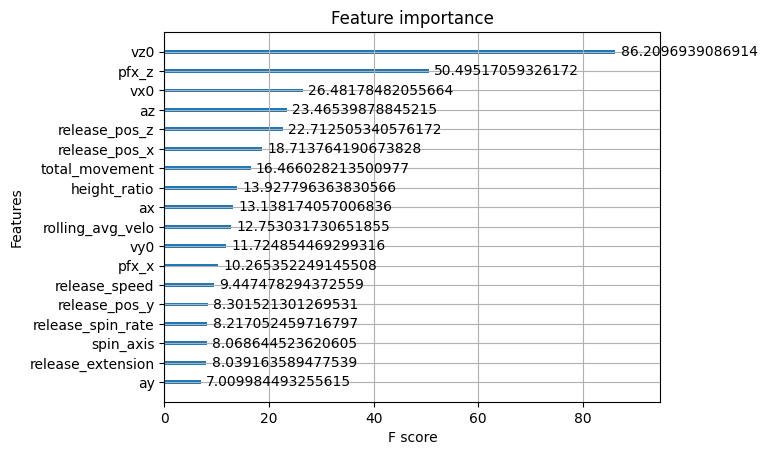

In [51]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

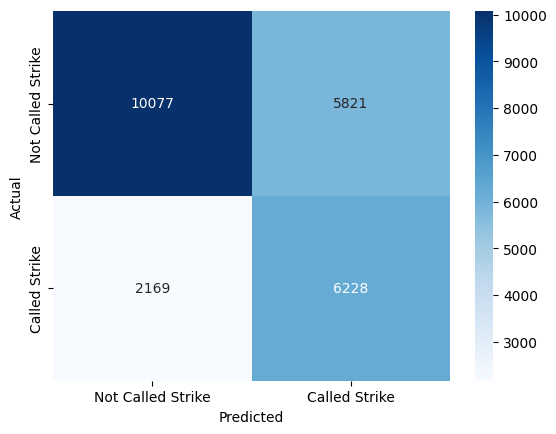

In [52]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [53]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [54]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [55]:
len(testing_label)

562083

In [56]:
y_pred = final_model.predict(predictions)

In [57]:
len(testing_data)

562083

In [58]:
testing_identifiers['xcs'] = y_pred

In [59]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/cs_2022&3_xcalledstrike.csv")